In [1]:
import datetime
from datetime import timedelta
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import requests
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import pytz
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

import tqdm

In [2]:
def adjusted_vaa(dataframe):
    ## Physical characteristics of pitch
    # Pitch velocity (to plate) at plate
    dataframe['vyf'] = -1 * (dataframe['vy0']**2 - (2 * dataframe['ay']*(50-17/12)))**0.5
    # Pitch time in air (50ft to home plate)
    dataframe['pitch_time_50ft'] = (dataframe['vyf'] - dataframe['vy0'])/dataframe['ay']
    # Pitch velocity (vertical) at plate
    dataframe['vzf'] = dataframe['vz0'] + dataframe['az'] * dataframe['pitch_time_50ft']

    ## raw and height-adjusted VAA
    # Raw VAA 
    dataframe['raw_vaa'] = -1 * np.arctan(dataframe['vzf']/dataframe['vyf']) * (180/np.pi)
    # VAA of all pitches at that height
    dataframe['vaa_z_adj'] = np.where(dataframe['pz']<3.5,
                                      dataframe['pz'].mul(1.5635).add(-10.092),
                                      dataframe['pz'].pow(2).mul(-0.1996).add(dataframe['pz'].mul(2.704)).add(-11.69))
    dataframe['adj_vaa'] = dataframe['raw_vaa'].sub(dataframe['vaa_z_adj'])
    # Adjusted VAA, based on height
    return dataframe[['raw_vaa','adj_vaa']]

def spin_calcs(data):
    needed_cols = ['velo','px','pz','vx0','vy0',
                   'vz0','ax','ay','az','extension']
    data[needed_cols] = data[needed_cols].astype('float')
    
    ## Formulas
    # Release location
    data['yR'] = 60.5 - data['extension']
    
    # Time since release
    data['tR'] = (-data['vy0']-(data['vy0']**2 - 2*data['ay']*(50-data['yR']))**0.5)/data['ay']
    
    # Release velo
    data['vxR'] = data['vx0']+data['ax']*data['tR']
    data['vyR'] = data['vy0']+data['ay']*data['tR']
    data['vzR'] = data['vz0']+data['az']*data['tR']
    
    # Delta release speed
    data['dv0'] = data['velo'] - (data['vxR']**2 + data['vyR']**2 + data['vzR']**2)**0.5/1.467

    # pitch flight time
    data['tf'] = (-data['vyR']-(data['vyR']**2 - 2*data['ay']*(data['yR']-17/12))**0.5)/data['ay']

    # Average velocity
    data['v_xbar'] = (2*data['vxR']+data['ax']*data['tf'])/2
    data['v_ybar'] = (2*data['vyR']+data['ay']*data['tf'])/2
    data['v_zbar'] = (2*data['vzR']+data['az']*data['tf'])/2
    data['v_bar'] = (data['v_xbar']**2 + data['v_ybar']**2 + data['v_zbar']**2)**0.5

    # Drag Acceleration
    data['a_drag'] = -(data['ax']*data['v_xbar'] + data['ay']*data['v_ybar'] + (data['az']+32.174)*data['v_zbar'])/data['v_bar']

    # Magnus Accelerations
    data['a_magx'] = data['ax'] + data['a_drag']*data['v_xbar']/data['v_bar']
    data['a_magy'] = data['ay'] + data['a_drag']*data['v_ybar']/data['v_bar']
    data['a_magz'] = data['az'] + data['a_drag']*data['v_zbar']/data['v_bar'] + 32.174
    data['a_mag'] = (data['a_magx']**2 + data['a_magy']**2 + data['a_magz']**2)**0.5

    data['IHB'] = 0.5*data['a_magx']*data['tf']**2*12
    data['IVB'] = 0.5*data['a_magz']*data['tf']**2*12
    data['total_IB'] = (data['IHB'].astype('float')**2+data['IVB'].astype('float')**2)**0.5
    
    return data[['IHB','IVB','total_IB']]
                                                                   
### Standardized Strikezone (z-location, in 'strikezones')
def strikezone_z(dataframe,top_column,bottom_column):
    dataframe[['p_z',top_column,bottom_column]] = dataframe[['p_z',top_column,bottom_column]].astype('float')
    
    # Ratio of 'strikezones' above/below midpoint of strikezone
    dataframe['sz_mid'] = dataframe[[top_column,bottom_column]].mean(axis=1)
    dataframe['sz_height'] = dataframe[top_column].sub(dataframe[bottom_column])
    
    return dataframe['p_z'].sub(dataframe['sz_mid']).div(dataframe['sz_height'])

def loc_model(df,year=2024):
    df['balls_before_pitch'] = np.clip(df['balls'], 0, 3)
    df['strikes_before_pitch'] = np.clip(df['strikes'], 0, 2)
    df['pitcherside'] = df['P Hand'].copy()

    df = pd.get_dummies(df, columns=['pitcherside','hitterside','balls_before_pitch','strikes_before_pitch'])
    for hand in ['L','R']:
        if f'pitcherside_{hand}' not in df.columns.values:
            df[f'pitcherside_{hand}'] = 0

    df[['take_input','swing_input','called_strike_raw','ball_raw',
                'hit_by_pitch_raw','swinging_strike_raw','contact_raw',
                'foul_strike_raw','in_play_raw','10deg_raw','10-20deg_raw',
                '20-30deg_raw','30-40deg_raw','40-50deg_raw','50+deg_raw',
                'called_strike_pred','ball_pred','hit_by_pitch_pred','contact_input',
                'swinging_strike_pred','foul_strike_pred','in_play_input','50+deg_pred',
                'out_pred', 'single_pred', 'double_pred', 'triple_pred', 'home_run_pred']] = None

    for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
        df[[launch_angle+'_input',launch_angle+': <90mph_raw',
                 launch_angle+': 90-95mph_raw',launch_angle+': 95-100mph_raw',
                 launch_angle+': 100-105mph_raw',launch_angle+': 105+mph_raw',
                 launch_angle+': <90mph_pred',launch_angle+': 90-95mph_pred',
                 launch_angle+': 95-100mph_pred',launch_angle+': 100-105mph_pred',
                 launch_angle+': 105+mph_pred']] = None

    for pitch_type in ['Fastball','Breaking Ball','Offspeed']:
        # Swing Decision
        with open('2024_pl_swing_model_{}_loc.pkl'.format(pitch_type), 'rb') as f:
            decision_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['take_input','swing_input']] = decision_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,decision_model.feature_names_in_])
    
        # Take Result
        with open('2024_pl_take_model_{}_loc.pkl'.format(pitch_type), 'rb') as f:
            take_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['called_strike_raw','ball_raw','hit_by_pitch_raw']] = take_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,take_model.feature_names_in_])
        df.loc[df['pitch_type_bucket']==pitch_type,'called_strike_pred_loc'] = df.loc[df['pitch_type_bucket']==pitch_type,'called_strike_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'take_input'])
        df.loc[df['pitch_type_bucket']==pitch_type,'ball_pred_loc'] = df.loc[df['pitch_type_bucket']==pitch_type,'ball_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'take_input'])
        df.loc[df['pitch_type_bucket']==pitch_type,'hit_by_pitch_pred_loc'] = df.loc[df['pitch_type_bucket']==pitch_type,'hit_by_pitch_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'take_input'])
    
        # Swing Result
        with open('2024_pl_contact_model_{}_loc.pkl'.format(pitch_type), 'rb') as f:
            swing_result_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['swinging_strike_raw','contact_raw']] = swing_result_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,swing_result_model.feature_names_in_])
        df.loc[df['pitch_type_bucket']==pitch_type,'contact_input'] = df.loc[df['pitch_type_bucket']==pitch_type,'contact_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'swing_input'])
        df.loc[df['pitch_type_bucket']==pitch_type,'swinging_strike_pred_loc'] = df.loc[df['pitch_type_bucket']==pitch_type,'swinging_strike_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'swing_input'])
    
        # Contact Result
        with open('2024_pl_in_play_model_{}_loc.pkl'.format(pitch_type), 'rb') as f:
            contact_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['foul_strike_raw','in_play_raw']] = contact_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,contact_model.feature_names_in_])
        df.loc[df['pitch_type_bucket']==pitch_type,'foul_strike_pred_loc'] = df.loc[df['pitch_type_bucket']==pitch_type,'foul_strike_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'contact_input'])
        df.loc[df['pitch_type_bucket']==pitch_type,'in_play_input'] = df.loc[df['pitch_type_bucket']==pitch_type,'in_play_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'contact_input'])
    
        # Launch Angle Result
        with open('2024_pl_launch_angle_model_{}_loc.pkl'.format(pitch_type), 'rb') as f:
            launch_angle_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['10deg_raw','10-20deg_raw','20-30deg_raw','30-40deg_raw','40-50deg_raw','50+deg_raw']] = launch_angle_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,launch_angle_model.feature_names_in_])
        for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
            df.loc[df['pitch_type_bucket']==pitch_type,launch_angle+'_input'] = df.loc[df['pitch_type_bucket']==pitch_type,launch_angle+'_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'in_play_input'])
        df.loc[df['pitch_type_bucket']==pitch_type,'50+deg_pred_loc'] = df.loc[df['pitch_type_bucket']==pitch_type,'50+deg_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'in_play_input'])
    
        # Launch Velo Result
        for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
            with open('2024_pl_{}_model_{}_loc.pkl'.format(launch_angle,pitch_type), 'rb') as f:
                launch_velo_model = pickle.load(f)
    
            df.loc[df['pitch_type_bucket']==pitch_type,[launch_angle+': <90mph_raw',launch_angle+': 90-95mph_raw',launch_angle+': 95-100mph_raw',launch_angle+': 100-105mph_raw',launch_angle+': 105+mph_raw']] = launch_velo_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,launch_velo_model.feature_names_in_])
            for bucket in [launch_angle+': '+x for x in ['<90mph','90-95mph','95-100mph','100-105mph','105+mph']]:
                df.loc[df['pitch_type_bucket']==pitch_type,bucket+'_pred_loc'] = df.loc[df['pitch_type_bucket']==pitch_type,bucket+'_raw'].mul(df.loc[df['pitch_type_bucket']==pitch_type,launch_angle+'_input'])


    bip_result_dict = (
        pd.read_csv('data_bip_result.csv')
        .set_index(['year_played','bb_bucket'])
        .to_dict(orient='index')
    )

    # Apply averages to each predicted grouping
    for outcome in ['out', 'single', 'double', 'triple', 'home_run']:
        # Start with 50+ degrees (popups)
        df[outcome+'_pred'] = df['50+deg_pred']*bip_result_dict[(year,'50+deg')][outcome]

        for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
            for bucket in [launch_angle+': '+x for x in ['<90mph','90-95mph','95-100mph','100-105mph','105+mph']]:
                df[outcome+'_pred'] += df[bucket+'_pred']*bip_result_dict[(year,bucket)][outcome]

    ### Find the estimated change in wOBA/runs for each pitch
    # wOBA value of an outcome, based on the count that it came in
    outcome_wOBAs = pd.read_csv('data_woba_outcome.csv').set_index(['year_played','balls','strikes'])

    df = df.merge(outcome_wOBAs,
                  how='left',
                  on=['year_played','balls','strikes'])

    # wOBA_effect is how the pitch is expected to affect wOBA
    # (either by moving the count, or by ending the PA)
    df['wOBA_effect'] = 0

    for stat in [x[:-5] for x in list(outcome_wOBAs.columns)]:
        df['wOBA_effect'] = df['wOBA_effect'].add(df[stat+'_pred'].fillna(df[stat+'_pred'].median()).mul(df[stat+'_wOBA'].fillna(df[stat+'_wOBA'].median())))

    return df['wOBA_effect'].sub(-0.004253050593194383).div(0.05179234832326223).mul(-50).add(100)

In [68]:
def scrape_pitch_data(game_list,pitch_data={}):
    for game_id in tqdm.tqdm(game_list):
        r = requests.get(f'https://baseballsavant.mlb.com/gf?game_pk={game_id}')
        x = r.json()
        for home_away_pitcher in ['home','away']:
            if f'{home_away_pitcher}_pitchers' not in x.keys():
                continue
            for pitcher_id in list(x[f'{home_away_pitcher}_pitchers'].keys()):
                for pitch in range(len(x[f'{home_away_pitcher}_pitchers'][pitcher_id])):
                    pitch_data.update({
                        x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['play_id']:{
                            'game_date':x['gameDate'],
                            'game_status_code':x['game_status_code'],
                            'gamedayType':x['gamedayType'],
                            'game_id':game_id,
                            'venue_id':x['venue_id'],
                            'park_name':x['home_team_data']['venue']['name'],
                            'home_team':x['home_team_data']['abbreviation'],
                            'away_team':x['away_team_data']['abbreviation'],
                            'pitcher_id':pitcher_id,
                            'pitcher_name':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['pitcher_name'],
                            'p_throws':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['p_throws'],
                            'stand':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['stand'],
                            'inning':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['inning'],
                            'outs':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['outs'],
                            'balls':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['balls'],
                            'strikes':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['strikes'],
                            'batter':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['batter'],
                            'batter_name':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['batter_name'],
                            'description':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['description'],
                            'events':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['events'],
                            'hit_speed':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['hit_speed'] if 'hit_speed' in x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch].keys() else None,
                            'hit_angle':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['hit_angle'] if 'hit_angle' in x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch].keys() else None
                            }
                    })
                    try:
                        pitch_data[x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['play_id']].update({
                            'velo':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['start_speed'],
                            'pitch_type':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['pitch_type'],
                            'ivb':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['inducedBreakZ'],
                            'extension':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['extension'] if 'extension' in x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch].keys() else None,
                            'spin_rate':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['spin_rate'],
                            'x0':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['x0'],
                            'z0':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['z0'],
                            'vx0':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['vx0'],
                            'vy0':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['vy0'],
                            'vz0':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['vz0'],
                            'ax':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['ax'],
                            'ay':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['ay'],
                            'az':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['az'],
                            'px':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['px'],
                            'pz':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['pz'],
                            'sz_top':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['sz_top'],
                            'sz_bot':x[f'{home_away_pitcher}_pitchers'][pitcher_id][pitch]['sz_bot']
                        })
                    except KeyError:
                        None
    pitch_df = pd.DataFrame.from_dict({i: pitch_data[i] for i in pitch_data.keys()},
                                       orient='index')
    return pitch_df.reset_index().rename(columns={'index':'pitch_id'})

In [5]:
# Load from local
pitch_df = pd.DataFrame()
for year in range(2021,2025):
    for month in list(range(3,11)):
        pitch_df = pd.concat([pitch_df,
                              pd.read_parquet(f'C:/Users/krbla/Documents/GitHub/baseball_snippets/savant_scraper/{year}_Savant_API_Data-{month}.parquet')]
                            )
pitch_df = pitch_df.reset_index(drop=True)

# Or scrape (take ~5 hours)
# game_list = []
# for date in tqdm.tqdm(pd.date_range(start="2021-03-01",end="2024-10-02")):
#     req = requests.get(f'https://statsapi.mlb.com/api/v1/schedule?sportId=1&date={date.date()}')
#     x_start = req.json()
#     if x_start['totalGames']==0:
#         continue
#     for game in range(len(x_start['dates'][0]['games'])):
#         game_list += [x_start['dates'][0]['games'][game]['gamePk']]
# pitch_df = scrape_pitch_data(game_list)
pitch_df.sample(5)

100%|███████████████████████████████████████████████████████████████████| 3216521/3216521 [00:01<00:00, 2148125.32it/s]


pitch_id  game_date game_status_code  \
2065270  60c19fd0-4f0c-4e85-b3e7-e9b8d94bff68   7/7/2023                F   
840957   07068286-0016-0013-000c-f08cd117d70a   4/2/2022                F   
1553420  2d77f5e5-0936-4122-98dc-f49bd65214ff  10/4/2022                F   
2691352  0f4eb183-421c-4de7-b4bb-416c2e705024  5/14/2024                F   
2636830  de71fc51-bbf7-4ac7-9c7a-12f8331c21e1  4/30/2024                F   

        gamedayType  game_id pitcher_id    pitcher_name p_throws stand  \
2065270           P   717452     670990   Yohan Ramírez        R     R   
840957            N   706828     592662      Robbie Ray        L     L   
1553420           P   661223     668678      Zac Gallen        R     L   
2691352           P   746396     676664        JP Sears        L     L   
2636830           P   745018     669022  MacKenzie Gore        L     R   

         inning  ...        vx0         vy0       vz0         ax         ay  \
2065270       6  ...  12.298528 -139.205903 -1.650760 -22.787658  30.920966   
840957        1  ...        NaN         NaN       NaN        NaN        NaN   
1553420       1  ...   7.588556 -139.747200 -6.357189  -6.894974  32.711484   
2691352       1  ...  -4.255583 -133.695292 -2.095163  18.633624  31.613509   
2636830       2  ...  -6.311998 -140.533796 -6.555581   9.985909  33.784058   

                az        px        pz    sz_top    sz_bot  
2065270 -30.667457  0.717286  2.091691  3.541764  1.768197  
840957         NaN       NaN       NaN       NaN       NaN  
1553420 -11.748309 -0.448706  2.666382  3.270000  1.670000  
2691352 -26.137573  1.093525  1.939519  3.463253  1.685975  
2636830 -11.826845  0.205670  2.454423  3.370000  1.590000  

[5 rows x 36 columns]

In [6]:
pitch_df['year_played'] = pd.to_datetime(pitch_df['game_date']).dt.year
pitch_df['month_played'] = pd.to_datetime(pitch_df['game_date']).dt.month
group_map = {
    'FF':'Fastball',
    'SI':'Fastball',
    'FC':'Fastball',
    'FA':'Fastball',
    'CH':'Offspeed',
    'FS':'Offspeed',
    'FO':'Offspeed',
    'SC':'Offspeed',
    'KN':'Offspeed',
    'EP':'Offspeed',
    'CU':'Breaking Ball',
    'KC':'Breaking Ball',
    'CS':'Breaking Ball',
    'SL':'Breaking Ball',
    'ST':'Breaking Ball',
    'SV':'Breaking Ball',
    'IN':'Other',
    'PO':'Other'
}
pitch_df['pitch_type_bucket'] = pitch_df['pitch_type'].map(group_map)
pitch_df[['IHB','IVB']] = spin_calcs(pitch_df)
pitch_df['IHB'] = np.where(pitch_df['p_throws']=='R',pitch_df['IHB'].mul(-1),pitch_df['IHB'])
pitch_df[['VAA','HAVAA']] = adjusted_vaa(pitch_df)

In [7]:
for col in ['year_played','month_played']:
    pitch_df[col] = pitch_df[col].astype('int')

for col in ['velo', 'ivb', 'extension', 'spin_rate', 
            'x0', 'z0', 'vx0', 'vy0', 'vz0',
            'ax', 'ay', 'az', 'px', 'pz', 'sz_top', 'sz_bot', 
            'yR', 'tR', 'vxR', 'vyR', 'vzR', 'dv0', 'tf',
            'yR', 'tR', 'vxR', 'vyR', 'vzR', 'dv0', 'tf',
            'v_xbar', 'v_ybar', 'v_zbar', 'v_bar', 'a_drag', 'a_magx',
            'a_magy', 'a_magz', 'a_mag', 'IHB', 'IVB', 'vyf',
            'pitch_time_50ft', 'vzf', 'raw_vaa', 'vaa_z_adj', 'adj_vaa', 'VAA',
            'HAVAA']:
    pitch_df[col] = pitch_df[col].astype('float')
    
for col in ['pitcher_id', 'pitcher_name', 'p_throws', 'stand',
            'inning', 'outs', 'balls', 'strikes', 'batter', 'batter_name',
            'description','events','pitch_type','pitch_type_bucket',
            'game_status_code', 'gamedayType']:
    pitch_df[col] = pitch_df[col].astype('category')

## downcasting loop
for column in pitch_df.columns:
    if pitch_df[column].dtype == 'float64':
        pitch_df[column]=pd.to_numeric(pitch_df[column], downcast='float')
    if pitch_df[column].dtype == 'int64':
        pitch_df[column]=pd.to_numeric(pitch_df[column], downcast='integer')

In [8]:
for year in pitch_df['year_played'].unique():
    for month in list(range(3,11)):
        (pitch_df
         .loc[(pitch_df['year_played']==year) &
              (pitch_df['month_played']==month)]
         .drop(columns=['month_played'])
         .to_parquet(f'C:/Users/krbla/Documents/GitHub/baseball_snippets/savant_scraper/{year}_Savant_API_Data-{month}.parquet',
                     index=False)
        )

In [9]:
def fastball_differences(dataframe,stat):
    dataframe[stat] = dataframe[stat].astype('float')
    temp_df = dataframe.loc[dataframe['pitch_type']==dataframe['fastball_type']].groupby(['pitcher_id','game_date','pitch_type','stand'], as_index=False)[stat].mean().rename(columns={stat:'fb_'+stat})
    dataframe = dataframe.merge(temp_df,
                                left_on=['pitcher_id','game_date','fastball_type'],
                                right_on=['pitcher_id','game_date','pitch_type']).drop(columns=['pitch_type_y']).rename(columns={'pitch_type_x':'pitch_type'})
    return dataframe[stat].sub(dataframe['fb_'+stat])
    
def get_mode(series):
    mode = series.mode()
    if mode.size==0:
        return None
    else:
        return series.mode()[0]

pitch_df['fastball_only'] = np.where(pitch_df['pitch_type_bucket']=='Fastball',pitch_df['pitch_type'],None)
pitch_df['fastball_type'] = pitch_df.groupby(['pitcher_id','game_date','stand'])['fastball_only'].transform(get_mode).fillna(pitch_df['pitch_type'])

# Add comparison stats to fastball
for stat in ['IHB','IVB','velo']:
    pitch_df[stat+'_diff'] = fastball_differences(pitch_df,stat)
pitch_df['total_IB_diff'] = (pitch_df['IHB_diff'].astype('float')**2+pitch_df['IVB_diff'].astype('float')**2)**0.5

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\3390689532.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\3390689532.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\3390689532.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\3390689532.py:3: FutureWarning:

T

In [74]:
event_map = {
    'Single':'single', 
    'GIDP':'out', 
    'Groundout':'out',
    'Lineout':'out',
    'Pop Out':'out', 
    'Fielders Choice':'out', 
    'Forceout':'out',
    'Flyout':'out', 
    'Home Run':'home_run', 
    'Sac Fly':'out',
    'Triple':'triple', 
    'Double':'double', 
    'Double Play':'out', 
    'Field Error':'out', 
    'Bunt Groundout':'out',
    'Fielders Choice Out':'out', 
    'Sac Bunt':'out', 
    'Sac Fly Double Play':'out',
    'Triple Play':'out', 
    'Bunt Pop Out':'out', 
    'Catcher Interference':'other',
    'Bunt Lineout':'out', 
    'Sac Bunt Double Play':'out', 
    'Batter Out':'out'
}

In [75]:
pitch_df['cleaned_description'] = pitch_df['description'].map({
    'In play, no out':'in_play',
    'Called Strike':'called_strike',
    'Swinging Strike':'swinging_strike',
    'In play, out(s)':'in_play',
    'Ball':'ball',
    'In play, run(s)':'in_play',
    'Foul':'foul_strike',
    'Hit By Pitch':'hit_by_pitch',
    'Ball In Dirt':'ball',
    'Foul Bunt':'foul_strike',
    'Foul Tip':'swinging_strike',
    'Intent Ball':'ball',
    'Missed Bunt':'swinging_strike',
    'Pitchout':'ball',
    'Foul Pitchout':'foul_strike'
})

pitch_df['cleaned_description'] = np.where(pitch_df['cleaned_description']=='in_play',
                                           pitch_df['events'].map(event_map),
                                           pitch_df['cleaned_description'])

In [ ]:
# Categorical features
pitch_df[pd.get_dummies(pitch_df[['p_throws','stand','balls','strikes']]).columns.values] = pd.get_dummies(pitch_df[['p_throws','stand','balls','strikes']])

In [76]:
pitch_df['cleaned_description'].unique()

array(['single', 'called_strike', 'swinging_strike', 'out', 'ball',
       'home_run', 'foul_strike', 'hit_by_pitch', 'triple', 'double',
       'other'], dtype=object)

In [77]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import scipy as sp
import seaborn as sns
import pickle
import sklearn
import time
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import optuna

In [20]:
pitch_df.columns.values

array(['pitch_id', 'game_date', 'game_status_code', 'gamedayType',
       'game_id', 'pitcher_id', 'pitcher_name', 'p_throws', 'stand',
       'inning', 'outs', 'balls', 'strikes', 'batter', 'batter_name',
       'description', 'events', 'hit_speed', 'hit_angle', 'velo',
       'pitch_type', 'ivb', 'extension', 'spin_rate', 'x0', 'z0', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'px', 'pz', 'sz_top', 'sz_bot',
       'year_played', 'month_played', 'pitch_type_bucket', 'yR', 'tR',
       'vxR', 'vyR', 'vzR', 'dv0', 'tf', 'v_xbar', 'v_ybar', 'v_zbar',
       'v_bar', 'a_drag', 'a_magx', 'a_magy', 'a_magz', 'a_mag', 'IHB',
       'IVB', 'vyf', 'pitch_time_50ft', 'vzf', 'raw_vaa', 'vaa_z_adj',
       'adj_vaa', 'VAA', 'HAVAA', 'fastball_only', 'fastball_type',
       'IHB_diff', 'IVB_diff', 'velo_diff', 'total_IB_diff',
       'cleaned_description'], dtype=object)

In [118]:
id_cols = ['year_played', 'game_date', 'pitcher_id', 'pitcher_name',
           'pitch_id','batter', 'batter_name','balls','strikes',
           'game_id', #'pitcherteam', 'hitterteam','hometeam', 'awayteam', 
           'pitch_type','pitch_type_bucket']

category_feats = ['p_throws_L', 'stand_L',
                  'balls_1','balls_2','balls_3',
                  'strikes_1','strikes_2'
                 ]

stuff_feats = ['velo','velo_diff',
               'extension',
               'spin_rate',
               'adj_vaa',
               'x0','z0',
               'IHB','IVB','total_IB',
               'IHB_diff','IVB_diff','total_IB_diff', # Induced Stuff
              ]

target_feats = ['cleaned_description','hit_angle','hit_speed']

In [119]:
model_df = (
    pitch_df
    [id_cols+category_feats+stuff_feats+target_feats]
    .astype({
        'extension':'float',
        'hit_angle':'float',
        'hit_speed':'float',
        'velo':'float',
        # 'raw_vaa':'float', 
        'adj_vaa':'float',
        'velo_diff':'float',
        'IHB':'float', 
        'IVB':'float', 
        'total_IB':'float', 
        'IHB_diff':'float', 
        'IVB_diff':'float', 
        'total_IB_diff':'float',
        'x0':'float',
        'z0':'float',
        # 'px':'float',
        # 'pz':'float',
        # 'sz_z':'float'
    })
    .dropna(subset=category_feats+stuff_feats)
)

In [88]:
model_df.sample(10)

year_played  game_date pitcher_id     pitcher_name  \
3093405         2024  8/30/2024     686730    Carson Spiers   
3183147         2024  9/21/2024     571945    Miles Mikolas   
1678581         2023  3/31/2023     592662       Robbie Ray   
2117483         2023  7/24/2023     547973  Aroldis Chapman   
2948066         2024  7/23/2024     663704   James McArthur   
139043          2021  4/17/2021     643778       Tyler Webb   
2638060         2024  4/30/2024     656605     Mitch Keller   
477354          2021  7/16/2021     425794  Adam Wainwright   
2881311         2024   7/3/2024     592351         Jon Gray   
1397258         2022  8/26/2022     456034      David Price   

                                     pitch_id  batter          batter_name  \
3093405  a1588242-91dd-4763-bbf9-7763bd5d8035  663368        Blake Perkins   
3183147  f7c81923-5f0d-4f55-9b26-ec539bb9146b  608070         José Ramírez   
1678581  20f164a0-af26-4b41-8d21-fa3a2c83563a  680757          Steven Kwan   
2117483  712f57d4-7021-4de4-bb48-edd1f543ab89  663656          Kyle Tucker   
2948066  a8ae39c7-3791-4f49-9f24-26b834019f5c  666971  Lourdes Gurriel Jr.   
139043   ecd834ca-b7c6-429d-accb-03d8c95e66fe  459964           Matt Joyce   
2638060  f83f43de-ab27-47df-9bf4-82b0a291e9f0  669127      Shea Langeliers   
477354   15263697-f44f-4622-b575-4dae2c60e7d3  543105       Alex Dickerson   
2881311  441ef1bf-e1a1-44c7-ab55-bf7d9645fefc  701538      Jackson Merrill   
1397258  761638bc-feaa-4ce7-8581-756559fff2f1  641779      Charles Leblanc   

         game_id pitch_type pitch_type_bucket  ...        z0        IHB  \
3093405   746665         FF          Fastball  ...  5.559636   8.064486   
3183147   745124         FF          Fastball  ...  6.201925   5.377058   
1678581   718763         SL     Breaking Ball  ...  5.871965  -2.523370   
2117483   717274         SL     Breaking Ball  ...  6.202521 -11.165553   
2948066   746281         CU     Breaking Ball  ...  5.691120 -14.203269   
139043    634470         SI          Fastball  ...  6.460418  12.195679   
2638060   745673         FC          Fastball  ...  5.852602  -4.722976   
477354    633285         FC          Fastball  ...  6.301672  -9.074427   
2881311   744998         FF          Fastball  ...  5.363341   7.629009   
1397258   661355         FF          Fastball  ...  5.852324  13.785707   

               IVB   total_IB   IHB_diff   IVB_diff  total_IB_diff  \
3093405  15.441899  17.420912  -0.065771   1.321618       1.323254   
3183147  12.451718  13.563113 -11.779990  -8.049446      14.267506   
1678581   4.088810   4.804764   1.313373  -0.723108       1.499278   
2117483   1.827067  11.314051   5.771338 -10.810543      12.254639   
2948066 -13.363801  19.501898  -0.969256   4.234551       4.344063   
139043   18.339893  22.024674  -7.912022 -35.154268      36.033633   
2638060   5.589609   7.317803  -3.261467  -0.521925       3.302964   
477354    1.979765   9.287879   2.096322  -0.289809       2.116260   
2881311  14.061298  15.997559 -15.844601 -35.268245      38.663943   
1397258  14.172824  19.771561   0.793267  -9.716874       9.749201   

         cleaned_description  hit_angle  hit_speed  
3093405               single       11.0       89.7  
3183147        called_strike        NaN        NaN  
1678581          foul_strike        NaN        NaN  
2117483                 ball        NaN        NaN  
2948066               single       16.0       87.4  
139043                  ball        NaN        NaN  
2638060                  out       28.0       90.2  
477354                  ball        NaN        NaN  
2881311                 ball        NaN        NaN  
1397258                 ball        NaN        NaN  

[10 rows x 33 columns]

In [120]:
## Batted Ball Buckets
into_play_descriptions = ['out','single','double','triple','home_run']

launch_angle_labels = ['10deg','10-20deg','20-30deg','30-40deg','40-50deg','50+deg']
launch_angle_bins = [-180, 10, 20, 30, 40, 50, 180]

launch_velo_labels = ['<90mph','90-95mph','95-100mph','100-105mph','105+mph']
launch_velo_bins = [0, 90, 95, 100, 105, 150]

model_df['bb_angle'] = np.where(model_df['cleaned_description'].isin(into_play_descriptions),
                                     pd.cut(model_df['hit_angle'].fillna(model_df['hit_angle'].median()), bins=launch_angle_bins, labels=launch_angle_labels),
                                     None)
# model_df['bb_angle'] = None 
# model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),'bb_angle'] = pd.cut(model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),'launch_angle'].fillna(model_df['launch_angle'].median()), bins=launch_angle_bins, labels=launch_angle_labels)
model_df['bb_angle'] = model_df['bb_angle'].astype('string')

model_df['bb_velocity'] = np.where(model_df['cleaned_description'].isin(into_play_descriptions),
                                     pd.cut(model_df['hit_speed'].fillna(model_df['hit_speed'].median()), bins=launch_velo_bins, labels=launch_velo_labels),
                                     None)
# model_df['bb_velocity'] = None
# model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),'bb_velocity'] = pd.cut(model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),'launch_speed'].fillna(model_df['launch_speed'].median()), bins=launch_velo_bins, labels=launch_velo_labels)
model_df['bb_velocity'] = model_df['bb_velocity'].astype('string')

model_df['bb_bucket'] = None
model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),'bb_bucket'] = model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),'bb_angle']+': '+model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),'bb_velocity']

model_df.loc[model_df['bb_angle']=='50+deg','bb_bucket'] = '50+deg'

In [121]:
model_df['swing'] = 0
model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions+['foul_strike',
                                                                          'swinging_strike']),
             'swing'] = 1

# Swing Outcome [0=Miss, 1=Contact]
model_df['contact'] = None
model_df.loc[model_df['cleaned_description']=='swinging_strike',
               'contact'] = 0
model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions+['foul_strike']),
               'contact'] = 1

# Contact Outcome [0=Foul, 1=In-Play]
model_df['in_play'] = None
model_df.loc[model_df['cleaned_description']=='foul_strike',
               'in_play'] = 0
model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),
               'in_play'] = 1

# Launch Angle Outcome
model_df['launch_angle_result'] = None
model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),
             'launch_angle_result'] = model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),
                                                   'bb_angle'].map({
    '10deg':0, 
    '10-20deg':1, 
    '20-30deg':2, 
    '30-40deg':3, 
    '40-50deg':4, 
    '50+deg':5
})

# Exit Velo Outcome
model_df['launch_velo_result'] = None    
model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),
             'launch_velo_result'] = model_df.loc[model_df['cleaned_description'].isin(into_play_descriptions),
                                                  'bb_velocity'].map({
    '<90mph':0, 
    '90-95mph':1, 
    '95-100mph':2, 
    '100-105mph':3, 
    '105+mph':4
})

model_df['pitch_group'] = model_df['pitch_type_bucket'].map({
    'Fastball':0,
    'Breaking Ball':1,
    'Offspeed':2
})

model_df[['out','single','double','triple','home_run']] = pd.get_dummies(model_df['cleaned_description'])[['out','single','double','triple','home_run']]
bip_result_dict = model_df.loc[model_df['bb_bucket'].notna()].groupby(['year_played','bb_bucket'])[['out','single','double','triple','home_run']].mean().to_dict(orient='index')

In [122]:
pitch_types = ['Fastball','Breaking Ball','Offspeed']
model_feats = stuff_feats+category_feats

In [92]:
# Model Param Tuning
def model_train(df,target,all_types=False):
    model_params = {}
    model_auc = {}
    model_time = {}

    num_classes = len(model_df.dropna(subset=[target])[target].unique())
    if all_types:
        type_start_time = time.time()
        ## Train-Test Split
        X = model_df.dropna(subset=[target])[model_feats].copy()
    
        # Y
        y = model_df.dropna(subset=[target])[target].astype('int').copy()

        groups = model_df.dropna(subset=[target])['pitcher_id'].copy()

        gss = GroupShuffleSplit(n_splits=2, train_size=.5)
        train_ids, test_ids = next(gss.split(X, y, groups))
        groups_train = groups.iloc[train_ids]
        X_train = X.iloc[train_ids]
        X_test =  X.iloc[test_ids]
        y_train = y.iloc[train_ids]
        y_test = y.iloc[test_ids]
    
        # Define the objective function for Optuna
        def objective(trial):
            # Define the search space for hyperparameters
            param = {
                'tree_method':'gpu_hist',
                'objective': 'binary:logistic' if num_classes==2 else 'multi:softprob',
                'eval_metric': 'auc',
                'eta': trial.suggest_float('eta', 0.01, 0.75),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_float('gamma', 0.0, 10.0),
                'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 20.0),
                'lambda': trial.suggest_float('lambda', 0.0, 50.0),
                'alpha': trial.suggest_float('alpha', 0.0, 50.0),
            }

            if num_classes > 2:
                param.update({'num_class':num_classes})
    
            # Split the data into further training and validation sets (three sets are preferable)
            opt_train_ids, opt_test_ids = next(gss.split(X_train, y_train, groups_train))
            train_data = X_train.iloc[opt_train_ids]
            valid_data =  X_train.iloc[opt_test_ids]
            train_target = y_train.iloc[opt_train_ids]
            valid_target = y_train.iloc[opt_test_ids]
            # train_data, valid_data, train_target, valid_target = train_test_split(X_train, y_train, test_size=0.2, random_state=12)

            # Convert the data into DMatrix format
            dtrain = xgb.DMatrix(train_data, label=train_target)
            dvalid = xgb.DMatrix(valid_data, label=valid_target)

            # Define the pruning callback for early stopping
            pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-auc')

            # Train the model with early stopping
            model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], 
                              early_stopping_rounds=100, callbacks=[pruning_callback])

            # Make predictions on the test set
            y_pred = model.predict(dvalid).astype('float')
            
            # Calculate the loss
            if num_classes==2: 
                auc = roc_auc_score(valid_target, y_pred)
            else: 
                auc = roc_auc_score(valid_target, y_pred, multi_class='ovo')

            return auc
        # Create an Optuna study and optimize the objective function
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=400) # Control the number of trials
    
        # Print the best hyperparameters and the best RMSE
        best_params = study.best_params
        best_auc = study.best_value
        print("Best Hyperparameters: ", best_params)
        print("Best AUC: ", best_auc)
        type_end_time = time.time()
        model_params = best_params
        model_auc = best_auc
        model_time = round(type_end_time - type_start_time,1)
    else:
        for pitch_type in pitch_types:
            type_start_time = time.time()
            ## Train-Test Split
            X = model_df.dropna(subset=[target]).loc[model_df['pitch_type_bucket']==pitch_type][model_feats].copy()
        
            # Y
            y = model_df.dropna(subset=[target]).loc[model_df['pitch_type_bucket']==pitch_type,target].astype('int').copy()
    
            groups = model_df.dropna(subset=[target]).loc[model_df['pitch_type_bucket']==pitch_type,'pitcher_id'].copy()
    
            gss = GroupShuffleSplit(n_splits=2, train_size=.5)
            train_ids, test_ids = next(gss.split(X, y, groups))
            groups_train = groups.iloc[train_ids]
            X_train = X.iloc[train_ids]
            X_test =  X.iloc[test_ids]
            y_train = y.iloc[train_ids]
            y_test = y.iloc[test_ids]
        
            # Define the objective function for Optuna
            def objective(trial):
                # Define the search space for hyperparameters
                param = {
                    'tree_method':'gpu_hist',
                    'objective': 'binary:logistic' if num_classes==2 else 'multi:softprob',
                    'eval_metric': 'auc',
                    'eta': trial.suggest_float('eta', 0.01, 0.75),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                    'gamma': trial.suggest_float('gamma', 0.0, 10.0),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 15.0),
                    'lambda': trial.suggest_float('lambda', 0.1, 100.0),
                    'alpha': trial.suggest_float('alpha', 0.0, 100.0),
                }
    
                if num_classes > 2:
                    param.update({'num_class':num_classes})
        
                # Split the data into further training and validation sets (three sets are preferable)
                opt_train_ids, opt_test_ids = next(gss.split(X_train, y_train, groups_train))
                train_data = X_train.iloc[opt_train_ids]
                valid_data =  X_train.iloc[opt_test_ids]
                train_target = y_train.iloc[opt_train_ids]
                valid_target = y_train.iloc[opt_test_ids]
                # train_data, valid_data, train_target, valid_target = train_test_split(X_train, y_train, test_size=0.2, random_state=12)
    
                # Convert the data into DMatrix format
                dtrain = xgb.DMatrix(train_data, label=train_target)
                dvalid = xgb.DMatrix(valid_data, label=valid_target)
    
                # Define the pruning callback for early stopping
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-auc')
    
                # Train the model with early stopping
                model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], 
                                  early_stopping_rounds=100, callbacks=[pruning_callback])
    
                # Make predictions on the test set
                y_pred = model.predict(dvalid).astype('float')
                
                # Calculate the loss
                if num_classes==2: 
                    auc = roc_auc_score(valid_target, y_pred)
                else: 
                    auc = roc_auc_score(valid_target, y_pred, multi_class='ovo')
    
                return auc
    
            # Create an Optuna study and optimize the objective function
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=400) # Control the number of trials
        
            # Print the best hyperparameters and the best RMSE
            best_params = study.best_params
            best_auc = study.best_value
            print(f"Best {pitch_type} Hyperparameters: ", best_params)
            print(f"Best {pitch_type} AUC: ", best_auc)
            type_end_time = time.time()
            model_params.update({pitch_type:best_params})
            model_auc.update({pitch_type:best_auc})
            model_time.update({pitch_type:round(type_end_time - type_start_time,1)})
    return model_params, model_auc, model_time

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

angle_map = {
    0:'10deg', 
    1:'10-20deg', 
    2:'20-30deg', 
    3:'30-40deg', 
    4:'40-50deg'
}

pl_white = '#FEFEFE'
pl_background = '#162B50'
pl_text = '#72a3f7'
pl_line_color = '#293a6b'

sns.set_theme(
    style={
        'axes.edgecolor': pl_line_color,
        'axes.facecolor': pl_background,
        'axes.labelcolor': pl_white,
        'xtick.color': pl_white,
        'ytick.color': pl_white,
        'figure.facecolor':pl_background,
        'grid.color': pl_background,
        'grid.linestyle': '-',
        'legend.facecolor':pl_background,
        'text.color': pl_white
     }
    )

marker_colors = {
    'FF':'#d22d49', 
    'SI':'#c57a02',
    'FS':'#00a1c5',  
    'FC':'#933f2c', 
    'SL':'#9300c7',  
    'ST':'#C95EBE',
    'CU':'#3c44cd',
    'CH':'#07b526', 
    'KN':'#999999',
    'SC':'#999999', 
    'UN':'#999999', 
}

pitch_names = {
    'FF':'Four-Seamer', 
    'SI':'Sinker',
    'FS':'Splitter',  
    'FC':'Cutter', 
    'SL':'Slider', 
    'ST':'Sweeper',
    'CU':'Curveball',
    'CH':'Changeup', 
    'KN':'Knuckleball',
    'SC':'Screwball', 
    'UN':'Unknown', 
}

In [96]:
def model_comp(data, target, params, angle=None, all_types=False):
    # num_classes = len(data.dropna(subset=[target])[target].unique())
    if all_types:
        target_title = target.replace('_',' ').title()
        print(f'{target_title} Model')

        ## Train-Test Split
        X = data.dropna(subset=[target])[model_feats].copy()

        # Y
        y = data.dropna(subset=[target])[target].astype('int').copy()
        x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                            test_size=0.25, 
                                                            random_state = 12,
                                                            stratify=y
                                                           )
        
        param_tuned_model = XGBClassifier(objective='binary:logistic' if num_classes==2 else 'multi:softprob',
                                          tree_method='hist',
                                          **params,
                                          seed=12)

        param_tuned_model.fit(x_train, y_train)

        if angle is None:
            target_name = target.replace('_result','')
        else: 
            target_name = angle_map[angle]
        with open(f'2025_pl_{target_name}_model_stuff.pkl', 'wb') as f:
                pickle.dump(param_tuned_model, f)

        if num_classes==2:
            param_roc_auc_cat = roc_auc_score(y_test, 
                                              param_tuned_model.predict_proba(x_test)[:,1])
            param_fpr_cat, param_tpr_cat, thresholds = roc_curve(y_test, 
                                                                 param_tuned_model.predict_proba(x_test)[:,1])
        else:
            param_roc_auc_cat = roc_auc_score(y_test, 
                                              param_tuned_model.predict_proba(x_test), 
                                              multi_class='ovo')

        results = pd.DataFrame()

        results['columns'] = x_train.columns
        results['importances'] = param_tuned_model.feature_importances_
        results.sort_values(by='importances', ascending=False, inplace=True)

        if num_classes==2:
            final_roc_auc_cat = roc_auc_score(y_train, 
                                              param_tuned_model.predict_proba(x_train)[:,1])
            final_fpr_cat, final_tpr_cat, thresholds = roc_curve(y_train, 
                                                                 param_tuned_model.predict_proba(x_train)[:,1])
        else:
            final_roc_auc_cat = roc_auc_score(y_train, 
                                              param_tuned_model.predict_proba(x_train),
                                              multi_class='ovo')

        fig, ax = plt.subplots(figsize=(5,round(len(x_train.columns)/2)))
            
        plot = sns.barplot(data=results,
                           x='importances', 
                           y='columns',
                           hue='importances',
                           palette='Blues_r',
                           legend=False)
        ax.set(ylabel='')
        plt.xticks(color='w',fontsize=15)
        plt.yticks(color='w',fontsize=15)
        ax.set_title('{} Model Feature Importance'.format(target_name.replace('_',' ').title()))

        sns.despine()
        
        if num_classes==2:
            fig = plt.figure(figsize=(10,4))
    
            plt.plot(param_fpr_cat, param_tpr_cat, color=sns.color_palette('vlag')[-1], label=f'Test Data (area = {param_roc_auc_cat:0.3f})')
            plt.plot(final_fpr_cat, final_tpr_cat, color=sns.color_palette('vlag')[0], label=f'Train Data (area = {final_roc_auc_cat:0.3f})')
            plt.plot([0, 1], [0, 1], color='white', linestyle = 'dashed')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')

            title_target = target.replace('_',' ').title()
            fig.suptitle(f'{title_target} Model: {pitch_type}', y=1, fontsize=16)
            plt.title(f'(Area closer to 1 is better)', fontsize=12)
    
            sns.despine()
        else:
            print(f'Train AUC: {final_roc_auc_cat}')
            print(f'Test AUC: {param_roc_auc_cat}')
    else:
        for pitch_type in pitch_types:
            target_title = target.replace('_',' ').title()
            print(f'{pitch_type} {target_title} Model')
    
            ## Train-Test Split
            X = data.dropna(subset=[target]).loc[data['pitch_type_bucket']==pitch_type][model_feats].copy()
    
            # Y
            y = data.dropna(subset=[target]).loc[data['pitch_type_bucket']==pitch_type,target].astype('int').copy()
            x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                                test_size=0.25, 
                                                                random_state = 12,
                                                                stratify=y
                                                               )
            
            param_tuned_model = XGBClassifier(objective='binary:logistic' if num_classes==2 else 'multi:softprob',
                                              tree_method='hist',
                                              **params[pitch_type],
                                              seed=12)
    
            param_tuned_model.fit(x_train, y_train)
    
            if angle is None:
                target_name = target.replace('_result','')
            else: 
                target_name = angle_map[angle]
            with open(f'live_stuff_{target_name}_model_{pitch_type}.pkl', 'wb') as f:
                    pickle.dump(param_tuned_model, f)
    
            if num_classes==2:
                param_roc_auc_cat = roc_auc_score(y_test, 
                                                  param_tuned_model.predict_proba(x_test)[:,1])
                param_fpr_cat, param_tpr_cat, thresholds = roc_curve(y_test, 
                                                                     param_tuned_model.predict_proba(x_test)[:,1])
            else:
                param_roc_auc_cat = roc_auc_score(y_test, 
                                                  param_tuned_model.predict_proba(x_test), 
                                                  multi_class='ovo')
    
            results = pd.DataFrame()
    
            results['columns'] = x_train.columns
            results['importances'] = param_tuned_model.feature_importances_
            results.sort_values(by='importances', ascending=False, inplace=True)
    
            if num_classes==2:
                final_roc_auc_cat = roc_auc_score(y_train, 
                                                  param_tuned_model.predict_proba(x_train)[:,1])
                final_fpr_cat, final_tpr_cat, thresholds = roc_curve(y_train, 
                                                                     param_tuned_model.predict_proba(x_train)[:,1])
            else:
                final_roc_auc_cat = roc_auc_score(y_train, 
                                                  param_tuned_model.predict_proba(x_train),
                                                  multi_class='ovo')
    
            fig, ax = plt.subplots(figsize=(5,round(len(x_train.columns)/2)))
                
            plot = sns.barplot(data=results,
                               x='importances', 
                               y='columns',
                               hue='importances',
                               palette='Blues_r',
                               legend=False)
            ax.set(ylabel='')
            plt.xticks(color='w',fontsize=15)
            plt.yticks(color='w',fontsize=15)
            ax.set_title('{} {} Model Feature Importance'.format(pitch_type,target_name.replace('_',' ').title()))
    
            sns.despine()
            
            if num_classes==2:
                fig = plt.figure(figsize=(10,4))
        
                plt.plot(param_fpr_cat, param_tpr_cat, color=sns.color_palette('vlag')[-1], label=f'Test Data (area = {param_roc_auc_cat:0.3f})')
                plt.plot(final_fpr_cat, final_tpr_cat, color=sns.color_palette('vlag')[0], label=f'Train Data (area = {final_roc_auc_cat:0.3f})')
                plt.plot([0, 1], [0, 1], color='white', linestyle = 'dashed')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.0])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.legend(loc='lower right')
    
                title_target = target.replace('_',' ').title()
                fig.suptitle(f'{title_target} Model: {pitch_type}', y=1, fontsize=16)
                plt.title(f'(Area closer to 1 is better)', fontsize=12)
        
                sns.despine()
            else:
                print(f'Train AUC: {final_roc_auc_cat}')
                print(f'Test AUC: {param_roc_auc_cat}')

In [102]:
# contact_params, contact_loss, contact_time = model_train(model_df,'contact')

In [103]:
contact_params = {'Fastball': {'eta': 0.7359885368343579,
  'max_depth': 11,
  'subsample': 0.8263765285934479,
  'colsample_bytree': 0.9634515167860777,
  'gamma': 6.028280852074931,
  'min_child_weight': 0.6224699611476288,
  'lambda': 4.7388225454754735,
  'alpha': 6.272813107219443},
 'Breaking Ball': {'eta': 0.4735748289735959,
  'max_depth': 11,
  'subsample': 0.8802706462826296,
  'colsample_bytree': 0.9637978818845485,
  'gamma': 2.2862446128013363,
  'min_child_weight': 13.255928595384438,
  'lambda': 13.79990618927713,
  'alpha': 9.3623610962612},
 'Offspeed': {'eta': 0.41937812393972373,
  'max_depth': 13,
  'subsample': 0.9515154828523746,
  'colsample_bytree': 0.9994730971834103,
  'gamma': 8.209058764695474,
  'min_child_weight': 14.349506905477215,
  'lambda': 4.930983417837561,
  'alpha': 6.8700413291576075}}

Fastball Contact Model
Breaking Ball Contact Model
Offspeed Contact Model


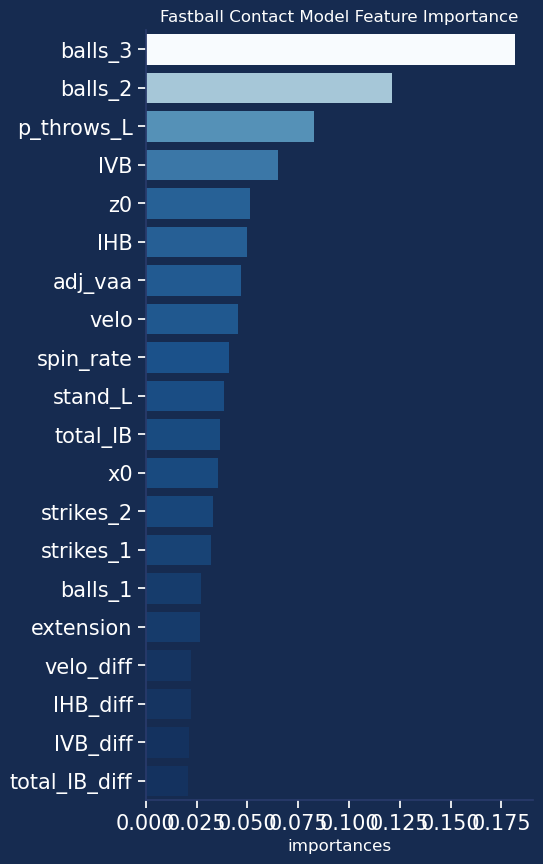

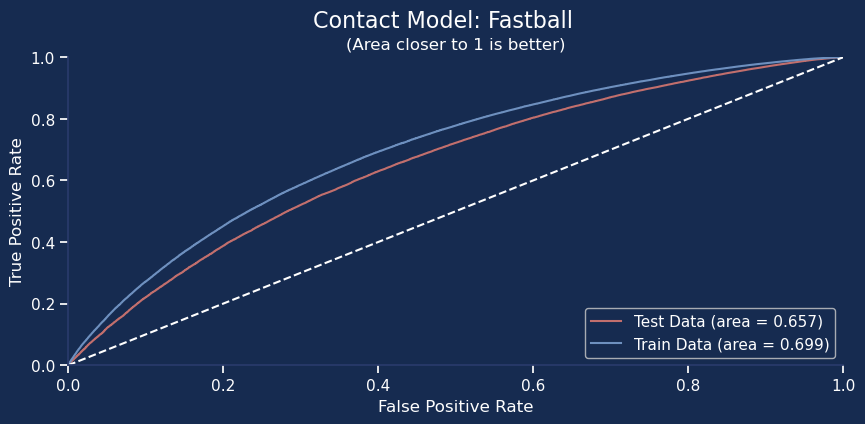

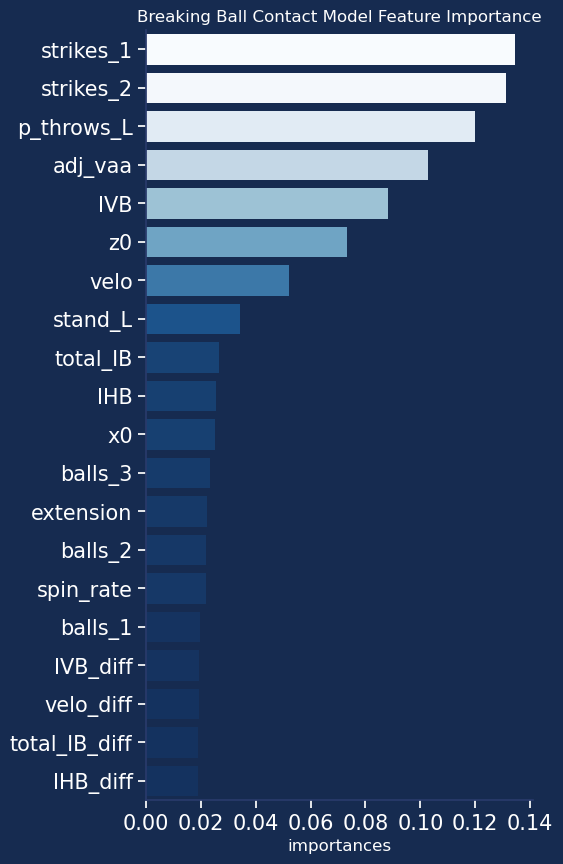

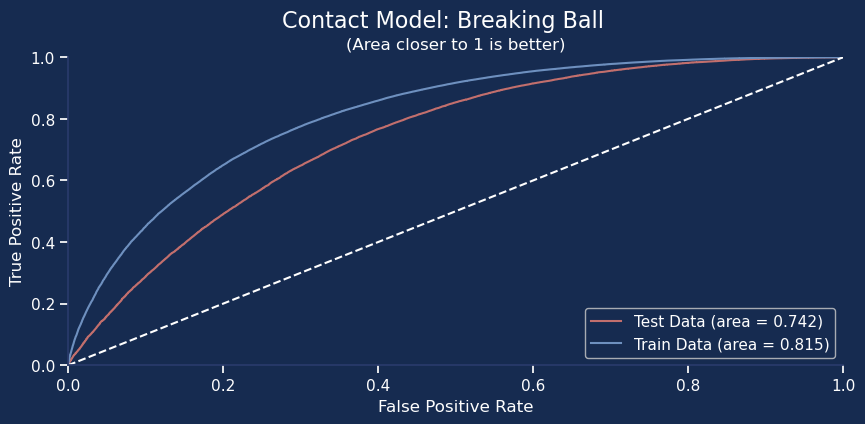

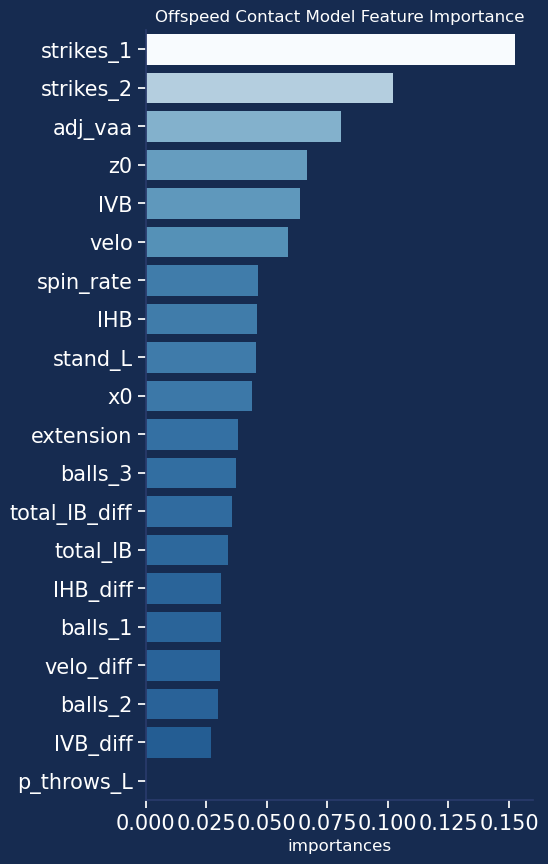

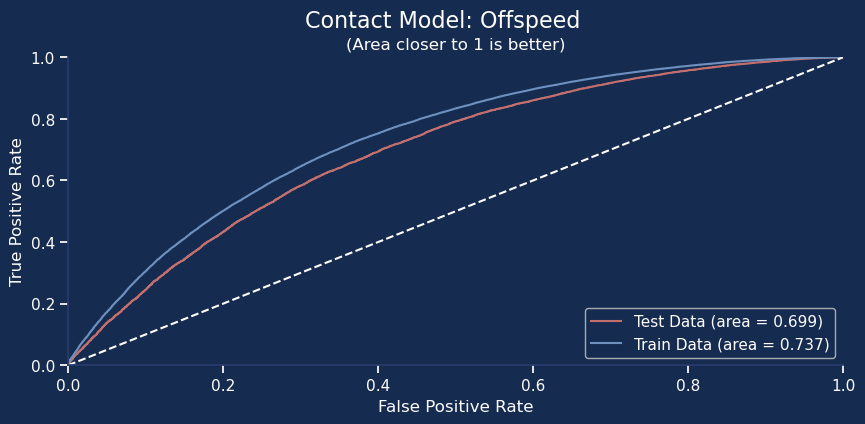

In [100]:
model_comp(model_df, 'contact', contact_params)

In [110]:
# in_play_params, in_play_loss, in_play_time = model_train(model_df,'in_play')

In [111]:
in_play_params = {'Fastball': {'eta': 0.45137274551312306,
  'max_depth': 14,
  'subsample': 0.9758282136471578,
  'colsample_bytree': 0.9754336023610335,
  'gamma': 6.315180331572352,
  'min_child_weight': 5.7603713384762525,
  'lambda': 84.98618921601974,
  'alpha': 7.6279744731247945},
 'Breaking Ball': {'eta': 0.2230129463348564,
  'max_depth': 20,
  'subsample': 0.8678354113448604,
  'colsample_bytree': 0.7928706386778334,
  'gamma': 3.7418098957468082,
  'min_child_weight': 13.449478755941497,
  'lambda': 53.642774887561124,
  'alpha': 37.81580354857518},
 'Offspeed': {'eta': 0.21976066115689757,
  'max_depth': 7,
  'subsample': 0.9155566575436742,
  'colsample_bytree': 0.9474074738003212,
  'gamma': 0.22547540346577488,
  'min_child_weight': 4.88184343759273,
  'lambda': 26.361063965450352,
  'alpha': 19.635723100331138}}

Fastball In Play Model
Breaking Ball In Play Model
Offspeed In Play Model


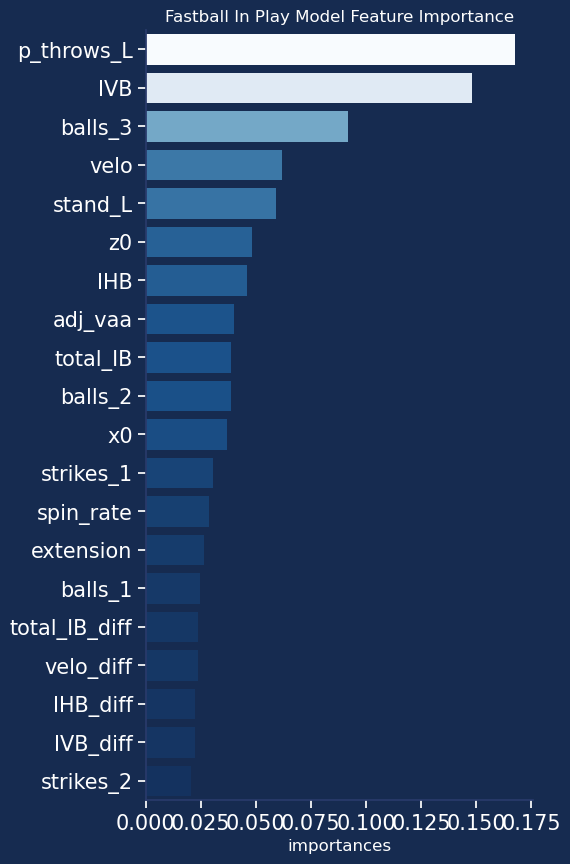

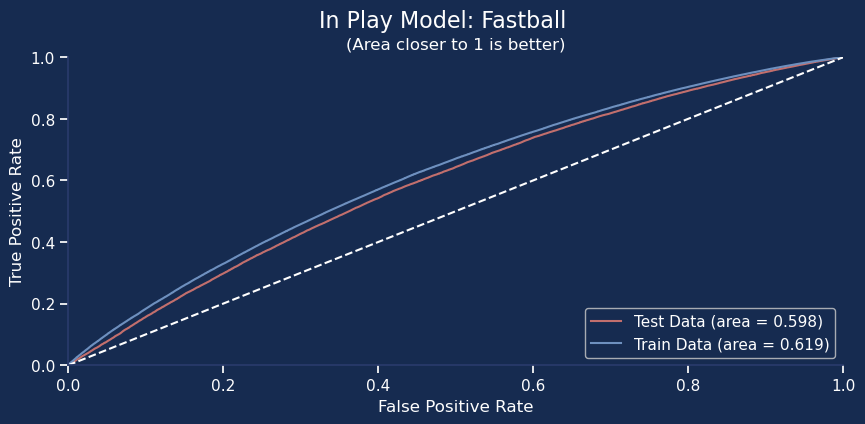

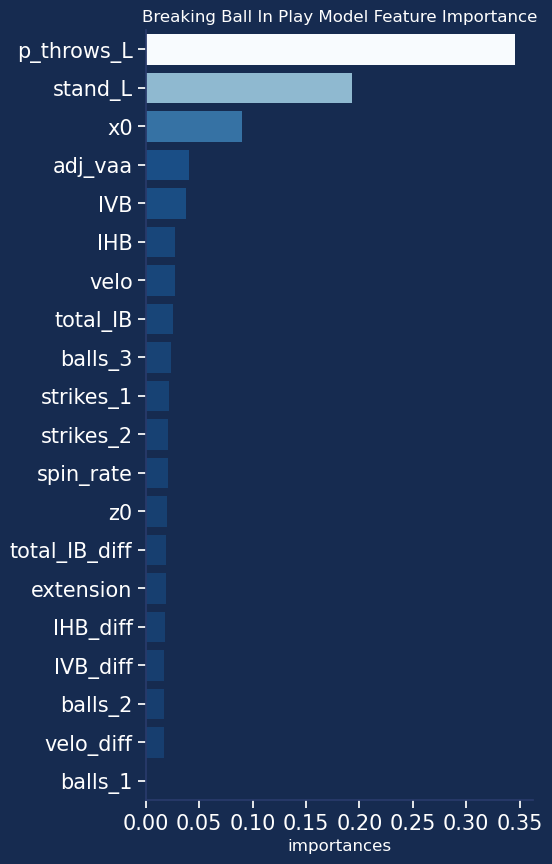

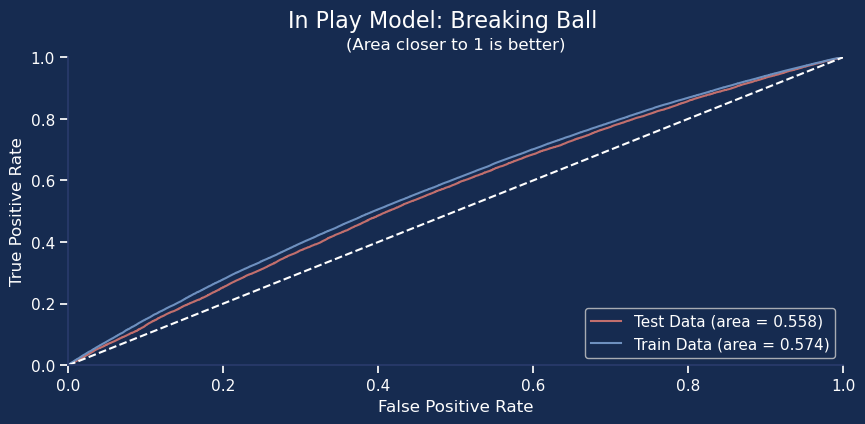

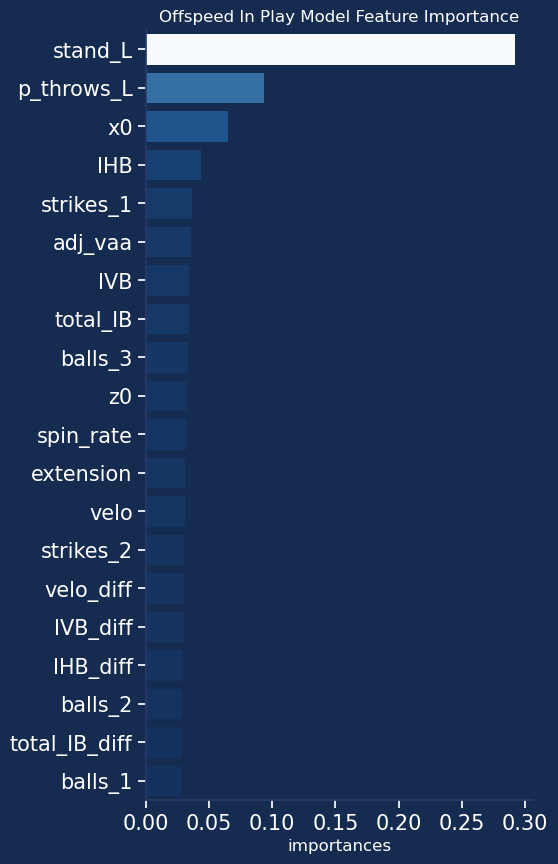

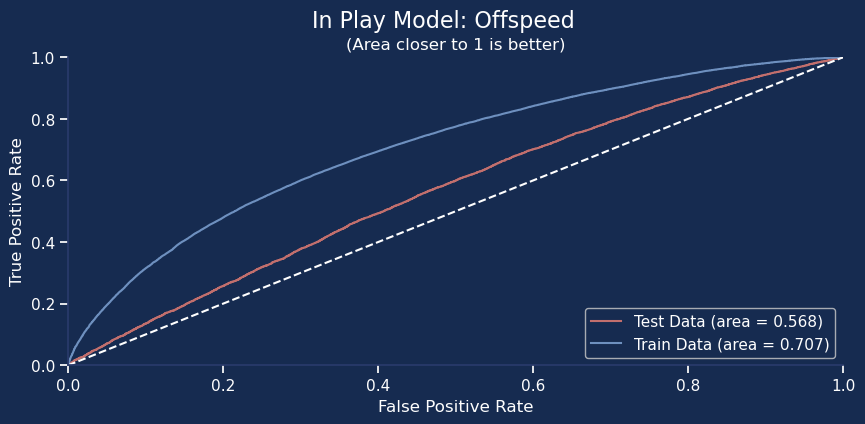

In [105]:
model_comp(model_df, 'in_play', in_play_params)

In [112]:
# launch_angle_params, launch_angle_loss, launch_angle_time = model_train(model_df,'launch_angle_result')

In [113]:
launch_angle_params = {'Fastball': {'eta': 0.6824882342162787,
  'max_depth': 18,
  'subsample': 0.9734113606980821,
  'colsample_bytree': 0.9984169372884723,
  'gamma': 1.8341207610165156,
  'min_child_weight': 4.7974869329384555,
  'lambda': 61.76815718897799,
  'alpha': 8.37578422360949},
 'Breaking Ball': {'eta': 0.5967121908185502,
  'max_depth': 16,
  'subsample': 0.7907714230171574,
  'colsample_bytree': 0.7976290059839292,
  'gamma': 1.9506520088116321,
  'min_child_weight': 13.346263566052222,
  'lambda': 2.6019537643577424,
  'alpha': 5.812451678129255},
 'Offspeed': {'eta': 0.5472189657549847,
  'max_depth': 9,
  'subsample': 0.9898550971647566,
  'colsample_bytree': 0.6725944362505637,
  'gamma': 2.4077850030836077,
  'min_child_weight': 7.471263185300062,
  'lambda': 5.2974322421972655,
  'alpha': 4.910074514627311}}

Fastball Launch Angle Result Model
Train AUC: 0.6328506887788302
Test AUC: 0.5770712404028223
Breaking Ball Launch Angle Result Model
Train AUC: 0.6467211973881034
Test AUC: 0.5566133146935281
Offspeed Launch Angle Result Model
Train AUC: 0.5916164279541124
Test AUC: 0.5456292477831983


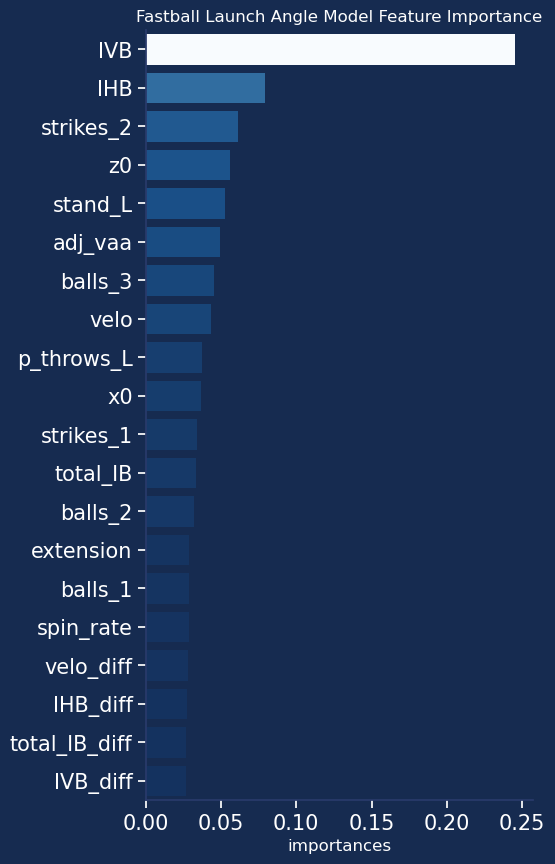

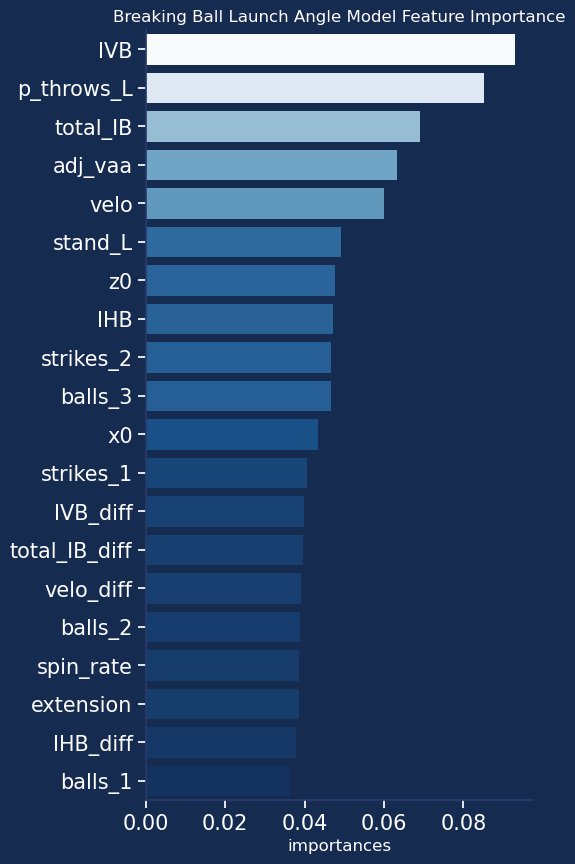

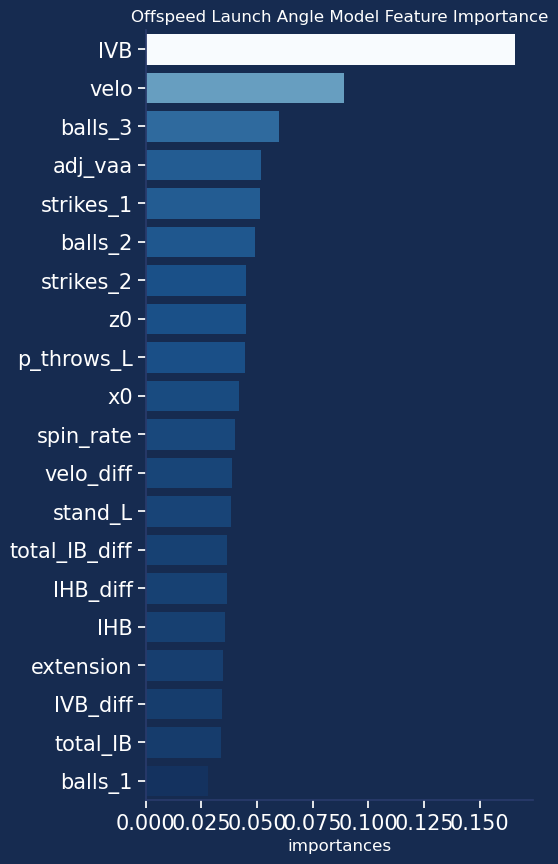

In [108]:
model_comp(model_df, 'launch_angle_result', launch_angle_params)

10deg


[I 2024-10-14 11:38:21,346] A new study created in memory with name: no-name-3ece456c-cb51-4ded-a67a-71687e88bb1c


[0]	validation-auc:0.52189
[1]	validation-auc:0.52246
[2]	validation-auc:0.52384
[3]	validation-auc:0.52398
[4]	validation-auc:0.53451
[5]	validation-auc:0.53578
[6]	validation-auc:0.53567
[7]	validation-auc:0.53886
[8]	validation-auc:0.54221
[9]	validation-auc:0.54375


[I 2024-10-14 11:38:21,784] Trial 0 finished with value: 0.5306171011390207 and parameters: {'eta': 0.1235127257279999, 'max_depth': 6, 'subsample': 0.8059116592589226, 'colsample_bytree': 0.7978846198562768, 'gamma': 3.400228805006665, 'min_child_weight': 11.501027454931302, 'lambda': 56.645563338904424, 'alpha': 71.93200474654193}. Best is trial 0 with value: 0.5306171011390207.


[0]	validation-auc:0.53461
[1]	validation-auc:0.53850
[2]	validation-auc:0.54361
[3]	validation-auc:0.54545
[4]	validation-auc:0.54729
[5]	validation-auc:0.54788
[6]	validation-auc:0.54850
[7]	validation-auc:0.55008
[8]	validation-auc:0.55121
[9]	validation-auc:0.55165


[I 2024-10-14 11:38:22,294] Trial 1 finished with value: 0.5386748343050294 and parameters: {'eta': 0.3601308684773085, 'max_depth': 4, 'subsample': 0.8243826808895722, 'colsample_bytree': 0.6678647980189425, 'gamma': 0.8584379715917101, 'min_child_weight': 2.4195630546419267, 'lambda': 84.22597883711552, 'alpha': 27.829934644166286}. Best is trial 1 with value: 0.5386748343050294.


[0]	validation-auc:0.53390
[1]	validation-auc:0.54009
[2]	validation-auc:0.53980
[3]	validation-auc:0.54220
[4]	validation-auc:0.54286
[5]	validation-auc:0.54283
[6]	validation-auc:0.54280
[7]	validation-auc:0.54276
[8]	validation-auc:0.54223
[9]	validation-auc:0.54232


[I 2024-10-14 11:38:22,741] Trial 2 finished with value: 0.531448329830438 and parameters: {'eta': 0.028335488557635374, 'max_depth': 12, 'subsample': 0.6486227401964079, 'colsample_bytree': 0.6406511118185167, 'gamma': 8.848068553987199, 'min_child_weight': 9.802620753460133, 'lambda': 45.79291986420413, 'alpha': 9.923750744562243}. Best is trial 1 with value: 0.5386748343050294.


[0]	validation-auc:0.52283
[1]	validation-auc:0.52883
[2]	validation-auc:0.53810
[3]	validation-auc:0.54111
[4]	validation-auc:0.54404
[5]	validation-auc:0.54585
[6]	validation-auc:0.54696
[7]	validation-auc:0.54798
[8]	validation-auc:0.54806
[9]	validation-auc:0.54802


[I 2024-10-14 11:38:23,197] Trial 3 finished with value: 0.5332693453171369 and parameters: {'eta': 0.3457081385386969, 'max_depth': 12, 'subsample': 0.7261624909181619, 'colsample_bytree': 0.8997468776438489, 'gamma': 5.18029853780892, 'min_child_weight': 7.8813922314279425, 'lambda': 37.46487590111571, 'alpha': 57.27758154010718}. Best is trial 1 with value: 0.5386748343050294.


[0]	validation-auc:0.54132
[1]	validation-auc:0.54523
[2]	validation-auc:0.54753
[3]	validation-auc:0.54839
[4]	validation-auc:0.54929
[5]	validation-auc:0.55014
[6]	validation-auc:0.55013
[7]	validation-auc:0.55013
[8]	validation-auc:0.55013
[9]	validation-auc:0.55013


[I 2024-10-14 11:38:23,647] Trial 4 finished with value: 0.5376594888260697 and parameters: {'eta': 0.7330541431421128, 'max_depth': 9, 'subsample': 0.8816855472034022, 'colsample_bytree': 0.9931705034799473, 'gamma': 9.92590974019649, 'min_child_weight': 0.4845501683519511, 'lambda': 98.72514284910511, 'alpha': 5.564677789741523}. Best is trial 1 with value: 0.5386748343050294.


[0]	validation-auc:0.52012


[I 2024-10-14 11:38:23,892] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:24,176] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52139


[I 2024-10-14 11:38:24,458] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:24,759] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53441
[1]	validation-auc:0.54325
[2]	validation-auc:0.54352
[3]	validation-auc:0.54468
[4]	validation-auc:0.54601
[5]	validation-auc:0.54629
[6]	validation-auc:0.54697
[7]	validation-auc:0.54699


[I 2024-10-14 11:38:25,314] Trial 9 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:38:25,583] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54074
[1]	validation-auc:0.54435
[2]	validation-auc:0.54824
[3]	validation-auc:0.55011
[4]	validation-auc:0.55082
[5]	validation-auc:0.55158
[6]	validation-auc:0.55103
[7]	validation-auc:0.55055
[8]	validation-auc:0.55038
[9]	validation-auc:0.55014


[I 2024-10-14 11:38:26,829] Trial 11 finished with value: 0.5365738407927363 and parameters: {'eta': 0.7215821236137693, 'max_depth': 7, 'subsample': 0.8941136633709081, 'colsample_bytree': 0.9644794839358793, 'gamma': 0.18984335894091808, 'min_child_weight': 0.6475002719974601, 'lambda': 99.65718628529999, 'alpha': 1.4876977821879285}. Best is trial 1 with value: 0.5386748343050294.


[0]	validation-auc:0.53314


[I 2024-10-14 11:38:27,104] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53896
[1]	validation-auc:0.54178
[2]	validation-auc:0.54212
[3]	validation-auc:0.54435


[I 2024-10-14 11:38:27,479] Trial 13 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53662
[1]	validation-auc:0.53773


[I 2024-10-14 11:38:27,769] Trial 14 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54213
[1]	validation-auc:0.54732
[2]	validation-auc:0.54832
[3]	validation-auc:0.55034
[4]	validation-auc:0.55149
[5]	validation-auc:0.55210
[6]	validation-auc:0.55291
[7]	validation-auc:0.55280
[8]	validation-auc:0.55302
[9]	validation-auc:0.55383


[I 2024-10-14 11:38:28,311] Trial 15 finished with value: 0.5372132642311416 and parameters: {'eta': 0.2797387268513651, 'max_depth': 10, 'subsample': 0.7155694830067835, 'colsample_bytree': 0.6262414697013472, 'gamma': 6.8886252660040554, 'min_child_weight': 5.212178340254399, 'lambda': 1.4881388958603239, 'alpha': 0.3750935736455032}. Best is trial 1 with value: 0.5386748343050294.


[0]	validation-auc:0.53400


[I 2024-10-14 11:38:28,587] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53977
[1]	validation-auc:0.54426
[2]	validation-auc:0.54617
[3]	validation-auc:0.54503
[4]	validation-auc:0.54755
[5]	validation-auc:0.54811


[I 2024-10-14 11:38:28,970] Trial 17 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.52665


[I 2024-10-14 11:38:29,249] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:29,549] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52494


[I 2024-10-14 11:38:29,864] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53714
[1]	validation-auc:0.54325
[2]	validation-auc:0.54377
[3]	validation-auc:0.54464


[I 2024-10-14 11:38:30,276] Trial 21 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53877
[1]	validation-auc:0.54225


[I 2024-10-14 11:38:30,589] Trial 22 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53961
[1]	validation-auc:0.54392
[2]	validation-auc:0.54657
[3]	validation-auc:0.54726
[4]	validation-auc:0.54860
[5]	validation-auc:0.54973
[6]	validation-auc:0.54960
[7]	validation-auc:0.55024
[8]	validation-auc:0.55029
[9]	validation-auc:0.55057


[I 2024-10-14 11:38:31,117] Trial 23 finished with value: 0.5358298102224677 and parameters: {'eta': 0.15601033085411223, 'max_depth': 10, 'subsample': 0.8835371424847098, 'colsample_bytree': 0.6101849519181239, 'gamma': 8.39769397239109, 'min_child_weight': 1.8020235377693345, 'lambda': 3.9494416085730535, 'alpha': 5.575380372717495}. Best is trial 1 with value: 0.5386748343050294.
[I 2024-10-14 11:38:31,388] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53840
[1]	validation-auc:0.54245


[I 2024-10-14 11:38:31,736] Trial 25 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54162
[1]	validation-auc:0.54666
[2]	validation-auc:0.54719
[3]	validation-auc:0.54951
[4]	validation-auc:0.55029
[5]	validation-auc:0.55227
[6]	validation-auc:0.55280
[7]	validation-auc:0.55308
[8]	validation-auc:0.55352
[9]	validation-auc:0.55347


[I 2024-10-14 11:38:32,278] Trial 26 finished with value: 0.5388270860237289 and parameters: {'eta': 0.21724125618124557, 'max_depth': 11, 'subsample': 0.9301305454338429, 'colsample_bytree': 0.7547617672920188, 'gamma': 4.463170476377054, 'min_child_weight': 4.8305483753612215, 'lambda': 55.77192503924506, 'alpha': 8.285510456013903}. Best is trial 26 with value: 0.5388270860237289.


[0]	validation-auc:0.54063
[1]	validation-auc:0.54240


[I 2024-10-14 11:38:32,576] Trial 27 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53520


[I 2024-10-14 11:38:32,897] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53371


[I 2024-10-14 11:38:33,224] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:33,531] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:33,853] Trial 31 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53587


[I 2024-10-14 11:38:34,182] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:34,504] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54005
[1]	validation-auc:0.54272


[I 2024-10-14 11:38:34,827] Trial 34 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53277


[I 2024-10-14 11:38:35,117] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:35,419] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:35,730] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53343


[I 2024-10-14 11:38:36,035] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:36,343] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:36,662] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54207
[1]	validation-auc:0.54428
[2]	validation-auc:0.54514


[I 2024-10-14 11:38:37,271] Trial 41 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54142
[1]	validation-auc:0.54654
[2]	validation-auc:0.54809
[3]	validation-auc:0.54996
[4]	validation-auc:0.55041
[5]	validation-auc:0.55121
[6]	validation-auc:0.55139
[7]	validation-auc:0.55193
[8]	validation-auc:0.55172
[9]	validation-auc:0.55180


[I 2024-10-14 11:38:37,846] Trial 42 finished with value: 0.5388889607426381 and parameters: {'eta': 0.7205472407991266, 'max_depth': 4, 'subsample': 0.9973120627987488, 'colsample_bytree': 0.9643594228193473, 'gamma': 0.5946043832769106, 'min_child_weight': 1.0630623868777116, 'lambda': 96.11515229258701, 'alpha': 4.486289055101057}. Best is trial 42 with value: 0.5388889607426381.


[0]	validation-auc:0.54207
[1]	validation-auc:0.54567
[2]	validation-auc:0.54773
[3]	validation-auc:0.54832
[4]	validation-auc:0.55016
[5]	validation-auc:0.55049
[6]	validation-auc:0.55097
[7]	validation-auc:0.55222
[8]	validation-auc:0.55360
[9]	validation-auc:0.55385


[I 2024-10-14 11:38:38,426] Trial 43 finished with value: 0.5407026263089203 and parameters: {'eta': 0.6880327715554845, 'max_depth': 4, 'subsample': 0.9942770817560505, 'colsample_bytree': 0.9488365690504765, 'gamma': 1.042285940432146, 'min_child_weight': 1.0482062031904895, 'lambda': 94.42933117635314, 'alpha': 5.864592367278269}. Best is trial 43 with value: 0.5407026263089203.


[0]	validation-auc:0.54413
[1]	validation-auc:0.54848
[2]	validation-auc:0.54843
[3]	validation-auc:0.54917
[4]	validation-auc:0.54957
[5]	validation-auc:0.55153
[6]	validation-auc:0.55166
[7]	validation-auc:0.55375
[8]	validation-auc:0.55455
[9]	validation-auc:0.55454


[I 2024-10-14 11:38:39,000] Trial 44 finished with value: 0.540050553279687 and parameters: {'eta': 0.6741415401001469, 'max_depth': 4, 'subsample': 0.9996915444065386, 'colsample_bytree': 0.9444380667396394, 'gamma': 0.9647663183423139, 'min_child_weight': 1.197302687003126, 'lambda': 94.5439789032752, 'alpha': 8.132986422856824}. Best is trial 43 with value: 0.5407026263089203.


[0]	validation-auc:0.54268
[1]	validation-auc:0.54580
[2]	validation-auc:0.54707


[I 2024-10-14 11:38:39,320] Trial 45 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54354
[1]	validation-auc:0.54488


[I 2024-10-14 11:38:39,654] Trial 46 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53237


[I 2024-10-14 11:38:39,950] Trial 47 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54157
[1]	validation-auc:0.54570
[2]	validation-auc:0.54782
[3]	validation-auc:0.54936
[4]	validation-auc:0.55078
[5]	validation-auc:0.55319
[6]	validation-auc:0.55352
[7]	validation-auc:0.55381
[8]	validation-auc:0.55433
[9]	validation-auc:0.55461


[I 2024-10-14 11:38:40,515] Trial 48 finished with value: 0.5407541601100122 and parameters: {'eta': 0.6471896263969453, 'max_depth': 5, 'subsample': 0.9743961160661376, 'colsample_bytree': 0.8992293320362009, 'gamma': 2.252509319949041, 'min_child_weight': 2.1508398851662855, 'lambda': 94.15319484226974, 'alpha': 12.071253858806811}. Best is trial 48 with value: 0.5407541601100122.


[0]	validation-auc:0.54457
[1]	validation-auc:0.54694
[2]	validation-auc:0.54849
[3]	validation-auc:0.55049
[4]	validation-auc:0.55143
[5]	validation-auc:0.55300
[6]	validation-auc:0.55335
[7]	validation-auc:0.55587
[8]	validation-auc:0.55637
[9]	validation-auc:0.55707


[I 2024-10-14 11:38:41,113] Trial 49 finished with value: 0.5408654800652307 and parameters: {'eta': 0.6391873514158894, 'max_depth': 5, 'subsample': 0.9730602792766352, 'colsample_bytree': 0.8995206001063324, 'gamma': 2.2981621024701577, 'min_child_weight': 2.3132928127641943, 'lambda': 95.68875633163701, 'alpha': 4.914616371373517}. Best is trial 49 with value: 0.5408654800652307.
[I 2024-10-14 11:38:41,397] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54370
[1]	validation-auc:0.54872
[2]	validation-auc:0.55002
[3]	validation-auc:0.55134
[4]	validation-auc:0.55405
[5]	validation-auc:0.55528
[6]	validation-auc:0.55688
[7]	validation-auc:0.55688
[8]	validation-auc:0.55685
[9]	validation-auc:0.55764


[I 2024-10-14 11:38:42,029] Trial 51 finished with value: 0.5419663518787944 and parameters: {'eta': 0.6497180548124151, 'max_depth': 5, 'subsample': 0.9801807931842309, 'colsample_bytree': 0.8700851894793753, 'gamma': 2.6078767128171996, 'min_child_weight': 0.8093276327879122, 'lambda': 89.44780229990994, 'alpha': 5.440155707312487}. Best is trial 51 with value: 0.5419663518787944.
[I 2024-10-14 11:38:42,310] Trial 52 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54156


[I 2024-10-14 11:38:42,646] Trial 53 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54442
[1]	validation-auc:0.54765
[2]	validation-auc:0.54934
[3]	validation-auc:0.55011
[4]	validation-auc:0.55228
[5]	validation-auc:0.55354
[6]	validation-auc:0.55426
[7]	validation-auc:0.55483
[8]	validation-auc:0.55596
[9]	validation-auc:0.55619


[I 2024-10-14 11:38:43,315] Trial 54 finished with value: 0.5402284620501627 and parameters: {'eta': 0.5407803965262171, 'max_depth': 6, 'subsample': 0.948184771570612, 'colsample_bytree': 0.952446417779906, 'gamma': 2.7198219131489796, 'min_child_weight': 3.136167806454571, 'lambda': 80.6785756948143, 'alpha': 4.218939858724784}. Best is trial 51 with value: 0.5419663518787944.


[0]	validation-auc:0.53899


[I 2024-10-14 11:38:43,597] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54158


[I 2024-10-14 11:38:43,994] Trial 56 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:38:44,312] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54201
[1]	validation-auc:0.54609


[I 2024-10-14 11:38:44,698] Trial 58 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54272
[1]	validation-auc:0.54379


[I 2024-10-14 11:38:45,028] Trial 59 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54311
[1]	validation-auc:0.54773
[2]	validation-auc:0.54881
[3]	validation-auc:0.54980
[4]	validation-auc:0.55099
[5]	validation-auc:0.55244
[6]	validation-auc:0.55282
[7]	validation-auc:0.55657
[8]	validation-auc:0.55775
[9]	validation-auc:0.55789


[I 2024-10-14 11:38:45,603] Trial 60 finished with value: 0.5424731051346381 and parameters: {'eta': 0.6605125432369688, 'max_depth': 5, 'subsample': 0.9817873820377393, 'colsample_bytree': 0.9844920866487724, 'gamma': 2.100382835334205, 'min_child_weight': 2.0657395144186035, 'lambda': 90.15472677222736, 'alpha': 19.944502376298548}. Best is trial 60 with value: 0.5424731051346381.


[0]	validation-auc:0.54153


[I 2024-10-14 11:38:45,878] Trial 61 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54273
[1]	validation-auc:0.54609
[2]	validation-auc:0.54787
[3]	validation-auc:0.55076
[4]	validation-auc:0.55367
[5]	validation-auc:0.55404
[6]	validation-auc:0.55405
[7]	validation-auc:0.55503
[8]	validation-auc:0.55618
[9]	validation-auc:0.55604


[I 2024-10-14 11:38:46,478] Trial 62 finished with value: 0.5409481655818381 and parameters: {'eta': 0.605881258679079, 'max_depth': 6, 'subsample': 0.9494127211581986, 'colsample_bytree': 0.9446714447734905, 'gamma': 3.117624951241148, 'min_child_weight': 3.79852940108979, 'lambda': 79.7567216008867, 'alpha': 9.019832167916542}. Best is trial 60 with value: 0.5424731051346381.


[0]	validation-auc:0.54423


[I 2024-10-14 11:38:46,785] Trial 63 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54322
[1]	validation-auc:0.54639
[2]	validation-auc:0.54795
[3]	validation-auc:0.54966
[4]	validation-auc:0.55211
[5]	validation-auc:0.55270
[6]	validation-auc:0.55264
[7]	validation-auc:0.55310
[8]	validation-auc:0.55344
[9]	validation-auc:0.55372


[I 2024-10-14 11:38:47,369] Trial 64 finished with value: 0.5390488283812499 and parameters: {'eta': 0.5449595612306517, 'max_depth': 6, 'subsample': 0.9176992960809535, 'colsample_bytree': 0.8738771916611168, 'gamma': 3.9336308505810433, 'min_child_weight': 3.149471963508998, 'lambda': 80.00440845990404, 'alpha': 3.0868008482519045}. Best is trial 60 with value: 0.5424731051346381.


[0]	validation-auc:0.54221
[1]	validation-auc:0.54707


[I 2024-10-14 11:38:47,691] Trial 65 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54138


[I 2024-10-14 11:38:48,041] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54232
[1]	validation-auc:0.54745
[2]	validation-auc:0.54995
[3]	validation-auc:0.55053
[4]	validation-auc:0.55327
[5]	validation-auc:0.55389
[6]	validation-auc:0.55377
[7]	validation-auc:0.55411
[8]	validation-auc:0.55422
[9]	validation-auc:0.55488


[I 2024-10-14 11:38:48,618] Trial 67 finished with value: 0.5400152622986055 and parameters: {'eta': 0.6404584082940237, 'max_depth': 7, 'subsample': 0.8847943033676133, 'colsample_bytree': 0.9762752696760216, 'gamma': 3.3569406902484236, 'min_child_weight': 0.52673328332885, 'lambda': 78.84027823250244, 'alpha': 6.7755902905547565}. Best is trial 60 with value: 0.5424731051346381.
[I 2024-10-14 11:38:48,893] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53985


[I 2024-10-14 11:38:49,211] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:49,597] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54259
[1]	validation-auc:0.54752


[I 2024-10-14 11:38:49,960] Trial 71 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53961


[I 2024-10-14 11:38:50,258] Trial 72 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54257


[I 2024-10-14 11:38:50,633] Trial 73 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54499
[1]	validation-auc:0.54636


[I 2024-10-14 11:38:50,977] Trial 74 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54596
[1]	validation-auc:0.54843
[2]	validation-auc:0.54898
[3]	validation-auc:0.55048
[4]	validation-auc:0.55158
[5]	validation-auc:0.55327
[6]	validation-auc:0.55367
[7]	validation-auc:0.55447
[8]	validation-auc:0.55525
[9]	validation-auc:0.55522


[I 2024-10-14 11:38:51,558] Trial 75 finished with value: 0.5425176424491951 and parameters: {'eta': 0.5694189433577662, 'max_depth': 4, 'subsample': 0.9314545638868443, 'colsample_bytree': 0.9880471357614635, 'gamma': 1.0702758181322072, 'min_child_weight': 1.4257845817961248, 'lambda': 80.30751591756939, 'alpha': 2.798284673569456}. Best is trial 75 with value: 0.5425176424491951.
[I 2024-10-14 11:38:51,840] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54436
[1]	validation-auc:0.54720
[2]	validation-auc:0.54896
[3]	validation-auc:0.55145
[4]	validation-auc:0.55525
[5]	validation-auc:0.55520
[6]	validation-auc:0.55495
[7]	validation-auc:0.55525
[8]	validation-auc:0.55533
[9]	validation-auc:0.55564


[I 2024-10-14 11:38:52,410] Trial 77 finished with value: 0.5400799174356854 and parameters: {'eta': 0.6130329359297705, 'max_depth': 5, 'subsample': 0.9236122791021448, 'colsample_bytree': 0.858611607495901, 'gamma': 3.789092592606338, 'min_child_weight': 0.3500564312982353, 'lambda': 66.66008384162232, 'alpha': 0.07136976868938483}. Best is trial 75 with value: 0.5425176424491951.
[I 2024-10-14 11:38:52,698] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:53,027] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54137


[I 2024-10-14 11:38:53,359] Trial 80 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:53,668] Trial 81 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:53,978] Trial 82 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54308


[I 2024-10-14 11:38:54,329] Trial 83 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:38:54,637] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54391
[1]	validation-auc:0.54698
[2]	validation-auc:0.54969
[3]	validation-auc:0.55309
[4]	validation-auc:0.55408
[5]	validation-auc:0.55472
[6]	validation-auc:0.55518
[7]	validation-auc:0.55543
[8]	validation-auc:0.55583
[9]	validation-auc:0.55598


[I 2024-10-14 11:38:55,271] Trial 85 finished with value: 0.5410284484808837 and parameters: {'eta': 0.7030801685383041, 'max_depth': 7, 'subsample': 0.9558760271575466, 'colsample_bytree': 0.8414518814169756, 'gamma': 2.6567089255283487, 'min_child_weight': 1.4766990924838341, 'lambda': 68.85514997916486, 'alpha': 6.243610956386804}. Best is trial 75 with value: 0.5425176424491951.


[0]	validation-auc:0.54322
[1]	validation-auc:0.54509


[I 2024-10-14 11:38:55,596] Trial 86 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:38:55,911] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:56,220] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:56,546] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54620
[1]	validation-auc:0.54854
[2]	validation-auc:0.54990
[3]	validation-auc:0.55162
[4]	validation-auc:0.55263
[5]	validation-auc:0.55292
[6]	validation-auc:0.55364
[7]	validation-auc:0.55443
[8]	validation-auc:0.55467
[9]	validation-auc:0.55472


[I 2024-10-14 11:38:57,121] Trial 90 finished with value: 0.5411087935023116 and parameters: {'eta': 0.6781611939984442, 'max_depth': 3, 'subsample': 0.9539887121079014, 'colsample_bytree': 0.9367744878947939, 'gamma': 0.3281601585731243, 'min_child_weight': 1.439661937370278, 'lambda': 58.96710031629007, 'alpha': 6.018155760005112}. Best is trial 75 with value: 0.5425176424491951.


[0]	validation-auc:0.54290
[1]	validation-auc:0.54598


[I 2024-10-14 11:38:57,419] Trial 91 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53976


[I 2024-10-14 11:38:57,740] Trial 92 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53849


[I 2024-10-14 11:38:58,069] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54336


[I 2024-10-14 11:38:58,404] Trial 94 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54063


[I 2024-10-14 11:38:58,716] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:59,036] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:38:59,361] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53995


[I 2024-10-14 11:38:59,699] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:00,004] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54259
[1]	validation-auc:0.54777
[2]	validation-auc:0.54990
[3]	validation-auc:0.55065
[4]	validation-auc:0.55212
[5]	validation-auc:0.55291
[6]	validation-auc:0.55379
[7]	validation-auc:0.55384
[8]	validation-auc:0.55507
[9]	validation-auc:0.55641


[I 2024-10-14 11:39:00,569] Trial 100 finished with value: 0.5413523321988777 and parameters: {'eta': 0.6251688516681365, 'max_depth': 4, 'subsample': 0.9906938173340358, 'colsample_bytree': 0.8352080206967256, 'gamma': 2.0687968999614728, 'min_child_weight': 12.692886179077828, 'lambda': 91.68800069805715, 'alpha': 21.07545440537733}. Best is trial 75 with value: 0.5425176424491951.
[I 2024-10-14 11:39:00,838] Trial 101 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54390


[I 2024-10-14 11:39:01,178] Trial 102 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:01,478] Trial 103 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:01,790] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54434
[1]	validation-auc:0.54817
[2]	validation-auc:0.55003
[3]	validation-auc:0.55447
[4]	validation-auc:0.55483
[5]	validation-auc:0.55546
[6]	validation-auc:0.55588
[7]	validation-auc:0.55598
[8]	validation-auc:0.55635
[9]	validation-auc:0.55703


[I 2024-10-14 11:39:02,379] Trial 105 finished with value: 0.5408026833677133 and parameters: {'eta': 0.7115374671305739, 'max_depth': 5, 'subsample': 0.9415214902439384, 'colsample_bytree': 0.8670402687849188, 'gamma': 2.0431038323156896, 'min_child_weight': 2.183954577182634, 'lambda': 42.05610687298622, 'alpha': 7.653723946397506}. Best is trial 75 with value: 0.5425176424491951.


[0]	validation-auc:0.54160


[I 2024-10-14 11:39:02,652] Trial 106 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54277
[1]	validation-auc:0.54416


[I 2024-10-14 11:39:02,994] Trial 107 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54482
[1]	validation-auc:0.54849
[2]	validation-auc:0.55038
[3]	validation-auc:0.55173
[4]	validation-auc:0.55248
[5]	validation-auc:0.55294
[6]	validation-auc:0.55344
[7]	validation-auc:0.55409
[8]	validation-auc:0.55469
[9]	validation-auc:0.55462


[I 2024-10-14 11:39:03,539] Trial 108 finished with value: 0.540982887186134 and parameters: {'eta': 0.6786906438469638, 'max_depth': 3, 'subsample': 0.9673831430630797, 'colsample_bytree': 0.8838940207750922, 'gamma': 2.048083109444142, 'min_child_weight': 1.6499489068406923, 'lambda': 44.05768200428617, 'alpha': 18.468820242732196}. Best is trial 75 with value: 0.5425176424491951.
[I 2024-10-14 11:39:03,825] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54296
[1]	validation-auc:0.54809
[2]	validation-auc:0.54938
[3]	validation-auc:0.55073
[4]	validation-auc:0.55224
[5]	validation-auc:0.55392
[6]	validation-auc:0.55445
[7]	validation-auc:0.55469
[8]	validation-auc:0.55516
[9]	validation-auc:0.55513


[I 2024-10-14 11:39:04,382] Trial 110 finished with value: 0.5423053694223248 and parameters: {'eta': 0.7494244589497072, 'max_depth': 3, 'subsample': 0.9580024680647263, 'colsample_bytree': 0.8830533398893287, 'gamma': 1.7869910978015646, 'min_child_weight': 13.968980954925774, 'lambda': 43.706175743424744, 'alpha': 17.154431826770782}. Best is trial 75 with value: 0.5425176424491951.


[0]	validation-auc:0.54331


[I 2024-10-14 11:39:04,672] Trial 111 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54350
[1]	validation-auc:0.54711
[2]	validation-auc:0.54911
[3]	validation-auc:0.55131
[4]	validation-auc:0.55197
[5]	validation-auc:0.55296


[I 2024-10-14 11:39:05,082] Trial 112 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:39:05,353] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:05,662] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54552
[1]	validation-auc:0.54967
[2]	validation-auc:0.55167
[3]	validation-auc:0.55198
[4]	validation-auc:0.55355
[5]	validation-auc:0.55708
[6]	validation-auc:0.55763
[7]	validation-auc:0.55829
[8]	validation-auc:0.55808
[9]	validation-auc:0.55873


[I 2024-10-14 11:39:06,238] Trial 115 finished with value: 0.5419879464353105 and parameters: {'eta': 0.6772241580628465, 'max_depth': 4, 'subsample': 0.9136064766540977, 'colsample_bytree': 0.8866579435403745, 'gamma': 2.2663375464123203, 'min_child_weight': 2.2213728807151782, 'lambda': 44.048822070389086, 'alpha': 11.864263700935469}. Best is trial 75 with value: 0.5425176424491951.


[0]	validation-auc:0.54131


[I 2024-10-14 11:39:06,526] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54137


[I 2024-10-14 11:39:06,844] Trial 117 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54237


[I 2024-10-14 11:39:07,156] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:07,464] Trial 119 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53973


[I 2024-10-14 11:39:07,818] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54340
[1]	validation-auc:0.54710
[2]	validation-auc:0.54831


[I 2024-10-14 11:39:08,177] Trial 121 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54437
[1]	validation-auc:0.54783
[2]	validation-auc:0.54918
[3]	validation-auc:0.55072


[I 2024-10-14 11:39:08,540] Trial 122 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53416


[I 2024-10-14 11:39:08,827] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:09,158] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54251


[I 2024-10-14 11:39:09,468] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:09,776] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54314
[1]	validation-auc:0.54753
[2]	validation-auc:0.54792


[I 2024-10-14 11:39:10,196] Trial 127 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:39:10,492] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:10,827] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54030


[I 2024-10-14 11:39:11,170] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:11,503] Trial 131 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54383
[1]	validation-auc:0.54611


[I 2024-10-14 11:39:11,854] Trial 132 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:12,152] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54275
[1]	validation-auc:0.54633


[I 2024-10-14 11:39:12,513] Trial 134 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:12,808] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54273


[I 2024-10-14 11:39:13,137] Trial 136 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54399
[1]	validation-auc:0.54827
[2]	validation-auc:0.54892
[3]	validation-auc:0.55127
[4]	validation-auc:0.55224
[5]	validation-auc:0.55344
[6]	validation-auc:0.55421
[7]	validation-auc:0.55495
[8]	validation-auc:0.55578
[9]	validation-auc:0.55602


[I 2024-10-14 11:39:13,691] Trial 137 finished with value: 0.5393336713921603 and parameters: {'eta': 0.6166929379522664, 'max_depth': 4, 'subsample': 0.9722790490026563, 'colsample_bytree': 0.8648229165889515, 'gamma': 2.491534901540022, 'min_child_weight': 3.336580023509542, 'lambda': 67.33639313335561, 'alpha': 8.432727257114866}. Best is trial 75 with value: 0.5425176424491951.


[0]	validation-auc:0.54063


[I 2024-10-14 11:39:13,964] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54601
[1]	validation-auc:0.54730
[2]	validation-auc:0.54958
[3]	validation-auc:0.55100


[I 2024-10-14 11:39:14,346] Trial 139 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53713


[I 2024-10-14 11:39:14,650] Trial 140 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:14,965] Trial 141 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54292


[I 2024-10-14 11:39:15,321] Trial 142 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54664
[1]	validation-auc:0.54694


[I 2024-10-14 11:39:15,657] Trial 143 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54165


[I 2024-10-14 11:39:15,987] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:16,300] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54233


[I 2024-10-14 11:39:16,636] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:16,960] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:17,274] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53992


[I 2024-10-14 11:39:17,592] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:17,922] Trial 150 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54334
[1]	validation-auc:0.54671


[I 2024-10-14 11:39:18,260] Trial 151 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54306
[1]	validation-auc:0.54679


[I 2024-10-14 11:39:18,596] Trial 152 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:18,949] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:19,338] Trial 154 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54051


[I 2024-10-14 11:39:19,694] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54203


[I 2024-10-14 11:39:20,051] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:20,454] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:20,819] Trial 158 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54260


[I 2024-10-14 11:39:21,155] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54158


[I 2024-10-14 11:39:21,560] Trial 160 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:21,942] Trial 161 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54047


[I 2024-10-14 11:39:22,281] Trial 162 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53934


[I 2024-10-14 11:39:22,626] Trial 163 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:23,013] Trial 164 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:23,357] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54209


[I 2024-10-14 11:39:23,737] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54397
[1]	validation-auc:0.54703


[I 2024-10-14 11:39:24,151] Trial 167 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54510
[1]	validation-auc:0.54843
[2]	validation-auc:0.55085
[3]	validation-auc:0.55239
[4]	validation-auc:0.55602
[5]	validation-auc:0.55668
[6]	validation-auc:0.55843
[7]	validation-auc:0.55891
[8]	validation-auc:0.55912
[9]	validation-auc:0.55969


[I 2024-10-14 11:39:24,858] Trial 168 finished with value: 0.5438905394333415 and parameters: {'eta': 0.5022523570188481, 'max_depth': 6, 'subsample': 0.9642026969416324, 'colsample_bytree': 0.9448784409514962, 'gamma': 1.6639319701922708, 'min_child_weight': 0.665151023181884, 'lambda': 95.6056429704627, 'alpha': 10.812422341910873}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54291


[I 2024-10-14 11:39:25,240] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53495


[I 2024-10-14 11:39:25,571] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:25,900] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:26,324] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54081


[I 2024-10-14 11:39:26,698] Trial 173 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:27,043] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53345


[I 2024-10-14 11:39:27,451] Trial 175 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53965


[I 2024-10-14 11:39:27,819] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54545
[1]	validation-auc:0.54873
[2]	validation-auc:0.55145
[3]	validation-auc:0.55359
[4]	validation-auc:0.55792
[5]	validation-auc:0.55822
[6]	validation-auc:0.55922
[7]	validation-auc:0.55934
[8]	validation-auc:0.55936
[9]	validation-auc:0.55938


[I 2024-10-14 11:39:28,666] Trial 177 finished with value: 0.5433457170532966 and parameters: {'eta': 0.49752427815442696, 'max_depth': 9, 'subsample': 0.9337872847444398, 'colsample_bytree': 0.8411674822738888, 'gamma': 1.6556103349841638, 'min_child_weight': 1.129293114837977, 'lambda': 83.61122444619824, 'alpha': 7.331571246214815}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.53661


[I 2024-10-14 11:39:28,989] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54501
[1]	validation-auc:0.54844
[2]	validation-auc:0.55044
[3]	validation-auc:0.55263
[4]	validation-auc:0.55408
[5]	validation-auc:0.55437
[6]	validation-auc:0.55479
[7]	validation-auc:0.55477
[8]	validation-auc:0.55570
[9]	validation-auc:0.55728


[I 2024-10-14 11:39:29,610] Trial 179 finished with value: 0.5432940970576758 and parameters: {'eta': 0.4808155640778362, 'max_depth': 6, 'subsample': 0.9268892113585144, 'colsample_bytree': 0.821209451273033, 'gamma': 2.2385360667526704, 'min_child_weight': 1.687944300951664, 'lambda': 85.06309719791717, 'alpha': 15.224557778387847}. Best is trial 168 with value: 0.5438905394333415.
[I 2024-10-14 11:39:30,005] Trial 180 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:30,353] Trial 181 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54046


[I 2024-10-14 11:39:30,737] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:31,136] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54041


[I 2024-10-14 11:39:31,471] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54360
[1]	validation-auc:0.54675


[I 2024-10-14 11:39:31,871] Trial 185 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54303


[I 2024-10-14 11:39:32,268] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54319
[1]	validation-auc:0.54678


[I 2024-10-14 11:39:32,618] Trial 187 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54314


[I 2024-10-14 11:39:32,974] Trial 188 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:33,280] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:33,596] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53638


[I 2024-10-14 11:39:33,943] Trial 191 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:34,278] Trial 192 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:34,596] Trial 193 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:34,921] Trial 194 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:35,250] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54536
[1]	validation-auc:0.55044
[2]	validation-auc:0.55255
[3]	validation-auc:0.55250
[4]	validation-auc:0.55667
[5]	validation-auc:0.55759
[6]	validation-auc:0.55692
[7]	validation-auc:0.55897
[8]	validation-auc:0.55872
[9]	validation-auc:0.55889


[I 2024-10-14 11:39:35,947] Trial 196 finished with value: 0.5422625501948638 and parameters: {'eta': 0.6322862025191452, 'max_depth': 9, 'subsample': 0.9335805881430294, 'colsample_bytree': 0.8728489002648314, 'gamma': 2.016978189067647, 'min_child_weight': 2.0710348705357817, 'lambda': 93.17582960897164, 'alpha': 6.775269843991358}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54298


[I 2024-10-14 11:39:36,233] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54431
[1]	validation-auc:0.54811
[2]	validation-auc:0.54935
[3]	validation-auc:0.55455
[4]	validation-auc:0.55532
[5]	validation-auc:0.55659
[6]	validation-auc:0.55680
[7]	validation-auc:0.55677
[8]	validation-auc:0.55747
[9]	validation-auc:0.55757


[I 2024-10-14 11:39:36,989] Trial 198 finished with value: 0.5428079529088092 and parameters: {'eta': 0.5828684610951885, 'max_depth': 12, 'subsample': 0.9178067358732468, 'colsample_bytree': 0.8903595629000947, 'gamma': 2.232326839869587, 'min_child_weight': 1.9287231584859756, 'lambda': 44.99515188136888, 'alpha': 4.638263110826809}. Best is trial 168 with value: 0.5438905394333415.
[I 2024-10-14 11:39:37,279] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54404


[I 2024-10-14 11:39:37,682] Trial 200 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:37,985] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54153


[I 2024-10-14 11:39:38,304] Trial 202 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54200


[I 2024-10-14 11:39:38,649] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:38,990] Trial 204 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:39,323] Trial 205 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53708


[I 2024-10-14 11:39:39,639] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:39,960] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54209


[I 2024-10-14 11:39:40,294] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:40,712] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:41,041] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54265


[I 2024-10-14 11:39:41,377] Trial 211 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:41,795] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54586
[1]	validation-auc:0.54753
[2]	validation-auc:0.55072
[3]	validation-auc:0.55265
[4]	validation-auc:0.55661
[5]	validation-auc:0.55750
[6]	validation-auc:0.55773
[7]	validation-auc:0.55870
[8]	validation-auc:0.55906
[9]	validation-auc:0.55920


[I 2024-10-14 11:39:42,506] Trial 213 finished with value: 0.5435667792403959 and parameters: {'eta': 0.7094884910709138, 'max_depth': 5, 'subsample': 0.9626173311577114, 'colsample_bytree': 0.9668222271183606, 'gamma': 0.7743738883037864, 'min_child_weight': 1.4208313690615988, 'lambda': 92.59321279065462, 'alpha': 8.485923728924842}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54321


[I 2024-10-14 11:39:42,799] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:43,123] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54104


[I 2024-10-14 11:39:43,452] Trial 216 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:43,785] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52670


[I 2024-10-14 11:39:44,097] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:44,450] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54406


[I 2024-10-14 11:39:44,836] Trial 220 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:45,137] Trial 221 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:45,462] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54342


[I 2024-10-14 11:39:45,806] Trial 223 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54408


[I 2024-10-14 11:39:46,151] Trial 224 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:39:46,463] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53966


[I 2024-10-14 11:39:46,790] Trial 226 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54457
[1]	validation-auc:0.54779
[2]	validation-auc:0.54942
[3]	validation-auc:0.55113
[4]	validation-auc:0.55170


[I 2024-10-14 11:39:47,177] Trial 227 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54086


[I 2024-10-14 11:39:47,475] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:47,794] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:48,112] Trial 230 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54050


[I 2024-10-14 11:39:48,436] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54360
[1]	validation-auc:0.54638


[I 2024-10-14 11:39:48,784] Trial 232 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54421
[1]	validation-auc:0.54802
[2]	validation-auc:0.54874


[I 2024-10-14 11:39:49,148] Trial 233 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:39:49,452] Trial 234 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:49,766] Trial 235 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54689
[1]	validation-auc:0.54923
[2]	validation-auc:0.55020
[3]	validation-auc:0.55164
[4]	validation-auc:0.55394
[5]	validation-auc:0.55470
[6]	validation-auc:0.55501
[7]	validation-auc:0.55566
[8]	validation-auc:0.55628
[9]	validation-auc:0.55687


[I 2024-10-14 11:39:50,334] Trial 236 finished with value: 0.5428854394791921 and parameters: {'eta': 0.6800954215013391, 'max_depth': 4, 'subsample': 0.8613891826061228, 'colsample_bytree': 0.8973936798374996, 'gamma': 3.3738806237179055, 'min_child_weight': 0.432839826990027, 'lambda': 79.76943888633916, 'alpha': 5.523249054793331}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54538
[1]	validation-auc:0.54882
[2]	validation-auc:0.55097
[3]	validation-auc:0.55258
[4]	validation-auc:0.55485
[5]	validation-auc:0.55598
[6]	validation-auc:0.55698
[7]	validation-auc:0.55743
[8]	validation-auc:0.55774
[9]	validation-auc:0.55823


[I 2024-10-14 11:39:50,879] Trial 237 finished with value: 0.5414156883590968 and parameters: {'eta': 0.6807765110761438, 'max_depth': 4, 'subsample': 0.9927574213911092, 'colsample_bytree': 0.8991550099820688, 'gamma': 3.737855511426808, 'min_child_weight': 0.2745755600377573, 'lambda': 81.42156601645755, 'alpha': 5.752495666825043}. Best is trial 168 with value: 0.5438905394333415.
[I 2024-10-14 11:39:51,183] Trial 238 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:51,518] Trial 239 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54476
[1]	validation-auc:0.54831
[2]	validation-auc:0.55046
[3]	validation-auc:0.55234
[4]	validation-auc:0.55296
[5]	validation-auc:0.55449
[6]	validation-auc:0.55517
[7]	validation-auc:0.55553
[8]	validation-auc:0.55647
[9]	validation-auc:0.55669


[I 2024-10-14 11:39:52,115] Trial 240 finished with value: 0.5417431188691173 and parameters: {'eta': 0.5410935986468632, 'max_depth': 4, 'subsample': 0.9708049318138722, 'colsample_bytree': 0.8995950839423696, 'gamma': 2.716477649633116, 'min_child_weight': 0.7334456492937318, 'lambda': 79.95583467586344, 'alpha': 2.7417970906891362}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54495
[1]	validation-auc:0.54592


[I 2024-10-14 11:39:52,414] Trial 241 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54697
[1]	validation-auc:0.54954
[2]	validation-auc:0.55035
[3]	validation-auc:0.55217
[4]	validation-auc:0.55289
[5]	validation-auc:0.55425
[6]	validation-auc:0.55492
[7]	validation-auc:0.55562
[8]	validation-auc:0.55543
[9]	validation-auc:0.55607


[I 2024-10-14 11:39:52,995] Trial 242 finished with value: 0.5416883560475687 and parameters: {'eta': 0.527594493914591, 'max_depth': 4, 'subsample': 0.9647390436344047, 'colsample_bytree': 0.9118198352182264, 'gamma': 2.691181804975954, 'min_child_weight': 0.224982209374974, 'lambda': 83.87490705943027, 'alpha': 1.6779412904350286}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54445
[1]	validation-auc:0.54605


[I 2024-10-14 11:39:53,295] Trial 243 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54154


[I 2024-10-14 11:39:53,616] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54150


[I 2024-10-14 11:39:53,947] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:54,271] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:54,589] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54504
[1]	validation-auc:0.54822
[2]	validation-auc:0.54950
[3]	validation-auc:0.55074
[4]	validation-auc:0.55166


[I 2024-10-14 11:39:55,010] Trial 248 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:39:55,301] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:55,621] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:55,958] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54393


[I 2024-10-14 11:39:56,274] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54299


[I 2024-10-14 11:39:56,607] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:56,948] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54439


[I 2024-10-14 11:39:57,306] Trial 255 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53996


[I 2024-10-14 11:39:57,615] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54449
[1]	validation-auc:0.54797
[2]	validation-auc:0.55011
[3]	validation-auc:0.55125
[4]	validation-auc:0.55355
[5]	validation-auc:0.55419
[6]	validation-auc:0.55432
[7]	validation-auc:0.55455


[I 2024-10-14 11:39:58,132] Trial 257 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54074


[I 2024-10-14 11:39:58,408] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:58,741] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54025


[I 2024-10-14 11:39:59,062] Trial 260 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:59,384] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:39:59,735] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54381


[I 2024-10-14 11:40:00,086] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53742


[I 2024-10-14 11:40:00,417] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54103


[I 2024-10-14 11:40:00,749] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54279


[I 2024-10-14 11:40:01,086] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:01,404] Trial 267 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52444


[I 2024-10-14 11:40:01,729] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:02,048] Trial 269 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:02,366] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54639
[1]	validation-auc:0.54987
[2]	validation-auc:0.55117
[3]	validation-auc:0.55286
[4]	validation-auc:0.55485
[5]	validation-auc:0.55511
[6]	validation-auc:0.55628
[7]	validation-auc:0.55788
[8]	validation-auc:0.55822
[9]	validation-auc:0.55864


[I 2024-10-14 11:40:03,092] Trial 271 finished with value: 0.5427553968400359 and parameters: {'eta': 0.49938898505404866, 'max_depth': 16, 'subsample': 0.9883836006683835, 'colsample_bytree': 0.9088716833705632, 'gamma': 2.7343778751758876, 'min_child_weight': 1.6368174566904936, 'lambda': 73.9220895236089, 'alpha': 3.3375632750026787}. Best is trial 168 with value: 0.5438905394333415.
[I 2024-10-14 11:40:03,405] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:03,730] Trial 273 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54199


[I 2024-10-14 11:40:04,096] Trial 274 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54617
[1]	validation-auc:0.55509
[2]	validation-auc:0.55606
[3]	validation-auc:0.55669
[4]	validation-auc:0.55763
[5]	validation-auc:0.55874
[6]	validation-auc:0.55897
[7]	validation-auc:0.55903
[8]	validation-auc:0.55933
[9]	validation-auc:0.55935


[I 2024-10-14 11:40:04,704] Trial 275 finished with value: 0.5433768156808042 and parameters: {'eta': 0.6619561003891723, 'max_depth': 17, 'subsample': 0.9921835971257528, 'colsample_bytree': 0.9148032806487619, 'gamma': 3.4084229205175136, 'min_child_weight': 13.687226821457955, 'lambda': 48.51153429535286, 'alpha': 10.194338529368423}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54388


[I 2024-10-14 11:40:05,004] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54153


[I 2024-10-14 11:40:05,337] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:05,664] Trial 278 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54287


[I 2024-10-14 11:40:05,995] Trial 279 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:06,327] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:06,650] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54520
[1]	validation-auc:0.54961
[2]	validation-auc:0.55221
[3]	validation-auc:0.55439
[4]	validation-auc:0.56021
[5]	validation-auc:0.56147
[6]	validation-auc:0.56125
[7]	validation-auc:0.56134
[8]	validation-auc:0.56132
[9]	validation-auc:0.56161


[I 2024-10-14 11:40:07,352] Trial 282 finished with value: 0.5435225832298436 and parameters: {'eta': 0.6482708214233055, 'max_depth': 17, 'subsample': 0.9574704757034868, 'colsample_bytree': 0.8213302623953419, 'gamma': 2.533960333558298, 'min_child_weight': 14.615809481175674, 'lambda': 42.44594011472114, 'alpha': 6.8161372315536415}. Best is trial 168 with value: 0.5438905394333415.
[I 2024-10-14 11:40:07,655] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54250


[I 2024-10-14 11:40:07,981] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54292


[I 2024-10-14 11:40:08,302] Trial 285 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54252


[I 2024-10-14 11:40:08,627] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:08,965] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:09,308] Trial 288 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:09,631] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54396


[I 2024-10-14 11:40:09,975] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53777


[I 2024-10-14 11:40:10,345] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54040


[I 2024-10-14 11:40:10,668] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54102


[I 2024-10-14 11:40:11,038] Trial 293 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54281


[I 2024-10-14 11:40:11,387] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:12,114] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:12,469] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:12,795] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54040


[I 2024-10-14 11:40:13,131] Trial 298 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54421
[1]	validation-auc:0.54589


[I 2024-10-14 11:40:13,495] Trial 299 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54433
[1]	validation-auc:0.54799
[2]	validation-auc:0.54988
[3]	validation-auc:0.55284
[4]	validation-auc:0.55282
[5]	validation-auc:0.55332


[I 2024-10-14 11:40:13,976] Trial 300 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:40:14,273] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53770


[I 2024-10-14 11:40:14,605] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54435
[1]	validation-auc:0.54694


[I 2024-10-14 11:40:14,963] Trial 303 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53244


[I 2024-10-14 11:40:15,284] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:15,622] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54360


[I 2024-10-14 11:40:15,953] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:16,276] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54302


[I 2024-10-14 11:40:16,632] Trial 308 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:16,952] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54149


[I 2024-10-14 11:40:17,272] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54468
[1]	validation-auc:0.54761


[I 2024-10-14 11:40:17,645] Trial 311 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52440


[I 2024-10-14 11:40:17,941] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54088


[I 2024-10-14 11:40:18,262] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:18,575] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54457
[1]	validation-auc:0.54688


[I 2024-10-14 11:40:18,958] Trial 315 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:40:19,268] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54471


[I 2024-10-14 11:40:19,616] Trial 317 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54732
[1]	validation-auc:0.54974
[2]	validation-auc:0.55234
[3]	validation-auc:0.55246
[4]	validation-auc:0.55409
[5]	validation-auc:0.55608
[6]	validation-auc:0.55848
[7]	validation-auc:0.55864
[8]	validation-auc:0.55833
[9]	validation-auc:0.55846


[I 2024-10-14 11:40:20,244] Trial 318 finished with value: 0.5424788549776245 and parameters: {'eta': 0.722634353000923, 'max_depth': 6, 'subsample': 0.9120082441488924, 'colsample_bytree': 0.87355693834862, 'gamma': 2.948015632206546, 'min_child_weight': 1.9023234308591281, 'lambda': 47.43621120185455, 'alpha': 4.969443080653434}. Best is trial 168 with value: 0.5438905394333415.


[0]	validation-auc:0.54459
[1]	validation-auc:0.54813
[2]	validation-auc:0.54968
[3]	validation-auc:0.55111
[4]	validation-auc:0.55203


[I 2024-10-14 11:40:20,646] Trial 319 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:40:20,981] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54378


[I 2024-10-14 11:40:21,328] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54142


[I 2024-10-14 11:40:21,651] Trial 322 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:21,980] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54546
[1]	validation-auc:0.54950
[2]	validation-auc:0.55156
[3]	validation-auc:0.55328
[4]	validation-auc:0.55342
[5]	validation-auc:0.55415
[6]	validation-auc:0.55434
[7]	validation-auc:0.55449


[I 2024-10-14 11:40:22,530] Trial 324 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:40:22,812] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54287


[I 2024-10-14 11:40:23,150] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:23,479] Trial 327 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54753
[1]	validation-auc:0.55359
[2]	validation-auc:0.55319
[3]	validation-auc:0.55448
[4]	validation-auc:0.55411
[5]	validation-auc:0.55467
[6]	validation-auc:0.55471
[7]	validation-auc:0.55480


[I 2024-10-14 11:40:24,177] Trial 328 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:40:24,469] Trial 329 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:24,786] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54202


[I 2024-10-14 11:40:25,114] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:25,429] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53817


[I 2024-10-14 11:40:25,762] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:26,085] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54237


[I 2024-10-14 11:40:26,502] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53312


[I 2024-10-14 11:40:26,833] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54263


[I 2024-10-14 11:40:27,152] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:27,483] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54521
[1]	validation-auc:0.54877
[2]	validation-auc:0.55047
[3]	validation-auc:0.55285
[4]	validation-auc:0.55363
[5]	validation-auc:0.55482
[6]	validation-auc:0.55547
[7]	validation-auc:0.55541
[8]	validation-auc:0.55546


[I 2024-10-14 11:40:27,937] Trial 339 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54278


[I 2024-10-14 11:40:28,235] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:28,627] Trial 341 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:29,044] Trial 342 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54082


[I 2024-10-14 11:40:29,395] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54104


[I 2024-10-14 11:40:29,751] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54047


[I 2024-10-14 11:40:30,130] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54218


[I 2024-10-14 11:40:30,463] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:30,820] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54461
[1]	validation-auc:0.54755


[I 2024-10-14 11:40:31,176] Trial 348 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:40:31,496] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54479


[I 2024-10-14 11:40:31,862] Trial 350 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:40:32,208] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:32,536] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:32,856] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:33,197] Trial 354 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53885


[I 2024-10-14 11:40:33,522] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54463


[I 2024-10-14 11:40:33,894] Trial 356 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53898


[I 2024-10-14 11:40:34,213] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53956


[I 2024-10-14 11:40:34,546] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:34,869] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:35,213] Trial 360 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:35,543] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54555
[1]	validation-auc:0.54973
[2]	validation-auc:0.55115
[3]	validation-auc:0.55304
[4]	validation-auc:0.55323
[5]	validation-auc:0.55418
[6]	validation-auc:0.55474


[I 2024-10-14 11:40:36,088] Trial 362 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:40:36,425] Trial 363 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:36,752] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:37,101] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:37,428] Trial 366 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54446
[1]	validation-auc:0.54838
[2]	validation-auc:0.55015
[3]	validation-auc:0.55072


[I 2024-10-14 11:40:37,842] Trial 367 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:40:38,185] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:38,520] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:38,864] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:39,222] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:39,549] Trial 372 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:39,885] Trial 373 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54388


[I 2024-10-14 11:40:40,216] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53956


[I 2024-10-14 11:40:40,559] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54185


[I 2024-10-14 11:40:40,920] Trial 376 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54123


[I 2024-10-14 11:40:41,285] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:41,626] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54586
[1]	validation-auc:0.54738


[I 2024-10-14 11:40:41,993] Trial 379 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54277


[I 2024-10-14 11:40:42,324] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:42,655] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54047


[I 2024-10-14 11:40:43,033] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:43,389] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54157


[I 2024-10-14 11:40:43,712] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:44,042] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54213


[I 2024-10-14 11:40:44,379] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53623


[I 2024-10-14 11:40:44,714] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54276


[I 2024-10-14 11:40:45,055] Trial 388 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:45,377] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54075


[I 2024-10-14 11:40:45,721] Trial 390 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:46,032] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:46,352] Trial 392 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54541


[I 2024-10-14 11:40:46,709] Trial 393 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53962


[I 2024-10-14 11:40:47,119] Trial 394 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54025


[I 2024-10-14 11:40:47,463] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54441


[I 2024-10-14 11:40:47,817] Trial 396 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:40:48,168] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:48,516] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:48,831] Trial 399 pruned. Trial was pruned at iteration 0.


Best Fastball Hyperparameters:  {'eta': 0.5022523570188481, 'max_depth': 6, 'subsample': 0.9642026969416324, 'colsample_bytree': 0.9448784409514962, 'gamma': 1.6639319701922708, 'min_child_weight': 0.665151023181884, 'lambda': 95.6056429704627, 'alpha': 10.812422341910873}
Best Fastball AUC:  0.5438905394333415


[I 2024-10-14 11:40:49,541] A new study created in memory with name: no-name-a87e3149-aebb-454d-8deb-d5450630e254


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50528
[3]	validation-auc:0.50528
[4]	validation-auc:0.52134
[5]	validation-auc:0.52134
[6]	validation-auc:0.53027
[7]	validation-auc:0.53027
[8]	validation-auc:0.53027
[9]	validation-auc:0.53645


[I 2024-10-14 11:40:49,869] Trial 0 finished with value: 0.5191316532069471 and parameters: {'eta': 0.26544643439202176, 'max_depth': 12, 'subsample': 0.9575010391962384, 'colsample_bytree': 0.8068707690526893, 'gamma': 7.656275273058752, 'min_child_weight': 9.830501937679893, 'lambda': 10.31803666715697, 'alpha': 88.28039461196036}. Best is trial 0 with value: 0.5191316532069471.


[0]	validation-auc:0.50269
[1]	validation-auc:0.50371
[2]	validation-auc:0.50451
[3]	validation-auc:0.50694
[4]	validation-auc:0.50694
[5]	validation-auc:0.50896
[6]	validation-auc:0.50863
[7]	validation-auc:0.52131
[8]	validation-auc:0.52309
[9]	validation-auc:0.53014


[I 2024-10-14 11:40:50,184] Trial 1 finished with value: 0.5187554950962332 and parameters: {'eta': 0.14431850199811144, 'max_depth': 9, 'subsample': 0.6351371174003199, 'colsample_bytree': 0.8946968627115659, 'gamma': 2.0798646909150498, 'min_child_weight': 8.412925693531765, 'lambda': 64.1960447998155, 'alpha': 60.91935251820229}. Best is trial 0 with value: 0.5191316532069471.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50863
[3]	validation-auc:0.52522
[4]	validation-auc:0.52582
[5]	validation-auc:0.52683
[6]	validation-auc:0.53558
[7]	validation-auc:0.53618
[8]	validation-auc:0.53617
[9]	validation-auc:0.53594


[I 2024-10-14 11:40:50,600] Trial 2 finished with value: 0.5230607323417857 and parameters: {'eta': 0.49806987856266505, 'max_depth': 19, 'subsample': 0.7882777253480182, 'colsample_bytree': 0.9540184703840124, 'gamma': 7.092337115561332, 'min_child_weight': 12.482792706031313, 'lambda': 8.771831571783574, 'alpha': 96.12156102032816}. Best is trial 2 with value: 0.5230607323417857.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.52017
[3]	validation-auc:0.52017
[4]	validation-auc:0.52017
[5]	validation-auc:0.52913
[6]	validation-auc:0.53083
[7]	validation-auc:0.53180
[8]	validation-auc:0.53196
[9]	validation-auc:0.53976


[I 2024-10-14 11:40:50,913] Trial 3 finished with value: 0.5282298128753767 and parameters: {'eta': 0.1683353485382603, 'max_depth': 10, 'subsample': 0.9209874109791149, 'colsample_bytree': 0.6186462238714296, 'gamma': 6.136447345734436, 'min_child_weight': 5.71666825827466, 'lambda': 62.29008284020803, 'alpha': 35.56096204774332}. Best is trial 3 with value: 0.5282298128753767.


[0]	validation-auc:0.50043
[1]	validation-auc:0.49988
[2]	validation-auc:0.49972
[3]	validation-auc:0.50635
[4]	validation-auc:0.50780
[5]	validation-auc:0.50757
[6]	validation-auc:0.50851
[7]	validation-auc:0.50810
[8]	validation-auc:0.51051
[9]	validation-auc:0.51051


[I 2024-10-14 11:40:51,216] Trial 4 finished with value: 0.5087423239185399 and parameters: {'eta': 0.14760213780555276, 'max_depth': 7, 'subsample': 0.5671325153309114, 'colsample_bytree': 0.7584940639229167, 'gamma': 2.582893027169435, 'min_child_weight': 5.203470983967416, 'lambda': 10.376468429510744, 'alpha': 89.3560449331429}. Best is trial 3 with value: 0.5282298128753767.


[0]	validation-auc:0.54046
[1]	validation-auc:0.53977
[2]	validation-auc:0.54383
[3]	validation-auc:0.55089
[4]	validation-auc:0.55301
[5]	validation-auc:0.55383
[6]	validation-auc:0.55358
[7]	validation-auc:0.55214
[8]	validation-auc:0.55088
[9]	validation-auc:0.55132


[I 2024-10-14 11:40:51,983] Trial 5 finished with value: 0.5320837207696636 and parameters: {'eta': 0.5636094833611226, 'max_depth': 9, 'subsample': 0.8949402373970209, 'colsample_bytree': 0.9046808131337528, 'gamma': 1.234953660837227, 'min_child_weight': 13.435471640427728, 'lambda': 13.57631733496758, 'alpha': 4.141088397003045}. Best is trial 5 with value: 0.5320837207696636.


[0]	validation-auc:0.50000


[I 2024-10-14 11:40:52,132] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50973
[1]	validation-auc:0.51017
[2]	validation-auc:0.52944
[3]	validation-auc:0.53411
[4]	validation-auc:0.54235
[5]	validation-auc:0.54716
[6]	validation-auc:0.54760
[7]	validation-auc:0.54807
[8]	validation-auc:0.54956
[9]	validation-auc:0.55399


[I 2024-10-14 11:40:52,499] Trial 7 finished with value: 0.5385042450746288 and parameters: {'eta': 0.25059560929528635, 'max_depth': 11, 'subsample': 0.6414921658347686, 'colsample_bytree': 0.8274350068551366, 'gamma': 3.1861654645701734, 'min_child_weight': 8.843636213342798, 'lambda': 85.48126521730535, 'alpha': 6.243707235528406}. Best is trial 7 with value: 0.5385042450746288.
[I 2024-10-14 11:40:52,654] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:52,822] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51774
[1]	validation-auc:0.53777
[2]	validation-auc:0.54239
[3]	validation-auc:0.54703
[4]	validation-auc:0.55066
[5]	validation-auc:0.55173
[6]	validation-auc:0.55945
[7]	validation-auc:0.55866
[8]	validation-auc:0.55833
[9]	validation-auc:0.55734


[I 2024-10-14 11:40:53,175] Trial 10 finished with value: 0.5396198582097722 and parameters: {'eta': 0.7076547180815991, 'max_depth': 3, 'subsample': 0.6761834939611839, 'colsample_bytree': 0.5208985142845461, 'gamma': 3.805356899211273, 'min_child_weight': 0.40478821769520223, 'lambda': 96.06657376017193, 'alpha': 0.7593797129877871}. Best is trial 10 with value: 0.5396198582097722.


[0]	validation-auc:0.50976
[1]	validation-auc:0.53213
[2]	validation-auc:0.53702
[3]	validation-auc:0.54509
[4]	validation-auc:0.54808
[5]	validation-auc:0.55570
[6]	validation-auc:0.55527
[7]	validation-auc:0.55514
[8]	validation-auc:0.55452
[9]	validation-auc:0.55557


[I 2024-10-14 11:40:53,509] Trial 11 finished with value: 0.5351419688036257 and parameters: {'eta': 0.7489846913225429, 'max_depth': 3, 'subsample': 0.6560139629131483, 'colsample_bytree': 0.5131646859409005, 'gamma': 3.5136626046549555, 'min_child_weight': 0.6196698356044756, 'lambda': 97.61780900915072, 'alpha': 3.1304605825893983}. Best is trial 10 with value: 0.5396198582097722.


[0]	validation-auc:0.50000


[I 2024-10-14 11:40:53,684] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52945
[1]	validation-auc:0.54114
[2]	validation-auc:0.54605
[3]	validation-auc:0.54863
[4]	validation-auc:0.55081
[5]	validation-auc:0.55843
[6]	validation-auc:0.55929
[7]	validation-auc:0.55945
[8]	validation-auc:0.55928
[9]	validation-auc:0.55891


[I 2024-10-14 11:40:54,057] Trial 13 finished with value: 0.539208216591061 and parameters: {'eta': 0.7322917600823897, 'max_depth': 5, 'subsample': 0.8251529322145673, 'colsample_bytree': 0.6803318079302941, 'gamma': 4.0729532191084195, 'min_child_weight': 2.5721081215640687, 'lambda': 39.804326797929164, 'alpha': 15.375190869086119}. Best is trial 10 with value: 0.5396198582097722.


[0]	validation-auc:0.52336
[1]	validation-auc:0.53157
[2]	validation-auc:0.54098
[3]	validation-auc:0.54523
[4]	validation-auc:0.54744
[5]	validation-auc:0.55406
[6]	validation-auc:0.55468
[7]	validation-auc:0.55533
[8]	validation-auc:0.55533
[9]	validation-auc:0.55533


[I 2024-10-14 11:40:54,394] Trial 14 finished with value: 0.5354036065641709 and parameters: {'eta': 0.7440493983878808, 'max_depth': 5, 'subsample': 0.8361552980965902, 'colsample_bytree': 0.6559027012407105, 'gamma': 4.236413975415828, 'min_child_weight': 2.7445676143888726, 'lambda': 37.76395905512431, 'alpha': 20.851799914281475}. Best is trial 10 with value: 0.5396198582097722.


[0]	validation-auc:0.50693


[I 2024-10-14 11:40:54,573] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53053
[1]	validation-auc:0.53964
[2]	validation-auc:0.54417
[3]	validation-auc:0.54930
[4]	validation-auc:0.55068
[5]	validation-auc:0.55157
[6]	validation-auc:0.55459
[7]	validation-auc:0.55421
[8]	validation-auc:0.55346
[9]	validation-auc:0.55406


[I 2024-10-14 11:40:55,077] Trial 16 finished with value: 0.5359596079143094 and parameters: {'eta': 0.6507720851049736, 'max_depth': 5, 'subsample': 0.7180775759092792, 'colsample_bytree': 0.6975641734898324, 'gamma': 0.1558163157182979, 'min_child_weight': 3.4383924578683356, 'lambda': 29.20062583611856, 'alpha': 12.839204745915927}. Best is trial 10 with value: 0.5396198582097722.
[I 2024-10-14 11:40:55,263] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52614
[1]	validation-auc:0.54053
[2]	validation-auc:0.54495
[3]	validation-auc:0.54559
[4]	validation-auc:0.54642
[5]	validation-auc:0.54956
[6]	validation-auc:0.54975


[I 2024-10-14 11:40:55,531] Trial 18 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:40:55,708] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:40:55,940] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50788


[I 2024-10-14 11:40:56,145] Trial 21 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:56,364] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52580
[1]	validation-auc:0.52886


[I 2024-10-14 11:40:56,604] Trial 23 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51212
[1]	validation-auc:0.53215
[2]	validation-auc:0.54019
[3]	validation-auc:0.54762
[4]	validation-auc:0.55121
[5]	validation-auc:0.55318
[6]	validation-auc:0.55604
[7]	validation-auc:0.55780
[8]	validation-auc:0.55906
[9]	validation-auc:0.56166


[I 2024-10-14 11:40:57,008] Trial 24 finished with value: 0.54127119014192 and parameters: {'eta': 0.4470624581116482, 'max_depth': 15, 'subsample': 0.5041310028461559, 'colsample_bytree': 0.9988772625157969, 'gamma': 1.698635880994805, 'min_child_weight': 1.3615421867807007, 'lambda': 92.28320592448907, 'alpha': 9.65403297701829}. Best is trial 24 with value: 0.54127119014192.
[I 2024-10-14 11:40:57,189] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:57,399] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49964


[I 2024-10-14 11:40:57,605] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52356
[1]	validation-auc:0.53955
[2]	validation-auc:0.54549
[3]	validation-auc:0.54843
[4]	validation-auc:0.55002
[5]	validation-auc:0.55226
[6]	validation-auc:0.55308


[I 2024-10-14 11:40:58,083] Trial 28 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.50000


[I 2024-10-14 11:40:58,250] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50583


[I 2024-10-14 11:40:58,454] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50983
[1]	validation-auc:0.52825


[I 2024-10-14 11:40:58,666] Trial 31 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52358
[1]	validation-auc:0.53354
[2]	validation-auc:0.54297
[3]	validation-auc:0.54837
[4]	validation-auc:0.55166
[5]	validation-auc:0.55397
[6]	validation-auc:0.55463
[7]	validation-auc:0.55799
[8]	validation-auc:0.55816
[9]	validation-auc:0.55816


[I 2024-10-14 11:40:59,088] Trial 32 finished with value: 0.5396526821108915 and parameters: {'eta': 0.3691907579330526, 'max_depth': 17, 'subsample': 0.7329494880284472, 'colsample_bytree': 0.9449575910745596, 'gamma': 2.564851930935517, 'min_child_weight': 5.90965301965276, 'lambda': 66.91398263459521, 'alpha': 9.487509632142661}. Best is trial 24 with value: 0.54127119014192.


[0]	validation-auc:0.51123
[1]	validation-auc:0.52922


[I 2024-10-14 11:40:59,286] Trial 33 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50432


[I 2024-10-14 11:40:59,509] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:40:59,710] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50002


[I 2024-10-14 11:40:59,920] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:00,125] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51829


[I 2024-10-14 11:41:00,345] Trial 38 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:00,572] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:00,813] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51560


[I 2024-10-14 11:41:01,059] Trial 41 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52401
[1]	validation-auc:0.53165


[I 2024-10-14 11:41:01,304] Trial 42 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:01,536] Trial 43 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53305
[1]	validation-auc:0.54174
[2]	validation-auc:0.54427
[3]	validation-auc:0.54773
[4]	validation-auc:0.54820
[5]	validation-auc:0.55503
[6]	validation-auc:0.55483
[7]	validation-auc:0.55608
[8]	validation-auc:0.55662
[9]	validation-auc:0.55940


[I 2024-10-14 11:41:02,263] Trial 44 finished with value: 0.5366057061898925 and parameters: {'eta': 0.2457346339075617, 'max_depth': 20, 'subsample': 0.7669430554862244, 'colsample_bytree': 0.9055784571991222, 'gamma': 4.451399636230402, 'min_child_weight': 9.592804695685858, 'lambda': 1.8631665671236277, 'alpha': 12.37953992982958}. Best is trial 24 with value: 0.54127119014192.
[I 2024-10-14 11:41:02,475] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51989
[1]	validation-auc:0.52399


[I 2024-10-14 11:41:02,702] Trial 46 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:02,904] Trial 47 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51479
[1]	validation-auc:0.54252
[2]	validation-auc:0.54579
[3]	validation-auc:0.55283
[4]	validation-auc:0.55402
[5]	validation-auc:0.55451
[6]	validation-auc:0.55461
[7]	validation-auc:0.55357
[8]	validation-auc:0.55425
[9]	validation-auc:0.55514


[I 2024-10-14 11:41:03,313] Trial 48 finished with value: 0.5377052652167833 and parameters: {'eta': 0.7364933805288006, 'max_depth': 13, 'subsample': 0.6734817612273293, 'colsample_bytree': 0.7069054083455623, 'gamma': 1.9739312826615083, 'min_child_weight': 2.356773868148731, 'lambda': 60.87698306629578, 'alpha': 8.41736303774478}. Best is trial 24 with value: 0.54127119014192.
[I 2024-10-14 11:41:03,493] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51464
[1]	validation-auc:0.53385
[2]	validation-auc:0.53645


[I 2024-10-14 11:41:03,719] Trial 50 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53036
[1]	validation-auc:0.53694
[2]	validation-auc:0.54269
[3]	validation-auc:0.55080
[4]	validation-auc:0.55267
[5]	validation-auc:0.55444
[6]	validation-auc:0.55649
[7]	validation-auc:0.55741
[8]	validation-auc:0.55842
[9]	validation-auc:0.55848


[I 2024-10-14 11:41:04,122] Trial 51 finished with value: 0.5390981089906135 and parameters: {'eta': 0.7327395983692349, 'max_depth': 13, 'subsample': 0.6842628930742058, 'colsample_bytree': 0.7041326794071946, 'gamma': 2.0057467207549218, 'min_child_weight': 2.9401178390218448, 'lambda': 57.77776127218141, 'alpha': 8.355944937536572}. Best is trial 24 with value: 0.54127119014192.


[0]	validation-auc:0.50955


[I 2024-10-14 11:41:04,309] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:04,513] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50939


[I 2024-10-14 11:41:04,712] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:04,916] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52048
[1]	validation-auc:0.54035
[2]	validation-auc:0.54159
[3]	validation-auc:0.54763
[4]	validation-auc:0.54803


[I 2024-10-14 11:41:05,188] Trial 56 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:41:05,382] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51908
[1]	validation-auc:0.53223


[I 2024-10-14 11:41:05,642] Trial 58 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51674
[1]	validation-auc:0.54087
[2]	validation-auc:0.54541
[3]	validation-auc:0.54888
[4]	validation-auc:0.55190


[I 2024-10-14 11:41:05,940] Trial 59 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:41:06,122] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51916
[1]	validation-auc:0.54199
[2]	validation-auc:0.54730
[3]	validation-auc:0.55018
[4]	validation-auc:0.55080
[5]	validation-auc:0.55811
[6]	validation-auc:0.56092
[7]	validation-auc:0.56056
[8]	validation-auc:0.56067
[9]	validation-auc:0.56074


[I 2024-10-14 11:41:06,571] Trial 61 finished with value: 0.5400077421743965 and parameters: {'eta': 0.7108169490159725, 'max_depth': 13, 'subsample': 0.6733759515092343, 'colsample_bytree': 0.7105503658218154, 'gamma': 1.9794849214820287, 'min_child_weight': 2.5370026201905844, 'lambda': 62.74128175668585, 'alpha': 8.879256733716133}. Best is trial 24 with value: 0.54127119014192.


[0]	validation-auc:0.50938


[I 2024-10-14 11:41:06,759] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:06,973] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52450
[1]	validation-auc:0.54175
[2]	validation-auc:0.54423


[I 2024-10-14 11:41:07,243] Trial 64 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53052
[1]	validation-auc:0.53512
[2]	validation-auc:0.54345
[3]	validation-auc:0.54599


[I 2024-10-14 11:41:07,508] Trial 65 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51911
[1]	validation-auc:0.53913
[2]	validation-auc:0.54224
[3]	validation-auc:0.54883
[4]	validation-auc:0.55113


[I 2024-10-14 11:41:07,741] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.52455


[I 2024-10-14 11:41:07,986] Trial 67 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.49980


[I 2024-10-14 11:41:08,182] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:41:08,385] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:08,596] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51843
[1]	validation-auc:0.53898
[2]	validation-auc:0.53836


[I 2024-10-14 11:41:08,861] Trial 71 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51910
[1]	validation-auc:0.54164
[2]	validation-auc:0.54662
[3]	validation-auc:0.55493
[4]	validation-auc:0.55549
[5]	validation-auc:0.55747
[6]	validation-auc:0.55825
[7]	validation-auc:0.55802
[8]	validation-auc:0.55818
[9]	validation-auc:0.55912


[I 2024-10-14 11:41:09,287] Trial 72 finished with value: 0.5395333686303992 and parameters: {'eta': 0.7241760285184546, 'max_depth': 13, 'subsample': 0.6556743637637947, 'colsample_bytree': 0.7076106905873826, 'gamma': 1.957267703291416, 'min_child_weight': 2.5401211779211357, 'lambda': 74.80514782827349, 'alpha': 7.150702282948992}. Best is trial 24 with value: 0.54127119014192.


[0]	validation-auc:0.51950
[1]	validation-auc:0.53723
[2]	validation-auc:0.54260
[3]	validation-auc:0.54765
[4]	validation-auc:0.54887


[I 2024-10-14 11:41:09,719] Trial 73 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:41:09,923] Trial 74 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53478
[1]	validation-auc:0.54605
[2]	validation-auc:0.54970
[3]	validation-auc:0.55798
[4]	validation-auc:0.55988
[5]	validation-auc:0.56062
[6]	validation-auc:0.56045
[7]	validation-auc:0.56055
[8]	validation-auc:0.56095
[9]	validation-auc:0.56103


[I 2024-10-14 11:41:10,345] Trial 75 finished with value: 0.5415959785435542 and parameters: {'eta': 0.647503502894183, 'max_depth': 8, 'subsample': 0.8527556776029728, 'colsample_bytree': 0.7421000231304112, 'gamma': 3.419327918596728, 'min_child_weight': 1.9768393727718538, 'lambda': 65.12825152136082, 'alpha': 11.61385529235464}. Best is trial 75 with value: 0.5415959785435542.


[0]	validation-auc:0.53157
[1]	validation-auc:0.54471
[2]	validation-auc:0.55187
[3]	validation-auc:0.55211
[4]	validation-auc:0.55239
[5]	validation-auc:0.55459
[6]	validation-auc:0.55529
[7]	validation-auc:0.55514
[8]	validation-auc:0.55568
[9]	validation-auc:0.55605


[I 2024-10-14 11:41:10,709] Trial 76 finished with value: 0.5381667094478393 and parameters: {'eta': 0.6371880200389284, 'max_depth': 9, 'subsample': 0.8571495542282743, 'colsample_bytree': 0.7367885484472596, 'gamma': 3.4426965179439266, 'min_child_weight': 2.7197464014115176, 'lambda': 55.561844549350006, 'alpha': 11.570805625888646}. Best is trial 75 with value: 0.5415959785435542.


[0]	validation-auc:0.52866


[I 2024-10-14 11:41:10,948] Trial 77 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:11,149] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:11,353] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49987


[I 2024-10-14 11:41:11,566] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52060
[1]	validation-auc:0.54379
[2]	validation-auc:0.54860
[3]	validation-auc:0.55378
[4]	validation-auc:0.55349
[5]	validation-auc:0.55343


[I 2024-10-14 11:41:11,840] Trial 81 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50226


[I 2024-10-14 11:41:12,019] Trial 82 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:12,222] Trial 83 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51389


[I 2024-10-14 11:41:12,428] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53014


[I 2024-10-14 11:41:12,648] Trial 85 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:12,853] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51916
[1]	validation-auc:0.53917
[2]	validation-auc:0.54473
[3]	validation-auc:0.55075
[4]	validation-auc:0.55196


[I 2024-10-14 11:41:13,147] Trial 87 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.52845


[I 2024-10-14 11:41:13,348] Trial 88 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:13,556] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51730


[I 2024-10-14 11:41:13,771] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:13,984] Trial 91 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52836
[1]	validation-auc:0.53896
[2]	validation-auc:0.54741
[3]	validation-auc:0.55002


[I 2024-10-14 11:41:14,254] Trial 92 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:41:14,437] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52427


[I 2024-10-14 11:41:14,675] Trial 94 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52943
[1]	validation-auc:0.53852
[2]	validation-auc:0.54260


[I 2024-10-14 11:41:14,948] Trial 95 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53036
[1]	validation-auc:0.54361
[2]	validation-auc:0.55001
[3]	validation-auc:0.55454
[4]	validation-auc:0.55496
[5]	validation-auc:0.55510
[6]	validation-auc:0.55551
[7]	validation-auc:0.55579
[8]	validation-auc:0.55594
[9]	validation-auc:0.55561


[I 2024-10-14 11:41:15,494] Trial 96 finished with value: 0.5393914506288573 and parameters: {'eta': 0.5001349521567637, 'max_depth': 19, 'subsample': 0.7785535619154068, 'colsample_bytree': 0.9164319047585637, 'gamma': 3.33503607757364, 'min_child_weight': 1.0471616727828394, 'lambda': 47.537044309238375, 'alpha': 0.014874885034720009}. Best is trial 75 with value: 0.5415959785435542.


[0]	validation-auc:0.50000


[I 2024-10-14 11:41:15,689] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:15,947] Trial 98 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53951
[1]	validation-auc:0.54260
[2]	validation-auc:0.54462
[3]	validation-auc:0.55018
[4]	validation-auc:0.55151
[5]	validation-auc:0.55628
[6]	validation-auc:0.55856
[7]	validation-auc:0.55810
[8]	validation-auc:0.55727
[9]	validation-auc:0.55674


[I 2024-10-14 11:41:16,416] Trial 99 finished with value: 0.5380947019503348 and parameters: {'eta': 0.41467567453147347, 'max_depth': 17, 'subsample': 0.742781308199999, 'colsample_bytree': 0.8666494246742695, 'gamma': 2.705577328506697, 'min_child_weight': 14.181498680578317, 'lambda': 36.03827965528363, 'alpha': 4.446364421005391}. Best is trial 75 with value: 0.5415959785435542.
[I 2024-10-14 11:41:16,614] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:16,860] Trial 101 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:17,068] Trial 102 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52735
[1]	validation-auc:0.53876
[2]	validation-auc:0.54501
[3]	validation-auc:0.55295
[4]	validation-auc:0.55371


[I 2024-10-14 11:41:17,368] Trial 103 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.52585
[1]	validation-auc:0.54465
[2]	validation-auc:0.54961
[3]	validation-auc:0.55147
[4]	validation-auc:0.55848
[5]	validation-auc:0.55855
[6]	validation-auc:0.55893
[7]	validation-auc:0.55896
[8]	validation-auc:0.55845
[9]	validation-auc:0.55747


[I 2024-10-14 11:41:17,777] Trial 104 finished with value: 0.5370409905084019 and parameters: {'eta': 0.7120746844381957, 'max_depth': 17, 'subsample': 0.6695499231201782, 'colsample_bytree': 0.8116722497442398, 'gamma': 3.0003238188538943, 'min_child_weight': 2.6064092182793983, 'lambda': 56.908991156542285, 'alpha': 3.6704875230887586}. Best is trial 75 with value: 0.5415959785435542.


[0]	validation-auc:0.50214


[I 2024-10-14 11:41:17,964] Trial 105 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52704
[1]	validation-auc:0.53505


[I 2024-10-14 11:41:18,185] Trial 106 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53125


[I 2024-10-14 11:41:18,430] Trial 107 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:18,638] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:41:18,837] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51694


[I 2024-10-14 11:41:19,047] Trial 110 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54062
[1]	validation-auc:0.54465
[2]	validation-auc:0.54632
[3]	validation-auc:0.54916
[4]	validation-auc:0.54921


[I 2024-10-14 11:41:19,339] Trial 111 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53595
[1]	validation-auc:0.53878
[2]	validation-auc:0.54101


[I 2024-10-14 11:41:19,555] Trial 112 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52850


[I 2024-10-14 11:41:19,802] Trial 113 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52349
[1]	validation-auc:0.53439


[I 2024-10-14 11:41:20,034] Trial 114 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:20,241] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:20,457] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50960


[I 2024-10-14 11:41:20,673] Trial 117 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52871
[1]	validation-auc:0.54250
[2]	validation-auc:0.54262


[I 2024-10-14 11:41:20,939] Trial 118 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50830


[I 2024-10-14 11:41:21,169] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:21,380] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52061


[I 2024-10-14 11:41:21,591] Trial 121 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52972
[1]	validation-auc:0.55090
[2]	validation-auc:0.55197
[3]	validation-auc:0.55721
[4]	validation-auc:0.55777
[5]	validation-auc:0.55621
[6]	validation-auc:0.55651
[7]	validation-auc:0.55675
[8]	validation-auc:0.55615
[9]	validation-auc:0.55602


[I 2024-10-14 11:41:22,051] Trial 122 finished with value: 0.5378102724060476 and parameters: {'eta': 0.7470925185040153, 'max_depth': 14, 'subsample': 0.6721340393173176, 'colsample_bytree': 0.7126018178743359, 'gamma': 2.1337397106244302, 'min_child_weight': 2.9120286170153498, 'lambda': 58.01725263125537, 'alpha': 2.574395090961255}. Best is trial 75 with value: 0.5415959785435542.


[0]	validation-auc:0.53780
[1]	validation-auc:0.54040
[2]	validation-auc:0.54644
[3]	validation-auc:0.55280
[4]	validation-auc:0.55223


[I 2024-10-14 11:41:22,402] Trial 123 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:41:22,568] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52520
[1]	validation-auc:0.54534
[2]	validation-auc:0.54769
[3]	validation-auc:0.55432
[4]	validation-auc:0.55338


[I 2024-10-14 11:41:22,869] Trial 125 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50785


[I 2024-10-14 11:41:23,065] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53414
[1]	validation-auc:0.54762
[2]	validation-auc:0.54934
[3]	validation-auc:0.55157
[4]	validation-auc:0.55075
[5]	validation-auc:0.55127


[I 2024-10-14 11:41:23,352] Trial 127 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:41:23,540] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:23,748] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51373


[I 2024-10-14 11:41:23,976] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52004


[I 2024-10-14 11:41:24,184] Trial 131 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53251
[1]	validation-auc:0.54295
[2]	validation-auc:0.54653


[I 2024-10-14 11:41:24,440] Trial 132 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:41:24,636] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52837
[1]	validation-auc:0.53972
[2]	validation-auc:0.54347


[I 2024-10-14 11:41:24,928] Trial 134 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:41:25,102] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51042


[I 2024-10-14 11:41:25,312] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:41:25,532] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50228


[I 2024-10-14 11:41:25,736] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50707


[I 2024-10-14 11:41:25,949] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53038


[I 2024-10-14 11:41:26,173] Trial 140 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:26,395] Trial 141 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51694


[I 2024-10-14 11:41:26,603] Trial 142 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51912


[I 2024-10-14 11:41:26,815] Trial 143 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52688
[1]	validation-auc:0.53693


[I 2024-10-14 11:41:27,078] Trial 144 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:27,279] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52385


[I 2024-10-14 11:41:27,507] Trial 146 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53715
[1]	validation-auc:0.54370
[2]	validation-auc:0.54712
[3]	validation-auc:0.55083
[4]	validation-auc:0.55329
[5]	validation-auc:0.55723
[6]	validation-auc:0.55834
[7]	validation-auc:0.55848
[8]	validation-auc:0.55932
[9]	validation-auc:0.55936


[I 2024-10-14 11:41:27,962] Trial 147 finished with value: 0.5416280452935925 and parameters: {'eta': 0.7485700209714617, 'max_depth': 18, 'subsample': 0.6885580863917281, 'colsample_bytree': 0.8642640915223407, 'gamma': 2.9485342751237393, 'min_child_weight': 2.1680952124604853, 'lambda': 38.248401529430794, 'alpha': 4.64064427498588}. Best is trial 147 with value: 0.5416280452935925.


[0]	validation-auc:0.52584
[1]	validation-auc:0.53942


[I 2024-10-14 11:41:28,202] Trial 148 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53296
[1]	validation-auc:0.55098
[2]	validation-auc:0.55392
[3]	validation-auc:0.55626
[4]	validation-auc:0.55674
[5]	validation-auc:0.55752
[6]	validation-auc:0.55774
[7]	validation-auc:0.55776
[8]	validation-auc:0.55800
[9]	validation-auc:0.55761


[I 2024-10-14 11:41:28,654] Trial 149 finished with value: 0.5381271159617185 and parameters: {'eta': 0.7311851797650205, 'max_depth': 18, 'subsample': 0.7291945255074854, 'colsample_bytree': 0.8921906511103717, 'gamma': 2.1368787001033374, 'min_child_weight': 0.995427357046994, 'lambda': 44.156772551426315, 'alpha': 10.669439988435743}. Best is trial 147 with value: 0.5416280452935925.


[0]	validation-auc:0.52668
[1]	validation-auc:0.54069
[2]	validation-auc:0.54624
[3]	validation-auc:0.55013


[I 2024-10-14 11:41:28,913] Trial 150 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52427


[I 2024-10-14 11:41:29,146] Trial 151 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53450


[I 2024-10-14 11:41:29,395] Trial 152 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53750
[1]	validation-auc:0.54306
[2]	validation-auc:0.53808


[I 2024-10-14 11:41:29,744] Trial 153 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:41:29,921] Trial 154 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52554
[1]	validation-auc:0.54134
[2]	validation-auc:0.54916
[3]	validation-auc:0.55176
[4]	validation-auc:0.55477
[5]	validation-auc:0.55888
[6]	validation-auc:0.55935
[7]	validation-auc:0.55933
[8]	validation-auc:0.55934
[9]	validation-auc:0.56005


[I 2024-10-14 11:41:30,385] Trial 155 finished with value: 0.5403025450978952 and parameters: {'eta': 0.7495516711145356, 'max_depth': 18, 'subsample': 0.864564453255612, 'colsample_bytree': 0.9247272835169137, 'gamma': 2.931191097522483, 'min_child_weight': 11.760831686692036, 'lambda': 48.63560834246006, 'alpha': 7.116536711449106}. Best is trial 147 with value: 0.5416280452935925.


[0]	validation-auc:0.53468


[I 2024-10-14 11:41:30,599] Trial 156 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53249
[1]	validation-auc:0.55292
[2]	validation-auc:0.55352
[3]	validation-auc:0.55401
[4]	validation-auc:0.55645
[5]	validation-auc:0.55646
[6]	validation-auc:0.55655
[7]	validation-auc:0.55636
[8]	validation-auc:0.55636
[9]	validation-auc:0.55652


[I 2024-10-14 11:41:30,993] Trial 157 finished with value: 0.5358674939080847 and parameters: {'eta': 0.7494727398573374, 'max_depth': 9, 'subsample': 0.9070803843385447, 'colsample_bytree': 0.8617673129900117, 'gamma': 3.2863277171651206, 'min_child_weight': 13.864955332581612, 'lambda': 47.19990449009712, 'alpha': 2.6698723550709396}. Best is trial 147 with value: 0.5416280452935925.
[I 2024-10-14 11:41:31,184] Trial 158 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53325
[1]	validation-auc:0.54325
[2]	validation-auc:0.54648
[3]	validation-auc:0.55039
[4]	validation-auc:0.55071


[I 2024-10-14 11:41:31,521] Trial 159 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53309
[1]	validation-auc:0.54733
[2]	validation-auc:0.55139
[3]	validation-auc:0.55991
[4]	validation-auc:0.55963
[5]	validation-auc:0.56017
[6]	validation-auc:0.56012
[7]	validation-auc:0.56024
[8]	validation-auc:0.56044
[9]	validation-auc:0.56039


[I 2024-10-14 11:41:32,168] Trial 160 finished with value: 0.5421952752324283 and parameters: {'eta': 0.7180561116597114, 'max_depth': 20, 'subsample': 0.8223317959402512, 'colsample_bytree': 0.9186493241004952, 'gamma': 2.738008576874497, 'min_child_weight': 12.721026772212056, 'lambda': 41.61146022231698, 'alpha': 4.709217431025614}. Best is trial 160 with value: 0.5421952752324283.


[0]	validation-auc:0.53910
[1]	validation-auc:0.55119
[2]	validation-auc:0.55318
[3]	validation-auc:0.56075
[4]	validation-auc:0.56259
[5]	validation-auc:0.56276
[6]	validation-auc:0.56347
[7]	validation-auc:0.56419
[8]	validation-auc:0.56436
[9]	validation-auc:0.56436


[I 2024-10-14 11:41:32,827] Trial 161 finished with value: 0.5420068076302643 and parameters: {'eta': 0.7182948504960944, 'max_depth': 20, 'subsample': 0.8292289035883944, 'colsample_bytree': 0.8921932888848723, 'gamma': 2.8424800832005412, 'min_child_weight': 13.238036211352611, 'lambda': 46.34110172679978, 'alpha': 4.5135474757763845}. Best is trial 160 with value: 0.5421952752324283.


[0]	validation-auc:0.53600
[1]	validation-auc:0.54464
[2]	validation-auc:0.54741
[3]	validation-auc:0.55830
[4]	validation-auc:0.55799
[5]	validation-auc:0.55840
[6]	validation-auc:0.56169
[7]	validation-auc:0.56152
[8]	validation-auc:0.56197
[9]	validation-auc:0.56216


[I 2024-10-14 11:41:33,463] Trial 162 finished with value: 0.5387203822146119 and parameters: {'eta': 0.7153716723086175, 'max_depth': 20, 'subsample': 0.8314513591607652, 'colsample_bytree': 0.9102585419771088, 'gamma': 2.9036843677852264, 'min_child_weight': 13.042563593681443, 'lambda': 41.48222194716659, 'alpha': 5.494083562012367}. Best is trial 160 with value: 0.5421952752324283.
[I 2024-10-14 11:41:33,683] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53526
[1]	validation-auc:0.54232
[2]	validation-auc:0.54662
[3]	validation-auc:0.55560
[4]	validation-auc:0.56006
[5]	validation-auc:0.56459
[6]	validation-auc:0.56513
[7]	validation-auc:0.56531
[8]	validation-auc:0.56523
[9]	validation-auc:0.56526


[I 2024-10-14 11:41:34,318] Trial 164 finished with value: 0.5441605552743404 and parameters: {'eta': 0.6586069163168066, 'max_depth': 20, 'subsample': 0.8352714976922545, 'colsample_bytree': 0.9157790135254938, 'gamma': 3.039749074913411, 'min_child_weight': 13.215482877460238, 'lambda': 43.691800091708195, 'alpha': 11.878721073894908}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53140
[1]	validation-auc:0.54156


[I 2024-10-14 11:41:34,598] Trial 165 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:41:34,817] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53025
[1]	validation-auc:0.54463
[2]	validation-auc:0.54812
[3]	validation-auc:0.55294
[4]	validation-auc:0.55400
[5]	validation-auc:0.55915
[6]	validation-auc:0.55930
[7]	validation-auc:0.55903
[8]	validation-auc:0.55939
[9]	validation-auc:0.55946


[I 2024-10-14 11:41:35,469] Trial 167 finished with value: 0.5405950253745845 and parameters: {'eta': 0.6951239589404795, 'max_depth': 20, 'subsample': 0.8380119807781503, 'colsample_bytree': 0.9457753176586263, 'gamma': 3.207841936972145, 'min_child_weight': 13.253252642675294, 'lambda': 49.16718870992092, 'alpha': 7.763863176584169}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53078


[I 2024-10-14 11:41:35,729] Trial 168 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53534
[1]	validation-auc:0.54422
[2]	validation-auc:0.54861
[3]	validation-auc:0.55177
[4]	validation-auc:0.55373


[I 2024-10-14 11:41:36,159] Trial 169 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:41:36,346] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51712


[I 2024-10-14 11:41:36,592] Trial 171 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53823
[1]	validation-auc:0.54371
[2]	validation-auc:0.54990
[3]	validation-auc:0.55784
[4]	validation-auc:0.55871
[5]	validation-auc:0.55914
[6]	validation-auc:0.56151
[7]	validation-auc:0.56143
[8]	validation-auc:0.56141
[9]	validation-auc:0.56214


[I 2024-10-14 11:41:37,230] Trial 172 finished with value: 0.5395322163803546 and parameters: {'eta': 0.6554771052160906, 'max_depth': 20, 'subsample': 0.8614390030000691, 'colsample_bytree': 0.9129379991090408, 'gamma': 3.17533960587138, 'min_child_weight': 13.330322783320538, 'lambda': 38.399202085841, 'alpha': 11.49724033750429}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53558
[1]	validation-auc:0.54245
[2]	validation-auc:0.55760
[3]	validation-auc:0.55938
[4]	validation-auc:0.55920
[5]	validation-auc:0.56238
[6]	validation-auc:0.56265
[7]	validation-auc:0.56262
[8]	validation-auc:0.56263
[9]	validation-auc:0.56256


[I 2024-10-14 11:41:37,879] Trial 173 finished with value: 0.5413675925574116 and parameters: {'eta': 0.6678116191386478, 'max_depth': 20, 'subsample': 0.8692765356957315, 'colsample_bytree': 0.9521304188408021, 'gamma': 3.0544656018645444, 'min_child_weight': 13.678713162202424, 'lambda': 38.79344779914648, 'alpha': 7.5037738836485905}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53402


[I 2024-10-14 11:41:38,148] Trial 174 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52865


[I 2024-10-14 11:41:38,364] Trial 175 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53288


[I 2024-10-14 11:41:38,619] Trial 176 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53326
[1]	validation-auc:0.54580
[2]	validation-auc:0.55248
[3]	validation-auc:0.55501
[4]	validation-auc:0.55507
[5]	validation-auc:0.55773
[6]	validation-auc:0.55790
[7]	validation-auc:0.56146
[8]	validation-auc:0.56146
[9]	validation-auc:0.56153


[I 2024-10-14 11:41:39,271] Trial 177 finished with value: 0.542840090596023 and parameters: {'eta': 0.6981605711671316, 'max_depth': 20, 'subsample': 0.834609039887754, 'colsample_bytree': 0.9785478330423534, 'gamma': 3.0896488447375923, 'min_child_weight': 13.269819515407358, 'lambda': 45.419475128018284, 'alpha': 5.458827152167688}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.52596


[I 2024-10-14 11:41:39,491] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53400
[1]	validation-auc:0.54722
[2]	validation-auc:0.55267
[3]	validation-auc:0.55646
[4]	validation-auc:0.55581
[5]	validation-auc:0.55737
[6]	validation-auc:0.55753


[I 2024-10-14 11:41:39,899] Trial 179 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:41:40,105] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54152
[1]	validation-auc:0.54310
[2]	validation-auc:0.55345
[3]	validation-auc:0.55590
[4]	validation-auc:0.55643
[5]	validation-auc:0.55773
[6]	validation-auc:0.55844
[7]	validation-auc:0.55848
[8]	validation-auc:0.55843
[9]	validation-auc:0.55845


[I 2024-10-14 11:41:40,774] Trial 181 finished with value: 0.5394609288630416 and parameters: {'eta': 0.7173112079983753, 'max_depth': 20, 'subsample': 0.836407705441255, 'colsample_bytree': 0.9701785573764149, 'gamma': 2.995955552678682, 'min_child_weight': 13.238839017831701, 'lambda': 41.85787270987741, 'alpha': 5.665735645410994}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53719
[1]	validation-auc:0.54432
[2]	validation-auc:0.55161
[3]	validation-auc:0.55402
[4]	validation-auc:0.55942
[5]	validation-auc:0.55952
[6]	validation-auc:0.55999
[7]	validation-auc:0.56033
[8]	validation-auc:0.56029
[9]	validation-auc:0.56028


[I 2024-10-14 11:41:41,259] Trial 182 finished with value: 0.5419752723281667 and parameters: {'eta': 0.7256752912557913, 'max_depth': 19, 'subsample': 0.8382289343615396, 'colsample_bytree': 0.9705158250697693, 'gamma': 3.0439393354518245, 'min_child_weight': 13.575040284880728, 'lambda': 42.47943476494657, 'alpha': 6.490939254624917}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.54564
[1]	validation-auc:0.54838
[2]	validation-auc:0.55728
[3]	validation-auc:0.56021
[4]	validation-auc:0.55982
[5]	validation-auc:0.56119
[6]	validation-auc:0.56109
[7]	validation-auc:0.56118
[8]	validation-auc:0.56120
[9]	validation-auc:0.56127


[I 2024-10-14 11:41:41,753] Trial 183 finished with value: 0.5410770575419267 and parameters: {'eta': 0.7235954071596908, 'max_depth': 19, 'subsample': 0.8365463763338195, 'colsample_bytree': 0.999556190543821, 'gamma': 3.0307532696067985, 'min_child_weight': 13.566108244363038, 'lambda': 42.55358265153143, 'alpha': 4.301061810945691}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53786
[1]	validation-auc:0.54404
[2]	validation-auc:0.54994
[3]	validation-auc:0.55438
[4]	validation-auc:0.55323
[5]	validation-auc:0.55421


[I 2024-10-14 11:41:42,176] Trial 184 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:41:42,403] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53964
[1]	validation-auc:0.55408
[2]	validation-auc:0.55564
[3]	validation-auc:0.55879
[4]	validation-auc:0.55889
[5]	validation-auc:0.55960
[6]	validation-auc:0.56001
[7]	validation-auc:0.55975
[8]	validation-auc:0.55957
[9]	validation-auc:0.55939


[I 2024-10-14 11:41:43,065] Trial 186 finished with value: 0.541118956545382 and parameters: {'eta': 0.6817302621018464, 'max_depth': 20, 'subsample': 0.803619009124638, 'colsample_bytree': 0.9759884212080843, 'gamma': 2.994118952116485, 'min_child_weight': 13.828820026304983, 'lambda': 41.400963614110175, 'alpha': 2.8276976223589285}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.52308


[I 2024-10-14 11:41:43,296] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54023
[1]	validation-auc:0.54621
[2]	validation-auc:0.55713
[3]	validation-auc:0.55727
[4]	validation-auc:0.55632
[5]	validation-auc:0.55752


[I 2024-10-14 11:41:43,851] Trial 188 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53768
[1]	validation-auc:0.54658
[2]	validation-auc:0.55146
[3]	validation-auc:0.55359
[4]	validation-auc:0.55422


[I 2024-10-14 11:41:44,261] Trial 189 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.51990


[I 2024-10-14 11:41:44,441] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53740


[I 2024-10-14 11:41:44,708] Trial 191 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53544


[I 2024-10-14 11:41:44,987] Trial 192 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53149
[1]	validation-auc:0.53919


[I 2024-10-14 11:41:45,216] Trial 193 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53948
[1]	validation-auc:0.54617
[2]	validation-auc:0.55362
[3]	validation-auc:0.56103
[4]	validation-auc:0.56163
[5]	validation-auc:0.56171
[6]	validation-auc:0.56245
[7]	validation-auc:0.56352
[8]	validation-auc:0.56350
[9]	validation-auc:0.56370


[I 2024-10-14 11:41:45,886] Trial 194 finished with value: 0.5434633403815324 and parameters: {'eta': 0.6733640267754142, 'max_depth': 20, 'subsample': 0.8570416756527967, 'colsample_bytree': 0.9991463393257897, 'gamma': 2.6775355114550115, 'min_child_weight': 12.269781682494344, 'lambda': 34.743502686301404, 'alpha': 4.810177396633095}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53673
[1]	validation-auc:0.54332
[2]	validation-auc:0.54865
[3]	validation-auc:0.55376
[4]	validation-auc:0.55521
[5]	validation-auc:0.55816
[6]	validation-auc:0.55853
[7]	validation-auc:0.55867
[8]	validation-auc:0.55867
[9]	validation-auc:0.55865


[I 2024-10-14 11:41:46,543] Trial 195 finished with value: 0.5402365907638788 and parameters: {'eta': 0.6500453522590722, 'max_depth': 20, 'subsample': 0.8652271169283499, 'colsample_bytree': 0.996495302143378, 'gamma': 2.4869153288751438, 'min_child_weight': 12.46885166740862, 'lambda': 32.47336467181896, 'alpha': 5.077427815942363}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53511
[1]	validation-auc:0.54258
[2]	validation-auc:0.54798


[I 2024-10-14 11:41:46,901] Trial 196 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54462
[1]	validation-auc:0.54775
[2]	validation-auc:0.55550
[3]	validation-auc:0.55982
[4]	validation-auc:0.56248
[5]	validation-auc:0.56287
[6]	validation-auc:0.56299
[7]	validation-auc:0.56239
[8]	validation-auc:0.56239
[9]	validation-auc:0.56303


[I 2024-10-14 11:41:47,595] Trial 197 finished with value: 0.5408782941276769 and parameters: {'eta': 0.6681779317924905, 'max_depth': 20, 'subsample': 0.8735356534959877, 'colsample_bytree': 0.9867881874801608, 'gamma': 2.424675230795062, 'min_child_weight': 12.43091375712346, 'lambda': 29.654937068011492, 'alpha': 3.99953026679138}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.54780
[1]	validation-auc:0.55244
[2]	validation-auc:0.55584
[3]	validation-auc:0.55621
[4]	validation-auc:0.55487
[5]	validation-auc:0.55671


[I 2024-10-14 11:41:48,091] Trial 198 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:41:48,287] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53730
[1]	validation-auc:0.54788
[2]	validation-auc:0.55106
[3]	validation-auc:0.55187


[I 2024-10-14 11:41:48,678] Trial 200 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53756
[1]	validation-auc:0.54846
[2]	validation-auc:0.55191
[3]	validation-auc:0.55658
[4]	validation-auc:0.55833
[5]	validation-auc:0.55859
[6]	validation-auc:0.55865
[7]	validation-auc:0.56189
[8]	validation-auc:0.56205
[9]	validation-auc:0.56227


[I 2024-10-14 11:41:49,325] Trial 201 finished with value: 0.5428126096076105 and parameters: {'eta': 0.6534256971412703, 'max_depth': 20, 'subsample': 0.8662490016856724, 'colsample_bytree': 0.9596440843869586, 'gamma': 2.6656998096589626, 'min_child_weight': 13.56922093642577, 'lambda': 34.45126908738673, 'alpha': 7.580140160903322}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53766
[1]	validation-auc:0.54097


[I 2024-10-14 11:41:49,604] Trial 202 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54031
[1]	validation-auc:0.54690
[2]	validation-auc:0.55311
[3]	validation-auc:0.55444
[4]	validation-auc:0.55620


[I 2024-10-14 11:41:50,076] Trial 203 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53495
[1]	validation-auc:0.55554
[2]	validation-auc:0.55872
[3]	validation-auc:0.56222
[4]	validation-auc:0.56177
[5]	validation-auc:0.56207
[6]	validation-auc:0.56209
[7]	validation-auc:0.56293
[8]	validation-auc:0.56344
[9]	validation-auc:0.56346


[I 2024-10-14 11:41:50,774] Trial 204 finished with value: 0.5424843259679168 and parameters: {'eta': 0.6901091648108918, 'max_depth': 20, 'subsample': 0.904677527605397, 'colsample_bytree': 0.960726195415745, 'gamma': 2.3491686460278114, 'min_child_weight': 12.196336728625091, 'lambda': 33.07037319715017, 'alpha': 7.411002514319841}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.54547
[1]	validation-auc:0.54836
[2]	validation-auc:0.55661
[3]	validation-auc:0.55838
[4]	validation-auc:0.55903
[5]	validation-auc:0.55883
[6]	validation-auc:0.55883
[7]	validation-auc:0.55894
[8]	validation-auc:0.55826
[9]	validation-auc:0.55839


[I 2024-10-14 11:41:51,380] Trial 205 finished with value: 0.5401971639719663 and parameters: {'eta': 0.6899561730892491, 'max_depth': 19, 'subsample': 0.9099137908156637, 'colsample_bytree': 0.9600304083417405, 'gamma': 2.351752545601814, 'min_child_weight': 11.665264043453199, 'lambda': 31.677587043255254, 'alpha': 2.5827567500068804}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.54083
[1]	validation-auc:0.54486
[2]	validation-auc:0.55726
[3]	validation-auc:0.56166
[4]	validation-auc:0.56214
[5]	validation-auc:0.56376
[6]	validation-auc:0.56417
[7]	validation-auc:0.56425
[8]	validation-auc:0.56399
[9]	validation-auc:0.56403


[I 2024-10-14 11:41:51,939] Trial 206 finished with value: 0.5404755983409832 and parameters: {'eta': 0.6854431477004223, 'max_depth': 19, 'subsample': 0.9409014953426265, 'colsample_bytree': 0.96175345923865, 'gamma': 2.361627979750599, 'min_child_weight': 11.114973589104322, 'lambda': 31.50642101851608, 'alpha': 9.159138083387184}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53702
[1]	validation-auc:0.54592
[2]	validation-auc:0.55042
[3]	validation-auc:0.55360
[4]	validation-auc:0.55333


[I 2024-10-14 11:41:52,270] Trial 207 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53944
[1]	validation-auc:0.54660
[2]	validation-auc:0.54860


[I 2024-10-14 11:41:52,577] Trial 208 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53319
[1]	validation-auc:0.54599
[2]	validation-auc:0.55534
[3]	validation-auc:0.55607
[4]	validation-auc:0.55994
[5]	validation-auc:0.56009
[6]	validation-auc:0.56017
[7]	validation-auc:0.56015
[8]	validation-auc:0.56010
[9]	validation-auc:0.55994


[I 2024-10-14 11:41:53,227] Trial 209 finished with value: 0.5399354397952972 and parameters: {'eta': 0.6914608852735162, 'max_depth': 20, 'subsample': 0.9603643738915599, 'colsample_bytree': 0.9654015124136162, 'gamma': 2.8266385320900858, 'min_child_weight': 11.167862054770989, 'lambda': 23.637658470697293, 'alpha': 2.148407903287049}. Best is trial 164 with value: 0.5441605552743404.
[I 2024-10-14 11:41:53,431] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54388
[1]	validation-auc:0.54635


[I 2024-10-14 11:41:53,793] Trial 211 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54130
[1]	validation-auc:0.54650
[2]	validation-auc:0.55325
[3]	validation-auc:0.55545
[4]	validation-auc:0.55559
[5]	validation-auc:0.55611


[I 2024-10-14 11:41:54,264] Trial 212 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53967
[1]	validation-auc:0.54795
[2]	validation-auc:0.55512
[3]	validation-auc:0.55957
[4]	validation-auc:0.55866
[5]	validation-auc:0.55824
[6]	validation-auc:0.55812
[7]	validation-auc:0.55839
[8]	validation-auc:0.55845
[9]	validation-auc:0.55845


[I 2024-10-14 11:41:54,931] Trial 213 finished with value: 0.5387406860546793 and parameters: {'eta': 0.6997784300906706, 'max_depth': 20, 'subsample': 0.9342833151002344, 'colsample_bytree': 0.9834401341448153, 'gamma': 2.41728724189488, 'min_child_weight': 11.197285952081927, 'lambda': 22.074730118653314, 'alpha': 4.460021887414685}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.50000


[I 2024-10-14 11:41:55,155] Trial 214 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54362
[1]	validation-auc:0.55224
[2]	validation-auc:0.55355
[3]	validation-auc:0.55678
[4]	validation-auc:0.55764
[5]	validation-auc:0.55879
[6]	validation-auc:0.55893
[7]	validation-auc:0.55877
[8]	validation-auc:0.55891
[9]	validation-auc:0.55895


[I 2024-10-14 11:41:55,684] Trial 215 finished with value: 0.5392850038639139 and parameters: {'eta': 0.6300266673580537, 'max_depth': 19, 'subsample': 0.9767231047245954, 'colsample_bytree': 0.9993968036764544, 'gamma': 2.6854329765498566, 'min_child_weight': 11.016109565889979, 'lambda': 23.887842845881288, 'alpha': 6.553386192476166}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53831
[1]	validation-auc:0.54393
[2]	validation-auc:0.55039
[3]	validation-auc:0.55540
[4]	validation-auc:0.55560


[I 2024-10-14 11:41:56,122] Trial 216 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:41:56,331] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53979
[1]	validation-auc:0.54474
[2]	validation-auc:0.55418
[3]	validation-auc:0.55622
[4]	validation-auc:0.55693
[5]	validation-auc:0.55898
[6]	validation-auc:0.55945
[7]	validation-auc:0.55957
[8]	validation-auc:0.55947
[9]	validation-auc:0.55878


[I 2024-10-14 11:41:56,906] Trial 218 finished with value: 0.5389558424205035 and parameters: {'eta': 0.7111894171969448, 'max_depth': 19, 'subsample': 0.9673825635598683, 'colsample_bytree': 0.9629003492854152, 'gamma': 2.513393744454142, 'min_child_weight': 12.071444520457158, 'lambda': 37.032866321916984, 'alpha': 6.217146977599613}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.54070
[1]	validation-auc:0.54972
[2]	validation-auc:0.55051
[3]	validation-auc:0.55531


[I 2024-10-14 11:41:57,399] Trial 219 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53806
[1]	validation-auc:0.55166
[2]	validation-auc:0.55339
[3]	validation-auc:0.55417
[4]	validation-auc:0.55686
[5]	validation-auc:0.55681


[I 2024-10-14 11:41:57,904] Trial 220 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53884
[1]	validation-auc:0.54667
[2]	validation-auc:0.55072
[3]	validation-auc:0.55888
[4]	validation-auc:0.56003
[5]	validation-auc:0.56172
[6]	validation-auc:0.56267
[7]	validation-auc:0.56296
[8]	validation-auc:0.56294
[9]	validation-auc:0.56307


[I 2024-10-14 11:41:58,484] Trial 221 finished with value: 0.5415353054989691 and parameters: {'eta': 0.7009116828885114, 'max_depth': 19, 'subsample': 0.9062437584678376, 'colsample_bytree': 0.9473051561463743, 'gamma': 2.4153005670965935, 'min_child_weight': 10.602975553549724, 'lambda': 33.21917458273159, 'alpha': 7.6150948533206115}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53725
[1]	validation-auc:0.54605
[2]	validation-auc:0.55293
[3]	validation-auc:0.55840
[4]	validation-auc:0.55862
[5]	validation-auc:0.55971
[6]	validation-auc:0.55985
[7]	validation-auc:0.56043
[8]	validation-auc:0.56043
[9]	validation-auc:0.56038


[I 2024-10-14 11:41:59,085] Trial 222 finished with value: 0.5394166559024673 and parameters: {'eta': 0.7042230754307237, 'max_depth': 19, 'subsample': 0.9086482997706677, 'colsample_bytree': 0.9504334880324304, 'gamma': 2.365579504559494, 'min_child_weight': 11.021140683961375, 'lambda': 33.666370623975496, 'alpha': 5.147026967764289}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53216


[I 2024-10-14 11:41:59,307] Trial 223 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52680


[I 2024-10-14 11:41:59,573] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53384
[1]	validation-auc:0.54454


[I 2024-10-14 11:41:59,998] Trial 225 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54195
[1]	validation-auc:0.54508
[2]	validation-auc:0.55393
[3]	validation-auc:0.55866
[4]	validation-auc:0.55893
[5]	validation-auc:0.55948
[6]	validation-auc:0.55975
[7]	validation-auc:0.55903
[8]	validation-auc:0.55897
[9]	validation-auc:0.55906


[I 2024-10-14 11:42:00,499] Trial 226 finished with value: 0.5387013225141026 and parameters: {'eta': 0.666967883202551, 'max_depth': 19, 'subsample': 0.855513699222831, 'colsample_bytree': 0.955673440131499, 'gamma': 2.806002758529044, 'min_child_weight': 13.52183373240808, 'lambda': 29.159846907910143, 'alpha': 6.555131511695931}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.54435
[1]	validation-auc:0.54842
[2]	validation-auc:0.55095


[I 2024-10-14 11:42:00,927] Trial 227 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53607


[I 2024-10-14 11:42:01,155] Trial 228 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53712
[1]	validation-auc:0.54414
[2]	validation-auc:0.55392
[3]	validation-auc:0.55430


[I 2024-10-14 11:42:01,523] Trial 229 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53024


[I 2024-10-14 11:42:01,735] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:01,982] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52469


[I 2024-10-14 11:42:02,237] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53729
[1]	validation-auc:0.54091


[I 2024-10-14 11:42:02,520] Trial 233 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53331
[1]	validation-auc:0.54539
[2]	validation-auc:0.55111


[I 2024-10-14 11:42:02,938] Trial 234 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:42:03,150] Trial 235 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53724
[1]	validation-auc:0.54869
[2]	validation-auc:0.54942


[I 2024-10-14 11:42:03,521] Trial 236 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54276
[1]	validation-auc:0.54603
[2]	validation-auc:0.55083
[3]	validation-auc:0.55835
[4]	validation-auc:0.55950
[5]	validation-auc:0.56091
[6]	validation-auc:0.56221
[7]	validation-auc:0.56239
[8]	validation-auc:0.56274
[9]	validation-auc:0.56307


[I 2024-10-14 11:42:04,209] Trial 237 finished with value: 0.5422512070309703 and parameters: {'eta': 0.6483486256520491, 'max_depth': 19, 'subsample': 0.8571041969454658, 'colsample_bytree': 0.933510189740199, 'gamma': 1.8635198867443865, 'min_child_weight': 9.264110257895362, 'lambda': 5.5236585641881675, 'alpha': 10.993716983144335}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53773


[I 2024-10-14 11:42:04,458] Trial 238 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:42:04,692] Trial 239 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54073
[1]	validation-auc:0.54244


[I 2024-10-14 11:42:05,087] Trial 240 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53682
[1]	validation-auc:0.55227
[2]	validation-auc:0.55296
[3]	validation-auc:0.55654
[4]	validation-auc:0.55658


[I 2024-10-14 11:42:05,383] Trial 241 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53749
[1]	validation-auc:0.54590
[2]	validation-auc:0.55760
[3]	validation-auc:0.56035
[4]	validation-auc:0.55967
[5]	validation-auc:0.56029
[6]	validation-auc:0.56337
[7]	validation-auc:0.56325
[8]	validation-auc:0.56345
[9]	validation-auc:0.56341


[I 2024-10-14 11:42:06,085] Trial 242 finished with value: 0.5416585367980862 and parameters: {'eta': 0.7207208013228596, 'max_depth': 20, 'subsample': 0.8628213428602458, 'colsample_bytree': 0.9587637840366721, 'gamma': 2.7236688828828868, 'min_child_weight': 12.3504022245538, 'lambda': 43.56463002320672, 'alpha': 8.02122580258056}. Best is trial 164 with value: 0.5441605552743404.
[I 2024-10-14 11:42:06,308] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54181
[1]	validation-auc:0.54868
[2]	validation-auc:0.55047


[I 2024-10-14 11:42:06,679] Trial 244 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53525
[1]	validation-auc:0.54918
[2]	validation-auc:0.55163


[I 2024-10-14 11:42:07,056] Trial 245 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53281


[I 2024-10-14 11:42:07,252] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53890
[1]	validation-auc:0.54644
[2]	validation-auc:0.55343
[3]	validation-auc:0.55962
[4]	validation-auc:0.56069
[5]	validation-auc:0.56244
[6]	validation-auc:0.56220
[7]	validation-auc:0.56235
[8]	validation-auc:0.56248
[9]	validation-auc:0.56255


[I 2024-10-14 11:42:07,968] Trial 247 finished with value: 0.541844603127014 and parameters: {'eta': 0.6938510193618338, 'max_depth': 20, 'subsample': 0.9686177330238678, 'colsample_bytree': 0.9240322307871071, 'gamma': 2.375816598000895, 'min_child_weight': 12.831051167666441, 'lambda': 42.2753164034043, 'alpha': 4.914239965070131}. Best is trial 164 with value: 0.5441605552743404.
[I 2024-10-14 11:42:08,193] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52857


[I 2024-10-14 11:42:08,421] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:08,676] Trial 250 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53640
[1]	validation-auc:0.54467
[2]	validation-auc:0.55547
[3]	validation-auc:0.55733
[4]	validation-auc:0.55837
[5]	validation-auc:0.55734


[I 2024-10-14 11:42:09,185] Trial 251 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54042
[1]	validation-auc:0.54547
[2]	validation-auc:0.55145
[3]	validation-auc:0.55382


[I 2024-10-14 11:42:09,539] Trial 252 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53379


[I 2024-10-14 11:42:09,780] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50742


[I 2024-10-14 11:42:10,027] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51971


[I 2024-10-14 11:42:10,276] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53574
[1]	validation-auc:0.54758
[2]	validation-auc:0.55039
[3]	validation-auc:0.55420


[I 2024-10-14 11:42:10,667] Trial 256 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52730


[I 2024-10-14 11:42:10,931] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53761
[1]	validation-auc:0.54675
[2]	validation-auc:0.55322
[3]	validation-auc:0.55776
[4]	validation-auc:0.55742
[5]	validation-auc:0.56113
[6]	validation-auc:0.56101
[7]	validation-auc:0.56123
[8]	validation-auc:0.56156
[9]	validation-auc:0.56144


[I 2024-10-14 11:42:11,494] Trial 258 finished with value: 0.5413763436110933 and parameters: {'eta': 0.7200533727441983, 'max_depth': 19, 'subsample': 0.8404325834074204, 'colsample_bytree': 0.9542306529614036, 'gamma': 2.6761284504331964, 'min_child_weight': 12.982610948524615, 'lambda': 34.3360608020756, 'alpha': 6.261745806703981}. Best is trial 164 with value: 0.5441605552743404.
[I 2024-10-14 11:42:11,708] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53762
[1]	validation-auc:0.54761
[2]	validation-auc:0.55001


[I 2024-10-14 11:42:12,002] Trial 260 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54219
[1]	validation-auc:0.54765
[2]	validation-auc:0.55176
[3]	validation-auc:0.55574
[4]	validation-auc:0.55555


[I 2024-10-14 11:42:12,404] Trial 261 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52979


[I 2024-10-14 11:42:12,601] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54063
[1]	validation-auc:0.55029
[2]	validation-auc:0.55234
[3]	validation-auc:0.55504


[I 2024-10-14 11:42:12,963] Trial 263 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50000


[I 2024-10-14 11:42:13,169] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53821
[1]	validation-auc:0.54326


[I 2024-10-14 11:42:13,483] Trial 265 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53902
[1]	validation-auc:0.54308


[I 2024-10-14 11:42:13,719] Trial 266 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:42:13,931] Trial 267 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54230
[1]	validation-auc:0.54974
[2]	validation-auc:0.55472
[3]	validation-auc:0.56259
[4]	validation-auc:0.56275
[5]	validation-auc:0.56485
[6]	validation-auc:0.56492
[7]	validation-auc:0.56520
[8]	validation-auc:0.56522
[9]	validation-auc:0.56523


[I 2024-10-14 11:42:14,599] Trial 268 finished with value: 0.5431394216788711 and parameters: {'eta': 0.6976395519054442, 'max_depth': 20, 'subsample': 0.9682842908448, 'colsample_bytree': 0.943355240395344, 'gamma': 3.0270150804451355, 'min_child_weight': 12.436245163916004, 'lambda': 40.62316347787108, 'alpha': 3.3501438447300282}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53658


[I 2024-10-14 11:42:14,867] Trial 269 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53646
[1]	validation-auc:0.54506
[2]	validation-auc:0.54920


[I 2024-10-14 11:42:15,185] Trial 270 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:42:15,399] Trial 271 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52760


[I 2024-10-14 11:42:15,644] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:15,899] Trial 273 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53887
[1]	validation-auc:0.54126


[I 2024-10-14 11:42:16,196] Trial 274 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53646


[I 2024-10-14 11:42:16,467] Trial 275 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52994


[I 2024-10-14 11:42:16,690] Trial 276 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:16,941] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:17,177] Trial 278 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:17,424] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52957


[I 2024-10-14 11:42:17,670] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53119


[I 2024-10-14 11:42:17,922] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53148


[I 2024-10-14 11:42:18,240] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54346
[1]	validation-auc:0.54583
[2]	validation-auc:0.55127


[I 2024-10-14 11:42:18,591] Trial 283 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:42:18,828] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53701
[1]	validation-auc:0.54546
[2]	validation-auc:0.54936


[I 2024-10-14 11:42:19,181] Trial 285 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54048


[I 2024-10-14 11:42:19,441] Trial 286 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:42:19,662] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53942
[1]	validation-auc:0.54557
[2]	validation-auc:0.55435
[3]	validation-auc:0.55657
[4]	validation-auc:0.55652


[I 2024-10-14 11:42:20,094] Trial 288 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:42:20,302] Trial 289 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:20,541] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:20,771] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53690
[1]	validation-auc:0.54281


[I 2024-10-14 11:42:21,073] Trial 292 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54123


[I 2024-10-14 11:42:21,320] Trial 293 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54293


[I 2024-10-14 11:42:21,645] Trial 294 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53520
[1]	validation-auc:0.53923


[I 2024-10-14 11:42:21,878] Trial 295 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52821


[I 2024-10-14 11:42:22,116] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:22,355] Trial 297 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:22,608] Trial 298 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53323


[I 2024-10-14 11:42:22,831] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52425


[I 2024-10-14 11:42:23,078] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54125
[1]	validation-auc:0.54663
[2]	validation-auc:0.54987


[I 2024-10-14 11:42:23,454] Trial 301 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:42:23,655] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:23,911] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53896
[1]	validation-auc:0.54961
[2]	validation-auc:0.55206
[3]	validation-auc:0.55627
[4]	validation-auc:0.55571


[I 2024-10-14 11:42:24,311] Trial 304 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53516
[1]	validation-auc:0.54535
[2]	validation-auc:0.55637
[3]	validation-auc:0.56155
[4]	validation-auc:0.56125
[5]	validation-auc:0.56362
[6]	validation-auc:0.56287
[7]	validation-auc:0.56281
[8]	validation-auc:0.56290
[9]	validation-auc:0.56296


[I 2024-10-14 11:42:24,960] Trial 305 finished with value: 0.5412420205305187 and parameters: {'eta': 0.6524129055985948, 'max_depth': 20, 'subsample': 0.9810928438402873, 'colsample_bytree': 0.9803194178198263, 'gamma': 3.182665910623649, 'min_child_weight': 12.107204200253058, 'lambda': 41.64668039683147, 'alpha': 7.538411115340208}. Best is trial 164 with value: 0.5441605552743404.
[I 2024-10-14 11:42:25,235] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:25,487] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52482


[I 2024-10-14 11:42:25,736] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54183
[1]	validation-auc:0.54434


[I 2024-10-14 11:42:26,009] Trial 309 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:42:26,236] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53807
[1]	validation-auc:0.55020
[2]	validation-auc:0.55554
[3]	validation-auc:0.55805
[4]	validation-auc:0.55894
[5]	validation-auc:0.56004
[6]	validation-auc:0.56372
[7]	validation-auc:0.56372
[8]	validation-auc:0.56460
[9]	validation-auc:0.56461


[I 2024-10-14 11:42:26,659] Trial 311 finished with value: 0.5405135121902298 and parameters: {'eta': 0.705798307639812, 'max_depth': 17, 'subsample': 0.962027361482266, 'colsample_bytree': 0.9129206222982814, 'gamma': 3.423073893097423, 'min_child_weight': 11.389433067964166, 'lambda': 43.029220395577845, 'alpha': 9.618551507061925}. Best is trial 164 with value: 0.5441605552743404.
[I 2024-10-14 11:42:26,863] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52904


[I 2024-10-14 11:42:27,131] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:27,376] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:27,614] Trial 315 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54255
[1]	validation-auc:0.54990
[2]	validation-auc:0.55118
[3]	validation-auc:0.55166


[I 2024-10-14 11:42:28,023] Trial 316 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53528
[1]	validation-auc:0.55581
[2]	validation-auc:0.55632
[3]	validation-auc:0.55795
[4]	validation-auc:0.55907
[5]	validation-auc:0.55958
[6]	validation-auc:0.55989
[7]	validation-auc:0.56003
[8]	validation-auc:0.55995
[9]	validation-auc:0.55994


[I 2024-10-14 11:42:28,574] Trial 317 finished with value: 0.5399480170954887 and parameters: {'eta': 0.6325339737619313, 'max_depth': 19, 'subsample': 0.9533273220808011, 'colsample_bytree': 0.9839284684049509, 'gamma': 3.896816227453776, 'min_child_weight': 14.768590354390787, 'lambda': 45.2878206026937, 'alpha': 0.06242243693963623}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53418


[I 2024-10-14 11:42:28,817] Trial 318 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:29,104] Trial 319 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52901


[I 2024-10-14 11:42:29,336] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54044
[1]	validation-auc:0.54952
[2]	validation-auc:0.55466
[3]	validation-auc:0.55651
[4]	validation-auc:0.55629


[I 2024-10-14 11:42:29,833] Trial 321 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53202


[I 2024-10-14 11:42:30,029] Trial 322 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:30,287] Trial 323 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:30,517] Trial 324 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:30,777] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54161
[1]	validation-auc:0.54660
[2]	validation-auc:0.55011


[I 2024-10-14 11:42:31,087] Trial 326 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53561


[I 2024-10-14 11:42:31,351] Trial 327 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50655


[I 2024-10-14 11:42:31,566] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53877
[1]	validation-auc:0.54460


[I 2024-10-14 11:42:31,891] Trial 329 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53609
[1]	validation-auc:0.53986


[I 2024-10-14 11:42:32,153] Trial 330 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51883


[I 2024-10-14 11:42:32,363] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:32,598] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53669


[I 2024-10-14 11:42:32,897] Trial 333 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53400


[I 2024-10-14 11:42:33,132] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49972


[I 2024-10-14 11:42:33,346] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:33,607] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51952


[I 2024-10-14 11:42:33,831] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53892
[1]	validation-auc:0.54649


[I 2024-10-14 11:42:34,161] Trial 338 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53719


[I 2024-10-14 11:42:34,410] Trial 339 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:42:34,652] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:34,905] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53213


[I 2024-10-14 11:42:35,142] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:35,405] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53384


[I 2024-10-14 11:42:35,636] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52241


[I 2024-10-14 11:42:35,882] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53516


[I 2024-10-14 11:42:36,102] Trial 346 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52474


[I 2024-10-14 11:42:36,353] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52685


[I 2024-10-14 11:42:36,596] Trial 348 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:36,824] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53819
[1]	validation-auc:0.54286


[I 2024-10-14 11:42:37,070] Trial 350 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53432


[I 2024-10-14 11:42:37,289] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:37,522] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52665


[I 2024-10-14 11:42:37,743] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53822
[1]	validation-auc:0.54731


[I 2024-10-14 11:42:38,069] Trial 354 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000


[I 2024-10-14 11:42:38,274] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51597


[I 2024-10-14 11:42:38,509] Trial 356 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53183


[I 2024-10-14 11:42:38,716] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53805
[1]	validation-auc:0.54586
[2]	validation-auc:0.55156


[I 2024-10-14 11:42:39,140] Trial 358 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:42:39,335] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:39,570] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54172
[1]	validation-auc:0.54408


[I 2024-10-14 11:42:39,833] Trial 361 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:42:40,055] Trial 362 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:40,293] Trial 363 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:40,521] Trial 364 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53328


[I 2024-10-14 11:42:40,765] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:40,985] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:41,197] Trial 367 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52086


[I 2024-10-14 11:42:41,398] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54091
[1]	validation-auc:0.54397


[I 2024-10-14 11:42:41,687] Trial 369 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:42:41,893] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53917
[1]	validation-auc:0.54308


[I 2024-10-14 11:42:42,165] Trial 371 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52625


[I 2024-10-14 11:42:42,398] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54619
[1]	validation-auc:0.55469
[2]	validation-auc:0.55749
[3]	validation-auc:0.55795
[4]	validation-auc:0.55849
[5]	validation-auc:0.56221
[6]	validation-auc:0.56173
[7]	validation-auc:0.56221
[8]	validation-auc:0.56226
[9]	validation-auc:0.56258


[I 2024-10-14 11:42:42,854] Trial 373 finished with value: 0.5425437285437754 and parameters: {'eta': 0.6962194501307738, 'max_depth': 18, 'subsample': 0.8241439668927638, 'colsample_bytree': 0.9889264881337274, 'gamma': 2.5651143335502824, 'min_child_weight': 7.8227684091032454, 'lambda': 10.014107782454783, 'alpha': 4.782172653388208}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53711


[I 2024-10-14 11:42:43,075] Trial 374 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54011
[1]	validation-auc:0.54941
[2]	validation-auc:0.55353


[I 2024-10-14 11:42:43,364] Trial 375 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54118
[1]	validation-auc:0.55872
[2]	validation-auc:0.56011
[3]	validation-auc:0.56007
[4]	validation-auc:0.56050
[5]	validation-auc:0.56071
[6]	validation-auc:0.56070
[7]	validation-auc:0.56033
[8]	validation-auc:0.56033
[9]	validation-auc:0.56318


[I 2024-10-14 11:42:43,795] Trial 376 finished with value: 0.5421224757342414 and parameters: {'eta': 0.721552687039148, 'max_depth': 18, 'subsample': 0.8237388302970128, 'colsample_bytree': 0.9852758286843131, 'gamma': 3.197196157883433, 'min_child_weight': 7.786936236026603, 'lambda': 1.5960653181731623, 'alpha': 6.234732506503133}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.54049
[1]	validation-auc:0.54830
[2]	validation-auc:0.55096


[I 2024-10-14 11:42:44,052] Trial 377 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54457
[1]	validation-auc:0.54523


[I 2024-10-14 11:42:44,348] Trial 378 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54396
[1]	validation-auc:0.54734
[2]	validation-auc:0.55258
[3]	validation-auc:0.55344


[I 2024-10-14 11:42:44,632] Trial 379 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54152
[1]	validation-auc:0.54965
[2]	validation-auc:0.55603
[3]	validation-auc:0.55717
[4]	validation-auc:0.55774


[I 2024-10-14 11:42:45,019] Trial 380 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53831


[I 2024-10-14 11:42:45,319] Trial 381 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53995
[1]	validation-auc:0.54560
[2]	validation-auc:0.54986


[I 2024-10-14 11:42:45,631] Trial 382 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54009
[1]	validation-auc:0.54625
[2]	validation-auc:0.54926


[I 2024-10-14 11:42:45,899] Trial 383 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54351
[1]	validation-auc:0.55648
[2]	validation-auc:0.55695
[3]	validation-auc:0.55681


[I 2024-10-14 11:42:46,301] Trial 384 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54382
[1]	validation-auc:0.55262
[2]	validation-auc:0.55414
[3]	validation-auc:0.55653
[4]	validation-auc:0.55664


[I 2024-10-14 11:42:46,692] Trial 385 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53587
[1]	validation-auc:0.54512
[2]	validation-auc:0.55258
[3]	validation-auc:0.55690


[I 2024-10-14 11:42:47,005] Trial 386 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54366
[1]	validation-auc:0.54679
[2]	validation-auc:0.55070


[I 2024-10-14 11:42:47,284] Trial 387 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:42:47,511] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54666
[1]	validation-auc:0.55053
[2]	validation-auc:0.55520
[3]	validation-auc:0.55596


[I 2024-10-14 11:42:47,986] Trial 389 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:42:48,167] Trial 390 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:48,375] Trial 391 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53672
[1]	validation-auc:0.54693
[2]	validation-auc:0.55449
[3]	validation-auc:0.55451


[I 2024-10-14 11:42:48,733] Trial 392 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53932


[I 2024-10-14 11:42:48,938] Trial 393 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53975
[1]	validation-auc:0.55112
[2]	validation-auc:0.55742
[3]	validation-auc:0.55958
[4]	validation-auc:0.55958
[5]	validation-auc:0.55949
[6]	validation-auc:0.56021
[7]	validation-auc:0.56008
[8]	validation-auc:0.55974
[9]	validation-auc:0.56012


[I 2024-10-14 11:42:49,544] Trial 394 finished with value: 0.5405161843893775 and parameters: {'eta': 0.7239290124694266, 'max_depth': 20, 'subsample': 0.8312020135462876, 'colsample_bytree': 0.9902071780575231, 'gamma': 2.864417567458446, 'min_child_weight': 1.3091035196932843, 'lambda': 40.7372908241207, 'alpha': 4.641155352216}. Best is trial 164 with value: 0.5441605552743404.
[I 2024-10-14 11:42:49,732] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54778
[1]	validation-auc:0.55656
[2]	validation-auc:0.55779
[3]	validation-auc:0.55946
[4]	validation-auc:0.56232
[5]	validation-auc:0.56252
[6]	validation-auc:0.56232
[7]	validation-auc:0.56237
[8]	validation-auc:0.56236
[9]	validation-auc:0.56244


[I 2024-10-14 11:42:50,147] Trial 396 finished with value: 0.5421870257925053 and parameters: {'eta': 0.641326525493441, 'max_depth': 16, 'subsample': 0.8456596335032811, 'colsample_bytree': 0.9623321811611278, 'gamma': 3.5285865656099555, 'min_child_weight': 12.866802906369008, 'lambda': 14.0657424611371, 'alpha': 2.386358834221207}. Best is trial 164 with value: 0.5441605552743404.


[0]	validation-auc:0.53948
[1]	validation-auc:0.54620


[I 2024-10-14 11:42:50,378] Trial 397 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53636


[I 2024-10-14 11:42:50,597] Trial 398 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53864
[1]	validation-auc:0.54421


[I 2024-10-14 11:42:50,819] Trial 399 pruned. Trial was pruned at iteration 1.


Best Breaking Ball Hyperparameters:  {'eta': 0.6586069163168066, 'max_depth': 20, 'subsample': 0.8352714976922545, 'colsample_bytree': 0.9157790135254938, 'gamma': 3.039749074913411, 'min_child_weight': 13.215482877460238, 'lambda': 43.691800091708195, 'alpha': 11.878721073894908}
Best Breaking Ball AUC:  0.5441605552743404


[I 2024-10-14 11:42:51,465] A new study created in memory with name: no-name-860b89d6-d850-4284-aa30-32aae5f0f460


[0]	validation-auc:0.50000
[1]	validation-auc:0.50698
[2]	validation-auc:0.53046
[3]	validation-auc:0.53046
[4]	validation-auc:0.53239
[5]	validation-auc:0.53239
[6]	validation-auc:0.53498
[7]	validation-auc:0.53502
[8]	validation-auc:0.53831
[9]	validation-auc:0.54189


[I 2024-10-14 11:42:51,653] Trial 0 finished with value: 0.5227403899060313 and parameters: {'eta': 0.3699512164968425, 'max_depth': 12, 'subsample': 0.8718956962400419, 'colsample_bytree': 0.7063805455487661, 'gamma': 3.9680508343496514, 'min_child_weight': 1.5556491416245166, 'lambda': 28.23274537887701, 'alpha': 80.16410307960177}. Best is trial 0 with value: 0.5227403899060313.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.52733
[3]	validation-auc:0.52733
[4]	validation-auc:0.53631
[5]	validation-auc:0.54530
[6]	validation-auc:0.54689
[7]	validation-auc:0.55301
[8]	validation-auc:0.55492
[9]	validation-auc:0.55492


[I 2024-10-14 11:42:51,851] Trial 1 finished with value: 0.5283769584631633 and parameters: {'eta': 0.49834004126218884, 'max_depth': 7, 'subsample': 0.620365117944919, 'colsample_bytree': 0.5614307798938534, 'gamma': 6.212003922740999, 'min_child_weight': 12.758393547102681, 'lambda': 17.541071088220324, 'alpha': 66.98636528043107}. Best is trial 1 with value: 0.5283769584631633.


[0]	validation-auc:0.53005
[1]	validation-auc:0.53382
[2]	validation-auc:0.54025
[3]	validation-auc:0.54044
[4]	validation-auc:0.54490
[5]	validation-auc:0.55004
[6]	validation-auc:0.55103
[7]	validation-auc:0.55192
[8]	validation-auc:0.55475
[9]	validation-auc:0.55506


[I 2024-10-14 11:42:52,091] Trial 2 finished with value: 0.5358418995431229 and parameters: {'eta': 0.3414482595486587, 'max_depth': 12, 'subsample': 0.8801730857764556, 'colsample_bytree': 0.6497874077064862, 'gamma': 1.402391621759621, 'min_child_weight': 12.966720181675067, 'lambda': 6.332339826517723, 'alpha': 20.206003570277254}. Best is trial 2 with value: 0.5358418995431229.


[0]	validation-auc:0.50325
[1]	validation-auc:0.50295
[2]	validation-auc:0.53371
[3]	validation-auc:0.54160
[4]	validation-auc:0.54204
[5]	validation-auc:0.54269
[6]	validation-auc:0.54237
[7]	validation-auc:0.54413
[8]	validation-auc:0.54409
[9]	validation-auc:0.54683


[I 2024-10-14 11:42:52,316] Trial 3 finished with value: 0.5278473351635926 and parameters: {'eta': 0.3234273806342274, 'max_depth': 16, 'subsample': 0.7448622838749845, 'colsample_bytree': 0.9675324530402636, 'gamma': 2.2686657289046073, 'min_child_weight': 5.082299022247435, 'lambda': 60.47571669003372, 'alpha': 34.02175988852475}. Best is trial 2 with value: 0.5358418995431229.


[0]	validation-auc:0.53471
[1]	validation-auc:0.53782
[2]	validation-auc:0.53802
[3]	validation-auc:0.54039
[4]	validation-auc:0.54201
[5]	validation-auc:0.54566
[6]	validation-auc:0.55051
[7]	validation-auc:0.55051
[8]	validation-auc:0.55049
[9]	validation-auc:0.55049


[I 2024-10-14 11:42:52,514] Trial 4 finished with value: 0.5287136043002649 and parameters: {'eta': 0.6024904066702239, 'max_depth': 6, 'subsample': 0.8715015489729978, 'colsample_bytree': 0.8018695577508663, 'gamma': 8.620835552269915, 'min_child_weight': 12.997325893181387, 'lambda': 34.18649134354574, 'alpha': 11.855211200734406}. Best is trial 2 with value: 0.5358418995431229.
[I 2024-10-14 11:42:52,605] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53603
[1]	validation-auc:0.53894
[2]	validation-auc:0.53977
[3]	validation-auc:0.54096
[4]	validation-auc:0.54436
[5]	validation-auc:0.54803
[6]	validation-auc:0.54799
[7]	validation-auc:0.54791


[I 2024-10-14 11:42:52,851] Trial 6 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:42:52,929] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:53,051] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53349
[1]	validation-auc:0.53742
[2]	validation-auc:0.54062
[3]	validation-auc:0.54384
[4]	validation-auc:0.54542
[5]	validation-auc:0.54544
[6]	validation-auc:0.54485


[I 2024-10-14 11:42:53,233] Trial 9 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.52188
[1]	validation-auc:0.53244
[2]	validation-auc:0.53761


[I 2024-10-14 11:42:53,724] Trial 10 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53393
[1]	validation-auc:0.54682
[2]	validation-auc:0.54953
[3]	validation-auc:0.55380
[4]	validation-auc:0.55376
[5]	validation-auc:0.55280
[6]	validation-auc:0.55281
[7]	validation-auc:0.55280
[8]	validation-auc:0.55412
[9]	validation-auc:0.55434


[I 2024-10-14 11:42:53,929] Trial 11 finished with value: 0.5358689751338546 and parameters: {'eta': 0.7472850060811407, 'max_depth': 3, 'subsample': 0.8972498580754992, 'colsample_bytree': 0.7817153296524275, 'gamma': 7.2131703324390966, 'min_child_weight': 12.140367127320172, 'lambda': 40.158693373394286, 'alpha': 3.7588008970640825}. Best is trial 11 with value: 0.5358689751338546.
[I 2024-10-14 11:42:54,045] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:54,168] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51876
[1]	validation-auc:0.53568
[2]	validation-auc:0.54490
[3]	validation-auc:0.54867
[4]	validation-auc:0.54847
[5]	validation-auc:0.54890
[6]	validation-auc:0.55125
[7]	validation-auc:0.55031


[I 2024-10-14 11:42:54,363] Trial 14 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53403
[1]	validation-auc:0.53403
[2]	validation-auc:0.53754
[3]	validation-auc:0.54307
[4]	validation-auc:0.54307


[I 2024-10-14 11:42:54,515] Trial 15 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.49954


[I 2024-10-14 11:42:54,633] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53307
[1]	validation-auc:0.53868
[2]	validation-auc:0.54103
[3]	validation-auc:0.54503
[4]	validation-auc:0.54713
[5]	validation-auc:0.54806
[6]	validation-auc:0.55147
[7]	validation-auc:0.55330
[8]	validation-auc:0.55289
[9]	validation-auc:0.55367


[I 2024-10-14 11:42:54,880] Trial 17 finished with value: 0.5364413084596235 and parameters: {'eta': 0.4165870314811937, 'max_depth': 8, 'subsample': 0.8027188440060261, 'colsample_bytree': 0.9954958474077479, 'gamma': 3.6315290270231495, 'min_child_weight': 0.597774286722899, 'lambda': 14.996347644542013, 'alpha': 8.983585676361319}. Best is trial 17 with value: 0.5364413084596235.


[0]	validation-auc:0.53082
[1]	validation-auc:0.53569


[I 2024-10-14 11:42:55,020] Trial 18 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:42:55,145] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:55,272] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53732
[1]	validation-auc:0.54094
[2]	validation-auc:0.54122
[3]	validation-auc:0.54346
[4]	validation-auc:0.54537
[5]	validation-auc:0.54635


[I 2024-10-14 11:42:55,509] Trial 21 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53432
[1]	validation-auc:0.53854
[2]	validation-auc:0.54083
[3]	validation-auc:0.54074


[I 2024-10-14 11:42:55,642] Trial 22 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53571
[1]	validation-auc:0.53805
[2]	validation-auc:0.53805
[3]	validation-auc:0.53796


[I 2024-10-14 11:42:55,792] Trial 23 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54054
[1]	validation-auc:0.54838
[2]	validation-auc:0.55017
[3]	validation-auc:0.55509
[4]	validation-auc:0.55705
[5]	validation-auc:0.55846
[6]	validation-auc:0.55879
[7]	validation-auc:0.55908
[8]	validation-auc:0.55987
[9]	validation-auc:0.55910


[I 2024-10-14 11:42:56,046] Trial 24 finished with value: 0.5387047404914507 and parameters: {'eta': 0.4537136556768045, 'max_depth': 8, 'subsample': 0.9564981220743749, 'colsample_bytree': 0.6061563974885645, 'gamma': 3.7735972902398425, 'min_child_weight': 13.970306197581099, 'lambda': 35.10957575208727, 'alpha': 4.539122359253097}. Best is trial 24 with value: 0.5387047404914507.


[0]	validation-auc:0.53360
[1]	validation-auc:0.54123
[2]	validation-auc:0.54606
[3]	validation-auc:0.54791
[4]	validation-auc:0.55101
[5]	validation-auc:0.55075
[6]	validation-auc:0.54988
[7]	validation-auc:0.55060


[I 2024-10-14 11:42:56,239] Trial 25 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.51845


[I 2024-10-14 11:42:56,348] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53385
[1]	validation-auc:0.53989
[2]	validation-auc:0.54588
[3]	validation-auc:0.55261
[4]	validation-auc:0.55233
[5]	validation-auc:0.55231
[6]	validation-auc:0.55900
[7]	validation-auc:0.55957
[8]	validation-auc:0.55956
[9]	validation-auc:0.55956


[I 2024-10-14 11:42:56,586] Trial 27 finished with value: 0.5346842246572892 and parameters: {'eta': 0.6692438363820795, 'max_depth': 7, 'subsample': 0.9662750508051632, 'colsample_bytree': 0.7829394129825319, 'gamma': 7.851468925023373, 'min_child_weight': 2.311861267118964, 'lambda': 46.00526214470492, 'alpha': 6.57229987571205}. Best is trial 24 with value: 0.5387047404914507.
[I 2024-10-14 11:42:56,704] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:42:56,830] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:42:56,956] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53337
[1]	validation-auc:0.53878
[2]	validation-auc:0.54551
[3]	validation-auc:0.54778
[4]	validation-auc:0.54638
[5]	validation-auc:0.54636


[I 2024-10-14 11:42:57,138] Trial 31 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53781
[1]	validation-auc:0.54076
[2]	validation-auc:0.54287
[3]	validation-auc:0.54458
[4]	validation-auc:0.54960
[5]	validation-auc:0.55134
[6]	validation-auc:0.55223
[7]	validation-auc:0.55286
[8]	validation-auc:0.55319


[I 2024-10-14 11:42:57,325] Trial 32 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.49918


[I 2024-10-14 11:42:57,436] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:57,573] Trial 34 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53837
[1]	validation-auc:0.54630
[2]	validation-auc:0.54992
[3]	validation-auc:0.55178
[4]	validation-auc:0.55110
[5]	validation-auc:0.55221
[6]	validation-auc:0.55448
[7]	validation-auc:0.55761
[8]	validation-auc:0.55928
[9]	validation-auc:0.55905


[I 2024-10-14 11:42:57,830] Trial 35 finished with value: 0.5348842549623785 and parameters: {'eta': 0.5003757222463019, 'max_depth': 9, 'subsample': 0.8989262535352014, 'colsample_bytree': 0.7029691357352651, 'gamma': 6.247143296814599, 'min_child_weight': 13.876214961968738, 'lambda': 22.829702970476614, 'alpha': 12.349620046354644}. Best is trial 24 with value: 0.5387047404914507.
[I 2024-10-14 11:42:57,951] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51062


[I 2024-10-14 11:42:58,079] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52047


[I 2024-10-14 11:42:58,207] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:58,339] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:42:58,486] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52655


[I 2024-10-14 11:42:58,614] Trial 41 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52863


[I 2024-10-14 11:42:58,741] Trial 42 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53756
[1]	validation-auc:0.54726
[2]	validation-auc:0.54756
[3]	validation-auc:0.54763
[4]	validation-auc:0.55071
[5]	validation-auc:0.55221
[6]	validation-auc:0.55284


[I 2024-10-14 11:42:58,938] Trial 43 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.53178


[I 2024-10-14 11:42:59,060] Trial 44 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53497
[1]	validation-auc:0.53894
[2]	validation-auc:0.54351
[3]	validation-auc:0.54348


[I 2024-10-14 11:42:59,228] Trial 45 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:42:59,356] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:42:59,487] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:59,615] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:42:59,745] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53992
[1]	validation-auc:0.54436
[2]	validation-auc:0.54683
[3]	validation-auc:0.55158
[4]	validation-auc:0.55377
[5]	validation-auc:0.55427
[6]	validation-auc:0.55746
[7]	validation-auc:0.55853
[8]	validation-auc:0.55914
[9]	validation-auc:0.56021


[I 2024-10-14 11:43:00,287] Trial 50 finished with value: 0.5421431793963414 and parameters: {'eta': 0.1673327006867475, 'max_depth': 14, 'subsample': 0.8283556230401993, 'colsample_bytree': 0.6516909345440934, 'gamma': 0.5445260610369266, 'min_child_weight': 10.879863721868029, 'lambda': 23.552656385233064, 'alpha': 3.9503033640068588}. Best is trial 50 with value: 0.5421431793963414.


[0]	validation-auc:0.54054
[1]	validation-auc:0.54014
[2]	validation-auc:0.54207


[I 2024-10-14 11:43:00,508] Trial 51 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53900
[1]	validation-auc:0.54126
[2]	validation-auc:0.54490
[3]	validation-auc:0.54627
[4]	validation-auc:0.54717
[5]	validation-auc:0.54753


[I 2024-10-14 11:43:00,675] Trial 52 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:43:00,795] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53398


[I 2024-10-14 11:43:00,973] Trial 54 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53067


[I 2024-10-14 11:43:01,121] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:01,246] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52343


[I 2024-10-14 11:43:01,370] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:01,503] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49983


[I 2024-10-14 11:43:01,636] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54022
[1]	validation-auc:0.54527
[2]	validation-auc:0.54486
[3]	validation-auc:0.54541


[I 2024-10-14 11:43:01,814] Trial 60 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:01,960] Trial 61 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:02,102] Trial 62 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52948


[I 2024-10-14 11:43:02,235] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:02,364] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:02,500] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52036


[I 2024-10-14 11:43:02,641] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52842


[I 2024-10-14 11:43:02,766] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53587
[1]	validation-auc:0.53587


[I 2024-10-14 11:43:02,952] Trial 68 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:03,087] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52502


[I 2024-10-14 11:43:03,234] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53266


[I 2024-10-14 11:43:03,377] Trial 71 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51464


[I 2024-10-14 11:43:03,539] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:03,666] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:03,794] Trial 74 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53669
[1]	validation-auc:0.53968
[2]	validation-auc:0.54561
[3]	validation-auc:0.54843
[4]	validation-auc:0.55305
[5]	validation-auc:0.55320
[6]	validation-auc:0.55339
[7]	validation-auc:0.55360
[8]	validation-auc:0.55502
[9]	validation-auc:0.55549


[I 2024-10-14 11:43:04,037] Trial 75 finished with value: 0.5345192594233509 and parameters: {'eta': 0.42663490762095274, 'max_depth': 6, 'subsample': 0.8884221710704597, 'colsample_bytree': 0.6022798462588302, 'gamma': 6.898687961588359, 'min_child_weight': 13.726945969193016, 'lambda': 3.9843731538829212, 'alpha': 6.442876510349179}. Best is trial 50 with value: 0.5421431793963414.
[I 2024-10-14 11:43:04,169] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52982


[I 2024-10-14 11:43:04,305] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53897
[1]	validation-auc:0.54483
[2]	validation-auc:0.54723
[3]	validation-auc:0.55154
[4]	validation-auc:0.55278
[5]	validation-auc:0.55293
[6]	validation-auc:0.55741
[7]	validation-auc:0.55742
[8]	validation-auc:0.55768
[9]	validation-auc:0.55792


[I 2024-10-14 11:43:04,540] Trial 78 finished with value: 0.5340284937499529 and parameters: {'eta': 0.5015257007658845, 'max_depth': 8, 'subsample': 0.9236736243628438, 'colsample_bytree': 0.6074927391781183, 'gamma': 6.99682202999273, 'min_child_weight': 9.672434189547463, 'lambda': 11.104739194778029, 'alpha': 2.308674376195146}. Best is trial 50 with value: 0.5421431793963414.
[I 2024-10-14 11:43:04,661] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53914
[1]	validation-auc:0.54692
[2]	validation-auc:0.54964
[3]	validation-auc:0.55090
[4]	validation-auc:0.55774
[5]	validation-auc:0.55844
[6]	validation-auc:0.55957
[7]	validation-auc:0.55948
[8]	validation-auc:0.55999
[9]	validation-auc:0.55996


[I 2024-10-14 11:43:04,899] Trial 80 finished with value: 0.5353002249123326 and parameters: {'eta': 0.36356968945332296, 'max_depth': 10, 'subsample': 0.8829989198168684, 'colsample_bytree': 0.6225145640244663, 'gamma': 6.424521386814963, 'min_child_weight': 11.087046772234647, 'lambda': 17.490012628938256, 'alpha': 5.988472854728597}. Best is trial 50 with value: 0.5421431793963414.


[0]	validation-auc:0.53817
[1]	validation-auc:0.54492
[2]	validation-auc:0.55133
[3]	validation-auc:0.55168


[I 2024-10-14 11:43:05,058] Trial 81 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54088
[1]	validation-auc:0.54626
[2]	validation-auc:0.54893
[3]	validation-auc:0.55046
[4]	validation-auc:0.55030


[I 2024-10-14 11:43:05,245] Trial 82 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53069


[I 2024-10-14 11:43:05,388] Trial 83 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:05,535] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52217


[I 2024-10-14 11:43:05,669] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:05,801] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53568
[1]	validation-auc:0.54248
[2]	validation-auc:0.54358


[I 2024-10-14 11:43:05,954] Trial 87 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53593
[1]	validation-auc:0.54095
[2]	validation-auc:0.54410


[I 2024-10-14 11:43:06,156] Trial 88 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53602
[1]	validation-auc:0.54087


[I 2024-10-14 11:43:06,301] Trial 89 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:43:06,426] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53658
[1]	validation-auc:0.54619
[2]	validation-auc:0.55114
[3]	validation-auc:0.54980
[4]	validation-auc:0.55029


[I 2024-10-14 11:43:06,595] Trial 91 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53740
[1]	validation-auc:0.55035
[2]	validation-auc:0.55146
[3]	validation-auc:0.55456
[4]	validation-auc:0.55469
[5]	validation-auc:0.55352
[6]	validation-auc:0.55341
[7]	validation-auc:0.55349


[I 2024-10-14 11:43:06,789] Trial 92 pruned. Trial was pruned at iteration 8.
[I 2024-10-14 11:43:06,934] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53388


[I 2024-10-14 11:43:07,090] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:07,249] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51589


[I 2024-10-14 11:43:07,403] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52804


[I 2024-10-14 11:43:07,548] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51334


[I 2024-10-14 11:43:07,692] Trial 98 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53444


[I 2024-10-14 11:43:07,845] Trial 99 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:07,989] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:08,131] Trial 101 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:08,272] Trial 102 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:08,413] Trial 103 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:08,549] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:08,680] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:08,821] Trial 106 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52464


[I 2024-10-14 11:43:08,961] Trial 107 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:09,092] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:09,254] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53781
[1]	validation-auc:0.53997


[I 2024-10-14 11:43:09,408] Trial 110 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53204


[I 2024-10-14 11:43:09,548] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:09,690] Trial 112 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:09,830] Trial 113 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49971


[I 2024-10-14 11:43:09,970] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:10,121] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:10,282] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51227


[I 2024-10-14 11:43:10,438] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:10,587] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:10,722] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:10,883] Trial 120 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:11,030] Trial 121 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:11,162] Trial 122 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:11,315] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:11,459] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:11,606] Trial 125 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:11,769] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:11,969] Trial 127 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:12,155] Trial 128 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:12,315] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:12,470] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:12,637] Trial 131 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49999


[I 2024-10-14 11:43:12,801] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53001


[I 2024-10-14 11:43:12,981] Trial 133 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:13,154] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:13,344] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51759


[I 2024-10-14 11:43:13,500] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51611


[I 2024-10-14 11:43:13,652] Trial 137 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:13,802] Trial 138 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:13,957] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53741
[1]	validation-auc:0.54524
[2]	validation-auc:0.54825
[3]	validation-auc:0.55499
[4]	validation-auc:0.55391
[5]	validation-auc:0.55644
[6]	validation-auc:0.55770
[7]	validation-auc:0.55836
[8]	validation-auc:0.55903
[9]	validation-auc:0.55939


[I 2024-10-14 11:43:14,257] Trial 140 finished with value: 0.5406908140798895 and parameters: {'eta': 0.5981532063895503, 'max_depth': 8, 'subsample': 0.9408886373725828, 'colsample_bytree': 0.7243235027656112, 'gamma': 3.089262806720361, 'min_child_weight': 8.162622046244845, 'lambda': 38.72312095834612, 'alpha': 1.7456110346703952}. Best is trial 50 with value: 0.5421431793963414.


[0]	validation-auc:0.53543
[1]	validation-auc:0.54255
[2]	validation-auc:0.54629


[I 2024-10-14 11:43:14,446] Trial 141 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53757
[1]	validation-auc:0.54965
[2]	validation-auc:0.54923
[3]	validation-auc:0.55704
[4]	validation-auc:0.55761
[5]	validation-auc:0.55983
[6]	validation-auc:0.55925
[7]	validation-auc:0.56016
[8]	validation-auc:0.55867
[9]	validation-auc:0.55880


[I 2024-10-14 11:43:14,732] Trial 142 finished with value: 0.5379680127503669 and parameters: {'eta': 0.5960288946963669, 'max_depth': 8, 'subsample': 0.9397800309634609, 'colsample_bytree': 0.7411294224346, 'gamma': 3.26442710573224, 'min_child_weight': 13.067686637855584, 'lambda': 33.823176053414755, 'alpha': 0.0551473040145698}. Best is trial 50 with value: 0.5421431793963414.


[0]	validation-auc:0.53843
[1]	validation-auc:0.55012
[2]	validation-auc:0.55649
[3]	validation-auc:0.56365
[4]	validation-auc:0.56322
[5]	validation-auc:0.56226
[6]	validation-auc:0.56405
[7]	validation-auc:0.56339
[8]	validation-auc:0.56295
[9]	validation-auc:0.56332


[I 2024-10-14 11:43:15,028] Trial 143 finished with value: 0.5414822668255466 and parameters: {'eta': 0.5976166305729722, 'max_depth': 8, 'subsample': 0.9440652524236103, 'colsample_bytree': 0.7762271861110287, 'gamma': 3.1239167466563815, 'min_child_weight': 8.442755897387961, 'lambda': 32.066157560563425, 'alpha': 1.2099556198485164}. Best is trial 50 with value: 0.5421431793963414.


[0]	validation-auc:0.54364
[1]	validation-auc:0.54743
[2]	validation-auc:0.55410
[3]	validation-auc:0.56113
[4]	validation-auc:0.56111
[5]	validation-auc:0.56521
[6]	validation-auc:0.56585
[7]	validation-auc:0.56607
[8]	validation-auc:0.56677
[9]	validation-auc:0.56619


[I 2024-10-14 11:43:15,319] Trial 144 finished with value: 0.5449406687026743 and parameters: {'eta': 0.6125172786269019, 'max_depth': 8, 'subsample': 0.9412403142033651, 'colsample_bytree': 0.7728082108065996, 'gamma': 3.4392554640273962, 'min_child_weight': 8.77268387139229, 'lambda': 33.93196102791472, 'alpha': 0.8252083083471407}. Best is trial 144 with value: 0.5449406687026743.


[0]	validation-auc:0.53846
[1]	validation-auc:0.55101
[2]	validation-auc:0.55629
[3]	validation-auc:0.56256
[4]	validation-auc:0.56183
[5]	validation-auc:0.56259
[6]	validation-auc:0.56374
[7]	validation-auc:0.56422
[8]	validation-auc:0.56456
[9]	validation-auc:0.56454


[I 2024-10-14 11:43:15,658] Trial 145 finished with value: 0.5403912745260137 and parameters: {'eta': 0.6047631662996997, 'max_depth': 8, 'subsample': 0.9431909677760419, 'colsample_bytree': 0.77801105426196, 'gamma': 3.4166682142963403, 'min_child_weight': 8.635226929551855, 'lambda': 32.544293081014374, 'alpha': 0.2807832267396796}. Best is trial 144 with value: 0.5449406687026743.


[0]	validation-auc:0.53266


[I 2024-10-14 11:43:15,798] Trial 146 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53787


[I 2024-10-14 11:43:15,954] Trial 147 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53094


[I 2024-10-14 11:43:16,089] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53872
[1]	validation-auc:0.54775
[2]	validation-auc:0.55076
[3]	validation-auc:0.55272
[4]	validation-auc:0.55420
[5]	validation-auc:0.55579
[6]	validation-auc:0.55642


[I 2024-10-14 11:43:16,304] Trial 149 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:43:16,407] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:16,536] Trial 151 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53787


[I 2024-10-14 11:43:16,678] Trial 152 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53344


[I 2024-10-14 11:43:16,829] Trial 153 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53222


[I 2024-10-14 11:43:16,961] Trial 154 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53819
[1]	validation-auc:0.55031
[2]	validation-auc:0.55402
[3]	validation-auc:0.55750
[4]	validation-auc:0.55764
[5]	validation-auc:0.56105
[6]	validation-auc:0.56172
[7]	validation-auc:0.56320
[8]	validation-auc:0.56267
[9]	validation-auc:0.56331


[I 2024-10-14 11:43:17,231] Trial 155 finished with value: 0.5409822322968154 and parameters: {'eta': 0.6161488060808941, 'max_depth': 7, 'subsample': 0.9660568564533262, 'colsample_bytree': 0.781472567778249, 'gamma': 2.8908125086225884, 'min_child_weight': 8.254418481713564, 'lambda': 40.08244318981079, 'alpha': 5.233451587813373}. Best is trial 144 with value: 0.5449406687026743.
[I 2024-10-14 11:43:17,355] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53983
[1]	validation-auc:0.55040
[2]	validation-auc:0.55379
[3]	validation-auc:0.55933
[4]	validation-auc:0.56213
[5]	validation-auc:0.56401
[6]	validation-auc:0.56452
[7]	validation-auc:0.56444
[8]	validation-auc:0.56399
[9]	validation-auc:0.56408


[I 2024-10-14 11:43:17,645] Trial 157 finished with value: 0.5455539165091136 and parameters: {'eta': 0.6127576898910957, 'max_depth': 7, 'subsample': 0.9463670828074786, 'colsample_bytree': 0.8203877330705347, 'gamma': 2.446917088942463, 'min_child_weight': 7.350021518091056, 'lambda': 36.3780314153806, 'alpha': 3.7697841989210485}. Best is trial 157 with value: 0.5455539165091136.


[0]	validation-auc:0.54358
[1]	validation-auc:0.54943
[2]	validation-auc:0.55180
[3]	validation-auc:0.55615
[4]	validation-auc:0.55761
[5]	validation-auc:0.56067
[6]	validation-auc:0.56077
[7]	validation-auc:0.56068
[8]	validation-auc:0.56108
[9]	validation-auc:0.56128


[I 2024-10-14 11:43:17,930] Trial 158 finished with value: 0.5396017684511502 and parameters: {'eta': 0.6103029963714375, 'max_depth': 7, 'subsample': 0.9816436217098622, 'colsample_bytree': 0.81005322105977, 'gamma': 2.3688333366126537, 'min_child_weight': 7.575308190021788, 'lambda': 36.80192740639342, 'alpha': 6.475983711731181}. Best is trial 157 with value: 0.5455539165091136.


[0]	validation-auc:0.53812
[1]	validation-auc:0.54263


[I 2024-10-14 11:43:18,076] Trial 159 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:18,218] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53798
[1]	validation-auc:0.54582
[2]	validation-auc:0.54997
[3]	validation-auc:0.55268
[4]	validation-auc:0.55327


[I 2024-10-14 11:43:18,399] Trial 161 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53614


[I 2024-10-14 11:43:18,519] Trial 162 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54297
[1]	validation-auc:0.55454
[2]	validation-auc:0.55703
[3]	validation-auc:0.56081
[4]	validation-auc:0.55994
[5]	validation-auc:0.56489
[6]	validation-auc:0.56427
[7]	validation-auc:0.56457
[8]	validation-auc:0.56517
[9]	validation-auc:0.56514


[I 2024-10-14 11:43:18,817] Trial 163 finished with value: 0.5442685937312765 and parameters: {'eta': 0.6620826191608592, 'max_depth': 6, 'subsample': 0.9662766946007519, 'colsample_bytree': 0.7910039997266837, 'gamma': 2.4855309891621697, 'min_child_weight': 8.61926247285437, 'lambda': 39.4105214386428, 'alpha': 3.204049398572817}. Best is trial 157 with value: 0.5455539165091136.
[I 2024-10-14 11:43:18,966] Trial 164 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53782


[I 2024-10-14 11:43:19,120] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53587


[I 2024-10-14 11:43:19,265] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53841
[1]	validation-auc:0.54154


[I 2024-10-14 11:43:19,432] Trial 167 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53578


[I 2024-10-14 11:43:19,594] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:19,766] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52988


[I 2024-10-14 11:43:19,927] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:20,071] Trial 171 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53704


[I 2024-10-14 11:43:20,219] Trial 172 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:20,359] Trial 173 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53737


[I 2024-10-14 11:43:20,513] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53842


[I 2024-10-14 11:43:20,669] Trial 175 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53027


[I 2024-10-14 11:43:20,811] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52922


[I 2024-10-14 11:43:20,960] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:21,100] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53954
[1]	validation-auc:0.54439


[I 2024-10-14 11:43:21,255] Trial 179 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51128


[I 2024-10-14 11:43:21,394] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53962
[1]	validation-auc:0.54447


[I 2024-10-14 11:43:21,564] Trial 181 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54259
[1]	validation-auc:0.55474
[2]	validation-auc:0.55447
[3]	validation-auc:0.55538
[4]	validation-auc:0.55855
[5]	validation-auc:0.56092
[6]	validation-auc:0.56331
[7]	validation-auc:0.56477
[8]	validation-auc:0.56431
[9]	validation-auc:0.56311


[I 2024-10-14 11:43:21,869] Trial 182 finished with value: 0.5425935130730298 and parameters: {'eta': 0.5850335771368337, 'max_depth': 8, 'subsample': 0.9016052797212645, 'colsample_bytree': 0.6145365772929803, 'gamma': 3.0619846978704257, 'min_child_weight': 8.404580092118163, 'lambda': 14.911984804431578, 'alpha': 3.3055072720051974}. Best is trial 157 with value: 0.5455539165091136.


[0]	validation-auc:0.53863
[1]	validation-auc:0.55663
[2]	validation-auc:0.55945
[3]	validation-auc:0.56231
[4]	validation-auc:0.56269
[5]	validation-auc:0.56459
[6]	validation-auc:0.56461
[7]	validation-auc:0.56456
[8]	validation-auc:0.56500
[9]	validation-auc:0.56607


[I 2024-10-14 11:43:22,149] Trial 183 finished with value: 0.5411204823671886 and parameters: {'eta': 0.5824703265884911, 'max_depth': 8, 'subsample': 0.8994762939398487, 'colsample_bytree': 0.6175485833571603, 'gamma': 3.3616201778653014, 'min_child_weight': 8.443533665619126, 'lambda': 14.96233417789829, 'alpha': 3.52018817912469}. Best is trial 157 with value: 0.5455539165091136.


[0]	validation-auc:0.54215
[1]	validation-auc:0.55006
[2]	validation-auc:0.55110
[3]	validation-auc:0.55621
[4]	validation-auc:0.55843
[5]	validation-auc:0.56141
[6]	validation-auc:0.56302
[7]	validation-auc:0.56338
[8]	validation-auc:0.56358
[9]	validation-auc:0.56372


[I 2024-10-14 11:43:22,472] Trial 184 finished with value: 0.5439244921306117 and parameters: {'eta': 0.5873775454894252, 'max_depth': 9, 'subsample': 0.9054907264453413, 'colsample_bytree': 0.6143223694891942, 'gamma': 2.9772338297510466, 'min_child_weight': 8.3780874285043, 'lambda': 14.662369971715517, 'alpha': 0.009413097981711527}. Best is trial 157 with value: 0.5455539165091136.


[0]	validation-auc:0.54240


[I 2024-10-14 11:43:22,642] Trial 185 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53491


[I 2024-10-14 11:43:22,804] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:22,992] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54285
[1]	validation-auc:0.54900
[2]	validation-auc:0.55095
[3]	validation-auc:0.55461


[I 2024-10-14 11:43:23,281] Trial 188 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:43:23,457] Trial 189 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54051
[1]	validation-auc:0.55235
[2]	validation-auc:0.55495
[3]	validation-auc:0.55866
[4]	validation-auc:0.56097
[5]	validation-auc:0.56029
[6]	validation-auc:0.56237
[7]	validation-auc:0.56272
[8]	validation-auc:0.56380
[9]	validation-auc:0.56372


[I 2024-10-14 11:43:23,767] Trial 190 finished with value: 0.546195862053113 and parameters: {'eta': 0.5815579600058196, 'max_depth': 8, 'subsample': 0.8857555432017493, 'colsample_bytree': 0.6176267022874602, 'gamma': 2.664451686449679, 'min_child_weight': 8.422031720608677, 'lambda': 21.534883526311088, 'alpha': 5.48020506261056}. Best is trial 190 with value: 0.546195862053113.
[I 2024-10-14 11:43:23,950] Trial 191 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:24,121] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53404


[I 2024-10-14 11:43:24,276] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52906


[I 2024-10-14 11:43:24,430] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53790


[I 2024-10-14 11:43:24,579] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54302
[1]	validation-auc:0.54745
[2]	validation-auc:0.55296
[3]	validation-auc:0.55974
[4]	validation-auc:0.56133
[5]	validation-auc:0.56252
[6]	validation-auc:0.56209
[7]	validation-auc:0.56271
[8]	validation-auc:0.56430
[9]	validation-auc:0.56472


[I 2024-10-14 11:43:24,857] Trial 196 finished with value: 0.5418360255555565 and parameters: {'eta': 0.5817200762679038, 'max_depth': 9, 'subsample': 0.9253086772249134, 'colsample_bytree': 0.7310585583876172, 'gamma': 3.841974109802716, 'min_child_weight': 9.262057196691503, 'lambda': 12.15302690665682, 'alpha': 5.63798328679502}. Best is trial 190 with value: 0.546195862053113.


[0]	validation-auc:0.53478


[I 2024-10-14 11:43:25,021] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54247
[1]	validation-auc:0.55291
[2]	validation-auc:0.55367
[3]	validation-auc:0.55677
[4]	validation-auc:0.55919
[5]	validation-auc:0.56033
[6]	validation-auc:0.56032
[7]	validation-auc:0.56115
[8]	validation-auc:0.56205
[9]	validation-auc:0.56317


[I 2024-10-14 11:43:25,296] Trial 198 finished with value: 0.5447333550080005 and parameters: {'eta': 0.5548289385954339, 'max_depth': 8, 'subsample': 0.9351890061327088, 'colsample_bytree': 0.5968883719355631, 'gamma': 3.5982000071030655, 'min_child_weight': 8.69597936455077, 'lambda': 12.278055438106287, 'alpha': 1.687879487627511}. Best is trial 190 with value: 0.546195862053113.


[0]	validation-auc:0.54254
[1]	validation-auc:0.55205
[2]	validation-auc:0.55308
[3]	validation-auc:0.55595
[4]	validation-auc:0.55619


[I 2024-10-14 11:43:25,471] Trial 199 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:43:25,598] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54077
[1]	validation-auc:0.55259
[2]	validation-auc:0.55359
[3]	validation-auc:0.55567


[I 2024-10-14 11:43:25,784] Trial 201 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54388
[1]	validation-auc:0.55035
[2]	validation-auc:0.55314
[3]	validation-auc:0.55900
[4]	validation-auc:0.55856
[5]	validation-auc:0.55921
[6]	validation-auc:0.56022
[7]	validation-auc:0.56079
[8]	validation-auc:0.56125
[9]	validation-auc:0.56217


[I 2024-10-14 11:43:26,048] Trial 202 finished with value: 0.5424372152077374 and parameters: {'eta': 0.6069695286806447, 'max_depth': 8, 'subsample': 0.946825222187778, 'colsample_bytree': 0.7311347183232159, 'gamma': 3.0183433088383538, 'min_child_weight': 9.176522813174708, 'lambda': 8.926719149640771, 'alpha': 4.785208348677859}. Best is trial 190 with value: 0.546195862053113.
[I 2024-10-14 11:43:26,185] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54421
[1]	validation-auc:0.55124
[2]	validation-auc:0.55145
[3]	validation-auc:0.55741
[4]	validation-auc:0.56142
[5]	validation-auc:0.56258
[6]	validation-auc:0.56218
[7]	validation-auc:0.56351
[8]	validation-auc:0.56352
[9]	validation-auc:0.56376


[I 2024-10-14 11:43:26,514] Trial 204 finished with value: 0.5437538531158976 and parameters: {'eta': 0.5904613925479553, 'max_depth': 8, 'subsample': 0.9471320801028065, 'colsample_bytree': 0.7177890518736613, 'gamma': 2.7184730117576863, 'min_child_weight': 9.30005482634604, 'lambda': 9.199069157872154, 'alpha': 1.9342407688125252}. Best is trial 190 with value: 0.546195862053113.


[0]	validation-auc:0.55276
[1]	validation-auc:0.56063
[2]	validation-auc:0.56289
[3]	validation-auc:0.56361
[4]	validation-auc:0.56463
[5]	validation-auc:0.56628
[6]	validation-auc:0.56568
[7]	validation-auc:0.56609
[8]	validation-auc:0.56620
[9]	validation-auc:0.56651


[I 2024-10-14 11:43:26,808] Trial 205 finished with value: 0.5463274109129208 and parameters: {'eta': 0.5747457387207898, 'max_depth': 8, 'subsample': 0.9493630556463788, 'colsample_bytree': 0.7222530047937883, 'gamma': 3.0216459847869737, 'min_child_weight': 9.818917744699785, 'lambda': 8.9715102807383, 'alpha': 1.6090997682672086}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.54226
[1]	validation-auc:0.55077
[2]	validation-auc:0.55200


[I 2024-10-14 11:43:27,010] Trial 206 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54069
[1]	validation-auc:0.55261
[2]	validation-auc:0.55558
[3]	validation-auc:0.55995
[4]	validation-auc:0.56198
[5]	validation-auc:0.55863
[6]	validation-auc:0.55831
[7]	validation-auc:0.55881
[8]	validation-auc:0.55933
[9]	validation-auc:0.55957


[I 2024-10-14 11:43:27,302] Trial 207 finished with value: 0.5399509465625311 and parameters: {'eta': 0.5927453894453841, 'max_depth': 8, 'subsample': 0.9593558912718727, 'colsample_bytree': 0.7253717888503617, 'gamma': 3.102463665960017, 'min_child_weight': 9.439529648738404, 'lambda': 10.797767373462593, 'alpha': 0.1713984956996939}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.54634
[1]	validation-auc:0.55002
[2]	validation-auc:0.55324
[3]	validation-auc:0.55720
[4]	validation-auc:0.55977
[5]	validation-auc:0.56028
[6]	validation-auc:0.56110
[7]	validation-auc:0.56113
[8]	validation-auc:0.56161
[9]	validation-auc:0.56151


[I 2024-10-14 11:43:27,592] Trial 208 finished with value: 0.5409121694102361 and parameters: {'eta': 0.5503705057620644, 'max_depth': 8, 'subsample': 0.9687403872658518, 'colsample_bytree': 0.7248793237626739, 'gamma': 3.0361477166103064, 'min_child_weight': 9.412657602793178, 'lambda': 7.658292909561109, 'alpha': 1.2406992276951923}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.54224
[1]	validation-auc:0.54924
[2]	validation-auc:0.55262
[3]	validation-auc:0.55822
[4]	validation-auc:0.55542
[5]	validation-auc:0.55567


[I 2024-10-14 11:43:27,806] Trial 209 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53473


[I 2024-10-14 11:43:27,929] Trial 210 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:28,082] Trial 211 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54133
[1]	validation-auc:0.54367


[I 2024-10-14 11:43:28,250] Trial 212 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:28,399] Trial 213 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54155


[I 2024-10-14 11:43:28,568] Trial 214 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54418
[1]	validation-auc:0.55200
[2]	validation-auc:0.55368
[3]	validation-auc:0.55623
[4]	validation-auc:0.55714


[I 2024-10-14 11:43:28,771] Trial 215 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54340
[1]	validation-auc:0.55087
[2]	validation-auc:0.55263
[3]	validation-auc:0.55645
[4]	validation-auc:0.55962
[5]	validation-auc:0.55934
[6]	validation-auc:0.56053
[7]	validation-auc:0.56169
[8]	validation-auc:0.56187
[9]	validation-auc:0.56281


[I 2024-10-14 11:43:29,032] Trial 216 finished with value: 0.5426101254023554 and parameters: {'eta': 0.5376461590594608, 'max_depth': 7, 'subsample': 0.9294527426056935, 'colsample_bytree': 0.7462132338135411, 'gamma': 2.7342009320972096, 'min_child_weight': 10.054912655964028, 'lambda': 11.353555290787618, 'alpha': 4.949152448975838}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.53595


[I 2024-10-14 11:43:29,169] Trial 217 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:29,315] Trial 218 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54414
[1]	validation-auc:0.55049
[2]	validation-auc:0.55079


[I 2024-10-14 11:43:29,478] Trial 219 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53728


[I 2024-10-14 11:43:29,614] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54392
[1]	validation-auc:0.55207
[2]	validation-auc:0.55492
[3]	validation-auc:0.56036
[4]	validation-auc:0.55970
[5]	validation-auc:0.55975
[6]	validation-auc:0.56013
[7]	validation-auc:0.56108
[8]	validation-auc:0.56127
[9]	validation-auc:0.56252


[I 2024-10-14 11:43:29,891] Trial 221 finished with value: 0.5416847791384662 and parameters: {'eta': 0.6043443104428221, 'max_depth': 8, 'subsample': 0.933161839671829, 'colsample_bytree': 0.7475059220767222, 'gamma': 3.5850815202979534, 'min_child_weight': 9.233099726335082, 'lambda': 11.534145410966255, 'alpha': 1.9523885302738155}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.54109


[I 2024-10-14 11:43:30,045] Trial 222 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54130


[I 2024-10-14 11:43:30,207] Trial 223 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:30,349] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54516
[1]	validation-auc:0.55067


[I 2024-10-14 11:43:30,545] Trial 225 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54739
[1]	validation-auc:0.55239
[2]	validation-auc:0.55567
[3]	validation-auc:0.55762


[I 2024-10-14 11:43:30,720] Trial 226 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53833


[I 2024-10-14 11:43:30,851] Trial 227 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:30,995] Trial 228 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54316


[I 2024-10-14 11:43:31,165] Trial 229 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:31,315] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:31,466] Trial 231 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:31,616] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54271
[1]	validation-auc:0.54993
[2]	validation-auc:0.55818
[3]	validation-auc:0.56310
[4]	validation-auc:0.56439
[5]	validation-auc:0.56421
[6]	validation-auc:0.56340
[7]	validation-auc:0.56290
[8]	validation-auc:0.56275
[9]	validation-auc:0.56300


[I 2024-10-14 11:43:31,909] Trial 233 finished with value: 0.5402796397046912 and parameters: {'eta': 0.5866561305919464, 'max_depth': 8, 'subsample': 0.9583816247436103, 'colsample_bytree': 0.740525386474594, 'gamma': 3.1657737226797757, 'min_child_weight': 8.575725385804605, 'lambda': 31.057360558566277, 'alpha': 3.1720912978681426}. Best is trial 205 with value: 0.5463274109129208.
[I 2024-10-14 11:43:32,088] Trial 234 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:32,265] Trial 235 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54096
[1]	validation-auc:0.54821


[I 2024-10-14 11:43:32,454] Trial 236 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52763


[I 2024-10-14 11:43:32,643] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54116
[1]	validation-auc:0.55407
[2]	validation-auc:0.55792
[3]	validation-auc:0.55863
[4]	validation-auc:0.56106
[5]	validation-auc:0.56367
[6]	validation-auc:0.56591
[7]	validation-auc:0.56622
[8]	validation-auc:0.56632
[9]	validation-auc:0.56671


[I 2024-10-14 11:43:32,987] Trial 238 finished with value: 0.5446344051533429 and parameters: {'eta': 0.6426907130858743, 'max_depth': 9, 'subsample': 0.9925245262921369, 'colsample_bytree': 0.7321959320657028, 'gamma': 3.1568691982575667, 'min_child_weight': 9.563298735887157, 'lambda': 31.57243913111027, 'alpha': 2.064585594384189}. Best is trial 205 with value: 0.5463274109129208.
[I 2024-10-14 11:43:33,133] Trial 239 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53705


[I 2024-10-14 11:43:33,304] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53871


[I 2024-10-14 11:43:33,482] Trial 241 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53803


[I 2024-10-14 11:43:33,661] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53990


[I 2024-10-14 11:43:33,852] Trial 243 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53321


[I 2024-10-14 11:43:34,044] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53825


[I 2024-10-14 11:43:34,226] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:34,387] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53697


[I 2024-10-14 11:43:34,557] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54646
[1]	validation-auc:0.55795
[2]	validation-auc:0.56113
[3]	validation-auc:0.56352
[4]	validation-auc:0.56334
[5]	validation-auc:0.56579
[6]	validation-auc:0.56614
[7]	validation-auc:0.56602
[8]	validation-auc:0.56555
[9]	validation-auc:0.56734


[I 2024-10-14 11:43:34,957] Trial 248 finished with value: 0.5451835618392424 and parameters: {'eta': 0.5895531357976238, 'max_depth': 9, 'subsample': 0.9577827494336403, 'colsample_bytree': 0.6970628702148001, 'gamma': 2.468906025902006, 'min_child_weight': 8.570812312313974, 'lambda': 16.499305578197877, 'alpha': 1.9252706175016248}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.53728


[I 2024-10-14 11:43:35,140] Trial 249 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54224
[1]	validation-auc:0.54751


[I 2024-10-14 11:43:35,357] Trial 250 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53397


[I 2024-10-14 11:43:35,500] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54769
[1]	validation-auc:0.54999
[2]	validation-auc:0.55273


[I 2024-10-14 11:43:35,695] Trial 252 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53935


[I 2024-10-14 11:43:35,837] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53908


[I 2024-10-14 11:43:35,983] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54192
[1]	validation-auc:0.55101
[2]	validation-auc:0.55472
[3]	validation-auc:0.56018
[4]	validation-auc:0.56019
[5]	validation-auc:0.56027


[I 2024-10-14 11:43:36,205] Trial 255 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:43:36,328] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53326


[I 2024-10-14 11:43:36,494] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53528


[I 2024-10-14 11:43:36,641] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:36,794] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54339
[1]	validation-auc:0.55419
[2]	validation-auc:0.55254


[I 2024-10-14 11:43:37,016] Trial 260 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54096
[1]	validation-auc:0.54952


[I 2024-10-14 11:43:37,199] Trial 261 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:37,362] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53314


[I 2024-10-14 11:43:37,541] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53197


[I 2024-10-14 11:43:37,717] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54073
[1]	validation-auc:0.55042
[2]	validation-auc:0.55294


[I 2024-10-14 11:43:37,959] Trial 265 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:43:38,142] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:38,325] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:38,518] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53890


[I 2024-10-14 11:43:38,693] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53807


[I 2024-10-14 11:43:38,868] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54094


[I 2024-10-14 11:43:39,052] Trial 271 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53633


[I 2024-10-14 11:43:39,241] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54431
[1]	validation-auc:0.54629


[I 2024-10-14 11:43:39,453] Trial 273 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54031
[1]	validation-auc:0.54729


[I 2024-10-14 11:43:39,711] Trial 274 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52766


[I 2024-10-14 11:43:39,871] Trial 275 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:40,033] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53927


[I 2024-10-14 11:43:40,191] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:40,373] Trial 278 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:40,554] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53935


[I 2024-10-14 11:43:40,729] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:40,910] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53323


[I 2024-10-14 11:43:41,062] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54111
[1]	validation-auc:0.55492
[2]	validation-auc:0.55493
[3]	validation-auc:0.55772
[4]	validation-auc:0.55889
[5]	validation-auc:0.56000


[I 2024-10-14 11:43:41,290] Trial 283 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:43:41,402] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54148
[1]	validation-auc:0.55034
[2]	validation-auc:0.55466
[3]	validation-auc:0.55533


[I 2024-10-14 11:43:41,593] Trial 285 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:43:41,745] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:41,926] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:42,110] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54147
[1]	validation-auc:0.54525


[I 2024-10-14 11:43:42,306] Trial 289 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54487


[I 2024-10-14 11:43:42,474] Trial 290 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:42,613] Trial 291 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:42,772] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53671


[I 2024-10-14 11:43:42,955] Trial 293 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53920


[I 2024-10-14 11:43:43,149] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54146
[1]	validation-auc:0.54995
[2]	validation-auc:0.55489


[I 2024-10-14 11:43:43,382] Trial 295 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53052


[I 2024-10-14 11:43:43,524] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:43,671] Trial 297 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:43,819] Trial 298 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54384
[1]	validation-auc:0.55130


[I 2024-10-14 11:43:44,028] Trial 299 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53629


[I 2024-10-14 11:43:44,213] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54826
[1]	validation-auc:0.55067
[2]	validation-auc:0.55684
[3]	validation-auc:0.55641
[4]	validation-auc:0.55794


[I 2024-10-14 11:43:44,541] Trial 301 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53814


[I 2024-10-14 11:43:44,668] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54420
[1]	validation-auc:0.55639
[2]	validation-auc:0.55836
[3]	validation-auc:0.56047
[4]	validation-auc:0.56146
[5]	validation-auc:0.56181
[6]	validation-auc:0.56201
[7]	validation-auc:0.56190
[8]	validation-auc:0.56569
[9]	validation-auc:0.56568


[I 2024-10-14 11:43:44,993] Trial 303 finished with value: 0.5453914351425956 and parameters: {'eta': 0.6459437802546347, 'max_depth': 9, 'subsample': 0.9990105256580526, 'colsample_bytree': 0.7736812359412284, 'gamma': 2.688545520059153, 'min_child_weight': 7.8623494697753395, 'lambda': 12.516424548528043, 'alpha': 1.6890937535186223}. Best is trial 205 with value: 0.5463274109129208.
[I 2024-10-14 11:43:45,127] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:45,279] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:45,435] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50262


[I 2024-10-14 11:43:45,618] Trial 307 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:45,803] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54556
[1]	validation-auc:0.55103
[2]	validation-auc:0.55126


[I 2024-10-14 11:43:45,998] Trial 309 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:43:46,142] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53793


[I 2024-10-14 11:43:46,296] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54169
[1]	validation-auc:0.54854


[I 2024-10-14 11:43:46,477] Trial 312 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:46,660] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:46,842] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54370
[1]	validation-auc:0.54928


[I 2024-10-14 11:43:47,050] Trial 315 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:47,207] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53251


[I 2024-10-14 11:43:47,356] Trial 317 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53762


[I 2024-10-14 11:43:47,525] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53778


[I 2024-10-14 11:43:47,683] Trial 319 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50004


[I 2024-10-14 11:43:47,838] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53216


[I 2024-10-14 11:43:48,015] Trial 321 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:48,181] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53409


[I 2024-10-14 11:43:48,350] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54316
[1]	validation-auc:0.55236
[2]	validation-auc:0.55400


[I 2024-10-14 11:43:48,557] Trial 324 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:43:48,764] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52146


[I 2024-10-14 11:43:48,962] Trial 326 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54150
[1]	validation-auc:0.54604


[I 2024-10-14 11:43:49,190] Trial 327 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:49,381] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53583


[I 2024-10-14 11:43:49,594] Trial 329 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54412
[1]	validation-auc:0.55100
[2]	validation-auc:0.55228


[I 2024-10-14 11:43:49,814] Trial 330 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54428
[1]	validation-auc:0.54867


[I 2024-10-14 11:43:49,957] Trial 331 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53561


[I 2024-10-14 11:43:50,106] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53282


[I 2024-10-14 11:43:50,281] Trial 333 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52855


[I 2024-10-14 11:43:50,460] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53597


[I 2024-10-14 11:43:50,629] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54467
[1]	validation-auc:0.55118


[I 2024-10-14 11:43:50,829] Trial 336 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53497


[I 2024-10-14 11:43:50,973] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:51,125] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54389
[1]	validation-auc:0.55078
[2]	validation-auc:0.55611
[3]	validation-auc:0.56093
[4]	validation-auc:0.56235
[5]	validation-auc:0.56287
[6]	validation-auc:0.56253
[7]	validation-auc:0.56252
[8]	validation-auc:0.56210
[9]	validation-auc:0.56213


[I 2024-10-14 11:43:51,431] Trial 339 finished with value: 0.5406466687839714 and parameters: {'eta': 0.5962561903972602, 'max_depth': 5, 'subsample': 0.9146591144641738, 'colsample_bytree': 0.7054541431957324, 'gamma': 3.393980386699036, 'min_child_weight': 9.569131683747456, 'lambda': 14.472659426365194, 'alpha': 3.7684826357024077}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.50000


[I 2024-10-14 11:43:51,611] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:51,784] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54123


[I 2024-10-14 11:43:51,986] Trial 342 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53580


[I 2024-10-14 11:43:52,165] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54268
[1]	validation-auc:0.55222
[2]	validation-auc:0.55494
[3]	validation-auc:0.55838
[4]	validation-auc:0.56018
[5]	validation-auc:0.56160
[6]	validation-auc:0.56350
[7]	validation-auc:0.56361
[8]	validation-auc:0.56451
[9]	validation-auc:0.56429


[I 2024-10-14 11:43:52,470] Trial 344 finished with value: 0.5411332304477032 and parameters: {'eta': 0.6009339418031794, 'max_depth': 6, 'subsample': 0.8866275510278917, 'colsample_bytree': 0.7672721415395852, 'gamma': 3.2630716695880504, 'min_child_weight': 8.011704387661702, 'lambda': 32.77907817941258, 'alpha': 3.3768370573675774}. Best is trial 205 with value: 0.5463274109129208.


[0]	validation-auc:0.53665


[I 2024-10-14 11:43:52,653] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:52,831] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:53,007] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54412
[1]	validation-auc:0.55489
[2]	validation-auc:0.56068
[3]	validation-auc:0.56101
[4]	validation-auc:0.55959
[5]	validation-auc:0.55941
[6]	validation-auc:0.56082
[7]	validation-auc:0.56164


[I 2024-10-14 11:43:53,272] Trial 348 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53768


[I 2024-10-14 11:43:53,393] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52878


[I 2024-10-14 11:43:53,547] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:53,708] Trial 351 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53401


[I 2024-10-14 11:43:53,861] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53500


[I 2024-10-14 11:43:54,033] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53596


[I 2024-10-14 11:43:54,217] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:54,395] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54421


[I 2024-10-14 11:43:54,585] Trial 356 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54548
[1]	validation-auc:0.55721
[2]	validation-auc:0.55872
[3]	validation-auc:0.56174
[4]	validation-auc:0.56061
[5]	validation-auc:0.56074
[6]	validation-auc:0.55987
[7]	validation-auc:0.55995
[8]	validation-auc:0.56226
[9]	validation-auc:0.56233


[I 2024-10-14 11:43:54,852] Trial 357 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54188


[I 2024-10-14 11:43:55,023] Trial 358 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:43:55,201] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:55,369] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53320


[I 2024-10-14 11:43:55,534] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54470
[1]	validation-auc:0.55691
[2]	validation-auc:0.55643
[3]	validation-auc:0.55798
[4]	validation-auc:0.55925
[5]	validation-auc:0.55980


[I 2024-10-14 11:43:55,772] Trial 362 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:43:55,902] Trial 363 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53936


[I 2024-10-14 11:43:56,061] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:56,239] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:56,426] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:56,609] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:56,805] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:56,961] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49997


[I 2024-10-14 11:43:57,101] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53977


[I 2024-10-14 11:43:57,253] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52972


[I 2024-10-14 11:43:57,401] Trial 372 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:57,550] Trial 373 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52839


[I 2024-10-14 11:43:57,693] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53779


[I 2024-10-14 11:43:57,856] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54354
[1]	validation-auc:0.55495
[2]	validation-auc:0.55563
[3]	validation-auc:0.55737
[4]	validation-auc:0.55872


[I 2024-10-14 11:43:58,099] Trial 376 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53318


[I 2024-10-14 11:43:58,206] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54230
[1]	validation-auc:0.55126


[I 2024-10-14 11:43:58,378] Trial 378 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:43:58,517] Trial 379 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52170


[I 2024-10-14 11:43:58,667] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:58,827] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:58,977] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53680


[I 2024-10-14 11:43:59,124] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:59,275] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:59,446] Trial 385 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:59,605] Trial 386 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:43:59,756] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54075
[1]	validation-auc:0.54714


[I 2024-10-14 11:43:59,945] Trial 388 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54581
[1]	validation-auc:0.55392
[2]	validation-auc:0.55521


[I 2024-10-14 11:44:00,139] Trial 389 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53194


[I 2024-10-14 11:44:00,284] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54013


[I 2024-10-14 11:44:00,450] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:00,589] Trial 392 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54184
[1]	validation-auc:0.55032
[2]	validation-auc:0.54976


[I 2024-10-14 11:44:00,767] Trial 393 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54207
[1]	validation-auc:0.55120
[2]	validation-auc:0.55429


[I 2024-10-14 11:44:00,985] Trial 394 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:44:01,108] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53764


[I 2024-10-14 11:44:01,263] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:01,408] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53955


[I 2024-10-14 11:44:01,561] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54263


[I 2024-10-14 11:44:01,726] Trial 399 pruned. Trial was pruned at iteration 1.


Best Offspeed Hyperparameters:  {'eta': 0.5747457387207898, 'max_depth': 8, 'subsample': 0.9493630556463788, 'colsample_bytree': 0.7222530047937883, 'gamma': 3.0216459847869737, 'min_child_weight': 9.818917744699785, 'lambda': 8.9715102807383, 'alpha': 1.6090997682672086}
Best Offspeed AUC:  0.5463274109129208
Fastball Launch Velo Result Model
Train AUC: 0.5933457488258269
Test AUC: 0.5542076693035276
Breaking Ball Launch Velo Result Model
Train AUC: 0.5745052304230108
Test AUC: 0.5539616350359398
Offspeed Launch Velo Result Model
Train AUC: 0.5947564030621907
Test AUC: 0.5460019912945658
10-20deg


[I 2024-10-14 11:44:06,743] A new study created in memory with name: no-name-aac23671-dad1-4d07-a3c1-bcb95bfda038


[0]	validation-auc:0.52443
[1]	validation-auc:0.52468
[2]	validation-auc:0.53549
[3]	validation-auc:0.53543
[4]	validation-auc:0.53970
[5]	validation-auc:0.54068
[6]	validation-auc:0.54158
[7]	validation-auc:0.54298
[8]	validation-auc:0.54328
[9]	validation-auc:0.54402


[I 2024-10-14 11:44:07,170] Trial 0 finished with value: 0.5326071746460302 and parameters: {'eta': 0.1735910808856384, 'max_depth': 15, 'subsample': 0.7606864078467517, 'colsample_bytree': 0.6235111274352483, 'gamma': 4.282082931913943, 'min_child_weight': 11.281690747158617, 'lambda': 91.1450425596148, 'alpha': 51.567397109287725}. Best is trial 0 with value: 0.5326071746460302.


[0]	validation-auc:0.52141
[1]	validation-auc:0.52695
[2]	validation-auc:0.52910
[3]	validation-auc:0.53497
[4]	validation-auc:0.53719
[5]	validation-auc:0.53765
[6]	validation-auc:0.53767
[7]	validation-auc:0.54153
[8]	validation-auc:0.54139
[9]	validation-auc:0.54144


[I 2024-10-14 11:44:07,607] Trial 1 finished with value: 0.5310645629555018 and parameters: {'eta': 0.12674199522096644, 'max_depth': 12, 'subsample': 0.5022674910366993, 'colsample_bytree': 0.5602650484962488, 'gamma': 6.098860421766928, 'min_child_weight': 8.259513325822015, 'lambda': 73.68178930615439, 'alpha': 25.88856003110498}. Best is trial 0 with value: 0.5326071746460302.


[0]	validation-auc:0.52371
[1]	validation-auc:0.53899
[2]	validation-auc:0.54397
[3]	validation-auc:0.54677
[4]	validation-auc:0.54744
[5]	validation-auc:0.54893
[6]	validation-auc:0.54889
[7]	validation-auc:0.54910
[8]	validation-auc:0.54891
[9]	validation-auc:0.54951


[I 2024-10-14 11:44:08,045] Trial 2 finished with value: 0.5356801391571376 and parameters: {'eta': 0.38800745653137014, 'max_depth': 5, 'subsample': 0.8958044653656803, 'colsample_bytree': 0.6850954263328579, 'gamma': 8.948767456280436, 'min_child_weight': 12.573573161943727, 'lambda': 91.43708066861014, 'alpha': 21.287608965589165}. Best is trial 2 with value: 0.5356801391571376.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53120
[2]	validation-auc:0.53554
[3]	validation-auc:0.53964
[4]	validation-auc:0.54579
[5]	validation-auc:0.54657
[6]	validation-auc:0.54736
[7]	validation-auc:0.54732
[8]	validation-auc:0.54694
[9]	validation-auc:0.54753


[I 2024-10-14 11:44:08,464] Trial 3 finished with value: 0.5342069846399246 and parameters: {'eta': 0.6940689880926306, 'max_depth': 10, 'subsample': 0.662338661191405, 'colsample_bytree': 0.9719117009025406, 'gamma': 4.555852445348741, 'min_child_weight': 3.100466106557234, 'lambda': 75.41089840072661, 'alpha': 92.75254906613246}. Best is trial 2 with value: 0.5356801391571376.


[0]	validation-auc:0.51005
[1]	validation-auc:0.52375
[2]	validation-auc:0.52321
[3]	validation-auc:0.52367
[4]	validation-auc:0.52945
[5]	validation-auc:0.53292
[6]	validation-auc:0.53450
[7]	validation-auc:0.53801
[8]	validation-auc:0.53959
[9]	validation-auc:0.54051


[I 2024-10-14 11:44:08,934] Trial 4 finished with value: 0.5307642473093009 and parameters: {'eta': 0.21698061102031618, 'max_depth': 12, 'subsample': 0.5079677161337353, 'colsample_bytree': 0.9764547293248684, 'gamma': 1.0252030987174665, 'min_child_weight': 7.570985042038429, 'lambda': 73.24052392301482, 'alpha': 67.65750131383801}. Best is trial 2 with value: 0.5356801391571376.


[0]	validation-auc:0.52562
[1]	validation-auc:0.53542
[2]	validation-auc:0.54630
[3]	validation-auc:0.54718
[4]	validation-auc:0.54892
[5]	validation-auc:0.55002
[6]	validation-auc:0.55052
[7]	validation-auc:0.55084
[8]	validation-auc:0.55286
[9]	validation-auc:0.55321


[I 2024-10-14 11:44:09,422] Trial 5 finished with value: 0.5383069759667134 and parameters: {'eta': 0.6360686137919869, 'max_depth': 16, 'subsample': 0.9146623063948961, 'colsample_bytree': 0.8706896025278076, 'gamma': 2.084754450007138, 'min_child_weight': 10.76267643196708, 'lambda': 76.56823719688806, 'alpha': 77.24816541566312}. Best is trial 5 with value: 0.5383069759667134.


[0]	validation-auc:0.53624
[1]	validation-auc:0.54549
[2]	validation-auc:0.54860
[3]	validation-auc:0.54918
[4]	validation-auc:0.55108
[5]	validation-auc:0.55446
[6]	validation-auc:0.55474
[7]	validation-auc:0.55507
[8]	validation-auc:0.55622
[9]	validation-auc:0.55670


[I 2024-10-14 11:44:09,935] Trial 6 finished with value: 0.5400175351590769 and parameters: {'eta': 0.4787199280278211, 'max_depth': 17, 'subsample': 0.7734741874490787, 'colsample_bytree': 0.5582564706298492, 'gamma': 2.6257677745214956, 'min_child_weight': 7.4636941281582265, 'lambda': 76.48944095749827, 'alpha': 10.855849684928142}. Best is trial 6 with value: 0.5400175351590769.


[0]	validation-auc:0.53739
[1]	validation-auc:0.54261
[2]	validation-auc:0.54358
[3]	validation-auc:0.54439
[4]	validation-auc:0.54643
[5]	validation-auc:0.54711
[6]	validation-auc:0.54760
[7]	validation-auc:0.54834
[8]	validation-auc:0.54927
[9]	validation-auc:0.54916


[I 2024-10-14 11:44:10,398] Trial 7 finished with value: 0.5361121909629695 and parameters: {'eta': 0.23311377951080792, 'max_depth': 6, 'subsample': 0.711726491475714, 'colsample_bytree': 0.6949633784914009, 'gamma': 8.457059015365774, 'min_child_weight': 11.548261293275218, 'lambda': 65.82194161934059, 'alpha': 3.4228100413402185}. Best is trial 6 with value: 0.5400175351590769.


[0]	validation-auc:0.52578


[I 2024-10-14 11:44:10,676] Trial 8 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51764


[I 2024-10-14 11:44:10,960] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50978


[I 2024-10-14 11:44:11,288] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:11,586] Trial 11 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54127
[1]	validation-auc:0.54364
[2]	validation-auc:0.54501
[3]	validation-auc:0.54766
[4]	validation-auc:0.54916
[5]	validation-auc:0.55026
[6]	validation-auc:0.55027
[7]	validation-auc:0.55037
[8]	validation-auc:0.55028
[9]	validation-auc:0.55080


[I 2024-10-14 11:44:12,276] Trial 12 finished with value: 0.5378539451583656 and parameters: {'eta': 0.5529694044862861, 'max_depth': 17, 'subsample': 0.8314899176239426, 'colsample_bytree': 0.8117833237210076, 'gamma': 2.0226571195016763, 'min_child_weight': 0.12950484742266966, 'lambda': 5.538630648610017, 'alpha': 9.57645363549489}. Best is trial 6 with value: 0.5400175351590769.


[0]	validation-auc:0.53195
[1]	validation-auc:0.54111
[2]	validation-auc:0.54403
[3]	validation-auc:0.54804
[4]	validation-auc:0.54863
[5]	validation-auc:0.55066
[6]	validation-auc:0.55179
[7]	validation-auc:0.55184
[8]	validation-auc:0.55216
[9]	validation-auc:0.55216


[I 2024-10-14 11:44:12,762] Trial 13 finished with value: 0.5376622751205848 and parameters: {'eta': 0.7409156910280716, 'max_depth': 14, 'subsample': 0.9792559873709528, 'colsample_bytree': 0.7770614969071723, 'gamma': 2.8511352413912334, 'min_child_weight': 9.839658381278404, 'lambda': 98.706592175487, 'alpha': 37.992070237246686}. Best is trial 6 with value: 0.5400175351590769.
[I 2024-10-14 11:44:13,027] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53462
[1]	validation-auc:0.54048
[2]	validation-auc:0.54207


[I 2024-10-14 11:44:13,364] Trial 15 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000


[I 2024-10-14 11:44:13,638] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53834
[1]	validation-auc:0.54326
[2]	validation-auc:0.54454
[3]	validation-auc:0.54605
[4]	validation-auc:0.54948
[5]	validation-auc:0.54915
[6]	validation-auc:0.54924
[7]	validation-auc:0.54905
[8]	validation-auc:0.54943
[9]	validation-auc:0.55002


[I 2024-10-14 11:44:15,962] Trial 17 finished with value: 0.5385522484119419 and parameters: {'eta': 0.6182437955518472, 'max_depth': 17, 'subsample': 0.8593039433016358, 'colsample_bytree': 0.9287936314234733, 'gamma': 0.2115793360697622, 'min_child_weight': 9.593432279887157, 'lambda': 63.04250679475023, 'alpha': 13.361869385684763}. Best is trial 6 with value: 0.5400175351590769.


[0]	validation-auc:0.53739
[1]	validation-auc:0.54084


[I 2024-10-14 11:44:16,453] Trial 18 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52958
[1]	validation-auc:0.53603


[I 2024-10-14 11:44:17,329] Trial 19 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54121
[1]	validation-auc:0.54330


[I 2024-10-14 11:44:17,629] Trial 20 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53456
[1]	validation-auc:0.54004


[I 2024-10-14 11:44:17,952] Trial 21 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53734
[1]	validation-auc:0.53985
[2]	validation-auc:0.54270


[I 2024-10-14 11:44:18,329] Trial 22 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53652
[1]	validation-auc:0.54150


[I 2024-10-14 11:44:18,636] Trial 23 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50665


[I 2024-10-14 11:44:18,944] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:19,328] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52559


[I 2024-10-14 11:44:19,656] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53688
[1]	validation-auc:0.54384
[2]	validation-auc:0.54548
[3]	validation-auc:0.54878
[4]	validation-auc:0.55123
[5]	validation-auc:0.55176
[6]	validation-auc:0.55235
[7]	validation-auc:0.55298
[8]	validation-auc:0.55543
[9]	validation-auc:0.55591


[I 2024-10-14 11:44:20,373] Trial 27 finished with value: 0.5403923687053138 and parameters: {'eta': 0.5213460381388213, 'max_depth': 19, 'subsample': 0.9474753449337144, 'colsample_bytree': 0.7087651294078905, 'gamma': 3.7884138195523023, 'min_child_weight': 12.786107701817285, 'lambda': 96.14906042620925, 'alpha': 31.54163465110877}. Best is trial 27 with value: 0.5403923687053138.


[0]	validation-auc:0.52837


[I 2024-10-14 11:44:20,712] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53331


[I 2024-10-14 11:44:21,138] Trial 29 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52753


[I 2024-10-14 11:44:21,513] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:21,821] Trial 31 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53277
[1]	validation-auc:0.54177
[2]	validation-auc:0.54417


[I 2024-10-14 11:44:22,164] Trial 32 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53853
[1]	validation-auc:0.54491
[2]	validation-auc:0.54520
[3]	validation-auc:0.54785
[4]	validation-auc:0.55028
[5]	validation-auc:0.55138
[6]	validation-auc:0.55206
[7]	validation-auc:0.55280
[8]	validation-auc:0.55379
[9]	validation-auc:0.55524


[I 2024-10-14 11:44:22,973] Trial 33 finished with value: 0.5413196424877923 and parameters: {'eta': 0.5686709289398928, 'max_depth': 19, 'subsample': 0.934773606796106, 'colsample_bytree': 0.8502343872468546, 'gamma': 1.4417745996090088, 'min_child_weight': 8.014619469188847, 'lambda': 78.8192151156068, 'alpha': 20.820641684121192}. Best is trial 33 with value: 0.5413196424877923.


[0]	validation-auc:0.53832


[I 2024-10-14 11:44:23,321] Trial 34 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53723
[1]	validation-auc:0.54164


[I 2024-10-14 11:44:23,748] Trial 35 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54089
[1]	validation-auc:0.54489
[2]	validation-auc:0.54620
[3]	validation-auc:0.54861
[4]	validation-auc:0.54940
[5]	validation-auc:0.55026
[6]	validation-auc:0.55246
[7]	validation-auc:0.55235
[8]	validation-auc:0.55265
[9]	validation-auc:0.55532


[I 2024-10-14 11:44:24,423] Trial 36 finished with value: 0.539365330102879 and parameters: {'eta': 0.5844550757176191, 'max_depth': 19, 'subsample': 0.8321624878381377, 'colsample_bytree': 0.9040141533473022, 'gamma': 4.793694306826518, 'min_child_weight': 6.993394875836568, 'lambda': 71.67308430888447, 'alpha': 5.497908777801697}. Best is trial 33 with value: 0.5413196424877923.


[0]	validation-auc:0.54190
[1]	validation-auc:0.54634
[2]	validation-auc:0.55032
[3]	validation-auc:0.55322
[4]	validation-auc:0.55434
[5]	validation-auc:0.55493
[6]	validation-auc:0.55551
[7]	validation-auc:0.55588
[8]	validation-auc:0.55596
[9]	validation-auc:0.55649


[I 2024-10-14 11:44:25,290] Trial 37 finished with value: 0.5402230959837248 and parameters: {'eta': 0.5739975368951875, 'max_depth': 20, 'subsample': 0.8223431331407345, 'colsample_bytree': 0.7880970849221873, 'gamma': 4.68441380734437, 'min_child_weight': 4.948710565106127, 'lambda': 72.22672970736015, 'alpha': 5.168598526534462}. Best is trial 33 with value: 0.5413196424877923.


[0]	validation-auc:0.53171


[I 2024-10-14 11:44:25,598] Trial 38 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54126
[1]	validation-auc:0.54614
[2]	validation-auc:0.54805
[3]	validation-auc:0.54934
[4]	validation-auc:0.55018
[5]	validation-auc:0.55013
[6]	validation-auc:0.55021


[I 2024-10-14 11:44:26,133] Trial 39 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.52335


[I 2024-10-14 11:44:26,419] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53819


[I 2024-10-14 11:44:26,810] Trial 41 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54140
[1]	validation-auc:0.54522
[2]	validation-auc:0.54743
[3]	validation-auc:0.54849
[4]	validation-auc:0.55202
[5]	validation-auc:0.55268
[6]	validation-auc:0.55292
[7]	validation-auc:0.55309
[8]	validation-auc:0.55404
[9]	validation-auc:0.55405


[I 2024-10-14 11:44:27,690] Trial 42 finished with value: 0.5394486699070777 and parameters: {'eta': 0.5572118026012584, 'max_depth': 20, 'subsample': 0.7878208576942901, 'colsample_bytree': 0.9004471139805645, 'gamma': 4.693355461260177, 'min_child_weight': 5.2865808798910345, 'lambda': 69.23942915787754, 'alpha': 0.5782948667511594}. Best is trial 33 with value: 0.5413196424877923.


[0]	validation-auc:0.53756


[I 2024-10-14 11:44:28,130] Trial 43 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53917
[1]	validation-auc:0.54345
[2]	validation-auc:0.54623
[3]	validation-auc:0.54785
[4]	validation-auc:0.55025
[5]	validation-auc:0.55140
[6]	validation-auc:0.55189
[7]	validation-auc:0.55192
[8]	validation-auc:0.55178
[9]	validation-auc:0.55270


[I 2024-10-14 11:44:28,653] Trial 44 finished with value: 0.5385072493951278 and parameters: {'eta': 0.5505332211563465, 'max_depth': 7, 'subsample': 0.7317994874622933, 'colsample_bytree': 0.8123078961814378, 'gamma': 4.037382217707181, 'min_child_weight': 4.051924566293353, 'lambda': 58.223835139569076, 'alpha': 19.131073530869614}. Best is trial 33 with value: 0.5413196424877923.


[0]	validation-auc:0.53923


[I 2024-10-14 11:44:28,958] Trial 45 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53309


[I 2024-10-14 11:44:29,355] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54059
[1]	validation-auc:0.54421
[2]	validation-auc:0.54604
[3]	validation-auc:0.54791
[4]	validation-auc:0.54981
[5]	validation-auc:0.55015


[I 2024-10-14 11:44:29,770] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53479


[I 2024-10-14 11:44:30,148] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53841
[1]	validation-auc:0.54340
[2]	validation-auc:0.54570
[3]	validation-auc:0.54792


[I 2024-10-14 11:44:30,576] Trial 49 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53152


[I 2024-10-14 11:44:30,884] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54385
[1]	validation-auc:0.54761
[2]	validation-auc:0.54871
[3]	validation-auc:0.54978
[4]	validation-auc:0.55326
[5]	validation-auc:0.55473
[6]	validation-auc:0.55509
[7]	validation-auc:0.55519
[8]	validation-auc:0.55647
[9]	validation-auc:0.55670


[I 2024-10-14 11:44:31,625] Trial 51 finished with value: 0.5413821072693596 and parameters: {'eta': 0.5800937530242322, 'max_depth': 19, 'subsample': 0.8320832414781555, 'colsample_bytree': 0.8529543007122654, 'gamma': 4.885790200038123, 'min_child_weight': 7.297491570881842, 'lambda': 71.30176802979346, 'alpha': 4.961990512179487}. Best is trial 51 with value: 0.5413821072693596.


[0]	validation-auc:0.53739
[1]	validation-auc:0.54289


[I 2024-10-14 11:44:31,951] Trial 52 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53950
[1]	validation-auc:0.54159


[I 2024-10-14 11:44:32,266] Trial 53 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53982


[I 2024-10-14 11:44:32,571] Trial 54 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53894
[1]	validation-auc:0.54294


[I 2024-10-14 11:44:32,899] Trial 55 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53901


[I 2024-10-14 11:44:33,204] Trial 56 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51903


[I 2024-10-14 11:44:33,516] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53719
[1]	validation-auc:0.53905


[I 2024-10-14 11:44:33,860] Trial 58 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:44:34,153] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53428


[I 2024-10-14 11:44:34,484] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53947
[1]	validation-auc:0.54398
[2]	validation-auc:0.54519


[I 2024-10-14 11:44:34,895] Trial 61 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54621
[1]	validation-auc:0.54868
[2]	validation-auc:0.55034
[3]	validation-auc:0.55159
[4]	validation-auc:0.55210
[5]	validation-auc:0.55252
[6]	validation-auc:0.55277
[7]	validation-auc:0.55282
[8]	validation-auc:0.55292
[9]	validation-auc:0.55292


[I 2024-10-14 11:44:35,445] Trial 62 finished with value: 0.5371826933990691 and parameters: {'eta': 0.6536964561215866, 'max_depth': 17, 'subsample': 0.8418472994803624, 'colsample_bytree': 0.8811761744436483, 'gamma': 4.118794309152785, 'min_child_weight': 5.9149968648031495, 'lambda': 1.0178164500411526, 'alpha': 4.4829142912164865}. Best is trial 51 with value: 0.5413821072693596.


[0]	validation-auc:0.53827


[I 2024-10-14 11:44:35,745] Trial 63 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54081
[1]	validation-auc:0.54467
[2]	validation-auc:0.54692


[I 2024-10-14 11:44:36,167] Trial 64 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53716


[I 2024-10-14 11:44:36,438] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53426


[I 2024-10-14 11:44:36,733] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54087


[I 2024-10-14 11:44:37,060] Trial 67 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:44:37,355] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54314
[1]	validation-auc:0.54633
[2]	validation-auc:0.54706
[3]	validation-auc:0.55039
[4]	validation-auc:0.55138
[5]	validation-auc:0.55202
[6]	validation-auc:0.55302
[7]	validation-auc:0.55394
[8]	validation-auc:0.55580
[9]	validation-auc:0.55614


[I 2024-10-14 11:44:37,973] Trial 69 finished with value: 0.5408852664607093 and parameters: {'eta': 0.3349692982722439, 'max_depth': 13, 'subsample': 0.9810526327382543, 'colsample_bytree': 0.8324551305117811, 'gamma': 2.3226251142054872, 'min_child_weight': 6.190682023064162, 'lambda': 48.87503550559778, 'alpha': 10.286993976284968}. Best is trial 51 with value: 0.5413821072693596.


[0]	validation-auc:0.54120
[1]	validation-auc:0.54546
[2]	validation-auc:0.54746
[3]	validation-auc:0.54888
[4]	validation-auc:0.55140
[5]	validation-auc:0.55206
[6]	validation-auc:0.55369
[7]	validation-auc:0.55496
[8]	validation-auc:0.55569
[9]	validation-auc:0.55624


[I 2024-10-14 11:44:38,568] Trial 70 finished with value: 0.5419013045705352 and parameters: {'eta': 0.3183587144162142, 'max_depth': 12, 'subsample': 0.9708249149843406, 'colsample_bytree': 0.8319664833611754, 'gamma': 2.1496150007617856, 'min_child_weight': 4.7138633810338195, 'lambda': 36.547508581011634, 'alpha': 9.56432512063608}. Best is trial 70 with value: 0.5419013045705352.


[0]	validation-auc:0.54086
[1]	validation-auc:0.54366
[2]	validation-auc:0.54554


[I 2024-10-14 11:44:38,910] Trial 71 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54089
[1]	validation-auc:0.54367
[2]	validation-auc:0.54552
[3]	validation-auc:0.54804
[4]	validation-auc:0.54928


[I 2024-10-14 11:44:39,317] Trial 72 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54052


[I 2024-10-14 11:44:39,639] Trial 73 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54023
[1]	validation-auc:0.54285


[I 2024-10-14 11:44:40,074] Trial 74 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53341


[I 2024-10-14 11:44:40,580] Trial 75 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54333
[1]	validation-auc:0.54585
[2]	validation-auc:0.54693
[3]	validation-auc:0.54864
[4]	validation-auc:0.54989
[5]	validation-auc:0.55054


[I 2024-10-14 11:44:41,032] Trial 76 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:44:41,342] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54038
[1]	validation-auc:0.54400


[I 2024-10-14 11:44:41,664] Trial 78 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:44:41,952] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54333
[1]	validation-auc:0.54444
[2]	validation-auc:0.54606


[I 2024-10-14 11:44:42,439] Trial 80 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53911
[1]	validation-auc:0.54411
[2]	validation-auc:0.54492


[I 2024-10-14 11:44:42,778] Trial 81 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53983
[1]	validation-auc:0.54268


[I 2024-10-14 11:44:43,127] Trial 82 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53943


[I 2024-10-14 11:44:43,462] Trial 83 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:44:43,735] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:44,022] Trial 85 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53718


[I 2024-10-14 11:44:44,325] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53603


[I 2024-10-14 11:44:44,660] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:44,969] Trial 88 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53140


[I 2024-10-14 11:44:45,280] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54012
[1]	validation-auc:0.54312


[I 2024-10-14 11:44:45,666] Trial 90 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:44:46,027] Trial 91 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52434


[I 2024-10-14 11:44:46,323] Trial 92 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:46,695] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53843
[1]	validation-auc:0.54115


[I 2024-10-14 11:44:47,048] Trial 94 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:44:47,359] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53425


[I 2024-10-14 11:44:47,755] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:48,072] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53999
[1]	validation-auc:0.54416
[2]	validation-auc:0.54800
[3]	validation-auc:0.54991
[4]	validation-auc:0.55119
[5]	validation-auc:0.55217
[6]	validation-auc:0.55545
[7]	validation-auc:0.55555
[8]	validation-auc:0.55614
[9]	validation-auc:0.55606


[I 2024-10-14 11:44:48,651] Trial 98 finished with value: 0.5411986461653899 and parameters: {'eta': 0.6517525693202604, 'max_depth': 18, 'subsample': 0.8419716870228967, 'colsample_bytree': 0.9690636487889966, 'gamma': 3.5898422479419088, 'min_child_weight': 4.330455020825259, 'lambda': 77.61648789201779, 'alpha': 9.779142563835414}. Best is trial 70 with value: 0.5419013045705352.
[I 2024-10-14 11:44:48,944] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54044
[1]	validation-auc:0.54298


[I 2024-10-14 11:44:49,287] Trial 100 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54048
[1]	validation-auc:0.54594
[2]	validation-auc:0.54782
[3]	validation-auc:0.55013
[4]	validation-auc:0.55323
[5]	validation-auc:0.55406
[6]	validation-auc:0.55706
[7]	validation-auc:0.55823
[8]	validation-auc:0.55900
[9]	validation-auc:0.55885


[I 2024-10-14 11:44:49,920] Trial 101 finished with value: 0.5424265190606389 and parameters: {'eta': 0.6176841682715547, 'max_depth': 19, 'subsample': 0.8217028345084506, 'colsample_bytree': 0.9550947840210144, 'gamma': 3.1955652173537543, 'min_child_weight': 5.00476300433683, 'lambda': 69.16853990730922, 'alpha': 12.933072235980662}. Best is trial 101 with value: 0.5424265190606389.


[0]	validation-auc:0.54101
[1]	validation-auc:0.54400


[I 2024-10-14 11:44:50,259] Trial 102 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:44:50,561] Trial 103 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53645


[I 2024-10-14 11:44:50,902] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:51,193] Trial 105 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53541


[I 2024-10-14 11:44:51,521] Trial 106 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54050
[1]	validation-auc:0.54548
[2]	validation-auc:0.55019
[3]	validation-auc:0.55108
[4]	validation-auc:0.55552
[5]	validation-auc:0.55620
[6]	validation-auc:0.55717
[7]	validation-auc:0.55753
[8]	validation-auc:0.55753
[9]	validation-auc:0.55754


[I 2024-10-14 11:44:52,131] Trial 107 finished with value: 0.5413349914999233 and parameters: {'eta': 0.5925160362304202, 'max_depth': 19, 'subsample': 0.84582811886685, 'colsample_bytree': 0.914193357497377, 'gamma': 4.5569481003192225, 'min_child_weight': 6.106765509473856, 'lambda': 71.25532323593168, 'alpha': 7.803829532757594}. Best is trial 101 with value: 0.5424265190606389.


[0]	validation-auc:0.53790


[I 2024-10-14 11:44:52,410] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53864


[I 2024-10-14 11:44:52,738] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54224
[1]	validation-auc:0.54587
[2]	validation-auc:0.54716
[3]	validation-auc:0.55125
[4]	validation-auc:0.55246
[5]	validation-auc:0.55308
[6]	validation-auc:0.55628
[7]	validation-auc:0.55662
[8]	validation-auc:0.55689
[9]	validation-auc:0.55741


[I 2024-10-14 11:44:53,343] Trial 110 finished with value: 0.5418492428083668 and parameters: {'eta': 0.6247783333363089, 'max_depth': 19, 'subsample': 0.9749660104258939, 'colsample_bytree': 0.8515371751217639, 'gamma': 4.566341380173848, 'min_child_weight': 6.681225125797807, 'lambda': 72.05618674752519, 'alpha': 7.589060285770016}. Best is trial 101 with value: 0.5424265190606389.


[0]	validation-auc:0.54286
[1]	validation-auc:0.54658
[2]	validation-auc:0.54869
[3]	validation-auc:0.55145
[4]	validation-auc:0.55669
[5]	validation-auc:0.55713
[6]	validation-auc:0.55731
[7]	validation-auc:0.55723
[8]	validation-auc:0.55731
[9]	validation-auc:0.55731


[I 2024-10-14 11:44:53,930] Trial 111 finished with value: 0.540855656599158 and parameters: {'eta': 0.6613559488495746, 'max_depth': 19, 'subsample': 0.9729408461490002, 'colsample_bytree': 0.9136017751467669, 'gamma': 4.676003173998055, 'min_child_weight': 6.675817338613914, 'lambda': 73.48595741747121, 'alpha': 7.41306491965458}. Best is trial 101 with value: 0.5424265190606389.


[0]	validation-auc:0.54152
[1]	validation-auc:0.54629
[2]	validation-auc:0.55026
[3]	validation-auc:0.55272
[4]	validation-auc:0.55317
[5]	validation-auc:0.55497
[6]	validation-auc:0.55549
[7]	validation-auc:0.55754
[8]	validation-auc:0.55797
[9]	validation-auc:0.55790


[I 2024-10-14 11:44:54,508] Trial 112 finished with value: 0.5417876681595013 and parameters: {'eta': 0.6575688204195959, 'max_depth': 19, 'subsample': 0.9739537579997584, 'colsample_bytree': 0.8530449967721887, 'gamma': 4.590998508774937, 'min_child_weight': 6.765711630109496, 'lambda': 72.39312069777934, 'alpha': 7.90412396584146}. Best is trial 101 with value: 0.5424265190606389.


[0]	validation-auc:0.54364
[1]	validation-auc:0.54600
[2]	validation-auc:0.54968
[3]	validation-auc:0.55167
[4]	validation-auc:0.55367
[5]	validation-auc:0.55446
[6]	validation-auc:0.55470
[7]	validation-auc:0.55495
[8]	validation-auc:0.55497
[9]	validation-auc:0.55510


[I 2024-10-14 11:44:54,975] Trial 113 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.53821


[I 2024-10-14 11:44:55,242] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:55,550] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54211
[1]	validation-auc:0.54577
[2]	validation-auc:0.54700
[3]	validation-auc:0.54960
[4]	validation-auc:0.55274
[5]	validation-auc:0.55310
[6]	validation-auc:0.55475
[7]	validation-auc:0.55483
[8]	validation-auc:0.55506
[9]	validation-auc:0.55516


[I 2024-10-14 11:44:56,024] Trial 116 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.53681


[I 2024-10-14 11:44:56,314] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:56,623] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:44:56,956] Trial 119 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54344
[1]	validation-auc:0.54567
[2]	validation-auc:0.54738
[3]	validation-auc:0.55103
[4]	validation-auc:0.55354
[5]	validation-auc:0.55416
[6]	validation-auc:0.55420
[7]	validation-auc:0.55416
[8]	validation-auc:0.55433
[9]	validation-auc:0.55441


[I 2024-10-14 11:44:57,751] Trial 120 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.53927


[I 2024-10-14 11:44:58,141] Trial 121 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54201


[I 2024-10-14 11:44:58,513] Trial 122 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54071
[1]	validation-auc:0.54500


[I 2024-10-14 11:44:58,909] Trial 123 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54130


[I 2024-10-14 11:44:59,301] Trial 124 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54244
[1]	validation-auc:0.54590
[2]	validation-auc:0.54796
[3]	validation-auc:0.54966
[4]	validation-auc:0.55402
[5]	validation-auc:0.55439
[6]	validation-auc:0.55460
[7]	validation-auc:0.55493
[8]	validation-auc:0.55527
[9]	validation-auc:0.55536


[I 2024-10-14 11:45:00,037] Trial 125 finished with value: 0.5402537539483915 and parameters: {'eta': 0.597705041303493, 'max_depth': 20, 'subsample': 0.9458247708802052, 'colsample_bytree': 0.8261922590074625, 'gamma': 2.88990603686322, 'min_child_weight': 8.239001109303961, 'lambda': 70.78120031728393, 'alpha': 12.514227500316483}. Best is trial 101 with value: 0.5424265190606389.


[0]	validation-auc:0.53542


[I 2024-10-14 11:45:00,325] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54096
[1]	validation-auc:0.54606
[2]	validation-auc:0.54852
[3]	validation-auc:0.55412
[4]	validation-auc:0.55537
[5]	validation-auc:0.55562
[6]	validation-auc:0.55620
[7]	validation-auc:0.55625
[8]	validation-auc:0.55641
[9]	validation-auc:0.55614


[I 2024-10-14 11:45:01,176] Trial 127 finished with value: 0.5409938991521186 and parameters: {'eta': 0.6414241371323889, 'max_depth': 20, 'subsample': 0.9422140443143466, 'colsample_bytree': 0.9694487651364487, 'gamma': 2.8114161992252393, 'min_child_weight': 8.427750862801961, 'lambda': 75.03821757265625, 'alpha': 2.421313350563979}. Best is trial 101 with value: 0.5424265190606389.


[0]	validation-auc:0.54128
[1]	validation-auc:0.54431


[I 2024-10-14 11:45:01,542] Trial 128 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54215


[I 2024-10-14 11:45:01,908] Trial 129 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:45:02,302] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54369
[1]	validation-auc:0.54709
[2]	validation-auc:0.55040
[3]	validation-auc:0.55490
[4]	validation-auc:0.55796
[5]	validation-auc:0.55964
[6]	validation-auc:0.55974
[7]	validation-auc:0.55974
[8]	validation-auc:0.55989
[9]	validation-auc:0.56015


[I 2024-10-14 11:45:03,280] Trial 131 finished with value: 0.542558422795544 and parameters: {'eta': 0.6215733064696378, 'max_depth': 20, 'subsample': 0.966742905246201, 'colsample_bytree': 0.848040025789129, 'gamma': 2.6094368087566484, 'min_child_weight': 7.512361230062032, 'lambda': 72.46163998664663, 'alpha': 3.7686396982319312}. Best is trial 131 with value: 0.542558422795544.


[0]	validation-auc:0.54235
[1]	validation-auc:0.54807
[2]	validation-auc:0.55036
[3]	validation-auc:0.55193
[4]	validation-auc:0.55247
[5]	validation-auc:0.55353
[6]	validation-auc:0.55395
[7]	validation-auc:0.55452
[8]	validation-auc:0.55493


[I 2024-10-14 11:45:04,160] Trial 132 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54000


[I 2024-10-14 11:45:04,449] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53930


[I 2024-10-14 11:45:04,807] Trial 134 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54196
[1]	validation-auc:0.54641
[2]	validation-auc:0.54945
[3]	validation-auc:0.55111
[4]	validation-auc:0.55882
[5]	validation-auc:0.55940
[6]	validation-auc:0.56081
[7]	validation-auc:0.56237
[8]	validation-auc:0.56231
[9]	validation-auc:0.56250


[I 2024-10-14 11:45:05,437] Trial 135 finished with value: 0.5446005907594593 and parameters: {'eta': 0.623375674157875, 'max_depth': 11, 'subsample': 0.9580113283551088, 'colsample_bytree': 0.9382856792100838, 'gamma': 2.7044544901874423, 'min_child_weight': 8.935051276655498, 'lambda': 72.36823473838793, 'alpha': 10.530019498591091}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.53867


[I 2024-10-14 11:45:05,848] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53694


[I 2024-10-14 11:45:06,206] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54040


[I 2024-10-14 11:45:06,576] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53877


[I 2024-10-14 11:45:06,936] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53699


[I 2024-10-14 11:45:07,246] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54193
[1]	validation-auc:0.54618
[2]	validation-auc:0.54766
[3]	validation-auc:0.55057
[4]	validation-auc:0.55426
[5]	validation-auc:0.55523
[6]	validation-auc:0.55595
[7]	validation-auc:0.55607
[8]	validation-auc:0.55713
[9]	validation-auc:0.55830


[I 2024-10-14 11:45:07,821] Trial 141 finished with value: 0.5432089210419868 and parameters: {'eta': 0.6420284505782248, 'max_depth': 12, 'subsample': 0.9447897776118337, 'colsample_bytree': 0.8955871614198181, 'gamma': 2.9365012093362033, 'min_child_weight': 8.01074352981076, 'lambda': 94.15576118738969, 'alpha': 8.830817647123343}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54090
[1]	validation-auc:0.54567
[2]	validation-auc:0.54714


[I 2024-10-14 11:45:08,193] Trial 142 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54167
[1]	validation-auc:0.54561
[2]	validation-auc:0.54925
[3]	validation-auc:0.55083
[4]	validation-auc:0.55373
[5]	validation-auc:0.55418
[6]	validation-auc:0.55654
[7]	validation-auc:0.55652
[8]	validation-auc:0.55665
[9]	validation-auc:0.55735


[I 2024-10-14 11:45:08,797] Trial 143 finished with value: 0.5413221434404036 and parameters: {'eta': 0.6806821875130992, 'max_depth': 12, 'subsample': 0.9699006391298179, 'colsample_bytree': 0.8948764687216973, 'gamma': 3.4391350864414525, 'min_child_weight': 8.684391945109615, 'lambda': 93.68515208914728, 'alpha': 10.633599388033634}. Best is trial 135 with value: 0.5446005907594593.
[I 2024-10-14 11:45:09,112] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:09,487] Trial 145 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:09,814] Trial 146 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54427
[1]	validation-auc:0.54700
[2]	validation-auc:0.55035
[3]	validation-auc:0.55104
[4]	validation-auc:0.55205
[5]	validation-auc:0.55269
[6]	validation-auc:0.55314


[I 2024-10-14 11:45:10,300] Trial 147 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:45:10,658] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53576


[I 2024-10-14 11:45:11,018] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:11,361] Trial 150 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53914


[I 2024-10-14 11:45:11,683] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:12,032] Trial 152 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54227
[1]	validation-auc:0.54421


[I 2024-10-14 11:45:12,412] Trial 153 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54144
[1]	validation-auc:0.54505


[I 2024-10-14 11:45:12,776] Trial 154 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53910


[I 2024-10-14 11:45:13,131] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53886


[I 2024-10-14 11:45:13,485] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54286
[1]	validation-auc:0.54736
[2]	validation-auc:0.54834
[3]	validation-auc:0.55071
[4]	validation-auc:0.55064


[I 2024-10-14 11:45:13,858] Trial 157 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54008


[I 2024-10-14 11:45:14,138] Trial 158 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54123
[1]	validation-auc:0.54393


[I 2024-10-14 11:45:14,499] Trial 159 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54454
[1]	validation-auc:0.54711
[2]	validation-auc:0.54878
[3]	validation-auc:0.55008
[4]	validation-auc:0.55079


[I 2024-10-14 11:45:14,976] Trial 160 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54171
[1]	validation-auc:0.54581
[2]	validation-auc:0.55073
[3]	validation-auc:0.55217
[4]	validation-auc:0.55541
[5]	validation-auc:0.55593
[6]	validation-auc:0.55645
[7]	validation-auc:0.55696
[8]	validation-auc:0.55791
[9]	validation-auc:0.55949


[I 2024-10-14 11:45:15,825] Trial 161 finished with value: 0.5424234425098353 and parameters: {'eta': 0.5849982233087033, 'max_depth': 20, 'subsample': 0.946424546774651, 'colsample_bytree': 0.8472645798371868, 'gamma': 2.94250665295535, 'min_child_weight': 8.193143624554164, 'lambda': 71.43517452560506, 'alpha': 12.350057131362327}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54166
[1]	validation-auc:0.54571
[2]	validation-auc:0.54924
[3]	validation-auc:0.55070
[4]	validation-auc:0.55226
[5]	validation-auc:0.55348
[6]	validation-auc:0.55467
[7]	validation-auc:0.55486


[I 2024-10-14 11:45:16,365] Trial 162 pruned. Trial was pruned at iteration 8.
[I 2024-10-14 11:45:16,672] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53609


[I 2024-10-14 11:45:16,991] Trial 164 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:17,324] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53719


[I 2024-10-14 11:45:17,636] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54359
[1]	validation-auc:0.54693
[2]	validation-auc:0.54855
[3]	validation-auc:0.55110
[4]	validation-auc:0.55298
[5]	validation-auc:0.55336
[6]	validation-auc:0.55618
[7]	validation-auc:0.55629
[8]	validation-auc:0.55639
[9]	validation-auc:0.55638


[I 2024-10-14 11:45:18,466] Trial 167 finished with value: 0.540784699552752 and parameters: {'eta': 0.5948845689900862, 'max_depth': 20, 'subsample': 0.9823653061554305, 'colsample_bytree': 0.8763023066206013, 'gamma': 2.958927230277203, 'min_child_weight': 7.40991503249122, 'lambda': 11.690597482596488, 'alpha': 8.468215098719437}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54213
[1]	validation-auc:0.54840
[2]	validation-auc:0.55038
[3]	validation-auc:0.55220
[4]	validation-auc:0.55533
[5]	validation-auc:0.55623
[6]	validation-auc:0.55634
[7]	validation-auc:0.55699
[8]	validation-auc:0.55714
[9]	validation-auc:0.55751


[I 2024-10-14 11:45:19,272] Trial 168 finished with value: 0.5409189407522849 and parameters: {'eta': 0.6457636168518075, 'max_depth': 20, 'subsample': 0.9791810973817239, 'colsample_bytree': 0.8604691140943607, 'gamma': 2.8903241149054213, 'min_child_weight': 7.305329673897904, 'lambda': 68.112045207001, 'alpha': 7.614351925511267}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54316
[1]	validation-auc:0.54506


[I 2024-10-14 11:45:19,628] Trial 169 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:45:19,951] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54630
[1]	validation-auc:0.54878
[2]	validation-auc:0.54947
[3]	validation-auc:0.55074
[4]	validation-auc:0.55207
[5]	validation-auc:0.55315
[6]	validation-auc:0.55390


[I 2024-10-14 11:45:20,529] Trial 171 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54792
[1]	validation-auc:0.55212
[2]	validation-auc:0.55201
[3]	validation-auc:0.55380
[4]	validation-auc:0.55417
[5]	validation-auc:0.55573
[6]	validation-auc:0.55596
[7]	validation-auc:0.55605
[8]	validation-auc:0.55619
[9]	validation-auc:0.55620


[I 2024-10-14 11:45:21,301] Trial 172 finished with value: 0.5402203901254539 and parameters: {'eta': 0.6213142129556533, 'max_depth': 20, 'subsample': 0.98115647325034, 'colsample_bytree': 0.8704149464238988, 'gamma': 2.8280315932738924, 'min_child_weight': 7.440233345490489, 'lambda': 2.5764763510308164, 'alpha': 6.427035282984775}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54619
[1]	validation-auc:0.54803
[2]	validation-auc:0.54866
[3]	validation-auc:0.55091
[4]	validation-auc:0.55527
[5]	validation-auc:0.55729
[6]	validation-auc:0.55860
[7]	validation-auc:0.55866
[8]	validation-auc:0.55860
[9]	validation-auc:0.55953


[I 2024-10-14 11:45:21,939] Trial 173 finished with value: 0.5432072380813363 and parameters: {'eta': 0.6560863713350739, 'max_depth': 19, 'subsample': 0.9711470178575062, 'colsample_bytree': 0.8467021519939044, 'gamma': 2.600206795812294, 'min_child_weight': 7.118759194193383, 'lambda': 71.77944072123458, 'alpha': 8.378380139640258}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54137
[1]	validation-auc:0.54259


[I 2024-10-14 11:45:22,245] Trial 174 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54246
[1]	validation-auc:0.54655
[2]	validation-auc:0.54885
[3]	validation-auc:0.55032
[4]	validation-auc:0.55334
[5]	validation-auc:0.55437
[6]	validation-auc:0.55519
[7]	validation-auc:0.55617
[8]	validation-auc:0.55660
[9]	validation-auc:0.55734


[I 2024-10-14 11:45:23,029] Trial 175 finished with value: 0.5429353486352833 and parameters: {'eta': 0.6324532941335071, 'max_depth': 19, 'subsample': 0.8350829730831597, 'colsample_bytree': 0.8642721721421469, 'gamma': 2.217115456586371, 'min_child_weight': 6.745565805209474, 'lambda': 71.64179651835128, 'alpha': 3.7819293715753446}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54083


[I 2024-10-14 11:45:23,323] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54301
[1]	validation-auc:0.54737
[2]	validation-auc:0.54891
[3]	validation-auc:0.54851


[I 2024-10-14 11:45:23,917] Trial 177 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54152
[1]	validation-auc:0.54470


[I 2024-10-14 11:45:24,356] Trial 178 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:45:24,696] Trial 179 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53696


[I 2024-10-14 11:45:25,013] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54298


[I 2024-10-14 11:45:25,437] Trial 181 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54290


[I 2024-10-14 11:45:25,767] Trial 182 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54054


[I 2024-10-14 11:45:26,066] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54016


[I 2024-10-14 11:45:26,389] Trial 184 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:26,683] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54187
[1]	validation-auc:0.54352


[I 2024-10-14 11:45:27,063] Trial 186 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54322
[1]	validation-auc:0.54620
[2]	validation-auc:0.54920
[3]	validation-auc:0.55373
[4]	validation-auc:0.55460
[5]	validation-auc:0.55562
[6]	validation-auc:0.55816
[7]	validation-auc:0.55840
[8]	validation-auc:0.55848
[9]	validation-auc:0.55869


[I 2024-10-14 11:45:27,590] Trial 187 finished with value: 0.5427122932435093 and parameters: {'eta': 0.6643082134758099, 'max_depth': 13, 'subsample': 0.9989242367293254, 'colsample_bytree': 0.80865246861565, 'gamma': 3.4860285798846, 'min_child_weight': 3.4081367005792305, 'lambda': 68.71292923178626, 'alpha': 4.378572465788262}. Best is trial 135 with value: 0.5446005907594593.
[I 2024-10-14 11:45:27,865] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54145


[I 2024-10-14 11:45:28,199] Trial 189 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53772


[I 2024-10-14 11:45:28,497] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54439
[1]	validation-auc:0.54852
[2]	validation-auc:0.54973
[3]	validation-auc:0.55209
[4]	validation-auc:0.55506
[5]	validation-auc:0.55597
[6]	validation-auc:0.55580
[7]	validation-auc:0.55585
[8]	validation-auc:0.55587


[I 2024-10-14 11:45:28,939] Trial 191 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54349
[1]	validation-auc:0.54814
[2]	validation-auc:0.55004
[3]	validation-auc:0.55331
[4]	validation-auc:0.55466
[5]	validation-auc:0.55544
[6]	validation-auc:0.55596
[7]	validation-auc:0.55687
[8]	validation-auc:0.55709
[9]	validation-auc:0.55751


[I 2024-10-14 11:45:29,550] Trial 192 finished with value: 0.541211204123288 and parameters: {'eta': 0.6607437731213618, 'max_depth': 19, 'subsample': 0.96581726810265, 'colsample_bytree': 0.840002494563098, 'gamma': 2.710973501192273, 'min_child_weight': 4.536684420233129, 'lambda': 74.8179909765352, 'alpha': 8.250363156592735}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.53987


[I 2024-10-14 11:45:29,826] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54063


[I 2024-10-14 11:45:30,132] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54109


[I 2024-10-14 11:45:30,480] Trial 195 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:30,788] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54294
[1]	validation-auc:0.54699
[2]	validation-auc:0.54829
[3]	validation-auc:0.54996


[I 2024-10-14 11:45:31,187] Trial 197 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54171
[1]	validation-auc:0.54493


[I 2024-10-14 11:45:31,506] Trial 198 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:45:31,804] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54053


[I 2024-10-14 11:45:32,125] Trial 200 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:32,450] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54230
[1]	validation-auc:0.54486


[I 2024-10-14 11:45:32,820] Trial 202 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:45:33,127] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:33,434] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52551


[I 2024-10-14 11:45:33,752] Trial 205 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:34,084] Trial 206 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54192


[I 2024-10-14 11:45:34,409] Trial 207 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53981


[I 2024-10-14 11:45:34,733] Trial 208 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54021


[I 2024-10-14 11:45:35,046] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:35,342] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54038


[I 2024-10-14 11:45:35,675] Trial 211 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54264
[1]	validation-auc:0.54728
[2]	validation-auc:0.54877
[3]	validation-auc:0.55126
[4]	validation-auc:0.55275
[5]	validation-auc:0.55446
[6]	validation-auc:0.55516
[7]	validation-auc:0.55516


[I 2024-10-14 11:45:36,287] Trial 212 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:45:36,582] Trial 213 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:36,885] Trial 214 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54040


[I 2024-10-14 11:45:37,237] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53689


[I 2024-10-14 11:45:37,556] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54228
[1]	validation-auc:0.54659


[I 2024-10-14 11:45:37,962] Trial 217 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54095


[I 2024-10-14 11:45:38,231] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:38,573] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:38,892] Trial 220 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:39,198] Trial 221 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52669


[I 2024-10-14 11:45:39,515] Trial 222 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:39,838] Trial 223 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54400
[1]	validation-auc:0.54889
[2]	validation-auc:0.55361
[3]	validation-auc:0.55566
[4]	validation-auc:0.55584
[5]	validation-auc:0.55644
[6]	validation-auc:0.55717
[7]	validation-auc:0.55889
[8]	validation-auc:0.55914
[9]	validation-auc:0.55911


[I 2024-10-14 11:45:40,620] Trial 224 finished with value: 0.5425873763344496 and parameters: {'eta': 0.6564696765901489, 'max_depth': 20, 'subsample': 0.9389282447972298, 'colsample_bytree': 0.9776389833996263, 'gamma': 3.125235796447401, 'min_child_weight': 14.269328767791475, 'lambda': 76.10466358422906, 'alpha': 6.769292284328655}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54133


[I 2024-10-14 11:45:40,918] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54147


[I 2024-10-14 11:45:41,306] Trial 226 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:45:41,614] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54246
[1]	validation-auc:0.54548


[I 2024-10-14 11:45:41,988] Trial 228 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54264


[I 2024-10-14 11:45:42,343] Trial 229 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54403
[1]	validation-auc:0.54756
[2]	validation-auc:0.54911
[3]	validation-auc:0.55125
[4]	validation-auc:0.55474
[5]	validation-auc:0.55621
[6]	validation-auc:0.55672
[7]	validation-auc:0.55672
[8]	validation-auc:0.55696
[9]	validation-auc:0.55698


[I 2024-10-14 11:45:42,896] Trial 230 finished with value: 0.541468432928642 and parameters: {'eta': 0.6420166048840623, 'max_depth': 12, 'subsample': 0.9028064655175555, 'colsample_bytree': 0.9675459368950229, 'gamma': 4.971022918184319, 'min_child_weight': 3.4589172996271143, 'lambda': 21.379183299190313, 'alpha': 7.33731614206736}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54229
[1]	validation-auc:0.54469


[I 2024-10-14 11:45:43,194] Trial 231 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54241
[1]	validation-auc:0.54644
[2]	validation-auc:0.54887
[3]	validation-auc:0.55224
[4]	validation-auc:0.55296


[I 2024-10-14 11:45:43,599] Trial 232 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54444
[1]	validation-auc:0.54870
[2]	validation-auc:0.55021
[3]	validation-auc:0.55182
[4]	validation-auc:0.55655
[5]	validation-auc:0.55699
[6]	validation-auc:0.55772
[7]	validation-auc:0.55773
[8]	validation-auc:0.55771
[9]	validation-auc:0.55779


[I 2024-10-14 11:45:44,149] Trial 233 finished with value: 0.5423265282057778 and parameters: {'eta': 0.6585687702092945, 'max_depth': 11, 'subsample': 0.9625542535494782, 'colsample_bytree': 0.9738914062956173, 'gamma': 4.7924539392634316, 'min_child_weight': 3.4455235795018946, 'lambda': 10.99286923908312, 'alpha': 9.994643104511752}. Best is trial 135 with value: 0.5446005907594593.
[I 2024-10-14 11:45:44,413] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54216
[1]	validation-auc:0.54756
[2]	validation-auc:0.55023
[3]	validation-auc:0.55275
[4]	validation-auc:0.55357
[5]	validation-auc:0.55534
[6]	validation-auc:0.55542
[7]	validation-auc:0.55595


[I 2024-10-14 11:45:44,836] Trial 235 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54234


[I 2024-10-14 11:45:45,122] Trial 236 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52026


[I 2024-10-14 11:45:45,426] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:45,734] Trial 238 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54141


[I 2024-10-14 11:45:46,044] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:46,350] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54682
[1]	validation-auc:0.54912
[2]	validation-auc:0.55043
[3]	validation-auc:0.55188
[4]	validation-auc:0.55328


[I 2024-10-14 11:45:46,721] Trial 241 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53827


[I 2024-10-14 11:45:47,049] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54305
[1]	validation-auc:0.54684
[2]	validation-auc:0.54837
[3]	validation-auc:0.54945


[I 2024-10-14 11:45:47,438] Trial 243 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53898


[I 2024-10-14 11:45:47,736] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54472
[1]	validation-auc:0.54801
[2]	validation-auc:0.54939
[3]	validation-auc:0.55039


[I 2024-10-14 11:45:48,170] Trial 245 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:45:48,446] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54208
[1]	validation-auc:0.54830
[2]	validation-auc:0.54821
[3]	validation-auc:0.55273


[I 2024-10-14 11:45:48,931] Trial 247 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:45:49,210] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54167
[1]	validation-auc:0.54610


[I 2024-10-14 11:45:49,671] Trial 249 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54499
[1]	validation-auc:0.54826
[2]	validation-auc:0.54974
[3]	validation-auc:0.55515
[4]	validation-auc:0.55643
[5]	validation-auc:0.55683
[6]	validation-auc:0.55705
[7]	validation-auc:0.55776
[8]	validation-auc:0.55767
[9]	validation-auc:0.55790


[I 2024-10-14 11:45:50,304] Trial 250 finished with value: 0.5412606024561825 and parameters: {'eta': 0.6348733010010111, 'max_depth': 11, 'subsample': 0.9476247556912657, 'colsample_bytree': 0.8570191478664387, 'gamma': 2.600022341078086, 'min_child_weight': 7.367267508219643, 'lambda': 68.93440596786284, 'alpha': 4.2434873002670646}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.53789


[I 2024-10-14 11:45:50,591] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53998


[I 2024-10-14 11:45:50,906] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54187
[1]	validation-auc:0.54370


[I 2024-10-14 11:45:51,251] Trial 253 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53829


[I 2024-10-14 11:45:51,614] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54067


[I 2024-10-14 11:45:51,928] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52363


[I 2024-10-14 11:45:52,268] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54435
[1]	validation-auc:0.54770
[2]	validation-auc:0.55056
[3]	validation-auc:0.55298
[4]	validation-auc:0.55348
[5]	validation-auc:0.55518
[6]	validation-auc:0.55538


[I 2024-10-14 11:45:52,753] Trial 257 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:45:53,019] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:53,329] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54187
[1]	validation-auc:0.54631
[2]	validation-auc:0.54962
[3]	validation-auc:0.55012


[I 2024-10-14 11:45:53,692] Trial 260 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:45:53,986] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:54,306] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54037


[I 2024-10-14 11:45:54,623] Trial 263 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:54,946] Trial 264 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:55,252] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54654
[1]	validation-auc:0.54889
[2]	validation-auc:0.55054
[3]	validation-auc:0.55238
[4]	validation-auc:0.55566
[5]	validation-auc:0.55725
[6]	validation-auc:0.55736
[7]	validation-auc:0.55748
[8]	validation-auc:0.55755
[9]	validation-auc:0.55755


[I 2024-10-14 11:45:55,881] Trial 266 finished with value: 0.5411314535978418 and parameters: {'eta': 0.6634522734980098, 'max_depth': 19, 'subsample': 0.976636600337306, 'colsample_bytree': 0.856293231068344, 'gamma': 4.385211977485533, 'min_child_weight': 4.957688485759709, 'lambda': 76.50267707722375, 'alpha': 2.617601328359445}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54216
[1]	validation-auc:0.54462


[I 2024-10-14 11:45:56,178] Trial 267 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:45:56,540] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53728


[I 2024-10-14 11:45:56,865] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54396
[1]	validation-auc:0.54752
[2]	validation-auc:0.54874
[3]	validation-auc:0.55290
[4]	validation-auc:0.55405
[5]	validation-auc:0.55520
[6]	validation-auc:0.55713
[7]	validation-auc:0.55724
[8]	validation-auc:0.55742
[9]	validation-auc:0.55777


[I 2024-10-14 11:45:57,555] Trial 270 finished with value: 0.5414826760442757 and parameters: {'eta': 0.6124271935316059, 'max_depth': 19, 'subsample': 0.9559888714364764, 'colsample_bytree': 0.8334705526949104, 'gamma': 3.0296597779623067, 'min_child_weight': 5.000947875591067, 'lambda': 83.58189199768351, 'alpha': 5.343094738432666}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54040


[I 2024-10-14 11:45:57,829] Trial 271 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54018


[I 2024-10-14 11:45:58,140] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54156


[I 2024-10-14 11:45:58,476] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:58,829] Trial 274 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:45:59,162] Trial 275 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54110


[I 2024-10-14 11:45:59,491] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53776


[I 2024-10-14 11:45:59,828] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:00,181] Trial 278 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:00,511] Trial 279 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:00,840] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53968


[I 2024-10-14 11:46:01,174] Trial 281 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:01,562] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54253
[1]	validation-auc:0.54570


[I 2024-10-14 11:46:01,934] Trial 283 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:02,257] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54419
[1]	validation-auc:0.55066
[2]	validation-auc:0.55112
[3]	validation-auc:0.55307
[4]	validation-auc:0.55436
[5]	validation-auc:0.55428


[I 2024-10-14 11:46:02,719] Trial 285 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54260
[1]	validation-auc:0.54684
[2]	validation-auc:0.54856
[3]	validation-auc:0.55209
[4]	validation-auc:0.55297


[I 2024-10-14 11:46:03,131] Trial 286 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53691


[I 2024-10-14 11:46:03,424] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54086


[I 2024-10-14 11:46:03,735] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54004


[I 2024-10-14 11:46:04,070] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54363
[1]	validation-auc:0.54502


[I 2024-10-14 11:46:04,429] Trial 290 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:04,721] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53218


[I 2024-10-14 11:46:05,024] Trial 292 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:05,359] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:05,699] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53787


[I 2024-10-14 11:46:06,033] Trial 295 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54135


[I 2024-10-14 11:46:06,358] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54157


[I 2024-10-14 11:46:06,699] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53676


[I 2024-10-14 11:46:07,028] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:07,339] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53981


[I 2024-10-14 11:46:07,660] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53946


[I 2024-10-14 11:46:07,977] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54232
[1]	validation-auc:0.54522


[I 2024-10-14 11:46:08,305] Trial 302 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54300
[1]	validation-auc:0.54632
[2]	validation-auc:0.55045
[3]	validation-auc:0.55267
[4]	validation-auc:0.55499
[5]	validation-auc:0.55605
[6]	validation-auc:0.55714
[7]	validation-auc:0.55746
[8]	validation-auc:0.55850
[9]	validation-auc:0.55855


[I 2024-10-14 11:46:08,995] Trial 303 finished with value: 0.5423441473679775 and parameters: {'eta': 0.6491366426851513, 'max_depth': 19, 'subsample': 0.9871608150454482, 'colsample_bytree': 0.9555449067890758, 'gamma': 3.0012403886817305, 'min_child_weight': 7.870171643324434, 'lambda': 64.49654707308068, 'alpha': 7.239609019323586}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.53971


[I 2024-10-14 11:46:09,333] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54023


[I 2024-10-14 11:46:09,638] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54044


[I 2024-10-14 11:46:09,965] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54024


[I 2024-10-14 11:46:10,298] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52840


[I 2024-10-14 11:46:10,612] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54246
[1]	validation-auc:0.54500


[I 2024-10-14 11:46:10,972] Trial 309 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:11,288] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54370
[1]	validation-auc:0.54921
[2]	validation-auc:0.55129
[3]	validation-auc:0.55206
[4]	validation-auc:0.55341
[5]	validation-auc:0.55378


[I 2024-10-14 11:46:11,897] Trial 311 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54329
[1]	validation-auc:0.54740
[2]	validation-auc:0.55003
[3]	validation-auc:0.54965


[I 2024-10-14 11:46:12,309] Trial 312 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:46:12,601] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:12,976] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54200


[I 2024-10-14 11:46:13,310] Trial 315 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54436
[1]	validation-auc:0.54677
[2]	validation-auc:0.54776


[I 2024-10-14 11:46:13,663] Trial 316 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53941


[I 2024-10-14 11:46:13,957] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:14,277] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53928


[I 2024-10-14 11:46:14,602] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:14,966] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:15,313] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52189


[I 2024-10-14 11:46:15,636] Trial 322 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:15,967] Trial 323 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:16,286] Trial 324 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:16,599] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:16,931] Trial 326 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54461
[1]	validation-auc:0.54728


[I 2024-10-14 11:46:17,304] Trial 327 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54074


[I 2024-10-14 11:46:17,598] Trial 328 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:17,933] Trial 329 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53872


[I 2024-10-14 11:46:18,264] Trial 330 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:18,576] Trial 331 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54445
[1]	validation-auc:0.54572


[I 2024-10-14 11:46:18,984] Trial 332 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:19,274] Trial 333 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54291
[1]	validation-auc:0.54577


[I 2024-10-14 11:46:19,656] Trial 334 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53126


[I 2024-10-14 11:46:19,976] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54405
[1]	validation-auc:0.55053
[2]	validation-auc:0.55006
[3]	validation-auc:0.55215


[I 2024-10-14 11:46:20,446] Trial 336 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:46:20,723] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53917


[I 2024-10-14 11:46:21,045] Trial 338 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:21,377] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:46:21,692] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:22,017] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53797


[I 2024-10-14 11:46:22,327] Trial 342 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54152


[I 2024-10-14 11:46:22,647] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54049


[I 2024-10-14 11:46:22,955] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52008


[I 2024-10-14 11:46:23,294] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53588


[I 2024-10-14 11:46:23,634] Trial 346 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54294
[1]	validation-auc:0.54618
[2]	validation-auc:0.54735


[I 2024-10-14 11:46:23,977] Trial 347 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54350
[1]	validation-auc:0.54860
[2]	validation-auc:0.55048
[3]	validation-auc:0.55221
[4]	validation-auc:0.55484
[5]	validation-auc:0.55756
[6]	validation-auc:0.55843
[7]	validation-auc:0.55962
[8]	validation-auc:0.56036
[9]	validation-auc:0.56035


[I 2024-10-14 11:46:24,551] Trial 348 finished with value: 0.5432947998498266 and parameters: {'eta': 0.6385015840649736, 'max_depth': 13, 'subsample': 0.8853110024052936, 'colsample_bytree': 0.9491560262782616, 'gamma': 2.94073875097232, 'min_child_weight': 11.066811419275052, 'lambda': 73.68184625175603, 'alpha': 9.815808826346506}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.53964


[I 2024-10-14 11:46:24,831] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53744


[I 2024-10-14 11:46:25,130] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54082


[I 2024-10-14 11:46:25,455] Trial 351 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53801


[I 2024-10-14 11:46:25,773] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54416
[1]	validation-auc:0.54635
[2]	validation-auc:0.54797


[I 2024-10-14 11:46:26,138] Trial 353 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54057


[I 2024-10-14 11:46:26,510] Trial 354 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54313


[I 2024-10-14 11:46:26,833] Trial 355 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53929


[I 2024-10-14 11:46:27,129] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:27,433] Trial 357 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:27,753] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:28,057] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54365
[1]	validation-auc:0.54731
[2]	validation-auc:0.55011
[3]	validation-auc:0.55300
[4]	validation-auc:0.55255


[I 2024-10-14 11:46:28,476] Trial 360 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53334


[I 2024-10-14 11:46:28,794] Trial 361 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:29,125] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54226
[1]	validation-auc:0.54612
[2]	validation-auc:0.54565


[I 2024-10-14 11:46:29,473] Trial 363 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:46:29,793] Trial 364 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54559
[1]	validation-auc:0.54756
[2]	validation-auc:0.55077
[3]	validation-auc:0.55373
[4]	validation-auc:0.55385
[5]	validation-auc:0.55492
[6]	validation-auc:0.55840
[7]	validation-auc:0.55800
[8]	validation-auc:0.55861
[9]	validation-auc:0.55881


[I 2024-10-14 11:46:30,468] Trial 365 finished with value: 0.5426606667461391 and parameters: {'eta': 0.5810093842359735, 'max_depth': 15, 'subsample': 0.9182194516658672, 'colsample_bytree': 0.9635366520416789, 'gamma': 2.554247131268751, 'min_child_weight': 6.586871658256955, 'lambda': 70.76255148006234, 'alpha': 3.7710743553520563}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54197


[I 2024-10-14 11:46:30,782] Trial 366 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54483


[I 2024-10-14 11:46:31,109] Trial 367 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54137


[I 2024-10-14 11:46:31,417] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54247
[1]	validation-auc:0.54722
[2]	validation-auc:0.54662


[I 2024-10-14 11:46:31,805] Trial 369 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54433
[1]	validation-auc:0.54593


[I 2024-10-14 11:46:32,121] Trial 370 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54335
[1]	validation-auc:0.54553


[I 2024-10-14 11:46:32,449] Trial 371 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:32,775] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54198
[1]	validation-auc:0.54613


[I 2024-10-14 11:46:33,156] Trial 373 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:46:33,451] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53879


[I 2024-10-14 11:46:33,761] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54154


[I 2024-10-14 11:46:34,090] Trial 376 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53832


[I 2024-10-14 11:46:34,400] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:34,710] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:35,030] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:35,375] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53787


[I 2024-10-14 11:46:35,690] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54297


[I 2024-10-14 11:46:36,041] Trial 382 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:36,355] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54426
[1]	validation-auc:0.54584


[I 2024-10-14 11:46:36,728] Trial 384 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:37,029] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54079


[I 2024-10-14 11:46:37,354] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54387
[1]	validation-auc:0.54745
[2]	validation-auc:0.54798


[I 2024-10-14 11:46:37,807] Trial 387 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54192


[I 2024-10-14 11:46:38,115] Trial 388 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54127


[I 2024-10-14 11:46:38,421] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54124


[I 2024-10-14 11:46:38,749] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54322
[1]	validation-auc:0.54890
[2]	validation-auc:0.55099
[3]	validation-auc:0.55363
[4]	validation-auc:0.55574
[5]	validation-auc:0.55625
[6]	validation-auc:0.55652
[7]	validation-auc:0.55660
[8]	validation-auc:0.55677
[9]	validation-auc:0.55760


[I 2024-10-14 11:46:39,649] Trial 391 finished with value: 0.541075069578148 and parameters: {'eta': 0.5889444576148554, 'max_depth': 20, 'subsample': 0.9212805186148688, 'colsample_bytree': 0.8219659882969188, 'gamma': 2.968874018255949, 'min_child_weight': 6.476664004860691, 'lambda': 70.84957939672555, 'alpha': 1.5315557430881097}. Best is trial 135 with value: 0.5446005907594593.


[0]	validation-auc:0.54449


[I 2024-10-14 11:46:39,986] Trial 392 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54278


[I 2024-10-14 11:46:40,303] Trial 393 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54022


[I 2024-10-14 11:46:40,623] Trial 394 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54167


[I 2024-10-14 11:46:40,965] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53543


[I 2024-10-14 11:46:41,565] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:41,903] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53840


[I 2024-10-14 11:46:42,242] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54313


[I 2024-10-14 11:46:42,576] Trial 399 pruned. Trial was pruned at iteration 1.


Best Fastball Hyperparameters:  {'eta': 0.623375674157875, 'max_depth': 11, 'subsample': 0.9580113283551088, 'colsample_bytree': 0.9382856792100838, 'gamma': 2.7044544901874423, 'min_child_weight': 8.935051276655498, 'lambda': 72.36823473838793, 'alpha': 10.530019498591091}
Best Fastball AUC:  0.5446005907594593


[I 2024-10-14 11:46:43,244] A new study created in memory with name: no-name-2bc6eb07-07d6-4ad5-93ff-0784ce6f2bf1


[0]	validation-auc:0.50000
[1]	validation-auc:0.50651
[2]	validation-auc:0.50651
[3]	validation-auc:0.52030
[4]	validation-auc:0.52054
[5]	validation-auc:0.53312
[6]	validation-auc:0.53377
[7]	validation-auc:0.53390
[8]	validation-auc:0.53390
[9]	validation-auc:0.53390


[I 2024-10-14 11:46:43,491] Trial 0 finished with value: 0.5214230694480555 and parameters: {'eta': 0.5727779314439634, 'max_depth': 7, 'subsample': 0.5168126108020045, 'colsample_bytree': 0.6797939170541507, 'gamma': 8.120229532194962, 'min_child_weight': 10.406003259590912, 'lambda': 71.55853366082967, 'alpha': 66.78604441456947}. Best is trial 0 with value: 0.5214230694480555.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.51805
[5]	validation-auc:0.52557
[6]	validation-auc:0.52557
[7]	validation-auc:0.53432
[8]	validation-auc:0.53710
[9]	validation-auc:0.53815


[I 2024-10-14 11:46:43,990] Trial 1 finished with value: 0.520356424171909 and parameters: {'eta': 0.43031026909606507, 'max_depth': 20, 'subsample': 0.6763823871844912, 'colsample_bytree': 0.9645601549029705, 'gamma': 9.84787759205989, 'min_child_weight': 14.486945824351881, 'lambda': 12.762565461949716, 'alpha': 96.14128102935676}. Best is trial 0 with value: 0.5214230694480555.


[0]	validation-auc:0.50008
[1]	validation-auc:0.50563
[2]	validation-auc:0.52621
[3]	validation-auc:0.54145
[4]	validation-auc:0.54617
[5]	validation-auc:0.55052
[6]	validation-auc:0.55147
[7]	validation-auc:0.55291
[8]	validation-auc:0.55377
[9]	validation-auc:0.55492


[I 2024-10-14 11:46:44,288] Trial 2 finished with value: 0.536169170921606 and parameters: {'eta': 0.5437853921271711, 'max_depth': 3, 'subsample': 0.8131640416542933, 'colsample_bytree': 0.9058092338053388, 'gamma': 0.5643212834841027, 'min_child_weight': 4.871430072421904, 'lambda': 57.428875838093106, 'alpha': 46.23440768682351}. Best is trial 2 with value: 0.536169170921606.


[0]	validation-auc:0.53124
[1]	validation-auc:0.52548
[2]	validation-auc:0.53122
[3]	validation-auc:0.53291
[4]	validation-auc:0.53770
[5]	validation-auc:0.53627
[6]	validation-auc:0.53640
[7]	validation-auc:0.53800
[8]	validation-auc:0.53855
[9]	validation-auc:0.53870


[I 2024-10-14 11:46:44,592] Trial 3 finished with value: 0.5244297975017176 and parameters: {'eta': 0.1111503400368282, 'max_depth': 11, 'subsample': 0.9162227697393028, 'colsample_bytree': 0.844642929606905, 'gamma': 4.870385095163041, 'min_child_weight': 14.973281229246798, 'lambda': 30.555899933384737, 'alpha': 17.136854201650543}. Best is trial 2 with value: 0.536169170921606.


[0]	validation-auc:0.50847
[1]	validation-auc:0.50939
[2]	validation-auc:0.50950
[3]	validation-auc:0.50978
[4]	validation-auc:0.50990
[5]	validation-auc:0.53040
[6]	validation-auc:0.52955
[7]	validation-auc:0.53165
[8]	validation-auc:0.53076
[9]	validation-auc:0.53491


[I 2024-10-14 11:46:44,876] Trial 4 finished with value: 0.5212928253199396 and parameters: {'eta': 0.12520602938166522, 'max_depth': 12, 'subsample': 0.8477418560573423, 'colsample_bytree': 0.5274878761941288, 'gamma': 1.3656686663053186, 'min_child_weight': 2.9554383276604814, 'lambda': 18.98664654578124, 'alpha': 37.3692507546721}. Best is trial 2 with value: 0.536169170921606.


[0]	validation-auc:0.50706
[1]	validation-auc:0.50747
[2]	validation-auc:0.52334
[3]	validation-auc:0.52305
[4]	validation-auc:0.52877
[5]	validation-auc:0.53372
[6]	validation-auc:0.53771
[7]	validation-auc:0.53764
[8]	validation-auc:0.53998
[9]	validation-auc:0.54248


[I 2024-10-14 11:46:45,178] Trial 5 finished with value: 0.5260426063208835 and parameters: {'eta': 0.14621971504704367, 'max_depth': 17, 'subsample': 0.8971881373755262, 'colsample_bytree': 0.7669586795050112, 'gamma': 4.0741476895082815, 'min_child_weight': 5.4756907648578075, 'lambda': 36.06189062674596, 'alpha': 30.349465942711173}. Best is trial 2 with value: 0.536169170921606.
[I 2024-10-14 11:46:45,325] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49880


[I 2024-10-14 11:46:45,489] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50642


[I 2024-10-14 11:46:45,707] Trial 8 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:46:45,862] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52032
[1]	validation-auc:0.54265
[2]	validation-auc:0.54619
[3]	validation-auc:0.54817
[4]	validation-auc:0.55144
[5]	validation-auc:0.55124
[6]	validation-auc:0.55488
[7]	validation-auc:0.55618
[8]	validation-auc:0.55601
[9]	validation-auc:0.55601


[I 2024-10-14 11:46:46,207] Trial 10 finished with value: 0.5377389841854522 and parameters: {'eta': 0.7491783597058312, 'max_depth': 3, 'subsample': 0.9966477901304711, 'colsample_bytree': 0.9707225811678275, 'gamma': 3.2409825738719222, 'min_child_weight': 0.25588955515257794, 'lambda': 92.96696245081456, 'alpha': 0.42567639361174514}. Best is trial 10 with value: 0.5377389841854522.


[0]	validation-auc:0.52403
[1]	validation-auc:0.54092
[2]	validation-auc:0.54251
[3]	validation-auc:0.54428
[4]	validation-auc:0.54605
[5]	validation-auc:0.54654
[6]	validation-auc:0.54741
[7]	validation-auc:0.54840
[8]	validation-auc:0.54819
[9]	validation-auc:0.54830


[I 2024-10-14 11:46:46,533] Trial 11 finished with value: 0.5322414756053624 and parameters: {'eta': 0.738112539055174, 'max_depth': 3, 'subsample': 0.9774263906586299, 'colsample_bytree': 0.9980542583536401, 'gamma': 2.801792846344977, 'min_child_weight': 0.3927802551597438, 'lambda': 98.5494772952371, 'alpha': 0.2644776941530383}. Best is trial 10 with value: 0.5377389841854522.


[0]	validation-auc:0.51625
[1]	validation-auc:0.53829
[2]	validation-auc:0.54143
[3]	validation-auc:0.54589
[4]	validation-auc:0.54660
[5]	validation-auc:0.54943
[6]	validation-auc:0.54934
[7]	validation-auc:0.54967
[8]	validation-auc:0.55519
[9]	validation-auc:0.55522


[I 2024-10-14 11:46:46,869] Trial 12 finished with value: 0.5370804399827526 and parameters: {'eta': 0.5984608759666905, 'max_depth': 3, 'subsample': 0.8156856181134304, 'colsample_bytree': 0.9037442956908365, 'gamma': 2.838251008065512, 'min_child_weight': 0.7822159354525153, 'lambda': 99.57123069453405, 'alpha': 1.6565015383996027}. Best is trial 10 with value: 0.5377389841854522.


[0]	validation-auc:0.51899
[1]	validation-auc:0.54078
[2]	validation-auc:0.54804
[3]	validation-auc:0.55176
[4]	validation-auc:0.55304
[5]	validation-auc:0.55628
[6]	validation-auc:0.55690
[7]	validation-auc:0.55670
[8]	validation-auc:0.55701
[9]	validation-auc:0.55725


[I 2024-10-14 11:46:47,218] Trial 13 finished with value: 0.5391265289717504 and parameters: {'eta': 0.6493534050459877, 'max_depth': 5, 'subsample': 0.9906381828898827, 'colsample_bytree': 0.9242303317816074, 'gamma': 2.814485727352236, 'min_child_weight': 0.11748793837605268, 'lambda': 99.48922221259016, 'alpha': 2.191476658327886}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.50684


[I 2024-10-14 11:46:47,371] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51427
[1]	validation-auc:0.53300
[2]	validation-auc:0.53903
[3]	validation-auc:0.55090
[4]	validation-auc:0.55495
[5]	validation-auc:0.55536
[6]	validation-auc:0.55535
[7]	validation-auc:0.55521
[8]	validation-auc:0.55725
[9]	validation-auc:0.55725


[I 2024-10-14 11:46:47,721] Trial 15 finished with value: 0.5387176462011687 and parameters: {'eta': 0.6662656516125659, 'max_depth': 5, 'subsample': 0.9289089660239915, 'colsample_bytree': 0.9366487681178132, 'gamma': 2.7576168865985156, 'min_child_weight': 7.3452241079256115, 'lambda': 86.60235244200122, 'alpha': 10.227683217003282}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.51857
[1]	validation-auc:0.53807
[2]	validation-auc:0.54420
[3]	validation-auc:0.55165
[4]	validation-auc:0.55279
[5]	validation-auc:0.55334
[6]	validation-auc:0.55476
[7]	validation-auc:0.55438
[8]	validation-auc:0.55415
[9]	validation-auc:0.55575


[I 2024-10-14 11:46:48,070] Trial 16 finished with value: 0.5367031770477053 and parameters: {'eta': 0.6474541155167567, 'max_depth': 9, 'subsample': 0.9180657196064855, 'colsample_bytree': 0.8379947736969814, 'gamma': 1.997116436022381, 'min_child_weight': 7.917684807100971, 'lambda': 82.56984928093294, 'alpha': 12.953255728106313}. Best is trial 13 with value: 0.5391265289717504.
[I 2024-10-14 11:46:48,241] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50590


[I 2024-10-14 11:46:48,433] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50456


[I 2024-10-14 11:46:48,626] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:46:48,820] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51539
[1]	validation-auc:0.53603
[2]	validation-auc:0.54415
[3]	validation-auc:0.54717
[4]	validation-auc:0.55400
[5]	validation-auc:0.55488
[6]	validation-auc:0.55628
[7]	validation-auc:0.55618
[8]	validation-auc:0.55587
[9]	validation-auc:0.55587


[I 2024-10-14 11:46:49,174] Trial 21 finished with value: 0.537071904401032 and parameters: {'eta': 0.7336969505578534, 'max_depth': 5, 'subsample': 0.9879124389206525, 'colsample_bytree': 0.9936465167500106, 'gamma': 2.914562763844057, 'min_child_weight': 1.9894617106179235, 'lambda': 89.80600455773941, 'alpha': 5.353804044306793}. Best is trial 13 with value: 0.5391265289717504.
[I 2024-10-14 11:46:49,337] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51735
[1]	validation-auc:0.53719
[2]	validation-auc:0.54453
[3]	validation-auc:0.55499
[4]	validation-auc:0.55674
[5]	validation-auc:0.55634
[6]	validation-auc:0.55772
[7]	validation-auc:0.55746
[8]	validation-auc:0.55796
[9]	validation-auc:0.55812


[I 2024-10-14 11:46:49,739] Trial 23 finished with value: 0.5383363026861762 and parameters: {'eta': 0.6868439698652351, 'max_depth': 7, 'subsample': 0.958384682203097, 'colsample_bytree': 0.879367500485887, 'gamma': 2.1277592103617695, 'min_child_weight': 3.1964069064248024, 'lambda': 98.7046727910888, 'alpha': 4.0387811075139215}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.51747
[1]	validation-auc:0.53714
[2]	validation-auc:0.54043
[3]	validation-auc:0.54558
[4]	validation-auc:0.54696


[I 2024-10-14 11:46:49,990] Trial 24 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.51589


[I 2024-10-14 11:46:50,152] Trial 25 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50798


[I 2024-10-14 11:46:50,338] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:50,522] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:46:50,713] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:50,895] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:51,090] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52285
[1]	validation-auc:0.54341
[2]	validation-auc:0.54627
[3]	validation-auc:0.54692
[4]	validation-auc:0.55280
[5]	validation-auc:0.55528
[6]	validation-auc:0.55522
[7]	validation-auc:0.55523
[8]	validation-auc:0.55519
[9]	validation-auc:0.55513


[I 2024-10-14 11:46:51,443] Trial 31 finished with value: 0.5359738440951869 and parameters: {'eta': 0.7446970187563522, 'max_depth': 4, 'subsample': 0.9942484428490561, 'colsample_bytree': 0.962616327630654, 'gamma': 3.4547087302494663, 'min_child_weight': 1.4382972451813367, 'lambda': 93.25287397578575, 'alpha': 5.069262258584566}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.52619
[1]	validation-auc:0.52843


[I 2024-10-14 11:46:51,612] Trial 32 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51796
[1]	validation-auc:0.53759
[2]	validation-auc:0.54431
[3]	validation-auc:0.55237
[4]	validation-auc:0.55231
[5]	validation-auc:0.55410
[6]	validation-auc:0.55392
[7]	validation-auc:0.55419
[8]	validation-auc:0.55412


[I 2024-10-14 11:46:51,927] Trial 33 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.52024
[1]	validation-auc:0.53324


[I 2024-10-14 11:46:52,150] Trial 34 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51818


[I 2024-10-14 11:46:52,341] Trial 35 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:52,519] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:46:52,716] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:52,922] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:53,107] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50071


[I 2024-10-14 11:46:53,289] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51709
[1]	validation-auc:0.54051
[2]	validation-auc:0.54257
[3]	validation-auc:0.54794
[4]	validation-auc:0.54836
[5]	validation-auc:0.55156
[6]	validation-auc:0.55058


[I 2024-10-14 11:46:53,555] Trial 41 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.51912


[I 2024-10-14 11:46:53,716] Trial 42 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51734
[1]	validation-auc:0.53420


[I 2024-10-14 11:46:53,909] Trial 43 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:54,097] Trial 44 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54081
[1]	validation-auc:0.54371
[2]	validation-auc:0.54662
[3]	validation-auc:0.55414
[4]	validation-auc:0.55423
[5]	validation-auc:0.55438
[6]	validation-auc:0.55503
[7]	validation-auc:0.55488
[8]	validation-auc:0.55556
[9]	validation-auc:0.55457


[I 2024-10-14 11:46:54,446] Trial 45 finished with value: 0.53649509884827 and parameters: {'eta': 0.7091095549441803, 'max_depth': 3, 'subsample': 0.7978872997611111, 'colsample_bytree': 0.8306303920644944, 'gamma': 2.6292627945391787, 'min_child_weight': 4.47083501325533, 'lambda': 27.058254937140553, 'alpha': 3.2144383593131365}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.51853


[I 2024-10-14 11:46:54,618] Trial 46 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51219


[I 2024-10-14 11:46:54,798] Trial 47 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:46:54,987] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51707
[1]	validation-auc:0.54202
[2]	validation-auc:0.54477
[3]	validation-auc:0.55250
[4]	validation-auc:0.55528
[5]	validation-auc:0.55683
[6]	validation-auc:0.55740
[7]	validation-auc:0.55731
[8]	validation-auc:0.55721
[9]	validation-auc:0.55721


[I 2024-10-14 11:46:55,322] Trial 49 finished with value: 0.537706790633462 and parameters: {'eta': 0.679504834988969, 'max_depth': 5, 'subsample': 0.9333746712883035, 'colsample_bytree': 0.9222562344528981, 'gamma': 3.8678044638888105, 'min_child_weight': 2.1606194154725813, 'lambda': 87.16872069321714, 'alpha': 9.024468894494474}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.50000


[I 2024-10-14 11:46:55,481] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:55,663] Trial 51 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51852
[1]	validation-auc:0.53724
[2]	validation-auc:0.53975


[I 2024-10-14 11:46:55,868] Trial 52 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51798
[1]	validation-auc:0.53965


[I 2024-10-14 11:46:56,077] Trial 53 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:46:56,264] Trial 54 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51654


[I 2024-10-14 11:46:56,446] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51667


[I 2024-10-14 11:46:56,631] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:56,818] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52065
[1]	validation-auc:0.53563


[I 2024-10-14 11:46:57,048] Trial 58 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:46:57,211] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:57,395] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52321
[1]	validation-auc:0.54283
[2]	validation-auc:0.54259
[3]	validation-auc:0.54785
[4]	validation-auc:0.54981


[I 2024-10-14 11:46:57,642] Trial 61 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53057
[1]	validation-auc:0.54903
[2]	validation-auc:0.54638
[3]	validation-auc:0.54901
[4]	validation-auc:0.54885


[I 2024-10-14 11:46:57,873] Trial 62 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50952


[I 2024-10-14 11:46:58,039] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52084


[I 2024-10-14 11:46:58,269] Trial 64 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54875
[1]	validation-auc:0.55098
[2]	validation-auc:0.55214
[3]	validation-auc:0.55299
[4]	validation-auc:0.55328
[5]	validation-auc:0.55444


[I 2024-10-14 11:46:58,530] Trial 65 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.50670


[I 2024-10-14 11:46:58,687] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51647


[I 2024-10-14 11:46:58,871] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:59,056] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:59,240] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:46:59,418] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51702


[I 2024-10-14 11:46:59,608] Trial 71 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52732
[1]	validation-auc:0.54496
[2]	validation-auc:0.54900
[3]	validation-auc:0.55520
[4]	validation-auc:0.55585
[5]	validation-auc:0.55461
[6]	validation-auc:0.55653
[7]	validation-auc:0.55662
[8]	validation-auc:0.55666
[9]	validation-auc:0.55657


[I 2024-10-14 11:47:00,047] Trial 72 finished with value: 0.5384855510561627 and parameters: {'eta': 0.6934153739698753, 'max_depth': 9, 'subsample': 0.9833822756236934, 'colsample_bytree': 0.78797446089465, 'gamma': 1.8840947912412322, 'min_child_weight': 8.987664295455787, 'lambda': 88.81965462745131, 'alpha': 2.276023592275035}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.52389
[1]	validation-auc:0.54848
[2]	validation-auc:0.55309
[3]	validation-auc:0.55323
[4]	validation-auc:0.55287
[5]	validation-auc:0.55346


[I 2024-10-14 11:47:00,370] Trial 73 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:47:00,529] Trial 74 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52207


[I 2024-10-14 11:47:00,735] Trial 75 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50817


[I 2024-10-14 11:47:00,917] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52501


[I 2024-10-14 11:47:01,118] Trial 77 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52833


[I 2024-10-14 11:47:01,319] Trial 78 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51075


[I 2024-10-14 11:47:01,507] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52102
[1]	validation-auc:0.53852
[2]	validation-auc:0.54859
[3]	validation-auc:0.54914


[I 2024-10-14 11:47:01,880] Trial 80 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:47:02,035] Trial 81 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51857
[1]	validation-auc:0.54372
[2]	validation-auc:0.54441
[3]	validation-auc:0.55159


[I 2024-10-14 11:47:02,274] Trial 82 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52053
[1]	validation-auc:0.53774
[2]	validation-auc:0.54586
[3]	validation-auc:0.55313
[4]	validation-auc:0.55669
[5]	validation-auc:0.55841
[6]	validation-auc:0.55832
[7]	validation-auc:0.55830
[8]	validation-auc:0.55939
[9]	validation-auc:0.55957


[I 2024-10-14 11:47:02,631] Trial 83 finished with value: 0.5384517267282413 and parameters: {'eta': 0.6521682262118752, 'max_depth': 9, 'subsample': 0.9743111431020465, 'colsample_bytree': 0.8805173713949898, 'gamma': 2.1958270878054056, 'min_child_weight': 9.537756321132658, 'lambda': 95.1468628747676, 'alpha': 15.492238151800933}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.50757


[I 2024-10-14 11:47:02,798] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51958
[1]	validation-auc:0.54440
[2]	validation-auc:0.54636
[3]	validation-auc:0.54718
[4]	validation-auc:0.54975


[I 2024-10-14 11:47:03,063] Trial 85 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50000


[I 2024-10-14 11:47:03,281] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:47:03,474] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:03,654] Trial 88 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52345
[1]	validation-auc:0.54061
[2]	validation-auc:0.55094
[3]	validation-auc:0.55656
[4]	validation-auc:0.55686
[5]	validation-auc:0.55812
[6]	validation-auc:0.55755
[7]	validation-auc:0.55745
[8]	validation-auc:0.55756
[9]	validation-auc:0.55756


[I 2024-10-14 11:47:04,006] Trial 89 finished with value: 0.5383099561643998 and parameters: {'eta': 0.7367654472697286, 'max_depth': 5, 'subsample': 0.9337437036702214, 'colsample_bytree': 0.9880039873996649, 'gamma': 2.831526057116922, 'min_child_weight': 11.086540623764805, 'lambda': 87.59892543687207, 'alpha': 5.007180249974411}. Best is trial 13 with value: 0.5391265289717504.
[I 2024-10-14 11:47:04,172] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:04,357] Trial 91 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52601
[1]	validation-auc:0.55206
[2]	validation-auc:0.55342
[3]	validation-auc:0.55426
[4]	validation-auc:0.55578
[5]	validation-auc:0.55528
[6]	validation-auc:0.55538
[7]	validation-auc:0.55526
[8]	validation-auc:0.55551
[9]	validation-auc:0.55577


[I 2024-10-14 11:47:04,721] Trial 92 finished with value: 0.5369741865460446 and parameters: {'eta': 0.7078627679359619, 'max_depth': 4, 'subsample': 0.9874698569077899, 'colsample_bytree': 0.9906293348278332, 'gamma': 1.9671840078874836, 'min_child_weight': 12.100853764229301, 'lambda': 94.98018552770232, 'alpha': 1.8219302631452199}. Best is trial 13 with value: 0.5391265289717504.


[0]	validation-auc:0.51803


[I 2024-10-14 11:47:04,887] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51658


[I 2024-10-14 11:47:05,072] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:05,257] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53928
[1]	validation-auc:0.54280
[2]	validation-auc:0.54299


[I 2024-10-14 11:47:05,475] Trial 96 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52149
[1]	validation-auc:0.54293
[2]	validation-auc:0.54848
[3]	validation-auc:0.55475
[4]	validation-auc:0.55625
[5]	validation-auc:0.55584
[6]	validation-auc:0.55585
[7]	validation-auc:0.55584
[8]	validation-auc:0.55583
[9]	validation-auc:0.55575


[I 2024-10-14 11:47:05,798] Trial 97 finished with value: 0.5373231649701669 and parameters: {'eta': 0.7499450385630588, 'max_depth': 6, 'subsample': 0.7276646780876637, 'colsample_bytree': 0.8621432537496855, 'gamma': 4.390880971544048, 'min_child_weight': 0.47858983736061134, 'lambda': 87.16554897851157, 'alpha': 3.047096181745982}. Best is trial 13 with value: 0.5391265289717504.
[I 2024-10-14 11:47:05,962] Trial 98 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51929
[1]	validation-auc:0.53608


[I 2024-10-14 11:47:06,157] Trial 99 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:06,338] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:06,527] Trial 101 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52045
[1]	validation-auc:0.53882
[2]	validation-auc:0.54359


[I 2024-10-14 11:47:06,743] Trial 102 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51602


[I 2024-10-14 11:47:06,914] Trial 103 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52249
[1]	validation-auc:0.53797


[I 2024-10-14 11:47:07,127] Trial 104 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:07,310] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:07,498] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:07,707] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:07,899] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50796


[I 2024-10-14 11:47:08,080] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:08,263] Trial 110 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52024


[I 2024-10-14 11:47:08,471] Trial 111 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52249
[1]	validation-auc:0.53936
[2]	validation-auc:0.54199


[I 2024-10-14 11:47:08,686] Trial 112 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:47:08,867] Trial 113 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51852


[I 2024-10-14 11:47:09,062] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51923
[1]	validation-auc:0.54726
[2]	validation-auc:0.55049
[3]	validation-auc:0.55172
[4]	validation-auc:0.55314
[5]	validation-auc:0.55437


[I 2024-10-14 11:47:09,333] Trial 115 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50646


[I 2024-10-14 11:47:09,568] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52253
[1]	validation-auc:0.53967


[I 2024-10-14 11:47:09,782] Trial 117 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:47:09,969] Trial 118 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52203
[1]	validation-auc:0.54118
[2]	validation-auc:0.54655
[3]	validation-auc:0.55026
[4]	validation-auc:0.54935


[I 2024-10-14 11:47:10,266] Trial 119 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:47:10,429] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50620


[I 2024-10-14 11:47:10,630] Trial 121 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51963
[1]	validation-auc:0.54085
[2]	validation-auc:0.54446
[3]	validation-auc:0.54962


[I 2024-10-14 11:47:10,918] Trial 122 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50753


[I 2024-10-14 11:47:11,097] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:11,298] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52236
[1]	validation-auc:0.54580
[2]	validation-auc:0.54815
[3]	validation-auc:0.55384
[4]	validation-auc:0.55614
[5]	validation-auc:0.55784
[6]	validation-auc:0.55950
[7]	validation-auc:0.55947
[8]	validation-auc:0.55949
[9]	validation-auc:0.56052


[I 2024-10-14 11:47:11,699] Trial 125 finished with value: 0.5407207327929534 and parameters: {'eta': 0.6784996686182878, 'max_depth': 8, 'subsample': 0.9473436327147873, 'colsample_bytree': 0.8714079716242992, 'gamma': 2.6352970479165996, 'min_child_weight': 8.892211706523426, 'lambda': 88.54371163976279, 'alpha': 3.9325984192794694}. Best is trial 125 with value: 0.5407207327929534.
[I 2024-10-14 11:47:11,874] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52489
[1]	validation-auc:0.54151
[2]	validation-auc:0.54465
[3]	validation-auc:0.54898


[I 2024-10-14 11:47:12,118] Trial 127 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51863


[I 2024-10-14 11:47:12,299] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:12,507] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:12,703] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:12,904] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:13,107] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51846


[I 2024-10-14 11:47:13,310] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51989


[I 2024-10-14 11:47:13,535] Trial 134 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.49946


[I 2024-10-14 11:47:13,731] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:13,934] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52364
[1]	validation-auc:0.54380
[2]	validation-auc:0.54768
[3]	validation-auc:0.55215
[4]	validation-auc:0.55456
[5]	validation-auc:0.55506
[6]	validation-auc:0.55565
[7]	validation-auc:0.55880
[8]	validation-auc:0.55915
[9]	validation-auc:0.55932


[I 2024-10-14 11:47:14,308] Trial 137 finished with value: 0.5391545996960195 and parameters: {'eta': 0.7332299692914961, 'max_depth': 3, 'subsample': 0.9589223810658815, 'colsample_bytree': 0.9141985453314295, 'gamma': 2.6567182165510372, 'min_child_weight': 13.949597038119176, 'lambda': 89.48223465238084, 'alpha': 3.043804399082534}. Best is trial 125 with value: 0.5407207327929534.


[0]	validation-auc:0.52112
[1]	validation-auc:0.54532
[2]	validation-auc:0.54730


[I 2024-10-14 11:47:14,565] Trial 138 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:47:14,739] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53745
[1]	validation-auc:0.55053
[2]	validation-auc:0.55064


[I 2024-10-14 11:47:14,986] Trial 140 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:47:15,171] Trial 141 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:15,371] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:15,572] Trial 143 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50792


[I 2024-10-14 11:47:15,772] Trial 144 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52505
[1]	validation-auc:0.54169


[I 2024-10-14 11:47:16,038] Trial 145 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:47:16,211] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:16,395] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:16,577] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51640


[I 2024-10-14 11:47:16,785] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53688
[1]	validation-auc:0.54201


[I 2024-10-14 11:47:17,153] Trial 150 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53355


[I 2024-10-14 11:47:17,329] Trial 151 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53534
[1]	validation-auc:0.53998
[2]	validation-auc:0.54583
[3]	validation-auc:0.55436
[4]	validation-auc:0.55560
[5]	validation-auc:0.55469
[6]	validation-auc:0.55676
[7]	validation-auc:0.55666
[8]	validation-auc:0.55637
[9]	validation-auc:0.55559


[I 2024-10-14 11:47:17,688] Trial 152 finished with value: 0.5354566635463458 and parameters: {'eta': 0.7144944281546667, 'max_depth': 3, 'subsample': 0.7005006520819252, 'colsample_bytree': 0.8209460062700962, 'gamma': 2.3868229785983557, 'min_child_weight': 5.325181984477508, 'lambda': 52.01929582478268, 'alpha': 0.08132066220405676}. Best is trial 125 with value: 0.5407207327929534.


[0]	validation-auc:0.52953


[I 2024-10-14 11:47:17,880] Trial 153 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51860


[I 2024-10-14 11:47:18,061] Trial 154 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53839
[1]	validation-auc:0.54470
[2]	validation-auc:0.54834


[I 2024-10-14 11:47:18,315] Trial 155 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52464
[1]	validation-auc:0.54044
[2]	validation-auc:0.54504
[3]	validation-auc:0.55493
[4]	validation-auc:0.55590
[5]	validation-auc:0.55599
[6]	validation-auc:0.55718
[7]	validation-auc:0.55731
[8]	validation-auc:0.56102
[9]	validation-auc:0.56115


[I 2024-10-14 11:47:18,662] Trial 156 finished with value: 0.5411383638625724 and parameters: {'eta': 0.669326251183444, 'max_depth': 4, 'subsample': 0.7992182525117835, 'colsample_bytree': 0.9287025425685553, 'gamma': 2.988718734184159, 'min_child_weight': 2.03384935695286, 'lambda': 92.72162067060054, 'alpha': 4.6450966519028345}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.51898


[I 2024-10-14 11:47:18,854] Trial 157 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49982


[I 2024-10-14 11:47:19,047] Trial 158 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52003


[I 2024-10-14 11:47:19,270] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52120
[1]	validation-auc:0.54911
[2]	validation-auc:0.55310
[3]	validation-auc:0.55697
[4]	validation-auc:0.55784
[5]	validation-auc:0.55776
[6]	validation-auc:0.55984
[7]	validation-auc:0.55961
[8]	validation-auc:0.55891
[9]	validation-auc:0.55898


[I 2024-10-14 11:47:19,661] Trial 160 finished with value: 0.5404197013552763 and parameters: {'eta': 0.6790339294569927, 'max_depth': 5, 'subsample': 0.9128891098624426, 'colsample_bytree': 0.9157800123454392, 'gamma': 2.6432537431704177, 'min_child_weight': 1.6694712004024, 'lambda': 62.311362478156866, 'alpha': 1.535271858881107}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.53355
[1]	validation-auc:0.54905
[2]	validation-auc:0.55192
[3]	validation-auc:0.55491
[4]	validation-auc:0.55816
[5]	validation-auc:0.55772
[6]	validation-auc:0.55811
[7]	validation-auc:0.55804
[8]	validation-auc:0.55800
[9]	validation-auc:0.55763


[I 2024-10-14 11:47:20,022] Trial 161 finished with value: 0.537841776129284 and parameters: {'eta': 0.679524035728935, 'max_depth': 5, 'subsample': 0.9133935371382691, 'colsample_bytree': 0.9221431919982611, 'gamma': 2.6418275790698678, 'min_child_weight': 0.9880680354911743, 'lambda': 70.6456266101936, 'alpha': 1.335834822411099}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.52191
[1]	validation-auc:0.54098


[I 2024-10-14 11:47:20,225] Trial 162 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53746
[1]	validation-auc:0.54299
[2]	validation-auc:0.54654
[3]	validation-auc:0.55397


[I 2024-10-14 11:47:20,464] Trial 163 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53092


[I 2024-10-14 11:47:20,646] Trial 164 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52299


[I 2024-10-14 11:47:20,856] Trial 165 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:21,033] Trial 166 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:21,219] Trial 167 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52594


[I 2024-10-14 11:47:21,438] Trial 168 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52761
[1]	validation-auc:0.54291


[I 2024-10-14 11:47:21,672] Trial 169 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52309
[1]	validation-auc:0.54743
[2]	validation-auc:0.54969
[3]	validation-auc:0.55434
[4]	validation-auc:0.55455


[I 2024-10-14 11:47:21,912] Trial 170 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.51876


[I 2024-10-14 11:47:22,078] Trial 171 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51688


[I 2024-10-14 11:47:22,288] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52697
[1]	validation-auc:0.53691


[I 2024-10-14 11:47:22,489] Trial 173 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52480
[1]	validation-auc:0.54878
[2]	validation-auc:0.55035
[3]	validation-auc:0.55295
[4]	validation-auc:0.55708
[5]	validation-auc:0.55943
[6]	validation-auc:0.55907
[7]	validation-auc:0.55941
[8]	validation-auc:0.55941
[9]	validation-auc:0.55933


[I 2024-10-14 11:47:22,823] Trial 174 finished with value: 0.5380424914027209 and parameters: {'eta': 0.7099343226128623, 'max_depth': 8, 'subsample': 0.9740740448611992, 'colsample_bytree': 0.9765273161916385, 'gamma': 4.697929770602356, 'min_child_weight': 9.06430654541421, 'lambda': 90.38421202811682, 'alpha': 0.0033610991365984333}. Best is trial 156 with value: 0.5411383638625724.
[I 2024-10-14 11:47:22,992] Trial 175 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52620
[1]	validation-auc:0.54919
[2]	validation-auc:0.55017
[3]	validation-auc:0.55170


[I 2024-10-14 11:47:23,236] Trial 176 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:47:23,407] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51758


[I 2024-10-14 11:47:23,594] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:23,782] Trial 179 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51933


[I 2024-10-14 11:47:23,980] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51895


[I 2024-10-14 11:47:24,174] Trial 181 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51845


[I 2024-10-14 11:47:24,366] Trial 182 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52495


[I 2024-10-14 11:47:24,591] Trial 183 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:24,816] Trial 184 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:25,023] Trial 185 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:25,239] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51514


[I 2024-10-14 11:47:25,456] Trial 187 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:25,662] Trial 188 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:25,858] Trial 189 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49921


[I 2024-10-14 11:47:26,052] Trial 190 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:26,244] Trial 191 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52229
[1]	validation-auc:0.54171


[I 2024-10-14 11:47:26,460] Trial 192 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51953


[I 2024-10-14 11:47:26,642] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:47:26,832] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52263
[1]	validation-auc:0.54110


[I 2024-10-14 11:47:27,051] Trial 195 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:47:27,236] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51178


[I 2024-10-14 11:47:27,425] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52810


[I 2024-10-14 11:47:27,636] Trial 198 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51674


[I 2024-10-14 11:47:27,830] Trial 199 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:28,025] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49977


[I 2024-10-14 11:47:28,224] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49850


[I 2024-10-14 11:47:28,423] Trial 202 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49969


[I 2024-10-14 11:47:28,611] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:28,799] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52951
[1]	validation-auc:0.54110


[I 2024-10-14 11:47:29,041] Trial 205 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50040


[I 2024-10-14 11:47:29,248] Trial 206 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:47:29,466] Trial 207 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:29,694] Trial 208 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53124
[1]	validation-auc:0.54966
[2]	validation-auc:0.55351
[3]	validation-auc:0.56063
[4]	validation-auc:0.56253
[5]	validation-auc:0.56236
[6]	validation-auc:0.56252
[7]	validation-auc:0.56232
[8]	validation-auc:0.56250
[9]	validation-auc:0.56253


[I 2024-10-14 11:47:30,101] Trial 209 finished with value: 0.5407671977731432 and parameters: {'eta': 0.7213724518679532, 'max_depth': 5, 'subsample': 0.9342584765624568, 'colsample_bytree': 0.8528935550668312, 'gamma': 3.8824463823369983, 'min_child_weight': 10.229351163919874, 'lambda': 48.590083910177476, 'alpha': 6.152547806207011}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.54013
[1]	validation-auc:0.54476
[2]	validation-auc:0.54598
[3]	validation-auc:0.54902


[I 2024-10-14 11:47:30,372] Trial 210 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53362
[1]	validation-auc:0.55195
[2]	validation-auc:0.55183
[3]	validation-auc:0.55240


[I 2024-10-14 11:47:30,681] Trial 211 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:47:30,851] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53296
[1]	validation-auc:0.53828


[I 2024-10-14 11:47:31,061] Trial 213 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52363
[1]	validation-auc:0.54300
[2]	validation-auc:0.54769


[I 2024-10-14 11:47:31,286] Trial 214 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50000


[I 2024-10-14 11:47:31,463] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49987


[I 2024-10-14 11:47:31,661] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52587


[I 2024-10-14 11:47:31,926] Trial 217 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52570
[1]	validation-auc:0.53808


[I 2024-10-14 11:47:32,116] Trial 218 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52242
[1]	validation-auc:0.53736


[I 2024-10-14 11:47:32,322] Trial 219 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:32,514] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52309
[1]	validation-auc:0.53997


[I 2024-10-14 11:47:32,720] Trial 221 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51718


[I 2024-10-14 11:47:32,907] Trial 222 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:33,099] Trial 223 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52198
[1]	validation-auc:0.54790
[2]	validation-auc:0.55124
[3]	validation-auc:0.55300
[4]	validation-auc:0.55681
[5]	validation-auc:0.55856
[6]	validation-auc:0.56022
[7]	validation-auc:0.56058
[8]	validation-auc:0.56060
[9]	validation-auc:0.56055


[I 2024-10-14 11:47:33,465] Trial 224 finished with value: 0.539133707729506 and parameters: {'eta': 0.7023953063150623, 'max_depth': 5, 'subsample': 0.9802609636528049, 'colsample_bytree': 0.9147554520348703, 'gamma': 3.714550912250952, 'min_child_weight': 1.9343483938813413, 'lambda': 95.63796748154428, 'alpha': 1.9485753443285434}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.52031


[I 2024-10-14 11:47:33,643] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53019
[1]	validation-auc:0.54860
[2]	validation-auc:0.55004
[3]	validation-auc:0.55655
[4]	validation-auc:0.55740
[5]	validation-auc:0.55800
[6]	validation-auc:0.55692
[7]	validation-auc:0.55697
[8]	validation-auc:0.55696
[9]	validation-auc:0.55676


[I 2024-10-14 11:47:34,039] Trial 226 finished with value: 0.5393016938972683 and parameters: {'eta': 0.6513724809798924, 'max_depth': 5, 'subsample': 0.9663907141216048, 'colsample_bytree': 0.9078089032042406, 'gamma': 4.339518616665934, 'min_child_weight': 2.6779219618948518, 'lambda': 33.50987416130647, 'alpha': 1.668667573711411}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.51839


[I 2024-10-14 11:47:34,229] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54385
[1]	validation-auc:0.54711
[2]	validation-auc:0.54963
[3]	validation-auc:0.55124


[I 2024-10-14 11:47:34,472] Trial 228 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:47:34,681] Trial 229 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53871
[1]	validation-auc:0.54179
[2]	validation-auc:0.54646
[3]	validation-auc:0.55350
[4]	validation-auc:0.55861
[5]	validation-auc:0.55953
[6]	validation-auc:0.55959
[7]	validation-auc:0.55974
[8]	validation-auc:0.56057
[9]	validation-auc:0.56056


[I 2024-10-14 11:47:35,086] Trial 230 finished with value: 0.5397811980426576 and parameters: {'eta': 0.6711671402814221, 'max_depth': 5, 'subsample': 0.9438518397392809, 'colsample_bytree': 0.9011694409192026, 'gamma': 4.062027636754096, 'min_child_weight': 1.6883277130831158, 'lambda': 26.160457259229375, 'alpha': 4.163544670044113}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.52896
[1]	validation-auc:0.53869


[I 2024-10-14 11:47:35,292] Trial 231 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53793
[1]	validation-auc:0.54406
[2]	validation-auc:0.54663
[3]	validation-auc:0.54901


[I 2024-10-14 11:47:35,528] Trial 232 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54099
[1]	validation-auc:0.54598
[2]	validation-auc:0.54632
[3]	validation-auc:0.55525
[4]	validation-auc:0.55637
[5]	validation-auc:0.55639
[6]	validation-auc:0.55648
[7]	validation-auc:0.55671
[8]	validation-auc:0.55664
[9]	validation-auc:0.55664


[I 2024-10-14 11:47:35,879] Trial 233 finished with value: 0.5353668905822921 and parameters: {'eta': 0.6310469876168879, 'max_depth': 6, 'subsample': 0.9374625703319545, 'colsample_bytree': 0.9105671484650927, 'gamma': 4.319558906523105, 'min_child_weight': 3.2062178837637223, 'lambda': 24.772598264666232, 'alpha': 4.891710164832038}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.52655
[1]	validation-auc:0.55208
[2]	validation-auc:0.55538
[3]	validation-auc:0.55771
[4]	validation-auc:0.55839
[5]	validation-auc:0.55860
[6]	validation-auc:0.55860
[7]	validation-auc:0.55859
[8]	validation-auc:0.55853
[9]	validation-auc:0.55853


[I 2024-10-14 11:47:36,224] Trial 234 finished with value: 0.5380296717416534 and parameters: {'eta': 0.6895379068574244, 'max_depth': 5, 'subsample': 0.9857932755430021, 'colsample_bytree': 0.93152309095648, 'gamma': 4.833309612441002, 'min_child_weight': 1.8000738421646036, 'lambda': 25.07337986532801, 'alpha': 6.374229418776633}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.54469
[1]	validation-auc:0.54724
[2]	validation-auc:0.54938
[3]	validation-auc:0.55789
[4]	validation-auc:0.55859
[5]	validation-auc:0.55887
[6]	validation-auc:0.55902
[7]	validation-auc:0.55900
[8]	validation-auc:0.55900
[9]	validation-auc:0.55899


[I 2024-10-14 11:47:36,546] Trial 235 finished with value: 0.538351684044847 and parameters: {'eta': 0.6873057528281585, 'max_depth': 5, 'subsample': 0.9988532687555306, 'colsample_bytree': 0.9290459322441912, 'gamma': 4.535905209005917, 'min_child_weight': 1.707914382725507, 'lambda': 31.334587020990494, 'alpha': 7.237227106559683}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.53022
[1]	validation-auc:0.53543


[I 2024-10-14 11:47:36,743] Trial 236 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53556
[1]	validation-auc:0.54024


[I 2024-10-14 11:47:36,950] Trial 237 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53830
[1]	validation-auc:0.54470
[2]	validation-auc:0.54864


[I 2024-10-14 11:47:37,175] Trial 238 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53973
[1]	validation-auc:0.55238
[2]	validation-auc:0.55374
[3]	validation-auc:0.55734
[4]	validation-auc:0.55729
[5]	validation-auc:0.55714
[6]	validation-auc:0.55710
[7]	validation-auc:0.55750
[8]	validation-auc:0.55751
[9]	validation-auc:0.55752


[I 2024-10-14 11:47:37,508] Trial 239 finished with value: 0.5364237784501592 and parameters: {'eta': 0.6899418886801241, 'max_depth': 6, 'subsample': 0.9761539182460908, 'colsample_bytree': 0.8955496549059487, 'gamma': 4.630243726511701, 'min_child_weight': 1.3615142439934171, 'lambda': 33.18770470256452, 'alpha': 1.9626595299518867}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.53650


[I 2024-10-14 11:47:37,693] Trial 240 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53381
[1]	validation-auc:0.54061


[I 2024-10-14 11:47:37,907] Trial 241 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53702
[1]	validation-auc:0.54202
[2]	validation-auc:0.54369


[I 2024-10-14 11:47:38,166] Trial 242 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53905
[1]	validation-auc:0.54739
[2]	validation-auc:0.54746


[I 2024-10-14 11:47:38,403] Trial 243 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54039
[1]	validation-auc:0.54569
[2]	validation-auc:0.54704
[3]	validation-auc:0.54797


[I 2024-10-14 11:47:38,621] Trial 244 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52293
[1]	validation-auc:0.55024
[2]	validation-auc:0.54985
[3]	validation-auc:0.55094


[I 2024-10-14 11:47:38,841] Trial 245 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:47:39,021] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51849


[I 2024-10-14 11:47:39,247] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51233


[I 2024-10-14 11:47:39,442] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53333
[1]	validation-auc:0.54900
[2]	validation-auc:0.55111


[I 2024-10-14 11:47:39,669] Trial 249 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53886
[1]	validation-auc:0.54914
[2]	validation-auc:0.55148
[3]	validation-auc:0.55332
[4]	validation-auc:0.55292


[I 2024-10-14 11:47:39,928] Trial 250 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:47:40,105] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51894


[I 2024-10-14 11:47:40,302] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53878
[1]	validation-auc:0.54255


[I 2024-10-14 11:47:40,521] Trial 253 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51527


[I 2024-10-14 11:47:40,716] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52339
[1]	validation-auc:0.53981


[I 2024-10-14 11:47:40,938] Trial 255 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:41,129] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51865


[I 2024-10-14 11:47:41,322] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51695


[I 2024-10-14 11:47:41,521] Trial 258 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51666


[I 2024-10-14 11:47:41,714] Trial 259 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:41,910] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52437
[1]	validation-auc:0.54894
[2]	validation-auc:0.54992
[3]	validation-auc:0.55419


[I 2024-10-14 11:47:42,198] Trial 261 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.51994


[I 2024-10-14 11:47:42,358] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52394
[1]	validation-auc:0.54157


[I 2024-10-14 11:47:42,572] Trial 263 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52235


[I 2024-10-14 11:47:42,762] Trial 264 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:42,964] Trial 265 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:43,158] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53212
[1]	validation-auc:0.54034


[I 2024-10-14 11:47:43,373] Trial 267 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:43,564] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53781
[1]	validation-auc:0.54411
[2]	validation-auc:0.54918


[I 2024-10-14 11:47:43,797] Trial 269 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52641
[1]	validation-auc:0.54149


[I 2024-10-14 11:47:44,000] Trial 270 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53373
[1]	validation-auc:0.54554
[2]	validation-auc:0.54878
[3]	validation-auc:0.54925


[I 2024-10-14 11:47:44,236] Trial 271 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52600
[1]	validation-auc:0.55001
[2]	validation-auc:0.55260
[3]	validation-auc:0.55687
[4]	validation-auc:0.55820
[5]	validation-auc:0.55832
[6]	validation-auc:0.55759
[7]	validation-auc:0.55743
[8]	validation-auc:0.55731
[9]	validation-auc:0.55659


[I 2024-10-14 11:47:44,595] Trial 272 finished with value: 0.536701976048902 and parameters: {'eta': 0.7491416285295462, 'max_depth': 5, 'subsample': 0.9999634928594514, 'colsample_bytree': 0.9226802630348213, 'gamma': 2.381947594260409, 'min_child_weight': 0.5879574633350417, 'lambda': 89.05537732112155, 'alpha': 0.15913378218864027}. Best is trial 156 with value: 0.5411383638625724.
[I 2024-10-14 11:47:44,775] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:44,971] Trial 274 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54022
[1]	validation-auc:0.54278
[2]	validation-auc:0.54510


[I 2024-10-14 11:47:45,213] Trial 275 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51573


[I 2024-10-14 11:47:45,405] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54069
[1]	validation-auc:0.54681
[2]	validation-auc:0.54638
[3]	validation-auc:0.55374


[I 2024-10-14 11:47:45,645] Trial 277 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:47:45,826] Trial 278 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54149
[1]	validation-auc:0.54481
[2]	validation-auc:0.54728
[3]	validation-auc:0.54839


[I 2024-10-14 11:47:46,080] Trial 279 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:47:46,269] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51866


[I 2024-10-14 11:47:46,460] Trial 281 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:46,658] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:46,856] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:47,062] Trial 284 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:47,263] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:47,460] Trial 286 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51730


[I 2024-10-14 11:47:47,659] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51243


[I 2024-10-14 11:47:47,857] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51806


[I 2024-10-14 11:47:48,082] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52363
[1]	validation-auc:0.53803


[I 2024-10-14 11:47:48,294] Trial 290 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52119


[I 2024-10-14 11:47:48,492] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52586
[1]	validation-auc:0.53577


[I 2024-10-14 11:47:48,696] Trial 292 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52641


[I 2024-10-14 11:47:48,917] Trial 293 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53358


[I 2024-10-14 11:47:49,122] Trial 294 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53712
[1]	validation-auc:0.54249


[I 2024-10-14 11:47:49,340] Trial 295 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53944
[1]	validation-auc:0.54636
[2]	validation-auc:0.54970
[3]	validation-auc:0.55851
[4]	validation-auc:0.55881
[5]	validation-auc:0.55769
[6]	validation-auc:0.55779
[7]	validation-auc:0.55770
[8]	validation-auc:0.55770
[9]	validation-auc:0.55770


[I 2024-10-14 11:47:49,701] Trial 296 finished with value: 0.5377374571288339 and parameters: {'eta': 0.7388939757948091, 'max_depth': 9, 'subsample': 0.9330249335954128, 'colsample_bytree': 0.9084541769477931, 'gamma': 4.2154682781193715, 'min_child_weight': 7.680111620828511, 'lambda': 50.71715750288692, 'alpha': 2.648996636745002}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.53394
[1]	validation-auc:0.53738


[I 2024-10-14 11:47:49,898] Trial 297 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54810
[1]	validation-auc:0.55242
[2]	validation-auc:0.55276
[3]	validation-auc:0.55232


[I 2024-10-14 11:47:50,126] Trial 298 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53038
[1]	validation-auc:0.54750
[2]	validation-auc:0.55009
[3]	validation-auc:0.55188


[I 2024-10-14 11:47:50,352] Trial 299 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51719


[I 2024-10-14 11:47:50,537] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52712
[1]	validation-auc:0.54587
[2]	validation-auc:0.54811
[3]	validation-auc:0.55641
[4]	validation-auc:0.55645
[5]	validation-auc:0.55674
[6]	validation-auc:0.55650


[I 2024-10-14 11:47:50,812] Trial 301 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53783


[I 2024-10-14 11:47:50,996] Trial 302 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51802


[I 2024-10-14 11:47:51,201] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52265


[I 2024-10-14 11:47:51,412] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54151
[1]	validation-auc:0.54609
[2]	validation-auc:0.54824
[3]	validation-auc:0.55334


[I 2024-10-14 11:47:51,657] Trial 305 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53418
[1]	validation-auc:0.54056


[I 2024-10-14 11:47:51,871] Trial 306 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53393
[1]	validation-auc:0.55023
[2]	validation-auc:0.55298
[3]	validation-auc:0.55516
[4]	validation-auc:0.55517


[I 2024-10-14 11:47:52,117] Trial 307 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:47:52,299] Trial 308 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:52,494] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53358


[I 2024-10-14 11:47:52,710] Trial 310 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53552


[I 2024-10-14 11:47:52,918] Trial 311 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54219
[1]	validation-auc:0.54462


[I 2024-10-14 11:47:53,144] Trial 312 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51740


[I 2024-10-14 11:47:53,341] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52918


[I 2024-10-14 11:47:53,547] Trial 314 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:53,744] Trial 315 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52440


[I 2024-10-14 11:47:53,950] Trial 316 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51117


[I 2024-10-14 11:47:54,151] Trial 317 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53637
[1]	validation-auc:0.54496
[2]	validation-auc:0.54642


[I 2024-10-14 11:47:54,378] Trial 318 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52690
[1]	validation-auc:0.53960


[I 2024-10-14 11:47:54,587] Trial 319 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:47:54,780] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51905


[I 2024-10-14 11:47:54,985] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52336


[I 2024-10-14 11:47:55,179] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53298
[1]	validation-auc:0.54432
[2]	validation-auc:0.54979


[I 2024-10-14 11:47:55,409] Trial 323 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:47:55,589] Trial 324 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:55,802] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:56,015] Trial 326 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51624


[I 2024-10-14 11:47:56,226] Trial 327 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53876
[1]	validation-auc:0.54214


[I 2024-10-14 11:47:56,501] Trial 328 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52215


[I 2024-10-14 11:47:56,683] Trial 329 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51847


[I 2024-10-14 11:47:56,884] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54872
[1]	validation-auc:0.55227
[2]	validation-auc:0.55436
[3]	validation-auc:0.55508
[4]	validation-auc:0.55571


[I 2024-10-14 11:47:57,137] Trial 331 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.51392


[I 2024-10-14 11:47:57,328] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50622


[I 2024-10-14 11:47:57,529] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:47:57,732] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53649
[1]	validation-auc:0.54673
[2]	validation-auc:0.55339
[3]	validation-auc:0.55407
[4]	validation-auc:0.55746
[5]	validation-auc:0.55848
[6]	validation-auc:0.55877
[7]	validation-auc:0.55931
[8]	validation-auc:0.55918
[9]	validation-auc:0.55955


[I 2024-10-14 11:47:58,130] Trial 335 finished with value: 0.5388902634064129 and parameters: {'eta': 0.6444636506662408, 'max_depth': 6, 'subsample': 0.9983834711159292, 'colsample_bytree': 0.956805873926977, 'gamma': 2.67482059889553, 'min_child_weight': 3.4378844482847666, 'lambda': 35.565729444458185, 'alpha': 5.435264678263388}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.54108
[1]	validation-auc:0.54274


[I 2024-10-14 11:47:58,332] Trial 336 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53430


[I 2024-10-14 11:47:58,545] Trial 337 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53213


[I 2024-10-14 11:47:58,757] Trial 338 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53680
[1]	validation-auc:0.54072


[I 2024-10-14 11:47:58,981] Trial 339 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52443
[1]	validation-auc:0.53951


[I 2024-10-14 11:47:59,195] Trial 340 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54189
[1]	validation-auc:0.54546
[2]	validation-auc:0.55697
[3]	validation-auc:0.55775
[4]	validation-auc:0.55932
[5]	validation-auc:0.55909
[6]	validation-auc:0.55881
[7]	validation-auc:0.55857
[8]	validation-auc:0.55872
[9]	validation-auc:0.55872


[I 2024-10-14 11:47:59,582] Trial 341 finished with value: 0.5383471355876119 and parameters: {'eta': 0.6575390652623908, 'max_depth': 6, 'subsample': 0.9996076226642139, 'colsample_bytree': 0.9531497623669953, 'gamma': 4.492832548872366, 'min_child_weight': 3.634666359622601, 'lambda': 28.35278206123278, 'alpha': 3.610770336045551}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.54448
[1]	validation-auc:0.54751
[2]	validation-auc:0.55316
[3]	validation-auc:0.55425


[I 2024-10-14 11:47:59,815] Trial 342 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:47:59,988] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53263


[I 2024-10-14 11:48:00,213] Trial 344 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53834


[I 2024-10-14 11:48:00,480] Trial 345 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51054


[I 2024-10-14 11:48:00,678] Trial 346 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53452
[1]	validation-auc:0.54105


[I 2024-10-14 11:48:00,918] Trial 347 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53776
[1]	validation-auc:0.54425
[2]	validation-auc:0.55275
[3]	validation-auc:0.55532


[I 2024-10-14 11:48:01,153] Trial 348 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:01,332] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:01,537] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53112
[1]	validation-auc:0.54410


[I 2024-10-14 11:48:01,770] Trial 351 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53768
[1]	validation-auc:0.54123


[I 2024-10-14 11:48:01,976] Trial 352 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53590


[I 2024-10-14 11:48:02,181] Trial 353 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52474
[1]	validation-auc:0.54003


[I 2024-10-14 11:48:02,402] Trial 354 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:02,611] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54384
[1]	validation-auc:0.54821
[2]	validation-auc:0.55016
[3]	validation-auc:0.55735
[4]	validation-auc:0.55676
[5]	validation-auc:0.55657
[6]	validation-auc:0.55656
[7]	validation-auc:0.55669
[8]	validation-auc:0.55661
[9]	validation-auc:0.55658


[I 2024-10-14 11:48:02,984] Trial 356 finished with value: 0.5373552671268017 and parameters: {'eta': 0.6712809700569488, 'max_depth': 5, 'subsample': 0.9849764897894332, 'colsample_bytree': 0.9471659668735983, 'gamma': 4.100210620117805, 'min_child_weight': 10.063332191564394, 'lambda': 41.261456681044095, 'alpha': 1.6893087255067936}. Best is trial 156 with value: 0.5411383638625724.


[0]	validation-auc:0.53709


[I 2024-10-14 11:48:03,176] Trial 357 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53029


[I 2024-10-14 11:48:03,388] Trial 358 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:03,598] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53894
[1]	validation-auc:0.53900


[I 2024-10-14 11:48:03,818] Trial 360 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:04,014] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53843
[1]	validation-auc:0.54093


[I 2024-10-14 11:48:04,229] Trial 362 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53008
[1]	validation-auc:0.53569


[I 2024-10-14 11:48:04,439] Trial 363 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54026
[1]	validation-auc:0.54946
[2]	validation-auc:0.55232


[I 2024-10-14 11:48:04,671] Trial 364 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53740


[I 2024-10-14 11:48:04,873] Trial 365 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52997
[1]	validation-auc:0.54034


[I 2024-10-14 11:48:05,084] Trial 366 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52795
[1]	validation-auc:0.54072


[I 2024-10-14 11:48:05,298] Trial 367 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52642
[1]	validation-auc:0.55154
[2]	validation-auc:0.55773
[3]	validation-auc:0.55910
[4]	validation-auc:0.55821
[5]	validation-auc:0.55818
[6]	validation-auc:0.55812
[7]	validation-auc:0.55819
[8]	validation-auc:0.55829
[9]	validation-auc:0.55828


[I 2024-10-14 11:48:05,653] Trial 368 finished with value: 0.5412783060801145 and parameters: {'eta': 0.7316180816650676, 'max_depth': 7, 'subsample': 0.9547910974056427, 'colsample_bytree': 0.9576782422051472, 'gamma': 3.792901121679788, 'min_child_weight': 9.125914256188043, 'lambda': 87.38517723903114, 'alpha': 1.7429302625569307}. Best is trial 368 with value: 0.5412783060801145.
[I 2024-10-14 11:48:05,842] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53588
[1]	validation-auc:0.54382
[2]	validation-auc:0.54850
[3]	validation-auc:0.55459
[4]	validation-auc:0.55514


[I 2024-10-14 11:48:06,122] Trial 370 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53426
[1]	validation-auc:0.54829
[2]	validation-auc:0.55281
[3]	validation-auc:0.55452


[I 2024-10-14 11:48:06,349] Trial 371 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52469
[1]	validation-auc:0.54394


[I 2024-10-14 11:48:06,602] Trial 372 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:06,800] Trial 373 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52855
[1]	validation-auc:0.53654


[I 2024-10-14 11:48:07,016] Trial 374 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:07,213] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53335


[I 2024-10-14 11:48:07,434] Trial 376 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52090


[I 2024-10-14 11:48:07,626] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53791
[1]	validation-auc:0.54342
[2]	validation-auc:0.54706


[I 2024-10-14 11:48:07,860] Trial 378 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52500


[I 2024-10-14 11:48:08,068] Trial 379 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:08,267] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52742
[1]	validation-auc:0.54033


[I 2024-10-14 11:48:08,496] Trial 381 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:08,689] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51134


[I 2024-10-14 11:48:08,899] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53758
[1]	validation-auc:0.54435
[2]	validation-auc:0.54677


[I 2024-10-14 11:48:09,124] Trial 384 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53237


[I 2024-10-14 11:48:09,332] Trial 385 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53048
[1]	validation-auc:0.54352


[I 2024-10-14 11:48:09,560] Trial 386 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52129


[I 2024-10-14 11:48:09,743] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:09,941] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51345


[I 2024-10-14 11:48:10,140] Trial 389 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:10,336] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51494


[I 2024-10-14 11:48:10,536] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:10,741] Trial 392 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53939
[1]	validation-auc:0.54701


[I 2024-10-14 11:48:10,984] Trial 393 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51871


[I 2024-10-14 11:48:11,170] Trial 394 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53031
[1]	validation-auc:0.53884


[I 2024-10-14 11:48:11,404] Trial 395 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51745


[I 2024-10-14 11:48:11,593] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54116
[1]	validation-auc:0.54670
[2]	validation-auc:0.55296
[3]	validation-auc:0.55438
[4]	validation-auc:0.55408


[I 2024-10-14 11:48:11,854] Trial 397 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.51779


[I 2024-10-14 11:48:12,072] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:12,285] Trial 399 pruned. Trial was pruned at iteration 0.


Best Breaking Ball Hyperparameters:  {'eta': 0.7316180816650676, 'max_depth': 7, 'subsample': 0.9547910974056427, 'colsample_bytree': 0.9576782422051472, 'gamma': 3.792901121679788, 'min_child_weight': 9.125914256188043, 'lambda': 87.38517723903114, 'alpha': 1.7429302625569307}
Best Breaking Ball AUC:  0.5412783060801145


[I 2024-10-14 11:48:12,921] A new study created in memory with name: no-name-52d19dbc-de7f-4930-acb4-0de21217c898


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.53060
[4]	validation-auc:0.53226
[5]	validation-auc:0.53226
[6]	validation-auc:0.53264
[7]	validation-auc:0.53720
[8]	validation-auc:0.53720
[9]	validation-auc:0.53720


[I 2024-10-14 11:48:13,108] Trial 0 finished with value: 0.5193517944377064 and parameters: {'eta': 0.39755586227469936, 'max_depth': 17, 'subsample': 0.6234258092865558, 'colsample_bytree': 0.7536924752005167, 'gamma': 8.269653567236992, 'min_child_weight': 7.18948969715902, 'lambda': 89.02312301673226, 'alpha': 43.669544339989365}. Best is trial 0 with value: 0.5193517944377064.


[0]	validation-auc:0.50726
[1]	validation-auc:0.53265
[2]	validation-auc:0.53658
[3]	validation-auc:0.54261
[4]	validation-auc:0.54387
[5]	validation-auc:0.54706
[6]	validation-auc:0.54971
[7]	validation-auc:0.55030
[8]	validation-auc:0.54986
[9]	validation-auc:0.55159


[I 2024-10-14 11:48:13,405] Trial 1 finished with value: 0.5361299142061092 and parameters: {'eta': 0.29073002223066513, 'max_depth': 5, 'subsample': 0.6824162406669547, 'colsample_bytree': 0.9307856277341362, 'gamma': 0.3981348654859562, 'min_child_weight': 5.9405556526286425, 'lambda': 61.08150253124243, 'alpha': 4.003236696900081}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.50054
[1]	validation-auc:0.52666
[2]	validation-auc:0.53032
[3]	validation-auc:0.53070
[4]	validation-auc:0.53132
[5]	validation-auc:0.53269
[6]	validation-auc:0.53795
[7]	validation-auc:0.53861
[8]	validation-auc:0.54029
[9]	validation-auc:0.54336


[I 2024-10-14 11:48:13,605] Trial 2 finished with value: 0.5238664859041471 and parameters: {'eta': 0.31944633506234354, 'max_depth': 5, 'subsample': 0.8815955970937134, 'colsample_bytree': 0.9542815895498299, 'gamma': 2.6017433631055074, 'min_child_weight': 10.298396316064098, 'lambda': 73.31397838049564, 'alpha': 33.676185124754376}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.50966
[1]	validation-auc:0.53181
[2]	validation-auc:0.53357
[3]	validation-auc:0.53267
[4]	validation-auc:0.53674
[5]	validation-auc:0.53609
[6]	validation-auc:0.53648
[7]	validation-auc:0.53657
[8]	validation-auc:0.54042
[9]	validation-auc:0.54030


[I 2024-10-14 11:48:13,838] Trial 3 finished with value: 0.5198842777082875 and parameters: {'eta': 0.09241130006423592, 'max_depth': 17, 'subsample': 0.9679448704169732, 'colsample_bytree': 0.5445101280578173, 'gamma': 6.5886944650262045, 'min_child_weight': 5.717008812421532, 'lambda': 16.011430651308554, 'alpha': 11.278444348182038}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.50365
[1]	validation-auc:0.50532
[2]	validation-auc:0.51739
[3]	validation-auc:0.52343
[4]	validation-auc:0.53357
[5]	validation-auc:0.53320
[6]	validation-auc:0.53412
[7]	validation-auc:0.53607
[8]	validation-auc:0.53628
[9]	validation-auc:0.53816


[I 2024-10-14 11:48:14,064] Trial 4 finished with value: 0.5208466992591796 and parameters: {'eta': 0.5755177035871765, 'max_depth': 17, 'subsample': 0.5878241028550211, 'colsample_bytree': 0.5358119462644728, 'gamma': 0.2711984124971689, 'min_child_weight': 4.321303201278643, 'lambda': 44.232137298620145, 'alpha': 96.03463787695766}. Best is trial 1 with value: 0.5361299142061092.
[I 2024-10-14 11:48:14,145] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:14,223] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:14,305] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:14,382] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50033


[I 2024-10-14 11:48:14,459] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52990
[1]	validation-auc:0.52990


[I 2024-10-14 11:48:14,585] Trial 10 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50032


[I 2024-10-14 11:48:14,694] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:14,805] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:14,915] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50680
[1]	validation-auc:0.50809


[I 2024-10-14 11:48:15,037] Trial 14 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50654
[1]	validation-auc:0.53442
[2]	validation-auc:0.53829
[3]	validation-auc:0.54108
[4]	validation-auc:0.54233
[5]	validation-auc:0.54454
[6]	validation-auc:0.54771
[7]	validation-auc:0.54797
[8]	validation-auc:0.54828
[9]	validation-auc:0.54795


[I 2024-10-14 11:48:15,265] Trial 15 finished with value: 0.5258571845720762 and parameters: {'eta': 0.7490824774175482, 'max_depth': 13, 'subsample': 0.809737019050204, 'colsample_bytree': 0.9245446119718017, 'gamma': 1.189891929261571, 'min_child_weight': 8.691365077089126, 'lambda': 30.87607089123869, 'alpha': 65.57624472320235}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.49896


[I 2024-10-14 11:48:15,403] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:15,514] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:15,631] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50691
[1]	validation-auc:0.52124


[I 2024-10-14 11:48:15,756] Trial 19 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50141


[I 2024-10-14 11:48:15,893] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:16,006] Trial 21 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53114
[1]	validation-auc:0.53152
[2]	validation-auc:0.53174


[I 2024-10-14 11:48:16,145] Trial 22 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:16,254] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49918


[I 2024-10-14 11:48:16,367] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50778


[I 2024-10-14 11:48:16,490] Trial 25 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51881


[I 2024-10-14 11:48:16,625] Trial 26 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:16,736] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50035


[I 2024-10-14 11:48:16,848] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50361


[I 2024-10-14 11:48:16,970] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50086


[I 2024-10-14 11:48:17,087] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50221


[I 2024-10-14 11:48:17,208] Trial 31 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50557


[I 2024-10-14 11:48:17,351] Trial 32 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:17,471] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50614


[I 2024-10-14 11:48:17,624] Trial 34 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.49969


[I 2024-10-14 11:48:17,743] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50070


[I 2024-10-14 11:48:17,863] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49906


[I 2024-10-14 11:48:17,980] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50027


[I 2024-10-14 11:48:18,103] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:18,234] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53173
[1]	validation-auc:0.53288
[2]	validation-auc:0.53136
[3]	validation-auc:0.53415
[4]	validation-auc:0.53750
[5]	validation-auc:0.54004
[6]	validation-auc:0.54030
[7]	validation-auc:0.54250
[8]	validation-auc:0.54521
[9]	validation-auc:0.54720


[I 2024-10-14 11:48:18,495] Trial 40 finished with value: 0.5340813400527287 and parameters: {'eta': 0.26595602513770555, 'max_depth': 12, 'subsample': 0.5568977906656271, 'colsample_bytree': 0.9674253352185673, 'gamma': 3.603281783362721, 'min_child_weight': 1.211582772787538, 'lambda': 21.907517398134765, 'alpha': 4.505677711329886}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.52877
[1]	validation-auc:0.53549
[2]	validation-auc:0.53685
[3]	validation-auc:0.53715
[4]	validation-auc:0.53951
[5]	validation-auc:0.54318
[6]	validation-auc:0.54434
[7]	validation-auc:0.54686
[8]	validation-auc:0.54671
[9]	validation-auc:0.54848


[I 2024-10-14 11:48:18,787] Trial 41 finished with value: 0.5309107182754849 and parameters: {'eta': 0.2751584332659448, 'max_depth': 12, 'subsample': 0.5546666873147186, 'colsample_bytree': 0.9706955005766545, 'gamma': 3.170974642561206, 'min_child_weight': 1.2326622195282595, 'lambda': 12.384043006539702, 'alpha': 1.2717599591288065}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.51926
[1]	validation-auc:0.53806
[2]	validation-auc:0.54264
[3]	validation-auc:0.54544
[4]	validation-auc:0.54416
[5]	validation-auc:0.54322
[6]	validation-auc:0.54522
[7]	validation-auc:0.54697
[8]	validation-auc:0.54837
[9]	validation-auc:0.54828


[I 2024-10-14 11:48:19,029] Trial 42 finished with value: 0.5277299881756226 and parameters: {'eta': 0.2644575577764043, 'max_depth': 13, 'subsample': 0.5748359034904281, 'colsample_bytree': 0.9760980774854492, 'gamma': 3.6800716697652676, 'min_child_weight': 0.10622322744130863, 'lambda': 18.579827092068502, 'alpha': 5.922893644750404}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.53651
[1]	validation-auc:0.53840
[2]	validation-auc:0.53863
[3]	validation-auc:0.54529
[4]	validation-auc:0.54568
[5]	validation-auc:0.54600
[6]	validation-auc:0.54880
[7]	validation-auc:0.55230
[8]	validation-auc:0.55670
[9]	validation-auc:0.55701


[I 2024-10-14 11:48:19,280] Trial 43 finished with value: 0.5337869522334759 and parameters: {'eta': 0.264559829888107, 'max_depth': 12, 'subsample': 0.5444571544518464, 'colsample_bytree': 0.9802872842057121, 'gamma': 3.55413744394487, 'min_child_weight': 0.2568078444667652, 'lambda': 18.18418824032425, 'alpha': 5.628876184339081}. Best is trial 1 with value: 0.5361299142061092.


[0]	validation-auc:0.53098


[I 2024-10-14 11:48:19,412] Trial 44 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53108
[1]	validation-auc:0.53713
[2]	validation-auc:0.53681
[3]	validation-auc:0.53753
[4]	validation-auc:0.53951


[I 2024-10-14 11:48:19,608] Trial 45 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.52927


[I 2024-10-14 11:48:19,736] Trial 46 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53203
[1]	validation-auc:0.53270


[I 2024-10-14 11:48:19,863] Trial 47 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52997
[1]	validation-auc:0.53318


[I 2024-10-14 11:48:20,006] Trial 48 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53251


[I 2024-10-14 11:48:20,129] Trial 49 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53399
[1]	validation-auc:0.53622
[2]	validation-auc:0.53982
[3]	validation-auc:0.54496
[4]	validation-auc:0.54662
[5]	validation-auc:0.54635
[6]	validation-auc:0.54846
[7]	validation-auc:0.54944
[8]	validation-auc:0.55105
[9]	validation-auc:0.55280


[I 2024-10-14 11:48:20,378] Trial 50 finished with value: 0.5364625188124703 and parameters: {'eta': 0.2488411951302972, 'max_depth': 13, 'subsample': 0.5255640068445365, 'colsample_bytree': 0.9419313536099247, 'gamma': 4.434465164658461, 'min_child_weight': 1.9754565141313725, 'lambda': 6.351621464715677, 'alpha': 4.881000964658762}. Best is trial 50 with value: 0.5364625188124703.


[0]	validation-auc:0.53717
[1]	validation-auc:0.54060
[2]	validation-auc:0.53953
[3]	validation-auc:0.54661
[4]	validation-auc:0.54723
[5]	validation-auc:0.54872
[6]	validation-auc:0.54921
[7]	validation-auc:0.54862
[8]	validation-auc:0.55067
[9]	validation-auc:0.55325


[I 2024-10-14 11:48:20,620] Trial 51 finished with value: 0.5334429398060129 and parameters: {'eta': 0.24480167559014912, 'max_depth': 13, 'subsample': 0.5216893736598014, 'colsample_bytree': 0.9709710198445589, 'gamma': 4.418743979557944, 'min_child_weight': 1.8921317378782438, 'lambda': 5.546279671465349, 'alpha': 4.89570624891261}. Best is trial 50 with value: 0.5364625188124703.


[0]	validation-auc:0.53502
[1]	validation-auc:0.53559
[2]	validation-auc:0.53734


[I 2024-10-14 11:48:20,764] Trial 52 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53322
[1]	validation-auc:0.53980
[2]	validation-auc:0.54276
[3]	validation-auc:0.54156
[4]	validation-auc:0.54292
[5]	validation-auc:0.54200


[I 2024-10-14 11:48:20,933] Trial 53 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.52964
[1]	validation-auc:0.53126


[I 2024-10-14 11:48:21,057] Trial 54 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54086
[1]	validation-auc:0.54945
[2]	validation-auc:0.55102
[3]	validation-auc:0.55207
[4]	validation-auc:0.55513
[5]	validation-auc:0.55811
[6]	validation-auc:0.55811
[7]	validation-auc:0.55901
[8]	validation-auc:0.56019
[9]	validation-auc:0.56157


[I 2024-10-14 11:48:21,300] Trial 55 finished with value: 0.5365555198674091 and parameters: {'eta': 0.3043008928864204, 'max_depth': 14, 'subsample': 0.5893075103634361, 'colsample_bytree': 0.9112598384087793, 'gamma': 5.3955556247338885, 'min_child_weight': 0.7044576823647448, 'lambda': 12.088713533776108, 'alpha': 3.5959898617795245}. Best is trial 55 with value: 0.5365555198674091.


[0]	validation-auc:0.52091


[I 2024-10-14 11:48:21,426] Trial 56 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52867


[I 2024-10-14 11:48:21,570] Trial 57 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52863


[I 2024-10-14 11:48:21,721] Trial 58 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53312
[1]	validation-auc:0.53640
[2]	validation-auc:0.53860
[3]	validation-auc:0.53967


[I 2024-10-14 11:48:21,879] Trial 59 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:48:21,996] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53788
[1]	validation-auc:0.54168
[2]	validation-auc:0.55018
[3]	validation-auc:0.55078
[4]	validation-auc:0.55057
[5]	validation-auc:0.54976
[6]	validation-auc:0.55037
[7]	validation-auc:0.55206
[8]	validation-auc:0.55313
[9]	validation-auc:0.55304


[I 2024-10-14 11:48:22,239] Trial 61 finished with value: 0.5330570297997727 and parameters: {'eta': 0.27262319348636344, 'max_depth': 12, 'subsample': 0.5447621705016171, 'colsample_bytree': 0.968698173105699, 'gamma': 4.7718923846784795, 'min_child_weight': 1.3042087824632038, 'lambda': 12.772043211825743, 'alpha': 2.858836423791465}. Best is trial 55 with value: 0.5365555198674091.


[0]	validation-auc:0.52628
[1]	validation-auc:0.53160


[I 2024-10-14 11:48:22,364] Trial 62 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53297
[1]	validation-auc:0.53297


[I 2024-10-14 11:48:22,496] Trial 63 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52993


[I 2024-10-14 11:48:22,626] Trial 64 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53331
[1]	validation-auc:0.53673
[2]	validation-auc:0.54109


[I 2024-10-14 11:48:22,788] Trial 65 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52764


[I 2024-10-14 11:48:22,925] Trial 66 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:23,053] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:23,176] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53171
[1]	validation-auc:0.53521


[I 2024-10-14 11:48:23,321] Trial 69 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:23,446] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53781
[1]	validation-auc:0.54350
[2]	validation-auc:0.54433
[3]	validation-auc:0.54836
[4]	validation-auc:0.54971
[5]	validation-auc:0.55097
[6]	validation-auc:0.55255
[7]	validation-auc:0.55337
[8]	validation-auc:0.55439
[9]	validation-auc:0.55439


[I 2024-10-14 11:48:23,742] Trial 71 finished with value: 0.5382369746819584 and parameters: {'eta': 0.27208902345687075, 'max_depth': 12, 'subsample': 0.560189016003432, 'colsample_bytree': 0.9706592031384048, 'gamma': 3.3049707132660386, 'min_child_weight': 1.1958995341135354, 'lambda': 11.338321148642923, 'alpha': 0.43084591065107114}. Best is trial 71 with value: 0.5382369746819584.
[I 2024-10-14 11:48:23,860] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:23,981] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54114
[1]	validation-auc:0.54507
[2]	validation-auc:0.54577
[3]	validation-auc:0.54689
[4]	validation-auc:0.54633
[5]	validation-auc:0.54659
[6]	validation-auc:0.54872
[7]	validation-auc:0.54923
[8]	validation-auc:0.54999
[9]	validation-auc:0.54985


[I 2024-10-14 11:48:24,227] Trial 74 finished with value: 0.5293475532844509 and parameters: {'eta': 0.19643137781042966, 'max_depth': 10, 'subsample': 0.600302811352278, 'colsample_bytree': 0.9635201281430821, 'gamma': 2.939594251118589, 'min_child_weight': 5.138840800875788, 'lambda': 22.30108711154366, 'alpha': 7.0990312336968895}. Best is trial 71 with value: 0.5382369746819584.


[0]	validation-auc:0.53845
[1]	validation-auc:0.53735
[2]	validation-auc:0.53962
[3]	validation-auc:0.54215


[I 2024-10-14 11:48:24,390] Trial 75 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53075
[1]	validation-auc:0.53352


[I 2024-10-14 11:48:24,522] Trial 76 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52554


[I 2024-10-14 11:48:24,650] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52633


[I 2024-10-14 11:48:24,774] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:24,898] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:25,021] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53882
[1]	validation-auc:0.54049
[2]	validation-auc:0.54525
[3]	validation-auc:0.54604
[4]	validation-auc:0.54794
[5]	validation-auc:0.54908
[6]	validation-auc:0.55192
[7]	validation-auc:0.55286
[8]	validation-auc:0.55304
[9]	validation-auc:0.55450


[I 2024-10-14 11:48:25,283] Trial 81 finished with value: 0.5328178794532153 and parameters: {'eta': 0.27505844407227986, 'max_depth': 12, 'subsample': 0.548072509154865, 'colsample_bytree': 0.9732463061684421, 'gamma': 3.856767606040796, 'min_child_weight': 1.1297333453540332, 'lambda': 11.47489141650517, 'alpha': 2.485185925136661}. Best is trial 71 with value: 0.5382369746819584.
[I 2024-10-14 11:48:25,403] Trial 82 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54338
[1]	validation-auc:0.54310
[2]	validation-auc:0.54454
[3]	validation-auc:0.54792
[4]	validation-auc:0.54911
[5]	validation-auc:0.55071
[6]	validation-auc:0.55223
[7]	validation-auc:0.55377
[8]	validation-auc:0.55567
[9]	validation-auc:0.55648


[I 2024-10-14 11:48:25,648] Trial 83 finished with value: 0.5345556960638743 and parameters: {'eta': 0.27549940364906556, 'max_depth': 11, 'subsample': 0.511948033484264, 'colsample_bytree': 0.9800732018856124, 'gamma': 3.8446888952082006, 'min_child_weight': 0.9217022315424211, 'lambda': 0.24437150347126124, 'alpha': 5.527485050065129}. Best is trial 71 with value: 0.5382369746819584.


[0]	validation-auc:0.52823


[I 2024-10-14 11:48:25,766] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53388


[I 2024-10-14 11:48:25,899] Trial 85 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:26,023] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:26,142] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52990


[I 2024-10-14 11:48:26,270] Trial 88 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53073


[I 2024-10-14 11:48:26,397] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:26,520] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53706
[1]	validation-auc:0.54148
[2]	validation-auc:0.54307
[3]	validation-auc:0.54200


[I 2024-10-14 11:48:26,677] Trial 91 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53371
[1]	validation-auc:0.53952
[2]	validation-auc:0.54087


[I 2024-10-14 11:48:26,833] Trial 92 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53420
[1]	validation-auc:0.53736
[2]	validation-auc:0.54208
[3]	validation-auc:0.54651
[4]	validation-auc:0.55002
[5]	validation-auc:0.55333
[6]	validation-auc:0.55402
[7]	validation-auc:0.55534
[8]	validation-auc:0.55631
[9]	validation-auc:0.55819


[I 2024-10-14 11:48:27,085] Trial 93 finished with value: 0.538732026314104 and parameters: {'eta': 0.2986514082651083, 'max_depth': 13, 'subsample': 0.5838084062213971, 'colsample_bytree': 0.9745971443645702, 'gamma': 2.9152744934278845, 'min_child_weight': 0.9341797741440994, 'lambda': 13.024625722657431, 'alpha': 8.402822133450414}. Best is trial 93 with value: 0.538732026314104.


[0]	validation-auc:0.52628


[I 2024-10-14 11:48:27,205] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54097
[1]	validation-auc:0.54295
[2]	validation-auc:0.54632
[3]	validation-auc:0.54413
[4]	validation-auc:0.54889
[5]	validation-auc:0.55020
[6]	validation-auc:0.55070
[7]	validation-auc:0.55143
[8]	validation-auc:0.55387
[9]	validation-auc:0.55467


[I 2024-10-14 11:48:27,465] Trial 95 finished with value: 0.5350002685444398 and parameters: {'eta': 0.3061266574398928, 'max_depth': 13, 'subsample': 0.6403197948910432, 'colsample_bytree': 0.9414886021991655, 'gamma': 2.897873957381997, 'min_child_weight': 1.4567238991324647, 'lambda': 8.904359914870536, 'alpha': 5.166835031159018}. Best is trial 93 with value: 0.538732026314104.


[0]	validation-auc:0.53195


[I 2024-10-14 11:48:27,582] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53996
[1]	validation-auc:0.54694
[2]	validation-auc:0.54738
[3]	validation-auc:0.54908
[4]	validation-auc:0.54952
[5]	validation-auc:0.55000
[6]	validation-auc:0.55198
[7]	validation-auc:0.55524
[8]	validation-auc:0.55402
[9]	validation-auc:0.55389


[I 2024-10-14 11:48:27,850] Trial 97 finished with value: 0.5347389781701641 and parameters: {'eta': 0.35255267811163615, 'max_depth': 13, 'subsample': 0.6351782392208574, 'colsample_bytree': 0.9192119199267244, 'gamma': 2.8678041643531778, 'min_child_weight': 0.22102944399292926, 'lambda': 3.604697799371269, 'alpha': 5.93642013573613}. Best is trial 93 with value: 0.538732026314104.
[I 2024-10-14 11:48:27,973] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:28,106] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53317


[I 2024-10-14 11:48:28,230] Trial 100 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53591
[1]	validation-auc:0.54048
[2]	validation-auc:0.54306
[3]	validation-auc:0.54672
[4]	validation-auc:0.54662
[5]	validation-auc:0.55011
[6]	validation-auc:0.55046
[7]	validation-auc:0.55109
[8]	validation-auc:0.55248
[9]	validation-auc:0.55297


[I 2024-10-14 11:48:28,586] Trial 101 finished with value: 0.5391585965285326 and parameters: {'eta': 0.3071313249238403, 'max_depth': 13, 'subsample': 0.6473344046077749, 'colsample_bytree': 0.9522883235423326, 'gamma': 1.9733475834512069, 'min_child_weight': 2.0650668717151532, 'lambda': 4.372485277186345, 'alpha': 4.856126169692583}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.53798
[1]	validation-auc:0.54434
[2]	validation-auc:0.54768
[3]	validation-auc:0.55142
[4]	validation-auc:0.55093
[5]	validation-auc:0.55134
[6]	validation-auc:0.55317
[7]	validation-auc:0.55258
[8]	validation-auc:0.55472
[9]	validation-auc:0.55479


[I 2024-10-14 11:48:28,869] Trial 102 finished with value: 0.5356436379493887 and parameters: {'eta': 0.38793204091303773, 'max_depth': 13, 'subsample': 0.6939835501889492, 'colsample_bytree': 0.7765157208037035, 'gamma': 2.288516025231242, 'min_child_weight': 0.833925957040621, 'lambda': 3.8678248487909643, 'alpha': 8.720421442821985}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.53967
[1]	validation-auc:0.53821
[2]	validation-auc:0.54665
[3]	validation-auc:0.54892
[4]	validation-auc:0.55108
[5]	validation-auc:0.55392
[6]	validation-auc:0.55482
[7]	validation-auc:0.55574
[8]	validation-auc:0.55860
[9]	validation-auc:0.55996


[I 2024-10-14 11:48:29,160] Trial 103 finished with value: 0.5390496721344256 and parameters: {'eta': 0.41953109059056676, 'max_depth': 13, 'subsample': 0.6460678483742793, 'colsample_bytree': 0.7586418601871108, 'gamma': 1.9112671481612575, 'min_child_weight': 1.398349565481535, 'lambda': 4.214253137748643, 'alpha': 9.040897692800993}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.53528


[I 2024-10-14 11:48:29,293] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52801


[I 2024-10-14 11:48:29,428] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:29,560] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:29,685] Trial 107 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52760


[I 2024-10-14 11:48:29,811] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53759


[I 2024-10-14 11:48:29,956] Trial 109 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52757


[I 2024-10-14 11:48:30,088] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:30,227] Trial 111 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:30,358] Trial 112 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:30,485] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:30,614] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:30,744] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53788
[1]	validation-auc:0.54066
[2]	validation-auc:0.54426
[3]	validation-auc:0.54793
[4]	validation-auc:0.54880
[5]	validation-auc:0.54825


[I 2024-10-14 11:48:30,931] Trial 116 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53486


[I 2024-10-14 11:48:31,054] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:31,182] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:31,314] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:31,453] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53434


[I 2024-10-14 11:48:31,580] Trial 121 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53380


[I 2024-10-14 11:48:31,708] Trial 122 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53597


[I 2024-10-14 11:48:31,861] Trial 123 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53354


[I 2024-10-14 11:48:31,993] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50628


[I 2024-10-14 11:48:32,166] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:32,306] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50001


[I 2024-10-14 11:48:32,432] Trial 127 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52996


[I 2024-10-14 11:48:32,561] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:32,691] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53160


[I 2024-10-14 11:48:32,816] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:32,942] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:33,075] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53739
[1]	validation-auc:0.53944
[2]	validation-auc:0.53953


[I 2024-10-14 11:48:33,223] Trial 133 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:33,344] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:33,477] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54147
[1]	validation-auc:0.54581
[2]	validation-auc:0.54683
[3]	validation-auc:0.54927
[4]	validation-auc:0.54615
[5]	validation-auc:0.54772
[6]	validation-auc:0.55369
[7]	validation-auc:0.55501
[8]	validation-auc:0.55674
[9]	validation-auc:0.55824


[I 2024-10-14 11:48:33,755] Trial 136 finished with value: 0.5361540535333279 and parameters: {'eta': 0.2667949186279216, 'max_depth': 12, 'subsample': 0.5517446231350344, 'colsample_bytree': 0.9612210437708827, 'gamma': 2.728164728119829, 'min_child_weight': 1.2979879349359724, 'lambda': 14.315488317058362, 'alpha': 5.076983271979838}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.52759


[I 2024-10-14 11:48:33,876] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53624


[I 2024-10-14 11:48:34,004] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53760


[I 2024-10-14 11:48:34,143] Trial 139 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:34,275] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53096


[I 2024-10-14 11:48:34,404] Trial 141 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52346


[I 2024-10-14 11:48:34,531] Trial 142 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:34,661] Trial 143 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54092
[1]	validation-auc:0.54376
[2]	validation-auc:0.54754
[3]	validation-auc:0.54998
[4]	validation-auc:0.55074
[5]	validation-auc:0.55294
[6]	validation-auc:0.55417
[7]	validation-auc:0.55404
[8]	validation-auc:0.55410
[9]	validation-auc:0.55500


[I 2024-10-14 11:48:34,938] Trial 144 finished with value: 0.5370921492290563 and parameters: {'eta': 0.22730940889948617, 'max_depth': 13, 'subsample': 0.5646868773611721, 'colsample_bytree': 0.9560012930094022, 'gamma': 3.3202790984572115, 'min_child_weight': 2.2045889111936194, 'lambda': 4.346533892387112, 'alpha': 3.070056556679206}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.51678


[I 2024-10-14 11:48:35,062] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53367


[I 2024-10-14 11:48:35,192] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:35,323] Trial 147 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53326


[I 2024-10-14 11:48:35,489] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:35,618] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:35,748] Trial 150 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53610


[I 2024-10-14 11:48:35,881] Trial 151 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53618


[I 2024-10-14 11:48:36,012] Trial 152 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:36,144] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:36,277] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:36,411] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53604


[I 2024-10-14 11:48:36,543] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52887


[I 2024-10-14 11:48:36,675] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:36,806] Trial 158 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53644


[I 2024-10-14 11:48:36,935] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53389


[I 2024-10-14 11:48:37,092] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53685
[1]	validation-auc:0.54175
[2]	validation-auc:0.54136


[I 2024-10-14 11:48:37,240] Trial 161 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:37,368] Trial 162 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53815
[1]	validation-auc:0.54288
[2]	validation-auc:0.54563
[3]	validation-auc:0.54577


[I 2024-10-14 11:48:37,528] Trial 163 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:48:37,649] Trial 164 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52948


[I 2024-10-14 11:48:37,797] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:37,931] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:38,057] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:38,190] Trial 168 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50992


[I 2024-10-14 11:48:38,328] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:38,478] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53985
[1]	validation-auc:0.54045


[I 2024-10-14 11:48:38,636] Trial 171 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:38,761] Trial 172 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:38,895] Trial 173 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53951
[1]	validation-auc:0.53951


[I 2024-10-14 11:48:39,048] Trial 174 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53708
[1]	validation-auc:0.54247
[2]	validation-auc:0.54374
[3]	validation-auc:0.54908
[4]	validation-auc:0.55090
[5]	validation-auc:0.54921
[6]	validation-auc:0.54936
[7]	validation-auc:0.55239
[8]	validation-auc:0.55678
[9]	validation-auc:0.55706


[I 2024-10-14 11:48:39,316] Trial 175 finished with value: 0.5371610737571986 and parameters: {'eta': 0.3201645362664997, 'max_depth': 12, 'subsample': 0.6334527138524778, 'colsample_bytree': 0.9795209227622392, 'gamma': 3.5970508276186477, 'min_child_weight': 2.019024200234379, 'lambda': 2.4049910648258646, 'alpha': 6.355401682932214}. Best is trial 101 with value: 0.5391585965285326.
[I 2024-10-14 11:48:39,441] Trial 176 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:39,573] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:39,701] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53986
[1]	validation-auc:0.53892


[I 2024-10-14 11:48:39,843] Trial 179 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51531


[I 2024-10-14 11:48:39,977] Trial 180 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:40,115] Trial 181 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53930
[1]	validation-auc:0.54252
[2]	validation-auc:0.54315
[3]	validation-auc:0.54658
[4]	validation-auc:0.54870
[5]	validation-auc:0.54985
[6]	validation-auc:0.54949
[7]	validation-auc:0.55232
[8]	validation-auc:0.55585
[9]	validation-auc:0.55753


[I 2024-10-14 11:48:40,389] Trial 182 finished with value: 0.5374966232842532 and parameters: {'eta': 0.2630895752974311, 'max_depth': 11, 'subsample': 0.6219721435986335, 'colsample_bytree': 0.9776148831893124, 'gamma': 3.214987375327512, 'min_child_weight': 1.472871139939724, 'lambda': 14.795556430135878, 'alpha': 4.263538198354825}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.53764
[1]	validation-auc:0.54104


[I 2024-10-14 11:48:40,541] Trial 183 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53498


[I 2024-10-14 11:48:40,667] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53832
[1]	validation-auc:0.54058
[2]	validation-auc:0.54570


[I 2024-10-14 11:48:40,841] Trial 185 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:48:40,959] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:41,086] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53323


[I 2024-10-14 11:48:41,220] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53759


[I 2024-10-14 11:48:41,454] Trial 189 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:41,568] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53729
[1]	validation-auc:0.54181


[I 2024-10-14 11:48:41,712] Trial 191 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53898
[1]	validation-auc:0.54535
[2]	validation-auc:0.54704
[3]	validation-auc:0.54963
[4]	validation-auc:0.54874
[5]	validation-auc:0.54841
[6]	validation-auc:0.54878


[I 2024-10-14 11:48:41,947] Trial 192 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.53617


[I 2024-10-14 11:48:42,091] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53086


[I 2024-10-14 11:48:42,222] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50217


[I 2024-10-14 11:48:42,351] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51261


[I 2024-10-14 11:48:42,486] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:42,616] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53962
[1]	validation-auc:0.54697
[2]	validation-auc:0.54888
[3]	validation-auc:0.54957
[4]	validation-auc:0.55009
[5]	validation-auc:0.55026
[6]	validation-auc:0.55133
[7]	validation-auc:0.55282
[8]	validation-auc:0.55389
[9]	validation-auc:0.55347


[I 2024-10-14 11:48:42,910] Trial 198 finished with value: 0.5350368378992943 and parameters: {'eta': 0.27355887687416347, 'max_depth': 13, 'subsample': 0.5866745058083195, 'colsample_bytree': 0.9613488927862031, 'gamma': 3.194411919192879, 'min_child_weight': 0.4907017717636616, 'lambda': 6.995635883276764, 'alpha': 1.9700286746602105}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.53916
[1]	validation-auc:0.54097


[I 2024-10-14 11:48:43,086] Trial 199 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54238
[1]	validation-auc:0.54258
[2]	validation-auc:0.54114


[I 2024-10-14 11:48:43,249] Trial 200 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53154


[I 2024-10-14 11:48:43,376] Trial 201 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:43,510] Trial 202 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:43,645] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:43,782] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53647


[I 2024-10-14 11:48:43,915] Trial 205 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54353
[1]	validation-auc:0.54457
[2]	validation-auc:0.54712
[3]	validation-auc:0.54804
[4]	validation-auc:0.54843
[5]	validation-auc:0.55186
[6]	validation-auc:0.55404
[7]	validation-auc:0.55265
[8]	validation-auc:0.55245
[9]	validation-auc:0.55463


[I 2024-10-14 11:48:44,212] Trial 206 finished with value: 0.537043093279339 and parameters: {'eta': 0.30495379614716867, 'max_depth': 14, 'subsample': 0.5864603412542932, 'colsample_bytree': 0.9762514869132988, 'gamma': 2.9481077013905646, 'min_child_weight': 1.5636880242437976, 'lambda': 9.574630090727748, 'alpha': 2.7973371683474015}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.53351


[I 2024-10-14 11:48:44,337] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53837
[1]	validation-auc:0.54527
[2]	validation-auc:0.54326
[3]	validation-auc:0.54514


[I 2024-10-14 11:48:44,501] Trial 208 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50016


[I 2024-10-14 11:48:44,627] Trial 209 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53736


[I 2024-10-14 11:48:44,810] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52928


[I 2024-10-14 11:48:44,947] Trial 211 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:45,084] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52741


[I 2024-10-14 11:48:45,217] Trial 213 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51504


[I 2024-10-14 11:48:45,344] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:45,484] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:45,623] Trial 216 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:45,754] Trial 217 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:45,896] Trial 218 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54181
[1]	validation-auc:0.53840
[2]	validation-auc:0.54439


[I 2024-10-14 11:48:46,085] Trial 219 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:48:46,204] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:48:46,335] Trial 221 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:46,477] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53152


[I 2024-10-14 11:48:46,608] Trial 223 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:46,741] Trial 224 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:46,874] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:47,006] Trial 226 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53603


[I 2024-10-14 11:48:47,139] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53056


[I 2024-10-14 11:48:47,276] Trial 228 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53296


[I 2024-10-14 11:48:47,418] Trial 229 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53894
[1]	validation-auc:0.54021


[I 2024-10-14 11:48:47,571] Trial 230 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:47,702] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53406


[I 2024-10-14 11:48:47,835] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54541
[1]	validation-auc:0.55038
[2]	validation-auc:0.54738
[3]	validation-auc:0.54678
[4]	validation-auc:0.55023
[5]	validation-auc:0.55285
[6]	validation-auc:0.55723
[7]	validation-auc:0.55843
[8]	validation-auc:0.56113
[9]	validation-auc:0.56088


[I 2024-10-14 11:48:48,125] Trial 233 finished with value: 0.5362831759919235 and parameters: {'eta': 0.17052844741214848, 'max_depth': 13, 'subsample': 0.5921631443310382, 'colsample_bytree': 0.7612392669413998, 'gamma': 2.553845737633979, 'min_child_weight': 6.75126329087439, 'lambda': 16.185511119874953, 'alpha': 3.237407317762484}. Best is trial 101 with value: 0.5391585965285326.
[I 2024-10-14 11:48:48,257] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54023
[1]	validation-auc:0.54302
[2]	validation-auc:0.54295


[I 2024-10-14 11:48:48,422] Trial 235 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:48,548] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:48,684] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52866


[I 2024-10-14 11:48:48,818] Trial 238 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52997


[I 2024-10-14 11:48:48,944] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:49,074] Trial 240 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:49,210] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:49,353] Trial 242 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:49,491] Trial 243 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:49,628] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52990


[I 2024-10-14 11:48:49,796] Trial 245 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53717


[I 2024-10-14 11:48:49,941] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:50,068] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54010
[1]	validation-auc:0.54296
[2]	validation-auc:0.54685
[3]	validation-auc:0.54931
[4]	validation-auc:0.54857
[5]	validation-auc:0.54935
[6]	validation-auc:0.55191
[7]	validation-auc:0.55322
[8]	validation-auc:0.55354
[9]	validation-auc:0.55414


[I 2024-10-14 11:48:50,363] Trial 248 finished with value: 0.5383709542387538 and parameters: {'eta': 0.27485900803558355, 'max_depth': 12, 'subsample': 0.9422898159054554, 'colsample_bytree': 0.9672654640929733, 'gamma': 2.981621293620092, 'min_child_weight': 7.014608278542405, 'lambda': 4.94161393674927, 'alpha': 3.6081833150188536}. Best is trial 101 with value: 0.5391585965285326.


[0]	validation-auc:0.54521
[1]	validation-auc:0.54627
[2]	validation-auc:0.54545
[3]	validation-auc:0.54760
[4]	validation-auc:0.55211
[5]	validation-auc:0.55311
[6]	validation-auc:0.55547
[7]	validation-auc:0.55699
[8]	validation-auc:0.55882
[9]	validation-auc:0.56095


[I 2024-10-14 11:48:50,656] Trial 249 finished with value: 0.5406972860053533 and parameters: {'eta': 0.27426370027062597, 'max_depth': 12, 'subsample': 0.8224587600698863, 'colsample_bytree': 0.9710004561487877, 'gamma': 3.2317079035255536, 'min_child_weight': 7.002482776038206, 'lambda': 4.3985848847195586, 'alpha': 2.9926543586453884}. Best is trial 249 with value: 0.5406972860053533.
[I 2024-10-14 11:48:50,787] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:50,945] Trial 251 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:51,078] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53267


[I 2024-10-14 11:48:51,220] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53114


[I 2024-10-14 11:48:51,350] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53792
[1]	validation-auc:0.54075


[I 2024-10-14 11:48:51,506] Trial 255 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53940
[1]	validation-auc:0.54015


[I 2024-10-14 11:48:51,642] Trial 256 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53805


[I 2024-10-14 11:48:51,789] Trial 257 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50103


[I 2024-10-14 11:48:51,928] Trial 258 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54050


[I 2024-10-14 11:48:52,095] Trial 259 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:48:52,228] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52964


[I 2024-10-14 11:48:52,364] Trial 261 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54082
[1]	validation-auc:0.54255
[2]	validation-auc:0.54497
[3]	validation-auc:0.55218
[4]	validation-auc:0.55668
[5]	validation-auc:0.55866
[6]	validation-auc:0.55895
[7]	validation-auc:0.55945
[8]	validation-auc:0.55881
[9]	validation-auc:0.55819


[I 2024-10-14 11:48:52,624] Trial 262 finished with value: 0.5379228223021528 and parameters: {'eta': 0.333408031957293, 'max_depth': 12, 'subsample': 0.7755402726496435, 'colsample_bytree': 0.941622939108699, 'gamma': 3.539126001765367, 'min_child_weight': 0.8731170701085162, 'lambda': 5.2285763978147735, 'alpha': 7.032579717742051}. Best is trial 249 with value: 0.5406972860053533.


[0]	validation-auc:0.53421


[I 2024-10-14 11:48:52,754] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53864
[1]	validation-auc:0.54443
[2]	validation-auc:0.54721
[3]	validation-auc:0.55036
[4]	validation-auc:0.55486
[5]	validation-auc:0.55613
[6]	validation-auc:0.55504
[7]	validation-auc:0.55538
[8]	validation-auc:0.55572
[9]	validation-auc:0.55674


[I 2024-10-14 11:48:53,058] Trial 264 finished with value: 0.5368642148148893 and parameters: {'eta': 0.36943537594844644, 'max_depth': 13, 'subsample': 0.8161589275322205, 'colsample_bytree': 0.8493014563087468, 'gamma': 2.7630276767371718, 'min_child_weight': 0.6803294066852261, 'lambda': 2.635568534731493, 'alpha': 7.103489600832383}. Best is trial 249 with value: 0.5406972860053533.


[0]	validation-auc:0.53917
[1]	validation-auc:0.53962


[I 2024-10-14 11:48:53,200] Trial 265 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53115


[I 2024-10-14 11:48:53,379] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53514


[I 2024-10-14 11:48:53,516] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:53,657] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:53,788] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54007
[1]	validation-auc:0.54112


[I 2024-10-14 11:48:53,937] Trial 270 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53812
[1]	validation-auc:0.54239


[I 2024-10-14 11:48:54,080] Trial 271 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53584


[I 2024-10-14 11:48:54,216] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54018


[I 2024-10-14 11:48:54,365] Trial 273 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54403
[1]	validation-auc:0.54534
[2]	validation-auc:0.54588
[3]	validation-auc:0.54663


[I 2024-10-14 11:48:54,527] Trial 274 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53622


[I 2024-10-14 11:48:54,658] Trial 275 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53063


[I 2024-10-14 11:48:54,844] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53702


[I 2024-10-14 11:48:54,978] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:55,113] Trial 278 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54306
[1]	validation-auc:0.54782
[2]	validation-auc:0.55182
[3]	validation-auc:0.55548
[4]	validation-auc:0.55576
[5]	validation-auc:0.55937
[6]	validation-auc:0.56023
[7]	validation-auc:0.56089
[8]	validation-auc:0.56121
[9]	validation-auc:0.56264


[I 2024-10-14 11:48:55,411] Trial 279 finished with value: 0.5402270044932893 and parameters: {'eta': 0.3135868026205932, 'max_depth': 12, 'subsample': 0.8412088683115856, 'colsample_bytree': 0.800752207492121, 'gamma': 3.458583159786275, 'min_child_weight': 1.52606825567539, 'lambda': 4.150030625978444, 'alpha': 2.0438233197521436}. Best is trial 249 with value: 0.5406972860053533.
[I 2024-10-14 11:48:55,582] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54296
[1]	validation-auc:0.54566
[2]	validation-auc:0.54570
[3]	validation-auc:0.55033
[4]	validation-auc:0.55156
[5]	validation-auc:0.55502
[6]	validation-auc:0.55516
[7]	validation-auc:0.55619
[8]	validation-auc:0.55674
[9]	validation-auc:0.55770


[I 2024-10-14 11:48:55,866] Trial 281 finished with value: 0.5381760825290078 and parameters: {'eta': 0.3297603374645813, 'max_depth': 11, 'subsample': 0.8442229050596505, 'colsample_bytree': 0.745928759476482, 'gamma': 3.561369674761741, 'min_child_weight': 0.8410689243194944, 'lambda': 2.3615059316341984, 'alpha': 4.5583417168058356}. Best is trial 249 with value: 0.5406972860053533.


[0]	validation-auc:0.53796


[I 2024-10-14 11:48:56,013] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53523


[I 2024-10-14 11:48:56,147] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53252


[I 2024-10-14 11:48:56,286] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53415


[I 2024-10-14 11:48:56,425] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:56,565] Trial 286 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50201


[I 2024-10-14 11:48:56,711] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:56,856] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54516
[1]	validation-auc:0.54860
[2]	validation-auc:0.54935
[3]	validation-auc:0.55512
[4]	validation-auc:0.55633
[5]	validation-auc:0.55666
[6]	validation-auc:0.55785
[7]	validation-auc:0.55780
[8]	validation-auc:0.55819
[9]	validation-auc:0.55753


[I 2024-10-14 11:48:57,251] Trial 289 finished with value: 0.5387159124571477 and parameters: {'eta': 0.39237319075889676, 'max_depth': 13, 'subsample': 0.8430718012035691, 'colsample_bytree': 0.769379967822712, 'gamma': 2.305213122248348, 'min_child_weight': 1.4937029356208917, 'lambda': 6.954005147826757, 'alpha': 2.348588800058034}. Best is trial 249 with value: 0.5406972860053533.
[I 2024-10-14 11:48:57,382] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53612


[I 2024-10-14 11:48:57,524] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53979
[1]	validation-auc:0.54345
[2]	validation-auc:0.53924


[I 2024-10-14 11:48:57,680] Trial 292 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:48:57,815] Trial 293 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54358
[1]	validation-auc:0.54315


[I 2024-10-14 11:48:58,004] Trial 294 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53911
[1]	validation-auc:0.54569
[2]	validation-auc:0.54718
[3]	validation-auc:0.54944
[4]	validation-auc:0.55173
[5]	validation-auc:0.55420
[6]	validation-auc:0.55369
[7]	validation-auc:0.55431
[8]	validation-auc:0.55622
[9]	validation-auc:0.55708


[I 2024-10-14 11:48:58,344] Trial 295 finished with value: 0.5388084420325439 and parameters: {'eta': 0.3524604030234521, 'max_depth': 15, 'subsample': 0.8402754245898464, 'colsample_bytree': 0.7856988360478886, 'gamma': 2.2119657195930875, 'min_child_weight': 6.075615819333648, 'lambda': 2.6896315901474654, 'alpha': 3.721346699682955}. Best is trial 249 with value: 0.5406972860053533.


[0]	validation-auc:0.53789


[I 2024-10-14 11:48:58,468] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:58,600] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54009
[1]	validation-auc:0.54822
[2]	validation-auc:0.54942
[3]	validation-auc:0.55523
[4]	validation-auc:0.55653
[5]	validation-auc:0.55706
[6]	validation-auc:0.55526
[7]	validation-auc:0.55654
[8]	validation-auc:0.55836
[9]	validation-auc:0.55782


[I 2024-10-14 11:48:58,954] Trial 298 finished with value: 0.5409967318254322 and parameters: {'eta': 0.41824032039329473, 'max_depth': 15, 'subsample': 0.8254521528902065, 'colsample_bytree': 0.7983117377978188, 'gamma': 2.237258272229907, 'min_child_weight': 6.953605349978513, 'lambda': 9.118287097152383, 'alpha': 3.0668097263079606}. Best is trial 298 with value: 0.5409967318254322.
[I 2024-10-14 11:48:59,097] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54070
[1]	validation-auc:0.54532
[2]	validation-auc:0.54504


[I 2024-10-14 11:48:59,297] Trial 300 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53837


[I 2024-10-14 11:48:59,418] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52995


[I 2024-10-14 11:48:59,573] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:59,706] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51526


[I 2024-10-14 11:48:59,845] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:48:59,989] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53168


[I 2024-10-14 11:49:00,135] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:00,276] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53921


[I 2024-10-14 11:49:00,427] Trial 308 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:49:00,563] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54092
[1]	validation-auc:0.54493
[2]	validation-auc:0.54635
[3]	validation-auc:0.54799
[4]	validation-auc:0.54960


[I 2024-10-14 11:49:00,791] Trial 310 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.52300


[I 2024-10-14 11:49:00,899] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53650


[I 2024-10-14 11:49:01,058] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50195


[I 2024-10-14 11:49:01,207] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52693


[I 2024-10-14 11:49:01,353] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54242
[1]	validation-auc:0.55364
[2]	validation-auc:0.55573
[3]	validation-auc:0.55424
[4]	validation-auc:0.55549
[5]	validation-auc:0.55771
[6]	validation-auc:0.55763
[7]	validation-auc:0.55923
[8]	validation-auc:0.55842
[9]	validation-auc:0.55831


[I 2024-10-14 11:49:01,685] Trial 315 finished with value: 0.5408162842229557 and parameters: {'eta': 0.3636904279329941, 'max_depth': 15, 'subsample': 0.9837962671002085, 'colsample_bytree': 0.8217851242344854, 'gamma': 2.844590728214126, 'min_child_weight': 1.6177805282374642, 'lambda': 10.32852130596474, 'alpha': 1.4102680828378475}. Best is trial 298 with value: 0.5409967318254322.


[0]	validation-auc:0.54503
[1]	validation-auc:0.54525
[2]	validation-auc:0.54196


[I 2024-10-14 11:49:01,890] Trial 316 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:49:02,019] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:02,154] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54047
[1]	validation-auc:0.54868
[2]	validation-auc:0.55175
[3]	validation-auc:0.55452
[4]	validation-auc:0.55656
[5]	validation-auc:0.55795
[6]	validation-auc:0.55652
[7]	validation-auc:0.55699
[8]	validation-auc:0.55837
[9]	validation-auc:0.55860


[I 2024-10-14 11:49:02,438] Trial 319 finished with value: 0.5401628161846712 and parameters: {'eta': 0.3994334073265452, 'max_depth': 15, 'subsample': 0.9631333947233895, 'colsample_bytree': 0.8179685906778342, 'gamma': 3.227572143931921, 'min_child_weight': 1.9440616234575683, 'lambda': 13.58306017088212, 'alpha': 2.362010857304609}. Best is trial 298 with value: 0.5409967318254322.


[0]	validation-auc:0.53467


[I 2024-10-14 11:49:02,574] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:02,704] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53973
[1]	validation-auc:0.54400


[I 2024-10-14 11:49:02,868] Trial 322 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53242


[I 2024-10-14 11:49:02,997] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54023
[1]	validation-auc:0.54680
[2]	validation-auc:0.54765
[3]	validation-auc:0.54903
[4]	validation-auc:0.54949
[5]	validation-auc:0.55142
[6]	validation-auc:0.55159


[I 2024-10-14 11:49:03,211] Trial 324 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53560


[I 2024-10-14 11:49:03,333] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53485


[I 2024-10-14 11:49:03,464] Trial 326 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54004


[I 2024-10-14 11:49:03,625] Trial 327 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:49:03,754] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54046
[1]	validation-auc:0.53842


[I 2024-10-14 11:49:03,896] Trial 329 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:49:04,026] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54045
[1]	validation-auc:0.54798
[2]	validation-auc:0.55135
[3]	validation-auc:0.55327
[4]	validation-auc:0.55195
[5]	validation-auc:0.55343
[6]	validation-auc:0.55539
[7]	validation-auc:0.55707
[8]	validation-auc:0.55695
[9]	validation-auc:0.55884


[I 2024-10-14 11:49:04,389] Trial 331 finished with value: 0.5409748945454969 and parameters: {'eta': 0.34671039977640905, 'max_depth': 12, 'subsample': 0.98803558290181, 'colsample_bytree': 0.7944378682111444, 'gamma': 1.3522656448594972, 'min_child_weight': 1.655509411631521, 'lambda': 15.480998480681098, 'alpha': 7.974723735436701}. Best is trial 298 with value: 0.5409967318254322.
[I 2024-10-14 11:49:04,520] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53074


[I 2024-10-14 11:49:04,678] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:04,824] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53785


[I 2024-10-14 11:49:04,963] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:05,116] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:05,259] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52810


[I 2024-10-14 11:49:05,473] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53742


[I 2024-10-14 11:49:05,607] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53447


[I 2024-10-14 11:49:05,794] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:05,957] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54186
[1]	validation-auc:0.54678
[2]	validation-auc:0.54871
[3]	validation-auc:0.54821


[I 2024-10-14 11:49:06,210] Trial 342 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53930
[1]	validation-auc:0.54373
[2]	validation-auc:0.54572
[3]	validation-auc:0.54557


[I 2024-10-14 11:49:06,406] Trial 343 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53719


[I 2024-10-14 11:49:06,550] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:06,686] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50477


[I 2024-10-14 11:49:06,830] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:06,963] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52829


[I 2024-10-14 11:49:07,094] Trial 348 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:07,419] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53322


[I 2024-10-14 11:49:07,552] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:07,688] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:07,827] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:07,962] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:08,094] Trial 354 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54381
[1]	validation-auc:0.54614
[2]	validation-auc:0.54963
[3]	validation-auc:0.55283
[4]	validation-auc:0.55220
[5]	validation-auc:0.55274
[6]	validation-auc:0.55297
[7]	validation-auc:0.55298
[8]	validation-auc:0.55448
[9]	validation-auc:0.55603


[I 2024-10-14 11:49:08,491] Trial 355 finished with value: 0.5371190252416623 and parameters: {'eta': 0.31999609042314053, 'max_depth': 17, 'subsample': 0.8201352146014748, 'colsample_bytree': 0.7310521514101784, 'gamma': 2.0564312572447587, 'min_child_weight': 14.100196049777137, 'lambda': 5.6409975062443065, 'alpha': 2.227243137124261}. Best is trial 298 with value: 0.5409967318254322.
[I 2024-10-14 11:49:08,633] Trial 356 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52662


[I 2024-10-14 11:49:08,840] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53392


[I 2024-10-14 11:49:08,977] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54102
[1]	validation-auc:0.54621
[2]	validation-auc:0.54743
[3]	validation-auc:0.54888
[4]	validation-auc:0.55038
[5]	validation-auc:0.55290
[6]	validation-auc:0.55214
[7]	validation-auc:0.55392
[8]	validation-auc:0.55446
[9]	validation-auc:0.55708


[I 2024-10-14 11:49:09,273] Trial 359 finished with value: 0.5366547566669215 and parameters: {'eta': 0.36200268858050305, 'max_depth': 11, 'subsample': 0.8241745359932042, 'colsample_bytree': 0.7413491578549877, 'gamma': 1.9920836278375196, 'min_child_weight': 1.15077761171964, 'lambda': 10.10230819114268, 'alpha': 9.347283703589676}. Best is trial 298 with value: 0.5409967318254322.
[I 2024-10-14 11:49:09,417] Trial 360 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:09,560] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54072


[I 2024-10-14 11:49:09,708] Trial 362 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53158


[I 2024-10-14 11:49:09,842] Trial 363 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:09,980] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:10,114] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:10,248] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:10,383] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:10,529] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53690


[I 2024-10-14 11:49:10,676] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53638


[I 2024-10-14 11:49:10,854] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:11,031] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54294
[1]	validation-auc:0.54443
[2]	validation-auc:0.55313
[3]	validation-auc:0.56068
[4]	validation-auc:0.56061
[5]	validation-auc:0.56313
[6]	validation-auc:0.56771
[7]	validation-auc:0.56626
[8]	validation-auc:0.56748
[9]	validation-auc:0.56862


[I 2024-10-14 11:49:11,305] Trial 372 finished with value: 0.5449215362618467 and parameters: {'eta': 0.37045663468894674, 'max_depth': 12, 'subsample': 0.9835599232063962, 'colsample_bytree': 0.8065950226614695, 'gamma': 2.983038618010368, 'min_child_weight': 14.557670275346688, 'lambda': 12.727334945765966, 'alpha': 8.795389602773048}. Best is trial 372 with value: 0.5449215362618467.
[I 2024-10-14 11:49:11,430] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:11,565] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53944


[I 2024-10-14 11:49:11,716] Trial 375 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:11,855] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:11,987] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52877


[I 2024-10-14 11:49:12,122] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:12,256] Trial 379 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53576


[I 2024-10-14 11:49:12,396] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52989


[I 2024-10-14 11:49:12,533] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:12,685] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:12,826] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53567


[I 2024-10-14 11:49:12,991] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53792


[I 2024-10-14 11:49:13,131] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53501


[I 2024-10-14 11:49:13,277] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53911


[I 2024-10-14 11:49:13,433] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49945


[I 2024-10-14 11:49:13,575] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54079
[1]	validation-auc:0.54660
[2]	validation-auc:0.54849
[3]	validation-auc:0.54897
[4]	validation-auc:0.54974


[I 2024-10-14 11:49:13,782] Trial 389 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53590


[I 2024-10-14 11:49:13,928] Trial 390 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:14,072] Trial 391 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53578


[I 2024-10-14 11:49:14,214] Trial 392 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:14,357] Trial 393 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:14,501] Trial 394 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53799


[I 2024-10-14 11:49:14,654] Trial 395 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:14,795] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50049


[I 2024-10-14 11:49:14,949] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:15,094] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:15,243] Trial 399 pruned. Trial was pruned at iteration 0.


Best Offspeed Hyperparameters:  {'eta': 0.37045663468894674, 'max_depth': 12, 'subsample': 0.9835599232063962, 'colsample_bytree': 0.8065950226614695, 'gamma': 2.983038618010368, 'min_child_weight': 14.557670275346688, 'lambda': 12.727334945765966, 'alpha': 8.795389602773048}
Best Offspeed AUC:  0.5449215362618467
Fastball Launch Velo Result Model
Train AUC: 0.5785166246947292
Test AUC: 0.5562831290500813
Breaking Ball Launch Velo Result Model
Train AUC: 0.5696250347811395
Test AUC: 0.5487986819006251
Offspeed Launch Velo Result Model
Train AUC: 0.5755594879937197
Test AUC: 0.5444853670988747
20-30deg


[I 2024-10-14 11:49:18,075] A new study created in memory with name: no-name-cf394b70-bacd-4d11-ba06-2be7c1286fad


[0]	validation-auc:0.52118
[1]	validation-auc:0.53169
[2]	validation-auc:0.53675
[3]	validation-auc:0.54677
[4]	validation-auc:0.54912
[5]	validation-auc:0.54827
[6]	validation-auc:0.54895
[7]	validation-auc:0.54956
[8]	validation-auc:0.54939
[9]	validation-auc:0.54944


[I 2024-10-14 11:49:18,577] Trial 0 finished with value: 0.5351544313565226 and parameters: {'eta': 0.6748003101281869, 'max_depth': 17, 'subsample': 0.9172372840584052, 'colsample_bytree': 0.8312373736964982, 'gamma': 2.6214157091141788, 'min_child_weight': 10.992494412021237, 'lambda': 16.206956616674166, 'alpha': 99.31228308943028}. Best is trial 0 with value: 0.5351544313565226.


[0]	validation-auc:0.51855
[1]	validation-auc:0.52606
[2]	validation-auc:0.53525
[3]	validation-auc:0.54311
[4]	validation-auc:0.54341
[5]	validation-auc:0.54408
[6]	validation-auc:0.54456
[7]	validation-auc:0.54646
[8]	validation-auc:0.54636
[9]	validation-auc:0.54634


[I 2024-10-14 11:49:19,007] Trial 1 finished with value: 0.5330313586300989 and parameters: {'eta': 0.1969393534899148, 'max_depth': 14, 'subsample': 0.6028697523492991, 'colsample_bytree': 0.6170872127850329, 'gamma': 7.221224015304319, 'min_child_weight': 7.592087584410482, 'lambda': 58.077592498938216, 'alpha': 45.44351132047304}. Best is trial 0 with value: 0.5351544313565226.


[0]	validation-auc:0.51969
[1]	validation-auc:0.52574
[2]	validation-auc:0.53064
[3]	validation-auc:0.53114
[4]	validation-auc:0.53878
[5]	validation-auc:0.53911
[6]	validation-auc:0.54063
[7]	validation-auc:0.54468
[8]	validation-auc:0.54530
[9]	validation-auc:0.54582


[I 2024-10-14 11:49:19,481] Trial 2 finished with value: 0.531891264652983 and parameters: {'eta': 0.27390968798623877, 'max_depth': 15, 'subsample': 0.5124184228796576, 'colsample_bytree': 0.9213977313596813, 'gamma': 6.241778198489136, 'min_child_weight': 0.5871073205786571, 'lambda': 10.261690629695313, 'alpha': 41.77306889302423}. Best is trial 0 with value: 0.5351544313565226.


[0]	validation-auc:0.49984
[1]	validation-auc:0.53373
[2]	validation-auc:0.53841
[3]	validation-auc:0.54417
[4]	validation-auc:0.54364
[5]	validation-auc:0.54564
[6]	validation-auc:0.54614
[7]	validation-auc:0.54730
[8]	validation-auc:0.54763
[9]	validation-auc:0.54778


[I 2024-10-14 11:49:19,978] Trial 3 finished with value: 0.5334804659132442 and parameters: {'eta': 0.4036353792386405, 'max_depth': 10, 'subsample': 0.6762359928132988, 'colsample_bytree': 0.5089149777668267, 'gamma': 1.0712038612657293, 'min_child_weight': 13.52393525026092, 'lambda': 55.52029029808703, 'alpha': 65.8340546898398}. Best is trial 0 with value: 0.5351544313565226.


[0]	validation-auc:0.50698
[1]	validation-auc:0.52987
[2]	validation-auc:0.53667
[3]	validation-auc:0.54539
[4]	validation-auc:0.54530
[5]	validation-auc:0.54326
[6]	validation-auc:0.54405
[7]	validation-auc:0.54402
[8]	validation-auc:0.54403
[9]	validation-auc:0.54403


[I 2024-10-14 11:49:20,471] Trial 4 finished with value: 0.5304463677365965 and parameters: {'eta': 0.7340905283889915, 'max_depth': 15, 'subsample': 0.5109204040209695, 'colsample_bytree': 0.9338981814031556, 'gamma': 8.06311705334387, 'min_child_weight': 0.5239340301693511, 'lambda': 76.7573822032815, 'alpha': 69.93610493040084}. Best is trial 0 with value: 0.5351544313565226.
[I 2024-10-14 11:49:20,776] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52996
[1]	validation-auc:0.53624
[2]	validation-auc:0.53869
[3]	validation-auc:0.54307


[I 2024-10-14 11:49:21,112] Trial 6 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53788
[1]	validation-auc:0.54251
[2]	validation-auc:0.54637
[3]	validation-auc:0.54793
[4]	validation-auc:0.54881
[5]	validation-auc:0.54937
[6]	validation-auc:0.54978
[7]	validation-auc:0.54978
[8]	validation-auc:0.54994
[9]	validation-auc:0.54994


[I 2024-10-14 11:49:21,639] Trial 7 finished with value: 0.5350302810479086 and parameters: {'eta': 0.7164722919403541, 'max_depth': 11, 'subsample': 0.9750441908513943, 'colsample_bytree': 0.8860495627128123, 'gamma': 6.185412324619858, 'min_child_weight': 13.935443284578195, 'lambda': 36.97740185681228, 'alpha': 52.847991396738145}. Best is trial 0 with value: 0.5351544313565226.


[0]	validation-auc:0.53887
[1]	validation-auc:0.53950
[2]	validation-auc:0.53989


[I 2024-10-14 11:49:21,949] Trial 8 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53860
[1]	validation-auc:0.54332
[2]	validation-auc:0.54698
[3]	validation-auc:0.54914
[4]	validation-auc:0.54853
[5]	validation-auc:0.55033
[6]	validation-auc:0.55137
[7]	validation-auc:0.55199
[8]	validation-auc:0.55241
[9]	validation-auc:0.55248


[I 2024-10-14 11:49:22,606] Trial 9 finished with value: 0.5394360038404359 and parameters: {'eta': 0.6613297168766138, 'max_depth': 6, 'subsample': 0.653197676112722, 'colsample_bytree': 0.7298649668718733, 'gamma': 1.9594006524384144, 'min_child_weight': 4.482900575658512, 'lambda': 63.94438860086224, 'alpha': 7.119557215345629}. Best is trial 9 with value: 0.5394360038404359.


[0]	validation-auc:0.53761
[1]	validation-auc:0.54230
[2]	validation-auc:0.54470
[3]	validation-auc:0.54751
[4]	validation-auc:0.54881
[5]	validation-auc:0.54869
[6]	validation-auc:0.54932
[7]	validation-auc:0.54954
[8]	validation-auc:0.54962
[9]	validation-auc:0.54962


[I 2024-10-14 11:49:23,103] Trial 10 finished with value: 0.5340852331928913 and parameters: {'eta': 0.5246165119486174, 'max_depth': 4, 'subsample': 0.7651660579532757, 'colsample_bytree': 0.6674398115915633, 'gamma': 9.889752964154823, 'min_child_weight': 5.601530594572799, 'lambda': 75.48721033697149, 'alpha': 0.27886491702056215}. Best is trial 9 with value: 0.5394360038404359.


[0]	validation-auc:0.54612
[1]	validation-auc:0.54758
[2]	validation-auc:0.54928
[3]	validation-auc:0.55157
[4]	validation-auc:0.55186
[5]	validation-auc:0.55356
[6]	validation-auc:0.55492
[7]	validation-auc:0.55530
[8]	validation-auc:0.55503
[9]	validation-auc:0.55468


[I 2024-10-14 11:49:24,085] Trial 11 finished with value: 0.5393639503957799 and parameters: {'eta': 0.5738214364205391, 'max_depth': 20, 'subsample': 0.7868170310764542, 'colsample_bytree': 0.7907994455794667, 'gamma': 2.541485598348462, 'min_child_weight': 9.350368164665667, 'lambda': 38.6251025905393, 'alpha': 1.1291625275917099}. Best is trial 9 with value: 0.5394360038404359.


[0]	validation-auc:0.53767
[1]	validation-auc:0.53990
[2]	validation-auc:0.54069
[3]	validation-auc:0.54179


[I 2024-10-14 11:49:26,407] Trial 12 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53117
[1]	validation-auc:0.54435
[2]	validation-auc:0.54639
[3]	validation-auc:0.54791
[4]	validation-auc:0.54922
[5]	validation-auc:0.55282
[6]	validation-auc:0.55251
[7]	validation-auc:0.55306
[8]	validation-auc:0.55318
[9]	validation-auc:0.55352


[I 2024-10-14 11:49:26,908] Trial 13 finished with value: 0.5374822654620718 and parameters: {'eta': 0.4839055270835243, 'max_depth': 6, 'subsample': 0.6692339407760017, 'colsample_bytree': 0.6010672034758942, 'gamma': 3.6411190261572095, 'min_child_weight': 5.04448429069259, 'lambda': 67.54282581990564, 'alpha': 19.237792170518453}. Best is trial 9 with value: 0.5394360038404359.


[0]	validation-auc:0.53418
[1]	validation-auc:0.53773


[I 2024-10-14 11:49:27,288] Trial 14 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53124
[1]	validation-auc:0.54301
[2]	validation-auc:0.54595
[3]	validation-auc:0.54740
[4]	validation-auc:0.55307
[5]	validation-auc:0.55340
[6]	validation-auc:0.55400
[7]	validation-auc:0.55486
[8]	validation-auc:0.55482
[9]	validation-auc:0.55517


[I 2024-10-14 11:49:27,873] Trial 15 finished with value: 0.54027165102395 and parameters: {'eta': 0.4270661091566853, 'max_depth': 8, 'subsample': 0.8470240496148531, 'colsample_bytree': 0.9997576575743461, 'gamma': 4.0321522618233105, 'min_child_weight': 4.9918691702194895, 'lambda': 97.93007323914566, 'alpha': 14.85596361735861}. Best is trial 15 with value: 0.54027165102395.


[0]	validation-auc:0.54250
[1]	validation-auc:0.54593
[2]	validation-auc:0.54707
[3]	validation-auc:0.54985
[4]	validation-auc:0.55149
[5]	validation-auc:0.55201
[6]	validation-auc:0.55235
[7]	validation-auc:0.55261
[8]	validation-auc:0.55301
[9]	validation-auc:0.55365


[I 2024-10-14 11:49:28,500] Trial 16 finished with value: 0.5389004938129258 and parameters: {'eta': 0.4215587353875767, 'max_depth': 8, 'subsample': 0.8495848162106098, 'colsample_bytree': 0.989202659493106, 'gamma': 4.594555171025603, 'min_child_weight': 5.21957594724682, 'lambda': 92.76405867624163, 'alpha': 14.564091720871971}. Best is trial 15 with value: 0.54027165102395.


[0]	validation-auc:0.52855


[I 2024-10-14 11:49:28,770] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51822


[I 2024-10-14 11:49:29,138] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:29,519] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:29,840] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54850
[1]	validation-auc:0.54962
[2]	validation-auc:0.55068
[3]	validation-auc:0.55559
[4]	validation-auc:0.55869
[5]	validation-auc:0.55887
[6]	validation-auc:0.55890
[7]	validation-auc:0.55917
[8]	validation-auc:0.55907
[9]	validation-auc:0.55898


[I 2024-10-14 11:49:30,804] Trial 21 finished with value: 0.5421463657819582 and parameters: {'eta': 0.6157224684148497, 'max_depth': 20, 'subsample': 0.8073520459919452, 'colsample_bytree': 0.8047596741973384, 'gamma': 2.5223281638442496, 'min_child_weight': 9.303336666365881, 'lambda': 0.13500904462248542, 'alpha': 8.280519106869978}. Best is trial 21 with value: 0.5421463657819582.


[0]	validation-auc:0.53916
[1]	validation-auc:0.54446
[2]	validation-auc:0.54807
[3]	validation-auc:0.55270
[4]	validation-auc:0.55422
[5]	validation-auc:0.55560
[6]	validation-auc:0.55605
[7]	validation-auc:0.55652
[8]	validation-auc:0.55740
[9]	validation-auc:0.55795


[I 2024-10-14 11:49:31,358] Trial 22 finished with value: 0.5418598279347006 and parameters: {'eta': 0.6449260361852504, 'max_depth': 9, 'subsample': 0.8061697331548744, 'colsample_bytree': 0.7079627626519822, 'gamma': 2.9429189449772193, 'min_child_weight': 6.6358684785741096, 'lambda': 48.195868687073954, 'alpha': 9.931841918664187}. Best is trial 21 with value: 0.5421463657819582.


[0]	validation-auc:0.54396
[1]	validation-auc:0.54657
[2]	validation-auc:0.54774
[3]	validation-auc:0.55085
[4]	validation-auc:0.55252
[5]	validation-auc:0.55329
[6]	validation-auc:0.55413
[7]	validation-auc:0.55480
[8]	validation-auc:0.55484
[9]	validation-auc:0.55487


[I 2024-10-14 11:49:32,018] Trial 23 finished with value: 0.5399657593518512 and parameters: {'eta': 0.6117991307853381, 'max_depth': 9, 'subsample': 0.8126997861676237, 'colsample_bytree': 0.8383930566947916, 'gamma': 3.131822503745756, 'min_child_weight': 6.606184699938516, 'lambda': 2.714271946751289, 'alpha': 10.890274621257433}. Best is trial 21 with value: 0.5421463657819582.


[0]	validation-auc:0.54009
[1]	validation-auc:0.54636
[2]	validation-auc:0.54751
[3]	validation-auc:0.55052
[4]	validation-auc:0.55163
[5]	validation-auc:0.55266
[6]	validation-auc:0.55274
[7]	validation-auc:0.55298
[8]	validation-auc:0.55474
[9]	validation-auc:0.55485


[I 2024-10-14 11:49:32,572] Trial 24 finished with value: 0.5383615581390766 and parameters: {'eta': 0.4992355693588162, 'max_depth': 13, 'subsample': 0.9085223850282091, 'colsample_bytree': 0.6916385873010722, 'gamma': 5.1512205300932505, 'min_child_weight': 8.255363582136837, 'lambda': 48.04644186449988, 'alpha': 23.097995363705213}. Best is trial 21 with value: 0.5421463657819582.


[0]	validation-auc:0.54318
[1]	validation-auc:0.54864
[2]	validation-auc:0.55018
[3]	validation-auc:0.55736
[4]	validation-auc:0.55752
[5]	validation-auc:0.55853
[6]	validation-auc:0.55872
[7]	validation-auc:0.55924
[8]	validation-auc:0.55961
[9]	validation-auc:0.55961


[I 2024-10-14 11:49:33,228] Trial 25 finished with value: 0.5424570611063585 and parameters: {'eta': 0.6706806636011335, 'max_depth': 18, 'subsample': 0.8175954250601778, 'colsample_bytree': 0.8928565419872483, 'gamma': 4.24187733642934, 'min_child_weight': 6.605309372172222, 'lambda': 27.70358372982697, 'alpha': 7.297648790949087}. Best is trial 25 with value: 0.5424570611063585.


[0]	validation-auc:0.54339
[1]	validation-auc:0.54505


[I 2024-10-14 11:49:33,781] Trial 26 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:49:34,066] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53405


[I 2024-10-14 11:49:34,381] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54548
[1]	validation-auc:0.54868
[2]	validation-auc:0.55049
[3]	validation-auc:0.55277
[4]	validation-auc:0.55679
[5]	validation-auc:0.55763
[6]	validation-auc:0.55793
[7]	validation-auc:0.55913
[8]	validation-auc:0.55947
[9]	validation-auc:0.55932


[I 2024-10-14 11:49:34,952] Trial 29 finished with value: 0.5419691863175328 and parameters: {'eta': 0.6599203933800628, 'max_depth': 17, 'subsample': 0.8118960372421876, 'colsample_bytree': 0.8835731629576428, 'gamma': 2.442335197440443, 'min_child_weight': 8.659010534054243, 'lambda': 12.009652669588284, 'alpha': 23.5518354130078}. Best is trial 25 with value: 0.5424570611063585.


[0]	validation-auc:0.54452
[1]	validation-auc:0.54800
[2]	validation-auc:0.55131
[3]	validation-auc:0.55116
[4]	validation-auc:0.55388
[5]	validation-auc:0.55577
[6]	validation-auc:0.55823
[7]	validation-auc:0.55888
[8]	validation-auc:0.55877
[9]	validation-auc:0.55934


[I 2024-10-14 11:49:35,538] Trial 30 finished with value: 0.5425681482747617 and parameters: {'eta': 0.7484472762804922, 'max_depth': 18, 'subsample': 0.7307409436665764, 'colsample_bytree': 0.8801038346534196, 'gamma': 2.343413822240437, 'min_child_weight': 11.075678428499865, 'lambda': 10.725790490084853, 'alpha': 23.081230621677616}. Best is trial 30 with value: 0.5425681482747617.


[0]	validation-auc:0.53903


[I 2024-10-14 11:49:35,838] Trial 31 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54073


[I 2024-10-14 11:49:36,190] Trial 32 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:49:36,471] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54288
[1]	validation-auc:0.54644
[2]	validation-auc:0.54727
[3]	validation-auc:0.55092
[4]	validation-auc:0.55144


[I 2024-10-14 11:49:36,874] Trial 34 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54194


[I 2024-10-14 11:49:37,390] Trial 35 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54137
[1]	validation-auc:0.54454
[2]	validation-auc:0.54629


[I 2024-10-14 11:49:37,743] Trial 36 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53517


[I 2024-10-14 11:49:38,014] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:38,312] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:38,617] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:38,935] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54325
[1]	validation-auc:0.54788
[2]	validation-auc:0.54920
[3]	validation-auc:0.55196
[4]	validation-auc:0.55270
[5]	validation-auc:0.55415
[6]	validation-auc:0.55479
[7]	validation-auc:0.55518
[8]	validation-auc:0.55558
[9]	validation-auc:0.55690


[I 2024-10-14 11:49:39,737] Trial 41 finished with value: 0.5411273839866612 and parameters: {'eta': 0.6551989061150049, 'max_depth': 20, 'subsample': 0.7991534100258606, 'colsample_bytree': 0.8977251355461466, 'gamma': 2.8595357172033413, 'min_child_weight': 6.284057591518044, 'lambda': 48.199925066018686, 'alpha': 11.025166321622777}. Best is trial 30 with value: 0.5425681482747617.


[0]	validation-auc:0.54033
[1]	validation-auc:0.54608
[2]	validation-auc:0.54938
[3]	validation-auc:0.55280
[4]	validation-auc:0.55304
[5]	validation-auc:0.55431
[6]	validation-auc:0.55519
[7]	validation-auc:0.55530
[8]	validation-auc:0.55563
[9]	validation-auc:0.55584


[I 2024-10-14 11:49:40,304] Trial 42 finished with value: 0.5408910979436177 and parameters: {'eta': 0.6338808467122039, 'max_depth': 17, 'subsample': 0.7433747064050386, 'colsample_bytree': 0.7314734419242315, 'gamma': 3.8394784804114304, 'min_child_weight': 7.881715651778986, 'lambda': 6.580535945970764, 'alpha': 4.93582514314356}. Best is trial 30 with value: 0.5425681482747617.


[0]	validation-auc:0.54242
[1]	validation-auc:0.54570
[2]	validation-auc:0.54845


[I 2024-10-14 11:49:40,637] Trial 43 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54612
[1]	validation-auc:0.54993
[2]	validation-auc:0.55068
[3]	validation-auc:0.55510
[4]	validation-auc:0.55506
[5]	validation-auc:0.55476
[6]	validation-auc:0.55618
[7]	validation-auc:0.55615
[8]	validation-auc:0.55620
[9]	validation-auc:0.55605


[I 2024-10-14 11:49:41,399] Trial 44 finished with value: 0.5398902504731958 and parameters: {'eta': 0.6674872039430537, 'max_depth': 13, 'subsample': 0.8756412097506187, 'colsample_bytree': 0.9198657665998383, 'gamma': 2.3201244795175824, 'min_child_weight': 4.052333051698244, 'lambda': 32.895297593609676, 'alpha': 3.7566217497022465}. Best is trial 30 with value: 0.5425681482747617.


[0]	validation-auc:0.54502
[1]	validation-auc:0.54907
[2]	validation-auc:0.55028
[3]	validation-auc:0.55072
[4]	validation-auc:0.55173


[I 2024-10-14 11:49:41,788] Trial 45 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53906


[I 2024-10-14 11:49:42,144] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53822


[I 2024-10-14 11:49:42,531] Trial 47 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53696


[I 2024-10-14 11:49:42,886] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54234
[1]	validation-auc:0.54870
[2]	validation-auc:0.55071
[3]	validation-auc:0.55319
[4]	validation-auc:0.55410
[5]	validation-auc:0.55427
[6]	validation-auc:0.55491
[7]	validation-auc:0.55501
[8]	validation-auc:0.55496
[9]	validation-auc:0.55567


[I 2024-10-14 11:49:43,441] Trial 49 finished with value: 0.5400645727295252 and parameters: {'eta': 0.5338105220439722, 'max_depth': 12, 'subsample': 0.9902860502429045, 'colsample_bytree': 0.7378825499499696, 'gamma': 4.93852755528869, 'min_child_weight': 10.159710148763548, 'lambda': 13.60446412202068, 'alpha': 8.766256938284469}. Best is trial 30 with value: 0.5425681482747617.


[0]	validation-auc:0.54056


[I 2024-10-14 11:49:43,754] Trial 50 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54424
[1]	validation-auc:0.54626
[2]	validation-auc:0.54864
[3]	validation-auc:0.54949


[I 2024-10-14 11:49:44,192] Trial 51 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:49:44,490] Trial 52 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54162
[1]	validation-auc:0.54709
[2]	validation-auc:0.54793


[I 2024-10-14 11:49:44,913] Trial 53 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:49:45,205] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:45,538] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54055
[1]	validation-auc:0.54319


[I 2024-10-14 11:49:45,856] Trial 56 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54307


[I 2024-10-14 11:49:46,181] Trial 57 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54257
[1]	validation-auc:0.54699
[2]	validation-auc:0.55038
[3]	validation-auc:0.55559
[4]	validation-auc:0.55780
[5]	validation-auc:0.55913
[6]	validation-auc:0.56035
[7]	validation-auc:0.56126
[8]	validation-auc:0.56199
[9]	validation-auc:0.56256


[I 2024-10-14 11:49:46,871] Trial 58 finished with value: 0.5450043110123981 and parameters: {'eta': 0.6748580030927355, 'max_depth': 18, 'subsample': 0.8909894971064494, 'colsample_bytree': 0.8754192870576694, 'gamma': 1.446237650440622, 'min_child_weight': 7.057770647908395, 'lambda': 24.79122272862226, 'alpha': 25.878665588477894}. Best is trial 58 with value: 0.5450043110123981.


[0]	validation-auc:0.53686


[I 2024-10-14 11:49:47,144] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54394
[1]	validation-auc:0.54520


[I 2024-10-14 11:49:47,499] Trial 60 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:49:47,890] Trial 61 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54174
[1]	validation-auc:0.54390


[I 2024-10-14 11:49:48,250] Trial 62 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53534


[I 2024-10-14 11:49:48,573] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54339
[1]	validation-auc:0.54837
[2]	validation-auc:0.55027
[3]	validation-auc:0.55460
[4]	validation-auc:0.55518
[5]	validation-auc:0.55534
[6]	validation-auc:0.55529
[7]	validation-auc:0.55552
[8]	validation-auc:0.55647
[9]	validation-auc:0.55662


[I 2024-10-14 11:49:49,439] Trial 64 finished with value: 0.540599273630433 and parameters: {'eta': 0.732576311457453, 'max_depth': 20, 'subsample': 0.7456240664638084, 'colsample_bytree': 0.8808791529016191, 'gamma': 4.029639913021947, 'min_child_weight': 5.448327206556014, 'lambda': 4.473212820336489, 'alpha': 13.84078583259361}. Best is trial 58 with value: 0.5450043110123981.


[0]	validation-auc:0.54124


[I 2024-10-14 11:49:50,072] Trial 65 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53699


[I 2024-10-14 11:49:50,400] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52378


[I 2024-10-14 11:49:50,714] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54006


[I 2024-10-14 11:49:51,156] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53908


[I 2024-10-14 11:49:51,479] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:51,789] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:52,100] Trial 71 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54103
[1]	validation-auc:0.55119
[2]	validation-auc:0.55251
[3]	validation-auc:0.55533
[4]	validation-auc:0.55520
[5]	validation-auc:0.55637
[6]	validation-auc:0.55618
[7]	validation-auc:0.55639
[8]	validation-auc:0.55687
[9]	validation-auc:0.55748


[I 2024-10-14 11:49:52,642] Trial 72 finished with value: 0.5418012604514004 and parameters: {'eta': 0.6688398063859915, 'max_depth': 16, 'subsample': 0.7510769022975252, 'colsample_bytree': 0.7286117633098151, 'gamma': 3.8941878226187048, 'min_child_weight': 6.3732883337680395, 'lambda': 11.086595062249051, 'alpha': 6.651693570807652}. Best is trial 58 with value: 0.5450043110123981.


[0]	validation-auc:0.53491


[I 2024-10-14 11:49:52,915] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:53,238] Trial 74 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54313


[I 2024-10-14 11:49:53,781] Trial 75 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54148
[1]	validation-auc:0.54438


[I 2024-10-14 11:49:54,092] Trial 76 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:49:54,380] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53734


[I 2024-10-14 11:49:54,708] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54382
[1]	validation-auc:0.54603


[I 2024-10-14 11:49:55,128] Trial 79 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54194


[I 2024-10-14 11:49:55,421] Trial 80 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:49:55,734] Trial 81 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54234
[1]	validation-auc:0.55039
[2]	validation-auc:0.55200
[3]	validation-auc:0.55273
[4]	validation-auc:0.55409
[5]	validation-auc:0.55477
[6]	validation-auc:0.55508
[7]	validation-auc:0.55951
[8]	validation-auc:0.55944
[9]	validation-auc:0.56019


[I 2024-10-14 11:49:56,348] Trial 82 finished with value: 0.5426332828231644 and parameters: {'eta': 0.6819061876126166, 'max_depth': 17, 'subsample': 0.7454220322800724, 'colsample_bytree': 0.7168326722265141, 'gamma': 3.34890816356872, 'min_child_weight': 8.013712773933328, 'lambda': 10.708003424328275, 'alpha': 9.472185443699258}. Best is trial 58 with value: 0.5450043110123981.


[0]	validation-auc:0.54055


[I 2024-10-14 11:49:56,617] Trial 83 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53804


[I 2024-10-14 11:49:56,928] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54200
[1]	validation-auc:0.54917
[2]	validation-auc:0.55110
[3]	validation-auc:0.55322
[4]	validation-auc:0.55383
[5]	validation-auc:0.55445
[6]	validation-auc:0.55459


[I 2024-10-14 11:49:57,349] Trial 85 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54167
[1]	validation-auc:0.54682
[2]	validation-auc:0.54902
[3]	validation-auc:0.55167


[I 2024-10-14 11:49:57,751] Trial 86 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54214


[I 2024-10-14 11:49:58,056] Trial 87 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51648


[I 2024-10-14 11:49:58,383] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:58,725] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:49:59,038] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54031


[I 2024-10-14 11:49:59,351] Trial 91 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52666


[I 2024-10-14 11:49:59,664] Trial 92 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54153
[1]	validation-auc:0.54371


[I 2024-10-14 11:50:00,001] Trial 93 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:00,302] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54482
[1]	validation-auc:0.54828
[2]	validation-auc:0.55087
[3]	validation-auc:0.55329
[4]	validation-auc:0.55379
[5]	validation-auc:0.55418


[I 2024-10-14 11:50:00,778] Trial 95 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54395


[I 2024-10-14 11:50:01,169] Trial 96 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54171
[1]	validation-auc:0.54385


[I 2024-10-14 11:50:01,503] Trial 97 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:01,820] Trial 98 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54465
[1]	validation-auc:0.54706
[2]	validation-auc:0.54815


[I 2024-10-14 11:50:02,178] Trial 99 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52330


[I 2024-10-14 11:50:02,485] Trial 100 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53880


[I 2024-10-14 11:50:02,826] Trial 101 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54122


[I 2024-10-14 11:50:03,166] Trial 102 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54142
[1]	validation-auc:0.54744
[2]	validation-auc:0.54984
[3]	validation-auc:0.55296
[4]	validation-auc:0.55492
[5]	validation-auc:0.55758
[6]	validation-auc:0.55750
[7]	validation-auc:0.55767
[8]	validation-auc:0.55865
[9]	validation-auc:0.55890


[I 2024-10-14 11:50:03,925] Trial 103 finished with value: 0.541854178866217 and parameters: {'eta': 0.6957863901015756, 'max_depth': 20, 'subsample': 0.7423098113370893, 'colsample_bytree': 0.8980588746221518, 'gamma': 4.22826747985348, 'min_child_weight': 5.418831791124177, 'lambda': 83.20224779513285, 'alpha': 5.745975532916207}. Best is trial 58 with value: 0.5450043110123981.


[0]	validation-auc:0.54510
[1]	validation-auc:0.54668


[I 2024-10-14 11:50:04,273] Trial 104 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:50:04,561] Trial 105 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54146
[1]	validation-auc:0.54357


[I 2024-10-14 11:50:04,884] Trial 106 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54540
[1]	validation-auc:0.54769
[2]	validation-auc:0.55082
[3]	validation-auc:0.55237
[4]	validation-auc:0.55430
[5]	validation-auc:0.55573
[6]	validation-auc:0.55731
[7]	validation-auc:0.55779
[8]	validation-auc:0.55814
[9]	validation-auc:0.55888


[I 2024-10-14 11:50:05,681] Trial 107 finished with value: 0.5424305889338763 and parameters: {'eta': 0.6103339372693579, 'max_depth': 20, 'subsample': 0.8773197865999279, 'colsample_bytree': 0.9184322733335618, 'gamma': 3.023832532176779, 'min_child_weight': 11.926374563010645, 'lambda': 80.61296556669183, 'alpha': 17.912901276781213}. Best is trial 58 with value: 0.5450043110123981.


[0]	validation-auc:0.54117


[I 2024-10-14 11:50:06,004] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54289


[I 2024-10-14 11:50:06,407] Trial 109 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53978


[I 2024-10-14 11:50:06,710] Trial 110 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54345


[I 2024-10-14 11:50:07,054] Trial 111 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54495


[I 2024-10-14 11:50:07,407] Trial 112 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54432
[1]	validation-auc:0.55037
[2]	validation-auc:0.55258
[3]	validation-auc:0.55273
[4]	validation-auc:0.55468
[5]	validation-auc:0.55706
[6]	validation-auc:0.55693
[7]	validation-auc:0.55714
[8]	validation-auc:0.55702
[9]	validation-auc:0.55840


[I 2024-10-14 11:50:08,297] Trial 113 finished with value: 0.5417443699973276 and parameters: {'eta': 0.5958124192830048, 'max_depth': 20, 'subsample': 0.8989633760937169, 'colsample_bytree': 0.7117591896943399, 'gamma': 1.7975959172756695, 'min_child_weight': 12.949354312978706, 'lambda': 19.76200828360705, 'alpha': 12.136179749793367}. Best is trial 58 with value: 0.5450043110123981.
[I 2024-10-14 11:50:08,599] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54149


[I 2024-10-14 11:50:08,957] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54628
[1]	validation-auc:0.54935
[2]	validation-auc:0.55174
[3]	validation-auc:0.55688
[4]	validation-auc:0.55680
[5]	validation-auc:0.55810
[6]	validation-auc:0.56211
[7]	validation-auc:0.56244
[8]	validation-auc:0.56289
[9]	validation-auc:0.56309


[I 2024-10-14 11:50:09,879] Trial 116 finished with value: 0.5461215148404043 and parameters: {'eta': 0.7212391995923412, 'max_depth': 20, 'subsample': 0.9486880464442583, 'colsample_bytree': 0.9522544551276753, 'gamma': 2.133118786534128, 'min_child_weight': 12.1241047122351, 'lambda': 16.491743945313715, 'alpha': 11.34911283873025}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.54639
[1]	validation-auc:0.54999
[2]	validation-auc:0.55400
[3]	validation-auc:0.55430
[4]	validation-auc:0.55623
[5]	validation-auc:0.55684
[6]	validation-auc:0.55702
[7]	validation-auc:0.55720
[8]	validation-auc:0.55762
[9]	validation-auc:0.55763


[I 2024-10-14 11:50:10,722] Trial 117 finished with value: 0.5401317336273095 and parameters: {'eta': 0.7453972408926289, 'max_depth': 19, 'subsample': 0.936023335184942, 'colsample_bytree': 0.9583190024458803, 'gamma': 2.1811135435413345, 'min_child_weight': 12.14526504830026, 'lambda': 16.447539398643194, 'alpha': 6.1819392509402515}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.54454


[I 2024-10-14 11:50:11,149] Trial 118 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54502
[1]	validation-auc:0.54747
[2]	validation-auc:0.54911


[I 2024-10-14 11:50:11,495] Trial 119 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54459
[1]	validation-auc:0.54744


[I 2024-10-14 11:50:11,884] Trial 120 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54380
[1]	validation-auc:0.54737


[I 2024-10-14 11:50:12,325] Trial 121 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54262
[1]	validation-auc:0.54626


[I 2024-10-14 11:50:12,691] Trial 122 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:13,010] Trial 123 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54380
[1]	validation-auc:0.54713


[I 2024-10-14 11:50:13,358] Trial 124 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54381
[1]	validation-auc:0.54665


[I 2024-10-14 11:50:13,756] Trial 125 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54163


[I 2024-10-14 11:50:14,072] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:14,397] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:14,756] Trial 128 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54274
[1]	validation-auc:0.54528


[I 2024-10-14 11:50:15,093] Trial 129 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54303
[1]	validation-auc:0.54483


[I 2024-10-14 11:50:15,438] Trial 130 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54451


[I 2024-10-14 11:50:15,772] Trial 131 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:16,084] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54374
[1]	validation-auc:0.54777
[2]	validation-auc:0.54862


[I 2024-10-14 11:50:16,443] Trial 133 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:50:16,743] Trial 134 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54248
[1]	validation-auc:0.54605


[I 2024-10-14 11:50:17,082] Trial 135 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53365


[I 2024-10-14 11:50:17,394] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53568


[I 2024-10-14 11:50:17,725] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54263


[I 2024-10-14 11:50:18,069] Trial 138 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54241
[1]	validation-auc:0.55074
[2]	validation-auc:0.55261
[3]	validation-auc:0.55591
[4]	validation-auc:0.55731
[5]	validation-auc:0.55822
[6]	validation-auc:0.55853
[7]	validation-auc:0.55889
[8]	validation-auc:0.55921
[9]	validation-auc:0.55888


[I 2024-10-14 11:50:18,625] Trial 139 finished with value: 0.542845538192907 and parameters: {'eta': 0.658548303338919, 'max_depth': 15, 'subsample': 0.809060388948287, 'colsample_bytree': 0.7188961362821813, 'gamma': 4.205893545721835, 'min_child_weight': 14.19333238967626, 'lambda': 24.71968846448756, 'alpha': 4.24329692052424}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.54669
[1]	validation-auc:0.55073
[2]	validation-auc:0.55191
[3]	validation-auc:0.55597
[4]	validation-auc:0.55633
[5]	validation-auc:0.55676
[6]	validation-auc:0.55717
[7]	validation-auc:0.55768
[8]	validation-auc:0.55776
[9]	validation-auc:0.55819


[I 2024-10-14 11:50:19,163] Trial 140 finished with value: 0.5426508271800703 and parameters: {'eta': 0.6973778006712793, 'max_depth': 15, 'subsample': 0.8051717106262378, 'colsample_bytree': 0.8333399068567104, 'gamma': 4.206972662567068, 'min_child_weight': 12.652592796818528, 'lambda': 24.395571007212396, 'alpha': 3.9021928856851273}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.54294
[1]	validation-auc:0.54853
[2]	validation-auc:0.55075
[3]	validation-auc:0.55427
[4]	validation-auc:0.55540
[5]	validation-auc:0.55594
[6]	validation-auc:0.55567
[7]	validation-auc:0.55572
[8]	validation-auc:0.55532
[9]	validation-auc:0.55523


[I 2024-10-14 11:50:19,577] Trial 141 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54272


[I 2024-10-14 11:50:19,876] Trial 142 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54444
[1]	validation-auc:0.55196
[2]	validation-auc:0.55541
[3]	validation-auc:0.56028
[4]	validation-auc:0.56113
[5]	validation-auc:0.56109
[6]	validation-auc:0.56146
[7]	validation-auc:0.56147
[8]	validation-auc:0.56139
[9]	validation-auc:0.56150


[I 2024-10-14 11:50:20,465] Trial 143 finished with value: 0.5422647991622533 and parameters: {'eta': 0.7498732339767743, 'max_depth': 15, 'subsample': 0.7937279791716559, 'colsample_bytree': 0.7226834308422494, 'gamma': 4.580402070434566, 'min_child_weight': 14.300398260745553, 'lambda': 27.260176762714405, 'alpha': 1.3536011872158173}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.54389
[1]	validation-auc:0.55147
[2]	validation-auc:0.55292
[3]	validation-auc:0.55364


[I 2024-10-14 11:50:20,819] Trial 144 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54418
[1]	validation-auc:0.54877
[2]	validation-auc:0.55001
[3]	validation-auc:0.55153


[I 2024-10-14 11:50:21,163] Trial 145 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:50:21,444] Trial 146 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54282
[1]	validation-auc:0.54495


[I 2024-10-14 11:50:21,781] Trial 147 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53965


[I 2024-10-14 11:50:22,090] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53555


[I 2024-10-14 11:50:22,427] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54311
[1]	validation-auc:0.54812
[2]	validation-auc:0.55070


[I 2024-10-14 11:50:22,807] Trial 150 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54554
[1]	validation-auc:0.54780


[I 2024-10-14 11:50:23,132] Trial 151 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54196


[I 2024-10-14 11:50:23,453] Trial 152 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:23,781] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:24,114] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:24,431] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54025


[I 2024-10-14 11:50:24,767] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:25,099] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:25,419] Trial 158 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54012


[I 2024-10-14 11:50:25,782] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53813


[I 2024-10-14 11:50:26,133] Trial 160 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:26,461] Trial 161 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:26,776] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:27,167] Trial 163 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:27,486] Trial 164 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54168


[I 2024-10-14 11:50:27,796] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54261
[1]	validation-auc:0.54839
[2]	validation-auc:0.55209
[3]	validation-auc:0.55405
[4]	validation-auc:0.55546
[5]	validation-auc:0.55595
[6]	validation-auc:0.55604
[7]	validation-auc:0.55672
[8]	validation-auc:0.55732
[9]	validation-auc:0.55822


[I 2024-10-14 11:50:28,363] Trial 166 finished with value: 0.5435117806947491 and parameters: {'eta': 0.589512264450043, 'max_depth': 9, 'subsample': 0.7476512107655031, 'colsample_bytree': 0.7050265070994469, 'gamma': 3.545071113563217, 'min_child_weight': 14.047732291099923, 'lambda': 11.420404539169358, 'alpha': 8.93218655606407}. Best is trial 116 with value: 0.5461215148404043.
[I 2024-10-14 11:50:28,645] Trial 167 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53806


[I 2024-10-14 11:50:28,948] Trial 168 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54583
[1]	validation-auc:0.54894
[2]	validation-auc:0.55030


[I 2024-10-14 11:50:29,303] Trial 169 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:50:29,612] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53730


[I 2024-10-14 11:50:29,936] Trial 171 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54265
[1]	validation-auc:0.54473


[I 2024-10-14 11:50:30,262] Trial 172 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54192


[I 2024-10-14 11:50:30,561] Trial 173 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53840


[I 2024-10-14 11:50:30,897] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54020


[I 2024-10-14 11:50:31,201] Trial 175 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54627
[1]	validation-auc:0.54700


[I 2024-10-14 11:50:31,534] Trial 176 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54030


[I 2024-10-14 11:50:31,840] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54326


[I 2024-10-14 11:50:32,225] Trial 178 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54487


[I 2024-10-14 11:50:32,538] Trial 179 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54491
[1]	validation-auc:0.54980
[2]	validation-auc:0.55106
[3]	validation-auc:0.55353
[4]	validation-auc:0.55422
[5]	validation-auc:0.55585
[6]	validation-auc:0.55608
[7]	validation-auc:0.55609
[8]	validation-auc:0.55710
[9]	validation-auc:0.55732


[I 2024-10-14 11:50:33,350] Trial 180 finished with value: 0.5422852969283615 and parameters: {'eta': 0.7200401323498532, 'max_depth': 20, 'subsample': 0.8124557135704078, 'colsample_bytree': 0.9012671631814888, 'gamma': 3.1741924982122667, 'min_child_weight': 9.75678005785027, 'lambda': 16.93061038893112, 'alpha': 5.955788421404058}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.54221


[I 2024-10-14 11:50:33,665] Trial 181 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54342


[I 2024-10-14 11:50:34,059] Trial 182 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54600
[1]	validation-auc:0.54866
[2]	validation-auc:0.55100
[3]	validation-auc:0.55412
[4]	validation-auc:0.55563
[5]	validation-auc:0.55533
[6]	validation-auc:0.55569
[7]	validation-auc:0.55611


[I 2024-10-14 11:50:34,638] Trial 183 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54466
[1]	validation-auc:0.54677


[I 2024-10-14 11:50:35,126] Trial 184 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54792
[1]	validation-auc:0.55070
[2]	validation-auc:0.55170
[3]	validation-auc:0.55292
[4]	validation-auc:0.55427
[5]	validation-auc:0.55614
[6]	validation-auc:0.55613
[7]	validation-auc:0.55702
[8]	validation-auc:0.55696
[9]	validation-auc:0.55789


[I 2024-10-14 11:50:35,979] Trial 185 finished with value: 0.5405327748733418 and parameters: {'eta': 0.7210184183122884, 'max_depth': 20, 'subsample': 0.7526898010248225, 'colsample_bytree': 0.9010432301670637, 'gamma': 3.463963792347326, 'min_child_weight': 9.378214117551714, 'lambda': 2.737351589539386, 'alpha': 7.386929874737497}. Best is trial 116 with value: 0.5461215148404043.
[I 2024-10-14 11:50:36,291] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54352
[1]	validation-auc:0.54732


[I 2024-10-14 11:50:36,654] Trial 187 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:36,940] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53521


[I 2024-10-14 11:50:37,245] Trial 189 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53542


[I 2024-10-14 11:50:37,579] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54399
[1]	validation-auc:0.54654


[I 2024-10-14 11:50:37,951] Trial 191 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54547


[I 2024-10-14 11:50:38,314] Trial 192 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51825


[I 2024-10-14 11:50:38,641] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54518
[1]	validation-auc:0.54893
[2]	validation-auc:0.55055
[3]	validation-auc:0.55179


[I 2024-10-14 11:50:39,025] Trial 194 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54547
[1]	validation-auc:0.54862
[2]	validation-auc:0.54872


[I 2024-10-14 11:50:39,445] Trial 195 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53987


[I 2024-10-14 11:50:39,736] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54099


[I 2024-10-14 11:50:40,122] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53907


[I 2024-10-14 11:50:40,428] Trial 198 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53551


[I 2024-10-14 11:50:40,745] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54425


[I 2024-10-14 11:50:41,158] Trial 200 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54237


[I 2024-10-14 11:50:41,473] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54312


[I 2024-10-14 11:50:41,845] Trial 202 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54246


[I 2024-10-14 11:50:42,162] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54471
[1]	validation-auc:0.54928
[2]	validation-auc:0.55071
[3]	validation-auc:0.55237


[I 2024-10-14 11:50:42,682] Trial 204 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54327
[1]	validation-auc:0.54851
[2]	validation-auc:0.55054
[3]	validation-auc:0.55612
[4]	validation-auc:0.55686
[5]	validation-auc:0.55815
[6]	validation-auc:0.55836
[7]	validation-auc:0.55870
[8]	validation-auc:0.55879
[9]	validation-auc:0.55881


[I 2024-10-14 11:50:43,451] Trial 205 finished with value: 0.5412628594007253 and parameters: {'eta': 0.7228795150895231, 'max_depth': 20, 'subsample': 0.8005678542603363, 'colsample_bytree': 0.7417616894544107, 'gamma': 3.193179128044878, 'min_child_weight': 9.01616851524161, 'lambda': 8.801013462433126, 'alpha': 6.7700079436840905}. Best is trial 116 with value: 0.5461215148404043.
[I 2024-10-14 11:50:43,758] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:44,103] Trial 207 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:44,416] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:44,782] Trial 209 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53142


[I 2024-10-14 11:50:45,167] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54562
[1]	validation-auc:0.54902
[2]	validation-auc:0.55117
[3]	validation-auc:0.55216


[I 2024-10-14 11:50:45,652] Trial 211 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:50:45,989] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54003


[I 2024-10-14 11:50:46,353] Trial 213 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54873
[1]	validation-auc:0.55097
[2]	validation-auc:0.55331
[3]	validation-auc:0.55455
[4]	validation-auc:0.55523
[5]	validation-auc:0.55679
[6]	validation-auc:0.55635
[7]	validation-auc:0.55633
[8]	validation-auc:0.55824
[9]	validation-auc:0.55835


[I 2024-10-14 11:50:47,116] Trial 214 finished with value: 0.5426439918893525 and parameters: {'eta': 0.6588411976910232, 'max_depth': 20, 'subsample': 0.7534741719092979, 'colsample_bytree': 0.8777318948438279, 'gamma': 4.042847914916928, 'min_child_weight': 8.371291767474903, 'lambda': 2.234619591186429, 'alpha': 12.078828531740758}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.53924


[I 2024-10-14 11:50:47,405] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:47,743] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54254


[I 2024-10-14 11:50:48,055] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54512
[1]	validation-auc:0.55014
[2]	validation-auc:0.55181
[3]	validation-auc:0.55274


[I 2024-10-14 11:50:48,543] Trial 218 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54335


[I 2024-10-14 11:50:48,850] Trial 219 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:49,177] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54624
[1]	validation-auc:0.54972
[2]	validation-auc:0.55100
[3]	validation-auc:0.55351
[4]	validation-auc:0.55374


[I 2024-10-14 11:50:49,679] Trial 221 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54484


[I 2024-10-14 11:50:50,020] Trial 222 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54657
[1]	validation-auc:0.55088
[2]	validation-auc:0.55018
[3]	validation-auc:0.55156


[I 2024-10-14 11:50:50,591] Trial 223 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54472
[1]	validation-auc:0.54711


[I 2024-10-14 11:50:50,941] Trial 224 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54878
[1]	validation-auc:0.55239
[2]	validation-auc:0.55301
[3]	validation-auc:0.55308
[4]	validation-auc:0.55429
[5]	validation-auc:0.55478


[I 2024-10-14 11:50:51,308] Trial 225 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:50:51,618] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:51,965] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54436
[1]	validation-auc:0.54809
[2]	validation-auc:0.55048
[3]	validation-auc:0.55389
[4]	validation-auc:0.55550
[5]	validation-auc:0.55627
[6]	validation-auc:0.55746
[7]	validation-auc:0.55756
[8]	validation-auc:0.55744
[9]	validation-auc:0.55830


[I 2024-10-14 11:50:52,668] Trial 228 finished with value: 0.5419504458924437 and parameters: {'eta': 0.6813282556708299, 'max_depth': 18, 'subsample': 0.7411560101524346, 'colsample_bytree': 0.862878915521625, 'gamma': 2.2922622845335154, 'min_child_weight': 6.501260528877493, 'lambda': 63.760085952840484, 'alpha': 6.208000930306196}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.50904


[I 2024-10-14 11:50:52,941] Trial 229 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54360


[I 2024-10-14 11:50:53,351] Trial 230 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:53,633] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54479
[1]	validation-auc:0.54771


[I 2024-10-14 11:50:53,967] Trial 232 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54412
[1]	validation-auc:0.54719


[I 2024-10-14 11:50:54,307] Trial 233 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53747


[I 2024-10-14 11:50:54,630] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54805
[1]	validation-auc:0.55053
[2]	validation-auc:0.55216
[3]	validation-auc:0.55315
[4]	validation-auc:0.55407


[I 2024-10-14 11:50:55,072] Trial 235 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:50:55,411] Trial 236 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53978


[I 2024-10-14 11:50:55,732] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54466
[1]	validation-auc:0.54842
[2]	validation-auc:0.55110
[3]	validation-auc:0.55596
[4]	validation-auc:0.55563
[5]	validation-auc:0.55690
[6]	validation-auc:0.55694
[7]	validation-auc:0.55693
[8]	validation-auc:0.55635


[I 2024-10-14 11:50:56,545] Trial 238 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54337


[I 2024-10-14 11:50:56,837] Trial 239 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54490
[1]	validation-auc:0.54618


[I 2024-10-14 11:50:57,158] Trial 240 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53896


[I 2024-10-14 11:50:57,454] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:57,801] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54323
[1]	validation-auc:0.54685


[I 2024-10-14 11:50:58,181] Trial 243 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:50:58,498] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53919


[I 2024-10-14 11:50:58,859] Trial 245 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54241


[I 2024-10-14 11:50:59,179] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:50:59,490] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54185


[I 2024-10-14 11:50:59,806] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54334


[I 2024-10-14 11:51:00,194] Trial 249 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53896


[I 2024-10-14 11:51:00,517] Trial 250 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54439
[1]	validation-auc:0.54754


[I 2024-10-14 11:51:00,939] Trial 251 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:01,305] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53919


[I 2024-10-14 11:51:01,660] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53688


[I 2024-10-14 11:51:02,008] Trial 254 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:02,356] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54059


[I 2024-10-14 11:51:02,693] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54647
[1]	validation-auc:0.55138
[2]	validation-auc:0.55268
[3]	validation-auc:0.55473
[4]	validation-auc:0.55554
[5]	validation-auc:0.55609
[6]	validation-auc:0.55611


[I 2024-10-14 11:51:03,139] Trial 257 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54003


[I 2024-10-14 11:51:03,456] Trial 258 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54380
[1]	validation-auc:0.54900
[2]	validation-auc:0.55087


[I 2024-10-14 11:51:03,903] Trial 259 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:51:04,215] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53863


[I 2024-10-14 11:51:04,541] Trial 261 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54380


[I 2024-10-14 11:51:04,958] Trial 262 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53442


[I 2024-10-14 11:51:05,309] Trial 263 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:05,661] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54510
[1]	validation-auc:0.54803


[I 2024-10-14 11:51:06,011] Trial 265 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:51:06,347] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:06,667] Trial 267 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54263
[1]	validation-auc:0.54603


[I 2024-10-14 11:51:07,009] Trial 268 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:07,331] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54226


[I 2024-10-14 11:51:07,661] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52948


[I 2024-10-14 11:51:08,304] Trial 271 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54617


[I 2024-10-14 11:51:08,692] Trial 272 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53790


[I 2024-10-14 11:51:09,005] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:09,324] Trial 274 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54449


[I 2024-10-14 11:51:09,742] Trial 275 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53626


[I 2024-10-14 11:51:10,084] Trial 276 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:10,441] Trial 277 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53870


[I 2024-10-14 11:51:10,817] Trial 278 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54392


[I 2024-10-14 11:51:11,194] Trial 279 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:11,523] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53737


[I 2024-10-14 11:51:11,849] Trial 281 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:12,196] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54487
[1]	validation-auc:0.54669


[I 2024-10-14 11:51:12,599] Trial 283 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54381
[1]	validation-auc:0.54452


[I 2024-10-14 11:51:12,920] Trial 284 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:13,243] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:13,623] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:13,952] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54351


[I 2024-10-14 11:51:14,332] Trial 288 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54558
[1]	validation-auc:0.54814
[2]	validation-auc:0.54897


[I 2024-10-14 11:51:14,696] Trial 289 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:51:14,997] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:15,332] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54383


[I 2024-10-14 11:51:15,688] Trial 292 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54101


[I 2024-10-14 11:51:16,026] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:16,377] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54459
[1]	validation-auc:0.55126
[2]	validation-auc:0.55125


[I 2024-10-14 11:51:16,947] Trial 295 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54496
[1]	validation-auc:0.54801


[I 2024-10-14 11:51:17,309] Trial 296 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53094


[I 2024-10-14 11:51:17,608] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53710


[I 2024-10-14 11:51:17,971] Trial 298 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54498
[1]	validation-auc:0.54706


[I 2024-10-14 11:51:18,361] Trial 299 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54075


[I 2024-10-14 11:51:18,726] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53951


[I 2024-10-14 11:51:19,073] Trial 301 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:19,426] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54252


[I 2024-10-14 11:51:19,793] Trial 303 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:20,142] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54458
[1]	validation-auc:0.54999
[2]	validation-auc:0.55153
[3]	validation-auc:0.55420
[4]	validation-auc:0.55528
[5]	validation-auc:0.55725
[6]	validation-auc:0.55767
[7]	validation-auc:0.55764
[8]	validation-auc:0.55759
[9]	validation-auc:0.55798


[I 2024-10-14 11:51:20,734] Trial 305 finished with value: 0.5416711091377278 and parameters: {'eta': 0.693605337570694, 'max_depth': 15, 'subsample': 0.8343043209930455, 'colsample_bytree': 0.7071261884666963, 'gamma': 3.430595582357419, 'min_child_weight': 1.0654799899882823, 'lambda': 5.7162716313297635, 'alpha': 8.608109224820737}. Best is trial 116 with value: 0.5461215148404043.
[I 2024-10-14 11:51:21,028] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:21,378] Trial 307 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:21,739] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54100


[I 2024-10-14 11:51:22,178] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54126


[I 2024-10-14 11:51:22,510] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53775


[I 2024-10-14 11:51:22,857] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54326


[I 2024-10-14 11:51:23,197] Trial 312 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:23,507] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54040


[I 2024-10-14 11:51:23,843] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54067


[I 2024-10-14 11:51:24,157] Trial 315 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54317
[1]	validation-auc:0.54688


[I 2024-10-14 11:51:24,558] Trial 316 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:25,034] Trial 317 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54577


[I 2024-10-14 11:51:25,508] Trial 318 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54071


[I 2024-10-14 11:51:25,900] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:26,244] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54075


[I 2024-10-14 11:51:26,588] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54750
[1]	validation-auc:0.54977
[2]	validation-auc:0.55140
[3]	validation-auc:0.55517
[4]	validation-auc:0.55608
[5]	validation-auc:0.55689
[6]	validation-auc:0.55808
[7]	validation-auc:0.55809
[8]	validation-auc:0.55874
[9]	validation-auc:0.55904


[I 2024-10-14 11:51:27,242] Trial 322 finished with value: 0.5418212012740631 and parameters: {'eta': 0.5811706155468446, 'max_depth': 17, 'subsample': 0.9151917445484543, 'colsample_bytree': 0.9427501935144719, 'gamma': 2.801096199071091, 'min_child_weight': 1.1522331491412459, 'lambda': 8.497484358593987, 'alpha': 10.035312833101742}. Best is trial 116 with value: 0.5461215148404043.
[I 2024-10-14 11:51:27,542] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54743
[1]	validation-auc:0.54846
[2]	validation-auc:0.54934


[I 2024-10-14 11:51:27,941] Trial 324 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54340


[I 2024-10-14 11:51:28,347] Trial 325 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54656
[1]	validation-auc:0.54951
[2]	validation-auc:0.55365
[3]	validation-auc:0.55564
[4]	validation-auc:0.55860
[5]	validation-auc:0.56146
[6]	validation-auc:0.56205
[7]	validation-auc:0.56217
[8]	validation-auc:0.56210
[9]	validation-auc:0.56211


[I 2024-10-14 11:51:29,002] Trial 326 finished with value: 0.5443846552181595 and parameters: {'eta': 0.5860464696367187, 'max_depth': 17, 'subsample': 0.914836860497035, 'colsample_bytree': 0.9389309817062382, 'gamma': 2.5463972980194787, 'min_child_weight': 6.18770410317102, 'lambda': 85.67864935673795, 'alpha': 8.946571149305}. Best is trial 116 with value: 0.5461215148404043.
[I 2024-10-14 11:51:29,297] Trial 327 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54341


[I 2024-10-14 11:51:29,636] Trial 328 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54522
[1]	validation-auc:0.54661


[I 2024-10-14 11:51:30,055] Trial 329 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:30,366] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54242


[I 2024-10-14 11:51:30,699] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:31,071] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54403


[I 2024-10-14 11:51:31,420] Trial 333 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54134


[I 2024-10-14 11:51:31,740] Trial 334 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:32,078] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:32,397] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54034


[I 2024-10-14 11:51:32,717] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54381
[1]	validation-auc:0.54897


[I 2024-10-14 11:51:33,129] Trial 338 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53930


[I 2024-10-14 11:51:33,442] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54214


[I 2024-10-14 11:51:33,789] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53789


[I 2024-10-14 11:51:34,169] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54048


[I 2024-10-14 11:51:34,496] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:34,812] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54414


[I 2024-10-14 11:51:35,140] Trial 344 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:35,496] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:35,833] Trial 346 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52542


[I 2024-10-14 11:51:36,145] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:36,491] Trial 348 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:36,813] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:37,138] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54526


[I 2024-10-14 11:51:37,462] Trial 351 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:37,792] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54118


[I 2024-10-14 11:51:38,142] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54403
[1]	validation-auc:0.55037
[2]	validation-auc:0.55235
[3]	validation-auc:0.55393
[4]	validation-auc:0.55398


[I 2024-10-14 11:51:38,550] Trial 354 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:51:38,860] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54446
[1]	validation-auc:0.54847
[2]	validation-auc:0.54921


[I 2024-10-14 11:51:39,290] Trial 356 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54407
[1]	validation-auc:0.54837
[2]	validation-auc:0.55007


[I 2024-10-14 11:51:39,750] Trial 357 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53731


[I 2024-10-14 11:51:40,037] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53923


[I 2024-10-14 11:51:40,395] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54436


[I 2024-10-14 11:51:40,732] Trial 360 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53570


[I 2024-10-14 11:51:41,045] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54206


[I 2024-10-14 11:51:41,411] Trial 362 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:41,722] Trial 363 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53943


[I 2024-10-14 11:51:42,046] Trial 364 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54477
[1]	validation-auc:0.54777


[I 2024-10-14 11:51:42,443] Trial 365 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:42,759] Trial 366 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54329
[1]	validation-auc:0.54558


[I 2024-10-14 11:51:43,125] Trial 367 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53641


[I 2024-10-14 11:51:43,465] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53754


[I 2024-10-14 11:51:43,784] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54266


[I 2024-10-14 11:51:44,133] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53937


[I 2024-10-14 11:51:44,496] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52571


[I 2024-10-14 11:51:44,847] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54550
[1]	validation-auc:0.54979
[2]	validation-auc:0.55302
[3]	validation-auc:0.55481
[4]	validation-auc:0.55757
[5]	validation-auc:0.55816
[6]	validation-auc:0.55869
[7]	validation-auc:0.55985
[8]	validation-auc:0.56015
[9]	validation-auc:0.56034


[I 2024-10-14 11:51:45,459] Trial 373 finished with value: 0.5430472971889042 and parameters: {'eta': 0.6656854215781371, 'max_depth': 17, 'subsample': 0.8229996787288353, 'colsample_bytree': 0.9597321511210076, 'gamma': 3.7840045481923212, 'min_child_weight': 8.538953436976506, 'lambda': 59.67382178978805, 'alpha': 8.625722518640504}. Best is trial 116 with value: 0.5461215148404043.


[0]	validation-auc:0.54188


[I 2024-10-14 11:51:45,746] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54165


[I 2024-10-14 11:51:46,097] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54475
[1]	validation-auc:0.54600


[I 2024-10-14 11:51:46,487] Trial 376 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:46,822] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54508


[I 2024-10-14 11:51:47,158] Trial 378 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54377
[1]	validation-auc:0.54610


[I 2024-10-14 11:51:47,484] Trial 379 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54342


[I 2024-10-14 11:51:47,880] Trial 380 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:48,242] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:48,552] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:48,868] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53166


[I 2024-10-14 11:51:49,227] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54278


[I 2024-10-14 11:51:49,560] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54340
[1]	validation-auc:0.54641


[I 2024-10-14 11:51:49,892] Trial 386 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54339
[1]	validation-auc:0.54285


[I 2024-10-14 11:51:50,243] Trial 387 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53954


[I 2024-10-14 11:51:50,578] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54493


[I 2024-10-14 11:51:50,931] Trial 389 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:51,269] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54409
[1]	validation-auc:0.54671


[I 2024-10-14 11:51:51,651] Trial 391 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:51:51,981] Trial 392 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54584
[1]	validation-auc:0.54814


[I 2024-10-14 11:51:52,406] Trial 393 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54426
[1]	validation-auc:0.54794


[I 2024-10-14 11:51:52,732] Trial 394 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53941


[I 2024-10-14 11:51:53,063] Trial 395 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:53,389] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:51:53,739] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54224


[I 2024-10-14 11:51:54,078] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54448
[1]	validation-auc:0.54898


[I 2024-10-14 11:51:54,487] Trial 399 pruned. Trial was pruned at iteration 2.


Best Fastball Hyperparameters:  {'eta': 0.7212391995923412, 'max_depth': 20, 'subsample': 0.9486880464442583, 'colsample_bytree': 0.9522544551276753, 'gamma': 2.133118786534128, 'min_child_weight': 12.1241047122351, 'lambda': 16.491743945313715, 'alpha': 11.34911283873025}
Best Fastball AUC:  0.5461215148404043


[I 2024-10-14 11:51:55,222] A new study created in memory with name: no-name-fa2ef748-85ce-4c07-be6b-156ee71cfc5c


[0]	validation-auc:0.50946
[1]	validation-auc:0.52587
[2]	validation-auc:0.52782
[3]	validation-auc:0.53669
[4]	validation-auc:0.53865
[5]	validation-auc:0.54222
[6]	validation-auc:0.54257
[7]	validation-auc:0.54429
[8]	validation-auc:0.54558
[9]	validation-auc:0.54722


[I 2024-10-14 11:51:55,517] Trial 0 finished with value: 0.5317481809183813 and parameters: {'eta': 0.28297496840819203, 'max_depth': 17, 'subsample': 0.9201425008468737, 'colsample_bytree': 0.6667784624899595, 'gamma': 4.939199431878009, 'min_child_weight': 3.2831607132863603, 'lambda': 90.43779813029475, 'alpha': 22.435027951293385}. Best is trial 0 with value: 0.5317481809183813.


[0]	validation-auc:0.50170
[1]	validation-auc:0.50989
[2]	validation-auc:0.53141
[3]	validation-auc:0.53352
[4]	validation-auc:0.53816
[5]	validation-auc:0.54172
[6]	validation-auc:0.54404
[7]	validation-auc:0.54523
[8]	validation-auc:0.54635
[9]	validation-auc:0.54696


[I 2024-10-14 11:51:55,950] Trial 1 finished with value: 0.5315458482495848 and parameters: {'eta': 0.6416752801799326, 'max_depth': 17, 'subsample': 0.6805081854872439, 'colsample_bytree': 0.848832687585326, 'gamma': 0.09477134585630487, 'min_child_weight': 10.790144601867665, 'lambda': 16.081936747682814, 'alpha': 80.81055302702967}. Best is trial 0 with value: 0.5317481809183813.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50575
[2]	validation-auc:0.50575
[3]	validation-auc:0.53468
[4]	validation-auc:0.54295
[5]	validation-auc:0.54528
[6]	validation-auc:0.54476
[7]	validation-auc:0.54489
[8]	validation-auc:0.54526
[9]	validation-auc:0.54778


[I 2024-10-14 11:51:56,271] Trial 2 finished with value: 0.5304336953927493 and parameters: {'eta': 0.5014898216410998, 'max_depth': 14, 'subsample': 0.843186838494357, 'colsample_bytree': 0.8002695899194403, 'gamma': 6.407231652840366, 'min_child_weight': 0.5276676669513566, 'lambda': 80.45481911754314, 'alpha': 68.12804858471083}. Best is trial 0 with value: 0.5317481809183813.


[0]	validation-auc:0.49784
[1]	validation-auc:0.50623
[2]	validation-auc:0.52946
[3]	validation-auc:0.53055
[4]	validation-auc:0.53804
[5]	validation-auc:0.53900
[6]	validation-auc:0.54228
[7]	validation-auc:0.54186
[8]	validation-auc:0.54344
[9]	validation-auc:0.54440


[I 2024-10-14 11:51:56,630] Trial 3 finished with value: 0.5298219823683553 and parameters: {'eta': 0.5915302288101463, 'max_depth': 17, 'subsample': 0.6974017858144185, 'colsample_bytree': 0.9937943709991846, 'gamma': 2.2120325731533805, 'min_child_weight': 6.850765681176447, 'lambda': 41.73553448645034, 'alpha': 84.29308712421312}. Best is trial 0 with value: 0.5317481809183813.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.52622
[6]	validation-auc:0.52622
[7]	validation-auc:0.53746
[8]	validation-auc:0.53746
[9]	validation-auc:0.53620


[I 2024-10-14 11:51:56,926] Trial 4 finished with value: 0.519429995949318 and parameters: {'eta': 0.3058380436155842, 'max_depth': 5, 'subsample': 0.6131536403150004, 'colsample_bytree': 0.5673726064400303, 'gamma': 9.099528358271673, 'min_child_weight': 12.290210846298043, 'lambda': 69.78961829807494, 'alpha': 59.387299593067276}. Best is trial 0 with value: 0.5317481809183813.


[0]	validation-auc:0.50605
[1]	validation-auc:0.53665
[2]	validation-auc:0.54000
[3]	validation-auc:0.54705
[4]	validation-auc:0.54926
[5]	validation-auc:0.55608
[6]	validation-auc:0.55804
[7]	validation-auc:0.56155
[8]	validation-auc:0.56411
[9]	validation-auc:0.56388


[I 2024-10-14 11:51:57,290] Trial 5 finished with value: 0.5419342053888307 and parameters: {'eta': 0.481824007433853, 'max_depth': 13, 'subsample': 0.9656700227030671, 'colsample_bytree': 0.9804279936517051, 'gamma': 1.8154970902237422, 'min_child_weight': 8.671505689976282, 'lambda': 55.47372226559968, 'alpha': 27.921715305829053}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.50518
[1]	validation-auc:0.53216
[2]	validation-auc:0.53822
[3]	validation-auc:0.54336
[4]	validation-auc:0.54932
[5]	validation-auc:0.55630
[6]	validation-auc:0.55690
[7]	validation-auc:0.55756
[8]	validation-auc:0.55775
[9]	validation-auc:0.55751


[I 2024-10-14 11:51:57,631] Trial 6 finished with value: 0.5385204716786146 and parameters: {'eta': 0.5425319687840164, 'max_depth': 9, 'subsample': 0.7365676441503756, 'colsample_bytree': 0.9379722651609717, 'gamma': 1.8778394201069193, 'min_child_weight': 6.551668200208456, 'lambda': 27.5040140796661, 'alpha': 31.03702208222684}. Best is trial 5 with value: 0.5419342053888307.
[I 2024-10-14 11:51:57,778] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51540
[1]	validation-auc:0.52953
[2]	validation-auc:0.53818
[3]	validation-auc:0.54198
[4]	validation-auc:0.54249
[5]	validation-auc:0.54969
[6]	validation-auc:0.55073
[7]	validation-auc:0.55062
[8]	validation-auc:0.55212
[9]	validation-auc:0.55311


[I 2024-10-14 11:51:58,154] Trial 8 finished with value: 0.535270345441891 and parameters: {'eta': 0.637179839329129, 'max_depth': 8, 'subsample': 0.7579062400331068, 'colsample_bytree': 0.9240302179480506, 'gamma': 1.8123444116806908, 'min_child_weight': 1.4897778184442565, 'lambda': 24.528570708398014, 'alpha': 31.727599235132864}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.50000


[I 2024-10-14 11:51:58,329] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51536
[1]	validation-auc:0.53057
[2]	validation-auc:0.53046


[I 2024-10-14 11:51:58,548] Trial 10 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:51:58,729] Trial 11 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52089
[1]	validation-auc:0.54104
[2]	validation-auc:0.54483
[3]	validation-auc:0.54942
[4]	validation-auc:0.55022
[5]	validation-auc:0.54990
[6]	validation-auc:0.55200
[7]	validation-auc:0.55278
[8]	validation-auc:0.55277
[9]	validation-auc:0.55314


[I 2024-10-14 11:51:59,098] Trial 12 finished with value: 0.5355136715625529 and parameters: {'eta': 0.7411480945978546, 'max_depth': 4, 'subsample': 0.8523172553980113, 'colsample_bytree': 0.8911326821693532, 'gamma': 3.4716308623788494, 'min_child_weight': 8.242442511738721, 'lambda': 33.462709746659684, 'alpha': 11.310603761486071}. Best is trial 5 with value: 0.5419342053888307.
[I 2024-10-14 11:51:59,319] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50860


[I 2024-10-14 11:51:59,616] Trial 14 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50105


[I 2024-10-14 11:51:59,805] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53211
[1]	validation-auc:0.53725
[2]	validation-auc:0.54012
[3]	validation-auc:0.54254
[4]	validation-auc:0.54209
[5]	validation-auc:0.54237


[I 2024-10-14 11:52:00,070] Trial 16 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50662
[1]	validation-auc:0.53029
[2]	validation-auc:0.54037
[3]	validation-auc:0.55234
[4]	validation-auc:0.55401
[5]	validation-auc:0.55680
[6]	validation-auc:0.55759
[7]	validation-auc:0.55759
[8]	validation-auc:0.55700
[9]	validation-auc:0.55700


[I 2024-10-14 11:52:00,392] Trial 17 finished with value: 0.5374445031974735 and parameters: {'eta': 0.7420615637267802, 'max_depth': 11, 'subsample': 0.5104179991746709, 'colsample_bytree': 0.9989423550795062, 'gamma': 3.4846495232932795, 'min_child_weight': 6.814570100313206, 'lambda': 29.178109705200818, 'alpha': 33.21856802939604}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54178
[1]	validation-auc:0.54479
[2]	validation-auc:0.54707
[3]	validation-auc:0.55184
[4]	validation-auc:0.55183
[5]	validation-auc:0.55450
[6]	validation-auc:0.55683
[7]	validation-auc:0.55610
[8]	validation-auc:0.55604
[9]	validation-auc:0.55640


[I 2024-10-14 11:52:00,959] Trial 18 finished with value: 0.5365932587683899 and parameters: {'eta': 0.5149293734550772, 'max_depth': 6, 'subsample': 0.9997826116783467, 'colsample_bytree': 0.7415608919348403, 'gamma': 1.024277325581083, 'min_child_weight': 13.62109622441133, 'lambda': 56.62489120201663, 'alpha': 0.4363954676744015}. Best is trial 5 with value: 0.5419342053888307.
[I 2024-10-14 11:52:01,144] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51648
[1]	validation-auc:0.53563
[2]	validation-auc:0.54295
[3]	validation-auc:0.55753
[4]	validation-auc:0.55669
[5]	validation-auc:0.55725
[6]	validation-auc:0.55802
[7]	validation-auc:0.55683
[8]	validation-auc:0.55657
[9]	validation-auc:0.55674


[I 2024-10-14 11:52:01,491] Trial 20 finished with value: 0.5378403186675494 and parameters: {'eta': 0.6834175323393483, 'max_depth': 3, 'subsample': 0.699530300009324, 'colsample_bytree': 0.950791510118799, 'gamma': 4.328730164948835, 'min_child_weight': 3.6622473671917617, 'lambda': 74.31468939615236, 'alpha': 13.800146508547117}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.51229
[1]	validation-auc:0.53831
[2]	validation-auc:0.54402
[3]	validation-auc:0.54840
[4]	validation-auc:0.54942
[5]	validation-auc:0.55684
[6]	validation-auc:0.55678
[7]	validation-auc:0.55764
[8]	validation-auc:0.55873
[9]	validation-auc:0.55873


[I 2024-10-14 11:52:01,923] Trial 21 finished with value: 0.5384557767271911 and parameters: {'eta': 0.6689225235711366, 'max_depth': 3, 'subsample': 0.6973533610607819, 'colsample_bytree': 0.9614492976569252, 'gamma': 4.530569550224465, 'min_child_weight': 2.8643733253390646, 'lambda': 73.56365233366095, 'alpha': 11.337639793545385}. Best is trial 5 with value: 0.5419342053888307.
[I 2024-10-14 11:52:02,125] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:02,324] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50115


[I 2024-10-14 11:52:02,512] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54010
[1]	validation-auc:0.54074
[2]	validation-auc:0.54066
[3]	validation-auc:0.54589
[4]	validation-auc:0.55105
[5]	validation-auc:0.55195
[6]	validation-auc:0.55252
[7]	validation-auc:0.55305
[8]	validation-auc:0.55463
[9]	validation-auc:0.55453


[I 2024-10-14 11:52:02,862] Trial 25 finished with value: 0.535511338063583 and parameters: {'eta': 0.43378498768122714, 'max_depth': 12, 'subsample': 0.8112554092417325, 'colsample_bytree': 0.9133381943551881, 'gamma': 4.203163739076185, 'min_child_weight': 3.1136457815078975, 'lambda': 20.26723821714318, 'alpha': 8.51942465428153}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.50819


[I 2024-10-14 11:52:03,076] Trial 26 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:03,283] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:03,465] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:03,674] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50176


[I 2024-10-14 11:52:03,865] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:04,087] Trial 31 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51607
[1]	validation-auc:0.53683
[2]	validation-auc:0.54150
[3]	validation-auc:0.54459


[I 2024-10-14 11:52:04,310] Trial 32 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50929
[1]	validation-auc:0.53636
[2]	validation-auc:0.54357
[3]	validation-auc:0.55363
[4]	validation-auc:0.55413
[5]	validation-auc:0.55461
[6]	validation-auc:0.55532
[7]	validation-auc:0.55531
[8]	validation-auc:0.56082
[9]	validation-auc:0.56068


[I 2024-10-14 11:52:04,678] Trial 33 finished with value: 0.5381328020004768 and parameters: {'eta': 0.6773812402757033, 'max_depth': 6, 'subsample': 0.673859092882028, 'colsample_bytree': 0.8901017260187928, 'gamma': 5.930448179557299, 'min_child_weight': 3.864886166952961, 'lambda': 86.83321949715831, 'alpha': 7.4082986039235035}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.51922
[1]	validation-auc:0.54015
[2]	validation-auc:0.54360
[3]	validation-auc:0.55188
[4]	validation-auc:0.55190
[5]	validation-auc:0.55354
[6]	validation-auc:0.55679
[7]	validation-auc:0.55671
[8]	validation-auc:0.55660
[9]	validation-auc:0.55692


[I 2024-10-14 11:52:05,337] Trial 34 finished with value: 0.5364797500875504 and parameters: {'eta': 0.6058602659939618, 'max_depth': 6, 'subsample': 0.6693351685041785, 'colsample_bytree': 0.8848828921484634, 'gamma': 0.05447595286078055, 'min_child_weight': 6.054898074674568, 'lambda': 86.31490106167824, 'alpha': 5.788818020289185}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:05,505] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:05,699] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:05,887] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52872
[1]	validation-auc:0.54625
[2]	validation-auc:0.55090
[3]	validation-auc:0.56363
[4]	validation-auc:0.56561
[5]	validation-auc:0.56606
[6]	validation-auc:0.56575
[7]	validation-auc:0.56593
[8]	validation-auc:0.56565
[9]	validation-auc:0.56556


[I 2024-10-14 11:52:06,217] Trial 38 finished with value: 0.5414870900547728 and parameters: {'eta': 0.582570288476681, 'max_depth': 9, 'subsample': 0.7461524586318353, 'colsample_bytree': 0.9260085155118984, 'gamma': 6.05703475351994, 'min_child_weight': 5.987579038375082, 'lambda': 45.06761657159669, 'alpha': 4.4884299126215055}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.52870
[1]	validation-auc:0.53929


[I 2024-10-14 11:52:06,423] Trial 39 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:52:06,631] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54032
[1]	validation-auc:0.54483
[2]	validation-auc:0.55317
[3]	validation-auc:0.55283
[4]	validation-auc:0.55469
[5]	validation-auc:0.55560
[6]	validation-auc:0.55559
[7]	validation-auc:0.55573
[8]	validation-auc:0.55574


[I 2024-10-14 11:52:06,897] Trial 41 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:07,059] Trial 42 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52623
[1]	validation-auc:0.54428
[2]	validation-auc:0.54446
[3]	validation-auc:0.54750
[4]	validation-auc:0.55513
[5]	validation-auc:0.55915
[6]	validation-auc:0.55901
[7]	validation-auc:0.55888
[8]	validation-auc:0.55899
[9]	validation-auc:0.55900


[I 2024-10-14 11:52:07,393] Trial 43 finished with value: 0.5361500152822349 and parameters: {'eta': 0.6298336434716143, 'max_depth': 8, 'subsample': 0.7616044028519756, 'colsample_bytree': 0.9330985339363647, 'gamma': 5.9933419853715355, 'min_child_weight': 6.83829894084162, 'lambda': 68.54677165884611, 'alpha': 1.0033956965344695}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.51643
[1]	validation-auc:0.53764
[2]	validation-auc:0.54396
[3]	validation-auc:0.54765
[4]	validation-auc:0.54828


[I 2024-10-14 11:52:07,629] Trial 44 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:52:07,821] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50013


[I 2024-10-14 11:52:08,006] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:08,199] Trial 47 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54482
[1]	validation-auc:0.54892
[2]	validation-auc:0.55382
[3]	validation-auc:0.55760
[4]	validation-auc:0.55841
[5]	validation-auc:0.55792
[6]	validation-auc:0.55739
[7]	validation-auc:0.55849
[8]	validation-auc:0.55855
[9]	validation-auc:0.55852


[I 2024-10-14 11:52:08,795] Trial 48 finished with value: 0.5377160372712335 and parameters: {'eta': 0.49837123057775223, 'max_depth': 9, 'subsample': 0.9648937420368282, 'colsample_bytree': 0.9810930849168634, 'gamma': 1.6320313784984446, 'min_child_weight': 2.508926679866174, 'lambda': 1.3682728436023055, 'alpha': 5.30525114008136}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.51673
[1]	validation-auc:0.53783
[2]	validation-auc:0.54409
[3]	validation-auc:0.55079
[4]	validation-auc:0.55189
[5]	validation-auc:0.56018
[6]	validation-auc:0.56107
[7]	validation-auc:0.56044
[8]	validation-auc:0.56073
[9]	validation-auc:0.56109


[I 2024-10-14 11:52:09,122] Trial 49 finished with value: 0.538834769362353 and parameters: {'eta': 0.7152361374561169, 'max_depth': 8, 'subsample': 0.889572114875353, 'colsample_bytree': 0.5796726931285497, 'gamma': 4.731809654341267, 'min_child_weight': 6.5001719846671255, 'lambda': 64.95073332410185, 'alpha': 20.65217570385976}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:09,288] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:09,476] Trial 51 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:09,665] Trial 52 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51332


[I 2024-10-14 11:52:09,857] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:10,058] Trial 54 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52005
[1]	validation-auc:0.54136
[2]	validation-auc:0.54696
[3]	validation-auc:0.54998
[4]	validation-auc:0.55089
[5]	validation-auc:0.55101


[I 2024-10-14 11:52:10,346] Trial 55 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:52:10,529] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:10,736] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54743
[1]	validation-auc:0.54679
[2]	validation-auc:0.54730
[3]	validation-auc:0.54886


[I 2024-10-14 11:52:11,126] Trial 58 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:52:11,284] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:11,479] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50713


[I 2024-10-14 11:52:11,676] Trial 61 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:11,900] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:12,115] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:12,317] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:12,507] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:12,693] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50560


[I 2024-10-14 11:52:12,883] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52199
[1]	validation-auc:0.54500
[2]	validation-auc:0.54588
[3]	validation-auc:0.54798
[4]	validation-auc:0.54855


[I 2024-10-14 11:52:13,146] Trial 68 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53882
[1]	validation-auc:0.54308
[2]	validation-auc:0.54565
[3]	validation-auc:0.54859
[4]	validation-auc:0.54903


[I 2024-10-14 11:52:13,362] Trial 69 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.51285


[I 2024-10-14 11:52:13,568] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53975
[1]	validation-auc:0.54443
[2]	validation-auc:0.54702
[3]	validation-auc:0.54807
[4]	validation-auc:0.54691


[I 2024-10-14 11:52:13,940] Trial 71 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54452
[1]	validation-auc:0.54569
[2]	validation-auc:0.55168
[3]	validation-auc:0.55313
[4]	validation-auc:0.55314


[I 2024-10-14 11:52:14,229] Trial 72 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53862
[1]	validation-auc:0.54152
[2]	validation-auc:0.54410
[3]	validation-auc:0.55125
[4]	validation-auc:0.55148


[I 2024-10-14 11:52:14,523] Trial 73 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54116
[1]	validation-auc:0.54425
[2]	validation-auc:0.54413
[3]	validation-auc:0.54816
[4]	validation-auc:0.54605


[I 2024-10-14 11:52:15,200] Trial 74 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.51772
[1]	validation-auc:0.54047
[2]	validation-auc:0.54376
[3]	validation-auc:0.54882
[4]	validation-auc:0.55024


[I 2024-10-14 11:52:15,403] Trial 75 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:52:15,574] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53729
[1]	validation-auc:0.54014


[I 2024-10-14 11:52:15,829] Trial 77 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:15,993] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:16,219] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50438


[I 2024-10-14 11:52:16,423] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52493
[1]	validation-auc:0.52546


[I 2024-10-14 11:52:16,620] Trial 81 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:52:16,808] Trial 82 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51110


[I 2024-10-14 11:52:16,989] Trial 83 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54144
[1]	validation-auc:0.54383
[2]	validation-auc:0.54923
[3]	validation-auc:0.55045
[4]	validation-auc:0.55747
[5]	validation-auc:0.55649
[6]	validation-auc:0.55707
[7]	validation-auc:0.55768
[8]	validation-auc:0.55836
[9]	validation-auc:0.55755


[I 2024-10-14 11:52:17,355] Trial 84 finished with value: 0.5373425362548288 and parameters: {'eta': 0.6867681607844807, 'max_depth': 11, 'subsample': 0.7535606176502689, 'colsample_bytree': 0.9886180176991288, 'gamma': 3.2224526064616867, 'min_child_weight': 6.068975833165947, 'lambda': 42.08102498587948, 'alpha': 5.584171310937713}. Best is trial 5 with value: 0.5419342053888307.
[I 2024-10-14 11:52:17,540] Trial 85 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50841


[I 2024-10-14 11:52:17,728] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49922


[I 2024-10-14 11:52:17,921] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:18,104] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:18,288] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50613


[I 2024-10-14 11:52:18,474] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51939
[1]	validation-auc:0.54936
[2]	validation-auc:0.55267
[3]	validation-auc:0.55564
[4]	validation-auc:0.55709
[5]	validation-auc:0.55910
[6]	validation-auc:0.56021
[7]	validation-auc:0.56047
[8]	validation-auc:0.56068
[9]	validation-auc:0.56068


[I 2024-10-14 11:52:18,841] Trial 91 finished with value: 0.539673190183497 and parameters: {'eta': 0.6764445222624527, 'max_depth': 12, 'subsample': 0.74679101254912, 'colsample_bytree': 0.982837427335639, 'gamma': 3.339573429702998, 'min_child_weight': 6.026592109022603, 'lambda': 41.99440873266561, 'alpha': 6.162151522900591}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.52009
[1]	validation-auc:0.54090
[2]	validation-auc:0.54555
[3]	validation-auc:0.54998
[4]	validation-auc:0.55496
[5]	validation-auc:0.55600
[6]	validation-auc:0.55584


[I 2024-10-14 11:52:19,119] Trial 92 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53635
[1]	validation-auc:0.54238
[2]	validation-auc:0.54269


[I 2024-10-14 11:52:19,325] Trial 93 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54208
[1]	validation-auc:0.54931
[2]	validation-auc:0.55202
[3]	validation-auc:0.55544
[4]	validation-auc:0.55728
[5]	validation-auc:0.55739
[6]	validation-auc:0.55745
[7]	validation-auc:0.55744
[8]	validation-auc:0.55737
[9]	validation-auc:0.55764


[I 2024-10-14 11:52:19,743] Trial 94 finished with value: 0.5376328917350255 and parameters: {'eta': 0.6279167287513581, 'max_depth': 15, 'subsample': 0.9988028932353492, 'colsample_bytree': 0.9653937907376255, 'gamma': 2.750088043982868, 'min_child_weight': 4.390364844636851, 'lambda': 31.696433003078287, 'alpha': 0.43261768427040614}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54483
[1]	validation-auc:0.55238
[2]	validation-auc:0.55381
[3]	validation-auc:0.55589
[4]	validation-auc:0.55552
[5]	validation-auc:0.55933
[6]	validation-auc:0.55912
[7]	validation-auc:0.55929
[8]	validation-auc:0.55933
[9]	validation-auc:0.55943


[I 2024-10-14 11:52:20,146] Trial 95 finished with value: 0.5398271163733699 and parameters: {'eta': 0.6171958929170055, 'max_depth': 17, 'subsample': 0.9978471167362749, 'colsample_bytree': 0.9566925010306899, 'gamma': 2.9060440505853475, 'min_child_weight': 4.247849219441715, 'lambda': 33.297443235167904, 'alpha': 1.588258799086641}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53726
[1]	validation-auc:0.54200
[2]	validation-auc:0.54618
[3]	validation-auc:0.55469
[4]	validation-auc:0.55352


[I 2024-10-14 11:52:20,609] Trial 96 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53457
[1]	validation-auc:0.54629
[2]	validation-auc:0.54637
[3]	validation-auc:0.55503
[4]	validation-auc:0.55592
[5]	validation-auc:0.55698
[6]	validation-auc:0.55922
[7]	validation-auc:0.55936
[8]	validation-auc:0.55818
[9]	validation-auc:0.55801


[I 2024-10-14 11:52:21,011] Trial 97 finished with value: 0.5389352930214477 and parameters: {'eta': 0.6536699217530149, 'max_depth': 16, 'subsample': 0.7035173342166152, 'colsample_bytree': 0.9464745474397638, 'gamma': 2.8934691391018426, 'min_child_weight': 2.155295868170085, 'lambda': 41.4911073465252, 'alpha': 3.1068488268073167}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53550
[1]	validation-auc:0.54153
[2]	validation-auc:0.54891
[3]	validation-auc:0.55380
[4]	validation-auc:0.55634
[5]	validation-auc:0.55679


[I 2024-10-14 11:52:21,283] Trial 98 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53457
[1]	validation-auc:0.54192
[2]	validation-auc:0.54800
[3]	validation-auc:0.55193
[4]	validation-auc:0.55740
[5]	validation-auc:0.55733
[6]	validation-auc:0.55690
[7]	validation-auc:0.55844
[8]	validation-auc:0.55838
[9]	validation-auc:0.55825


[I 2024-10-14 11:52:21,684] Trial 99 finished with value: 0.5386715009678346 and parameters: {'eta': 0.6065858483489937, 'max_depth': 18, 'subsample': 0.7478298555272476, 'colsample_bytree': 0.9426026344900731, 'gamma': 4.410838234064874, 'min_child_weight': 3.2804763577709815, 'lambda': 33.39071838671721, 'alpha': 6.520631869894511}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53788
[1]	validation-auc:0.54010
[2]	validation-auc:0.54762


[I 2024-10-14 11:52:21,914] Trial 100 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53079
[1]	validation-auc:0.54437
[2]	validation-auc:0.54595


[I 2024-10-14 11:52:22,156] Trial 101 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51927
[1]	validation-auc:0.54509
[2]	validation-auc:0.54836
[3]	validation-auc:0.54950


[I 2024-10-14 11:52:22,431] Trial 102 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50784


[I 2024-10-14 11:52:22,617] Trial 103 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54374
[1]	validation-auc:0.54756
[2]	validation-auc:0.54914


[I 2024-10-14 11:52:22,847] Trial 104 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53334
[1]	validation-auc:0.54640
[2]	validation-auc:0.54924
[3]	validation-auc:0.55879
[4]	validation-auc:0.55958
[5]	validation-auc:0.56156
[6]	validation-auc:0.56166
[7]	validation-auc:0.56204
[8]	validation-auc:0.56174
[9]	validation-auc:0.56174


[I 2024-10-14 11:52:23,210] Trial 105 finished with value: 0.5396038968599695 and parameters: {'eta': 0.6931566236867583, 'max_depth': 17, 'subsample': 0.740655561439278, 'colsample_bytree': 0.9415385180329737, 'gamma': 5.774909811844439, 'min_child_weight': 3.589407604239228, 'lambda': 47.894309059227126, 'alpha': 1.2955559443422766}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53656
[1]	validation-auc:0.54557
[2]	validation-auc:0.54507
[3]	validation-auc:0.54994


[I 2024-10-14 11:52:23,437] Trial 106 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53398


[I 2024-10-14 11:52:23,646] Trial 107 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53352
[1]	validation-auc:0.55588
[2]	validation-auc:0.55830
[3]	validation-auc:0.55845
[4]	validation-auc:0.56154
[5]	validation-auc:0.56154
[6]	validation-auc:0.56212
[7]	validation-auc:0.56188
[8]	validation-auc:0.56181
[9]	validation-auc:0.56180


[I 2024-10-14 11:52:24,001] Trial 108 finished with value: 0.5395480443206548 and parameters: {'eta': 0.647698010944825, 'max_depth': 17, 'subsample': 0.7236407904888034, 'colsample_bytree': 0.9708293619910208, 'gamma': 5.205972471990114, 'min_child_weight': 5.767682600028934, 'lambda': 47.10476333270207, 'alpha': 0.11788103594495825}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.51816


[I 2024-10-14 11:52:24,184] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53754
[1]	validation-auc:0.54402
[2]	validation-auc:0.54579


[I 2024-10-14 11:52:24,462] Trial 110 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53385
[1]	validation-auc:0.54509
[2]	validation-auc:0.54689
[3]	validation-auc:0.55316
[4]	validation-auc:0.55429


[I 2024-10-14 11:52:24,738] Trial 111 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50836


[I 2024-10-14 11:52:24,899] Trial 112 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53401
[1]	validation-auc:0.54068
[2]	validation-auc:0.54664
[3]	validation-auc:0.54907


[I 2024-10-14 11:52:25,162] Trial 113 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53707
[1]	validation-auc:0.54527
[2]	validation-auc:0.55014
[3]	validation-auc:0.55200


[I 2024-10-14 11:52:25,402] Trial 114 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53046


[I 2024-10-14 11:52:25,639] Trial 115 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53889
[1]	validation-auc:0.54528
[2]	validation-auc:0.54496
[3]	validation-auc:0.55574
[4]	validation-auc:0.55616


[I 2024-10-14 11:52:25,917] Trial 116 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:52:26,131] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:26,330] Trial 118 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54211
[1]	validation-auc:0.54326
[2]	validation-auc:0.54931
[3]	validation-auc:0.54916


[I 2024-10-14 11:52:26,617] Trial 119 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53188


[I 2024-10-14 11:52:26,857] Trial 120 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:52:27,051] Trial 121 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:27,286] Trial 122 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50019


[I 2024-10-14 11:52:27,489] Trial 123 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:27,714] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51995
[1]	validation-auc:0.54232
[2]	validation-auc:0.54748
[3]	validation-auc:0.55457
[4]	validation-auc:0.55554
[5]	validation-auc:0.55849
[6]	validation-auc:0.55922
[7]	validation-auc:0.55874
[8]	validation-auc:0.55828
[9]	validation-auc:0.56042


[I 2024-10-14 11:52:28,236] Trial 125 finished with value: 0.539254824361858 and parameters: {'eta': 0.6906832005901985, 'max_depth': 17, 'subsample': 0.6926448184224, 'colsample_bytree': 0.9747265952983902, 'gamma': 2.4451283011376512, 'min_child_weight': 5.312749209222115, 'lambda': 89.7622481553219, 'alpha': 7.012381191161262}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.52053
[1]	validation-auc:0.54505
[2]	validation-auc:0.55101
[3]	validation-auc:0.55268
[4]	validation-auc:0.55578
[5]	validation-auc:0.56032
[6]	validation-auc:0.56103
[7]	validation-auc:0.56099
[8]	validation-auc:0.56089
[9]	validation-auc:0.56110


[I 2024-10-14 11:52:28,674] Trial 126 finished with value: 0.5400277125389342 and parameters: {'eta': 0.5988189748468574, 'max_depth': 17, 'subsample': 0.9912203781734086, 'colsample_bytree': 0.986744823622724, 'gamma': 2.3956543722441976, 'min_child_weight': 5.205539560932417, 'lambda': 94.05327099107987, 'alpha': 6.018681790851049}. Best is trial 5 with value: 0.5419342053888307.
[I 2024-10-14 11:52:28,968] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:29,174] Trial 128 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54183
[1]	validation-auc:0.55509
[2]	validation-auc:0.55646
[3]	validation-auc:0.55786
[4]	validation-auc:0.55825
[5]	validation-auc:0.55856
[6]	validation-auc:0.55908
[7]	validation-auc:0.56054
[8]	validation-auc:0.56053
[9]	validation-auc:0.56046


[I 2024-10-14 11:52:29,664] Trial 129 finished with value: 0.5399828002653301 and parameters: {'eta': 0.5888006860300518, 'max_depth': 17, 'subsample': 0.9909183817689332, 'colsample_bytree': 0.9734373140742129, 'gamma': 2.295434006356335, 'min_child_weight': 5.36699580760677, 'lambda': 47.90260536153537, 'alpha': 1.677086869975634}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54384
[1]	validation-auc:0.54478
[2]	validation-auc:0.55142
[3]	validation-auc:0.55391
[4]	validation-auc:0.55612


[I 2024-10-14 11:52:30,012] Trial 130 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.52452
[1]	validation-auc:0.54749
[2]	validation-auc:0.55182
[3]	validation-auc:0.55394
[4]	validation-auc:0.55676
[5]	validation-auc:0.55862
[6]	validation-auc:0.55873
[7]	validation-auc:0.55940
[8]	validation-auc:0.55981
[9]	validation-auc:0.55972


[I 2024-10-14 11:52:30,477] Trial 131 finished with value: 0.5400190138689076 and parameters: {'eta': 0.5921524217789188, 'max_depth': 17, 'subsample': 0.9511182289946563, 'colsample_bytree': 0.9657485646015683, 'gamma': 2.3741612295821595, 'min_child_weight': 5.7666057036217335, 'lambda': 94.87883878019494, 'alpha': 0.12334842462514528}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.51820


[I 2024-10-14 11:52:30,694] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53027
[1]	validation-auc:0.53810


[I 2024-10-14 11:52:30,996] Trial 133 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:52:31,234] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:31,448] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52167
[1]	validation-auc:0.54124


[I 2024-10-14 11:52:31,672] Trial 136 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54010
[1]	validation-auc:0.54896
[2]	validation-auc:0.55300
[3]	validation-auc:0.55630
[4]	validation-auc:0.55668
[5]	validation-auc:0.55746
[6]	validation-auc:0.55779
[7]	validation-auc:0.55805


[I 2024-10-14 11:52:32,014] Trial 137 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53921
[1]	validation-auc:0.54345
[2]	validation-auc:0.55310
[3]	validation-auc:0.55491
[4]	validation-auc:0.55616
[5]	validation-auc:0.55840
[6]	validation-auc:0.56020
[7]	validation-auc:0.56276
[8]	validation-auc:0.56294
[9]	validation-auc:0.56299


[I 2024-10-14 11:52:32,416] Trial 138 finished with value: 0.5409395310535816 and parameters: {'eta': 0.5935736095727675, 'max_depth': 16, 'subsample': 0.983747827421229, 'colsample_bytree': 0.9917801474024024, 'gamma': 2.7759984002879055, 'min_child_weight': 5.508412386039198, 'lambda': 88.4944832116848, 'alpha': 0.22295371317740376}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.52702
[1]	validation-auc:0.54381
[2]	validation-auc:0.55031
[3]	validation-auc:0.55434
[4]	validation-auc:0.55573
[5]	validation-auc:0.55851
[6]	validation-auc:0.55974
[7]	validation-auc:0.56004
[8]	validation-auc:0.56030
[9]	validation-auc:0.56054


[I 2024-10-14 11:52:32,808] Trial 139 finished with value: 0.5390018207148561 and parameters: {'eta': 0.5916137415620466, 'max_depth': 16, 'subsample': 0.976821985766353, 'colsample_bytree': 0.9981575129401525, 'gamma': 3.0075761713319205, 'min_child_weight': 5.2016058981377284, 'lambda': 89.03836868932775, 'alpha': 0.07056453510211948}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.52993
[1]	validation-auc:0.54337
[2]	validation-auc:0.54415


[I 2024-10-14 11:52:33,043] Trial 140 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52266
[1]	validation-auc:0.54502
[2]	validation-auc:0.55009


[I 2024-10-14 11:52:33,323] Trial 141 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53255
[1]	validation-auc:0.54222
[2]	validation-auc:0.54563
[3]	validation-auc:0.54597


[I 2024-10-14 11:52:33,564] Trial 142 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51927


[I 2024-10-14 11:52:33,778] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:33,975] Trial 144 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52692
[1]	validation-auc:0.54525
[2]	validation-auc:0.55011


[I 2024-10-14 11:52:34,253] Trial 145 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53198


[I 2024-10-14 11:52:34,449] Trial 146 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53457
[1]	validation-auc:0.54320
[2]	validation-auc:0.55177
[3]	validation-auc:0.55458
[4]	validation-auc:0.55758
[5]	validation-auc:0.55859
[6]	validation-auc:0.56099
[7]	validation-auc:0.56122
[8]	validation-auc:0.56129
[9]	validation-auc:0.56094


[I 2024-10-14 11:52:34,927] Trial 147 finished with value: 0.5408775490729467 and parameters: {'eta': 0.6283968430756278, 'max_depth': 18, 'subsample': 0.977929868465568, 'colsample_bytree': 0.9870022236854329, 'gamma': 2.9323013568185705, 'min_child_weight': 4.741004169755556, 'lambda': 47.17001280651745, 'alpha': 9.985598569806875}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.52822


[I 2024-10-14 11:52:35,121] Trial 148 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54613
[1]	validation-auc:0.55055
[2]	validation-auc:0.56340
[3]	validation-auc:0.56248
[4]	validation-auc:0.56227
[5]	validation-auc:0.56296
[6]	validation-auc:0.56312
[7]	validation-auc:0.56288
[8]	validation-auc:0.56277
[9]	validation-auc:0.56274


[I 2024-10-14 11:52:35,560] Trial 149 finished with value: 0.5407630936689745 and parameters: {'eta': 0.7306244003800716, 'max_depth': 17, 'subsample': 0.9790349846943498, 'colsample_bytree': 0.9834922157683885, 'gamma': 3.222891896815119, 'min_child_weight': 5.060314356796084, 'lambda': 46.08697591652241, 'alpha': 0.3480546812634149}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53974
[1]	validation-auc:0.54363
[2]	validation-auc:0.55391
[3]	validation-auc:0.55403


[I 2024-10-14 11:52:35,852] Trial 150 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54022
[1]	validation-auc:0.54881
[2]	validation-auc:0.55619
[3]	validation-auc:0.55751
[4]	validation-auc:0.55742
[5]	validation-auc:0.55815
[6]	validation-auc:0.55824
[7]	validation-auc:0.56052
[8]	validation-auc:0.56031
[9]	validation-auc:0.56031


[I 2024-10-14 11:52:36,244] Trial 151 finished with value: 0.5397544478327638 and parameters: {'eta': 0.7128516491782373, 'max_depth': 16, 'subsample': 0.9702928257958893, 'colsample_bytree': 0.9993153022349766, 'gamma': 3.2571186115416833, 'min_child_weight': 6.1036799919789, 'lambda': 48.40231816027641, 'alpha': 2.5568918102037053}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53900
[1]	validation-auc:0.54857
[2]	validation-auc:0.55277
[3]	validation-auc:0.55344
[4]	validation-auc:0.55882
[5]	validation-auc:0.56038
[6]	validation-auc:0.56041
[7]	validation-auc:0.56031
[8]	validation-auc:0.56030
[9]	validation-auc:0.56134


[I 2024-10-14 11:52:36,611] Trial 152 finished with value: 0.5411834424099713 and parameters: {'eta': 0.7333417154286369, 'max_depth': 16, 'subsample': 0.9683220082487699, 'colsample_bytree': 0.9976280494912743, 'gamma': 3.347514623324728, 'min_child_weight': 5.439929112261831, 'lambda': 47.923598258468566, 'alpha': 2.871559716485935}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53889
[1]	validation-auc:0.54900
[2]	validation-auc:0.55322
[3]	validation-auc:0.55537
[4]	validation-auc:0.55919
[5]	validation-auc:0.56106
[6]	validation-auc:0.56093
[7]	validation-auc:0.56093
[8]	validation-auc:0.56089
[9]	validation-auc:0.56089


[I 2024-10-14 11:52:37,025] Trial 153 finished with value: 0.5402976180768038 and parameters: {'eta': 0.7343359053202523, 'max_depth': 17, 'subsample': 0.96903837818114, 'colsample_bytree': 0.9950251884922567, 'gamma': 3.3140929407198794, 'min_child_weight': 4.441897660045903, 'lambda': 46.50759452944515, 'alpha': 0.0226084011734784}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54337
[1]	validation-auc:0.54666
[2]	validation-auc:0.55294
[3]	validation-auc:0.55358


[I 2024-10-14 11:52:37,296] Trial 154 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53514
[1]	validation-auc:0.54494


[I 2024-10-14 11:52:37,537] Trial 155 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53833
[1]	validation-auc:0.54811
[2]	validation-auc:0.54994
[3]	validation-auc:0.55479


[I 2024-10-14 11:52:37,811] Trial 156 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53431
[1]	validation-auc:0.54676
[2]	validation-auc:0.54958
[3]	validation-auc:0.55217


[I 2024-10-14 11:52:38,149] Trial 157 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53952
[1]	validation-auc:0.55482
[2]	validation-auc:0.55802
[3]	validation-auc:0.55857
[4]	validation-auc:0.55895
[5]	validation-auc:0.56025
[6]	validation-auc:0.56046
[7]	validation-auc:0.56046
[8]	validation-auc:0.56046
[9]	validation-auc:0.56050


[I 2024-10-14 11:52:38,558] Trial 158 finished with value: 0.538619451728113 and parameters: {'eta': 0.7291259334270134, 'max_depth': 18, 'subsample': 0.968014634452371, 'colsample_bytree': 0.9999888132661485, 'gamma': 3.184517003864792, 'min_child_weight': 5.891010400172027, 'lambda': 43.98368154636554, 'alpha': 4.547619763174559}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54273
[1]	validation-auc:0.54702
[2]	validation-auc:0.55608
[3]	validation-auc:0.55859
[4]	validation-auc:0.55888
[5]	validation-auc:0.55957
[6]	validation-auc:0.56141
[7]	validation-auc:0.56120
[8]	validation-auc:0.56123
[9]	validation-auc:0.56131


[I 2024-10-14 11:52:39,002] Trial 159 finished with value: 0.5395765070067572 and parameters: {'eta': 0.7117391855218662, 'max_depth': 16, 'subsample': 0.9351381315624123, 'colsample_bytree': 0.9843389135652137, 'gamma': 2.75909855298053, 'min_child_weight': 4.493569374790828, 'lambda': 52.32220745057304, 'alpha': 0.08974820975694325}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54472
[1]	validation-auc:0.54841
[2]	validation-auc:0.54926
[3]	validation-auc:0.55380


[I 2024-10-14 11:52:39,310] Trial 160 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53504


[I 2024-10-14 11:52:39,577] Trial 161 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53801
[1]	validation-auc:0.55100
[2]	validation-auc:0.55475
[3]	validation-auc:0.55554
[4]	validation-auc:0.55582


[I 2024-10-14 11:52:39,952] Trial 162 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53770


[I 2024-10-14 11:52:40,150] Trial 163 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54219
[1]	validation-auc:0.54927
[2]	validation-auc:0.55291
[3]	validation-auc:0.55416
[4]	validation-auc:0.55890
[5]	validation-auc:0.55878
[6]	validation-auc:0.55886
[7]	validation-auc:0.55881


[I 2024-10-14 11:52:40,474] Trial 164 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53890
[1]	validation-auc:0.55195
[2]	validation-auc:0.55717
[3]	validation-auc:0.55926
[4]	validation-auc:0.55924
[5]	validation-auc:0.55921
[6]	validation-auc:0.56053
[7]	validation-auc:0.56081
[8]	validation-auc:0.56038
[9]	validation-auc:0.56030


[I 2024-10-14 11:52:40,946] Trial 165 finished with value: 0.5407443995441055 and parameters: {'eta': 0.6863317275627984, 'max_depth': 16, 'subsample': 0.9777471526644724, 'colsample_bytree': 0.9995394060745738, 'gamma': 2.649067919658982, 'min_child_weight': 5.767894376238515, 'lambda': 42.757448350521855, 'alpha': 1.4546046821303589}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54475
[1]	validation-auc:0.54748
[2]	validation-auc:0.54976
[3]	validation-auc:0.55249


[I 2024-10-14 11:52:41,207] Trial 166 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53732
[1]	validation-auc:0.54673
[2]	validation-auc:0.55280
[3]	validation-auc:0.55459
[4]	validation-auc:0.55581


[I 2024-10-14 11:52:41,526] Trial 167 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54299
[1]	validation-auc:0.54926
[2]	validation-auc:0.55389
[3]	validation-auc:0.55456
[4]	validation-auc:0.55560


[I 2024-10-14 11:52:41,881] Trial 168 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54041
[1]	validation-auc:0.54169


[I 2024-10-14 11:52:42,180] Trial 169 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54123
[1]	validation-auc:0.54592
[2]	validation-auc:0.54761


[I 2024-10-14 11:52:42,431] Trial 170 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53461


[I 2024-10-14 11:52:42,648] Trial 171 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54398
[1]	validation-auc:0.55143
[2]	validation-auc:0.55593
[3]	validation-auc:0.55880
[4]	validation-auc:0.55903
[5]	validation-auc:0.55899
[6]	validation-auc:0.55991
[7]	validation-auc:0.55996
[8]	validation-auc:0.56025
[9]	validation-auc:0.56025


[I 2024-10-14 11:52:43,150] Trial 172 finished with value: 0.5399750294989507 and parameters: {'eta': 0.702132034894533, 'max_depth': 18, 'subsample': 0.9676374498274697, 'colsample_bytree': 0.9801450959229049, 'gamma': 2.7807553165596355, 'min_child_weight': 4.823848020633913, 'lambda': 44.84125020893376, 'alpha': 0.12728517129715478}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54187
[1]	validation-auc:0.54918
[2]	validation-auc:0.55715
[3]	validation-auc:0.55749
[4]	validation-auc:0.55668


[I 2024-10-14 11:52:43,473] Trial 173 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53580
[1]	validation-auc:0.55777
[2]	validation-auc:0.55756
[3]	validation-auc:0.55971
[4]	validation-auc:0.56054
[5]	validation-auc:0.56090
[6]	validation-auc:0.56115
[7]	validation-auc:0.56133
[8]	validation-auc:0.56105
[9]	validation-auc:0.56105


[I 2024-10-14 11:52:43,897] Trial 174 finished with value: 0.5405666641367166 and parameters: {'eta': 0.7045654226532543, 'max_depth': 18, 'subsample': 0.9881281422763829, 'colsample_bytree': 0.9981475729133255, 'gamma': 2.9717869506022314, 'min_child_weight': 4.181145334468719, 'lambda': 47.67312092912684, 'alpha': 3.393247923579599}. Best is trial 5 with value: 0.5419342053888307.
[I 2024-10-14 11:52:44,104] Trial 175 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53750
[1]	validation-auc:0.55233
[2]	validation-auc:0.55544
[3]	validation-auc:0.55705
[4]	validation-auc:0.55715
[5]	validation-auc:0.55966
[6]	validation-auc:0.55988
[7]	validation-auc:0.55980
[8]	validation-auc:0.55985


[I 2024-10-14 11:52:44,455] Trial 176 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.53968
[1]	validation-auc:0.55249
[2]	validation-auc:0.55419
[3]	validation-auc:0.55721
[4]	validation-auc:0.55784
[5]	validation-auc:0.55872


[I 2024-10-14 11:52:44,768] Trial 177 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53706
[1]	validation-auc:0.54624
[2]	validation-auc:0.55299
[3]	validation-auc:0.55479


[I 2024-10-14 11:52:45,149] Trial 178 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:52:45,320] Trial 179 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54482
[1]	validation-auc:0.54903
[2]	validation-auc:0.55665
[3]	validation-auc:0.56030
[4]	validation-auc:0.56177
[5]	validation-auc:0.56226
[6]	validation-auc:0.56238
[7]	validation-auc:0.56240
[8]	validation-auc:0.56233
[9]	validation-auc:0.56233


[I 2024-10-14 11:52:45,728] Trial 180 finished with value: 0.5402196279085442 and parameters: {'eta': 0.7025311655167732, 'max_depth': 16, 'subsample': 0.9898409374608853, 'colsample_bytree': 0.9883485526171127, 'gamma': 3.1158012933057404, 'min_child_weight': 12.641464426423859, 'lambda': 40.25242272965159, 'alpha': 3.664682727066018}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.53633
[1]	validation-auc:0.54220


[I 2024-10-14 11:52:45,964] Trial 181 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54160
[1]	validation-auc:0.54901
[2]	validation-auc:0.55454
[3]	validation-auc:0.55577


[I 2024-10-14 11:52:46,300] Trial 182 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53761
[1]	validation-auc:0.54837
[2]	validation-auc:0.55789
[3]	validation-auc:0.55795
[4]	validation-auc:0.55801
[5]	validation-auc:0.55683


[I 2024-10-14 11:52:46,618] Trial 183 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.55167
[1]	validation-auc:0.55661
[2]	validation-auc:0.55784
[3]	validation-auc:0.55889
[4]	validation-auc:0.55927
[5]	validation-auc:0.55897
[6]	validation-auc:0.55894


[I 2024-10-14 11:52:46,988] Trial 184 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54170
[1]	validation-auc:0.54621
[2]	validation-auc:0.55476
[3]	validation-auc:0.55960
[4]	validation-auc:0.55965
[5]	validation-auc:0.56399
[6]	validation-auc:0.56363
[7]	validation-auc:0.56352
[8]	validation-auc:0.56324
[9]	validation-auc:0.56270


[I 2024-10-14 11:52:47,418] Trial 185 finished with value: 0.5388559127441489 and parameters: {'eta': 0.6966259685726781, 'max_depth': 12, 'subsample': 0.9537270481168705, 'colsample_bytree': 0.9805727094451872, 'gamma': 2.9208848449848457, 'min_child_weight': 11.385333121985788, 'lambda': 50.36414493901326, 'alpha': 3.548299409815976}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54454
[1]	validation-auc:0.54550
[2]	validation-auc:0.55270
[3]	validation-auc:0.55595
[4]	validation-auc:0.55794
[5]	validation-auc:0.55882
[6]	validation-auc:0.56002
[7]	validation-auc:0.56127
[8]	validation-auc:0.56146
[9]	validation-auc:0.56199


[I 2024-10-14 11:52:47,835] Trial 186 finished with value: 0.5383842951487375 and parameters: {'eta': 0.4008362295477681, 'max_depth': 16, 'subsample': 0.980074506936207, 'colsample_bytree': 0.9981641832365102, 'gamma': 3.7665386465209196, 'min_child_weight': 13.345022240901644, 'lambda': 47.58455047465853, 'alpha': 1.9072148888873013}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54166
[1]	validation-auc:0.54578
[2]	validation-auc:0.55237
[3]	validation-auc:0.55719
[4]	validation-auc:0.55726


[I 2024-10-14 11:52:48,196] Trial 187 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54243
[1]	validation-auc:0.54688
[2]	validation-auc:0.55006


[I 2024-10-14 11:52:48,408] Trial 188 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53189


[I 2024-10-14 11:52:48,640] Trial 189 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53733
[1]	validation-auc:0.54828
[2]	validation-auc:0.55158
[3]	validation-auc:0.55315


[I 2024-10-14 11:52:48,954] Trial 190 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54446
[1]	validation-auc:0.54993
[2]	validation-auc:0.55387
[3]	validation-auc:0.55893
[4]	validation-auc:0.55811
[5]	validation-auc:0.55960
[6]	validation-auc:0.56059
[7]	validation-auc:0.56051
[8]	validation-auc:0.56046
[9]	validation-auc:0.56063


[I 2024-10-14 11:52:49,450] Trial 191 finished with value: 0.5384831576989713 and parameters: {'eta': 0.6209056974721834, 'max_depth': 17, 'subsample': 0.9802432439576801, 'colsample_bytree': 0.9794789641869222, 'gamma': 2.811532174467365, 'min_child_weight': 10.879804572057616, 'lambda': 46.68155061449712, 'alpha': 0.33820016679001585}. Best is trial 5 with value: 0.5419342053888307.


[0]	validation-auc:0.54360
[1]	validation-auc:0.56097
[2]	validation-auc:0.56355
[3]	validation-auc:0.56514
[4]	validation-auc:0.56628
[5]	validation-auc:0.56612
[6]	validation-auc:0.56595
[7]	validation-auc:0.56603
[8]	validation-auc:0.56605
[9]	validation-auc:0.56615


[I 2024-10-14 11:52:49,861] Trial 192 finished with value: 0.5421517614168783 and parameters: {'eta': 0.6428748974896716, 'max_depth': 18, 'subsample': 0.958316277934344, 'colsample_bytree': 0.9994090035137018, 'gamma': 6.2172814442308315, 'min_child_weight': 5.715749369006803, 'lambda': 43.18408114167637, 'alpha': 0.0039016974973246354}. Best is trial 192 with value: 0.5421517614168783.


[0]	validation-auc:0.54335
[1]	validation-auc:0.54753
[2]	validation-auc:0.55156
[3]	validation-auc:0.55883
[4]	validation-auc:0.55906
[5]	validation-auc:0.55879


[I 2024-10-14 11:52:50,187] Trial 193 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53976
[1]	validation-auc:0.54480


[I 2024-10-14 11:52:50,385] Trial 194 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54564
[1]	validation-auc:0.55466
[2]	validation-auc:0.55678
[3]	validation-auc:0.55643
[4]	validation-auc:0.55686


[I 2024-10-14 11:52:50,653] Trial 195 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53736
[1]	validation-auc:0.54550


[I 2024-10-14 11:52:50,907] Trial 196 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54278
[1]	validation-auc:0.54848
[2]	validation-auc:0.55196


[I 2024-10-14 11:52:51,179] Trial 197 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54603
[1]	validation-auc:0.55518
[2]	validation-auc:0.55813
[3]	validation-auc:0.55735
[4]	validation-auc:0.55787
[5]	validation-auc:0.55804


[I 2024-10-14 11:52:51,513] Trial 198 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:52:51,691] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52530


[I 2024-10-14 11:52:51,892] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54297
[1]	validation-auc:0.55413
[2]	validation-auc:0.55885
[3]	validation-auc:0.56379
[4]	validation-auc:0.56397
[5]	validation-auc:0.56424
[6]	validation-auc:0.56453
[7]	validation-auc:0.56457
[8]	validation-auc:0.56466
[9]	validation-auc:0.56466


[I 2024-10-14 11:52:52,300] Trial 201 finished with value: 0.5426283494171298 and parameters: {'eta': 0.6451116813041673, 'max_depth': 17, 'subsample': 0.9921760354431121, 'colsample_bytree': 0.9700325178557879, 'gamma': 5.520872840909226, 'min_child_weight': 5.889879355842543, 'lambda': 47.08263518379785, 'alpha': 0.11624380916500873}. Best is trial 201 with value: 0.5426283494171298.


[0]	validation-auc:0.53470


[I 2024-10-14 11:52:52,497] Trial 202 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53450


[I 2024-10-14 11:52:52,688] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54062
[1]	validation-auc:0.54754
[2]	validation-auc:0.55364
[3]	validation-auc:0.55427


[I 2024-10-14 11:52:52,927] Trial 204 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50000


[I 2024-10-14 11:52:53,161] Trial 205 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53756
[1]	validation-auc:0.54260


[I 2024-10-14 11:52:53,399] Trial 206 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52810


[I 2024-10-14 11:52:53,599] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54056


[I 2024-10-14 11:52:53,813] Trial 208 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53905


[I 2024-10-14 11:52:54,071] Trial 209 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54434
[1]	validation-auc:0.54604


[I 2024-10-14 11:52:54,309] Trial 210 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53642
[1]	validation-auc:0.54075


[I 2024-10-14 11:52:54,504] Trial 211 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54031
[1]	validation-auc:0.54588
[2]	validation-auc:0.55542
[3]	validation-auc:0.55623


[I 2024-10-14 11:52:54,790] Trial 212 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53519
[1]	validation-auc:0.54934
[2]	validation-auc:0.55170
[3]	validation-auc:0.55386


[I 2024-10-14 11:52:55,058] Trial 213 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53476


[I 2024-10-14 11:52:55,292] Trial 214 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54360
[1]	validation-auc:0.55127
[2]	validation-auc:0.55401
[3]	validation-auc:0.55438


[I 2024-10-14 11:52:55,591] Trial 215 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:52:55,834] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53167


[I 2024-10-14 11:52:56,083] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52672


[I 2024-10-14 11:52:56,335] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:56,583] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:52:56,802] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53672
[1]	validation-auc:0.54953
[2]	validation-auc:0.55214
[3]	validation-auc:0.55523


[I 2024-10-14 11:52:57,113] Trial 221 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53769
[1]	validation-auc:0.55096
[2]	validation-auc:0.55987
[3]	validation-auc:0.56123
[4]	validation-auc:0.56132
[5]	validation-auc:0.56119
[6]	validation-auc:0.56154
[7]	validation-auc:0.56177
[8]	validation-auc:0.56177
[9]	validation-auc:0.56177


[I 2024-10-14 11:52:57,478] Trial 222 finished with value: 0.5424935612998941 and parameters: {'eta': 0.6798615761379129, 'max_depth': 17, 'subsample': 0.9999686760639194, 'colsample_bytree': 0.9817364608077991, 'gamma': 2.8033058367467163, 'min_child_weight': 4.923828234780624, 'lambda': 45.5369687162399, 'alpha': 3.5819145819459832}. Best is trial 201 with value: 0.5426283494171298.


[0]	validation-auc:0.54017
[1]	validation-auc:0.54994
[2]	validation-auc:0.55156
[3]	validation-auc:0.55643
[4]	validation-auc:0.55777
[5]	validation-auc:0.55995
[6]	validation-auc:0.56006
[7]	validation-auc:0.56002


[I 2024-10-14 11:52:57,856] Trial 223 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53623
[1]	validation-auc:0.54613
[2]	validation-auc:0.56057
[3]	validation-auc:0.56143
[4]	validation-auc:0.56267
[5]	validation-auc:0.56406
[6]	validation-auc:0.56460
[7]	validation-auc:0.56572
[8]	validation-auc:0.56539
[9]	validation-auc:0.56526


[I 2024-10-14 11:52:58,226] Trial 224 finished with value: 0.5432642594033691 and parameters: {'eta': 0.6505550364618164, 'max_depth': 17, 'subsample': 0.7314844294393206, 'colsample_bytree': 0.9923385777249782, 'gamma': 2.7781883593027024, 'min_child_weight': 4.19300178882278, 'lambda': 46.480662113034505, 'alpha': 5.203179470150504}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.54169
[1]	validation-auc:0.55118
[2]	validation-auc:0.55683
[3]	validation-auc:0.55659
[4]	validation-auc:0.55729


[I 2024-10-14 11:52:58,525] Trial 225 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54150
[1]	validation-auc:0.54848
[2]	validation-auc:0.55718
[3]	validation-auc:0.55856
[4]	validation-auc:0.55839
[5]	validation-auc:0.55902
[6]	validation-auc:0.56008


[I 2024-10-14 11:52:58,905] Trial 226 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.53619
[1]	validation-auc:0.54842
[2]	validation-auc:0.55184


[I 2024-10-14 11:52:59,120] Trial 227 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53751


[I 2024-10-14 11:52:59,380] Trial 228 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54469
[1]	validation-auc:0.55571
[2]	validation-auc:0.55985
[3]	validation-auc:0.56029
[4]	validation-auc:0.55926
[5]	validation-auc:0.56018
[6]	validation-auc:0.55963
[7]	validation-auc:0.55968
[8]	validation-auc:0.55968


[I 2024-10-14 11:52:59,761] Trial 229 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54237
[1]	validation-auc:0.54920
[2]	validation-auc:0.55562
[3]	validation-auc:0.55652


[I 2024-10-14 11:53:00,002] Trial 230 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54226
[1]	validation-auc:0.54289


[I 2024-10-14 11:53:00,245] Trial 231 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:00,454] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53784
[1]	validation-auc:0.54520


[I 2024-10-14 11:53:00,723] Trial 233 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53874


[I 2024-10-14 11:53:00,984] Trial 234 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53565


[I 2024-10-14 11:53:01,221] Trial 235 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51524


[I 2024-10-14 11:53:01,429] Trial 236 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54247
[1]	validation-auc:0.54473


[I 2024-10-14 11:53:01,686] Trial 237 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54130
[1]	validation-auc:0.54392


[I 2024-10-14 11:53:01,960] Trial 238 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53787
[1]	validation-auc:0.54726
[2]	validation-auc:0.54901


[I 2024-10-14 11:53:02,198] Trial 239 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54405


[I 2024-10-14 11:53:02,414] Trial 240 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:02,622] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:02,836] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54396


[I 2024-10-14 11:53:03,094] Trial 243 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54342
[1]	validation-auc:0.55097
[2]	validation-auc:0.55827
[3]	validation-auc:0.56020
[4]	validation-auc:0.56493
[5]	validation-auc:0.56417
[6]	validation-auc:0.56440
[7]	validation-auc:0.56408
[8]	validation-auc:0.56414
[9]	validation-auc:0.56414


[I 2024-10-14 11:53:03,569] Trial 244 finished with value: 0.5403871321602167 and parameters: {'eta': 0.7248120108382372, 'max_depth': 18, 'subsample': 0.9887794406701297, 'colsample_bytree': 0.99995837296572, 'gamma': 2.7636764405503174, 'min_child_weight': 5.921748846214531, 'lambda': 49.46939299902219, 'alpha': 2.0093323779390424}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.54047
[1]	validation-auc:0.54953
[2]	validation-auc:0.55590
[3]	validation-auc:0.56009
[4]	validation-auc:0.56043
[5]	validation-auc:0.56045
[6]	validation-auc:0.56054
[7]	validation-auc:0.56016
[8]	validation-auc:0.56037
[9]	validation-auc:0.56226


[I 2024-10-14 11:53:04,034] Trial 245 finished with value: 0.5402168179179624 and parameters: {'eta': 0.7194466170004599, 'max_depth': 18, 'subsample': 0.9895273276995987, 'colsample_bytree': 0.9975292149091658, 'gamma': 2.8225395441686425, 'min_child_weight': 6.139510819184129, 'lambda': 49.37138934801278, 'alpha': 1.453118597691735}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.54515
[1]	validation-auc:0.55352
[2]	validation-auc:0.55522
[3]	validation-auc:0.55812
[4]	validation-auc:0.55777


[I 2024-10-14 11:53:04,421] Trial 246 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54227
[1]	validation-auc:0.55710
[2]	validation-auc:0.55758
[3]	validation-auc:0.55868
[4]	validation-auc:0.56113
[5]	validation-auc:0.56011
[6]	validation-auc:0.56021
[7]	validation-auc:0.56060
[8]	validation-auc:0.56060
[9]	validation-auc:0.56060


[I 2024-10-14 11:53:04,933] Trial 247 finished with value: 0.538379622489171 and parameters: {'eta': 0.7198626574352183, 'max_depth': 18, 'subsample': 0.9797487002193603, 'colsample_bytree': 0.9892060350810633, 'gamma': 2.7345044189810848, 'min_child_weight': 6.171735283872747, 'lambda': 52.11100797725984, 'alpha': 0.021457447794398954}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.53587
[1]	validation-auc:0.54868
[2]	validation-auc:0.55215
[3]	validation-auc:0.55606
[4]	validation-auc:0.56032
[5]	validation-auc:0.56044
[6]	validation-auc:0.56058
[7]	validation-auc:0.56058
[8]	validation-auc:0.56051
[9]	validation-auc:0.56051


[I 2024-10-14 11:53:05,438] Trial 248 finished with value: 0.5397499122718473 and parameters: {'eta': 0.7198549469834677, 'max_depth': 19, 'subsample': 0.9872481786381978, 'colsample_bytree': 0.9997678110967848, 'gamma': 3.2195267375358294, 'min_child_weight': 6.706072088434814, 'lambda': 49.666937278235935, 'alpha': 4.280058921571733}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.53825
[1]	validation-auc:0.54999
[2]	validation-auc:0.55326


[I 2024-10-14 11:53:05,794] Trial 249 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53724
[1]	validation-auc:0.54165


[I 2024-10-14 11:53:05,996] Trial 250 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:06,186] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53707
[1]	validation-auc:0.54719
[2]	validation-auc:0.55481
[3]	validation-auc:0.55800
[4]	validation-auc:0.55844
[5]	validation-auc:0.55815


[I 2024-10-14 11:53:06,543] Trial 252 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53797
[1]	validation-auc:0.54405


[I 2024-10-14 11:53:06,801] Trial 253 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54025


[I 2024-10-14 11:53:07,051] Trial 254 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53942
[1]	validation-auc:0.54589


[I 2024-10-14 11:53:07,270] Trial 255 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:07,504] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53334


[I 2024-10-14 11:53:07,717] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54022
[1]	validation-auc:0.54696
[2]	validation-auc:0.54727


[I 2024-10-14 11:53:07,985] Trial 258 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54547
[1]	validation-auc:0.55425
[2]	validation-auc:0.55804
[3]	validation-auc:0.56024
[4]	validation-auc:0.56005
[5]	validation-auc:0.56008
[6]	validation-auc:0.56296
[7]	validation-auc:0.56295
[8]	validation-auc:0.56304
[9]	validation-auc:0.56303


[I 2024-10-14 11:53:08,343] Trial 259 finished with value: 0.5412744889598261 and parameters: {'eta': 0.749604087661013, 'max_depth': 11, 'subsample': 0.9683018939557079, 'colsample_bytree': 0.9775322522250918, 'gamma': 3.7871323836702744, 'min_child_weight': 13.983944083513009, 'lambda': 43.40813386034896, 'alpha': 1.796019466313079}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:08,534] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54643
[1]	validation-auc:0.54991
[2]	validation-auc:0.56109
[3]	validation-auc:0.56218
[4]	validation-auc:0.56246
[5]	validation-auc:0.56411
[6]	validation-auc:0.56447
[7]	validation-auc:0.56453
[8]	validation-auc:0.56452
[9]	validation-auc:0.56452


[I 2024-10-14 11:53:08,941] Trial 261 finished with value: 0.5416761055821665 and parameters: {'eta': 0.7492966605308705, 'max_depth': 18, 'subsample': 0.9676527005025635, 'colsample_bytree': 0.9996540610830202, 'gamma': 3.678287222510946, 'min_child_weight': 14.921916985621557, 'lambda': 22.021731758390274, 'alpha': 3.168960696124085}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.54441
[1]	validation-auc:0.55020
[2]	validation-auc:0.55633
[3]	validation-auc:0.55763
[4]	validation-auc:0.55746


[I 2024-10-14 11:53:09,326] Trial 262 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54528
[1]	validation-auc:0.55215
[2]	validation-auc:0.55276
[3]	validation-auc:0.56003
[4]	validation-auc:0.56133
[5]	validation-auc:0.56133
[6]	validation-auc:0.56135
[7]	validation-auc:0.56142
[8]	validation-auc:0.56230
[9]	validation-auc:0.56216


[I 2024-10-14 11:53:09,753] Trial 263 finished with value: 0.5415793994371569 and parameters: {'eta': 0.7473693791503205, 'max_depth': 18, 'subsample': 0.9716133927091835, 'colsample_bytree': 0.9986588582283993, 'gamma': 3.1237297913050983, 'min_child_weight': 13.696972088052465, 'lambda': 19.708344194539244, 'alpha': 3.7811328361856407}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.54144
[1]	validation-auc:0.54736


[I 2024-10-14 11:53:10,032] Trial 264 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54230
[1]	validation-auc:0.54631
[2]	validation-auc:0.55700
[3]	validation-auc:0.55815
[4]	validation-auc:0.56044
[5]	validation-auc:0.56067
[6]	validation-auc:0.56071
[7]	validation-auc:0.56083
[8]	validation-auc:0.56082
[9]	validation-auc:0.56082


[I 2024-10-14 11:53:10,443] Trial 265 finished with value: 0.5400336380072751 and parameters: {'eta': 0.7496757038016113, 'max_depth': 18, 'subsample': 0.9653475680462216, 'colsample_bytree': 0.9768546827419411, 'gamma': 3.6246922570733147, 'min_child_weight': 14.556750838709283, 'lambda': 13.348534035169445, 'alpha': 3.4545903724134606}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.54590
[1]	validation-auc:0.54939
[2]	validation-auc:0.55218


[I 2024-10-14 11:53:10,662] Trial 266 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54307


[I 2024-10-14 11:53:11,004] Trial 267 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53967
[1]	validation-auc:0.54712


[I 2024-10-14 11:53:11,282] Trial 268 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54711
[1]	validation-auc:0.55239
[2]	validation-auc:0.55746
[3]	validation-auc:0.55749
[4]	validation-auc:0.55762


[I 2024-10-14 11:53:11,585] Trial 269 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54074
[1]	validation-auc:0.54679
[2]	validation-auc:0.55147


[I 2024-10-14 11:53:11,834] Trial 270 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54312
[1]	validation-auc:0.54886
[2]	validation-auc:0.55250


[I 2024-10-14 11:53:12,088] Trial 271 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53108


[I 2024-10-14 11:53:12,336] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52591


[I 2024-10-14 11:53:12,579] Trial 273 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54896
[1]	validation-auc:0.54999


[I 2024-10-14 11:53:12,899] Trial 274 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54311


[I 2024-10-14 11:53:13,104] Trial 275 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54152
[1]	validation-auc:0.55044
[2]	validation-auc:0.55618
[3]	validation-auc:0.55728
[4]	validation-auc:0.55845
[5]	validation-auc:0.55871


[I 2024-10-14 11:53:13,422] Trial 276 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53777
[1]	validation-auc:0.54409


[I 2024-10-14 11:53:13,627] Trial 277 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54328
[1]	validation-auc:0.55758
[2]	validation-auc:0.55804
[3]	validation-auc:0.55969
[4]	validation-auc:0.55896
[5]	validation-auc:0.55903
[6]	validation-auc:0.55904


[I 2024-10-14 11:53:13,974] Trial 278 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54410
[1]	validation-auc:0.54811
[2]	validation-auc:0.55380
[3]	validation-auc:0.55771
[4]	validation-auc:0.55906
[5]	validation-auc:0.56017
[6]	validation-auc:0.56026
[7]	validation-auc:0.56038


[I 2024-10-14 11:53:14,282] Trial 279 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54182
[1]	validation-auc:0.54322


[I 2024-10-14 11:53:14,527] Trial 280 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54476


[I 2024-10-14 11:53:14,774] Trial 281 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:14,982] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.55111
[1]	validation-auc:0.55320
[2]	validation-auc:0.55324
[3]	validation-auc:0.55727
[4]	validation-auc:0.55761
[5]	validation-auc:0.55807


[I 2024-10-14 11:53:15,352] Trial 283 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54038
[1]	validation-auc:0.54894
[2]	validation-auc:0.55350
[3]	validation-auc:0.55966
[4]	validation-auc:0.56078
[5]	validation-auc:0.56103
[6]	validation-auc:0.56105
[7]	validation-auc:0.56105
[8]	validation-auc:0.56105
[9]	validation-auc:0.56109


[I 2024-10-14 11:53:15,719] Trial 284 finished with value: 0.5398868009609789 and parameters: {'eta': 0.7109243288151463, 'max_depth': 11, 'subsample': 0.9839484329994372, 'colsample_bytree': 0.9706172010748462, 'gamma': 3.1689547221418866, 'min_child_weight': 14.978992306574884, 'lambda': 43.22819629909081, 'alpha': 4.1692287509207375}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.53285


[I 2024-10-14 11:53:16,009] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:16,257] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:16,486] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53603


[I 2024-10-14 11:53:16,731] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53865
[1]	validation-auc:0.55326
[2]	validation-auc:0.55656
[3]	validation-auc:0.55714
[4]	validation-auc:0.55942
[5]	validation-auc:0.56064
[6]	validation-auc:0.56102
[7]	validation-auc:0.56468
[8]	validation-auc:0.56490
[9]	validation-auc:0.56483


[I 2024-10-14 11:53:17,226] Trial 289 finished with value: 0.5425150362099895 and parameters: {'eta': 0.4913052836689887, 'max_depth': 18, 'subsample': 0.9903187059624962, 'colsample_bytree': 0.9700751197208267, 'gamma': 3.35741864710651, 'min_child_weight': 14.768975793209918, 'lambda': 40.566031582959226, 'alpha': 6.955158443073749}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.55018
[1]	validation-auc:0.55486
[2]	validation-auc:0.56033
[3]	validation-auc:0.56051
[4]	validation-auc:0.56055
[5]	validation-auc:0.56033
[6]	validation-auc:0.56231
[7]	validation-auc:0.56226
[8]	validation-auc:0.56226
[9]	validation-auc:0.56234


[I 2024-10-14 11:53:17,735] Trial 290 finished with value: 0.5395585282356128 and parameters: {'eta': 0.5718672971066955, 'max_depth': 19, 'subsample': 0.9922100175455344, 'colsample_bytree': 0.989584085420834, 'gamma': 3.5143059486318533, 'min_child_weight': 14.942221608895089, 'lambda': 2.855827497081478, 'alpha': 8.394914941114244}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.53668


[I 2024-10-14 11:53:17,980] Trial 291 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:18,231] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54420


[I 2024-10-14 11:53:18,668] Trial 293 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52325


[I 2024-10-14 11:53:18,847] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54115


[I 2024-10-14 11:53:19,090] Trial 295 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54250


[I 2024-10-14 11:53:19,323] Trial 296 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:19,526] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52211


[I 2024-10-14 11:53:19,729] Trial 298 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54558
[1]	validation-auc:0.55252
[2]	validation-auc:0.55859
[3]	validation-auc:0.56415
[4]	validation-auc:0.56457
[5]	validation-auc:0.56485
[6]	validation-auc:0.56462
[7]	validation-auc:0.56436
[8]	validation-auc:0.56443
[9]	validation-auc:0.56464


[I 2024-10-14 11:53:20,117] Trial 299 finished with value: 0.5414421647682996 and parameters: {'eta': 0.7281882779607461, 'max_depth': 10, 'subsample': 0.9537182771520477, 'colsample_bytree': 0.9998913832895421, 'gamma': 3.326876755709293, 'min_child_weight': 8.522330687394469, 'lambda': 46.678014811249916, 'alpha': 1.603632925844094}. Best is trial 224 with value: 0.5432642594033691.
[I 2024-10-14 11:53:20,317] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53572


[I 2024-10-14 11:53:20,514] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:20,721] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53367


[I 2024-10-14 11:53:20,932] Trial 303 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:21,150] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54110


[I 2024-10-14 11:53:21,396] Trial 305 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54244
[1]	validation-auc:0.54909


[I 2024-10-14 11:53:21,619] Trial 306 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53039


[I 2024-10-14 11:53:21,840] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54172
[1]	validation-auc:0.54790


[I 2024-10-14 11:53:22,158] Trial 308 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:53:22,367] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54343
[1]	validation-auc:0.54753
[2]	validation-auc:0.55774
[3]	validation-auc:0.55923
[4]	validation-auc:0.56030
[5]	validation-auc:0.56101
[6]	validation-auc:0.56117
[7]	validation-auc:0.56099
[8]	validation-auc:0.56105
[9]	validation-auc:0.56108


[I 2024-10-14 11:53:22,752] Trial 310 finished with value: 0.5404826283197585 and parameters: {'eta': 0.6337998189241333, 'max_depth': 8, 'subsample': 0.9916767623232535, 'colsample_bytree': 0.9823470445353792, 'gamma': 3.159914056511632, 'min_child_weight': 14.591553569197266, 'lambda': 48.39132216435409, 'alpha': 1.8045823788580473}. Best is trial 224 with value: 0.5432642594033691.
[I 2024-10-14 11:53:22,966] Trial 311 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:23,164] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:23,364] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:23,562] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51773


[I 2024-10-14 11:53:23,755] Trial 315 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54353
[1]	validation-auc:0.54861


[I 2024-10-14 11:53:23,993] Trial 316 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53992
[1]	validation-auc:0.54608


[I 2024-10-14 11:53:24,192] Trial 317 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54018


[I 2024-10-14 11:53:24,408] Trial 318 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50415


[I 2024-10-14 11:53:24,599] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:24,808] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53204


[I 2024-10-14 11:53:25,038] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.55362
[1]	validation-auc:0.55655
[2]	validation-auc:0.56161
[3]	validation-auc:0.56274
[4]	validation-auc:0.56244
[5]	validation-auc:0.56237
[6]	validation-auc:0.56305
[7]	validation-auc:0.56303
[8]	validation-auc:0.56316
[9]	validation-auc:0.56316


[I 2024-10-14 11:53:25,386] Trial 322 finished with value: 0.5415492184665742 and parameters: {'eta': 0.7083580174522477, 'max_depth': 15, 'subsample': 0.9902300189367089, 'colsample_bytree': 0.9998699954790615, 'gamma': 6.585185267442553, 'min_child_weight': 13.92489169391019, 'lambda': 14.131351492694613, 'alpha': 0.14309375193898205}. Best is trial 224 with value: 0.5432642594033691.
[I 2024-10-14 11:53:25,571] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53956


[I 2024-10-14 11:53:25,827] Trial 324 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53866


[I 2024-10-14 11:53:26,039] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54395


[I 2024-10-14 11:53:26,276] Trial 326 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:26,460] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:26,660] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54118
[1]	validation-auc:0.55631
[2]	validation-auc:0.55710
[3]	validation-auc:0.55841
[4]	validation-auc:0.56051
[5]	validation-auc:0.56064
[6]	validation-auc:0.56047
[7]	validation-auc:0.56047
[8]	validation-auc:0.56047


[I 2024-10-14 11:53:26,962] Trial 329 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54229
[1]	validation-auc:0.54783


[I 2024-10-14 11:53:27,208] Trial 330 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51830


[I 2024-10-14 11:53:27,395] Trial 331 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53767


[I 2024-10-14 11:53:27,599] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54167
[1]	validation-auc:0.54345


[I 2024-10-14 11:53:27,913] Trial 333 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53613


[I 2024-10-14 11:53:28,077] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53569


[I 2024-10-14 11:53:28,293] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54494
[1]	validation-auc:0.55163
[2]	validation-auc:0.56265
[3]	validation-auc:0.56610
[4]	validation-auc:0.56751
[5]	validation-auc:0.56752
[6]	validation-auc:0.56746
[7]	validation-auc:0.56806
[8]	validation-auc:0.56797
[9]	validation-auc:0.56795


[I 2024-10-14 11:53:28,707] Trial 336 finished with value: 0.5431431553225038 and parameters: {'eta': 0.7122922317385748, 'max_depth': 18, 'subsample': 0.9647590609267062, 'colsample_bytree': 0.9921112480455092, 'gamma': 3.210787906483641, 'min_child_weight': 14.332534406355858, 'lambda': 5.7662161603591855, 'alpha': 9.323045258747475}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.53621


[I 2024-10-14 11:53:28,912] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:29,129] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54191
[1]	validation-auc:0.54273


[I 2024-10-14 11:53:29,453] Trial 339 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53623


[I 2024-10-14 11:53:29,620] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.55257
[1]	validation-auc:0.55564
[2]	validation-auc:0.55519
[3]	validation-auc:0.56019
[4]	validation-auc:0.56040
[5]	validation-auc:0.56037
[6]	validation-auc:0.56019


[I 2024-10-14 11:53:30,004] Trial 341 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54268
[1]	validation-auc:0.54779


[I 2024-10-14 11:53:30,232] Trial 342 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53116


[I 2024-10-14 11:53:30,446] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54539
[1]	validation-auc:0.55295
[2]	validation-auc:0.55629
[3]	validation-auc:0.55548


[I 2024-10-14 11:53:30,721] Trial 344 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:53:30,901] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54065
[1]	validation-auc:0.54999
[2]	validation-auc:0.54886


[I 2024-10-14 11:53:31,203] Trial 346 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54981
[1]	validation-auc:0.55545
[2]	validation-auc:0.55596
[3]	validation-auc:0.56033
[4]	validation-auc:0.56039
[5]	validation-auc:0.56033
[6]	validation-auc:0.56047
[7]	validation-auc:0.56038


[I 2024-10-14 11:53:31,569] Trial 347 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 11:53:31,739] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54194
[1]	validation-auc:0.55058


[I 2024-10-14 11:53:32,011] Trial 349 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53568


[I 2024-10-14 11:53:32,248] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:32,440] Trial 351 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54143
[1]	validation-auc:0.54303


[I 2024-10-14 11:53:32,687] Trial 352 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:32,889] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54599
[1]	validation-auc:0.54986
[2]	validation-auc:0.55404
[3]	validation-auc:0.56133
[4]	validation-auc:0.56181
[5]	validation-auc:0.56218
[6]	validation-auc:0.56293
[7]	validation-auc:0.56294
[8]	validation-auc:0.56299
[9]	validation-auc:0.56261


[I 2024-10-14 11:53:33,340] Trial 354 finished with value: 0.5409824665524126 and parameters: {'eta': 0.678380759986838, 'max_depth': 17, 'subsample': 0.9445420578043573, 'colsample_bytree': 0.9806934145460029, 'gamma': 2.732745337784077, 'min_child_weight': 13.169024739966833, 'lambda': 50.883558448242276, 'alpha': 0.18163213925084462}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.54268
[1]	validation-auc:0.54682


[I 2024-10-14 11:53:33,564] Trial 355 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54537
[1]	validation-auc:0.54469


[I 2024-10-14 11:53:33,829] Trial 356 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:34,017] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52039


[I 2024-10-14 11:53:34,220] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50415


[I 2024-10-14 11:53:34,413] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54238
[1]	validation-auc:0.54582


[I 2024-10-14 11:53:34,639] Trial 360 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:34,836] Trial 361 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:35,056] Trial 362 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:35,269] Trial 363 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:35,471] Trial 364 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54198
[1]	validation-auc:0.54810
[2]	validation-auc:0.55781
[3]	validation-auc:0.55913
[4]	validation-auc:0.55926
[5]	validation-auc:0.55955


[I 2024-10-14 11:53:35,806] Trial 365 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53750


[I 2024-10-14 11:53:36,016] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:36,235] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:36,433] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53318


[I 2024-10-14 11:53:36,642] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:36,850] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54016
[1]	validation-auc:0.54712


[I 2024-10-14 11:53:37,083] Trial 371 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:37,276] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54077


[I 2024-10-14 11:53:37,509] Trial 373 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52852


[I 2024-10-14 11:53:37,708] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:37,903] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54116
[1]	validation-auc:0.55206


[I 2024-10-14 11:53:38,160] Trial 376 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53278


[I 2024-10-14 11:53:38,379] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54282
[1]	validation-auc:0.54659


[I 2024-10-14 11:53:38,599] Trial 378 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:38,786] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:39,005] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54372
[1]	validation-auc:0.55080
[2]	validation-auc:0.55412
[3]	validation-auc:0.55975
[4]	validation-auc:0.55988
[5]	validation-auc:0.56448
[6]	validation-auc:0.56479
[7]	validation-auc:0.56477
[8]	validation-auc:0.56478
[9]	validation-auc:0.56478


[I 2024-10-14 11:53:39,396] Trial 381 finished with value: 0.541191308655591 and parameters: {'eta': 0.6183537933079442, 'max_depth': 17, 'subsample': 0.9999683563081332, 'colsample_bytree': 0.9822243253676115, 'gamma': 3.7986866683507245, 'min_child_weight': 4.577756778407688, 'lambda': 46.316068057474865, 'alpha': 1.5622732906350814}. Best is trial 224 with value: 0.5432642594033691.


[0]	validation-auc:0.53983
[1]	validation-auc:0.54649


[I 2024-10-14 11:53:39,622] Trial 382 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:39,819] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52703


[I 2024-10-14 11:53:40,024] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53800


[I 2024-10-14 11:53:40,297] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53770


[I 2024-10-14 11:53:40,497] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53593


[I 2024-10-14 11:53:40,696] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53489


[I 2024-10-14 11:53:40,904] Trial 388 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:41,105] Trial 389 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:41,308] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54153
[1]	validation-auc:0.54880


[I 2024-10-14 11:53:41,580] Trial 391 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54389
[1]	validation-auc:0.54747


[I 2024-10-14 11:53:41,809] Trial 392 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:42,016] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53961


[I 2024-10-14 11:53:42,252] Trial 394 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54771
[1]	validation-auc:0.55082
[2]	validation-auc:0.55330
[3]	validation-auc:0.55698


[I 2024-10-14 11:53:42,503] Trial 395 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53487


[I 2024-10-14 11:53:42,695] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53519


[I 2024-10-14 11:53:42,911] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53179


[I 2024-10-14 11:53:43,147] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53385


[I 2024-10-14 11:53:43,366] Trial 399 pruned. Trial was pruned at iteration 0.


Best Breaking Ball Hyperparameters:  {'eta': 0.6505550364618164, 'max_depth': 17, 'subsample': 0.7314844294393206, 'colsample_bytree': 0.9923385777249782, 'gamma': 2.7781883593027024, 'min_child_weight': 4.19300178882278, 'lambda': 46.480662113034505, 'alpha': 5.203179470150504}
Best Breaking Ball AUC:  0.5432642594033691


[I 2024-10-14 11:53:43,992] A new study created in memory with name: no-name-70de6a6d-4826-43f4-9233-6ef109228a73


[0]	validation-auc:0.49952
[1]	validation-auc:0.49952
[2]	validation-auc:0.49952
[3]	validation-auc:0.52095
[4]	validation-auc:0.52536
[5]	validation-auc:0.52536
[6]	validation-auc:0.52536
[7]	validation-auc:0.53827
[8]	validation-auc:0.53827
[9]	validation-auc:0.53913


[I 2024-10-14 11:53:44,160] Trial 0 finished with value: 0.5190611406655059 and parameters: {'eta': 0.3494133852803882, 'max_depth': 9, 'subsample': 0.5619345197870438, 'colsample_bytree': 0.964398615629761, 'gamma': 6.47064355387669, 'min_child_weight': 4.903283875842041, 'lambda': 53.89935346240983, 'alpha': 90.18638581747742}. Best is trial 0 with value: 0.5190611406655059.


[0]	validation-auc:0.49982
[1]	validation-auc:0.50019
[2]	validation-auc:0.50119
[3]	validation-auc:0.50784
[4]	validation-auc:0.50827
[5]	validation-auc:0.51109
[6]	validation-auc:0.51049
[7]	validation-auc:0.51238
[8]	validation-auc:0.51329
[9]	validation-auc:0.51509


[I 2024-10-14 11:53:44,378] Trial 1 finished with value: 0.5054544047535064 and parameters: {'eta': 0.07883073533663508, 'max_depth': 6, 'subsample': 0.6086209353530472, 'colsample_bytree': 0.8799815575805845, 'gamma': 1.7320284053313229, 'min_child_weight': 7.016011814724164, 'lambda': 69.32562687557343, 'alpha': 44.308639893713}. Best is trial 0 with value: 0.5190611406655059.


[0]	validation-auc:0.52515
[1]	validation-auc:0.53148
[2]	validation-auc:0.53818
[3]	validation-auc:0.53883
[4]	validation-auc:0.54178
[5]	validation-auc:0.54183
[6]	validation-auc:0.54183
[7]	validation-auc:0.54182
[8]	validation-auc:0.54248
[9]	validation-auc:0.54248


[I 2024-10-14 11:53:44,826] Trial 2 finished with value: 0.5235880086912814 and parameters: {'eta': 0.56179813155309, 'max_depth': 20, 'subsample': 0.9700032384163242, 'colsample_bytree': 0.557667212768, 'gamma': 9.164265862824724, 'min_child_weight': 4.0298198683964745, 'lambda': 29.89260661742962, 'alpha': 19.558047249337264}. Best is trial 2 with value: 0.5235880086912814.


[0]	validation-auc:0.53778
[1]	validation-auc:0.54336
[2]	validation-auc:0.54658
[3]	validation-auc:0.54522
[4]	validation-auc:0.54392
[5]	validation-auc:0.54498
[6]	validation-auc:0.54743
[7]	validation-auc:0.54782
[8]	validation-auc:0.54864
[9]	validation-auc:0.55045


[I 2024-10-14 11:53:45,229] Trial 3 finished with value: 0.5343306203031141 and parameters: {'eta': 0.5212564152280935, 'max_depth': 16, 'subsample': 0.6284081997875365, 'colsample_bytree': 0.7218267655360582, 'gamma': 0.256852733839783, 'min_child_weight': 11.94626068875755, 'lambda': 11.814429108723116, 'alpha': 15.560350430909187}. Best is trial 3 with value: 0.5343306203031141.


[0]	validation-auc:0.51379
[1]	validation-auc:0.52864
[2]	validation-auc:0.52864
[3]	validation-auc:0.52854
[4]	validation-auc:0.53088
[5]	validation-auc:0.53068
[6]	validation-auc:0.53121
[7]	validation-auc:0.53079
[8]	validation-auc:0.53283
[9]	validation-auc:0.53275


[I 2024-10-14 11:53:45,422] Trial 4 finished with value: 0.5166902200287952 and parameters: {'eta': 0.07757399995404707, 'max_depth': 10, 'subsample': 0.6734624397665013, 'colsample_bytree': 0.8634576910491611, 'gamma': 2.3731117612092656, 'min_child_weight': 7.074796514041839, 'lambda': 53.328765527348644, 'alpha': 26.96179175678395}. Best is trial 3 with value: 0.5343306203031141.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:45,527] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50542


[I 2024-10-14 11:53:45,665] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:45,761] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:45,848] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:45,934] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54275
[1]	validation-auc:0.54770
[2]	validation-auc:0.54775
[3]	validation-auc:0.55543
[4]	validation-auc:0.55535
[5]	validation-auc:0.55621
[6]	validation-auc:0.55620
[7]	validation-auc:0.55618
[8]	validation-auc:0.55619
[9]	validation-auc:0.55657


[I 2024-10-14 11:53:46,197] Trial 10 finished with value: 0.5364951564368036 and parameters: {'eta': 0.7001205108134871, 'max_depth': 14, 'subsample': 0.8321378043913445, 'colsample_bytree': 0.6483372937771108, 'gamma': 5.008685826558958, 'min_child_weight': 1.0739699264599798, 'lambda': 0.16234653582087333, 'alpha': 5.301030842333034}. Best is trial 10 with value: 0.5364951564368036.


[0]	validation-auc:0.53890
[1]	validation-auc:0.54275
[2]	validation-auc:0.54523
[3]	validation-auc:0.54762
[4]	validation-auc:0.54768
[5]	validation-auc:0.54721
[6]	validation-auc:0.54681
[7]	validation-auc:0.54680
[8]	validation-auc:0.54681
[9]	validation-auc:0.54659


[I 2024-10-14 11:53:46,449] Trial 11 finished with value: 0.5271449618467129 and parameters: {'eta': 0.7286621196543541, 'max_depth': 14, 'subsample': 0.8088772668151574, 'colsample_bytree': 0.674510608317135, 'gamma': 4.8380334285306725, 'min_child_weight': 3.316000097742715, 'lambda': 0.5492705557549495, 'alpha': 1.8796573000764991}. Best is trial 10 with value: 0.5364951564368036.


[0]	validation-auc:0.53500
[1]	validation-auc:0.54169
[2]	validation-auc:0.54451
[3]	validation-auc:0.54907
[4]	validation-auc:0.55022
[5]	validation-auc:0.55053
[6]	validation-auc:0.55105
[7]	validation-auc:0.55160
[8]	validation-auc:0.55370
[9]	validation-auc:0.55488


[I 2024-10-14 11:53:46,702] Trial 12 finished with value: 0.5355147439026491 and parameters: {'eta': 0.5695568214283192, 'max_depth': 16, 'subsample': 0.8840773257634894, 'colsample_bytree': 0.6158368470781502, 'gamma': 5.427758432653786, 'min_child_weight': 1.8596557189911458, 'lambda': 22.19067212634718, 'alpha': 0.235141194927035}. Best is trial 10 with value: 0.5364951564368036.


[0]	validation-auc:0.53864
[1]	validation-auc:0.54336
[2]	validation-auc:0.55189
[3]	validation-auc:0.55595
[4]	validation-auc:0.55620
[5]	validation-auc:0.55681
[6]	validation-auc:0.55532
[7]	validation-auc:0.55532
[8]	validation-auc:0.55586
[9]	validation-auc:0.55521


[I 2024-10-14 11:53:46,963] Trial 13 finished with value: 0.5337342335448307 and parameters: {'eta': 0.7401276932185279, 'max_depth': 16, 'subsample': 0.8678808047919379, 'colsample_bytree': 0.6091675467925325, 'gamma': 5.4892823779172515, 'min_child_weight': 1.518917525790234, 'lambda': 26.893043560754453, 'alpha': 2.0678947819708013}. Best is trial 10 with value: 0.5364951564368036.
[I 2024-10-14 11:53:47,108] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52679


[I 2024-10-14 11:53:47,250] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50033


[I 2024-10-14 11:53:47,378] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51929


[I 2024-10-14 11:53:47,517] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:47,643] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53003


[I 2024-10-14 11:53:47,780] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:47,914] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53509
[1]	validation-auc:0.53955


[I 2024-10-14 11:53:48,052] Trial 21 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53543
[1]	validation-auc:0.53543


[I 2024-10-14 11:53:48,187] Trial 22 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53062


[I 2024-10-14 11:53:48,338] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:48,472] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:48,612] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53513
[1]	validation-auc:0.54264
[2]	validation-auc:0.54628
[3]	validation-auc:0.55185
[4]	validation-auc:0.55092
[5]	validation-auc:0.55110
[6]	validation-auc:0.55250
[7]	validation-auc:0.55315
[8]	validation-auc:0.55315
[9]	validation-auc:0.55474


[I 2024-10-14 11:53:48,910] Trial 26 finished with value: 0.5317925017258431 and parameters: {'eta': 0.6958698281039507, 'max_depth': 18, 'subsample': 0.8425655537426873, 'colsample_bytree': 0.688368314773253, 'gamma': 5.459739278795088, 'min_child_weight': 3.758736878837934, 'lambda': 33.70632395711266, 'alpha': 6.343459728916938}. Best is trial 10 with value: 0.5364951564368036.


[0]	validation-auc:0.53259


[I 2024-10-14 11:53:49,029] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50729


[I 2024-10-14 11:53:49,159] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:49,307] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50110


[I 2024-10-14 11:53:49,440] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:49,567] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:49,706] Trial 32 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53789
[1]	validation-auc:0.54338
[2]	validation-auc:0.54341


[I 2024-10-14 11:53:49,866] Trial 33 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53325


[I 2024-10-14 11:53:49,988] Trial 34 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53787
[1]	validation-auc:0.53787


[I 2024-10-14 11:53:50,150] Trial 35 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53885
[1]	validation-auc:0.54375


[I 2024-10-14 11:53:50,322] Trial 36 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:53:50,500] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:50,626] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:50,767] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:50,893] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53348


[I 2024-10-14 11:53:51,021] Trial 41 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54012
[1]	validation-auc:0.54701
[2]	validation-auc:0.55563
[3]	validation-auc:0.55744
[4]	validation-auc:0.55766
[5]	validation-auc:0.55901
[6]	validation-auc:0.55913
[7]	validation-auc:0.55913
[8]	validation-auc:0.56041
[9]	validation-auc:0.56134


[I 2024-10-14 11:53:51,363] Trial 42 finished with value: 0.5365964395585259 and parameters: {'eta': 0.6996457611386637, 'max_depth': 19, 'subsample': 0.9119275152094025, 'colsample_bytree': 0.7406119133689526, 'gamma': 5.292542963038982, 'min_child_weight': 3.7436680557110917, 'lambda': 34.638734465845886, 'alpha': 3.8303032423690375}. Best is trial 42 with value: 0.5365964395585259.


[0]	validation-auc:0.53788
[1]	validation-auc:0.54697
[2]	validation-auc:0.54883
[3]	validation-auc:0.55234
[4]	validation-auc:0.55317
[5]	validation-auc:0.55299
[6]	validation-auc:0.55495
[7]	validation-auc:0.55494
[8]	validation-auc:0.55506
[9]	validation-auc:0.55555


[I 2024-10-14 11:53:51,742] Trial 43 finished with value: 0.5352804771628897 and parameters: {'eta': 0.6975938158878737, 'max_depth': 19, 'subsample': 0.9157788381975529, 'colsample_bytree': 0.7514026756031899, 'gamma': 6.460306080757976, 'min_child_weight': 0.9189787998717556, 'lambda': 35.580681475885704, 'alpha': 0.8805089713420173}. Best is trial 42 with value: 0.5365964395585259.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:51,898] Trial 44 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:52,041] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:52,173] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54067
[1]	validation-auc:0.54289
[2]	validation-auc:0.54851
[3]	validation-auc:0.54864
[4]	validation-auc:0.55245
[5]	validation-auc:0.55240
[6]	validation-auc:0.55171
[7]	validation-auc:0.55164
[8]	validation-auc:0.55426
[9]	validation-auc:0.55422


[I 2024-10-14 11:53:52,469] Trial 47 finished with value: 0.5305486763003662 and parameters: {'eta': 0.5257044135438347, 'max_depth': 17, 'subsample': 0.9679154858339256, 'colsample_bytree': 0.7351505626740328, 'gamma': 6.437008787616535, 'min_child_weight': 2.3484420213610218, 'lambda': 32.40320920517722, 'alpha': 11.20779515293076}. Best is trial 42 with value: 0.5365964395585259.
[I 2024-10-14 11:53:52,636] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:52,765] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:52,917] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53112


[I 2024-10-14 11:53:53,063] Trial 51 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53896
[1]	validation-auc:0.54376
[2]	validation-auc:0.54580


[I 2024-10-14 11:53:53,231] Trial 52 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:53:53,392] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:53,542] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:53,675] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53899
[1]	validation-auc:0.54691
[2]	validation-auc:0.54197
[3]	validation-auc:0.54869
[4]	validation-auc:0.55137
[5]	validation-auc:0.55191
[6]	validation-auc:0.55151
[7]	validation-auc:0.55130
[8]	validation-auc:0.55150


[I 2024-10-14 11:53:54,051] Trial 56 pruned. Trial was pruned at iteration 8.
[I 2024-10-14 11:53:54,162] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52934


[I 2024-10-14 11:53:54,293] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:53:54,435] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53204


[I 2024-10-14 11:53:54,571] Trial 60 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:54,709] Trial 61 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51905


[I 2024-10-14 11:53:54,860] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:54,987] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53848
[1]	validation-auc:0.54407
[2]	validation-auc:0.54887
[3]	validation-auc:0.55486
[4]	validation-auc:0.55311
[5]	validation-auc:0.55370
[6]	validation-auc:0.55337
[7]	validation-auc:0.55330
[8]	validation-auc:0.55330
[9]	validation-auc:0.55472


[I 2024-10-14 11:53:55,260] Trial 64 finished with value: 0.5357543933271436 and parameters: {'eta': 0.6555145804127651, 'max_depth': 16, 'subsample': 0.8428588420457493, 'colsample_bytree': 0.6954012877845703, 'gamma': 4.253226923763959, 'min_child_weight': 5.922086974898164, 'lambda': 35.60168568885064, 'alpha': 0.4905222079732914}. Best is trial 42 with value: 0.5365964395585259.


[0]	validation-auc:0.53474


[I 2024-10-14 11:53:55,531] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53280


[I 2024-10-14 11:53:55,666] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53360


[I 2024-10-14 11:53:55,796] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:55,945] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:56,077] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:56,210] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:56,336] Trial 71 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:56,475] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:56,638] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54091


[I 2024-10-14 11:53:56,806] Trial 74 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:53:56,931] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:57,061] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51243


[I 2024-10-14 11:53:57,197] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:57,337] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51293


[I 2024-10-14 11:53:57,464] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:57,606] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53815
[1]	validation-auc:0.54441
[2]	validation-auc:0.54694
[3]	validation-auc:0.54728


[I 2024-10-14 11:53:57,787] Trial 81 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:53:57,933] Trial 82 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:58,069] Trial 83 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:58,197] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53755


[I 2024-10-14 11:53:58,335] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:58,497] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53503


[I 2024-10-14 11:53:58,638] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:58,785] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:53:58,913] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52917


[I 2024-10-14 11:53:59,038] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54502
[1]	validation-auc:0.54910
[2]	validation-auc:0.54959
[3]	validation-auc:0.54994


[I 2024-10-14 11:53:59,222] Trial 91 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53328


[I 2024-10-14 11:53:59,348] Trial 92 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53787
[1]	validation-auc:0.55003
[2]	validation-auc:0.55434
[3]	validation-auc:0.55669
[4]	validation-auc:0.55893
[5]	validation-auc:0.55941
[6]	validation-auc:0.55939
[7]	validation-auc:0.55938
[8]	validation-auc:0.55958
[9]	validation-auc:0.55955


[I 2024-10-14 11:53:59,686] Trial 93 finished with value: 0.5373195147023802 and parameters: {'eta': 0.7245681631116496, 'max_depth': 19, 'subsample': 0.7683667398992259, 'colsample_bytree': 0.6589330150201852, 'gamma': 5.576580395757974, 'min_child_weight': 2.267315211488662, 'lambda': 4.072358600874376, 'alpha': 0.06572809533207646}. Best is trial 93 with value: 0.5373195147023802.


[0]	validation-auc:0.54608
[1]	validation-auc:0.55043
[2]	validation-auc:0.55414
[3]	validation-auc:0.55728
[4]	validation-auc:0.55984
[5]	validation-auc:0.56013
[6]	validation-auc:0.56013
[7]	validation-auc:0.56002
[8]	validation-auc:0.56059
[9]	validation-auc:0.56036


[I 2024-10-14 11:54:00,083] Trial 94 finished with value: 0.5360176906610048 and parameters: {'eta': 0.5004617766774219, 'max_depth': 19, 'subsample': 0.919853616006911, 'colsample_bytree': 0.6597448022983815, 'gamma': 5.489978058291075, 'min_child_weight': 1.121574217973091, 'lambda': 4.3417414158579115, 'alpha': 0.06867995227805199}. Best is trial 93 with value: 0.5373195147023802.


[0]	validation-auc:0.53909
[1]	validation-auc:0.54699
[2]	validation-auc:0.55167
[3]	validation-auc:0.55390
[4]	validation-auc:0.55555
[5]	validation-auc:0.55527
[6]	validation-auc:0.55677
[7]	validation-auc:0.55608
[8]	validation-auc:0.55649
[9]	validation-auc:0.55724


[I 2024-10-14 11:54:00,587] Trial 95 finished with value: 0.5352792946034789 and parameters: {'eta': 0.732198904573185, 'max_depth': 20, 'subsample': 0.9121245599570657, 'colsample_bytree': 0.6542287417011189, 'gamma': 5.608911600251021, 'min_child_weight': 1.0931482591759139, 'lambda': 6.745005734910841, 'alpha': 1.540884635865918}. Best is trial 93 with value: 0.5373195147023802.


[0]	validation-auc:0.53836
[1]	validation-auc:0.54518
[2]	validation-auc:0.54953
[3]	validation-auc:0.55201
[4]	validation-auc:0.55493
[5]	validation-auc:0.55397
[6]	validation-auc:0.55395
[7]	validation-auc:0.55424
[8]	validation-auc:0.55433
[9]	validation-auc:0.55372


[I 2024-10-14 11:54:01,124] Trial 96 finished with value: 0.5327990210989559 and parameters: {'eta': 0.7336588853572962, 'max_depth': 20, 'subsample': 0.9126578485998361, 'colsample_bytree': 0.6450572095883171, 'gamma': 5.53623366927181, 'min_child_weight': 1.1395642668355035, 'lambda': 5.642191066420737, 'alpha': 0.015992335534730007}. Best is trial 93 with value: 0.5373195147023802.


[0]	validation-auc:0.53945


[I 2024-10-14 11:54:01,288] Trial 97 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54045
[1]	validation-auc:0.54618
[2]	validation-auc:0.54845


[I 2024-10-14 11:54:01,552] Trial 98 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:54:01,692] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53894
[1]	validation-auc:0.54765
[2]	validation-auc:0.55317
[3]	validation-auc:0.55526
[4]	validation-auc:0.55679
[5]	validation-auc:0.55664
[6]	validation-auc:0.55661
[7]	validation-auc:0.55622
[8]	validation-auc:0.55732
[9]	validation-auc:0.56070


[I 2024-10-14 11:54:02,057] Trial 100 finished with value: 0.5361581240452284 and parameters: {'eta': 0.5955298982190644, 'max_depth': 19, 'subsample': 0.8894007325354124, 'colsample_bytree': 0.635999173105571, 'gamma': 5.726186994671973, 'min_child_weight': 0.45372021663506035, 'lambda': 15.795529540057945, 'alpha': 0.0012697325378235313}. Best is trial 93 with value: 0.5373195147023802.


[0]	validation-auc:0.53516


[I 2024-10-14 11:54:02,202] Trial 101 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54436
[1]	validation-auc:0.54721
[2]	validation-auc:0.55024
[3]	validation-auc:0.54957


[I 2024-10-14 11:54:02,406] Trial 102 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53888
[1]	validation-auc:0.54091


[I 2024-10-14 11:54:02,615] Trial 103 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53988
[1]	validation-auc:0.54178


[I 2024-10-14 11:54:02,751] Trial 104 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54101
[1]	validation-auc:0.54617
[2]	validation-auc:0.55068
[3]	validation-auc:0.55465
[4]	validation-auc:0.55570
[5]	validation-auc:0.55652
[6]	validation-auc:0.55650
[7]	validation-auc:0.55627
[8]	validation-auc:0.55643
[9]	validation-auc:0.55747


[I 2024-10-14 11:54:03,112] Trial 105 finished with value: 0.5336360572718812 and parameters: {'eta': 0.50775449573755, 'max_depth': 19, 'subsample': 0.9369477449883036, 'colsample_bytree': 0.6636915635633708, 'gamma': 5.554032115979151, 'min_child_weight': 0.7759824820835504, 'lambda': 14.318621762652999, 'alpha': 3.2375156627457113}. Best is trial 93 with value: 0.5373195147023802.
[I 2024-10-14 11:54:03,249] Trial 106 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54072
[1]	validation-auc:0.54492


[I 2024-10-14 11:54:03,399] Trial 107 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53017


[I 2024-10-14 11:54:03,545] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:03,673] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:03,831] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:03,968] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53707


[I 2024-10-14 11:54:04,107] Trial 112 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53806


[I 2024-10-14 11:54:04,246] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:04,403] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54392
[1]	validation-auc:0.54909
[2]	validation-auc:0.55353
[3]	validation-auc:0.55563
[4]	validation-auc:0.55833
[5]	validation-auc:0.55937
[6]	validation-auc:0.55908
[7]	validation-auc:0.55907
[8]	validation-auc:0.55926
[9]	validation-auc:0.56037


[I 2024-10-14 11:54:04,758] Trial 115 finished with value: 0.5374770186645919 and parameters: {'eta': 0.5505981515107378, 'max_depth': 19, 'subsample': 0.9406793840380573, 'colsample_bytree': 0.7041253805616374, 'gamma': 4.630494966787467, 'min_child_weight': 0.345283605885224, 'lambda': 0.17249927424524225, 'alpha': 6.069778986680761}. Best is trial 115 with value: 0.5374770186645919.


[0]	validation-auc:0.52788


[I 2024-10-14 11:54:04,892] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54184


[I 2024-10-14 11:54:05,153] Trial 117 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54636
[1]	validation-auc:0.55353
[2]	validation-auc:0.55690
[3]	validation-auc:0.55494
[4]	validation-auc:0.55813
[5]	validation-auc:0.55866
[6]	validation-auc:0.55830
[7]	validation-auc:0.55792
[8]	validation-auc:0.55892
[9]	validation-auc:0.56008


[I 2024-10-14 11:54:05,620] Trial 118 finished with value: 0.5380895745495835 and parameters: {'eta': 0.7176564430600194, 'max_depth': 20, 'subsample': 0.7132394178521955, 'colsample_bytree': 0.6928641111178087, 'gamma': 5.0877142059389895, 'min_child_weight': 3.065211490673767, 'lambda': 8.043926035986876, 'alpha': 0.00037491923917709613}. Best is trial 118 with value: 0.5380895745495835.


[0]	validation-auc:0.50000


[I 2024-10-14 11:54:05,781] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:05,948] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54295
[1]	validation-auc:0.54661


[I 2024-10-14 11:54:06,131] Trial 121 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54067
[1]	validation-auc:0.54969
[2]	validation-auc:0.54926
[3]	validation-auc:0.55100


[I 2024-10-14 11:54:06,319] Trial 122 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54334
[1]	validation-auc:0.55165
[2]	validation-auc:0.55459
[3]	validation-auc:0.55450
[4]	validation-auc:0.55528
[5]	validation-auc:0.55644
[6]	validation-auc:0.55670
[7]	validation-auc:0.55761
[8]	validation-auc:0.55759
[9]	validation-auc:0.55758


[I 2024-10-14 11:54:06,801] Trial 123 finished with value: 0.5326981138926359 and parameters: {'eta': 0.7226423959561976, 'max_depth': 20, 'subsample': 0.9065165328157204, 'colsample_bytree': 0.7515975305249261, 'gamma': 5.46748477949029, 'min_child_weight': 1.7945382543646407, 'lambda': 5.823615845931958, 'alpha': 4.200519031646835}. Best is trial 118 with value: 0.5380895745495835.


[0]	validation-auc:0.53718


[I 2024-10-14 11:54:06,957] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:07,105] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:07,249] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54257
[1]	validation-auc:0.54522


[I 2024-10-14 11:54:07,410] Trial 127 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53932


[I 2024-10-14 11:54:07,565] Trial 128 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53935


[I 2024-10-14 11:54:07,734] Trial 129 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53040


[I 2024-10-14 11:54:07,916] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53319


[I 2024-10-14 11:54:08,096] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:08,267] Trial 132 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:08,432] Trial 133 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:08,575] Trial 134 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54135
[1]	validation-auc:0.54308


[I 2024-10-14 11:54:08,722] Trial 135 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54177
[1]	validation-auc:0.54820
[2]	validation-auc:0.54928
[3]	validation-auc:0.55403


[I 2024-10-14 11:54:08,931] Trial 136 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:54:09,070] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53422


[I 2024-10-14 11:54:09,207] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53956
[1]	validation-auc:0.54699
[2]	validation-auc:0.55199
[3]	validation-auc:0.55915
[4]	validation-auc:0.56198
[5]	validation-auc:0.56145
[6]	validation-auc:0.56143
[7]	validation-auc:0.56143
[8]	validation-auc:0.56112
[9]	validation-auc:0.56038


[I 2024-10-14 11:54:09,470] Trial 139 finished with value: 0.5353446888087627 and parameters: {'eta': 0.7134484462758214, 'max_depth': 16, 'subsample': 0.8977791426887574, 'colsample_bytree': 0.7115131536765102, 'gamma': 6.012836669180753, 'min_child_weight': 1.906712504875081, 'lambda': 7.146800359339325, 'alpha': 9.36705749505477}. Best is trial 118 with value: 0.5380895745495835.


[0]	validation-auc:0.53722


[I 2024-10-14 11:54:09,616] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53517


[I 2024-10-14 11:54:09,745] Trial 141 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53451


[I 2024-10-14 11:54:09,904] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:10,039] Trial 143 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54015
[1]	validation-auc:0.54625


[I 2024-10-14 11:54:10,208] Trial 144 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52980


[I 2024-10-14 11:54:10,341] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54267
[1]	validation-auc:0.54979
[2]	validation-auc:0.54993
[3]	validation-auc:0.55355


[I 2024-10-14 11:54:10,556] Trial 146 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:54:10,685] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:10,821] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53366


[I 2024-10-14 11:54:10,961] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53433


[I 2024-10-14 11:54:11,110] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:11,272] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:11,447] Trial 152 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53698


[I 2024-10-14 11:54:11,612] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:11,767] Trial 154 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53570


[I 2024-10-14 11:54:11,933] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54413
[1]	validation-auc:0.54978
[2]	validation-auc:0.55277
[3]	validation-auc:0.55518
[4]	validation-auc:0.55693
[5]	validation-auc:0.55928
[6]	validation-auc:0.55930
[7]	validation-auc:0.56095
[8]	validation-auc:0.56088
[9]	validation-auc:0.56068


[I 2024-10-14 11:54:12,238] Trial 156 finished with value: 0.5372424751747853 and parameters: {'eta': 0.5552571867843923, 'max_depth': 18, 'subsample': 0.9348216284640326, 'colsample_bytree': 0.6529175446023867, 'gamma': 4.911286585869202, 'min_child_weight': 14.861955966590163, 'lambda': 17.192497293274794, 'alpha': 2.298081913724954}. Best is trial 118 with value: 0.5380895745495835.
[I 2024-10-14 11:54:12,395] Trial 157 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53754


[I 2024-10-14 11:54:12,549] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:12,694] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53353


[I 2024-10-14 11:54:12,832] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53719


[I 2024-10-14 11:54:12,996] Trial 161 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54706
[1]	validation-auc:0.54983
[2]	validation-auc:0.55249
[3]	validation-auc:0.55496
[4]	validation-auc:0.55366


[I 2024-10-14 11:54:13,239] Trial 162 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:54:13,518] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54220
[1]	validation-auc:0.55192
[2]	validation-auc:0.55603
[3]	validation-auc:0.55860
[4]	validation-auc:0.55918
[5]	validation-auc:0.55925
[6]	validation-auc:0.55940
[7]	validation-auc:0.55894
[8]	validation-auc:0.55948
[9]	validation-auc:0.56269


[I 2024-10-14 11:54:13,891] Trial 164 finished with value: 0.5378515695286823 and parameters: {'eta': 0.7041457547899496, 'max_depth': 19, 'subsample': 0.9521728811356753, 'colsample_bytree': 0.6213613231605201, 'gamma': 5.752151255464756, 'min_child_weight': 1.138422701755629, 'lambda': 13.433310648016992, 'alpha': 0.0333473315085171}. Best is trial 118 with value: 0.5380895745495835.
[I 2024-10-14 11:54:14,035] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53166


[I 2024-10-14 11:54:14,187] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53283


[I 2024-10-14 11:54:14,345] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:14,497] Trial 168 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53552


[I 2024-10-14 11:54:14,630] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:14,765] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:14,928] Trial 171 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54571
[1]	validation-auc:0.55419
[2]	validation-auc:0.55477
[3]	validation-auc:0.55688
[4]	validation-auc:0.55645
[5]	validation-auc:0.55632
[6]	validation-auc:0.55686
[7]	validation-auc:0.55742
[8]	validation-auc:0.55767
[9]	validation-auc:0.55766


[I 2024-10-14 11:54:15,411] Trial 172 finished with value: 0.5337686350123944 and parameters: {'eta': 0.7150609584018299, 'max_depth': 20, 'subsample': 0.928321140000557, 'colsample_bytree': 0.6403133398061315, 'gamma': 5.112042899033938, 'min_child_weight': 1.2002279070791446, 'lambda': 7.610475520920186, 'alpha': 2.3123867138024106}. Best is trial 118 with value: 0.5380895745495835.


[0]	validation-auc:0.53731


[I 2024-10-14 11:54:15,555] Trial 173 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:15,737] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53901
[1]	validation-auc:0.54690


[I 2024-10-14 11:54:15,880] Trial 175 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54012


[I 2024-10-14 11:54:16,070] Trial 176 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53684


[I 2024-10-14 11:54:16,245] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52864


[I 2024-10-14 11:54:16,412] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53485


[I 2024-10-14 11:54:16,601] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:16,743] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54205


[I 2024-10-14 11:54:16,970] Trial 181 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:17,138] Trial 182 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54278
[1]	validation-auc:0.54534


[I 2024-10-14 11:54:17,306] Trial 183 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53714


[I 2024-10-14 11:54:17,464] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53556


[I 2024-10-14 11:54:17,620] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53834


[I 2024-10-14 11:54:17,751] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53082


[I 2024-10-14 11:54:17,892] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53525


[I 2024-10-14 11:54:18,059] Trial 188 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:18,208] Trial 189 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54105
[1]	validation-auc:0.54860
[2]	validation-auc:0.55611
[3]	validation-auc:0.55402
[4]	validation-auc:0.55507
[5]	validation-auc:0.55530


[I 2024-10-14 11:54:18,545] Trial 190 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53707


[I 2024-10-14 11:54:18,682] Trial 191 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54252
[1]	validation-auc:0.55096
[2]	validation-auc:0.55200
[3]	validation-auc:0.55548
[4]	validation-auc:0.55628
[5]	validation-auc:0.55794
[6]	validation-auc:0.55792
[7]	validation-auc:0.55762
[8]	validation-auc:0.55762
[9]	validation-auc:0.55727


[I 2024-10-14 11:54:19,278] Trial 192 finished with value: 0.53553344067085 and parameters: {'eta': 0.7184185120290238, 'max_depth': 20, 'subsample': 0.935880788065492, 'colsample_bytree': 0.6383397251210754, 'gamma': 5.515043745451722, 'min_child_weight': 1.6660403008270936, 'lambda': 0.3338579077873285, 'alpha': 4.103067080938112}. Best is trial 118 with value: 0.5380895745495835.
[I 2024-10-14 11:54:19,437] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54312
[1]	validation-auc:0.54937
[2]	validation-auc:0.54835


[I 2024-10-14 11:54:19,699] Trial 194 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54500
[1]	validation-auc:0.55477
[2]	validation-auc:0.56126
[3]	validation-auc:0.56404
[4]	validation-auc:0.56406
[5]	validation-auc:0.56366
[6]	validation-auc:0.56337
[7]	validation-auc:0.56368
[8]	validation-auc:0.56543
[9]	validation-auc:0.56594


[I 2024-10-14 11:54:20,062] Trial 195 finished with value: 0.5403849807727608 and parameters: {'eta': 0.7106012041267069, 'max_depth': 19, 'subsample': 0.9220484533299099, 'colsample_bytree': 0.6523905774711287, 'gamma': 5.215264019223108, 'min_child_weight': 1.058436980925696, 'lambda': 0.33087899577816426, 'alpha': 1.961211092331046}. Best is trial 195 with value: 0.5403849807727608.
[I 2024-10-14 11:54:20,273] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:20,464] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54419
[1]	validation-auc:0.54703


[I 2024-10-14 11:54:20,645] Trial 198 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53054


[I 2024-10-14 11:54:20,817] Trial 199 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:20,993] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54049
[1]	validation-auc:0.54461


[I 2024-10-14 11:54:21,207] Trial 201 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:21,412] Trial 202 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54360
[1]	validation-auc:0.54730


[I 2024-10-14 11:54:21,581] Trial 203 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53879


[I 2024-10-14 11:54:21,730] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54522
[1]	validation-auc:0.54727


[I 2024-10-14 11:54:21,921] Trial 205 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53098


[I 2024-10-14 11:54:22,091] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:22,266] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53624


[I 2024-10-14 11:54:22,442] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:22,584] Trial 209 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53658


[I 2024-10-14 11:54:22,749] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53581


[I 2024-10-14 11:54:22,942] Trial 211 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54766
[1]	validation-auc:0.55329
[2]	validation-auc:0.55631
[3]	validation-auc:0.55945
[4]	validation-auc:0.56063
[5]	validation-auc:0.56057
[6]	validation-auc:0.55960
[7]	validation-auc:0.55959
[8]	validation-auc:0.55961
[9]	validation-auc:0.55948


[I 2024-10-14 11:54:23,505] Trial 212 finished with value: 0.53228913789701 and parameters: {'eta': 0.7470391483445878, 'max_depth': 20, 'subsample': 0.9073577192559776, 'colsample_bytree': 0.6243078967810693, 'gamma': 5.0944543068359645, 'min_child_weight': 2.3197579433805555, 'lambda': 6.217306910760655, 'alpha': 1.720123038829274}. Best is trial 195 with value: 0.5403849807727608.


[0]	validation-auc:0.53878


[I 2024-10-14 11:54:23,677] Trial 213 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53982
[1]	validation-auc:0.55155
[2]	validation-auc:0.55217
[3]	validation-auc:0.55707
[4]	validation-auc:0.55808
[5]	validation-auc:0.55651
[6]	validation-auc:0.55654
[7]	validation-auc:0.55716
[8]	validation-auc:0.55771
[9]	validation-auc:0.55774


[I 2024-10-14 11:54:24,093] Trial 214 finished with value: 0.5375574167784071 and parameters: {'eta': 0.685970372502088, 'max_depth': 19, 'subsample': 0.8857394154257264, 'colsample_bytree': 0.7568637863828691, 'gamma': 5.628785600652552, 'min_child_weight': 5.112471302594797, 'lambda': 9.401743298821128, 'alpha': 3.327451298910085}. Best is trial 195 with value: 0.5403849807727608.


[0]	validation-auc:0.54023
[1]	validation-auc:0.54525


[I 2024-10-14 11:54:24,301] Trial 215 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:24,498] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54225
[1]	validation-auc:0.55156
[2]	validation-auc:0.55199
[3]	validation-auc:0.55844
[4]	validation-auc:0.55855
[5]	validation-auc:0.56085
[6]	validation-auc:0.56071
[7]	validation-auc:0.56075
[8]	validation-auc:0.56075
[9]	validation-auc:0.56260


[I 2024-10-14 11:54:24,809] Trial 217 finished with value: 0.5388803863705502 and parameters: {'eta': 0.6939505614561043, 'max_depth': 17, 'subsample': 0.8537110172758612, 'colsample_bytree': 0.6380448674557704, 'gamma': 4.946652374971519, 'min_child_weight': 3.5246142829152345, 'lambda': 12.727398802513136, 'alpha': 2.794145645004684}. Best is trial 195 with value: 0.5403849807727608.
[I 2024-10-14 11:54:24,993] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:25,162] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:25,337] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54596
[1]	validation-auc:0.55041
[2]	validation-auc:0.55256
[3]	validation-auc:0.55778
[4]	validation-auc:0.55870
[5]	validation-auc:0.56202
[6]	validation-auc:0.56245
[7]	validation-auc:0.56208
[8]	validation-auc:0.56288
[9]	validation-auc:0.56255


[I 2024-10-14 11:54:25,654] Trial 221 finished with value: 0.5372129455059668 and parameters: {'eta': 0.6986477913688734, 'max_depth': 16, 'subsample': 0.8754035758305238, 'colsample_bytree': 0.6398796529179696, 'gamma': 5.222453262251585, 'min_child_weight': 3.2705210179152244, 'lambda': 10.395590675822072, 'alpha': 1.9387013564422713}. Best is trial 195 with value: 0.5403849807727608.
[I 2024-10-14 11:54:25,833] Trial 222 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:26,018] Trial 223 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:26,169] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53465


[I 2024-10-14 11:54:26,321] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:26,484] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:26,656] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53493


[I 2024-10-14 11:54:26,822] Trial 228 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54247
[1]	validation-auc:0.55165
[2]	validation-auc:0.55492
[3]	validation-auc:0.55913
[4]	validation-auc:0.56010
[5]	validation-auc:0.56015
[6]	validation-auc:0.56088
[7]	validation-auc:0.56088
[8]	validation-auc:0.56077
[9]	validation-auc:0.56155


[I 2024-10-14 11:54:27,141] Trial 229 finished with value: 0.5376747244958505 and parameters: {'eta': 0.6813477928136424, 'max_depth': 17, 'subsample': 0.9432696263898366, 'colsample_bytree': 0.7306292720719757, 'gamma': 5.815733870955711, 'min_child_weight': 3.1531921845180997, 'lambda': 8.865510618555753, 'alpha': 5.212358099586883}. Best is trial 195 with value: 0.5403849807727608.


[0]	validation-auc:0.53458


[I 2024-10-14 11:54:27,288] Trial 230 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53677


[I 2024-10-14 11:54:27,435] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53351


[I 2024-10-14 11:54:27,585] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54653
[1]	validation-auc:0.55358
[2]	validation-auc:0.55615
[3]	validation-auc:0.55947
[4]	validation-auc:0.55945
[5]	validation-auc:0.55986
[6]	validation-auc:0.55986
[7]	validation-auc:0.55986
[8]	validation-auc:0.56047
[9]	validation-auc:0.56047


[I 2024-10-14 11:54:27,867] Trial 233 finished with value: 0.538117645565177 and parameters: {'eta': 0.7040917350428008, 'max_depth': 17, 'subsample': 0.927436802748097, 'colsample_bytree': 0.7321113693850549, 'gamma': 5.744441361629047, 'min_child_weight': 2.8998212008214765, 'lambda': 2.127690518884256, 'alpha': 1.670824558359056}. Best is trial 195 with value: 0.5403849807727608.


[0]	validation-auc:0.54105


[I 2024-10-14 11:54:28,030] Trial 234 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54142
[1]	validation-auc:0.54972
[2]	validation-auc:0.55127


[I 2024-10-14 11:54:28,239] Trial 235 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:54:28,418] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:28,595] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54296


[I 2024-10-14 11:54:28,779] Trial 238 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:28,921] Trial 239 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53608


[I 2024-10-14 11:54:29,070] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53714


[I 2024-10-14 11:54:29,244] Trial 241 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53950


[I 2024-10-14 11:54:29,428] Trial 242 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:29,630] Trial 243 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:29,823] Trial 244 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:30,025] Trial 245 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53864


[I 2024-10-14 11:54:30,212] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:30,401] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54061
[1]	validation-auc:0.54538


[I 2024-10-14 11:54:30,570] Trial 248 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51995


[I 2024-10-14 11:54:30,727] Trial 249 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:54:30,898] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:31,075] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53405


[I 2024-10-14 11:54:31,254] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:31,443] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54096
[1]	validation-auc:0.55061
[2]	validation-auc:0.55718
[3]	validation-auc:0.56054
[4]	validation-auc:0.56101
[5]	validation-auc:0.56139
[6]	validation-auc:0.56139
[7]	validation-auc:0.56159
[8]	validation-auc:0.56161
[9]	validation-auc:0.56248


[I 2024-10-14 11:54:31,791] Trial 254 finished with value: 0.5374658327004241 and parameters: {'eta': 0.671365703551273, 'max_depth': 18, 'subsample': 0.8441324221155496, 'colsample_bytree': 0.6645205272260737, 'gamma': 4.717533598744082, 'min_child_weight': 11.704329358601381, 'lambda': 19.399892477575342, 'alpha': 6.945274362141799}. Best is trial 195 with value: 0.5403849807727608.
[I 2024-10-14 11:54:31,970] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53622


[I 2024-10-14 11:54:32,150] Trial 256 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:32,302] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53705


[I 2024-10-14 11:54:32,465] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:32,617] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53712


[I 2024-10-14 11:54:32,774] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54264
[1]	validation-auc:0.54945


[I 2024-10-14 11:54:33,019] Trial 261 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52477


[I 2024-10-14 11:54:33,221] Trial 262 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:33,388] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53813


[I 2024-10-14 11:54:33,537] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53202


[I 2024-10-14 11:54:33,690] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53762


[I 2024-10-14 11:54:33,857] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:34,076] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:34,247] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53878


[I 2024-10-14 11:54:34,416] Trial 269 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:34,587] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53695


[I 2024-10-14 11:54:34,750] Trial 271 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53641


[I 2024-10-14 11:54:34,904] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:35,083] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:35,283] Trial 274 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54046
[1]	validation-auc:0.54991


[I 2024-10-14 11:54:35,478] Trial 275 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53513


[I 2024-10-14 11:54:35,676] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54224
[1]	validation-auc:0.55178
[2]	validation-auc:0.55380
[3]	validation-auc:0.55501


[I 2024-10-14 11:54:35,893] Trial 277 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53640


[I 2024-10-14 11:54:36,079] Trial 278 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:36,232] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54148
[1]	validation-auc:0.54965


[I 2024-10-14 11:54:36,430] Trial 280 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:54:36,570] Trial 281 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:36,731] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53980


[I 2024-10-14 11:54:36,901] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53026


[I 2024-10-14 11:54:37,056] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54182
[1]	validation-auc:0.54747


[I 2024-10-14 11:54:37,213] Trial 285 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:37,364] Trial 286 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54520
[1]	validation-auc:0.54876
[2]	validation-auc:0.54984


[I 2024-10-14 11:54:37,609] Trial 287 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54399
[1]	validation-auc:0.54779


[I 2024-10-14 11:54:37,760] Trial 288 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:54:37,900] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53870


[I 2024-10-14 11:54:38,054] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:38,193] Trial 291 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:38,391] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50013


[I 2024-10-14 11:54:38,536] Trial 293 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53255


[I 2024-10-14 11:54:38,680] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:38,831] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:39,005] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:39,154] Trial 297 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:39,294] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:39,452] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:39,632] Trial 300 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:39,771] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54648
[1]	validation-auc:0.54920
[2]	validation-auc:0.55445
[3]	validation-auc:0.55790
[4]	validation-auc:0.55707
[5]	validation-auc:0.55822
[6]	validation-auc:0.56047
[7]	validation-auc:0.56049
[8]	validation-auc:0.56051
[9]	validation-auc:0.56037


[I 2024-10-14 11:54:40,267] Trial 302 finished with value: 0.5347826689631587 and parameters: {'eta': 0.6383579126379685, 'max_depth': 20, 'subsample': 0.9061667313155425, 'colsample_bytree': 0.6246922992445214, 'gamma': 4.8099354636364025, 'min_child_weight': 1.3147685894551508, 'lambda': 5.988950258370396, 'alpha': 3.6159002520889008}. Best is trial 195 with value: 0.5403849807727608.


[0]	validation-auc:0.54273


[I 2024-10-14 11:54:40,456] Trial 303 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:40,631] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53262


[I 2024-10-14 11:54:40,795] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53960


[I 2024-10-14 11:54:40,963] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:41,141] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54061


[I 2024-10-14 11:54:41,323] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53193


[I 2024-10-14 11:54:41,478] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53486


[I 2024-10-14 11:54:41,652] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54266
[1]	validation-auc:0.55013
[2]	validation-auc:0.55355
[3]	validation-auc:0.55446


[I 2024-10-14 11:54:41,908] Trial 311 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:54:42,089] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:42,261] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54440


[I 2024-10-14 11:54:42,482] Trial 314 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:42,653] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:42,807] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53521


[I 2024-10-14 11:54:42,966] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:43,121] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54185
[1]	validation-auc:0.54184


[I 2024-10-14 11:54:43,310] Trial 319 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:43,451] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53511


[I 2024-10-14 11:54:43,597] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53615


[I 2024-10-14 11:54:43,802] Trial 322 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:44,005] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54516
[1]	validation-auc:0.54506


[I 2024-10-14 11:54:44,248] Trial 324 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:54:44,388] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:44,543] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:44,731] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:44,906] Trial 328 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:45,099] Trial 329 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53808


[I 2024-10-14 11:54:45,295] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54150
[1]	validation-auc:0.54800
[2]	validation-auc:0.55272
[3]	validation-auc:0.55512


[I 2024-10-14 11:54:45,566] Trial 331 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54171
[1]	validation-auc:0.54804


[I 2024-10-14 11:54:45,735] Trial 332 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:54:45,920] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:46,091] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53970


[I 2024-10-14 11:54:46,242] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:46,407] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54165


[I 2024-10-14 11:54:46,573] Trial 337 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53302


[I 2024-10-14 11:54:46,737] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53718


[I 2024-10-14 11:54:46,884] Trial 339 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:47,028] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54394
[1]	validation-auc:0.55429
[2]	validation-auc:0.55589
[3]	validation-auc:0.55849
[4]	validation-auc:0.55915
[5]	validation-auc:0.55974
[6]	validation-auc:0.55974
[7]	validation-auc:0.55972
[8]	validation-auc:0.55905
[9]	validation-auc:0.55907


[I 2024-10-14 11:54:47,343] Trial 341 finished with value: 0.5342092961009468 and parameters: {'eta': 0.6751964852242575, 'max_depth': 17, 'subsample': 0.9105347359692939, 'colsample_bytree': 0.6672079515682257, 'gamma': 5.653382407400778, 'min_child_weight': 1.0344043596642387, 'lambda': 3.8394646595588444, 'alpha': 0.16270421175689365}. Best is trial 195 with value: 0.5403849807727608.


[0]	validation-auc:0.54307
[1]	validation-auc:0.54959


[I 2024-10-14 11:54:47,513] Trial 342 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54372
[1]	validation-auc:0.55341
[2]	validation-auc:0.55440
[3]	validation-auc:0.55805
[4]	validation-auc:0.55825
[5]	validation-auc:0.55863
[6]	validation-auc:0.55861
[7]	validation-auc:0.55881
[8]	validation-auc:0.55879
[9]	validation-auc:0.55853


[I 2024-10-14 11:54:47,804] Trial 343 finished with value: 0.5375938702577475 and parameters: {'eta': 0.6305739548455515, 'max_depth': 17, 'subsample': 0.8844588505479137, 'colsample_bytree': 0.6847369480007636, 'gamma': 5.671616554259812, 'min_child_weight': 0.40675018169959687, 'lambda': 2.4600478889389064, 'alpha': 0.043078353127691815}. Best is trial 195 with value: 0.5403849807727608.


[0]	validation-auc:0.54472
[1]	validation-auc:0.55158
[2]	validation-auc:0.55466
[3]	validation-auc:0.55999
[4]	validation-auc:0.56168
[5]	validation-auc:0.56710
[6]	validation-auc:0.56733
[7]	validation-auc:0.56704
[8]	validation-auc:0.56718
[9]	validation-auc:0.56983


[I 2024-10-14 11:54:48,108] Trial 344 finished with value: 0.5439147254508259 and parameters: {'eta': 0.6264966851569828, 'max_depth': 17, 'subsample': 0.8824411725989467, 'colsample_bytree': 0.6884378194940247, 'gamma': 3.615408002883836, 'min_child_weight': 0.444746932515404, 'lambda': 38.83208034739017, 'alpha': 3.2302190437433382}. Best is trial 344 with value: 0.5439147254508259.


[0]	validation-auc:0.53252


[I 2024-10-14 11:54:48,251] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:48,409] Trial 346 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53338


[I 2024-10-14 11:54:48,557] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:48,706] Trial 348 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:48,854] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:49,006] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:54:49,152] Trial 351 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53641


[I 2024-10-14 11:54:49,304] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54338
[1]	validation-auc:0.54680


[I 2024-10-14 11:54:49,469] Trial 353 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:49,619] Trial 354 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53837


[I 2024-10-14 11:54:49,778] Trial 355 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:49,921] Trial 356 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54115


[I 2024-10-14 11:54:50,095] Trial 357 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53689


[I 2024-10-14 11:54:50,236] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53189


[I 2024-10-14 11:54:50,393] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54362
[1]	validation-auc:0.54886


[I 2024-10-14 11:54:50,553] Trial 360 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54172
[1]	validation-auc:0.54691


[I 2024-10-14 11:54:50,702] Trial 361 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:50,906] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53299


[I 2024-10-14 11:54:51,091] Trial 363 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53486


[I 2024-10-14 11:54:51,266] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:51,443] Trial 365 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52234


[I 2024-10-14 11:54:51,588] Trial 366 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53426


[I 2024-10-14 11:54:51,743] Trial 367 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54059


[I 2024-10-14 11:54:51,898] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53761


[I 2024-10-14 11:54:52,044] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:52,219] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53759


[I 2024-10-14 11:54:52,369] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53555


[I 2024-10-14 11:54:52,546] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54094


[I 2024-10-14 11:54:52,695] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:52,843] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54386
[1]	validation-auc:0.54537


[I 2024-10-14 11:54:53,027] Trial 375 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:54:53,192] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:53,345] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54540
[1]	validation-auc:0.54517


[I 2024-10-14 11:54:53,509] Trial 378 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53586


[I 2024-10-14 11:54:53,662] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:53,832] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53488


[I 2024-10-14 11:54:53,975] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:54,134] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54427
[1]	validation-auc:0.55040
[2]	validation-auc:0.55526
[3]	validation-auc:0.55725
[4]	validation-auc:0.55703
[5]	validation-auc:0.55871
[6]	validation-auc:0.56006
[7]	validation-auc:0.56007
[8]	validation-auc:0.56006
[9]	validation-auc:0.55948


[I 2024-10-14 11:54:54,406] Trial 383 finished with value: 0.5334046891726784 and parameters: {'eta': 0.6150367499430247, 'max_depth': 15, 'subsample': 0.9351187747859321, 'colsample_bytree': 0.6554513765083154, 'gamma': 5.423717463943667, 'min_child_weight': 1.1105918290523888, 'lambda': 3.138024641525723, 'alpha': 3.6564199545212874}. Best is trial 344 with value: 0.5439147254508259.
[I 2024-10-14 11:54:54,552] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54298
[1]	validation-auc:0.54526


[I 2024-10-14 11:54:54,713] Trial 385 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53418


[I 2024-10-14 11:54:54,859] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53809


[I 2024-10-14 11:54:55,022] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53295


[I 2024-10-14 11:54:55,196] Trial 388 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:55,343] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53525


[I 2024-10-14 11:54:55,500] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54366
[1]	validation-auc:0.55171
[2]	validation-auc:0.55497
[3]	validation-auc:0.55784
[4]	validation-auc:0.55953
[5]	validation-auc:0.55990
[6]	validation-auc:0.55994
[7]	validation-auc:0.55993
[8]	validation-auc:0.55992
[9]	validation-auc:0.56019


[I 2024-10-14 11:54:55,795] Trial 391 finished with value: 0.5370103269815282 and parameters: {'eta': 0.7311321124494456, 'max_depth': 17, 'subsample': 0.9496297790973978, 'colsample_bytree': 0.7508378598821667, 'gamma': 5.809942674414294, 'min_child_weight': 0.18488944631957327, 'lambda': 4.6103493534817925, 'alpha': 3.891272102834694}. Best is trial 344 with value: 0.5439147254508259.


[0]	validation-auc:0.54068


[I 2024-10-14 11:54:56,042] Trial 392 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54036


[I 2024-10-14 11:54:56,217] Trial 393 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:56,368] Trial 394 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:56,527] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53635


[I 2024-10-14 11:54:56,683] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:54:56,847] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54277
[1]	validation-auc:0.55003
[2]	validation-auc:0.55287


[I 2024-10-14 11:54:57,061] Trial 398 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:54:57,209] Trial 399 pruned. Trial was pruned at iteration 0.


Best Offspeed Hyperparameters:  {'eta': 0.6264966851569828, 'max_depth': 17, 'subsample': 0.8824411725989467, 'colsample_bytree': 0.6884378194940247, 'gamma': 3.615408002883836, 'min_child_weight': 0.444746932515404, 'lambda': 38.83208034739017, 'alpha': 3.2302190437433382}
Best Offspeed AUC:  0.5439147254508259
Fastball Launch Velo Result Model
Train AUC: 0.5890457706844676
Test AUC: 0.549956785982368
Breaking Ball Launch Velo Result Model
Train AUC: 0.5907101815367775
Test AUC: 0.5355873537131665
Offspeed Launch Velo Result Model
Train AUC: 0.5802253988078999
Test AUC: 0.5390901135785637
30-40deg


[I 2024-10-14 11:54:59,837] A new study created in memory with name: no-name-3d966f80-f727-4d18-ada0-638acae9c250


[0]	validation-auc:0.51738
[1]	validation-auc:0.53256
[2]	validation-auc:0.53897
[3]	validation-auc:0.54237
[4]	validation-auc:0.54385
[5]	validation-auc:0.54424
[6]	validation-auc:0.54423
[7]	validation-auc:0.54539
[8]	validation-auc:0.54595
[9]	validation-auc:0.54595


[I 2024-10-14 11:55:00,280] Trial 0 finished with value: 0.5317291900182226 and parameters: {'eta': 0.553743600378578, 'max_depth': 10, 'subsample': 0.7505615703982136, 'colsample_bytree': 0.5242199065623605, 'gamma': 7.674081101131778, 'min_child_weight': 6.852567791623094, 'lambda': 1.3772394804921564, 'alpha': 40.26519031470392}. Best is trial 0 with value: 0.5317291900182226.


[0]	validation-auc:0.51986
[1]	validation-auc:0.52854
[2]	validation-auc:0.53287
[3]	validation-auc:0.53924
[4]	validation-auc:0.54544
[5]	validation-auc:0.54629
[6]	validation-auc:0.54657
[7]	validation-auc:0.54817
[8]	validation-auc:0.54909
[9]	validation-auc:0.55174


[I 2024-10-14 11:55:00,753] Trial 1 finished with value: 0.5352755380169338 and parameters: {'eta': 0.6605810197992433, 'max_depth': 13, 'subsample': 0.7422905076120706, 'colsample_bytree': 0.7415256476056278, 'gamma': 4.130325900114039, 'min_child_weight': 1.136624311389861, 'lambda': 77.50580698427929, 'alpha': 73.14263855158805}. Best is trial 1 with value: 0.5352755380169338.


[0]	validation-auc:0.54139
[1]	validation-auc:0.54711
[2]	validation-auc:0.54679
[3]	validation-auc:0.54947
[4]	validation-auc:0.55079
[5]	validation-auc:0.55156
[6]	validation-auc:0.55307
[7]	validation-auc:0.55289
[8]	validation-auc:0.55353
[9]	validation-auc:0.55426


[I 2024-10-14 11:55:01,306] Trial 2 finished with value: 0.5400083828245039 and parameters: {'eta': 0.4867852103931885, 'max_depth': 11, 'subsample': 0.7097666174262793, 'colsample_bytree': 0.8294995355801497, 'gamma': 4.90019312054317, 'min_child_weight': 3.6337551508680765, 'lambda': 57.713099731171596, 'alpha': 0.4829808331202612}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.51956
[1]	validation-auc:0.53610
[2]	validation-auc:0.54037
[3]	validation-auc:0.54219
[4]	validation-auc:0.54337
[5]	validation-auc:0.54422
[6]	validation-auc:0.54421
[7]	validation-auc:0.54576
[8]	validation-auc:0.54686
[9]	validation-auc:0.54782


[I 2024-10-14 11:55:02,486] Trial 3 finished with value: 0.5348611790143097 and parameters: {'eta': 0.7243373744412676, 'max_depth': 20, 'subsample': 0.5431039526209979, 'colsample_bytree': 0.5794107166566588, 'gamma': 0.00854561342112481, 'min_child_weight': 4.756993847493467, 'lambda': 62.34650341696369, 'alpha': 38.66201288194651}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.50070
[1]	validation-auc:0.52002
[2]	validation-auc:0.52744
[3]	validation-auc:0.53636
[4]	validation-auc:0.53941
[5]	validation-auc:0.54265
[6]	validation-auc:0.54342
[7]	validation-auc:0.54498
[8]	validation-auc:0.54537
[9]	validation-auc:0.54634


[I 2024-10-14 11:55:03,038] Trial 4 finished with value: 0.5336674209788274 and parameters: {'eta': 0.547343137031546, 'max_depth': 13, 'subsample': 0.5404762302098824, 'colsample_bytree': 0.6104592667841271, 'gamma': 0.3280838789764795, 'min_child_weight': 0.5922505523117428, 'lambda': 85.1926880696755, 'alpha': 76.76441011895656}. Best is trial 2 with value: 0.5400083828245039.
[I 2024-10-14 11:55:03,277] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52597
[1]	validation-auc:0.53442
[2]	validation-auc:0.54215
[3]	validation-auc:0.54612
[4]	validation-auc:0.54800
[5]	validation-auc:0.54786
[6]	validation-auc:0.54833
[7]	validation-auc:0.54903
[8]	validation-auc:0.54927
[9]	validation-auc:0.54928


[I 2024-10-14 11:55:03,736] Trial 6 finished with value: 0.5349576452818448 and parameters: {'eta': 0.678781288321472, 'max_depth': 3, 'subsample': 0.958096331921834, 'colsample_bytree': 0.7367251797132601, 'gamma': 5.9034262261532335, 'min_child_weight': 2.2528282141543046, 'lambda': 34.14485365136537, 'alpha': 97.77702003755}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.54304
[1]	validation-auc:0.54869
[2]	validation-auc:0.55011
[3]	validation-auc:0.55162
[4]	validation-auc:0.55202
[5]	validation-auc:0.55372
[6]	validation-auc:0.55411
[7]	validation-auc:0.55427
[8]	validation-auc:0.55450
[9]	validation-auc:0.55489


[I 2024-10-14 11:55:04,261] Trial 7 finished with value: 0.5395835195480333 and parameters: {'eta': 0.35940003486219196, 'max_depth': 18, 'subsample': 0.8341678906897118, 'colsample_bytree': 0.6741152408070645, 'gamma': 5.361147581331489, 'min_child_weight': 9.375154488633475, 'lambda': 20.990564802532116, 'alpha': 0.8055754175699925}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.50000


[I 2024-10-14 11:55:04,508] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53152
[1]	validation-auc:0.54002
[2]	validation-auc:0.54088
[3]	validation-auc:0.54466
[4]	validation-auc:0.54639
[5]	validation-auc:0.54714
[6]	validation-auc:0.54704
[7]	validation-auc:0.54840


[I 2024-10-14 11:55:04,889] Trial 9 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54042
[1]	validation-auc:0.54320
[2]	validation-auc:0.54443
[3]	validation-auc:0.54713
[4]	validation-auc:0.54805
[5]	validation-auc:0.54902
[6]	validation-auc:0.54982
[7]	validation-auc:0.55083
[8]	validation-auc:0.55163
[9]	validation-auc:0.55252


[I 2024-10-14 11:55:05,437] Trial 10 finished with value: 0.5388932590773213 and parameters: {'eta': 0.358832983886186, 'max_depth': 4, 'subsample': 0.6435279326884611, 'colsample_bytree': 0.8940629109214512, 'gamma': 3.1481867096419998, 'min_child_weight': 13.348805061981015, 'lambda': 53.4387377369781, 'alpha': 2.2656931112813226}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.53968
[1]	validation-auc:0.54545
[2]	validation-auc:0.54818
[3]	validation-auc:0.55051
[4]	validation-auc:0.55086
[5]	validation-auc:0.55225
[6]	validation-auc:0.55253
[7]	validation-auc:0.55285
[8]	validation-auc:0.55293
[9]	validation-auc:0.55401


[I 2024-10-14 11:55:06,045] Trial 11 finished with value: 0.5390261339576826 and parameters: {'eta': 0.34619792516572523, 'max_depth': 19, 'subsample': 0.8750115521726325, 'colsample_bytree': 0.6727288820386335, 'gamma': 5.886607941210479, 'min_child_weight': 5.008439131259433, 'lambda': 30.646122602824274, 'alpha': 2.190595616384149}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.54074
[1]	validation-auc:0.54261
[2]	validation-auc:0.54707
[3]	validation-auc:0.54765
[4]	validation-auc:0.54864
[5]	validation-auc:0.54918
[6]	validation-auc:0.54985
[7]	validation-auc:0.55015
[8]	validation-auc:0.55030
[9]	validation-auc:0.55025


[I 2024-10-14 11:55:06,447] Trial 12 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.53677
[1]	validation-auc:0.53758


[I 2024-10-14 11:55:06,821] Trial 13 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54112
[1]	validation-auc:0.54310
[2]	validation-auc:0.54432
[3]	validation-auc:0.54677
[4]	validation-auc:0.54852
[5]	validation-auc:0.54917
[6]	validation-auc:0.54965
[7]	validation-auc:0.55031
[8]	validation-auc:0.55269
[9]	validation-auc:0.55341


[I 2024-10-14 11:55:07,413] Trial 14 finished with value: 0.5389292298727993 and parameters: {'eta': 0.4500212194529833, 'max_depth': 8, 'subsample': 0.8357255301941054, 'colsample_bytree': 0.8876181188152874, 'gamma': 2.7883474675366724, 'min_child_weight': 7.661911571390336, 'lambda': 17.352125495483, 'alpha': 18.239103545660967}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.54061
[1]	validation-auc:0.54321
[2]	validation-auc:0.54627
[3]	validation-auc:0.54861
[4]	validation-auc:0.54925
[5]	validation-auc:0.55005
[6]	validation-auc:0.55018
[7]	validation-auc:0.55079
[8]	validation-auc:0.55206
[9]	validation-auc:0.55272


[I 2024-10-14 11:55:07,917] Trial 15 finished with value: 0.5377722636575046 and parameters: {'eta': 0.2769749811824905, 'max_depth': 17, 'subsample': 0.9762865341757703, 'colsample_bytree': 0.6647436033306313, 'gamma': 6.184529681053774, 'min_child_weight': 14.941232323759552, 'lambda': 67.70342755653455, 'alpha': 12.127041687154101}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.53614


[I 2024-10-14 11:55:08,200] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:08,507] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54154
[1]	validation-auc:0.54434
[2]	validation-auc:0.54626
[3]	validation-auc:0.55079
[4]	validation-auc:0.55236
[5]	validation-auc:0.55217
[6]	validation-auc:0.55269
[7]	validation-auc:0.55397
[8]	validation-auc:0.55418
[9]	validation-auc:0.55416


[I 2024-10-14 11:55:09,278] Trial 18 finished with value: 0.5394141328896968 and parameters: {'eta': 0.5713718692465837, 'max_depth': 10, 'subsample': 0.8062718330660561, 'colsample_bytree': 0.713478117790501, 'gamma': 1.6905954709525055, 'min_child_weight': 2.8967200916923277, 'lambda': 12.821532248516434, 'alpha': 9.893298552448496}. Best is trial 2 with value: 0.5400083828245039.


[0]	validation-auc:0.53191


[I 2024-10-14 11:55:09,539] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:09,861] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54316
[1]	validation-auc:0.54432
[2]	validation-auc:0.54552
[3]	validation-auc:0.54631


[I 2024-10-14 11:55:10,444] Trial 21 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54149
[1]	validation-auc:0.54732
[2]	validation-auc:0.54962
[3]	validation-auc:0.55297
[4]	validation-auc:0.55302
[5]	validation-auc:0.55532
[6]	validation-auc:0.55570
[7]	validation-auc:0.55538
[8]	validation-auc:0.55737
[9]	validation-auc:0.55873


[I 2024-10-14 11:55:11,013] Trial 22 finished with value: 0.5419037774170704 and parameters: {'eta': 0.6300095981505903, 'max_depth': 9, 'subsample': 0.7906109191226036, 'colsample_bytree': 0.6947425399180162, 'gamma': 2.524746214951243, 'min_child_weight': 3.027863452665962, 'lambda': 20.850196070432155, 'alpha': 10.962074913014419}. Best is trial 22 with value: 0.5419037774170704.
[I 2024-10-14 11:55:11,292] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:11,609] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53942


[I 2024-10-14 11:55:11,918] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:12,215] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53948


[I 2024-10-14 11:55:12,523] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53257


[I 2024-10-14 11:55:12,831] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52048


[I 2024-10-14 11:55:13,125] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:13,424] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54572
[1]	validation-auc:0.54934
[2]	validation-auc:0.55028
[3]	validation-auc:0.55229
[4]	validation-auc:0.55352
[5]	validation-auc:0.55427
[6]	validation-auc:0.55422
[7]	validation-auc:0.55461
[8]	validation-auc:0.55487
[9]	validation-auc:0.55696


[I 2024-10-14 11:55:14,086] Trial 31 finished with value: 0.5402279072302113 and parameters: {'eta': 0.5902970353128876, 'max_depth': 9, 'subsample': 0.7978036428860916, 'colsample_bytree': 0.7044823915631773, 'gamma': 2.137010305247339, 'min_child_weight': 3.0114714981598865, 'lambda': 9.339297959562074, 'alpha': 9.34998260812986}. Best is trial 22 with value: 0.5419037774170704.


[0]	validation-auc:0.54668
[1]	validation-auc:0.54831
[2]	validation-auc:0.54953
[3]	validation-auc:0.55402
[4]	validation-auc:0.55466
[5]	validation-auc:0.55493
[6]	validation-auc:0.55513
[7]	validation-auc:0.55565
[8]	validation-auc:0.55562
[9]	validation-auc:0.55594


[I 2024-10-14 11:55:14,662] Trial 32 finished with value: 0.5390503668229283 and parameters: {'eta': 0.6691220181578537, 'max_depth': 9, 'subsample': 0.7298689042731821, 'colsample_bytree': 0.7548819996994468, 'gamma': 2.677019459985252, 'min_child_weight': 1.7036945786776732, 'lambda': 8.452833478944008, 'alpha': 5.742901255629851}. Best is trial 22 with value: 0.5419037774170704.


[0]	validation-auc:0.54186
[1]	validation-auc:0.54654
[2]	validation-auc:0.54801
[3]	validation-auc:0.54936
[4]	validation-auc:0.55034
[5]	validation-auc:0.55083
[6]	validation-auc:0.55276
[7]	validation-auc:0.55267
[8]	validation-auc:0.55268
[9]	validation-auc:0.55268


[I 2024-10-14 11:55:15,040] Trial 33 pruned. Trial was pruned at iteration 9.
[I 2024-10-14 11:55:15,310] Trial 34 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52449


[I 2024-10-14 11:55:15,615] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53230


[I 2024-10-14 11:55:15,973] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:16,276] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53078


[I 2024-10-14 11:55:16,577] Trial 38 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49958


[I 2024-10-14 11:55:16,883] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:17,197] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:17,515] Trial 41 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54318
[1]	validation-auc:0.54647
[2]	validation-auc:0.54746
[3]	validation-auc:0.54960
[4]	validation-auc:0.55112
[5]	validation-auc:0.55168
[6]	validation-auc:0.55133
[7]	validation-auc:0.55395
[8]	validation-auc:0.55429
[9]	validation-auc:0.55571


[I 2024-10-14 11:55:18,286] Trial 42 finished with value: 0.5395607642390182 and parameters: {'eta': 0.5191501371789785, 'max_depth': 7, 'subsample': 0.7983861412004791, 'colsample_bytree': 0.7153272052443673, 'gamma': 1.625318823969879, 'min_child_weight': 2.4391750675067123, 'lambda': 9.888604169396357, 'alpha': 6.153933635699069}. Best is trial 22 with value: 0.5419037774170704.


[0]	validation-auc:0.54261
[1]	validation-auc:0.54570
[2]	validation-auc:0.54611


[I 2024-10-14 11:55:18,627] Trial 43 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:55:18,984] Trial 44 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54483
[1]	validation-auc:0.55177
[2]	validation-auc:0.55422
[3]	validation-auc:0.55620
[4]	validation-auc:0.55644
[5]	validation-auc:0.55723
[6]	validation-auc:0.55697
[7]	validation-auc:0.55691
[8]	validation-auc:0.55722
[9]	validation-auc:0.55776


[I 2024-10-14 11:55:19,617] Trial 45 finished with value: 0.542569701096504 and parameters: {'eta': 0.6496749660017631, 'max_depth': 5, 'subsample': 0.8242389714551058, 'colsample_bytree': 0.8104936641331086, 'gamma': 2.5282640791535864, 'min_child_weight': 3.938466662651834, 'lambda': 3.9442924251890874, 'alpha': 4.5986564193169475}. Best is trial 45 with value: 0.542569701096504.


[0]	validation-auc:0.54094


[I 2024-10-14 11:55:19,899] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54551
[1]	validation-auc:0.54974
[2]	validation-auc:0.55046
[3]	validation-auc:0.55194
[4]	validation-auc:0.55339
[5]	validation-auc:0.55367
[6]	validation-auc:0.55387
[7]	validation-auc:0.55406
[8]	validation-auc:0.55427
[9]	validation-auc:0.55425


[I 2024-10-14 11:55:20,499] Trial 47 finished with value: 0.5394925965934827 and parameters: {'eta': 0.714037561597326, 'max_depth': 13, 'subsample': 0.8525046386971029, 'colsample_bytree': 0.8534933072574653, 'gamma': 4.620720691580326, 'min_child_weight': 9.109582291932044, 'lambda': 12.780100018401974, 'alpha': 0.06643740827798617}. Best is trial 45 with value: 0.542569701096504.


[0]	validation-auc:0.50000


[I 2024-10-14 11:55:20,768] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54648
[1]	validation-auc:0.55320
[2]	validation-auc:0.55448
[3]	validation-auc:0.55532
[4]	validation-auc:0.55559
[5]	validation-auc:0.55612
[6]	validation-auc:0.55649
[7]	validation-auc:0.55692
[8]	validation-auc:0.55695
[9]	validation-auc:0.55707


[I 2024-10-14 11:55:21,312] Trial 49 finished with value: 0.5408125453371232 and parameters: {'eta': 0.45889465554564274, 'max_depth': 5, 'subsample': 0.8239375642143273, 'colsample_bytree': 0.8037790974207654, 'gamma': 6.438572707026451, 'min_child_weight': 4.847647163796673, 'lambda': 0.34027501870455135, 'alpha': 4.5007331999768425}. Best is trial 45 with value: 0.542569701096504.
[I 2024-10-14 11:55:21,583] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54282
[1]	validation-auc:0.54854
[2]	validation-auc:0.54907
[3]	validation-auc:0.55046
[4]	validation-auc:0.55193
[5]	validation-auc:0.55157


[I 2024-10-14 11:55:21,973] Trial 51 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:55:22,245] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:22,556] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54402
[1]	validation-auc:0.54590
[2]	validation-auc:0.54709
[3]	validation-auc:0.54840


[I 2024-10-14 11:55:22,900] Trial 54 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:55:23,196] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:23,552] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54185
[1]	validation-auc:0.54531


[I 2024-10-14 11:55:23,892] Trial 57 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:55:24,197] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:24,491] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54349
[1]	validation-auc:0.54617
[2]	validation-auc:0.54878
[3]	validation-auc:0.55232
[4]	validation-auc:0.55301
[5]	validation-auc:0.55474
[6]	validation-auc:0.55544
[7]	validation-auc:0.55602
[8]	validation-auc:0.55611
[9]	validation-auc:0.55628


[I 2024-10-14 11:55:25,080] Trial 60 finished with value: 0.5409892705330706 and parameters: {'eta': 0.6274646104065822, 'max_depth': 14, 'subsample': 0.7421145225922026, 'colsample_bytree': 0.8010572713935625, 'gamma': 3.061654614474305, 'min_child_weight': 5.106949421613751, 'lambda': 3.502408777234325, 'alpha': 8.75661982399015}. Best is trial 45 with value: 0.542569701096504.


[0]	validation-auc:0.54383
[1]	validation-auc:0.54753
[2]	validation-auc:0.54944
[3]	validation-auc:0.55227
[4]	validation-auc:0.55342
[5]	validation-auc:0.55431
[6]	validation-auc:0.55397
[7]	validation-auc:0.55423
[8]	validation-auc:0.55373
[9]	validation-auc:0.55382


[I 2024-10-14 11:55:25,672] Trial 61 finished with value: 0.538484473347966 and parameters: {'eta': 0.6298304497614843, 'max_depth': 15, 'subsample': 0.7043242480521282, 'colsample_bytree': 0.8098091336852286, 'gamma': 2.4346895946824927, 'min_child_weight': 5.01009881682832, 'lambda': 4.273999162482081, 'alpha': 9.330648321558026}. Best is trial 45 with value: 0.542569701096504.


[0]	validation-auc:0.54260
[1]	validation-auc:0.54828
[2]	validation-auc:0.54889
[3]	validation-auc:0.55085
[4]	validation-auc:0.55124


[I 2024-10-14 11:55:26,124] Trial 62 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:55:26,546] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:26,857] Trial 64 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54031


[I 2024-10-14 11:55:27,187] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54011


[I 2024-10-14 11:55:27,503] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:27,811] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:28,118] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:28,437] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54154
[1]	validation-auc:0.54616


[I 2024-10-14 11:55:28,762] Trial 70 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54183
[1]	validation-auc:0.54644
[2]	validation-auc:0.54874
[3]	validation-auc:0.55190
[4]	validation-auc:0.55288
[5]	validation-auc:0.55484
[6]	validation-auc:0.55423
[7]	validation-auc:0.55468
[8]	validation-auc:0.55453
[9]	validation-auc:0.55519


[I 2024-10-14 11:55:29,413] Trial 71 finished with value: 0.5393350357252539 and parameters: {'eta': 0.5075270399984168, 'max_depth': 7, 'subsample': 0.7985874591536934, 'colsample_bytree': 0.6944531062612982, 'gamma': 1.9328537687948688, 'min_child_weight': 2.582257631042555, 'lambda': 6.719885038084808, 'alpha': 7.1567658858070295}. Best is trial 45 with value: 0.542569701096504.


[0]	validation-auc:0.54488
[1]	validation-auc:0.55031
[2]	validation-auc:0.55132
[3]	validation-auc:0.55180
[4]	validation-auc:0.55285
[5]	validation-auc:0.55313
[6]	validation-auc:0.55389
[7]	validation-auc:0.55565
[8]	validation-auc:0.55571
[9]	validation-auc:0.55612


[I 2024-10-14 11:55:29,980] Trial 72 finished with value: 0.5409260036269796 and parameters: {'eta': 0.5290538066459299, 'max_depth': 5, 'subsample': 0.795705448601185, 'colsample_bytree': 0.7078607078917671, 'gamma': 1.4391758446081555, 'min_child_weight': 2.220380308802322, 'lambda': 10.68229882340882, 'alpha': 12.135851685164825}. Best is trial 45 with value: 0.542569701096504.
[I 2024-10-14 11:55:30,245] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53721


[I 2024-10-14 11:55:30,566] Trial 74 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54173
[1]	validation-auc:0.54602


[I 2024-10-14 11:55:30,909] Trial 75 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:55:31,247] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53864


[I 2024-10-14 11:55:31,574] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53951


[I 2024-10-14 11:55:31,904] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54214
[1]	validation-auc:0.54664
[2]	validation-auc:0.54899
[3]	validation-auc:0.55029


[I 2024-10-14 11:55:32,236] Trial 79 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54014


[I 2024-10-14 11:55:32,521] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54360
[1]	validation-auc:0.54906
[2]	validation-auc:0.55148
[3]	validation-auc:0.55295
[4]	validation-auc:0.55281
[5]	validation-auc:0.55441
[6]	validation-auc:0.55433
[7]	validation-auc:0.55459
[8]	validation-auc:0.55410
[9]	validation-auc:0.55440


[I 2024-10-14 11:55:33,277] Trial 81 finished with value: 0.5390349970361209 and parameters: {'eta': 0.5280115438122156, 'max_depth': 7, 'subsample': 0.7950252626432728, 'colsample_bytree': 0.7085889510649058, 'gamma': 1.577323813155476, 'min_child_weight': 2.5009422211647445, 'lambda': 10.173796027988551, 'alpha': 5.585538441944665}. Best is trial 45 with value: 0.542569701096504.
[I 2024-10-14 11:55:33,554] Trial 82 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54208
[1]	validation-auc:0.54726
[2]	validation-auc:0.54863
[3]	validation-auc:0.55050


[I 2024-10-14 11:55:33,939] Trial 83 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:55:34,221] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:34,628] Trial 85 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54191


[I 2024-10-14 11:55:34,940] Trial 86 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54241
[1]	validation-auc:0.54824
[2]	validation-auc:0.54981
[3]	validation-auc:0.55179
[4]	validation-auc:0.55258
[5]	validation-auc:0.55432
[6]	validation-auc:0.55489
[7]	validation-auc:0.55506
[8]	validation-auc:0.55511
[9]	validation-auc:0.55547


[I 2024-10-14 11:55:35,472] Trial 87 finished with value: 0.5391239067684669 and parameters: {'eta': 0.5483999095061278, 'max_depth': 4, 'subsample': 0.7582698586711516, 'colsample_bytree': 0.6616326360537352, 'gamma': 2.8772169631034386, 'min_child_weight': 2.8442485723099624, 'lambda': 12.018265645402007, 'alpha': 13.197971356957774}. Best is trial 45 with value: 0.542569701096504.


[0]	validation-auc:0.54549
[1]	validation-auc:0.54956
[2]	validation-auc:0.55217
[3]	validation-auc:0.55204
[4]	validation-auc:0.55318
[5]	validation-auc:0.55544
[6]	validation-auc:0.55637
[7]	validation-auc:0.55635
[8]	validation-auc:0.55586
[9]	validation-auc:0.55579


[I 2024-10-14 11:55:36,135] Trial 88 finished with value: 0.5387175243819019 and parameters: {'eta': 0.49551613020639645, 'max_depth': 7, 'subsample': 0.7767958669153656, 'colsample_bytree': 0.8886619675876302, 'gamma': 2.1713962047869604, 'min_child_weight': 1.8301381934054302, 'lambda': 8.225763788097176, 'alpha': 4.994275245733232}. Best is trial 45 with value: 0.542569701096504.


[0]	validation-auc:0.53795


[I 2024-10-14 11:55:36,400] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53469


[I 2024-10-14 11:55:36,706] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54537
[1]	validation-auc:0.54981
[2]	validation-auc:0.55213
[3]	validation-auc:0.55317
[4]	validation-auc:0.55335
[5]	validation-auc:0.55376
[6]	validation-auc:0.55389


[I 2024-10-14 11:55:37,125] Trial 91 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54425
[1]	validation-auc:0.55084
[2]	validation-auc:0.55137
[3]	validation-auc:0.55362
[4]	validation-auc:0.55399
[5]	validation-auc:0.55431
[6]	validation-auc:0.55488
[7]	validation-auc:0.55494
[8]	validation-auc:0.55630
[9]	validation-auc:0.55625


[I 2024-10-14 11:55:37,673] Trial 92 finished with value: 0.5399063862938589 and parameters: {'eta': 0.6552653172096021, 'max_depth': 12, 'subsample': 0.852712015011664, 'colsample_bytree': 0.9086919394058248, 'gamma': 4.502302214488513, 'min_child_weight': 9.173740948252075, 'lambda': 11.35165955615306, 'alpha': 0.37891633197819896}. Best is trial 45 with value: 0.542569701096504.
[I 2024-10-14 11:55:37,953] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54633
[1]	validation-auc:0.54905
[2]	validation-auc:0.55523
[3]	validation-auc:0.55636
[4]	validation-auc:0.55665
[5]	validation-auc:0.55671
[6]	validation-auc:0.55694
[7]	validation-auc:0.55731
[8]	validation-auc:0.55754
[9]	validation-auc:0.55768


[I 2024-10-14 11:55:38,678] Trial 94 finished with value: 0.5404350308911907 and parameters: {'eta': 0.6136086543823971, 'max_depth': 12, 'subsample': 0.8359264435318275, 'colsample_bytree': 0.9638687981605134, 'gamma': 3.270318079684076, 'min_child_weight': 11.333171430663155, 'lambda': 19.33383333935025, 'alpha': 0.11429043409292539}. Best is trial 45 with value: 0.542569701096504.
[I 2024-10-14 11:55:38,952] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53207


[I 2024-10-14 11:55:39,267] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54637
[1]	validation-auc:0.54824
[2]	validation-auc:0.54982


[I 2024-10-14 11:55:39,734] Trial 97 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54426
[1]	validation-auc:0.55359
[2]	validation-auc:0.55503
[3]	validation-auc:0.55553
[4]	validation-auc:0.55626
[5]	validation-auc:0.55718
[6]	validation-auc:0.55778
[7]	validation-auc:0.55821
[8]	validation-auc:0.55844
[9]	validation-auc:0.55843


[I 2024-10-14 11:55:40,319] Trial 98 finished with value: 0.5428616706473224 and parameters: {'eta': 0.6851581311866731, 'max_depth': 11, 'subsample': 0.8988276288671192, 'colsample_bytree': 0.9818542922677099, 'gamma': 2.641323998397692, 'min_child_weight': 8.194205657450944, 'lambda': 29.055421629004613, 'alpha': 8.465224941943545}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54463


[I 2024-10-14 11:55:40,616] Trial 99 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54482
[1]	validation-auc:0.54844
[2]	validation-auc:0.55034
[3]	validation-auc:0.55146


[I 2024-10-14 11:55:40,979] Trial 100 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54744
[1]	validation-auc:0.54987
[2]	validation-auc:0.55105
[3]	validation-auc:0.55304
[4]	validation-auc:0.55431
[5]	validation-auc:0.55494
[6]	validation-auc:0.55533
[7]	validation-auc:0.55576
[8]	validation-auc:0.55555
[9]	validation-auc:0.55601


[I 2024-10-14 11:55:41,689] Trial 101 finished with value: 0.5398934240546142 and parameters: {'eta': 0.6487892293491005, 'max_depth': 11, 'subsample': 0.8812544651851997, 'colsample_bytree': 0.9531560126210373, 'gamma': 2.4283695493660797, 'min_child_weight': 9.020555462626161, 'lambda': 13.624876570822021, 'alpha': 4.478442639549806}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54430
[1]	validation-auc:0.54645


[I 2024-10-14 11:55:42,037] Trial 102 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54260


[I 2024-10-14 11:55:42,348] Trial 103 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:42,659] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54501
[1]	validation-auc:0.54693


[I 2024-10-14 11:55:43,023] Trial 105 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:55:43,307] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:43,623] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:43,934] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54465
[1]	validation-auc:0.54954
[2]	validation-auc:0.55424
[3]	validation-auc:0.55504
[4]	validation-auc:0.55589
[5]	validation-auc:0.55782
[6]	validation-auc:0.55846
[7]	validation-auc:0.55867
[8]	validation-auc:0.55830
[9]	validation-auc:0.55854


[I 2024-10-14 11:55:44,540] Trial 109 finished with value: 0.5422601317374799 and parameters: {'eta': 0.6553450961222241, 'max_depth': 11, 'subsample': 0.8255745219386558, 'colsample_bytree': 0.9957381738857225, 'gamma': 2.545238919683374, 'min_child_weight': 5.1486174979799255, 'lambda': 5.85203638777635, 'alpha': 10.92918732966284}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54368
[1]	validation-auc:0.54707


[I 2024-10-14 11:55:44,842] Trial 110 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:55:45,150] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54139


[I 2024-10-14 11:55:45,499] Trial 112 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54570
[1]	validation-auc:0.54872
[2]	validation-auc:0.55173
[3]	validation-auc:0.55374
[4]	validation-auc:0.55471
[5]	validation-auc:0.55585
[6]	validation-auc:0.55611
[7]	validation-auc:0.55611
[8]	validation-auc:0.55577
[9]	validation-auc:0.55613


[I 2024-10-14 11:55:46,233] Trial 113 finished with value: 0.5412473622494521 and parameters: {'eta': 0.7016701494065464, 'max_depth': 11, 'subsample': 0.7137972910056916, 'colsample_bytree': 0.8034576325814099, 'gamma': 1.9249380961718126, 'min_child_weight': 6.921800537205867, 'lambda': 5.443717604830567, 'alpha': 10.76223444680426}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54183


[I 2024-10-14 11:55:46,520] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:46,837] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54362
[1]	validation-auc:0.54797


[I 2024-10-14 11:55:47,226] Trial 116 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54042


[I 2024-10-14 11:55:47,568] Trial 117 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54422
[1]	validation-auc:0.55137
[2]	validation-auc:0.55312
[3]	validation-auc:0.55509
[4]	validation-auc:0.55714
[5]	validation-auc:0.55757
[6]	validation-auc:0.55776
[7]	validation-auc:0.55769
[8]	validation-auc:0.55815
[9]	validation-auc:0.55815


[I 2024-10-14 11:55:48,178] Trial 118 finished with value: 0.5405288065549175 and parameters: {'eta': 0.5660047910570465, 'max_depth': 11, 'subsample': 0.9879382250805877, 'colsample_bytree': 0.8148224932565292, 'gamma': 4.527663532987237, 'min_child_weight': 7.652337202258678, 'lambda': 9.487564010598849, 'alpha': 10.94099507278801}. Best is trial 98 with value: 0.5428616706473224.
[I 2024-10-14 11:55:48,494] Trial 119 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54533


[I 2024-10-14 11:55:48,937] Trial 120 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54610
[1]	validation-auc:0.55102
[2]	validation-auc:0.55271
[3]	validation-auc:0.55399
[4]	validation-auc:0.55628
[5]	validation-auc:0.55665
[6]	validation-auc:0.55641
[7]	validation-auc:0.55714
[8]	validation-auc:0.55881
[9]	validation-auc:0.55876


[I 2024-10-14 11:55:49,519] Trial 121 finished with value: 0.5415149161766375 and parameters: {'eta': 0.5579392877253792, 'max_depth': 11, 'subsample': 0.7965798793767911, 'colsample_bytree': 0.8148654632961392, 'gamma': 4.5328781604783845, 'min_child_weight': 7.8867208507969195, 'lambda': 11.575602641309391, 'alpha': 1.6079251541103705}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54478
[1]	validation-auc:0.54814


[I 2024-10-14 11:55:49,832] Trial 122 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53999


[I 2024-10-14 11:55:50,151] Trial 123 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54598
[1]	validation-auc:0.55014
[2]	validation-auc:0.55108
[3]	validation-auc:0.55264
[4]	validation-auc:0.55617
[5]	validation-auc:0.55645
[6]	validation-auc:0.55692
[7]	validation-auc:0.55726
[8]	validation-auc:0.55727
[9]	validation-auc:0.55708


[I 2024-10-14 11:55:50,922] Trial 124 finished with value: 0.5404579683982667 and parameters: {'eta': 0.5301701687919639, 'max_depth': 11, 'subsample': 0.9566465070174563, 'colsample_bytree': 0.8401161396177954, 'gamma': 2.8253076915495066, 'min_child_weight': 7.508891419615983, 'lambda': 2.5357058370636634, 'alpha': 2.9609884715043564}. Best is trial 98 with value: 0.5428616706473224.
[I 2024-10-14 11:55:51,219] Trial 125 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54197


[I 2024-10-14 11:55:51,595] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:51,979] Trial 127 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51656


[I 2024-10-14 11:55:52,286] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:52,625] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53941


[I 2024-10-14 11:55:52,942] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:53,283] Trial 131 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54421
[1]	validation-auc:0.54986
[2]	validation-auc:0.55184
[3]	validation-auc:0.55314
[4]	validation-auc:0.55515
[5]	validation-auc:0.55519
[6]	validation-auc:0.55494
[7]	validation-auc:0.55496
[8]	validation-auc:0.55536
[9]	validation-auc:0.55598


[I 2024-10-14 11:55:53,847] Trial 132 finished with value: 0.5406401507776455 and parameters: {'eta': 0.5005576497111555, 'max_depth': 5, 'subsample': 0.7005375866551686, 'colsample_bytree': 0.8295380690032195, 'gamma': 3.6188098042457, 'min_child_weight': 3.7355530844790596, 'lambda': 3.5880274471172173, 'alpha': 4.389311986174114}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54617
[1]	validation-auc:0.55014
[2]	validation-auc:0.55125
[3]	validation-auc:0.55371
[4]	validation-auc:0.55474
[5]	validation-auc:0.55520
[6]	validation-auc:0.55618
[7]	validation-auc:0.55647
[8]	validation-auc:0.55678
[9]	validation-auc:0.55794


[I 2024-10-14 11:55:54,388] Trial 133 finished with value: 0.5414988310846913 and parameters: {'eta': 0.5248423173756169, 'max_depth': 5, 'subsample': 0.9661960066179288, 'colsample_bytree': 0.8176392148867055, 'gamma': 3.0770206973418395, 'min_child_weight': 3.641046541661781, 'lambda': 2.8369880859402055, 'alpha': 5.789628319929292}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54468
[1]	validation-auc:0.54883


[I 2024-10-14 11:55:54,700] Trial 134 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54532
[1]	validation-auc:0.55114
[2]	validation-auc:0.55271
[3]	validation-auc:0.55335
[4]	validation-auc:0.55387
[5]	validation-auc:0.55443
[6]	validation-auc:0.55486
[7]	validation-auc:0.55583
[8]	validation-auc:0.55646
[9]	validation-auc:0.55645


[I 2024-10-14 11:55:55,286] Trial 135 finished with value: 0.5405245166322528 and parameters: {'eta': 0.48828847462859304, 'max_depth': 5, 'subsample': 0.9695942891946231, 'colsample_bytree': 0.802415537296293, 'gamma': 3.342529231428909, 'min_child_weight': 4.3494138176572195, 'lambda': 5.861952446147997, 'alpha': 2.112056850378152}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54844
[1]	validation-auc:0.55034
[2]	validation-auc:0.55173
[3]	validation-auc:0.55464
[4]	validation-auc:0.55489
[5]	validation-auc:0.55551
[6]	validation-auc:0.55519
[7]	validation-auc:0.55556
[8]	validation-auc:0.55597
[9]	validation-auc:0.55587


[I 2024-10-14 11:55:55,822] Trial 136 finished with value: 0.5394533795004504 and parameters: {'eta': 0.49538908544607013, 'max_depth': 4, 'subsample': 0.9634253216113255, 'colsample_bytree': 0.7999336337995142, 'gamma': 3.1128460550494332, 'min_child_weight': 4.716612037667949, 'lambda': 5.923803743248993, 'alpha': 5.75667845824761}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54526
[1]	validation-auc:0.55150
[2]	validation-auc:0.55222
[3]	validation-auc:0.55354
[4]	validation-auc:0.55486
[5]	validation-auc:0.55564
[6]	validation-auc:0.55632
[7]	validation-auc:0.55674
[8]	validation-auc:0.55669
[9]	validation-auc:0.55690


[I 2024-10-14 11:55:56,348] Trial 137 finished with value: 0.540488324230252 and parameters: {'eta': 0.46560737713217254, 'max_depth': 5, 'subsample': 0.9739742231942762, 'colsample_bytree': 0.8142594271510611, 'gamma': 3.612283230220406, 'min_child_weight': 4.296852243581572, 'lambda': 3.681089820862783, 'alpha': 7.884200141595617}. Best is trial 98 with value: 0.5428616706473224.
[I 2024-10-14 11:55:56,617] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54740
[1]	validation-auc:0.55187
[2]	validation-auc:0.55242
[3]	validation-auc:0.55365
[4]	validation-auc:0.55452
[5]	validation-auc:0.55679
[6]	validation-auc:0.55711
[7]	validation-auc:0.55748
[8]	validation-auc:0.55753
[9]	validation-auc:0.55782


[I 2024-10-14 11:55:57,174] Trial 139 finished with value: 0.5416073569645637 and parameters: {'eta': 0.47708247959250927, 'max_depth': 5, 'subsample': 0.9943957580644625, 'colsample_bytree': 0.783409234829715, 'gamma': 4.129771144767609, 'min_child_weight': 3.8952717626016735, 'lambda': 8.648826056170408, 'alpha': 8.729022839567186}. Best is trial 98 with value: 0.5428616706473224.
[I 2024-10-14 11:55:57,447] Trial 140 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:57,777] Trial 141 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:58,154] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:58,482] Trial 143 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54384


[I 2024-10-14 11:55:58,821] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:55:59,129] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53894


[I 2024-10-14 11:55:59,484] Trial 146 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54513
[1]	validation-auc:0.54908
[2]	validation-auc:0.55099
[3]	validation-auc:0.55238
[4]	validation-auc:0.55355


[I 2024-10-14 11:55:59,870] Trial 147 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54387


[I 2024-10-14 11:56:00,182] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:00,493] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54449


[I 2024-10-14 11:56:00,816] Trial 150 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54585
[1]	validation-auc:0.55065
[2]	validation-auc:0.55108
[3]	validation-auc:0.55189


[I 2024-10-14 11:56:01,178] Trial 151 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54510
[1]	validation-auc:0.54933
[2]	validation-auc:0.55008


[I 2024-10-14 11:56:01,546] Trial 152 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:56:01,882] Trial 153 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54431
[1]	validation-auc:0.54856


[I 2024-10-14 11:56:02,244] Trial 154 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54542
[1]	validation-auc:0.54799


[I 2024-10-14 11:56:02,592] Trial 155 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:02,896] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54284


[I 2024-10-14 11:56:03,208] Trial 157 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54476


[I 2024-10-14 11:56:03,559] Trial 158 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54272


[I 2024-10-14 11:56:03,901] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:04,218] Trial 160 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:04,558] Trial 161 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54470
[1]	validation-auc:0.54797


[I 2024-10-14 11:56:04,918] Trial 162 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54484
[1]	validation-auc:0.54939
[2]	validation-auc:0.55094
[3]	validation-auc:0.55272
[4]	validation-auc:0.55331


[I 2024-10-14 11:56:05,356] Trial 163 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54432


[I 2024-10-14 11:56:05,698] Trial 164 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:06,156] Trial 165 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:06,466] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54376


[I 2024-10-14 11:56:06,788] Trial 167 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54441
[1]	validation-auc:0.54998
[2]	validation-auc:0.55120
[3]	validation-auc:0.55251
[4]	validation-auc:0.55368
[5]	validation-auc:0.55463
[6]	validation-auc:0.55461


[I 2024-10-14 11:56:07,184] Trial 168 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53883


[I 2024-10-14 11:56:07,457] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54202


[I 2024-10-14 11:56:07,781] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:08,120] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:08,424] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54173


[I 2024-10-14 11:56:08,739] Trial 173 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54486
[1]	validation-auc:0.55036
[2]	validation-auc:0.55149
[3]	validation-auc:0.55319
[4]	validation-auc:0.55495
[5]	validation-auc:0.55536
[6]	validation-auc:0.55662
[7]	validation-auc:0.55727
[8]	validation-auc:0.55688
[9]	validation-auc:0.55713


[I 2024-10-14 11:56:09,367] Trial 174 finished with value: 0.5404143256496056 and parameters: {'eta': 0.5999541716375445, 'max_depth': 8, 'subsample': 0.8103799672800682, 'colsample_bytree': 0.8199960880738605, 'gamma': 2.751175726288796, 'min_child_weight': 4.156919542570949, 'lambda': 3.7068459366368973, 'alpha': 4.782775155299589}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54542
[1]	validation-auc:0.54996
[2]	validation-auc:0.55173
[3]	validation-auc:0.55277
[4]	validation-auc:0.55522
[5]	validation-auc:0.55535
[6]	validation-auc:0.55569
[7]	validation-auc:0.55566
[8]	validation-auc:0.55536
[9]	validation-auc:0.55580


[I 2024-10-14 11:56:09,892] Trial 175 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54389


[I 2024-10-14 11:56:10,179] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54406


[I 2024-10-14 11:56:10,490] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:10,845] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54446


[I 2024-10-14 11:56:11,188] Trial 179 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54408


[I 2024-10-14 11:56:11,510] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53972


[I 2024-10-14 11:56:11,829] Trial 181 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54002


[I 2024-10-14 11:56:12,149] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:12,529] Trial 183 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:12,848] Trial 184 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:13,159] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54106


[I 2024-10-14 11:56:13,492] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54326


[I 2024-10-14 11:56:13,813] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54460
[1]	validation-auc:0.54955


[I 2024-10-14 11:56:14,224] Trial 188 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54431


[I 2024-10-14 11:56:14,566] Trial 189 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:14,868] Trial 190 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:15,187] Trial 191 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:15,514] Trial 192 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:15,835] Trial 193 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:16,177] Trial 194 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:16,497] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54426
[1]	validation-auc:0.54948
[2]	validation-auc:0.55079
[3]	validation-auc:0.55261
[4]	validation-auc:0.55342
[5]	validation-auc:0.55435


[I 2024-10-14 11:56:16,930] Trial 196 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54595
[1]	validation-auc:0.55128
[2]	validation-auc:0.55352
[3]	validation-auc:0.55464
[4]	validation-auc:0.55453
[5]	validation-auc:0.55445


[I 2024-10-14 11:56:17,399] Trial 197 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:56:17,675] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:18,008] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54482
[1]	validation-auc:0.54899


[I 2024-10-14 11:56:18,402] Trial 200 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54104


[I 2024-10-14 11:56:18,704] Trial 201 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:19,061] Trial 202 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54447
[1]	validation-auc:0.55074
[2]	validation-auc:0.55230


[I 2024-10-14 11:56:19,449] Trial 203 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:56:19,733] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54788
[1]	validation-auc:0.55303
[2]	validation-auc:0.55433
[3]	validation-auc:0.55475
[4]	validation-auc:0.55574
[5]	validation-auc:0.55584
[6]	validation-auc:0.55571
[7]	validation-auc:0.55618
[8]	validation-auc:0.55731
[9]	validation-auc:0.55760


[I 2024-10-14 11:56:20,277] Trial 205 finished with value: 0.5410867158422851 and parameters: {'eta': 0.6998680134987882, 'max_depth': 5, 'subsample': 0.8052031924637483, 'colsample_bytree': 0.9751248175890557, 'gamma': 4.040000124974985, 'min_child_weight': 7.912082328108711, 'lambda': 9.469375690298921, 'alpha': 4.431854563437564}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54366


[I 2024-10-14 11:56:20,570] Trial 206 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54223


[I 2024-10-14 11:56:20,878] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54593


[I 2024-10-14 11:56:21,216] Trial 208 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54615
[1]	validation-auc:0.54870


[I 2024-10-14 11:56:21,533] Trial 209 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53743


[I 2024-10-14 11:56:21,842] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54216


[I 2024-10-14 11:56:22,151] Trial 211 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54505
[1]	validation-auc:0.54927


[I 2024-10-14 11:56:22,522] Trial 212 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54917
[1]	validation-auc:0.55170
[2]	validation-auc:0.55316
[3]	validation-auc:0.55420
[4]	validation-auc:0.55409


[I 2024-10-14 11:56:23,006] Trial 213 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54165


[I 2024-10-14 11:56:23,307] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:23,636] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:23,949] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54438


[I 2024-10-14 11:56:24,301] Trial 217 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:24,608] Trial 218 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54529


[I 2024-10-14 11:56:24,971] Trial 219 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54029


[I 2024-10-14 11:56:25,295] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54169


[I 2024-10-14 11:56:25,633] Trial 221 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54055


[I 2024-10-14 11:56:26,003] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54560
[1]	validation-auc:0.54765


[I 2024-10-14 11:56:26,362] Trial 223 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53244


[I 2024-10-14 11:56:26,650] Trial 224 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:26,971] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:27,313] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:27,634] Trial 227 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:27,984] Trial 228 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54558
[1]	validation-auc:0.54950


[I 2024-10-14 11:56:28,336] Trial 229 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54225


[I 2024-10-14 11:56:28,642] Trial 230 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54329


[I 2024-10-14 11:56:28,966] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52953


[I 2024-10-14 11:56:29,298] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54365


[I 2024-10-14 11:56:29,626] Trial 233 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:29,973] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54489
[1]	validation-auc:0.54788


[I 2024-10-14 11:56:30,361] Trial 235 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:30,667] Trial 236 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53970


[I 2024-10-14 11:56:30,996] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53902


[I 2024-10-14 11:56:31,306] Trial 238 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:31,626] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:31,941] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54155


[I 2024-10-14 11:56:32,262] Trial 241 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54075


[I 2024-10-14 11:56:32,579] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53588


[I 2024-10-14 11:56:32,935] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54540
[1]	validation-auc:0.55218
[2]	validation-auc:0.55280
[3]	validation-auc:0.55333
[4]	validation-auc:0.55415
[5]	validation-auc:0.55582
[6]	validation-auc:0.55616
[7]	validation-auc:0.55636
[8]	validation-auc:0.55718
[9]	validation-auc:0.55735


[I 2024-10-14 11:56:33,549] Trial 244 finished with value: 0.540920955788341 and parameters: {'eta': 0.5124488719869594, 'max_depth': 7, 'subsample': 0.9699665070432426, 'colsample_bytree': 0.8217155221266277, 'gamma': 3.2548838311786175, 'min_child_weight': 2.338795065350459, 'lambda': 9.873324469848704, 'alpha': 4.872352218334882}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54601
[1]	validation-auc:0.54977
[2]	validation-auc:0.55215
[3]	validation-auc:0.55379
[4]	validation-auc:0.55433
[5]	validation-auc:0.55561
[6]	validation-auc:0.55590
[7]	validation-auc:0.55612
[8]	validation-auc:0.55664
[9]	validation-auc:0.55762


[I 2024-10-14 11:56:34,161] Trial 245 finished with value: 0.540935269043343 and parameters: {'eta': 0.5005744631593093, 'max_depth': 15, 'subsample': 0.9709836750986555, 'colsample_bytree': 0.8210349837854948, 'gamma': 3.172503033196359, 'min_child_weight': 2.105866658817392, 'lambda': 9.413463362798687, 'alpha': 4.787937495773751}. Best is trial 98 with value: 0.5428616706473224.


[0]	validation-auc:0.54290


[I 2024-10-14 11:56:34,470] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54464
[1]	validation-auc:0.54971
[2]	validation-auc:0.55173
[3]	validation-auc:0.55325
[4]	validation-auc:0.55435


[I 2024-10-14 11:56:34,932] Trial 247 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54496


[I 2024-10-14 11:56:35,241] Trial 248 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54230


[I 2024-10-14 11:56:35,639] Trial 249 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54720
[1]	validation-auc:0.55090
[2]	validation-auc:0.55179
[3]	validation-auc:0.55629
[4]	validation-auc:0.55712
[5]	validation-auc:0.55853
[6]	validation-auc:0.55946
[7]	validation-auc:0.55976
[8]	validation-auc:0.55985
[9]	validation-auc:0.56078


[I 2024-10-14 11:56:36,288] Trial 250 finished with value: 0.5437407840667273 and parameters: {'eta': 0.584968669478425, 'max_depth': 15, 'subsample': 0.9666734185106501, 'colsample_bytree': 0.8053312562354027, 'gamma': 2.6552544757552012, 'min_child_weight': 1.2655582458100056, 'lambda': 6.902228598030819, 'alpha': 11.08673664353249}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.54312


[I 2024-10-14 11:56:36,577] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54613
[1]	validation-auc:0.54988
[2]	validation-auc:0.55124
[3]	validation-auc:0.55760
[4]	validation-auc:0.55803
[5]	validation-auc:0.55946
[6]	validation-auc:0.55964
[7]	validation-auc:0.55965
[8]	validation-auc:0.55976
[9]	validation-auc:0.56004


[I 2024-10-14 11:56:37,219] Trial 252 finished with value: 0.542273976508761 and parameters: {'eta': 0.583178515405806, 'max_depth': 15, 'subsample': 0.9727237218814793, 'colsample_bytree': 0.7887601923118246, 'gamma': 3.548000209083769, 'min_child_weight': 1.8245105648732274, 'lambda': 1.6482697487990619, 'alpha': 11.375754241674548}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.54653
[1]	validation-auc:0.55176
[2]	validation-auc:0.55330
[3]	validation-auc:0.55559
[4]	validation-auc:0.55639
[5]	validation-auc:0.55761
[6]	validation-auc:0.55804
[7]	validation-auc:0.55871
[8]	validation-auc:0.55921
[9]	validation-auc:0.55965


[I 2024-10-14 11:56:37,772] Trial 253 finished with value: 0.5417182584130573 and parameters: {'eta': 0.5431540393714176, 'max_depth': 15, 'subsample': 0.9703983762846962, 'colsample_bytree': 0.784477898922831, 'gamma': 3.435530689868874, 'min_child_weight': 1.739182347106388, 'lambda': 1.5593238621443355, 'alpha': 11.43074440068298}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.54343


[I 2024-10-14 11:56:38,125] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54359


[I 2024-10-14 11:56:38,447] Trial 255 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:38,779] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54363


[I 2024-10-14 11:56:39,102] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54767
[1]	validation-auc:0.55147
[2]	validation-auc:0.55280
[3]	validation-auc:0.55687
[4]	validation-auc:0.55718
[5]	validation-auc:0.55832
[6]	validation-auc:0.55872
[7]	validation-auc:0.55888
[8]	validation-auc:0.55895
[9]	validation-auc:0.55964


[I 2024-10-14 11:56:39,708] Trial 258 finished with value: 0.5426412064046697 and parameters: {'eta': 0.576750796062503, 'max_depth': 16, 'subsample': 0.9645844124614764, 'colsample_bytree': 0.7629608795796443, 'gamma': 3.0279592329679867, 'min_child_weight': 1.1889789435862008, 'lambda': 3.97850817637331, 'alpha': 10.829960071559839}. Best is trial 250 with value: 0.5437407840667273.
[I 2024-10-14 11:56:39,999] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54168


[I 2024-10-14 11:56:40,303] Trial 260 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:40,625] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:40,941] Trial 262 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:41,282] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54249


[I 2024-10-14 11:56:41,600] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54501


[I 2024-10-14 11:56:41,988] Trial 265 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:42,291] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54492
[1]	validation-auc:0.54916


[I 2024-10-14 11:56:42,638] Trial 267 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54719
[1]	validation-auc:0.55193
[2]	validation-auc:0.55300
[3]	validation-auc:0.55568
[4]	validation-auc:0.55596
[5]	validation-auc:0.55657
[6]	validation-auc:0.55696
[7]	validation-auc:0.55715
[8]	validation-auc:0.55723
[9]	validation-auc:0.55723


[I 2024-10-14 11:56:43,210] Trial 268 finished with value: 0.5401115944190616 and parameters: {'eta': 0.7215196415737486, 'max_depth': 14, 'subsample': 0.9989058809211148, 'colsample_bytree': 0.7976488254997305, 'gamma': 3.412447124678694, 'min_child_weight': 0.8502124478267596, 'lambda': 4.304566150410363, 'alpha': 8.01333515124813}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.54253


[I 2024-10-14 11:56:43,506] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54655
[1]	validation-auc:0.55309
[2]	validation-auc:0.55380
[3]	validation-auc:0.55780
[4]	validation-auc:0.55886
[5]	validation-auc:0.55985
[6]	validation-auc:0.55954
[7]	validation-auc:0.56066
[8]	validation-auc:0.56081
[9]	validation-auc:0.56082


[I 2024-10-14 11:56:44,107] Trial 270 finished with value: 0.5422730810995829 and parameters: {'eta': 0.49251360527800336, 'max_depth': 15, 'subsample': 0.9674589131438127, 'colsample_bytree': 0.7676262300590361, 'gamma': 2.7112513382259866, 'min_child_weight': 1.4339996223770324, 'lambda': 1.8773221421104545, 'alpha': 13.25745811066174}. Best is trial 250 with value: 0.5437407840667273.
[I 2024-10-14 11:56:44,408] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:44,779] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54571
[1]	validation-auc:0.55063
[2]	validation-auc:0.55184
[3]	validation-auc:0.55336
[4]	validation-auc:0.55478
[5]	validation-auc:0.55660
[6]	validation-auc:0.55690
[7]	validation-auc:0.55731
[8]	validation-auc:0.55860
[9]	validation-auc:0.55954


[I 2024-10-14 11:56:45,399] Trial 273 finished with value: 0.5426955074629156 and parameters: {'eta': 0.5339982235956727, 'max_depth': 15, 'subsample': 0.9770357283536267, 'colsample_bytree': 0.7745370886297025, 'gamma': 2.646553834079608, 'min_child_weight': 1.6999408648788903, 'lambda': 6.941483795181309, 'alpha': 13.624942954766025}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.54133


[I 2024-10-14 11:56:45,681] Trial 274 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54413


[I 2024-10-14 11:56:46,008] Trial 275 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54635
[1]	validation-auc:0.55493
[2]	validation-auc:0.55642
[3]	validation-auc:0.55735
[4]	validation-auc:0.55724
[5]	validation-auc:0.55778
[6]	validation-auc:0.55827
[7]	validation-auc:0.55888
[8]	validation-auc:0.55870
[9]	validation-auc:0.55940


[I 2024-10-14 11:56:46,613] Trial 276 finished with value: 0.5422150874224696 and parameters: {'eta': 0.5345691270267684, 'max_depth': 15, 'subsample': 0.962959055434846, 'colsample_bytree': 0.7785978434340284, 'gamma': 2.889601107593769, 'min_child_weight': 1.4275713781229036, 'lambda': 8.449462133540221, 'alpha': 11.561089293168244}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.54581


[I 2024-10-14 11:56:46,957] Trial 277 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:47,258] Trial 278 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54163


[I 2024-10-14 11:56:47,578] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54410


[I 2024-10-14 11:56:47,897] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:48,214] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54526
[1]	validation-auc:0.55006
[2]	validation-auc:0.55255
[3]	validation-auc:0.55304


[I 2024-10-14 11:56:48,590] Trial 282 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54453


[I 2024-10-14 11:56:48,884] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:49,217] Trial 284 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:49,548] Trial 285 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54460


[I 2024-10-14 11:56:49,877] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:50,211] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:50,527] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54235


[I 2024-10-14 11:56:50,844] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54295


[I 2024-10-14 11:56:51,161] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54692
[1]	validation-auc:0.55097
[2]	validation-auc:0.55197
[3]	validation-auc:0.55499
[4]	validation-auc:0.55660
[5]	validation-auc:0.55730
[6]	validation-auc:0.55743
[7]	validation-auc:0.55876
[8]	validation-auc:0.55894
[9]	validation-auc:0.55968


[I 2024-10-14 11:56:51,767] Trial 291 finished with value: 0.5420721573456977 and parameters: {'eta': 0.4967433869433401, 'max_depth': 14, 'subsample': 0.9999094461395004, 'colsample_bytree': 0.7526269974456812, 'gamma': 3.141870599333884, 'min_child_weight': 5.0545226850253, 'lambda': 1.3205260155486234, 'alpha': 6.902788302388185}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.54524
[1]	validation-auc:0.55069
[2]	validation-auc:0.55202
[3]	validation-auc:0.55392
[4]	validation-auc:0.55445
[5]	validation-auc:0.55611
[6]	validation-auc:0.55735
[7]	validation-auc:0.55770
[8]	validation-auc:0.55789
[9]	validation-auc:0.55789


[I 2024-10-14 11:56:52,362] Trial 292 finished with value: 0.5416271995657995 and parameters: {'eta': 0.49449919980878926, 'max_depth': 14, 'subsample': 0.9911978367938584, 'colsample_bytree': 0.7526622813660507, 'gamma': 3.0997796044334356, 'min_child_weight': 5.41210016134624, 'lambda': 1.955015388043118, 'alpha': 6.793507975386701}. Best is trial 250 with value: 0.5437407840667273.


[0]	validation-auc:0.52999


[I 2024-10-14 11:56:52,640] Trial 293 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54669
[1]	validation-auc:0.54967


[I 2024-10-14 11:56:53,019] Trial 294 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:56:53,318] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:53,633] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54287


[I 2024-10-14 11:56:53,980] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54511


[I 2024-10-14 11:56:54,300] Trial 298 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54023


[I 2024-10-14 11:56:54,619] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54003


[I 2024-10-14 11:56:54,938] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54132


[I 2024-10-14 11:56:55,269] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54387


[I 2024-10-14 11:56:55,597] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54737
[1]	validation-auc:0.55141
[2]	validation-auc:0.55285
[3]	validation-auc:0.55416
[4]	validation-auc:0.55453


[I 2024-10-14 11:56:56,088] Trial 303 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:56:56,392] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:56,722] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:57,039] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54615


[I 2024-10-14 11:56:57,405] Trial 307 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53884


[I 2024-10-14 11:56:57,699] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53245


[I 2024-10-14 11:56:58,004] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54333


[I 2024-10-14 11:56:58,334] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54504


[I 2024-10-14 11:56:58,654] Trial 311 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:58,965] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:59,328] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:59,652] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:56:59,961] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:00,275] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54583
[1]	validation-auc:0.55018
[2]	validation-auc:0.55230
[3]	validation-auc:0.55347


[I 2024-10-14 11:57:00,713] Trial 317 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:57:01,008] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53964


[I 2024-10-14 11:57:01,320] Trial 319 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54417


[I 2024-10-14 11:57:01,652] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53550


[I 2024-10-14 11:57:01,999] Trial 321 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:02,343] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54278


[I 2024-10-14 11:57:02,651] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54414


[I 2024-10-14 11:57:02,981] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54372


[I 2024-10-14 11:57:03,309] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:03,623] Trial 326 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54645
[1]	validation-auc:0.55263
[2]	validation-auc:0.55438
[3]	validation-auc:0.55488
[4]	validation-auc:0.55564
[5]	validation-auc:0.55762
[6]	validation-auc:0.55917
[7]	validation-auc:0.55983
[8]	validation-auc:0.56037
[9]	validation-auc:0.56041


[I 2024-10-14 11:57:04,220] Trial 327 finished with value: 0.5439743972091369 and parameters: {'eta': 0.5466447006850318, 'max_depth': 5, 'subsample': 0.9846775749678067, 'colsample_bytree': 0.801189643760483, 'gamma': 2.6300801846020208, 'min_child_weight': 3.553990448063912, 'lambda': 3.2682500178283953, 'alpha': 5.832305047834728}. Best is trial 327 with value: 0.5439743972091369.
[I 2024-10-14 11:57:04,495] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54347


[I 2024-10-14 11:57:04,829] Trial 329 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:05,142] Trial 330 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:05,462] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:05,789] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54803
[1]	validation-auc:0.54945


[I 2024-10-14 11:57:06,218] Trial 333 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:57:06,500] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54178


[I 2024-10-14 11:57:06,820] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54542
[1]	validation-auc:0.55072
[2]	validation-auc:0.55214
[3]	validation-auc:0.55366
[4]	validation-auc:0.55451


[I 2024-10-14 11:57:07,212] Trial 336 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:57:07,534] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:07,858] Trial 338 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:08,170] Trial 339 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:08,496] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54387


[I 2024-10-14 11:57:08,819] Trial 341 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:09,138] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:09,444] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54521


[I 2024-10-14 11:57:09,772] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54822
[1]	validation-auc:0.55263
[2]	validation-auc:0.55391
[3]	validation-auc:0.55543
[4]	validation-auc:0.55650
[5]	validation-auc:0.55855
[6]	validation-auc:0.55856
[7]	validation-auc:0.55897
[8]	validation-auc:0.55912
[9]	validation-auc:0.55900


[I 2024-10-14 11:57:10,332] Trial 345 finished with value: 0.5419379633048276 and parameters: {'eta': 0.5854325869703021, 'max_depth': 6, 'subsample': 0.9912251176076935, 'colsample_bytree': 0.7691495361899529, 'gamma': 3.83756200556584, 'min_child_weight': 6.127987596592789, 'lambda': 28.471359104912437, 'alpha': 5.879291317231502}. Best is trial 327 with value: 0.5439743972091369.
[I 2024-10-14 11:57:10,610] Trial 346 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54176


[I 2024-10-14 11:57:10,939] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:11,296] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54227


[I 2024-10-14 11:57:11,604] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:12,004] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54226


[I 2024-10-14 11:57:12,357] Trial 351 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54604
[1]	validation-auc:0.54911


[I 2024-10-14 11:57:12,726] Trial 352 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:57:13,044] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:13,361] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:13,688] Trial 355 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:14,020] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:14,336] Trial 357 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:14,652] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54181


[I 2024-10-14 11:57:14,997] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54101


[I 2024-10-14 11:57:15,315] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54475


[I 2024-10-14 11:57:15,681] Trial 361 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:16,025] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54619
[1]	validation-auc:0.54926


[I 2024-10-14 11:57:16,405] Trial 363 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54408


[I 2024-10-14 11:57:16,723] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:17,062] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:17,406] Trial 366 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54566
[1]	validation-auc:0.54962


[I 2024-10-14 11:57:17,788] Trial 367 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:57:18,102] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:18,475] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54493


[I 2024-10-14 11:57:18,814] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:19,155] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54594


[I 2024-10-14 11:57:19,509] Trial 372 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53708


[I 2024-10-14 11:57:19,823] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:20,171] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54271


[I 2024-10-14 11:57:20,500] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53848


[I 2024-10-14 11:57:20,826] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:21,213] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54303


[I 2024-10-14 11:57:21,550] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54120


[I 2024-10-14 11:57:21,891] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:22,252] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:22,609] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54233


[I 2024-10-14 11:57:22,934] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:23,329] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54313


[I 2024-10-14 11:57:23,649] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54715
[1]	validation-auc:0.55124
[2]	validation-auc:0.55171
[3]	validation-auc:0.55371
[4]	validation-auc:0.55408


[I 2024-10-14 11:57:24,081] Trial 385 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:57:24,376] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54013


[I 2024-10-14 11:57:24,687] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54757
[1]	validation-auc:0.55055
[2]	validation-auc:0.55160


[I 2024-10-14 11:57:25,076] Trial 388 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:57:25,394] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54592
[1]	validation-auc:0.55214
[2]	validation-auc:0.55228
[3]	validation-auc:0.55363
[4]	validation-auc:0.55450
[5]	validation-auc:0.55595
[6]	validation-auc:0.55584
[7]	validation-auc:0.55608


[I 2024-10-14 11:57:25,913] Trial 390 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54511


[I 2024-10-14 11:57:26,273] Trial 391 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54537


[I 2024-10-14 11:57:26,623] Trial 392 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54674
[1]	validation-auc:0.55561
[2]	validation-auc:0.55785
[3]	validation-auc:0.55880
[4]	validation-auc:0.55897
[5]	validation-auc:0.55980
[6]	validation-auc:0.56014
[7]	validation-auc:0.56018
[8]	validation-auc:0.56033
[9]	validation-auc:0.56039


[I 2024-10-14 11:57:27,181] Trial 393 finished with value: 0.543592434787749 and parameters: {'eta': 0.6737041184524236, 'max_depth': 15, 'subsample': 0.9666632511688442, 'colsample_bytree': 0.9834968151048187, 'gamma': 3.608044725433848, 'min_child_weight': 1.4880266669219127, 'lambda': 3.536532237440753, 'alpha': 12.870956418193227}. Best is trial 327 with value: 0.5439743972091369.


[0]	validation-auc:0.54630
[1]	validation-auc:0.55069
[2]	validation-auc:0.55358
[3]	validation-auc:0.55524
[4]	validation-auc:0.55620
[5]	validation-auc:0.55934
[6]	validation-auc:0.56018
[7]	validation-auc:0.56020
[8]	validation-auc:0.56045
[9]	validation-auc:0.56057


[I 2024-10-14 11:57:27,719] Trial 394 finished with value: 0.5426361675024624 and parameters: {'eta': 0.6764999006042001, 'max_depth': 15, 'subsample': 0.9610244847102748, 'colsample_bytree': 0.9838485728810675, 'gamma': 3.77652398248989, 'min_child_weight': 1.3364215878801204, 'lambda': 6.005263805272309, 'alpha': 15.510540234351602}. Best is trial 327 with value: 0.5439743972091369.


[0]	validation-auc:0.54764


[I 2024-10-14 11:57:28,027] Trial 395 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53889


[I 2024-10-14 11:57:28,461] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:28,803] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:29,121] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54180


[I 2024-10-14 11:57:29,434] Trial 399 pruned. Trial was pruned at iteration 0.


Best Fastball Hyperparameters:  {'eta': 0.5466447006850318, 'max_depth': 5, 'subsample': 0.9846775749678067, 'colsample_bytree': 0.801189643760483, 'gamma': 2.6300801846020208, 'min_child_weight': 3.553990448063912, 'lambda': 3.2682500178283953, 'alpha': 5.832305047834728}
Best Fastball AUC:  0.5439743972091369


[I 2024-10-14 11:57:30,120] A new study created in memory with name: no-name-be8f2a22-668e-48f7-8aa8-5be1fc1db9d2


[0]	validation-auc:0.50892
[1]	validation-auc:0.50860
[2]	validation-auc:0.51124
[3]	validation-auc:0.52402
[4]	validation-auc:0.53230
[5]	validation-auc:0.54040
[6]	validation-auc:0.54565
[7]	validation-auc:0.54656
[8]	validation-auc:0.54812
[9]	validation-auc:0.54922


[I 2024-10-14 11:57:30,405] Trial 0 finished with value: 0.5311939967131534 and parameters: {'eta': 0.6336180753345532, 'max_depth': 16, 'subsample': 0.5222426623160769, 'colsample_bytree': 0.835136717031867, 'gamma': 1.9216485265091499, 'min_child_weight': 8.920714260103296, 'lambda': 97.47007584341083, 'alpha': 89.45934564224875}. Best is trial 0 with value: 0.5311939967131534.


[0]	validation-auc:0.50898
[1]	validation-auc:0.50898
[2]	validation-auc:0.50898
[3]	validation-auc:0.50898
[4]	validation-auc:0.50898
[5]	validation-auc:0.50898
[6]	validation-auc:0.52575
[7]	validation-auc:0.52575
[8]	validation-auc:0.52765
[9]	validation-auc:0.53666


[I 2024-10-14 11:57:30,693] Trial 1 finished with value: 0.5225764091310203 and parameters: {'eta': 0.2530393253473357, 'max_depth': 14, 'subsample': 0.5032694320848907, 'colsample_bytree': 0.7496191669388196, 'gamma': 8.350162688615605, 'min_child_weight': 5.891854928536432, 'lambda': 20.386022911460895, 'alpha': 45.499960000552285}. Best is trial 0 with value: 0.5311939967131534.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.51309


[I 2024-10-14 11:57:30,991] Trial 2 finished with value: 0.5067894369885373 and parameters: {'eta': 0.16907966116052595, 'max_depth': 13, 'subsample': 0.6492733522116354, 'colsample_bytree': 0.676363766111304, 'gamma': 6.980395265187647, 'min_child_weight': 10.500379660760089, 'lambda': 42.97055610092931, 'alpha': 82.42487869260086}. Best is trial 0 with value: 0.5311939967131534.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50117
[2]	validation-auc:0.51087
[3]	validation-auc:0.51087
[4]	validation-auc:0.51445
[5]	validation-auc:0.51434
[6]	validation-auc:0.51544
[7]	validation-auc:0.51686
[8]	validation-auc:0.52994
[9]	validation-auc:0.53017


[I 2024-10-14 11:57:31,274] Trial 3 finished with value: 0.5202086666824772 and parameters: {'eta': 0.19381436304029925, 'max_depth': 16, 'subsample': 0.5955962012064484, 'colsample_bytree': 0.929455236604882, 'gamma': 3.052859200709328, 'min_child_weight': 3.060494457854241, 'lambda': 55.18268086382137, 'alpha': 70.62970994587943}. Best is trial 0 with value: 0.5311939967131534.


[0]	validation-auc:0.52110
[1]	validation-auc:0.53674
[2]	validation-auc:0.54651
[3]	validation-auc:0.54659
[4]	validation-auc:0.54655
[5]	validation-auc:0.54671
[6]	validation-auc:0.54672
[7]	validation-auc:0.54672
[8]	validation-auc:0.54675
[9]	validation-auc:0.54932


[I 2024-10-14 11:57:31,621] Trial 4 finished with value: 0.5293139049957455 and parameters: {'eta': 0.717867180765694, 'max_depth': 5, 'subsample': 0.5718361577252008, 'colsample_bytree': 0.5492064263030587, 'gamma': 9.177236282537757, 'min_child_weight': 4.027345077669572, 'lambda': 14.277846468421334, 'alpha': 4.214038062730674}. Best is trial 0 with value: 0.5311939967131534.
[I 2024-10-14 11:57:31,784] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:31,953] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53113
[1]	validation-auc:0.53503
[2]	validation-auc:0.53926
[3]	validation-auc:0.54368
[4]	validation-auc:0.54318
[5]	validation-auc:0.54542
[6]	validation-auc:0.54563
[7]	validation-auc:0.54718
[8]	validation-auc:0.54737
[9]	validation-auc:0.54925


[I 2024-10-14 11:57:32,246] Trial 7 finished with value: 0.5332239891470942 and parameters: {'eta': 0.18581795570062976, 'max_depth': 10, 'subsample': 0.931874349287181, 'colsample_bytree': 0.6568060777693399, 'gamma': 9.611256602850407, 'min_child_weight': 4.621137717624591, 'lambda': 32.16547433317804, 'alpha': 18.514604119448443}. Best is trial 7 with value: 0.5332239891470942.
[I 2024-10-14 11:57:32,408] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51087
[1]	validation-auc:0.51042


[I 2024-10-14 11:57:32,576] Trial 9 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51507
[1]	validation-auc:0.53501
[2]	validation-auc:0.53833
[3]	validation-auc:0.54863
[4]	validation-auc:0.54930
[5]	validation-auc:0.54959
[6]	validation-auc:0.55102
[7]	validation-auc:0.55180
[8]	validation-auc:0.55300
[9]	validation-auc:0.55346


[I 2024-10-14 11:57:33,002] Trial 10 finished with value: 0.5370593556704508 and parameters: {'eta': 0.36056648507127864, 'max_depth': 19, 'subsample': 0.9707740088682818, 'colsample_bytree': 0.5942203896512366, 'gamma': 5.85989266285653, 'min_child_weight': 14.553269919358343, 'lambda': 68.70257081149528, 'alpha': 13.99085521507363}. Best is trial 10 with value: 0.5370593556704508.


[0]	validation-auc:0.51539
[1]	validation-auc:0.51539
[2]	validation-auc:0.53661
[3]	validation-auc:0.54222
[4]	validation-auc:0.54068
[5]	validation-auc:0.54661
[6]	validation-auc:0.54656
[7]	validation-auc:0.54870
[8]	validation-auc:0.55044
[9]	validation-auc:0.55221


[I 2024-10-14 11:57:33,411] Trial 11 finished with value: 0.5324923242526759 and parameters: {'eta': 0.34444731635736736, 'max_depth': 19, 'subsample': 0.989870804271224, 'colsample_bytree': 0.5933758881254808, 'gamma': 5.70951065273874, 'min_child_weight': 14.877386179323793, 'lambda': 75.5723254347633, 'alpha': 12.772438145334677}. Best is trial 10 with value: 0.5370593556704508.


[0]	validation-auc:0.50005


[I 2024-10-14 11:57:33,580] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:57:33,792] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:57:33,975] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52238
[1]	validation-auc:0.53365
[2]	validation-auc:0.53353
[3]	validation-auc:0.54042
[4]	validation-auc:0.54422
[5]	validation-auc:0.54453
[6]	validation-auc:0.55238
[7]	validation-auc:0.55300
[8]	validation-auc:0.55313
[9]	validation-auc:0.55365


[I 2024-10-14 11:57:34,334] Trial 15 finished with value: 0.5346350898172684 and parameters: {'eta': 0.319097514012508, 'max_depth': 17, 'subsample': 0.7156050379037208, 'colsample_bytree': 0.5197403301265162, 'gamma': 4.116084341994062, 'min_child_weight': 5.234301160699561, 'lambda': 77.72647675944108, 'alpha': 2.036971648638316}. Best is trial 10 with value: 0.5370593556704508.


[0]	validation-auc:0.52186
[1]	validation-auc:0.52319
[2]	validation-auc:0.53595
[3]	validation-auc:0.54384
[4]	validation-auc:0.54584
[5]	validation-auc:0.54898
[6]	validation-auc:0.55630
[7]	validation-auc:0.55555
[8]	validation-auc:0.55565
[9]	validation-auc:0.55661


[I 2024-10-14 11:57:34,681] Trial 16 finished with value: 0.5353475392538931 and parameters: {'eta': 0.3203917263262097, 'max_depth': 18, 'subsample': 0.695087859274198, 'colsample_bytree': 0.5106948368778939, 'gamma': 4.4618350262811335, 'min_child_weight': 7.657157851162497, 'lambda': 81.60722476093721, 'alpha': 3.088824847794079}. Best is trial 10 with value: 0.5370593556704508.
[I 2024-10-14 11:57:34,861] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51444


[I 2024-10-14 11:57:35,067] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:35,247] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:35,427] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51529
[1]	validation-auc:0.51912


[I 2024-10-14 11:57:35,623] Trial 21 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51323


[I 2024-10-14 11:57:35,812] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53028
[1]	validation-auc:0.53689
[2]	validation-auc:0.53889
[3]	validation-auc:0.54276
[4]	validation-auc:0.54435
[5]	validation-auc:0.54521
[6]	validation-auc:0.55089
[7]	validation-auc:0.55087
[8]	validation-auc:0.55190
[9]	validation-auc:0.55148


[I 2024-10-14 11:57:36,162] Trial 23 finished with value: 0.5340735209686708 and parameters: {'eta': 0.2353944973271094, 'max_depth': 15, 'subsample': 0.7319770603771509, 'colsample_bytree': 0.5512028017038979, 'gamma': 3.163824255811143, 'min_child_weight': 9.285803461276748, 'lambda': 52.428759616736414, 'alpha': 2.165162104057198}. Best is trial 10 with value: 0.5370593556704508.


[0]	validation-auc:0.50383


[I 2024-10-14 11:57:36,357] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52111
[1]	validation-auc:0.53916
[2]	validation-auc:0.54001
[3]	validation-auc:0.54515
[4]	validation-auc:0.54560
[5]	validation-auc:0.54652
[6]	validation-auc:0.55292
[7]	validation-auc:0.55289
[8]	validation-auc:0.55358
[9]	validation-auc:0.55556


[I 2024-10-14 11:57:36,711] Trial 25 finished with value: 0.5377227148264302 and parameters: {'eta': 0.3614556346069271, 'max_depth': 17, 'subsample': 0.7591244223986312, 'colsample_bytree': 0.68915013330221, 'gamma': 6.293975019612998, 'min_child_weight': 8.2645387509563, 'lambda': 91.24472624158741, 'alpha': 0.6235267468278587}. Best is trial 25 with value: 0.5377227148264302.


[0]	validation-auc:0.50718


[I 2024-10-14 11:57:36,883] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50925


[I 2024-10-14 11:57:37,083] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50708


[I 2024-10-14 11:57:37,261] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:37,443] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:57:37,633] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:37,814] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:37,997] Trial 32 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52849
[1]	validation-auc:0.53907
[2]	validation-auc:0.54365
[3]	validation-auc:0.54503
[4]	validation-auc:0.54581
[5]	validation-auc:0.54825
[6]	validation-auc:0.54986
[7]	validation-auc:0.54932
[8]	validation-auc:0.54978
[9]	validation-auc:0.55053


[I 2024-10-14 11:57:38,538] Trial 33 finished with value: 0.5358765267164683 and parameters: {'eta': 0.3762149154816465, 'max_depth': 13, 'subsample': 0.61781026584775, 'colsample_bytree': 0.6350619090195221, 'gamma': 2.267474648208956, 'min_child_weight': 13.616030706970772, 'lambda': 1.1530431928330742, 'alpha': 1.1756142258859994}. Best is trial 25 with value: 0.5377227148264302.


[0]	validation-auc:0.53719
[1]	validation-auc:0.54102
[2]	validation-auc:0.54018
[3]	validation-auc:0.54160


[I 2024-10-14 11:57:38,946] Trial 34 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50041


[I 2024-10-14 11:57:39,108] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:39,292] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50022


[I 2024-10-14 11:57:39,471] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:57:39,654] Trial 38 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52680
[1]	validation-auc:0.53783
[2]	validation-auc:0.53911
[3]	validation-auc:0.54123


[I 2024-10-14 11:57:39,969] Trial 39 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50000


[I 2024-10-14 11:57:40,123] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52529
[1]	validation-auc:0.53416
[2]	validation-auc:0.53825
[3]	validation-auc:0.54361
[4]	validation-auc:0.54656
[5]	validation-auc:0.55284
[6]	validation-auc:0.55640
[7]	validation-auc:0.55565
[8]	validation-auc:0.55530
[9]	validation-auc:0.55658


[I 2024-10-14 11:57:40,503] Trial 41 finished with value: 0.5363107274020155 and parameters: {'eta': 0.3228746135971252, 'max_depth': 17, 'subsample': 0.7076278969029398, 'colsample_bytree': 0.5454110868206244, 'gamma': 2.741670042245583, 'min_child_weight': 4.837225037179872, 'lambda': 70.03706617252466, 'alpha': 0.05779494277625652}. Best is trial 25 with value: 0.5377227148264302.
[I 2024-10-14 11:57:40,672] Trial 42 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52645
[1]	validation-auc:0.54353
[2]	validation-auc:0.54744
[3]	validation-auc:0.55239
[4]	validation-auc:0.55400
[5]	validation-auc:0.55747
[6]	validation-auc:0.55880
[7]	validation-auc:0.55948
[8]	validation-auc:0.56141
[9]	validation-auc:0.56194


[I 2024-10-14 11:57:41,138] Trial 43 finished with value: 0.541608415281033 and parameters: {'eta': 0.3036818744892042, 'max_depth': 19, 'subsample': 0.8048763504974342, 'colsample_bytree': 0.5956136854113667, 'gamma': 2.8032311482414864, 'min_child_weight': 3.789494112853199, 'lambda': 85.07744178601287, 'alpha': 0.22061525102324997}. Best is trial 43 with value: 0.541608415281033.


[0]	validation-auc:0.52302
[1]	validation-auc:0.53268


[I 2024-10-14 11:57:41,355] Trial 44 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:57:41,557] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:41,745] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52429
[1]	validation-auc:0.53978
[2]	validation-auc:0.54446
[3]	validation-auc:0.54806
[4]	validation-auc:0.54825
[5]	validation-auc:0.55090
[6]	validation-auc:0.55284
[7]	validation-auc:0.55317
[8]	validation-auc:0.55294
[9]	validation-auc:0.55413


[I 2024-10-14 11:57:42,372] Trial 47 finished with value: 0.5364651254418314 and parameters: {'eta': 0.3525840148475613, 'max_depth': 11, 'subsample': 0.8655133288813923, 'colsample_bytree': 0.589018431083079, 'gamma': 0.7515137394777842, 'min_child_weight': 3.5056912891725425, 'lambda': 68.5510724688299, 'alpha': 6.3073272568706855}. Best is trial 43 with value: 0.541608415281033.


[0]	validation-auc:0.53528
[1]	validation-auc:0.53599
[2]	validation-auc:0.53775


[I 2024-10-14 11:57:42,613] Trial 48 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:57:42,778] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49985


[I 2024-10-14 11:57:42,959] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53280
[1]	validation-auc:0.53576
[2]	validation-auc:0.54123
[3]	validation-auc:0.54428
[4]	validation-auc:0.54627
[5]	validation-auc:0.55019
[6]	validation-auc:0.55426
[7]	validation-auc:0.55371
[8]	validation-auc:0.55353
[9]	validation-auc:0.55409


[I 2024-10-14 11:57:43,477] Trial 51 finished with value: 0.5404091223783932 and parameters: {'eta': 0.303722987853811, 'max_depth': 12, 'subsample': 0.8166171717318568, 'colsample_bytree': 0.6086377288234134, 'gamma': 1.883687191365921, 'min_child_weight': 1.7845307037861935, 'lambda': 45.22811507740979, 'alpha': 0.1544053229509621}. Best is trial 43 with value: 0.541608415281033.


[0]	validation-auc:0.52984
[1]	validation-auc:0.53826
[2]	validation-auc:0.54462
[3]	validation-auc:0.54796
[4]	validation-auc:0.54775
[5]	validation-auc:0.54814
[6]	validation-auc:0.55427
[7]	validation-auc:0.55435
[8]	validation-auc:0.55413
[9]	validation-auc:0.55396


[I 2024-10-14 11:57:43,981] Trial 52 finished with value: 0.540090767610671 and parameters: {'eta': 0.3174127447373922, 'max_depth': 12, 'subsample': 0.8273446256774118, 'colsample_bytree': 0.6157606382023968, 'gamma': 1.8115331495551186, 'min_child_weight': 1.7184348333012203, 'lambda': 43.501153417452215, 'alpha': 0.206639974931342}. Best is trial 43 with value: 0.541608415281033.


[0]	validation-auc:0.53469
[1]	validation-auc:0.53842
[2]	validation-auc:0.54072
[3]	validation-auc:0.54392
[4]	validation-auc:0.54646
[5]	validation-auc:0.54749


[I 2024-10-14 11:57:44,239] Trial 53 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53711
[1]	validation-auc:0.54282
[2]	validation-auc:0.54474
[3]	validation-auc:0.54559
[4]	validation-auc:0.54602
[5]	validation-auc:0.54848
[6]	validation-auc:0.55480
[7]	validation-auc:0.55415
[8]	validation-auc:0.55433
[9]	validation-auc:0.55524


[I 2024-10-14 11:57:44,622] Trial 54 finished with value: 0.5387003590603843 and parameters: {'eta': 0.309463334313319, 'max_depth': 12, 'subsample': 0.8302785087991875, 'colsample_bytree': 0.6590764705266097, 'gamma': 1.929858495325711, 'min_child_weight': 1.2811434763107787, 'lambda': 52.20918764358729, 'alpha': 5.1106062372759915}. Best is trial 43 with value: 0.541608415281033.


[0]	validation-auc:0.53149
[1]	validation-auc:0.54172
[2]	validation-auc:0.54398
[3]	validation-auc:0.54719
[4]	validation-auc:0.54923
[5]	validation-auc:0.55113
[6]	validation-auc:0.55147
[7]	validation-auc:0.55237
[8]	validation-auc:0.55469
[9]	validation-auc:0.55564


[I 2024-10-14 11:57:45,016] Trial 55 finished with value: 0.5398367673851359 and parameters: {'eta': 0.3038419713437418, 'max_depth': 12, 'subsample': 0.811935206762923, 'colsample_bytree': 0.6576630571625162, 'gamma': 1.8870067312900802, 'min_child_weight': 1.1003209103607152, 'lambda': 44.21496259172944, 'alpha': 4.573600548592964}. Best is trial 43 with value: 0.541608415281033.


[0]	validation-auc:0.53348
[1]	validation-auc:0.54297
[2]	validation-auc:0.54516
[3]	validation-auc:0.54941
[4]	validation-auc:0.54977
[5]	validation-auc:0.54976
[6]	validation-auc:0.54962


[I 2024-10-14 11:57:45,271] Trial 56 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53461
[1]	validation-auc:0.53910
[2]	validation-auc:0.54426
[3]	validation-auc:0.55322
[4]	validation-auc:0.55540
[5]	validation-auc:0.55876
[6]	validation-auc:0.56028
[7]	validation-auc:0.55952
[8]	validation-auc:0.55938
[9]	validation-auc:0.55922


[I 2024-10-14 11:57:45,589] Trial 57 finished with value: 0.5427340905059239 and parameters: {'eta': 0.3089936656828002, 'max_depth': 3, 'subsample': 0.8354558016005023, 'colsample_bytree': 0.6607962896292834, 'gamma': 1.9279810610648938, 'min_child_weight': 1.2795192052730051, 'lambda': 34.54203353681034, 'alpha': 12.118065517044915}. Best is trial 57 with value: 0.5427340905059239.
[I 2024-10-14 11:57:45,757] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:57:45,938] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52769
[1]	validation-auc:0.54666
[2]	validation-auc:0.55448
[3]	validation-auc:0.55187
[4]	validation-auc:0.55411
[5]	validation-auc:0.55404
[6]	validation-auc:0.55481
[7]	validation-auc:0.55514
[8]	validation-auc:0.55639
[9]	validation-auc:0.55807


[I 2024-10-14 11:57:46,308] Trial 60 finished with value: 0.539893432010383 and parameters: {'eta': 0.29883888087497096, 'max_depth': 6, 'subsample': 0.9111271895845141, 'colsample_bytree': 0.6587310371575734, 'gamma': 1.7795398156352598, 'min_child_weight': 0.9923379954906597, 'lambda': 25.731903787244285, 'alpha': 12.230683754626083}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.54083
[1]	validation-auc:0.55276
[2]	validation-auc:0.55049
[3]	validation-auc:0.55474
[4]	validation-auc:0.55505
[5]	validation-auc:0.55647
[6]	validation-auc:0.55845
[7]	validation-auc:0.55929
[8]	validation-auc:0.56101
[9]	validation-auc:0.56184


[I 2024-10-14 11:57:46,669] Trial 61 finished with value: 0.5424656430965868 and parameters: {'eta': 0.3021675959928959, 'max_depth': 6, 'subsample': 0.8895732841651545, 'colsample_bytree': 0.6610814062033049, 'gamma': 1.949769322392703, 'min_child_weight': 0.8041044297061493, 'lambda': 24.982790652432367, 'alpha': 11.20817351059641}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.54264
[1]	validation-auc:0.54337
[2]	validation-auc:0.54569
[3]	validation-auc:0.54974
[4]	validation-auc:0.55157
[5]	validation-auc:0.55262
[6]	validation-auc:0.55363
[7]	validation-auc:0.55440
[8]	validation-auc:0.55501
[9]	validation-auc:0.55632


[I 2024-10-14 11:57:47,147] Trial 62 finished with value: 0.5405658405848661 and parameters: {'eta': 0.27003932575498835, 'max_depth': 6, 'subsample': 0.9021221271448581, 'colsample_bytree': 0.7260348680725917, 'gamma': 0.47402411140344336, 'min_child_weight': 0.7925637646889492, 'lambda': 23.400651984947938, 'alpha': 10.4362787269273}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.53836
[1]	validation-auc:0.54023
[2]	validation-auc:0.54314


[I 2024-10-14 11:57:47,377] Trial 63 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54145
[1]	validation-auc:0.54206
[2]	validation-auc:0.54313
[3]	validation-auc:0.54628
[4]	validation-auc:0.54802
[5]	validation-auc:0.54954


[I 2024-10-14 11:57:47,644] Trial 64 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54614
[1]	validation-auc:0.54514
[2]	validation-auc:0.54682
[3]	validation-auc:0.54950
[4]	validation-auc:0.55182
[5]	validation-auc:0.55252
[6]	validation-auc:0.55642
[7]	validation-auc:0.55695
[8]	validation-auc:0.55727
[9]	validation-auc:0.55849


[I 2024-10-14 11:57:48,060] Trial 65 finished with value: 0.5404470781772822 and parameters: {'eta': 0.24739645745292002, 'max_depth': 6, 'subsample': 0.8889537052395259, 'colsample_bytree': 0.7484835055297363, 'gamma': 0.7362836495067269, 'min_child_weight': 0.6734779251010246, 'lambda': 14.545493519069584, 'alpha': 11.843835256182897}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.54273
[1]	validation-auc:0.54204
[2]	validation-auc:0.54435
[3]	validation-auc:0.54583
[4]	validation-auc:0.54762


[I 2024-10-14 11:57:48,295] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54161
[1]	validation-auc:0.54202
[2]	validation-auc:0.54402
[3]	validation-auc:0.54546
[4]	validation-auc:0.54688


[I 2024-10-14 11:57:48,540] Trial 67 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.51965


[I 2024-10-14 11:57:48,709] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53709
[1]	validation-auc:0.54325
[2]	validation-auc:0.54451
[3]	validation-auc:0.54807
[4]	validation-auc:0.54888
[5]	validation-auc:0.54980
[6]	validation-auc:0.55125


[I 2024-10-14 11:57:49,013] Trial 69 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:57:49,166] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53504
[1]	validation-auc:0.54006
[2]	validation-auc:0.54111


[I 2024-10-14 11:57:49,373] Trial 71 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53787
[1]	validation-auc:0.54264
[2]	validation-auc:0.54881
[3]	validation-auc:0.55150
[4]	validation-auc:0.55384
[5]	validation-auc:0.55738
[6]	validation-auc:0.56043
[7]	validation-auc:0.55987
[8]	validation-auc:0.56131
[9]	validation-auc:0.56061


[I 2024-10-14 11:57:49,902] Trial 72 finished with value: 0.541421125639362 and parameters: {'eta': 0.3921380020106579, 'max_depth': 7, 'subsample': 0.9172579642635091, 'colsample_bytree': 0.6462985610133479, 'gamma': 0.9542367566867718, 'min_child_weight': 2.112263701855346, 'lambda': 29.34211837553586, 'alpha': 8.621446948992755}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.54371
[1]	validation-auc:0.54307
[2]	validation-auc:0.54650
[3]	validation-auc:0.54822
[4]	validation-auc:0.54909
[5]	validation-auc:0.54912


[I 2024-10-14 11:57:50,247] Trial 73 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53970
[1]	validation-auc:0.54283
[2]	validation-auc:0.54462
[3]	validation-auc:0.54791
[4]	validation-auc:0.55061
[5]	validation-auc:0.55465
[6]	validation-auc:0.55520
[7]	validation-auc:0.55356
[8]	validation-auc:0.55433
[9]	validation-auc:0.55478


[I 2024-10-14 11:57:50,784] Trial 74 finished with value: 0.5400087875533014 and parameters: {'eta': 0.33222678211103374, 'max_depth': 9, 'subsample': 0.878701298164315, 'colsample_bytree': 0.6036571779404708, 'gamma': 1.421757638072775, 'min_child_weight': 2.8973149397629405, 'lambda': 35.03158616750942, 'alpha': 2.3077032935019863}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.53501
[1]	validation-auc:0.53906
[2]	validation-auc:0.54063


[I 2024-10-14 11:57:51,042] Trial 75 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52189


[I 2024-10-14 11:57:51,202] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53006


[I 2024-10-14 11:57:51,431] Trial 77 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53876
[1]	validation-auc:0.54699
[2]	validation-auc:0.54800
[3]	validation-auc:0.54650
[4]	validation-auc:0.54846
[5]	validation-auc:0.55009


[I 2024-10-14 11:57:51,804] Trial 78 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54417
[1]	validation-auc:0.54502
[2]	validation-auc:0.54703
[3]	validation-auc:0.55062
[4]	validation-auc:0.55251
[5]	validation-auc:0.55343
[6]	validation-auc:0.55389
[7]	validation-auc:0.55429
[8]	validation-auc:0.55490
[9]	validation-auc:0.55500


[I 2024-10-14 11:57:52,168] Trial 79 finished with value: 0.5397255129448265 and parameters: {'eta': 0.3126795146765019, 'max_depth': 4, 'subsample': 0.8968232806697617, 'colsample_bytree': 0.7186239023589488, 'gamma': 1.6862104218968437, 'min_child_weight': 1.5914143358570083, 'lambda': 40.612763753578434, 'alpha': 0.0985761833989951}. Best is trial 57 with value: 0.5427340905059239.
[I 2024-10-14 11:57:52,343] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52310


[I 2024-10-14 11:57:52,532] Trial 81 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54040
[1]	validation-auc:0.54053


[I 2024-10-14 11:57:52,781] Trial 82 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54317
[1]	validation-auc:0.54730
[2]	validation-auc:0.55018
[3]	validation-auc:0.55111
[4]	validation-auc:0.55239
[5]	validation-auc:0.55621
[6]	validation-auc:0.55880
[7]	validation-auc:0.55881
[8]	validation-auc:0.55972
[9]	validation-auc:0.56038


[I 2024-10-14 11:57:53,117] Trial 83 finished with value: 0.5420702263232107 and parameters: {'eta': 0.3246267203207192, 'max_depth': 5, 'subsample': 0.8426923418053652, 'colsample_bytree': 0.6462398155357033, 'gamma': 2.50190160935929, 'min_child_weight': 0.9043588588517899, 'lambda': 18.20066569603638, 'alpha': 7.295526173644639}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.53762
[1]	validation-auc:0.53940


[I 2024-10-14 11:57:53,307] Trial 84 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:57:53,487] Trial 85 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53935
[1]	validation-auc:0.54394
[2]	validation-auc:0.54568
[3]	validation-auc:0.54589


[I 2024-10-14 11:57:53,714] Trial 86 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52739


[I 2024-10-14 11:57:53,893] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53088
[1]	validation-auc:0.53708


[I 2024-10-14 11:57:54,092] Trial 88 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52869
[1]	validation-auc:0.54638
[2]	validation-auc:0.54875
[3]	validation-auc:0.55189
[4]	validation-auc:0.55212
[5]	validation-auc:0.55447
[6]	validation-auc:0.55469
[7]	validation-auc:0.55434
[8]	validation-auc:0.55375


[I 2024-10-14 11:57:54,606] Trial 89 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54045
[1]	validation-auc:0.54335
[2]	validation-auc:0.54659
[3]	validation-auc:0.55019
[4]	validation-auc:0.55165
[5]	validation-auc:0.55326
[6]	validation-auc:0.55461
[7]	validation-auc:0.55502
[8]	validation-auc:0.55614
[9]	validation-auc:0.55718


[I 2024-10-14 11:57:54,931] Trial 90 finished with value: 0.539608764433823 and parameters: {'eta': 0.358610568448455, 'max_depth': 10, 'subsample': 0.9280245180689816, 'colsample_bytree': 0.6692833203893526, 'gamma': 3.021440338864492, 'min_child_weight': 1.2085158328935437, 'lambda': 27.188287389424524, 'alpha': 4.457852225761613}. Best is trial 57 with value: 0.5427340905059239.


[0]	validation-auc:0.53761
[1]	validation-auc:0.54007


[I 2024-10-14 11:57:55,165] Trial 91 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53926
[1]	validation-auc:0.54278
[2]	validation-auc:0.54427
[3]	validation-auc:0.54570


[I 2024-10-14 11:57:55,435] Trial 92 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53018


[I 2024-10-14 11:57:55,600] Trial 93 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53263
[1]	validation-auc:0.54211
[2]	validation-auc:0.54541
[3]	validation-auc:0.55189
[4]	validation-auc:0.55096
[5]	validation-auc:0.55613
[6]	validation-auc:0.55935
[7]	validation-auc:0.55886
[8]	validation-auc:0.55886
[9]	validation-auc:0.55982


[I 2024-10-14 11:57:56,050] Trial 94 finished with value: 0.5429155789345155 and parameters: {'eta': 0.29216814529764773, 'max_depth': 14, 'subsample': 0.8789054928359471, 'colsample_bytree': 0.6102596386707609, 'gamma': 2.583887999901461, 'min_child_weight': 0.40450621956519517, 'lambda': 34.27726981417303, 'alpha': 2.0066114308163225}. Best is trial 94 with value: 0.5429155789345155.
[I 2024-10-14 11:57:56,240] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53870
[1]	validation-auc:0.54374
[2]	validation-auc:0.54601
[3]	validation-auc:0.55425
[4]	validation-auc:0.55537
[5]	validation-auc:0.55835
[6]	validation-auc:0.55828
[7]	validation-auc:0.55840
[8]	validation-auc:0.55942
[9]	validation-auc:0.56032


[I 2024-10-14 11:57:56,616] Trial 96 finished with value: 0.5404601075790021 and parameters: {'eta': 0.3692277257708663, 'max_depth': 14, 'subsample': 0.8360701617144304, 'colsample_bytree': 0.6656542823895343, 'gamma': 3.3338606336512546, 'min_child_weight': 0.48669487893942326, 'lambda': 13.299819509492426, 'alpha': 13.09759173022637}. Best is trial 94 with value: 0.5429155789345155.
[I 2024-10-14 11:57:56,799] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54129
[1]	validation-auc:0.54950
[2]	validation-auc:0.55139
[3]	validation-auc:0.55037
[4]	validation-auc:0.55363
[5]	validation-auc:0.55597
[6]	validation-auc:0.56128
[7]	validation-auc:0.56142
[8]	validation-auc:0.56219
[9]	validation-auc:0.56271


[I 2024-10-14 11:57:57,148] Trial 98 finished with value: 0.5418514765683735 and parameters: {'eta': 0.28865236370593134, 'max_depth': 15, 'subsample': 0.9437417925167837, 'colsample_bytree': 0.6830516666669033, 'gamma': 3.2622652456900996, 'min_child_weight': 1.3379281109753194, 'lambda': 12.997919814760394, 'alpha': 13.140097539158297}. Best is trial 94 with value: 0.5429155789345155.
[I 2024-10-14 11:57:57,321] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53953
[1]	validation-auc:0.54645
[2]	validation-auc:0.54767
[3]	validation-auc:0.54802
[4]	validation-auc:0.55017
[5]	validation-auc:0.55199


[I 2024-10-14 11:57:57,585] Trial 100 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53731
[1]	validation-auc:0.53882


[I 2024-10-14 11:57:57,779] Trial 101 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54254
[1]	validation-auc:0.54872
[2]	validation-auc:0.54841
[3]	validation-auc:0.55106
[4]	validation-auc:0.55473
[5]	validation-auc:0.55873
[6]	validation-auc:0.55982
[7]	validation-auc:0.56160
[8]	validation-auc:0.56165
[9]	validation-auc:0.56359


[I 2024-10-14 11:57:58,154] Trial 102 finished with value: 0.5413049947863815 and parameters: {'eta': 0.381016300397084, 'max_depth': 14, 'subsample': 0.9183397101473925, 'colsample_bytree': 0.7368887959062594, 'gamma': 2.8846039425748544, 'min_child_weight': 1.3462847018869062, 'lambda': 27.748629003653726, 'alpha': 9.754079252207877}. Best is trial 94 with value: 0.5429155789345155.


[0]	validation-auc:0.54237
[1]	validation-auc:0.54891
[2]	validation-auc:0.54998
[3]	validation-auc:0.55294
[4]	validation-auc:0.55378
[5]	validation-auc:0.55427
[6]	validation-auc:0.55995
[7]	validation-auc:0.55943
[8]	validation-auc:0.55959
[9]	validation-auc:0.56018


[I 2024-10-14 11:57:58,491] Trial 103 finished with value: 0.5397152532417716 and parameters: {'eta': 0.39165214315155417, 'max_depth': 13, 'subsample': 0.920699052763777, 'colsample_bytree': 0.7374446914929373, 'gamma': 3.138154086708977, 'min_child_weight': 1.2258516657156355, 'lambda': 8.243432345381171, 'alpha': 11.969713420342806}. Best is trial 94 with value: 0.5429155789345155.


[0]	validation-auc:0.53422
[1]	validation-auc:0.54001
[2]	validation-auc:0.54114


[I 2024-10-14 11:57:58,701] Trial 104 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53680
[1]	validation-auc:0.54483
[2]	validation-auc:0.54851
[3]	validation-auc:0.54673
[4]	validation-auc:0.54640


[I 2024-10-14 11:57:58,948] Trial 105 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53522


[I 2024-10-14 11:57:59,183] Trial 106 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54180
[1]	validation-auc:0.54167


[I 2024-10-14 11:57:59,391] Trial 107 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53308
[1]	validation-auc:0.54238
[2]	validation-auc:0.55103
[3]	validation-auc:0.55442
[4]	validation-auc:0.55570
[5]	validation-auc:0.55687
[6]	validation-auc:0.55760
[7]	validation-auc:0.55795
[8]	validation-auc:0.56169
[9]	validation-auc:0.56206


[I 2024-10-14 11:57:59,744] Trial 108 finished with value: 0.5409629912001421 and parameters: {'eta': 0.4291205012325151, 'max_depth': 16, 'subsample': 0.894866724143229, 'colsample_bytree': 0.6633840130927092, 'gamma': 3.3050672623202573, 'min_child_weight': 1.5154113102898443, 'lambda': 16.39513955219021, 'alpha': 7.1595632914095555}. Best is trial 94 with value: 0.5429155789345155.


[0]	validation-auc:0.54406
[1]	validation-auc:0.54936
[2]	validation-auc:0.55109
[3]	validation-auc:0.55348
[4]	validation-auc:0.55539
[5]	validation-auc:0.55900
[6]	validation-auc:0.55908
[7]	validation-auc:0.55965
[8]	validation-auc:0.55979
[9]	validation-auc:0.56050


[I 2024-10-14 11:58:00,105] Trial 109 finished with value: 0.5423543677361351 and parameters: {'eta': 0.43604803059576075, 'max_depth': 16, 'subsample': 0.9510113871337205, 'colsample_bytree': 0.6948890697551455, 'gamma': 3.257803624329328, 'min_child_weight': 2.583605916532913, 'lambda': 16.671258188345742, 'alpha': 6.021254929846177}. Best is trial 94 with value: 0.5429155789345155.
[I 2024-10-14 11:58:00,279] Trial 110 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54277
[1]	validation-auc:0.54159
[2]	validation-auc:0.54665
[3]	validation-auc:0.54990
[4]	validation-auc:0.55417
[5]	validation-auc:0.55690
[6]	validation-auc:0.56191
[7]	validation-auc:0.56125
[8]	validation-auc:0.56177
[9]	validation-auc:0.56185


[I 2024-10-14 11:58:00,641] Trial 111 finished with value: 0.541694196337265 and parameters: {'eta': 0.4595215435483422, 'max_depth': 16, 'subsample': 0.9558215642056709, 'colsample_bytree': 0.6673491009462609, 'gamma': 3.3051485158292553, 'min_child_weight': 1.5284066471391147, 'lambda': 25.183954205698694, 'alpha': 7.11334439499586}. Best is trial 94 with value: 0.5429155789345155.


[0]	validation-auc:0.54228
[1]	validation-auc:0.54267
[2]	validation-auc:0.54486
[3]	validation-auc:0.55568
[4]	validation-auc:0.55556
[5]	validation-auc:0.55852
[6]	validation-auc:0.55822
[7]	validation-auc:0.55915
[8]	validation-auc:0.55887
[9]	validation-auc:0.55872


[I 2024-10-14 11:58:01,005] Trial 112 finished with value: 0.5403462974033629 and parameters: {'eta': 0.5277845217980071, 'max_depth': 16, 'subsample': 0.9562700646813637, 'colsample_bytree': 0.6944739258360554, 'gamma': 2.8820047682138448, 'min_child_weight': 1.5552087697094656, 'lambda': 31.159418157770805, 'alpha': 7.0780349519391415}. Best is trial 94 with value: 0.5429155789345155.


[0]	validation-auc:0.53934


[I 2024-10-14 11:58:01,193] Trial 113 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52677


[I 2024-10-14 11:58:01,373] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53954
[1]	validation-auc:0.54458
[2]	validation-auc:0.54777
[3]	validation-auc:0.55189
[4]	validation-auc:0.55251
[5]	validation-auc:0.55706
[6]	validation-auc:0.56188
[7]	validation-auc:0.56218
[8]	validation-auc:0.56217
[9]	validation-auc:0.56220


[I 2024-10-14 11:58:01,747] Trial 115 finished with value: 0.5427336431478189 and parameters: {'eta': 0.4866665824048297, 'max_depth': 17, 'subsample': 0.9838761779867875, 'colsample_bytree': 0.6496923030974429, 'gamma': 4.038957701099581, 'min_child_weight': 3.7198774008744606, 'lambda': 24.660999720793797, 'alpha': 5.175526402200405}. Best is trial 94 with value: 0.5429155789345155.


[0]	validation-auc:0.54022
[1]	validation-auc:0.54568
[2]	validation-auc:0.54863
[3]	validation-auc:0.55232
[4]	validation-auc:0.55378
[5]	validation-auc:0.55966
[6]	validation-auc:0.56030
[7]	validation-auc:0.56050
[8]	validation-auc:0.55998
[9]	validation-auc:0.56008


[I 2024-10-14 11:58:02,137] Trial 116 finished with value: 0.5430348139033254 and parameters: {'eta': 0.48944920590788316, 'max_depth': 18, 'subsample': 0.9777713615713125, 'colsample_bytree': 0.6434848063757541, 'gamma': 3.817550000037219, 'min_child_weight': 3.7070920241404317, 'lambda': 20.755461297759922, 'alpha': 2.477827165743614}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.53740
[1]	validation-auc:0.54281
[2]	validation-auc:0.54529
[3]	validation-auc:0.54916


[I 2024-10-14 11:58:02,378] Trial 117 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54032
[1]	validation-auc:0.54706
[2]	validation-auc:0.55096
[3]	validation-auc:0.55310
[4]	validation-auc:0.55384
[5]	validation-auc:0.55963
[6]	validation-auc:0.55933
[7]	validation-auc:0.55935
[8]	validation-auc:0.55952
[9]	validation-auc:0.56045


[I 2024-10-14 11:58:02,757] Trial 118 finished with value: 0.5425379663984968 and parameters: {'eta': 0.49835740496774483, 'max_depth': 18, 'subsample': 0.9658975316156192, 'colsample_bytree': 0.6366445516473542, 'gamma': 3.750414346773455, 'min_child_weight': 4.2646258388233615, 'lambda': 28.06030642078885, 'alpha': 4.5178292580854436}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.53742
[1]	validation-auc:0.54596
[2]	validation-auc:0.54715
[3]	validation-auc:0.55021
[4]	validation-auc:0.55279
[5]	validation-auc:0.55684
[6]	validation-auc:0.55892
[7]	validation-auc:0.55906
[8]	validation-auc:0.55902
[9]	validation-auc:0.55898


[I 2024-10-14 11:58:03,107] Trial 119 finished with value: 0.5398102680611887 and parameters: {'eta': 0.4845796438305668, 'max_depth': 17, 'subsample': 0.9883096168622312, 'colsample_bytree': 0.6409108839733912, 'gamma': 3.7549510239239092, 'min_child_weight': 5.209578241930134, 'lambda': 25.032216600452422, 'alpha': 4.988756997902048}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.53919
[1]	validation-auc:0.54548
[2]	validation-auc:0.54681
[3]	validation-auc:0.55069
[4]	validation-auc:0.55160
[5]	validation-auc:0.55951
[6]	validation-auc:0.56294
[7]	validation-auc:0.56279
[8]	validation-auc:0.56283
[9]	validation-auc:0.56290


[I 2024-10-14 11:58:03,525] Trial 120 finished with value: 0.5422922105552224 and parameters: {'eta': 0.5341339401286201, 'max_depth': 18, 'subsample': 0.9677421768113951, 'colsample_bytree': 0.6326733595619791, 'gamma': 5.203570671151265, 'min_child_weight': 6.243083542250165, 'lambda': 30.028152521383888, 'alpha': 2.954393130935869}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.54263
[1]	validation-auc:0.54400
[2]	validation-auc:0.54818
[3]	validation-auc:0.55216
[4]	validation-auc:0.55183
[5]	validation-auc:0.55279


[I 2024-10-14 11:58:03,801] Trial 121 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53381


[I 2024-10-14 11:58:03,982] Trial 122 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54098
[1]	validation-auc:0.54399
[2]	validation-auc:0.54699
[3]	validation-auc:0.55041
[4]	validation-auc:0.55098


[I 2024-10-14 11:58:04,245] Trial 123 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53729
[1]	validation-auc:0.54143


[I 2024-10-14 11:58:04,448] Trial 124 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53833
[1]	validation-auc:0.54933
[2]	validation-auc:0.55476
[3]	validation-auc:0.55757
[4]	validation-auc:0.55791
[5]	validation-auc:0.55780
[6]	validation-auc:0.56042
[7]	validation-auc:0.56008
[8]	validation-auc:0.56078
[9]	validation-auc:0.56043


[I 2024-10-14 11:58:04,844] Trial 125 finished with value: 0.5406162523042208 and parameters: {'eta': 0.5174626051543335, 'max_depth': 18, 'subsample': 0.9657048471114388, 'colsample_bytree': 0.6688252296073486, 'gamma': 3.9793960994421274, 'min_child_weight': 5.886106380311492, 'lambda': 33.477865566573996, 'alpha': 1.6647858833042228}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.53782


[I 2024-10-14 11:58:05,077] Trial 126 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53816
[1]	validation-auc:0.54314
[2]	validation-auc:0.54613
[3]	validation-auc:0.55157
[4]	validation-auc:0.55323
[5]	validation-auc:0.55774
[6]	validation-auc:0.55918
[7]	validation-auc:0.55944
[8]	validation-auc:0.55942
[9]	validation-auc:0.55981


[I 2024-10-14 11:58:05,539] Trial 127 finished with value: 0.5405024747333735 and parameters: {'eta': 0.5991981464473414, 'max_depth': 19, 'subsample': 0.996008634052502, 'colsample_bytree': 0.59448778087763, 'gamma': 3.1182160292619803, 'min_child_weight': 3.7432460544332793, 'lambda': 27.49071839094308, 'alpha': 8.035461101136713}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.53605
[1]	validation-auc:0.54293
[2]	validation-auc:0.54499


[I 2024-10-14 11:58:05,756] Trial 128 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:58:05,934] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:06,121] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53860
[1]	validation-auc:0.54662
[2]	validation-auc:0.54989
[3]	validation-auc:0.55294
[4]	validation-auc:0.55470
[5]	validation-auc:0.55766
[6]	validation-auc:0.56083
[7]	validation-auc:0.56089
[8]	validation-auc:0.56091
[9]	validation-auc:0.56187


[I 2024-10-14 11:58:06,576] Trial 131 finished with value: 0.5425310459338348 and parameters: {'eta': 0.41832698144174124, 'max_depth': 19, 'subsample': 0.9303234126187838, 'colsample_bytree': 0.659995193519655, 'gamma': 2.984315948307168, 'min_child_weight': 3.2312408252718536, 'lambda': 28.666964657434374, 'alpha': 10.174982690107162}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.54186
[1]	validation-auc:0.54952
[2]	validation-auc:0.55321
[3]	validation-auc:0.55289
[4]	validation-auc:0.55386
[5]	validation-auc:0.55344


[I 2024-10-14 11:58:06,901] Trial 132 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53784
[1]	validation-auc:0.54337
[2]	validation-auc:0.54747
[3]	validation-auc:0.55158
[4]	validation-auc:0.55230


[I 2024-10-14 11:58:07,305] Trial 133 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54054


[I 2024-10-14 11:58:07,527] Trial 134 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:58:07,727] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53313


[I 2024-10-14 11:58:07,953] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54014
[1]	validation-auc:0.55542
[2]	validation-auc:0.55642
[3]	validation-auc:0.55965
[4]	validation-auc:0.56082
[5]	validation-auc:0.56312
[6]	validation-auc:0.56305
[7]	validation-auc:0.56304
[8]	validation-auc:0.56348
[9]	validation-auc:0.56397


[I 2024-10-14 11:58:08,424] Trial 137 finished with value: 0.5427837207418413 and parameters: {'eta': 0.5017281746391613, 'max_depth': 19, 'subsample': 0.9977942209578137, 'colsample_bytree': 0.653282097292112, 'gamma': 3.449126232810934, 'min_child_weight': 2.5118129928017536, 'lambda': 28.434449735995624, 'alpha': 5.954079752682697}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.54339
[1]	validation-auc:0.54723
[2]	validation-auc:0.55287
[3]	validation-auc:0.55569
[4]	validation-auc:0.55691
[5]	validation-auc:0.55968
[6]	validation-auc:0.55961
[7]	validation-auc:0.55977
[8]	validation-auc:0.55986
[9]	validation-auc:0.56033


[I 2024-10-14 11:58:08,853] Trial 138 finished with value: 0.5414730519322537 and parameters: {'eta': 0.5028286341476577, 'max_depth': 19, 'subsample': 0.9997029587702244, 'colsample_bytree': 0.6726212744394754, 'gamma': 3.5091525668921344, 'min_child_weight': 8.436628417837778, 'lambda': 23.859743494101444, 'alpha': 5.124863224502313}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.54152
[1]	validation-auc:0.54897
[2]	validation-auc:0.55189
[3]	validation-auc:0.55378
[4]	validation-auc:0.55560
[5]	validation-auc:0.55741
[6]	validation-auc:0.55804
[7]	validation-auc:0.55800
[8]	validation-auc:0.56038
[9]	validation-auc:0.56035


[I 2024-10-14 11:58:09,279] Trial 139 finished with value: 0.5419563068303377 and parameters: {'eta': 0.5386024105160098, 'max_depth': 18, 'subsample': 0.9830921712272516, 'colsample_bytree': 0.6571872368570278, 'gamma': 2.604184625808518, 'min_child_weight': 7.042941067103556, 'lambda': 15.200395141279495, 'alpha': 6.592615449314108}. Best is trial 116 with value: 0.5430348139033254.


[0]	validation-auc:0.53607


[I 2024-10-14 11:58:09,473] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54476
[1]	validation-auc:0.55632
[2]	validation-auc:0.55713
[3]	validation-auc:0.55862
[4]	validation-auc:0.55880
[5]	validation-auc:0.55903
[6]	validation-auc:0.56113
[7]	validation-auc:0.56089
[8]	validation-auc:0.56086
[9]	validation-auc:0.56127


[I 2024-10-14 11:58:09,920] Trial 141 finished with value: 0.5405260144443573 and parameters: {'eta': 0.5398669067117343, 'max_depth': 18, 'subsample': 0.9756799050011368, 'colsample_bytree': 0.6926643839660631, 'gamma': 3.0127920548139056, 'min_child_weight': 7.344825323338953, 'lambda': 15.373734992711737, 'alpha': 0.08963616906241578}. Best is trial 116 with value: 0.5430348139033254.
[I 2024-10-14 11:58:10,097] Trial 142 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54259
[1]	validation-auc:0.55701
[2]	validation-auc:0.55794
[3]	validation-auc:0.55936
[4]	validation-auc:0.55969
[5]	validation-auc:0.56238
[6]	validation-auc:0.56211
[7]	validation-auc:0.56221
[8]	validation-auc:0.56178
[9]	validation-auc:0.56264


[I 2024-10-14 11:58:10,744] Trial 143 finished with value: 0.5430675776608178 and parameters: {'eta': 0.47324328269095733, 'max_depth': 20, 'subsample': 0.9776840930461338, 'colsample_bytree': 0.6552700608801136, 'gamma': 2.110286866954784, 'min_child_weight': 3.444710555035938, 'lambda': 26.86412376445813, 'alpha': 4.231232747619087}. Best is trial 143 with value: 0.5430675776608178.


[0]	validation-auc:0.53841
[1]	validation-auc:0.54334
[2]	validation-auc:0.54795
[3]	validation-auc:0.55182
[4]	validation-auc:0.55478
[5]	validation-auc:0.55769
[6]	validation-auc:0.55992
[7]	validation-auc:0.55982
[8]	validation-auc:0.55982
[9]	validation-auc:0.56080


[I 2024-10-14 11:58:11,379] Trial 144 finished with value: 0.5413187264892716 and parameters: {'eta': 0.5187544388448478, 'max_depth': 20, 'subsample': 0.9819921027572927, 'colsample_bytree': 0.6566445776813663, 'gamma': 2.2147315695963057, 'min_child_weight': 7.808909093177474, 'lambda': 26.611096197665447, 'alpha': 13.315914488917558}. Best is trial 143 with value: 0.5430675776608178.


[0]	validation-auc:0.54254
[1]	validation-auc:0.55005
[2]	validation-auc:0.55387
[3]	validation-auc:0.56034
[4]	validation-auc:0.56181
[5]	validation-auc:0.56384
[6]	validation-auc:0.56347
[7]	validation-auc:0.56353
[8]	validation-auc:0.56410
[9]	validation-auc:0.56498


[I 2024-10-14 11:58:11,991] Trial 145 finished with value: 0.5439221881667935 and parameters: {'eta': 0.46882376053454694, 'max_depth': 20, 'subsample': 0.9667044793797889, 'colsample_bytree': 0.6693771957102685, 'gamma': 2.021575532622267, 'min_child_weight': 3.399800401369913, 'lambda': 34.1527785250826, 'alpha': 10.041286851764795}. Best is trial 145 with value: 0.5439221881667935.
[I 2024-10-14 11:58:12,185] Trial 146 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54361
[1]	validation-auc:0.54762
[2]	validation-auc:0.54952
[3]	validation-auc:0.55531
[4]	validation-auc:0.55553
[5]	validation-auc:0.55796
[6]	validation-auc:0.55791


[I 2024-10-14 11:58:12,680] Trial 147 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 11:58:12,884] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:13,077] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53838
[1]	validation-auc:0.55277
[2]	validation-auc:0.55486
[3]	validation-auc:0.55747
[4]	validation-auc:0.55805
[5]	validation-auc:0.56011
[6]	validation-auc:0.56070
[7]	validation-auc:0.56020
[8]	validation-auc:0.56057
[9]	validation-auc:0.56159


[I 2024-10-14 11:58:13,554] Trial 150 finished with value: 0.5421983149166312 and parameters: {'eta': 0.5678120016940308, 'max_depth': 19, 'subsample': 0.9704989481882927, 'colsample_bytree': 0.6963277642833737, 'gamma': 2.30056305462396, 'min_child_weight': 3.7077633358323654, 'lambda': 27.869347442831113, 'alpha': 12.296139013436353}. Best is trial 145 with value: 0.5439221881667935.
[I 2024-10-14 11:58:13,739] Trial 151 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53345


[I 2024-10-14 11:58:13,950] Trial 152 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:14,149] Trial 153 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54436
[1]	validation-auc:0.54758
[2]	validation-auc:0.55101
[3]	validation-auc:0.55694
[4]	validation-auc:0.55783
[5]	validation-auc:0.56073
[6]	validation-auc:0.56288
[7]	validation-auc:0.56342
[8]	validation-auc:0.56330
[9]	validation-auc:0.56370


[I 2024-10-14 11:58:14,752] Trial 154 finished with value: 0.5441597138824941 and parameters: {'eta': 0.495713858955282, 'max_depth': 20, 'subsample': 0.9883637907260214, 'colsample_bytree': 0.6868553411449144, 'gamma': 2.4388817990431986, 'min_child_weight': 4.1336157927434085, 'lambda': 19.74387937728953, 'alpha': 6.32910235338577}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.53899
[1]	validation-auc:0.54651
[2]	validation-auc:0.54703
[3]	validation-auc:0.55207
[4]	validation-auc:0.55215


[I 2024-10-14 11:58:15,147] Trial 155 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53797


[I 2024-10-14 11:58:15,338] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54332
[1]	validation-auc:0.54872
[2]	validation-auc:0.55703
[3]	validation-auc:0.55819
[4]	validation-auc:0.55926
[5]	validation-auc:0.55900
[6]	validation-auc:0.55938
[7]	validation-auc:0.55948
[8]	validation-auc:0.56158
[9]	validation-auc:0.56174


[I 2024-10-14 11:58:16,001] Trial 157 finished with value: 0.5419277821692245 and parameters: {'eta': 0.6558653427223367, 'max_depth': 20, 'subsample': 0.9539862206982137, 'colsample_bytree': 0.9967756437935603, 'gamma': 1.9815972516708813, 'min_child_weight': 3.4267577332677326, 'lambda': 29.00169766890966, 'alpha': 8.11906130221679}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.54563
[1]	validation-auc:0.54864
[2]	validation-auc:0.55076
[3]	validation-auc:0.55375
[4]	validation-auc:0.55680
[5]	validation-auc:0.55886
[6]	validation-auc:0.56000
[7]	validation-auc:0.56012
[8]	validation-auc:0.56023
[9]	validation-auc:0.56015


[I 2024-10-14 11:58:16,482] Trial 158 finished with value: 0.54158288396906 and parameters: {'eta': 0.451060221196428, 'max_depth': 19, 'subsample': 0.9688613131088197, 'colsample_bytree': 0.9672392950300454, 'gamma': 2.791757866725293, 'min_child_weight': 4.517662029481998, 'lambda': 24.306178460586196, 'alpha': 4.577473095480329}. Best is trial 154 with value: 0.5441597138824941.
[I 2024-10-14 11:58:16,668] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54467
[1]	validation-auc:0.54655
[2]	validation-auc:0.55010
[3]	validation-auc:0.55769
[4]	validation-auc:0.55901
[5]	validation-auc:0.56015
[6]	validation-auc:0.56054
[7]	validation-auc:0.56147
[8]	validation-auc:0.56095
[9]	validation-auc:0.56076


[I 2024-10-14 11:58:17,101] Trial 160 finished with value: 0.5405110903352173 and parameters: {'eta': 0.5515554295229891, 'max_depth': 18, 'subsample': 0.9660616644764098, 'colsample_bytree': 0.7001195614403373, 'gamma': 2.5846744097704626, 'min_child_weight': 4.264084679779032, 'lambda': 26.427525768524536, 'alpha': 6.275714782418012}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.54568
[1]	validation-auc:0.55005
[2]	validation-auc:0.55478
[3]	validation-auc:0.55544
[4]	validation-auc:0.55599
[5]	validation-auc:0.55753
[6]	validation-auc:0.55791


[I 2024-10-14 11:58:17,590] Trial 161 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53375


[I 2024-10-14 11:58:17,785] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:18,026] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54286
[1]	validation-auc:0.55293
[2]	validation-auc:0.55102
[3]	validation-auc:0.55226
[4]	validation-auc:0.55259


[I 2024-10-14 11:58:18,523] Trial 164 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:58:18,709] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54470
[1]	validation-auc:0.54762
[2]	validation-auc:0.54980
[3]	validation-auc:0.55373
[4]	validation-auc:0.55468
[5]	validation-auc:0.55514


[I 2024-10-14 11:58:19,074] Trial 166 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54094
[1]	validation-auc:0.54687
[2]	validation-auc:0.55350
[3]	validation-auc:0.55631
[4]	validation-auc:0.55649
[5]	validation-auc:0.55747
[6]	validation-auc:0.55753


[I 2024-10-14 11:58:19,371] Trial 167 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53656


[I 2024-10-14 11:58:19,541] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:19,739] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52449


[I 2024-10-14 11:58:19,944] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:20,155] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:20,419] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53903
[1]	validation-auc:0.54489
[2]	validation-auc:0.54910


[I 2024-10-14 11:58:20,709] Trial 173 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53703


[I 2024-10-14 11:58:20,955] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53907
[1]	validation-auc:0.54523
[2]	validation-auc:0.54834
[3]	validation-auc:0.55094


[I 2024-10-14 11:58:21,296] Trial 175 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53925
[1]	validation-auc:0.54595
[2]	validation-auc:0.54720
[3]	validation-auc:0.54733


[I 2024-10-14 11:58:21,523] Trial 176 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53955
[1]	validation-auc:0.54456
[2]	validation-auc:0.54742


[I 2024-10-14 11:58:21,862] Trial 177 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53483


[I 2024-10-14 11:58:22,049] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54347
[1]	validation-auc:0.54731
[2]	validation-auc:0.54981
[3]	validation-auc:0.55391
[4]	validation-auc:0.55521
[5]	validation-auc:0.55843
[6]	validation-auc:0.56045
[7]	validation-auc:0.56084
[8]	validation-auc:0.56123
[9]	validation-auc:0.56156


[I 2024-10-14 11:58:22,459] Trial 179 finished with value: 0.5417849927843252 and parameters: {'eta': 0.3238273250837158, 'max_depth': 18, 'subsample': 0.9248084319061217, 'colsample_bytree': 0.8509309393146886, 'gamma': 3.572771421692913, 'min_child_weight': 3.633954509306411, 'lambda': 7.751550534023467, 'alpha': 7.2118760203704335}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.54161
[1]	validation-auc:0.54900
[2]	validation-auc:0.55146
[3]	validation-auc:0.55441
[4]	validation-auc:0.55542


[I 2024-10-14 11:58:22,741] Trial 180 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54596
[1]	validation-auc:0.54888
[2]	validation-auc:0.54808


[I 2024-10-14 11:58:22,964] Trial 181 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54513
[1]	validation-auc:0.54518
[2]	validation-auc:0.54604


[I 2024-10-14 11:58:23,213] Trial 182 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53257


[I 2024-10-14 11:58:23,409] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54216
[1]	validation-auc:0.54481
[2]	validation-auc:0.55043
[3]	validation-auc:0.55531
[4]	validation-auc:0.55594
[5]	validation-auc:0.56071
[6]	validation-auc:0.56275
[7]	validation-auc:0.56335
[8]	validation-auc:0.56397
[9]	validation-auc:0.56436


[I 2024-10-14 11:58:23,856] Trial 184 finished with value: 0.5430577935933394 and parameters: {'eta': 0.5007793257432234, 'max_depth': 18, 'subsample': 0.9593100769846655, 'colsample_bytree': 0.6490926608509229, 'gamma': 2.112496464963158, 'min_child_weight': 6.840615816442576, 'lambda': 20.26148582268395, 'alpha': 8.34712159686706}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.53320


[I 2024-10-14 11:58:24,065] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54113
[1]	validation-auc:0.54700
[2]	validation-auc:0.54856
[3]	validation-auc:0.55232
[4]	validation-auc:0.55554
[5]	validation-auc:0.56166
[6]	validation-auc:0.56151
[7]	validation-auc:0.56060
[8]	validation-auc:0.56107
[9]	validation-auc:0.56092


[I 2024-10-14 11:58:24,580] Trial 186 finished with value: 0.5419388162428008 and parameters: {'eta': 0.5349049118606441, 'max_depth': 17, 'subsample': 0.9828000165107555, 'colsample_bytree': 0.6485267132404542, 'gamma': 1.9699571346810243, 'min_child_weight': 7.303290773608219, 'lambda': 24.52699678177998, 'alpha': 2.6948011626135875}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.54188
[1]	validation-auc:0.54660
[2]	validation-auc:0.54774


[I 2024-10-14 11:58:25,003] Trial 187 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53923
[1]	validation-auc:0.54459
[2]	validation-auc:0.54774


[I 2024-10-14 11:58:25,286] Trial 188 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53811


[I 2024-10-14 11:58:25,458] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:25,670] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53904
[1]	validation-auc:0.54647
[2]	validation-auc:0.54770
[3]	validation-auc:0.55056


[I 2024-10-14 11:58:25,919] Trial 191 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:58:26,118] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54004
[1]	validation-auc:0.54607
[2]	validation-auc:0.54942
[3]	validation-auc:0.55234
[4]	validation-auc:0.55384
[5]	validation-auc:0.55565


[I 2024-10-14 11:58:26,378] Trial 193 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53594


[I 2024-10-14 11:58:26,599] Trial 194 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:26,806] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53265


[I 2024-10-14 11:58:27,000] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53916
[1]	validation-auc:0.54742
[2]	validation-auc:0.54940
[3]	validation-auc:0.55389
[4]	validation-auc:0.55385
[5]	validation-auc:0.55831


[I 2024-10-14 11:58:27,328] Trial 197 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53715


[I 2024-10-14 11:58:27,520] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:27,728] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54158
[1]	validation-auc:0.54758
[2]	validation-auc:0.55016


[I 2024-10-14 11:58:27,983] Trial 200 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54536
[1]	validation-auc:0.54990
[2]	validation-auc:0.55267
[3]	validation-auc:0.55621
[4]	validation-auc:0.55857
[5]	validation-auc:0.56280
[6]	validation-auc:0.56251
[7]	validation-auc:0.56355
[8]	validation-auc:0.56380
[9]	validation-auc:0.56387


[I 2024-10-14 11:58:28,393] Trial 201 finished with value: 0.5438606234670815 and parameters: {'eta': 0.30396902764115363, 'max_depth': 18, 'subsample': 0.9273679966179862, 'colsample_bytree': 0.9336519581521228, 'gamma': 3.4371582498991966, 'min_child_weight': 3.5913159341879903, 'lambda': 17.22152252504474, 'alpha': 7.093724181907329}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.54376
[1]	validation-auc:0.54501
[2]	validation-auc:0.54600


[I 2024-10-14 11:58:28,588] Trial 202 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54420
[1]	validation-auc:0.55252
[2]	validation-auc:0.55520
[3]	validation-auc:0.55702
[4]	validation-auc:0.56001
[5]	validation-auc:0.56013
[6]	validation-auc:0.56249
[7]	validation-auc:0.56265
[8]	validation-auc:0.56280
[9]	validation-auc:0.56287


[I 2024-10-14 11:58:29,013] Trial 203 finished with value: 0.5434036858476513 and parameters: {'eta': 0.5169114755399162, 'max_depth': 18, 'subsample': 0.941140486084947, 'colsample_bytree': 0.9571196871340159, 'gamma': 3.184511857823166, 'min_child_weight': 3.0402610008017374, 'lambda': 17.644904770404658, 'alpha': 3.525231365543353}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.54185
[1]	validation-auc:0.55511
[2]	validation-auc:0.55653
[3]	validation-auc:0.55758
[4]	validation-auc:0.55769
[5]	validation-auc:0.55895
[6]	validation-auc:0.55895


[I 2024-10-14 11:58:29,349] Trial 204 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54300
[1]	validation-auc:0.54548
[2]	validation-auc:0.54727


[I 2024-10-14 11:58:29,694] Trial 205 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:58:29,896] Trial 206 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54227
[1]	validation-auc:0.54683
[2]	validation-auc:0.54772


[I 2024-10-14 11:58:30,203] Trial 207 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54239
[1]	validation-auc:0.54230


[I 2024-10-14 11:58:30,383] Trial 208 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54348
[1]	validation-auc:0.54909
[2]	validation-auc:0.54986
[3]	validation-auc:0.55260
[4]	validation-auc:0.55442
[5]	validation-auc:0.55553


[I 2024-10-14 11:58:30,777] Trial 209 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54266
[1]	validation-auc:0.54865
[2]	validation-auc:0.54960
[3]	validation-auc:0.55324
[4]	validation-auc:0.55301


[I 2024-10-14 11:58:31,080] Trial 210 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54129


[I 2024-10-14 11:58:31,271] Trial 211 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:58:31,467] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53900
[1]	validation-auc:0.54589
[2]	validation-auc:0.54881


[I 2024-10-14 11:58:31,717] Trial 213 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54602
[1]	validation-auc:0.55085
[2]	validation-auc:0.55468
[3]	validation-auc:0.55830
[4]	validation-auc:0.55798
[5]	validation-auc:0.56279
[6]	validation-auc:0.56526
[7]	validation-auc:0.56481
[8]	validation-auc:0.56509
[9]	validation-auc:0.56513


[I 2024-10-14 11:58:32,098] Trial 214 finished with value: 0.5437263725840304 and parameters: {'eta': 0.5324392026743338, 'max_depth': 17, 'subsample': 0.9815627641216297, 'colsample_bytree': 0.9573639856041762, 'gamma': 3.0767570684486474, 'min_child_weight': 4.073633543456003, 'lambda': 20.017372954962823, 'alpha': 6.6299217911058586}. Best is trial 154 with value: 0.5441597138824941.


[0]	validation-auc:0.54360
[1]	validation-auc:0.55461
[2]	validation-auc:0.55581
[3]	validation-auc:0.55907
[4]	validation-auc:0.55983
[5]	validation-auc:0.56254
[6]	validation-auc:0.56284
[7]	validation-auc:0.56294
[8]	validation-auc:0.56290
[9]	validation-auc:0.56293


[I 2024-10-14 11:58:32,486] Trial 215 finished with value: 0.5444423536091454 and parameters: {'eta': 0.5325833874242608, 'max_depth': 17, 'subsample': 0.9845389640082581, 'colsample_bytree': 0.9735468677162844, 'gamma': 3.0257449105127994, 'min_child_weight': 4.06617668774173, 'lambda': 18.812861826747216, 'alpha': 5.8042114790708155}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.54744
[1]	validation-auc:0.54992
[2]	validation-auc:0.55324
[3]	validation-auc:0.55797
[4]	validation-auc:0.55914
[5]	validation-auc:0.56090
[6]	validation-auc:0.56098
[7]	validation-auc:0.56108
[8]	validation-auc:0.56099
[9]	validation-auc:0.56116


[I 2024-10-14 11:58:32,861] Trial 216 finished with value: 0.5435052671097428 and parameters: {'eta': 0.5425380405861954, 'max_depth': 17, 'subsample': 0.9853881762880475, 'colsample_bytree': 0.9569112420720917, 'gamma': 3.717995201540163, 'min_child_weight': 4.682854440727249, 'lambda': 20.253539347411767, 'alpha': 6.080248514247799}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.54406
[1]	validation-auc:0.55875
[2]	validation-auc:0.55899
[3]	validation-auc:0.55881
[4]	validation-auc:0.55923
[5]	validation-auc:0.55924
[6]	validation-auc:0.55899


[I 2024-10-14 11:58:33,192] Trial 217 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54651
[1]	validation-auc:0.55021
[2]	validation-auc:0.55840
[3]	validation-auc:0.55984
[4]	validation-auc:0.55994
[5]	validation-auc:0.56179
[6]	validation-auc:0.56248
[7]	validation-auc:0.56481
[8]	validation-auc:0.56472
[9]	validation-auc:0.56480


[I 2024-10-14 11:58:33,546] Trial 218 finished with value: 0.5443825433936255 and parameters: {'eta': 0.5435919781217415, 'max_depth': 17, 'subsample': 0.9845955662758192, 'colsample_bytree': 0.9541016194300324, 'gamma': 3.583727386763754, 'min_child_weight': 4.752994792564134, 'lambda': 20.57379524124817, 'alpha': 5.859856489285464}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.53227


[I 2024-10-14 11:58:33,739] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:33,945] Trial 220 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54471
[1]	validation-auc:0.54798
[2]	validation-auc:0.55377
[3]	validation-auc:0.55755
[4]	validation-auc:0.55886
[5]	validation-auc:0.56026
[6]	validation-auc:0.55997
[7]	validation-auc:0.55981
[8]	validation-auc:0.55984
[9]	validation-auc:0.55996


[I 2024-10-14 11:58:34,287] Trial 221 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54073
[1]	validation-auc:0.54532
[2]	validation-auc:0.54884
[3]	validation-auc:0.55249
[4]	validation-auc:0.55350


[I 2024-10-14 11:58:34,541] Trial 222 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54472
[1]	validation-auc:0.54930
[2]	validation-auc:0.55096
[3]	validation-auc:0.55399
[4]	validation-auc:0.55538
[5]	validation-auc:0.55882
[6]	validation-auc:0.56020
[7]	validation-auc:0.55954
[8]	validation-auc:0.55949


[I 2024-10-14 11:58:34,876] Trial 223 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54192
[1]	validation-auc:0.54866
[2]	validation-auc:0.55118
[3]	validation-auc:0.55287
[4]	validation-auc:0.55307


[I 2024-10-14 11:58:35,146] Trial 224 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54362
[1]	validation-auc:0.54699
[2]	validation-auc:0.54857
[3]	validation-auc:0.55345
[4]	validation-auc:0.55477


[I 2024-10-14 11:58:35,410] Trial 225 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54342
[1]	validation-auc:0.54812
[2]	validation-auc:0.54922
[3]	validation-auc:0.55287


[I 2024-10-14 11:58:35,668] Trial 226 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:58:35,856] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54321
[1]	validation-auc:0.55593
[2]	validation-auc:0.55800
[3]	validation-auc:0.56293
[4]	validation-auc:0.56293
[5]	validation-auc:0.56388
[6]	validation-auc:0.56390
[7]	validation-auc:0.56379
[8]	validation-auc:0.56372
[9]	validation-auc:0.56364


[I 2024-10-14 11:58:36,247] Trial 228 finished with value: 0.5425529458605917 and parameters: {'eta': 0.47861017639654946, 'max_depth': 17, 'subsample': 0.9760112800018395, 'colsample_bytree': 0.9308566857186265, 'gamma': 3.649532120294976, 'min_child_weight': 4.2649493010792, 'lambda': 21.107552914468375, 'alpha': 2.282104673117497}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.54585
[1]	validation-auc:0.54967
[2]	validation-auc:0.55261
[3]	validation-auc:0.55401
[4]	validation-auc:0.55498
[5]	validation-auc:0.55867
[6]	validation-auc:0.56090
[7]	validation-auc:0.56101
[8]	validation-auc:0.56276
[9]	validation-auc:0.56256


[I 2024-10-14 11:58:36,637] Trial 229 finished with value: 0.5408050240708111 and parameters: {'eta': 0.4606979804459787, 'max_depth': 17, 'subsample': 0.9712135990840246, 'colsample_bytree': 0.9264546996071039, 'gamma': 3.6628363137434294, 'min_child_weight': 4.255327166150989, 'lambda': 23.26842433298007, 'alpha': 1.246249837535545}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.54359
[1]	validation-auc:0.54724
[2]	validation-auc:0.54885
[3]	validation-auc:0.55336
[4]	validation-auc:0.55590
[5]	validation-auc:0.56042
[6]	validation-auc:0.56154
[7]	validation-auc:0.56159
[8]	validation-auc:0.56161
[9]	validation-auc:0.56160


[I 2024-10-14 11:58:37,001] Trial 230 finished with value: 0.5437741582233263 and parameters: {'eta': 0.4770506186870403, 'max_depth': 16, 'subsample': 0.964544357238603, 'colsample_bytree': 0.9201340360130114, 'gamma': 3.9192970895876025, 'min_child_weight': 4.565391555271528, 'lambda': 21.396802112085037, 'alpha': 3.376359478088042}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.54145
[1]	validation-auc:0.54572


[I 2024-10-14 11:58:37,220] Trial 231 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54160


[I 2024-10-14 11:58:37,429] Trial 232 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54237
[1]	validation-auc:0.55560
[2]	validation-auc:0.55649
[3]	validation-auc:0.55769
[4]	validation-auc:0.55901
[5]	validation-auc:0.56181
[6]	validation-auc:0.56166
[7]	validation-auc:0.56108
[8]	validation-auc:0.56199
[9]	validation-auc:0.56202


[I 2024-10-14 11:58:37,823] Trial 233 finished with value: 0.5407403944193586 and parameters: {'eta': 0.47994737863468134, 'max_depth': 17, 'subsample': 0.9937062850028036, 'colsample_bytree': 0.948500588875174, 'gamma': 4.161268633224309, 'min_child_weight': 4.358887746476672, 'lambda': 26.38939962535372, 'alpha': 1.6915876336170113}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.54431
[1]	validation-auc:0.54577


[I 2024-10-14 11:58:38,044] Trial 234 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54767
[1]	validation-auc:0.55155
[2]	validation-auc:0.55362
[3]	validation-auc:0.55681
[4]	validation-auc:0.55737
[5]	validation-auc:0.55780


[I 2024-10-14 11:58:38,339] Trial 235 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54350
[1]	validation-auc:0.54858
[2]	validation-auc:0.54853
[3]	validation-auc:0.54981


[I 2024-10-14 11:58:38,553] Trial 236 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:58:38,745] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54399
[1]	validation-auc:0.54735
[2]	validation-auc:0.55296
[3]	validation-auc:0.55554
[4]	validation-auc:0.55494
[5]	validation-auc:0.55531


[I 2024-10-14 11:58:39,009] Trial 238 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:58:39,178] Trial 239 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54393
[1]	validation-auc:0.54988
[2]	validation-auc:0.55224
[3]	validation-auc:0.55562
[4]	validation-auc:0.55553
[5]	validation-auc:0.55869
[6]	validation-auc:0.55998
[7]	validation-auc:0.55995
[8]	validation-auc:0.55994
[9]	validation-auc:0.55992


[I 2024-10-14 11:58:39,498] Trial 240 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.53761


[I 2024-10-14 11:58:39,683] Trial 241 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54480
[1]	validation-auc:0.55006
[2]	validation-auc:0.55190
[3]	validation-auc:0.55382
[4]	validation-auc:0.55547
[5]	validation-auc:0.55892


[I 2024-10-14 11:58:39,992] Trial 242 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54396
[1]	validation-auc:0.54697
[2]	validation-auc:0.54965
[3]	validation-auc:0.55628
[4]	validation-auc:0.55620
[5]	validation-auc:0.56003
[6]	validation-auc:0.55967
[7]	validation-auc:0.56083
[8]	validation-auc:0.56090
[9]	validation-auc:0.56090


[I 2024-10-14 11:58:40,350] Trial 243 finished with value: 0.5422347733114543 and parameters: {'eta': 0.4913380837987088, 'max_depth': 17, 'subsample': 0.9907179201259576, 'colsample_bytree': 0.9631868939679235, 'gamma': 3.1605609749937287, 'min_child_weight': 4.390402822439809, 'lambda': 18.56910854601545, 'alpha': 9.527624470703365}. Best is trial 215 with value: 0.5444423536091454.


[0]	validation-auc:0.54197
[1]	validation-auc:0.54578
[2]	validation-auc:0.54732


[I 2024-10-14 11:58:40,556] Trial 244 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54029


[I 2024-10-14 11:58:40,761] Trial 245 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54069
[1]	validation-auc:0.54594


[I 2024-10-14 11:58:40,987] Trial 246 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54326
[1]	validation-auc:0.54588
[2]	validation-auc:0.55314
[3]	validation-auc:0.55668
[4]	validation-auc:0.55741
[5]	validation-auc:0.55860


[I 2024-10-14 11:58:41,263] Trial 247 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54613
[1]	validation-auc:0.54848
[2]	validation-auc:0.55385
[3]	validation-auc:0.56277
[4]	validation-auc:0.56259
[5]	validation-auc:0.56474
[6]	validation-auc:0.56540
[7]	validation-auc:0.56560
[8]	validation-auc:0.56566
[9]	validation-auc:0.56558


[I 2024-10-14 11:58:41,715] Trial 248 finished with value: 0.5455564386471561 and parameters: {'eta': 0.5132014682175068, 'max_depth': 19, 'subsample': 0.9710519952146882, 'colsample_bytree': 0.9642332058798454, 'gamma': 3.6601865433500564, 'min_child_weight': 3.5840367670486626, 'lambda': 21.684913911833373, 'alpha': 8.161312166434097}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54037
[1]	validation-auc:0.54483


[I 2024-10-14 11:58:41,941] Trial 249 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54184
[1]	validation-auc:0.54743
[2]	validation-auc:0.55230
[3]	validation-auc:0.55559
[4]	validation-auc:0.55721
[5]	validation-auc:0.56231
[6]	validation-auc:0.56280
[7]	validation-auc:0.56283
[8]	validation-auc:0.56315
[9]	validation-auc:0.56317


[I 2024-10-14 11:58:42,403] Trial 250 finished with value: 0.5423719846283716 and parameters: {'eta': 0.501547910769422, 'max_depth': 19, 'subsample': 0.9775126201672448, 'colsample_bytree': 0.9718822417901921, 'gamma': 4.017293327020354, 'min_child_weight': 3.097455343156451, 'lambda': 27.73179041640907, 'alpha': 12.975723482658584}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54023


[I 2024-10-14 11:58:42,601] Trial 251 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:42,812] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:43,016] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54140


[I 2024-10-14 11:58:43,244] Trial 254 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54208
[1]	validation-auc:0.54368


[I 2024-10-14 11:58:43,506] Trial 255 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:58:43,688] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54572
[1]	validation-auc:0.54749
[2]	validation-auc:0.55274
[3]	validation-auc:0.55559
[4]	validation-auc:0.55820
[5]	validation-auc:0.55949
[6]	validation-auc:0.56198
[7]	validation-auc:0.56233
[8]	validation-auc:0.56234
[9]	validation-auc:0.56243


[I 2024-10-14 11:58:44,144] Trial 257 finished with value: 0.5422741596394556 and parameters: {'eta': 0.4785375784249955, 'max_depth': 19, 'subsample': 0.9653178243710542, 'colsample_bytree': 0.9472570335877423, 'gamma': 4.315922761563511, 'min_child_weight': 2.59904399205382, 'lambda': 21.689714029559692, 'alpha': 8.228328041435912}. Best is trial 248 with value: 0.5455564386471561.
[I 2024-10-14 11:58:44,343] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:44,549] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54611
[1]	validation-auc:0.54942
[2]	validation-auc:0.55151
[3]	validation-auc:0.55282


[I 2024-10-14 11:58:44,920] Trial 260 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54095
[1]	validation-auc:0.55389
[2]	validation-auc:0.55581
[3]	validation-auc:0.55827
[4]	validation-auc:0.55920
[5]	validation-auc:0.56003
[6]	validation-auc:0.56034
[7]	validation-auc:0.56204
[8]	validation-auc:0.56210
[9]	validation-auc:0.56187


[I 2024-10-14 11:58:45,340] Trial 261 finished with value: 0.5407314263724917 and parameters: {'eta': 0.4013560251678454, 'max_depth': 19, 'subsample': 0.9240695336061078, 'colsample_bytree': 0.9459557771688147, 'gamma': 3.7918077457867216, 'min_child_weight': 2.656842760964617, 'lambda': 26.830102313235685, 'alpha': 4.382937477780045}. Best is trial 248 with value: 0.5455564386471561.
[I 2024-10-14 11:58:45,590] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54298
[1]	validation-auc:0.54638


[I 2024-10-14 11:58:45,912] Trial 263 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54575
[1]	validation-auc:0.54820
[2]	validation-auc:0.54999
[3]	validation-auc:0.55268
[4]	validation-auc:0.55370


[I 2024-10-14 11:58:46,194] Trial 264 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53133


[I 2024-10-14 11:58:46,378] Trial 265 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:46,568] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54463
[1]	validation-auc:0.54706
[2]	validation-auc:0.55029
[3]	validation-auc:0.55371


[I 2024-10-14 11:58:46,938] Trial 267 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54971
[1]	validation-auc:0.55634
[2]	validation-auc:0.55725
[3]	validation-auc:0.55924
[4]	validation-auc:0.55958
[5]	validation-auc:0.56051
[6]	validation-auc:0.56073
[7]	validation-auc:0.56062
[8]	validation-auc:0.56039
[9]	validation-auc:0.56049


[I 2024-10-14 11:58:47,337] Trial 268 finished with value: 0.5415226812294864 and parameters: {'eta': 0.49547312196234694, 'max_depth': 18, 'subsample': 0.9722625145044144, 'colsample_bytree': 0.974959790480667, 'gamma': 3.4766407561826203, 'min_child_weight': 3.8142209924574795, 'lambda': 19.606349152340098, 'alpha': 1.515817322199184}. Best is trial 248 with value: 0.5455564386471561.
[I 2024-10-14 11:58:47,527] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53534


[I 2024-10-14 11:58:47,733] Trial 270 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:47,926] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:48,126] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54377
[1]	validation-auc:0.55710
[2]	validation-auc:0.55940
[3]	validation-auc:0.56050
[4]	validation-auc:0.56143
[5]	validation-auc:0.56208
[6]	validation-auc:0.56441
[7]	validation-auc:0.56446
[8]	validation-auc:0.56491
[9]	validation-auc:0.56506


[I 2024-10-14 11:58:48,498] Trial 273 finished with value: 0.5431043655475308 and parameters: {'eta': 0.5258694319648082, 'max_depth': 15, 'subsample': 0.9318280427822779, 'colsample_bytree': 0.9549548855723012, 'gamma': 3.5424089290414877, 'min_child_weight': 3.6185935352214083, 'lambda': 31.280528834980117, 'alpha': 8.029414416349079}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54685
[1]	validation-auc:0.54931
[2]	validation-auc:0.55070
[3]	validation-auc:0.55411


[I 2024-10-14 11:58:48,753] Trial 274 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:58:48,928] Trial 275 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:49,135] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54207
[1]	validation-auc:0.55316
[2]	validation-auc:0.55346
[3]	validation-auc:0.55778
[4]	validation-auc:0.55933
[5]	validation-auc:0.56116
[6]	validation-auc:0.56419
[7]	validation-auc:0.56413
[8]	validation-auc:0.56454
[9]	validation-auc:0.56474


[I 2024-10-14 11:58:49,546] Trial 277 finished with value: 0.5440196992274308 and parameters: {'eta': 0.5146295039118012, 'max_depth': 16, 'subsample': 0.9203667936070088, 'colsample_bytree': 0.667942035464243, 'gamma': 3.2977578147908977, 'min_child_weight': 3.2771681609817676, 'lambda': 30.50752276162356, 'alpha': 5.780358277957259}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54269
[1]	validation-auc:0.54775
[2]	validation-auc:0.55041
[3]	validation-auc:0.55513
[4]	validation-auc:0.55584
[5]	validation-auc:0.56025
[6]	validation-auc:0.56196
[7]	validation-auc:0.56217
[8]	validation-auc:0.56259
[9]	validation-auc:0.56384


[I 2024-10-14 11:58:49,907] Trial 278 finished with value: 0.54348709531859 and parameters: {'eta': 0.51469481377192, 'max_depth': 16, 'subsample': 0.9152565797206436, 'colsample_bytree': 0.6756588688164622, 'gamma': 3.414096373238823, 'min_child_weight': 3.4110983843008635, 'lambda': 33.25840782715708, 'alpha': 8.339701429701798}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.53316


[I 2024-10-14 11:58:50,115] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53784


[I 2024-10-14 11:58:50,311] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53541


[I 2024-10-14 11:58:50,507] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51894


[I 2024-10-14 11:58:50,717] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:50,930] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50293


[I 2024-10-14 11:58:51,151] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54184


[I 2024-10-14 11:58:51,372] Trial 285 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53704


[I 2024-10-14 11:58:51,569] Trial 286 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50708


[I 2024-10-14 11:58:51,767] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53553


[I 2024-10-14 11:58:51,974] Trial 288 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:52,174] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54183
[1]	validation-auc:0.54525


[I 2024-10-14 11:58:52,382] Trial 290 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54470
[1]	validation-auc:0.54482


[I 2024-10-14 11:58:52,634] Trial 291 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:58:52,823] Trial 292 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:53,024] Trial 293 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54506
[1]	validation-auc:0.54732
[2]	validation-auc:0.55373
[3]	validation-auc:0.55698
[4]	validation-auc:0.55738
[5]	validation-auc:0.55721


[I 2024-10-14 11:58:53,314] Trial 294 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54201
[1]	validation-auc:0.55110
[2]	validation-auc:0.55417
[3]	validation-auc:0.55708
[4]	validation-auc:0.55784
[5]	validation-auc:0.56063
[6]	validation-auc:0.56057
[7]	validation-auc:0.56059
[8]	validation-auc:0.56065
[9]	validation-auc:0.56031


[I 2024-10-14 11:58:53,685] Trial 295 finished with value: 0.5414959204838048 and parameters: {'eta': 0.5124906690274299, 'max_depth': 16, 'subsample': 0.9800377977407646, 'colsample_bytree': 0.6548565437484666, 'gamma': 3.1564253699535785, 'min_child_weight': 4.224222184523409, 'lambda': 30.74603007114376, 'alpha': 2.055795715698135}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.52752


[I 2024-10-14 11:58:53,938] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54403
[1]	validation-auc:0.54694
[2]	validation-auc:0.55028
[3]	validation-auc:0.55676
[4]	validation-auc:0.55679
[5]	validation-auc:0.55844
[6]	validation-auc:0.55869


[I 2024-10-14 11:58:54,422] Trial 297 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54194


[I 2024-10-14 11:58:54,633] Trial 298 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52839


[I 2024-10-14 11:58:54,834] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54278
[1]	validation-auc:0.55684
[2]	validation-auc:0.55842
[3]	validation-auc:0.56022
[4]	validation-auc:0.56009
[5]	validation-auc:0.56245
[6]	validation-auc:0.56233
[7]	validation-auc:0.56229
[8]	validation-auc:0.56203
[9]	validation-auc:0.56228


[I 2024-10-14 11:58:55,269] Trial 300 finished with value: 0.5429344428235139 and parameters: {'eta': 0.5733716763397533, 'max_depth': 8, 'subsample': 0.9289559313301063, 'colsample_bytree': 0.6828499389291044, 'gamma': 2.2599790070770864, 'min_child_weight': 3.8836590727096887, 'lambda': 32.9335112428684, 'alpha': 2.3706047782027895}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54133
[1]	validation-auc:0.54950
[2]	validation-auc:0.55078
[3]	validation-auc:0.55951
[4]	validation-auc:0.56050
[5]	validation-auc:0.56202
[6]	validation-auc:0.56224
[7]	validation-auc:0.56252
[8]	validation-auc:0.56250
[9]	validation-auc:0.56299


[I 2024-10-14 11:58:55,710] Trial 301 finished with value: 0.5428888315577733 and parameters: {'eta': 0.5707685033604284, 'max_depth': 10, 'subsample': 0.9177278704253999, 'colsample_bytree': 0.6913250745301887, 'gamma': 2.1775953644997346, 'min_child_weight': 3.909953799728257, 'lambda': 33.390284140197, 'alpha': 1.8690860231583586}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.53719


[I 2024-10-14 11:58:55,902] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:56,108] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54182
[1]	validation-auc:0.55535
[2]	validation-auc:0.55653
[3]	validation-auc:0.55942
[4]	validation-auc:0.56057
[5]	validation-auc:0.56204
[6]	validation-auc:0.56183
[7]	validation-auc:0.56168
[8]	validation-auc:0.56207
[9]	validation-auc:0.56211


[I 2024-10-14 11:58:56,580] Trial 304 finished with value: 0.5414871012838306 and parameters: {'eta': 0.5790642404637302, 'max_depth': 10, 'subsample': 0.9207833429796224, 'colsample_bytree': 0.6813922064642064, 'gamma': 2.3726163121458472, 'min_child_weight': 14.23242590211212, 'lambda': 38.336471700412886, 'alpha': 0.6892660222788085}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.50553


[I 2024-10-14 11:58:56,776] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:57,019] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54314
[1]	validation-auc:0.55120
[2]	validation-auc:0.55534
[3]	validation-auc:0.55949
[4]	validation-auc:0.56075
[5]	validation-auc:0.56107
[6]	validation-auc:0.56167
[7]	validation-auc:0.56147
[8]	validation-auc:0.56137
[9]	validation-auc:0.56209


[I 2024-10-14 11:58:57,404] Trial 307 finished with value: 0.5421563598977264 and parameters: {'eta': 0.5977857934412788, 'max_depth': 8, 'subsample': 0.9326058857597104, 'colsample_bytree': 0.6779518922598137, 'gamma': 2.772517724250313, 'min_child_weight': 4.425270049441204, 'lambda': 16.290198987249962, 'alpha': 4.487199318188131}. Best is trial 248 with value: 0.5455564386471561.
[I 2024-10-14 11:58:57,634] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54224
[1]	validation-auc:0.55092
[2]	validation-auc:0.55321
[3]	validation-auc:0.55347


[I 2024-10-14 11:58:58,077] Trial 309 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53232


[I 2024-10-14 11:58:58,308] Trial 310 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:58:58,514] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54422
[1]	validation-auc:0.54877
[2]	validation-auc:0.55225
[3]	validation-auc:0.55405


[I 2024-10-14 11:58:58,802] Trial 312 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54168


[I 2024-10-14 11:58:59,055] Trial 313 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:58:59,260] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54230


[I 2024-10-14 11:58:59,479] Trial 315 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54191


[I 2024-10-14 11:58:59,707] Trial 316 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54640
[1]	validation-auc:0.55604
[2]	validation-auc:0.55690
[3]	validation-auc:0.55788
[4]	validation-auc:0.55817
[5]	validation-auc:0.56081
[6]	validation-auc:0.56088
[7]	validation-auc:0.56116
[8]	validation-auc:0.56108
[9]	validation-auc:0.56108


[I 2024-10-14 11:59:00,118] Trial 317 finished with value: 0.5419082193432401 and parameters: {'eta': 0.49239677485829436, 'max_depth': 16, 'subsample': 0.9660784878960404, 'colsample_bytree': 0.7189346849739333, 'gamma': 3.259661869220537, 'min_child_weight': 4.401616602261667, 'lambda': 16.706186472371026, 'alpha': 3.6127199988029663}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54071


[I 2024-10-14 11:59:00,352] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54803
[1]	validation-auc:0.55095
[2]	validation-auc:0.55737
[3]	validation-auc:0.56009
[4]	validation-auc:0.55955
[5]	validation-auc:0.55799
[6]	validation-auc:0.55858
[7]	validation-auc:0.55857
[8]	validation-auc:0.55855


[I 2024-10-14 11:59:00,722] Trial 319 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54135


[I 2024-10-14 11:59:00,943] Trial 320 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:59:01,161] Trial 321 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:01,375] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53804


[I 2024-10-14 11:59:01,578] Trial 323 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:01,776] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54399
[1]	validation-auc:0.54828
[2]	validation-auc:0.55041
[3]	validation-auc:0.55498
[4]	validation-auc:0.55619
[5]	validation-auc:0.56107
[6]	validation-auc:0.56141
[7]	validation-auc:0.56130
[8]	validation-auc:0.56117
[9]	validation-auc:0.56113


[I 2024-10-14 11:59:02,444] Trial 325 finished with value: 0.5434766809969875 and parameters: {'eta': 0.5518345272759395, 'max_depth': 20, 'subsample': 0.927210870509894, 'colsample_bytree': 0.6644206028416797, 'gamma': 3.815886291685556, 'min_child_weight': 3.2458898716277576, 'lambda': 28.902489645201346, 'alpha': 2.300278317852757}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54277
[1]	validation-auc:0.55331
[2]	validation-auc:0.55382
[3]	validation-auc:0.55814
[4]	validation-auc:0.55823
[5]	validation-auc:0.56188
[6]	validation-auc:0.56187
[7]	validation-auc:0.56197
[8]	validation-auc:0.56185
[9]	validation-auc:0.56226


[I 2024-10-14 11:59:03,051] Trial 326 finished with value: 0.5439718920289309 and parameters: {'eta': 0.5513924294715609, 'max_depth': 20, 'subsample': 0.9042735373722334, 'colsample_bytree': 0.6646922052183972, 'gamma': 3.896705304863042, 'min_child_weight': 3.3725410100860467, 'lambda': 17.974594544388268, 'alpha': 0.2610262457081709}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54183
[1]	validation-auc:0.55443
[2]	validation-auc:0.55719
[3]	validation-auc:0.55860
[4]	validation-auc:0.55949
[5]	validation-auc:0.56229
[6]	validation-auc:0.56240
[7]	validation-auc:0.56179
[8]	validation-auc:0.56224
[9]	validation-auc:0.56223


[I 2024-10-14 11:59:03,658] Trial 327 finished with value: 0.53966949227105 and parameters: {'eta': 0.5769763112643614, 'max_depth': 20, 'subsample': 0.910484585403458, 'colsample_bytree': 0.7033738664626596, 'gamma': 3.8254292944455313, 'min_child_weight': 3.4295367265125294, 'lambda': 17.95245746209272, 'alpha': 0.023242513953986244}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54066


[I 2024-10-14 11:59:03,932] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53953


[I 2024-10-14 11:59:04,180] Trial 329 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54344
[1]	validation-auc:0.55417
[2]	validation-auc:0.55540
[3]	validation-auc:0.55843
[4]	validation-auc:0.55831
[5]	validation-auc:0.55869


[I 2024-10-14 11:59:04,621] Trial 330 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53662


[I 2024-10-14 11:59:04,829] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:05,079] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54290
[1]	validation-auc:0.55042
[2]	validation-auc:0.55094


[I 2024-10-14 11:59:05,419] Trial 333 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:59:05,614] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54255
[1]	validation-auc:0.54827
[2]	validation-auc:0.54955


[I 2024-10-14 11:59:05,885] Trial 335 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:59:06,072] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50057


[I 2024-10-14 11:59:06,296] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53197


[I 2024-10-14 11:59:06,500] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54231
[1]	validation-auc:0.54835
[2]	validation-auc:0.55090
[3]	validation-auc:0.55583
[4]	validation-auc:0.55556
[5]	validation-auc:0.55605


[I 2024-10-14 11:59:06,769] Trial 339 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53605


[I 2024-10-14 11:59:06,961] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54679
[1]	validation-auc:0.55380
[2]	validation-auc:0.55446
[3]	validation-auc:0.55648
[4]	validation-auc:0.55642


[I 2024-10-14 11:59:07,545] Trial 341 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54310


[I 2024-10-14 11:59:07,740] Trial 342 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:59:07,942] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54327
[1]	validation-auc:0.55046
[2]	validation-auc:0.55253
[3]	validation-auc:0.55489


[I 2024-10-14 11:59:08,262] Trial 344 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:59:08,475] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53938


[I 2024-10-14 11:59:08,698] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:08,958] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:09,170] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54112


[I 2024-10-14 11:59:09,401] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53665


[I 2024-10-14 11:59:09,599] Trial 350 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52361


[I 2024-10-14 11:59:09,796] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:10,010] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54704
[1]	validation-auc:0.54927
[2]	validation-auc:0.55315
[3]	validation-auc:0.55617
[4]	validation-auc:0.55703


[I 2024-10-14 11:59:10,419] Trial 353 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53407


[I 2024-10-14 11:59:10,584] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:10,784] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54291
[1]	validation-auc:0.54580


[I 2024-10-14 11:59:11,045] Trial 356 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53853


[I 2024-10-14 11:59:11,261] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53766


[I 2024-10-14 11:59:11,518] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53970


[I 2024-10-14 11:59:11,765] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53229


[I 2024-10-14 11:59:12,056] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53968


[I 2024-10-14 11:59:12,285] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53760


[I 2024-10-14 11:59:12,506] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54203
[1]	validation-auc:0.54264


[I 2024-10-14 11:59:12,748] Trial 363 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:59:12,955] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:13,163] Trial 365 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54330
[1]	validation-auc:0.54943
[2]	validation-auc:0.55019
[3]	validation-auc:0.55826
[4]	validation-auc:0.55892
[5]	validation-auc:0.55889
[6]	validation-auc:0.56016


[I 2024-10-14 11:59:13,485] Trial 366 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54118


[I 2024-10-14 11:59:13,697] Trial 367 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54240


[I 2024-10-14 11:59:13,938] Trial 368 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54351
[1]	validation-auc:0.54856
[2]	validation-auc:0.55159
[3]	validation-auc:0.55482
[4]	validation-auc:0.55535


[I 2024-10-14 11:59:14,223] Trial 369 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:59:14,421] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52687


[I 2024-10-14 11:59:14,628] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54402
[1]	validation-auc:0.55988
[2]	validation-auc:0.55837
[3]	validation-auc:0.55990
[4]	validation-auc:0.55869
[5]	validation-auc:0.55883
[6]	validation-auc:0.55902


[I 2024-10-14 11:59:15,000] Trial 372 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54470
[1]	validation-auc:0.54778
[2]	validation-auc:0.55440
[3]	validation-auc:0.55749
[4]	validation-auc:0.55840


[I 2024-10-14 11:59:15,283] Trial 373 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54308
[1]	validation-auc:0.54645


[I 2024-10-14 11:59:15,587] Trial 374 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54485
[1]	validation-auc:0.54873


[I 2024-10-14 11:59:15,818] Trial 375 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54542
[1]	validation-auc:0.54692


[I 2024-10-14 11:59:16,103] Trial 376 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53567


[I 2024-10-14 11:59:16,330] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:16,533] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53488


[I 2024-10-14 11:59:16,793] Trial 379 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54272
[1]	validation-auc:0.54680


[I 2024-10-14 11:59:17,017] Trial 380 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54453
[1]	validation-auc:0.55259
[2]	validation-auc:0.55518
[3]	validation-auc:0.55920
[4]	validation-auc:0.55950
[5]	validation-auc:0.56364
[6]	validation-auc:0.56356
[7]	validation-auc:0.56347
[8]	validation-auc:0.56343
[9]	validation-auc:0.56383


[I 2024-10-14 11:59:17,496] Trial 381 finished with value: 0.5435800120709866 and parameters: {'eta': 0.5134375732408741, 'max_depth': 19, 'subsample': 0.9611860619282939, 'colsample_bytree': 0.6778623370671233, 'gamma': 3.676188324285632, 'min_child_weight': 3.4380645926067968, 'lambda': 22.302307841241564, 'alpha': 0.14715850291404253}. Best is trial 248 with value: 0.5455564386471561.
[I 2024-10-14 11:59:17,699] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50974


[I 2024-10-14 11:59:17,918] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:18,132] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54504
[1]	validation-auc:0.55201
[2]	validation-auc:0.55275
[3]	validation-auc:0.55671
[4]	validation-auc:0.55769
[5]	validation-auc:0.55875


[I 2024-10-14 11:59:18,721] Trial 385 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54444
[1]	validation-auc:0.54920
[2]	validation-auc:0.55320
[3]	validation-auc:0.55491
[4]	validation-auc:0.55645
[5]	validation-auc:0.55727


[I 2024-10-14 11:59:19,171] Trial 386 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:59:19,424] Trial 387 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53121


[I 2024-10-14 11:59:19,643] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54876
[1]	validation-auc:0.55884
[2]	validation-auc:0.55965
[3]	validation-auc:0.56252
[4]	validation-auc:0.56263
[5]	validation-auc:0.56268
[6]	validation-auc:0.56360
[7]	validation-auc:0.56366
[8]	validation-auc:0.56361
[9]	validation-auc:0.56341


[I 2024-10-14 11:59:20,144] Trial 389 finished with value: 0.5440788837629836 and parameters: {'eta': 0.5323791222257682, 'max_depth': 18, 'subsample': 0.9999896371865558, 'colsample_bytree': 0.6641243852974991, 'gamma': 3.0522619959321453, 'min_child_weight': 3.445716239277126, 'lambda': 19.62038563810352, 'alpha': 3.8930103833258185}. Best is trial 248 with value: 0.5455564386471561.


[0]	validation-auc:0.54129


[I 2024-10-14 11:59:20,401] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:20,630] Trial 391 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54358
[1]	validation-auc:0.55167
[2]	validation-auc:0.55464
[3]	validation-auc:0.55685
[4]	validation-auc:0.55696
[5]	validation-auc:0.55617


[I 2024-10-14 11:59:20,965] Trial 392 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 11:59:21,230] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54503
[1]	validation-auc:0.54995
[2]	validation-auc:0.55395
[3]	validation-auc:0.56255
[4]	validation-auc:0.56275
[5]	validation-auc:0.56507
[6]	validation-auc:0.56501
[7]	validation-auc:0.56480
[8]	validation-auc:0.56473
[9]	validation-auc:0.56488


[I 2024-10-14 11:59:21,785] Trial 394 finished with value: 0.5430836247916486 and parameters: {'eta': 0.5748122039485971, 'max_depth': 19, 'subsample': 0.9987940036649319, 'colsample_bytree': 0.6882699104555658, 'gamma': 2.468621966554213, 'min_child_weight': 3.278663748328675, 'lambda': 13.35054415835531, 'alpha': 7.450566332274363}. Best is trial 248 with value: 0.5455564386471561.
[I 2024-10-14 11:59:22,006] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54119


[I 2024-10-14 11:59:22,262] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54155


[I 2024-10-14 11:59:22,556] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:22,856] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54355
[1]	validation-auc:0.54753
[2]	validation-auc:0.55045
[3]	validation-auc:0.55421
[4]	validation-auc:0.55448


[I 2024-10-14 11:59:23,239] Trial 399 pruned. Trial was pruned at iteration 4.


Best Breaking Ball Hyperparameters:  {'eta': 0.5132014682175068, 'max_depth': 19, 'subsample': 0.9710519952146882, 'colsample_bytree': 0.9642332058798454, 'gamma': 3.6601865433500564, 'min_child_weight': 3.5840367670486626, 'lambda': 21.684913911833373, 'alpha': 8.161312166434097}
Best Breaking Ball AUC:  0.5455564386471561


[I 2024-10-14 11:59:24,023] A new study created in memory with name: no-name-c9c463a0-8849-4b43-98a4-f9b214486746


[0]	validation-auc:0.50050
[1]	validation-auc:0.50050
[2]	validation-auc:0.50050
[3]	validation-auc:0.50050
[4]	validation-auc:0.53335
[5]	validation-auc:0.53335
[6]	validation-auc:0.53335
[7]	validation-auc:0.53437
[8]	validation-auc:0.53720
[9]	validation-auc:0.53720


[I 2024-10-14 11:59:24,211] Trial 0 finished with value: 0.5190524049214847 and parameters: {'eta': 0.3815392362712546, 'max_depth': 3, 'subsample': 0.530434650888014, 'colsample_bytree': 0.8349071189409062, 'gamma': 6.724399686415326, 'min_child_weight': 12.595035821127828, 'lambda': 2.445483382765633, 'alpha': 62.177441388127065}. Best is trial 0 with value: 0.5190524049214847.


[0]	validation-auc:0.50198
[1]	validation-auc:0.53269
[2]	validation-auc:0.53461
[3]	validation-auc:0.54106
[4]	validation-auc:0.54349
[5]	validation-auc:0.54716
[6]	validation-auc:0.54755
[7]	validation-auc:0.54883
[8]	validation-auc:0.54845
[9]	validation-auc:0.54904


[I 2024-10-14 11:59:24,568] Trial 1 finished with value: 0.5327500392893294 and parameters: {'eta': 0.6184966165363559, 'max_depth': 16, 'subsample': 0.9915567911384316, 'colsample_bytree': 0.7423964142522053, 'gamma': 0.04672428136486384, 'min_child_weight': 6.9060844740838965, 'lambda': 0.973398438566568, 'alpha': 54.882973931431124}. Best is trial 1 with value: 0.5327500392893294.


[0]	validation-auc:0.50000
[1]	validation-auc:0.52964
[2]	validation-auc:0.53473
[3]	validation-auc:0.53511
[4]	validation-auc:0.53860
[5]	validation-auc:0.54295
[6]	validation-auc:0.54385
[7]	validation-auc:0.54457
[8]	validation-auc:0.54560
[9]	validation-auc:0.54543


[I 2024-10-14 11:59:24,784] Trial 2 finished with value: 0.5280205681833701 and parameters: {'eta': 0.6028384540736335, 'max_depth': 10, 'subsample': 0.9472883661898004, 'colsample_bytree': 0.9868843885600572, 'gamma': 2.723393875413832, 'min_child_weight': 7.651078250957228, 'lambda': 68.47028540487855, 'alpha': 49.32069039464994}. Best is trial 1 with value: 0.5327500392893294.


[0]	validation-auc:0.53291
[1]	validation-auc:0.53144
[2]	validation-auc:0.53300
[3]	validation-auc:0.53245
[4]	validation-auc:0.53578
[5]	validation-auc:0.53521
[6]	validation-auc:0.53517
[7]	validation-auc:0.53553
[8]	validation-auc:0.53536
[9]	validation-auc:0.53426


[I 2024-10-14 11:59:25,109] Trial 3 finished with value: 0.5134246545969556 and parameters: {'eta': 0.02644074801929583, 'max_depth': 8, 'subsample': 0.9255944235540698, 'colsample_bytree': 0.7243750265377527, 'gamma': 1.1919398730244157, 'min_child_weight': 2.6074614577495434, 'lambda': 38.383792543961384, 'alpha': 6.917014587267745}. Best is trial 1 with value: 0.5327500392893294.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.52915
[4]	validation-auc:0.53054
[5]	validation-auc:0.53700
[6]	validation-auc:0.53857
[7]	validation-auc:0.53857
[8]	validation-auc:0.53857
[9]	validation-auc:0.53857


[I 2024-10-14 11:59:25,312] Trial 4 finished with value: 0.5185470114315308 and parameters: {'eta': 0.594949298753699, 'max_depth': 14, 'subsample': 0.5010290718149262, 'colsample_bytree': 0.7811070467329264, 'gamma': 3.571233344857203, 'min_child_weight': 2.735179155634714, 'lambda': 96.66001261857464, 'alpha': 63.48874808052752}. Best is trial 1 with value: 0.5327500392893294.
[I 2024-10-14 11:59:25,410] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50450
[1]	validation-auc:0.50961


[I 2024-10-14 11:59:25,520] Trial 6 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:25,620] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:25,723] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:25,851] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50180


[I 2024-10-14 11:59:26,063] Trial 10 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50069
[1]	validation-auc:0.52788


[I 2024-10-14 11:59:26,229] Trial 11 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50167
[1]	validation-auc:0.53335
[2]	validation-auc:0.53615
[3]	validation-auc:0.54292
[4]	validation-auc:0.54931
[5]	validation-auc:0.55022
[6]	validation-auc:0.55218
[7]	validation-auc:0.55270
[8]	validation-auc:0.55548
[9]	validation-auc:0.55629


[I 2024-10-14 11:59:26,507] Trial 12 finished with value: 0.5358994546626203 and parameters: {'eta': 0.5542840436764258, 'max_depth': 12, 'subsample': 0.8542666110133215, 'colsample_bytree': 0.9814310412263364, 'gamma': 2.7300121171459923, 'min_child_weight': 11.322196121609831, 'lambda': 45.298981151333145, 'alpha': 19.05611246272194}. Best is trial 12 with value: 0.5358994546626203.


[0]	validation-auc:0.52395


[I 2024-10-14 11:59:26,656] Trial 13 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51839
[1]	validation-auc:0.52881


[I 2024-10-14 11:59:26,818] Trial 14 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:59:26,967] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50121
[1]	validation-auc:0.53573
[2]	validation-auc:0.53715
[3]	validation-auc:0.54100
[4]	validation-auc:0.54268
[5]	validation-auc:0.54615
[6]	validation-auc:0.54716
[7]	validation-auc:0.54777
[8]	validation-auc:0.54832
[9]	validation-auc:0.54892


[I 2024-10-14 11:59:27,241] Trial 16 finished with value: 0.5316514362718848 and parameters: {'eta': 0.28632283742651055, 'max_depth': 12, 'subsample': 0.7754088570875661, 'colsample_bytree': 0.9097644493628403, 'gamma': 1.953197475495649, 'min_child_weight': 6.082754932974698, 'lambda': 16.204936922181957, 'alpha': 20.53306394313836}. Best is trial 12 with value: 0.5358994546626203.


[0]	validation-auc:0.52751


[I 2024-10-14 11:59:27,408] Trial 17 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:27,562] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49989


[I 2024-10-14 11:59:27,728] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52395


[I 2024-10-14 11:59:27,891] Trial 20 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53028


[I 2024-10-14 11:59:28,051] Trial 21 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52440
[1]	validation-auc:0.52807


[I 2024-10-14 11:59:28,206] Trial 22 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50262
[1]	validation-auc:0.50359


[I 2024-10-14 11:59:28,370] Trial 23 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50087


[I 2024-10-14 11:59:28,525] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52444
[1]	validation-auc:0.52322


[I 2024-10-14 11:59:28,696] Trial 25 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53552
[1]	validation-auc:0.53577
[2]	validation-auc:0.53733
[3]	validation-auc:0.54061
[4]	validation-auc:0.54858
[5]	validation-auc:0.54866
[6]	validation-auc:0.55195
[7]	validation-auc:0.55172
[8]	validation-auc:0.55714
[9]	validation-auc:0.55800


[I 2024-10-14 11:59:29,065] Trial 26 finished with value: 0.5366984798094474 and parameters: {'eta': 0.44610027096707927, 'max_depth': 14, 'subsample': 0.7090241852600404, 'colsample_bytree': 0.8028373029318336, 'gamma': 0.8456007715959235, 'min_child_weight': 12.314754527771314, 'lambda': 1.0071075562059804, 'alpha': 15.498396540162497}. Best is trial 26 with value: 0.5366984798094474.


[0]	validation-auc:0.50560
[1]	validation-auc:0.50600


[I 2024-10-14 11:59:29,238] Trial 27 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52943
[1]	validation-auc:0.53603
[2]	validation-auc:0.53182


[I 2024-10-14 11:59:29,560] Trial 28 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51735
[1]	validation-auc:0.51736


[I 2024-10-14 11:59:29,669] Trial 29 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:29,805] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:29,939] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:30,103] Trial 32 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49985


[I 2024-10-14 11:59:30,258] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53573
[1]	validation-auc:0.54110
[2]	validation-auc:0.54390
[3]	validation-auc:0.54486
[4]	validation-auc:0.54968
[5]	validation-auc:0.55176
[6]	validation-auc:0.55300
[7]	validation-auc:0.55327
[8]	validation-auc:0.55523
[9]	validation-auc:0.55684


[I 2024-10-14 11:59:30,620] Trial 34 finished with value: 0.5374317630586297 and parameters: {'eta': 0.5764060799680135, 'max_depth': 15, 'subsample': 0.9327245078125987, 'colsample_bytree': 0.7728403197822981, 'gamma': 1.1755455438787996, 'min_child_weight': 7.274916982260218, 'lambda': 19.78619199769466, 'alpha': 15.672586806147976}. Best is trial 34 with value: 0.5374317630586297.


[0]	validation-auc:0.53572
[1]	validation-auc:0.53701
[2]	validation-auc:0.53865
[3]	validation-auc:0.54566
[4]	validation-auc:0.54753
[5]	validation-auc:0.54865
[6]	validation-auc:0.54959
[7]	validation-auc:0.55219
[8]	validation-auc:0.55312
[9]	validation-auc:0.55407


[I 2024-10-14 11:59:30,968] Trial 35 finished with value: 0.5319484104070346 and parameters: {'eta': 0.6145087523419256, 'max_depth': 15, 'subsample': 0.9529253359321321, 'colsample_bytree': 0.7690393606747093, 'gamma': 1.2786651015633559, 'min_child_weight': 7.28601681725378, 'lambda': 21.78989283984415, 'alpha': 15.376549215730497}. Best is trial 34 with value: 0.5374317630586297.


[0]	validation-auc:0.53287
[1]	validation-auc:0.53892
[2]	validation-auc:0.53790
[3]	validation-auc:0.53716


[I 2024-10-14 11:59:31,329] Trial 36 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50170


[I 2024-10-14 11:59:31,479] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53394
[1]	validation-auc:0.53567
[2]	validation-auc:0.54255
[3]	validation-auc:0.54745
[4]	validation-auc:0.54683
[5]	validation-auc:0.54680
[6]	validation-auc:0.55034
[7]	validation-auc:0.55094
[8]	validation-auc:0.55254
[9]	validation-auc:0.55278


[I 2024-10-14 11:59:31,775] Trial 38 finished with value: 0.5351106286695144 and parameters: {'eta': 0.6183034450620765, 'max_depth': 14, 'subsample': 0.9724018457718401, 'colsample_bytree': 0.7865370073797194, 'gamma': 3.0099035860844365, 'min_child_weight': 5.0041764430598805, 'lambda': 27.928540861497673, 'alpha': 8.807756400273089}. Best is trial 34 with value: 0.5374317630586297.


[0]	validation-auc:0.52134
[1]	validation-auc:0.53651
[2]	validation-auc:0.54155
[3]	validation-auc:0.54764
[4]	validation-auc:0.54819
[5]	validation-auc:0.55210
[6]	validation-auc:0.55263
[7]	validation-auc:0.55237
[8]	validation-auc:0.55246
[9]	validation-auc:0.55324


[I 2024-10-14 11:59:32,106] Trial 39 finished with value: 0.5344130322792069 and parameters: {'eta': 0.6426733013435664, 'max_depth': 14, 'subsample': 0.8977814979828527, 'colsample_bytree': 0.7929743678120122, 'gamma': 3.255233332687621, 'min_child_weight': 1.355276949682374, 'lambda': 46.39036563479151, 'alpha': 9.285609578437732}. Best is trial 34 with value: 0.5374317630586297.


[0]	validation-auc:0.53532
[1]	validation-auc:0.53576
[2]	validation-auc:0.53977
[3]	validation-auc:0.54491
[4]	validation-auc:0.54998
[5]	validation-auc:0.55012
[6]	validation-auc:0.55213
[7]	validation-auc:0.55277
[8]	validation-auc:0.55262
[9]	validation-auc:0.55261


[I 2024-10-14 11:59:32,422] Trial 40 finished with value: 0.5350869107883494 and parameters: {'eta': 0.5796460780717239, 'max_depth': 13, 'subsample': 0.9703103630025981, 'colsample_bytree': 0.8391053370267554, 'gamma': 4.094344251445647, 'min_child_weight': 9.099786981449085, 'lambda': 35.18865334852571, 'alpha': 2.7418672569938796}. Best is trial 34 with value: 0.5374317630586297.


[0]	validation-auc:0.54077
[1]	validation-auc:0.54837
[2]	validation-auc:0.55077
[3]	validation-auc:0.55348
[4]	validation-auc:0.55922
[5]	validation-auc:0.55964
[6]	validation-auc:0.55904
[7]	validation-auc:0.55921
[8]	validation-auc:0.55994
[9]	validation-auc:0.55963


[I 2024-10-14 11:59:32,708] Trial 41 finished with value: 0.5399534917434673 and parameters: {'eta': 0.5754158674018471, 'max_depth': 13, 'subsample': 0.9662091300993167, 'colsample_bytree': 0.8385012711819181, 'gamma': 4.079880186005574, 'min_child_weight': 9.505816096024999, 'lambda': 26.914039260308183, 'alpha': 0.7086693545613088}. Best is trial 41 with value: 0.5399534917434673.


[0]	validation-auc:0.52961


[I 2024-10-14 11:59:32,850] Trial 42 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52861
[1]	validation-auc:0.53830
[2]	validation-auc:0.54156
[3]	validation-auc:0.54673
[4]	validation-auc:0.54940
[5]	validation-auc:0.55043
[6]	validation-auc:0.55133
[7]	validation-auc:0.55215


[I 2024-10-14 11:59:33,085] Trial 43 pruned. Trial was pruned at iteration 8.
[I 2024-10-14 11:59:33,241] Trial 44 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53261
[1]	validation-auc:0.53694
[2]	validation-auc:0.53825


[I 2024-10-14 11:59:33,430] Trial 45 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:59:33,589] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51650


[I 2024-10-14 11:59:33,746] Trial 47 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53164


[I 2024-10-14 11:59:33,885] Trial 48 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50091


[I 2024-10-14 11:59:34,013] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53201
[1]	validation-auc:0.53201


[I 2024-10-14 11:59:34,147] Trial 50 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53513
[1]	validation-auc:0.54031
[2]	validation-auc:0.53964
[3]	validation-auc:0.54557
[4]	validation-auc:0.54527


[I 2024-10-14 11:59:34,319] Trial 51 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53679
[1]	validation-auc:0.53766
[2]	validation-auc:0.54446
[3]	validation-auc:0.55086
[4]	validation-auc:0.55380
[5]	validation-auc:0.55413
[6]	validation-auc:0.55525
[7]	validation-auc:0.55599
[8]	validation-auc:0.55598
[9]	validation-auc:0.55621


[I 2024-10-14 11:59:34,569] Trial 52 finished with value: 0.5373339010213003 and parameters: {'eta': 0.49954969476084127, 'max_depth': 14, 'subsample': 0.9617688230031851, 'colsample_bytree': 0.8232261692916043, 'gamma': 5.325241536176217, 'min_child_weight': 8.559026631829061, 'lambda': 36.783212763792015, 'alpha': 1.1586734675452899}. Best is trial 41 with value: 0.5399534917434673.
[I 2024-10-14 11:59:34,699] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:34,834] Trial 54 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53418
[1]	validation-auc:0.54039
[2]	validation-auc:0.54736
[3]	validation-auc:0.54950
[4]	validation-auc:0.55078
[5]	validation-auc:0.55104
[6]	validation-auc:0.55547
[7]	validation-auc:0.55702
[8]	validation-auc:0.55679
[9]	validation-auc:0.55679


[I 2024-10-14 11:59:35,082] Trial 55 finished with value: 0.5347239805733832 and parameters: {'eta': 0.47191484756594604, 'max_depth': 14, 'subsample': 0.9217474984126677, 'colsample_bytree': 0.7908549352670325, 'gamma': 4.832339367356779, 'min_child_weight': 3.6813534737322113, 'lambda': 37.52036961065906, 'alpha': 0.04166079676133094}. Best is trial 41 with value: 0.5399534917434673.


[0]	validation-auc:0.50291


[I 2024-10-14 11:59:35,219] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53011


[I 2024-10-14 11:59:35,369] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:35,502] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52875


[I 2024-10-14 11:59:35,628] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:35,778] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53593
[1]	validation-auc:0.54313
[2]	validation-auc:0.55127
[3]	validation-auc:0.55425
[4]	validation-auc:0.55543
[5]	validation-auc:0.55680
[6]	validation-auc:0.55752
[7]	validation-auc:0.55803
[8]	validation-auc:0.55825
[9]	validation-auc:0.55806


[I 2024-10-14 11:59:36,049] Trial 61 finished with value: 0.5410939590986141 and parameters: {'eta': 0.5836907093823476, 'max_depth': 13, 'subsample': 0.9701590122007667, 'colsample_bytree': 0.8387344234417521, 'gamma': 4.137065414312161, 'min_child_weight': 8.94834555738916, 'lambda': 35.68595413591513, 'alpha': 3.1530156954534068}. Best is trial 61 with value: 0.5410939590986141.
[I 2024-10-14 11:59:36,198] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:36,337] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51884


[I 2024-10-14 11:59:36,459] Trial 64 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51914


[I 2024-10-14 11:59:36,593] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:36,713] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:36,843] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53651
[1]	validation-auc:0.53747


[I 2024-10-14 11:59:37,039] Trial 68 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:59:37,185] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53149


[I 2024-10-14 11:59:37,320] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:37,453] Trial 71 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53445
[1]	validation-auc:0.54177
[2]	validation-auc:0.54694
[3]	validation-auc:0.54904
[4]	validation-auc:0.55023
[5]	validation-auc:0.55012
[6]	validation-auc:0.55530
[7]	validation-auc:0.55531
[8]	validation-auc:0.55490
[9]	validation-auc:0.55489


[I 2024-10-14 11:59:37,699] Trial 72 finished with value: 0.5353147366791868 and parameters: {'eta': 0.5917928429361873, 'max_depth': 13, 'subsample': 0.9971590624705563, 'colsample_bytree': 0.7844859832022197, 'gamma': 5.012244369535758, 'min_child_weight': 8.960586395992234, 'lambda': 34.35191304156295, 'alpha': 2.9679324050523364}. Best is trial 61 with value: 0.5410939590986141.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:37,846] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51722


[I 2024-10-14 11:59:37,980] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:38,114] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:38,254] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:38,391] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:38,517] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:38,641] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:38,768] Trial 80 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:38,895] Trial 81 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53787
[1]	validation-auc:0.54115
[2]	validation-auc:0.53826


[I 2024-10-14 11:59:39,471] Trial 82 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53432


[I 2024-10-14 11:59:39,580] Trial 83 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51654


[I 2024-10-14 11:59:39,707] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53260


[I 2024-10-14 11:59:39,842] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:39,999] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:40,134] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50413


[I 2024-10-14 11:59:40,258] Trial 88 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51982


[I 2024-10-14 11:59:40,390] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52809


[I 2024-10-14 11:59:40,516] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52363


[I 2024-10-14 11:59:40,656] Trial 91 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53022


[I 2024-10-14 11:59:40,781] Trial 92 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:40,908] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53187


[I 2024-10-14 11:59:41,035] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53481
[1]	validation-auc:0.54107
[2]	validation-auc:0.54356
[3]	validation-auc:0.54454


[I 2024-10-14 11:59:41,202] Trial 95 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:41,328] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:41,456] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:41,584] Trial 98 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:41,738] Trial 99 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52917


[I 2024-10-14 11:59:41,919] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:42,080] Trial 101 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:42,236] Trial 102 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52016


[I 2024-10-14 11:59:42,366] Trial 103 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:42,498] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:42,629] Trial 105 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51373


[I 2024-10-14 11:59:42,762] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:42,922] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:43,081] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:43,238] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53267


[I 2024-10-14 11:59:43,378] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:43,505] Trial 111 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:43,637] Trial 112 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:43,763] Trial 113 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53514
[1]	validation-auc:0.54261
[2]	validation-auc:0.54521
[3]	validation-auc:0.54626


[I 2024-10-14 11:59:44,207] Trial 114 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:59:44,308] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:44,453] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50075


[I 2024-10-14 11:59:44,590] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:44,724] Trial 118 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53145


[I 2024-10-14 11:59:44,856] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:44,984] Trial 120 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:45,117] Trial 121 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:45,258] Trial 122 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:45,390] Trial 123 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52144


[I 2024-10-14 11:59:45,522] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:45,654] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:45,785] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:45,918] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:46,042] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:46,198] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:46,325] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:46,461] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:46,585] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53621
[1]	validation-auc:0.54144
[2]	validation-auc:0.54646
[3]	validation-auc:0.54648


[I 2024-10-14 11:59:46,773] Trial 133 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52538


[I 2024-10-14 11:59:46,898] Trial 134 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:47,027] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:47,160] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:47,313] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52763


[I 2024-10-14 11:59:47,440] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51983


[I 2024-10-14 11:59:47,572] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51749


[I 2024-10-14 11:59:47,761] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50525


[I 2024-10-14 11:59:47,908] Trial 141 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:48,053] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:48,184] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:48,307] Trial 144 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52831


[I 2024-10-14 11:59:48,438] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54059
[1]	validation-auc:0.54539
[2]	validation-auc:0.55205
[3]	validation-auc:0.55210
[4]	validation-auc:0.55120
[5]	validation-auc:0.55284
[6]	validation-auc:0.55185
[7]	validation-auc:0.55249


[I 2024-10-14 11:59:48,667] Trial 146 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.51805


[I 2024-10-14 11:59:48,779] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:48,919] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52857


[I 2024-10-14 11:59:49,049] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:49,179] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:49,305] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:49,433] Trial 152 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:49,562] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:49,686] Trial 154 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:49,815] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:49,943] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53120


[I 2024-10-14 11:59:50,081] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:50,206] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:50,338] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51722


[I 2024-10-14 11:59:50,463] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:50,598] Trial 161 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:50,725] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:50,858] Trial 163 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:50,984] Trial 164 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50059


[I 2024-10-14 11:59:51,112] Trial 165 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:51,243] Trial 166 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:51,369] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:51,499] Trial 168 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 11:59:51,627] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53550


[I 2024-10-14 11:59:51,885] Trial 170 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:59:51,979] Trial 171 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53554
[1]	validation-auc:0.53781
[2]	validation-auc:0.53911


[I 2024-10-14 11:59:52,177] Trial 172 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 11:59:52,303] Trial 173 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:52,435] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53207


[I 2024-10-14 11:59:52,564] Trial 175 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53423
[1]	validation-auc:0.54084
[2]	validation-auc:0.53991
[3]	validation-auc:0.54527


[I 2024-10-14 11:59:52,738] Trial 176 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 11:59:52,879] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51599


[I 2024-10-14 11:59:53,008] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:53,137] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:53,269] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53881
[1]	validation-auc:0.54432
[2]	validation-auc:0.54771
[3]	validation-auc:0.55534
[4]	validation-auc:0.55609
[5]	validation-auc:0.55671
[6]	validation-auc:0.55655
[7]	validation-auc:0.55719
[8]	validation-auc:0.55718
[9]	validation-auc:0.55704


[I 2024-10-14 11:59:53,566] Trial 181 finished with value: 0.5354600655464504 and parameters: {'eta': 0.6717580541767173, 'max_depth': 16, 'subsample': 0.9884497599501799, 'colsample_bytree': 0.764671401601959, 'gamma': 3.8491644809786747, 'min_child_weight': 3.7465338106777706, 'lambda': 2.20485533519879, 'alpha': 5.686239967487902}. Best is trial 61 with value: 0.5410939590986141.


[0]	validation-auc:0.53447
[1]	validation-auc:0.54096
[2]	validation-auc:0.54297
[3]	validation-auc:0.54917
[4]	validation-auc:0.55113
[5]	validation-auc:0.55274
[6]	validation-auc:0.55331
[7]	validation-auc:0.55363
[8]	validation-auc:0.55363


[I 2024-10-14 11:59:53,784] Trial 182 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.54168
[1]	validation-auc:0.54841
[2]	validation-auc:0.54782
[3]	validation-auc:0.55001
[4]	validation-auc:0.55093
[5]	validation-auc:0.55095


[I 2024-10-14 11:59:54,026] Trial 183 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54328
[1]	validation-auc:0.54518
[2]	validation-auc:0.55006
[3]	validation-auc:0.55160
[4]	validation-auc:0.55559
[5]	validation-auc:0.55562
[6]	validation-auc:0.55632
[7]	validation-auc:0.55604
[8]	validation-auc:0.55717
[9]	validation-auc:0.55739


[I 2024-10-14 11:59:54,283] Trial 184 finished with value: 0.5402186267306475 and parameters: {'eta': 0.6023559470292246, 'max_depth': 16, 'subsample': 0.9279731756541594, 'colsample_bytree': 0.8010319856777446, 'gamma': 4.227555731344745, 'min_child_weight': 3.497622458087573, 'lambda': 8.35828429827264, 'alpha': 0.07303226691930854}. Best is trial 61 with value: 0.5410939590986141.
[I 2024-10-14 11:59:54,419] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54367
[1]	validation-auc:0.54908
[2]	validation-auc:0.55011
[3]	validation-auc:0.55686
[4]	validation-auc:0.55780
[5]	validation-auc:0.55948
[6]	validation-auc:0.56032
[7]	validation-auc:0.56034
[8]	validation-auc:0.56010
[9]	validation-auc:0.56012


[I 2024-10-14 11:59:54,700] Trial 186 finished with value: 0.540535300452149 and parameters: {'eta': 0.595340587724509, 'max_depth': 16, 'subsample': 0.9231692131575584, 'colsample_bytree': 0.7608890388356973, 'gamma': 3.951480538877096, 'min_child_weight': 4.57381140174404, 'lambda': 4.8349979208279805, 'alpha': 4.421468950933649}. Best is trial 61 with value: 0.5410939590986141.


[0]	validation-auc:0.53849
[1]	validation-auc:0.54685
[2]	validation-auc:0.55083
[3]	validation-auc:0.55270
[4]	validation-auc:0.55625
[5]	validation-auc:0.55658
[6]	validation-auc:0.55911
[7]	validation-auc:0.55883
[8]	validation-auc:0.56032
[9]	validation-auc:0.56093


[I 2024-10-14 11:59:54,983] Trial 187 finished with value: 0.5406090380660187 and parameters: {'eta': 0.5997178999784586, 'max_depth': 16, 'subsample': 0.9107102631520738, 'colsample_bytree': 0.7671887359647079, 'gamma': 3.9134132641344457, 'min_child_weight': 4.808339391499305, 'lambda': 4.789570003731713, 'alpha': 0.567915583503591}. Best is trial 61 with value: 0.5410939590986141.


[0]	validation-auc:0.54344
[1]	validation-auc:0.55653
[2]	validation-auc:0.55545
[3]	validation-auc:0.55592
[4]	validation-auc:0.55647
[5]	validation-auc:0.55638
[6]	validation-auc:0.55745
[7]	validation-auc:0.55832
[8]	validation-auc:0.55832
[9]	validation-auc:0.55832


[I 2024-10-14 11:59:55,246] Trial 188 finished with value: 0.5367072114706672 and parameters: {'eta': 0.6025561841910229, 'max_depth': 16, 'subsample': 0.9005376630938473, 'colsample_bytree': 0.7628899268260428, 'gamma': 4.574808755916482, 'min_child_weight': 4.678701881999961, 'lambda': 4.884788740723799, 'alpha': 0.18351034347359496}. Best is trial 61 with value: 0.5410939590986141.


[0]	validation-auc:0.53807
[1]	validation-auc:0.54576
[2]	validation-auc:0.54710
[3]	validation-auc:0.55120
[4]	validation-auc:0.55050
[5]	validation-auc:0.55160
[6]	validation-auc:0.55172


[I 2024-10-14 11:59:55,479] Trial 189 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53614
[1]	validation-auc:0.54198
[2]	validation-auc:0.54650
[3]	validation-auc:0.54931


[I 2024-10-14 11:59:55,640] Trial 190 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54533
[1]	validation-auc:0.54605
[2]	validation-auc:0.55349
[3]	validation-auc:0.55874
[4]	validation-auc:0.55930
[5]	validation-auc:0.55873
[6]	validation-auc:0.55847
[7]	validation-auc:0.56072
[8]	validation-auc:0.56006
[9]	validation-auc:0.56053


[I 2024-10-14 11:59:55,912] Trial 191 finished with value: 0.5391743774238964 and parameters: {'eta': 0.5934211947125033, 'max_depth': 16, 'subsample': 0.8933011744184646, 'colsample_bytree': 0.7702020919479994, 'gamma': 3.9473842195679434, 'min_child_weight': 4.20034661551471, 'lambda': 9.452217404121328, 'alpha': 0.12045832654065311}. Best is trial 61 with value: 0.5410939590986141.
[I 2024-10-14 11:59:56,047] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53280


[I 2024-10-14 11:59:56,193] Trial 193 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:56,348] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52782


[I 2024-10-14 11:59:56,486] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53452


[I 2024-10-14 11:59:56,635] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:56,767] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53724
[1]	validation-auc:0.54165
[2]	validation-auc:0.54683


[I 2024-10-14 11:59:56,929] Trial 198 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 11:59:57,064] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53234


[I 2024-10-14 11:59:57,200] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54396
[1]	validation-auc:0.55309
[2]	validation-auc:0.55288
[3]	validation-auc:0.55349
[4]	validation-auc:0.55494
[5]	validation-auc:0.55515
[6]	validation-auc:0.55486
[7]	validation-auc:0.55457


[I 2024-10-14 11:59:57,429] Trial 201 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53650
[1]	validation-auc:0.53582


[I 2024-10-14 11:59:57,561] Trial 202 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 11:59:57,744] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:57,891] Trial 204 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:58,038] Trial 205 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53440


[I 2024-10-14 11:59:58,188] Trial 206 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53764
[1]	validation-auc:0.54663
[2]	validation-auc:0.54766
[3]	validation-auc:0.55492
[4]	validation-auc:0.55618
[5]	validation-auc:0.55698
[6]	validation-auc:0.55685
[7]	validation-auc:0.55681
[8]	validation-auc:0.55682
[9]	validation-auc:0.55731


[I 2024-10-14 11:59:58,450] Trial 207 finished with value: 0.5380877118265002 and parameters: {'eta': 0.6659699260714156, 'max_depth': 15, 'subsample': 0.8999767650009949, 'colsample_bytree': 0.7802992528054615, 'gamma': 4.502032458878909, 'min_child_weight': 4.090326505133362, 'lambda': 14.090172303171341, 'alpha': 2.188162248116524}. Best is trial 61 with value: 0.5410939590986141.


[0]	validation-auc:0.52949


[I 2024-10-14 11:59:58,582] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:58,729] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:58,870] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52679


[I 2024-10-14 11:59:59,013] Trial 211 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:59,154] Trial 212 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 11:59:59,288] Trial 213 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53340


[I 2024-10-14 11:59:59,420] Trial 214 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53544


[I 2024-10-14 11:59:59,560] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53226


[I 2024-10-14 11:59:59,696] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53425


[I 2024-10-14 11:59:59,830] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54078
[1]	validation-auc:0.54567
[2]	validation-auc:0.54678
[3]	validation-auc:0.54871
[4]	validation-auc:0.54982


[I 2024-10-14 12:00:00,032] Trial 218 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53574
[1]	validation-auc:0.53940
[2]	validation-auc:0.54931
[3]	validation-auc:0.55857
[4]	validation-auc:0.55838
[5]	validation-auc:0.56037
[6]	validation-auc:0.56085
[7]	validation-auc:0.56147
[8]	validation-auc:0.56207
[9]	validation-auc:0.56195


[I 2024-10-14 12:00:00,312] Trial 219 finished with value: 0.5425572345838705 and parameters: {'eta': 0.572123426823714, 'max_depth': 15, 'subsample': 0.9705775522435839, 'colsample_bytree': 0.8204910831313165, 'gamma': 3.2995820310710204, 'min_child_weight': 9.284436860262732, 'lambda': 35.138457264242355, 'alpha': 0.11104028187026033}. Best is trial 219 with value: 0.5425572345838705.
[I 2024-10-14 12:00:00,447] Trial 220 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:00,585] Trial 221 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53312


[I 2024-10-14 12:00:00,740] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53775
[1]	validation-auc:0.54557
[2]	validation-auc:0.54725
[3]	validation-auc:0.54979
[4]	validation-auc:0.55185
[5]	validation-auc:0.55143
[6]	validation-auc:0.55315


[I 2024-10-14 12:00:00,948] Trial 223 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53113


[I 2024-10-14 12:00:01,063] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52754


[I 2024-10-14 12:00:01,202] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54109
[1]	validation-auc:0.54376
[2]	validation-auc:0.54612
[3]	validation-auc:0.54974
[4]	validation-auc:0.55126
[5]	validation-auc:0.55217


[I 2024-10-14 12:00:01,420] Trial 226 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 12:00:01,544] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53916
[1]	validation-auc:0.54318
[2]	validation-auc:0.54683
[3]	validation-auc:0.54695


[I 2024-10-14 12:00:01,730] Trial 228 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53841
[1]	validation-auc:0.54271
[2]	validation-auc:0.54963
[3]	validation-auc:0.55249
[4]	validation-auc:0.55237
[5]	validation-auc:0.55351
[6]	validation-auc:0.55496
[7]	validation-auc:0.55497


[I 2024-10-14 12:00:01,956] Trial 229 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53811
[1]	validation-auc:0.55088
[2]	validation-auc:0.54892
[3]	validation-auc:0.54919
[4]	validation-auc:0.55046


[I 2024-10-14 12:00:02,160] Trial 230 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53677
[1]	validation-auc:0.54035


[I 2024-10-14 12:00:02,371] Trial 231 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:02,505] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53564
[1]	validation-auc:0.53824


[I 2024-10-14 12:00:02,658] Trial 233 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:00:02,805] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52876


[I 2024-10-14 12:00:02,938] Trial 235 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50067


[I 2024-10-14 12:00:03,077] Trial 236 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53119


[I 2024-10-14 12:00:03,213] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53618
[1]	validation-auc:0.55059
[2]	validation-auc:0.55476
[3]	validation-auc:0.55679
[4]	validation-auc:0.55660
[5]	validation-auc:0.55649
[6]	validation-auc:0.55716
[7]	validation-auc:0.55667
[8]	validation-auc:0.55631
[9]	validation-auc:0.55633


[I 2024-10-14 12:00:03,480] Trial 238 finished with value: 0.5319078195409007 and parameters: {'eta': 0.5855577926402503, 'max_depth': 14, 'subsample': 0.9224052850428308, 'colsample_bytree': 0.8038406997020568, 'gamma': 4.605182324930454, 'min_child_weight': 5.306582580688808, 'lambda': 8.787155636363769, 'alpha': 3.0981914677971334}. Best is trial 219 with value: 0.5425572345838705.
[I 2024-10-14 12:00:03,616] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:03,757] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52933


[I 2024-10-14 12:00:03,891] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:04,029] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:00:04,161] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53737


[I 2024-10-14 12:00:04,303] Trial 244 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:00:04,435] Trial 245 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53671


[I 2024-10-14 12:00:04,594] Trial 246 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54149
[1]	validation-auc:0.53978
[2]	validation-auc:0.54662
[3]	validation-auc:0.55005
[4]	validation-auc:0.55349
[5]	validation-auc:0.55422


[I 2024-10-14 12:00:04,789] Trial 247 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53607
[1]	validation-auc:0.53799


[I 2024-10-14 12:00:04,921] Trial 248 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:00:05,094] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:05,240] Trial 250 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53490


[I 2024-10-14 12:00:05,375] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53808
[1]	validation-auc:0.54900
[2]	validation-auc:0.55042
[3]	validation-auc:0.55031
[4]	validation-auc:0.55140
[5]	validation-auc:0.55203
[6]	validation-auc:0.55325


[I 2024-10-14 12:00:05,585] Trial 252 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53269


[I 2024-10-14 12:00:05,712] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53513


[I 2024-10-14 12:00:05,862] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53298


[I 2024-10-14 12:00:05,999] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53087


[I 2024-10-14 12:00:06,149] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49910


[I 2024-10-14 12:00:06,291] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53773
[1]	validation-auc:0.54019
[2]	validation-auc:0.54578
[3]	validation-auc:0.55032
[4]	validation-auc:0.55921
[5]	validation-auc:0.55773
[6]	validation-auc:0.55773
[7]	validation-auc:0.55689
[8]	validation-auc:0.55864
[9]	validation-auc:0.55862


[I 2024-10-14 12:00:06,555] Trial 258 finished with value: 0.5376366805043574 and parameters: {'eta': 0.5913474155874363, 'max_depth': 16, 'subsample': 0.9912649883438412, 'colsample_bytree': 0.830842328922112, 'gamma': 4.9411422812478465, 'min_child_weight': 8.942071075500824, 'lambda': 37.69044684809855, 'alpha': 4.617185204506215}. Best is trial 219 with value: 0.5425572345838705.


[0]	validation-auc:0.53344


[I 2024-10-14 12:00:06,697] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52019


[I 2024-10-14 12:00:06,845] Trial 260 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:06,982] Trial 261 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53584
[1]	validation-auc:0.53872


[I 2024-10-14 12:00:07,224] Trial 262 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53968
[1]	validation-auc:0.54366


[I 2024-10-14 12:00:07,394] Trial 263 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:07,540] Trial 264 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53537


[I 2024-10-14 12:00:07,681] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53806
[1]	validation-auc:0.54191
[2]	validation-auc:0.54415


[I 2024-10-14 12:00:07,850] Trial 266 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:07,998] Trial 267 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50026


[I 2024-10-14 12:00:08,141] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52976


[I 2024-10-14 12:00:08,280] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53067


[I 2024-10-14 12:00:08,420] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53279


[I 2024-10-14 12:00:08,558] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:08,700] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51856


[I 2024-10-14 12:00:08,840] Trial 273 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53662
[1]	validation-auc:0.54086
[2]	validation-auc:0.54446


[I 2024-10-14 12:00:09,006] Trial 274 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:09,153] Trial 275 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:09,297] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52944


[I 2024-10-14 12:00:09,449] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:09,590] Trial 278 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53024


[I 2024-10-14 12:00:09,738] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53130


[I 2024-10-14 12:00:09,893] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:10,073] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52900


[I 2024-10-14 12:00:10,217] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:10,363] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51976


[I 2024-10-14 12:00:10,498] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50423


[I 2024-10-14 12:00:10,641] Trial 285 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53655
[1]	validation-auc:0.54348
[2]	validation-auc:0.54611
[3]	validation-auc:0.55255
[4]	validation-auc:0.55646
[5]	validation-auc:0.55642
[6]	validation-auc:0.55763
[7]	validation-auc:0.55917
[8]	validation-auc:0.55918
[9]	validation-auc:0.55918


[I 2024-10-14 12:00:10,918] Trial 286 finished with value: 0.5357647328010553 and parameters: {'eta': 0.6820053500764793, 'max_depth': 14, 'subsample': 0.9805345106645424, 'colsample_bytree': 0.9855342641947292, 'gamma': 3.6679679352525763, 'min_child_weight': 8.805286734174228, 'lambda': 37.93614329612244, 'alpha': 4.075699665060523}. Best is trial 219 with value: 0.5425572345838705.
[I 2024-10-14 12:00:11,081] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:11,246] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53330


[I 2024-10-14 12:00:11,387] Trial 289 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:11,525] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52965


[I 2024-10-14 12:00:11,663] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53697
[1]	validation-auc:0.53903


[I 2024-10-14 12:00:11,832] Trial 292 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53795
[1]	validation-auc:0.54070


[I 2024-10-14 12:00:12,005] Trial 293 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53648
[1]	validation-auc:0.54024


[I 2024-10-14 12:00:12,177] Trial 294 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:12,311] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:12,446] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:12,635] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52047


[I 2024-10-14 12:00:12,773] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:12,908] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53054


[I 2024-10-14 12:00:13,049] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53179


[I 2024-10-14 12:00:13,196] Trial 301 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:13,333] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53494


[I 2024-10-14 12:00:13,469] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54237
[1]	validation-auc:0.54646
[2]	validation-auc:0.55261
[3]	validation-auc:0.55597
[4]	validation-auc:0.55757
[5]	validation-auc:0.55775
[6]	validation-auc:0.55721
[7]	validation-auc:0.55681
[8]	validation-auc:0.55731
[9]	validation-auc:0.55729


[I 2024-10-14 12:00:13,762] Trial 304 finished with value: 0.5387816152465217 and parameters: {'eta': 0.5966606617836195, 'max_depth': 17, 'subsample': 0.9195919566699046, 'colsample_bytree': 0.8018015232955671, 'gamma': 4.085698654349657, 'min_child_weight': 8.722695450477882, 'lambda': 11.64668810856534, 'alpha': 0.18038351593784147}. Best is trial 219 with value: 0.5425572345838705.
[I 2024-10-14 12:00:13,904] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53063


[I 2024-10-14 12:00:14,049] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53869
[1]	validation-auc:0.54627
[2]	validation-auc:0.54800
[3]	validation-auc:0.55112


[I 2024-10-14 12:00:14,246] Trial 307 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:00:14,377] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52954


[I 2024-10-14 12:00:14,522] Trial 309 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:14,660] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54199
[1]	validation-auc:0.54397


[I 2024-10-14 12:00:14,824] Trial 311 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54200
[1]	validation-auc:0.53988
[2]	validation-auc:0.54527


[I 2024-10-14 12:00:14,997] Trial 312 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:15,136] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:15,277] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:15,413] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:15,557] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:15,700] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:15,841] Trial 318 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:15,981] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:16,129] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:00:16,266] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53150


[I 2024-10-14 12:00:16,405] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49951


[I 2024-10-14 12:00:16,557] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53365


[I 2024-10-14 12:00:16,705] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53445


[I 2024-10-14 12:00:16,847] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53325


[I 2024-10-14 12:00:17,037] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:17,184] Trial 327 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53199


[I 2024-10-14 12:00:17,334] Trial 328 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:17,474] Trial 329 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54601
[1]	validation-auc:0.54836
[2]	validation-auc:0.55084
[3]	validation-auc:0.55445
[4]	validation-auc:0.55777
[5]	validation-auc:0.55809
[6]	validation-auc:0.55917
[7]	validation-auc:0.55962
[8]	validation-auc:0.55960
[9]	validation-auc:0.56049


[I 2024-10-14 12:00:17,766] Trial 330 finished with value: 0.541300928691107 and parameters: {'eta': 0.5958378429613557, 'max_depth': 17, 'subsample': 0.9196830663123517, 'colsample_bytree': 0.8240228812602926, 'gamma': 4.288732288190651, 'min_child_weight': 4.974627040140222, 'lambda': 5.5752996273301605, 'alpha': 1.5371699707434503}. Best is trial 219 with value: 0.5425572345838705.
[I 2024-10-14 12:00:17,906] Trial 331 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53909


[I 2024-10-14 12:00:18,080] Trial 332 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:00:18,221] Trial 333 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53624
[1]	validation-auc:0.53778


[I 2024-10-14 12:00:18,372] Trial 334 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53421


[I 2024-10-14 12:00:18,517] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52939


[I 2024-10-14 12:00:18,662] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53496


[I 2024-10-14 12:00:18,800] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52983


[I 2024-10-14 12:00:18,946] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50135


[I 2024-10-14 12:00:19,092] Trial 339 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:19,237] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53408


[I 2024-10-14 12:00:19,388] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53084


[I 2024-10-14 12:00:19,530] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:19,673] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53005


[I 2024-10-14 12:00:19,812] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:19,985] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:20,155] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:20,313] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:20,485] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53641
[1]	validation-auc:0.53958


[I 2024-10-14 12:00:20,844] Trial 349 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:00:20,971] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:21,119] Trial 351 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52191


[I 2024-10-14 12:00:21,264] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53668
[1]	validation-auc:0.54466
[2]	validation-auc:0.55070
[3]	validation-auc:0.55126
[4]	validation-auc:0.55167


[I 2024-10-14 12:00:21,469] Trial 353 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:00:21,606] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:21,757] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52772


[I 2024-10-14 12:00:21,906] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:22,058] Trial 357 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:22,229] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:22,394] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53103


[I 2024-10-14 12:00:22,537] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53624
[1]	validation-auc:0.54097


[I 2024-10-14 12:00:22,712] Trial 361 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53205


[I 2024-10-14 12:00:22,854] Trial 362 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:22,998] Trial 363 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:23,151] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:23,291] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:23,441] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:23,581] Trial 367 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53715
[1]	validation-auc:0.54306
[2]	validation-auc:0.54572


[I 2024-10-14 12:00:23,753] Trial 368 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:23,916] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53595
[1]	validation-auc:0.53955


[I 2024-10-14 12:00:24,195] Trial 370 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:00:24,309] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:24,449] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51765


[I 2024-10-14 12:00:24,594] Trial 373 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52084


[I 2024-10-14 12:00:24,741] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:24,890] Trial 375 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53423


[I 2024-10-14 12:00:25,028] Trial 376 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53725
[1]	validation-auc:0.54067


[I 2024-10-14 12:00:25,224] Trial 377 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:00:25,422] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52619


[I 2024-10-14 12:00:25,597] Trial 379 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52813


[I 2024-10-14 12:00:25,777] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:25,978] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53752
[1]	validation-auc:0.54335
[2]	validation-auc:0.54782
[3]	validation-auc:0.55391
[4]	validation-auc:0.55394
[5]	validation-auc:0.55429
[6]	validation-auc:0.55395


[I 2024-10-14 12:00:26,242] Trial 382 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 12:00:26,371] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53991
[1]	validation-auc:0.54564
[2]	validation-auc:0.54780
[3]	validation-auc:0.54850


[I 2024-10-14 12:00:26,581] Trial 384 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53005


[I 2024-10-14 12:00:26,749] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52954


[I 2024-10-14 12:00:26,924] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53462


[I 2024-10-14 12:00:27,091] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:27,247] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53519


[I 2024-10-14 12:00:27,400] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53083


[I 2024-10-14 12:00:27,547] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53506


[I 2024-10-14 12:00:27,713] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:27,876] Trial 392 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:28,039] Trial 393 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:28,200] Trial 394 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:28,356] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53174


[I 2024-10-14 12:00:28,523] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53591


[I 2024-10-14 12:00:28,694] Trial 397 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:00:28,857] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:29,033] Trial 399 pruned. Trial was pruned at iteration 0.


Best Offspeed Hyperparameters:  {'eta': 0.572123426823714, 'max_depth': 15, 'subsample': 0.9705775522435839, 'colsample_bytree': 0.8204910831313165, 'gamma': 3.2995820310710204, 'min_child_weight': 9.284436860262732, 'lambda': 35.138457264242355, 'alpha': 0.11104028187026033}
Best Offspeed AUC:  0.5425572345838705
Fastball Launch Velo Result Model
Train AUC: 0.5840952332717377
Test AUC: 0.5424647718787441
Breaking Ball Launch Velo Result Model
Train AUC: 0.5491757178457136
Test AUC: 0.5284307978905656
Offspeed Launch Velo Result Model
Train AUC: 0.6047564043102847
Test AUC: 0.5159981408920065
40-50deg


[I 2024-10-14 12:00:31,331] A new study created in memory with name: no-name-3d228362-d717-4a66-bf63-f84b04c2bd77


[0]	validation-auc:0.50761
[1]	validation-auc:0.52415
[2]	validation-auc:0.52447
[3]	validation-auc:0.52808
[4]	validation-auc:0.53220
[5]	validation-auc:0.54016
[6]	validation-auc:0.54017
[7]	validation-auc:0.54365
[8]	validation-auc:0.54329
[9]	validation-auc:0.54296


[I 2024-10-14 12:00:31,764] Trial 0 finished with value: 0.5294429349619714 and parameters: {'eta': 0.20067886716935035, 'max_depth': 5, 'subsample': 0.7711628507616541, 'colsample_bytree': 0.5439844949906316, 'gamma': 5.397522692375375, 'min_child_weight': 13.958173930103165, 'lambda': 31.38348104556925, 'alpha': 66.81833114878137}. Best is trial 0 with value: 0.5294429349619714.


[0]	validation-auc:0.52029
[1]	validation-auc:0.52458
[2]	validation-auc:0.52611
[3]	validation-auc:0.52725
[4]	validation-auc:0.53270
[5]	validation-auc:0.53149
[6]	validation-auc:0.53470
[7]	validation-auc:0.53699
[8]	validation-auc:0.53856
[9]	validation-auc:0.54060


[I 2024-10-14 12:00:32,537] Trial 1 finished with value: 0.532696217740192 and parameters: {'eta': 0.14996701915984145, 'max_depth': 20, 'subsample': 0.6596440500745634, 'colsample_bytree': 0.9605679455111678, 'gamma': 0.3883867299057564, 'min_child_weight': 11.801505344930467, 'lambda': 63.6405973434744, 'alpha': 65.1296372050269}. Best is trial 1 with value: 0.532696217740192.


[0]	validation-auc:0.52433
[1]	validation-auc:0.52530
[2]	validation-auc:0.52605
[3]	validation-auc:0.52594
[4]	validation-auc:0.53722
[5]	validation-auc:0.53887
[6]	validation-auc:0.53876
[7]	validation-auc:0.54104
[8]	validation-auc:0.54165
[9]	validation-auc:0.54148


[I 2024-10-14 12:00:32,967] Trial 2 finished with value: 0.5312090229734228 and parameters: {'eta': 0.15603712834880262, 'max_depth': 13, 'subsample': 0.8896991026813108, 'colsample_bytree': 0.6794752073816932, 'gamma': 4.1071145844197945, 'min_child_weight': 9.826916316492357, 'lambda': 28.955363211848073, 'alpha': 78.79265997736657}. Best is trial 1 with value: 0.532696217740192.


[0]	validation-auc:0.52531
[1]	validation-auc:0.53043
[2]	validation-auc:0.53827
[3]	validation-auc:0.54097
[4]	validation-auc:0.54380
[5]	validation-auc:0.54507
[6]	validation-auc:0.54494
[7]	validation-auc:0.54551
[8]	validation-auc:0.54598
[9]	validation-auc:0.54713


[I 2024-10-14 12:00:33,454] Trial 3 finished with value: 0.5346526415186815 and parameters: {'eta': 0.46259462208073815, 'max_depth': 18, 'subsample': 0.7784598165086537, 'colsample_bytree': 0.707202707294961, 'gamma': 5.811883911878618, 'min_child_weight': 2.1724770362075043, 'lambda': 23.4835317129838, 'alpha': 65.6380282411395}. Best is trial 3 with value: 0.5346526415186815.


[0]	validation-auc:0.51891
[1]	validation-auc:0.52979
[2]	validation-auc:0.53467
[3]	validation-auc:0.53849
[4]	validation-auc:0.54364
[5]	validation-auc:0.54387
[6]	validation-auc:0.54418
[7]	validation-auc:0.54418
[8]	validation-auc:0.54419
[9]	validation-auc:0.54419


[I 2024-10-14 12:00:33,892] Trial 4 finished with value: 0.5313720899595824 and parameters: {'eta': 0.662162398966223, 'max_depth': 9, 'subsample': 0.5985598824106664, 'colsample_bytree': 0.9259864026104923, 'gamma': 7.5491088630865395, 'min_child_weight': 0.3100192100641119, 'lambda': 12.602689253973441, 'alpha': 78.1414948827709}. Best is trial 3 with value: 0.5346526415186815.


[0]	validation-auc:0.53213
[1]	validation-auc:0.53679
[2]	validation-auc:0.53743
[3]	validation-auc:0.53800
[4]	validation-auc:0.54034
[5]	validation-auc:0.54068
[6]	validation-auc:0.54071
[7]	validation-auc:0.54116


[I 2024-10-14 12:00:34,226] Trial 5 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 12:00:34,480] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:34,790] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:35,150] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:35,425] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53871
[1]	validation-auc:0.54329
[2]	validation-auc:0.54407
[3]	validation-auc:0.54708
[4]	validation-auc:0.54835
[5]	validation-auc:0.54912
[6]	validation-auc:0.54886
[7]	validation-auc:0.54911
[8]	validation-auc:0.55043
[9]	validation-auc:0.55060


[I 2024-10-14 12:00:35,967] Trial 10 finished with value: 0.5380012630328803 and parameters: {'eta': 0.4775656315343295, 'max_depth': 16, 'subsample': 0.8061817194477473, 'colsample_bytree': 0.8616887472110271, 'gamma': 2.7742861124642353, 'min_child_weight': 4.185167822507955, 'lambda': 0.9934355395492176, 'alpha': 41.07213147789033}. Best is trial 10 with value: 0.5380012630328803.


[0]	validation-auc:0.52248
[1]	validation-auc:0.52896
[2]	validation-auc:0.53600
[3]	validation-auc:0.54341
[4]	validation-auc:0.54685
[5]	validation-auc:0.54822
[6]	validation-auc:0.54876
[7]	validation-auc:0.55100
[8]	validation-auc:0.55130
[9]	validation-auc:0.55210


[I 2024-10-14 12:00:36,459] Trial 11 finished with value: 0.538911699168524 and parameters: {'eta': 0.46390035167994104, 'max_depth': 15, 'subsample': 0.7993100121696447, 'colsample_bytree': 0.8441688330739514, 'gamma': 2.437490848148621, 'min_child_weight': 4.360068911246495, 'lambda': 1.3236947607291578, 'alpha': 95.72433229579596}. Best is trial 11 with value: 0.538911699168524.


[0]	validation-auc:0.51794


[I 2024-10-14 12:00:36,728] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53686
[1]	validation-auc:0.54096
[2]	validation-auc:0.54811
[3]	validation-auc:0.54939
[4]	validation-auc:0.55127
[5]	validation-auc:0.55190
[6]	validation-auc:0.55341
[7]	validation-auc:0.55415
[8]	validation-auc:0.55460
[9]	validation-auc:0.55483


[I 2024-10-14 12:00:37,278] Trial 13 finished with value: 0.5418158838958097 and parameters: {'eta': 0.5646804768544598, 'max_depth': 8, 'subsample': 0.843382874796771, 'colsample_bytree': 0.806599807402683, 'gamma': 2.498877812011494, 'min_child_weight': 4.369840292128316, 'lambda': 0.591001353029351, 'alpha': 37.62454693573963}. Best is trial 13 with value: 0.5418158838958097.


[0]	validation-auc:0.53398
[1]	validation-auc:0.54266
[2]	validation-auc:0.54539
[3]	validation-auc:0.54738
[4]	validation-auc:0.55092
[5]	validation-auc:0.55088
[6]	validation-auc:0.55137
[7]	validation-auc:0.55118
[8]	validation-auc:0.55066
[9]	validation-auc:0.55117


[I 2024-10-14 12:00:37,795] Trial 14 finished with value: 0.5389219043517242 and parameters: {'eta': 0.5994377315494311, 'max_depth': 8, 'subsample': 0.5260089507154022, 'colsample_bytree': 0.8179417625496268, 'gamma': 2.7558097045556154, 'min_child_weight': 6.048679850035747, 'lambda': 43.425430421212475, 'alpha': 12.74718794918401}. Best is trial 13 with value: 0.5418158838958097.


[0]	validation-auc:0.53333
[1]	validation-auc:0.53798
[2]	validation-auc:0.54215
[3]	validation-auc:0.54538
[4]	validation-auc:0.54638
[5]	validation-auc:0.54703
[6]	validation-auc:0.54716
[7]	validation-auc:0.54712
[8]	validation-auc:0.54661
[9]	validation-auc:0.54702


[I 2024-10-14 12:00:38,719] Trial 15 finished with value: 0.5370104133005545 and parameters: {'eta': 0.5912038524142308, 'max_depth': 7, 'subsample': 0.5006077478495732, 'colsample_bytree': 0.7809399024806949, 'gamma': 0.19062595968466578, 'min_child_weight': 6.429606474074212, 'lambda': 43.3265131350438, 'alpha': 8.553642255798298}. Best is trial 13 with value: 0.5418158838958097.


[0]	validation-auc:0.53916
[1]	validation-auc:0.54008
[2]	validation-auc:0.54185
[3]	validation-auc:0.54421
[4]	validation-auc:0.54734
[5]	validation-auc:0.54780
[6]	validation-auc:0.54750
[7]	validation-auc:0.54961
[8]	validation-auc:0.55174
[9]	validation-auc:0.55210


[I 2024-10-14 12:00:39,203] Trial 16 finished with value: 0.5392716631944416 and parameters: {'eta': 0.3362052740794539, 'max_depth': 9, 'subsample': 0.5192407901592236, 'colsample_bytree': 0.7790231125205611, 'gamma': 3.8703468660807974, 'min_child_weight': 9.736277024977301, 'lambda': 47.903475799914794, 'alpha': 17.28719746781506}. Best is trial 13 with value: 0.5418158838958097.


[0]	validation-auc:0.53829
[1]	validation-auc:0.54053
[2]	validation-auc:0.54234
[3]	validation-auc:0.54475
[4]	validation-auc:0.54854
[5]	validation-auc:0.54948
[6]	validation-auc:0.55113
[7]	validation-auc:0.55159
[8]	validation-auc:0.55264
[9]	validation-auc:0.55289


[I 2024-10-14 12:00:39,693] Trial 17 finished with value: 0.54061968546663 and parameters: {'eta': 0.3069630031887068, 'max_depth': 10, 'subsample': 0.981549854426596, 'colsample_bytree': 0.9088567470196636, 'gamma': 4.237894338287608, 'min_child_weight': 10.177593263152353, 'lambda': 92.40513675590097, 'alpha': 23.625967280227627}. Best is trial 13 with value: 0.5418158838958097.


[0]	validation-auc:0.53473
[1]	validation-auc:0.54425
[2]	validation-auc:0.54498
[3]	validation-auc:0.54764
[4]	validation-auc:0.54783
[5]	validation-auc:0.54909
[6]	validation-auc:0.55041
[7]	validation-auc:0.55142
[8]	validation-auc:0.55181
[9]	validation-auc:0.55250


[I 2024-10-14 12:00:40,233] Trial 18 finished with value: 0.5405319645010588 and parameters: {'eta': 0.34833471881768374, 'max_depth': 11, 'subsample': 0.987686450310018, 'colsample_bytree': 0.9029858008617897, 'gamma': 1.3748142155827803, 'min_child_weight': 14.881055340861446, 'lambda': 91.32792655405053, 'alpha': 44.96597704282282}. Best is trial 13 with value: 0.5418158838958097.


[0]	validation-auc:0.53379
[1]	validation-auc:0.54031
[2]	validation-auc:0.54308
[3]	validation-auc:0.54509


[I 2024-10-14 12:00:40,536] Trial 19 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53679
[1]	validation-auc:0.53768


[I 2024-10-14 12:00:40,841] Trial 20 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53222


[I 2024-10-14 12:00:41,152] Trial 21 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53465
[1]	validation-auc:0.53876
[2]	validation-auc:0.54195


[I 2024-10-14 12:00:41,544] Trial 22 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52852


[I 2024-10-14 12:00:41,839] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53880
[1]	validation-auc:0.54046
[2]	validation-auc:0.54121


[I 2024-10-14 12:00:42,193] Trial 24 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53491


[I 2024-10-14 12:00:42,516] Trial 25 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53440
[1]	validation-auc:0.53996
[2]	validation-auc:0.54516
[3]	validation-auc:0.54638
[4]	validation-auc:0.54814
[5]	validation-auc:0.54922
[6]	validation-auc:0.54917
[7]	validation-auc:0.54948
[8]	validation-auc:0.55020


[I 2024-10-14 12:00:42,942] Trial 26 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.52992


[I 2024-10-14 12:00:43,261] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53618
[1]	validation-auc:0.54015
[2]	validation-auc:0.54264
[3]	validation-auc:0.54515
[4]	validation-auc:0.54892
[5]	validation-auc:0.55061
[6]	validation-auc:0.55162
[7]	validation-auc:0.55331
[8]	validation-auc:0.55457
[9]	validation-auc:0.55502


[I 2024-10-14 12:00:43,975] Trial 28 finished with value: 0.5409920585962567 and parameters: {'eta': 0.5896683260151898, 'max_depth': 11, 'subsample': 0.99719896532026, 'colsample_bytree': 0.9384510185119106, 'gamma': 0.8456932067358292, 'min_child_weight': 13.74885682455259, 'lambda': 54.779462828242615, 'alpha': 43.079811853764554}. Best is trial 13 with value: 0.5418158838958097.
[I 2024-10-14 12:00:44,261] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53878
[1]	validation-auc:0.54440
[2]	validation-auc:0.54758
[3]	validation-auc:0.54894
[4]	validation-auc:0.54915
[5]	validation-auc:0.54934
[6]	validation-auc:0.54966
[7]	validation-auc:0.54950


[I 2024-10-14 12:00:44,787] Trial 30 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53840
[1]	validation-auc:0.54018
[2]	validation-auc:0.54340


[I 2024-10-14 12:00:45,211] Trial 31 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:00:45,522] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:00:45,843] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52307


[I 2024-10-14 12:00:46,150] Trial 34 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53862
[1]	validation-auc:0.54414
[2]	validation-auc:0.54633
[3]	validation-auc:0.54831
[4]	validation-auc:0.55352
[5]	validation-auc:0.55513
[6]	validation-auc:0.55559
[7]	validation-auc:0.55600
[8]	validation-auc:0.55685
[9]	validation-auc:0.55721


[I 2024-10-14 12:00:46,726] Trial 35 finished with value: 0.5425372997624378 and parameters: {'eta': 0.6777831248672761, 'max_depth': 14, 'subsample': 0.891566299230283, 'colsample_bytree': 0.9616100777755093, 'gamma': 2.1980781433721037, 'min_child_weight': 11.316954084233299, 'lambda': 9.48179276966323, 'alpha': 26.947162155210012}. Best is trial 35 with value: 0.5425372997624378.


[0]	validation-auc:0.53935
[1]	validation-auc:0.54552
[2]	validation-auc:0.54763
[3]	validation-auc:0.54911
[4]	validation-auc:0.55078
[5]	validation-auc:0.55200
[6]	validation-auc:0.55280
[7]	validation-auc:0.55496
[8]	validation-auc:0.55518
[9]	validation-auc:0.55532


[I 2024-10-14 12:00:47,224] Trial 36 finished with value: 0.5413234450986075 and parameters: {'eta': 0.6568875649398082, 'max_depth': 14, 'subsample': 0.8924345406967774, 'colsample_bytree': 0.9623184975416169, 'gamma': 3.2870165494382104, 'min_child_weight': 11.152518816701026, 'lambda': 11.260625831551593, 'alpha': 26.194273596051104}. Best is trial 35 with value: 0.5425372997624378.


[0]	validation-auc:0.54332
[1]	validation-auc:0.54796
[2]	validation-auc:0.55122
[3]	validation-auc:0.55328
[4]	validation-auc:0.55398
[5]	validation-auc:0.55471
[6]	validation-auc:0.55526
[7]	validation-auc:0.55589
[8]	validation-auc:0.55607
[9]	validation-auc:0.55603


[I 2024-10-14 12:00:47,763] Trial 37 finished with value: 0.5413920405628677 and parameters: {'eta': 0.674388895808471, 'max_depth': 14, 'subsample': 0.8254733578383906, 'colsample_bytree': 0.966846740020086, 'gamma': 3.1977012081516247, 'min_child_weight': 11.633104042565282, 'lambda': 10.403623624117976, 'alpha': 14.345924355524783}. Best is trial 35 with value: 0.5425372997624378.


[0]	validation-auc:0.54417
[1]	validation-auc:0.54809
[2]	validation-auc:0.55186
[3]	validation-auc:0.55248
[4]	validation-auc:0.55260
[5]	validation-auc:0.55253
[6]	validation-auc:0.55418
[7]	validation-auc:0.55521
[8]	validation-auc:0.55530
[9]	validation-auc:0.55538


[I 2024-10-14 12:00:48,328] Trial 38 finished with value: 0.5422568732174148 and parameters: {'eta': 0.6687230838714336, 'max_depth': 14, 'subsample': 0.8169054222308592, 'colsample_bytree': 0.969682759841612, 'gamma': 3.1262933791665337, 'min_child_weight': 11.512362210231554, 'lambda': 9.450090888736959, 'alpha': 8.647284356136478}. Best is trial 35 with value: 0.5425372997624378.


[0]	validation-auc:0.54384
[1]	validation-auc:0.54738
[2]	validation-auc:0.54980
[3]	validation-auc:0.55229
[4]	validation-auc:0.55496
[5]	validation-auc:0.55530
[6]	validation-auc:0.55510
[7]	validation-auc:0.55499
[8]	validation-auc:0.55505
[9]	validation-auc:0.55487


[I 2024-10-14 12:00:48,921] Trial 39 finished with value: 0.5405395252993122 and parameters: {'eta': 0.7424241726300886, 'max_depth': 18, 'subsample': 0.8100951010362797, 'colsample_bytree': 0.9937816354431812, 'gamma': 3.2436034149027857, 'min_child_weight': 11.969463111398527, 'lambda': 9.504632252143768, 'alpha': 8.101643590794055}. Best is trial 35 with value: 0.5425372997624378.
[I 2024-10-14 12:00:49,194] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54629
[1]	validation-auc:0.55035
[2]	validation-auc:0.55371
[3]	validation-auc:0.55525
[4]	validation-auc:0.55545
[5]	validation-auc:0.55643
[6]	validation-auc:0.55650
[7]	validation-auc:0.55785
[8]	validation-auc:0.55775
[9]	validation-auc:0.55776


[I 2024-10-14 12:00:49,792] Trial 41 finished with value: 0.542556433695889 and parameters: {'eta': 0.6495084411002259, 'max_depth': 14, 'subsample': 0.8338291440450463, 'colsample_bytree': 0.9647740272082901, 'gamma': 3.3536690073551836, 'min_child_weight': 10.932248161147074, 'lambda': 9.271919935337, 'alpha': 6.095621938186884}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.53955
[1]	validation-auc:0.54479
[2]	validation-auc:0.54611
[3]	validation-auc:0.54883
[4]	validation-auc:0.54956
[5]	validation-auc:0.55165
[6]	validation-auc:0.55163
[7]	validation-auc:0.55139
[8]	validation-auc:0.55169


[I 2024-10-14 12:00:50,177] Trial 42 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53729
[1]	validation-auc:0.54214
[2]	validation-auc:0.54676
[3]	validation-auc:0.54720


[I 2024-10-14 12:00:50,494] Trial 43 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54052
[1]	validation-auc:0.54797
[2]	validation-auc:0.55131
[3]	validation-auc:0.55350
[4]	validation-auc:0.55459
[5]	validation-auc:0.55574
[6]	validation-auc:0.55575
[7]	validation-auc:0.55607
[8]	validation-auc:0.55624
[9]	validation-auc:0.55624


[I 2024-10-14 12:00:51,086] Trial 44 finished with value: 0.542243728607769 and parameters: {'eta': 0.6808526224887717, 'max_depth': 15, 'subsample': 0.7903304678916465, 'colsample_bytree': 0.977210823813105, 'gamma': 3.033431193661708, 'min_child_weight': 1.24560943002676, 'lambda': 6.165294479564615, 'alpha': 8.018450297432242}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.54364
[1]	validation-auc:0.54657
[2]	validation-auc:0.55091
[3]	validation-auc:0.55108
[4]	validation-auc:0.55108
[5]	validation-auc:0.55237
[6]	validation-auc:0.55315
[7]	validation-auc:0.55371
[8]	validation-auc:0.55366
[9]	validation-auc:0.55385


[I 2024-10-14 12:00:51,788] Trial 45 finished with value: 0.5398949380541356 and parameters: {'eta': 0.7156986510918746, 'max_depth': 16, 'subsample': 0.7921824008362053, 'colsample_bytree': 0.9996667302437763, 'gamma': 2.2248065566919797, 'min_child_weight': 0.2617873921460968, 'lambda': 15.247809029503214, 'alpha': 8.451558799988689}. Best is trial 41 with value: 0.542556433695889.
[I 2024-10-14 12:00:52,053] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54260
[1]	validation-auc:0.54746
[2]	validation-auc:0.54930
[3]	validation-auc:0.55094
[4]	validation-auc:0.55269
[5]	validation-auc:0.55255
[6]	validation-auc:0.55284
[7]	validation-auc:0.55231
[8]	validation-auc:0.55288
[9]	validation-auc:0.55364


[I 2024-10-14 12:00:52,773] Trial 47 finished with value: 0.537852120954916 and parameters: {'eta': 0.6252221782329548, 'max_depth': 13, 'subsample': 0.6691297494635632, 'colsample_bytree': 0.8703700292973509, 'gamma': 2.531435137346908, 'min_child_weight': 3.555109025403187, 'lambda': 5.730759990101864, 'alpha': 4.393926345461283}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.54030
[1]	validation-auc:0.54431
[2]	validation-auc:0.54653
[3]	validation-auc:0.54803
[4]	validation-auc:0.54911


[I 2024-10-14 12:00:53,121] Trial 48 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54636
[1]	validation-auc:0.54797
[2]	validation-auc:0.54995
[3]	validation-auc:0.55028
[4]	validation-auc:0.55124
[5]	validation-auc:0.55274
[6]	validation-auc:0.55302
[7]	validation-auc:0.55362
[8]	validation-auc:0.55604
[9]	validation-auc:0.55703


[I 2024-10-14 12:00:53,695] Trial 49 finished with value: 0.5423777110373789 and parameters: {'eta': 0.5055953682350331, 'max_depth': 15, 'subsample': 0.7858412024531286, 'colsample_bytree': 0.942418738912107, 'gamma': 2.960625525139973, 'min_child_weight': 5.818611352588103, 'lambda': 0.2980879324325869, 'alpha': 11.174768387034572}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.53814


[I 2024-10-14 12:00:53,970] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54671
[1]	validation-auc:0.54926
[2]	validation-auc:0.54906
[3]	validation-auc:0.55155
[4]	validation-auc:0.55310
[5]	validation-auc:0.55299
[6]	validation-auc:0.55343
[7]	validation-auc:0.55392
[8]	validation-auc:0.55399
[9]	validation-auc:0.55486


[I 2024-10-14 12:00:54,688] Trial 51 finished with value: 0.5407420742134097 and parameters: {'eta': 0.5008903049517207, 'max_depth': 15, 'subsample': 0.847379481426968, 'colsample_bytree': 0.9733785156006874, 'gamma': 2.820098005384886, 'min_child_weight': 7.27253515768133, 'lambda': 1.4623866708744027, 'alpha': 4.2079277882983055}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.54387
[1]	validation-auc:0.54659
[2]	validation-auc:0.54907
[3]	validation-auc:0.55048
[4]	validation-auc:0.55414
[5]	validation-auc:0.55594
[6]	validation-auc:0.55657
[7]	validation-auc:0.55650
[8]	validation-auc:0.55697
[9]	validation-auc:0.55709


[I 2024-10-14 12:00:55,262] Trial 52 finished with value: 0.5420764236033934 and parameters: {'eta': 0.566209701630173, 'max_depth': 12, 'subsample': 0.8141430384868288, 'colsample_bytree': 0.918242009092411, 'gamma': 2.9505237276133585, 'min_child_weight': 5.470980878112881, 'lambda': 7.508461776406888, 'alpha': 9.214379703260889}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.54201
[1]	validation-auc:0.54556
[2]	validation-auc:0.54642


[I 2024-10-14 12:00:55,594] Trial 53 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54178


[I 2024-10-14 12:00:56,051] Trial 54 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54344
[1]	validation-auc:0.54417
[2]	validation-auc:0.54608
[3]	validation-auc:0.54865
[4]	validation-auc:0.55214
[5]	validation-auc:0.55357
[6]	validation-auc:0.55369
[7]	validation-auc:0.55472
[8]	validation-auc:0.55517
[9]	validation-auc:0.55570


[I 2024-10-14 12:00:56,611] Trial 55 finished with value: 0.5408921710964978 and parameters: {'eta': 0.7040278175757486, 'max_depth': 13, 'subsample': 0.7934267518220639, 'colsample_bytree': 0.9512491553778514, 'gamma': 3.5881577142864858, 'min_child_weight': 6.708067798486043, 'lambda': 25.8154263628855, 'alpha': 6.47849364959592}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.54148
[1]	validation-auc:0.54387


[I 2024-10-14 12:00:56,934] Trial 56 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54305
[1]	validation-auc:0.54625
[2]	validation-auc:0.54791
[3]	validation-auc:0.55218
[4]	validation-auc:0.55245
[5]	validation-auc:0.55251
[6]	validation-auc:0.55288
[7]	validation-auc:0.55335
[8]	validation-auc:0.55412
[9]	validation-auc:0.55382


[I 2024-10-14 12:00:57,520] Trial 57 finished with value: 0.540704755670154 and parameters: {'eta': 0.6446367520041616, 'max_depth': 14, 'subsample': 0.7759539747531115, 'colsample_bytree': 0.980770449560837, 'gamma': 2.9242937384015764, 'min_child_weight': 2.4968174832372023, 'lambda': 13.11694572411365, 'alpha': 11.568318279381774}. Best is trial 41 with value: 0.542556433695889.
[I 2024-10-14 12:00:57,797] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53838


[I 2024-10-14 12:00:58,108] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54182
[1]	validation-auc:0.54929
[2]	validation-auc:0.54981
[3]	validation-auc:0.55145
[4]	validation-auc:0.55286
[5]	validation-auc:0.55390
[6]	validation-auc:0.55401
[7]	validation-auc:0.55414
[8]	validation-auc:0.55462
[9]	validation-auc:0.55445


[I 2024-10-14 12:00:58,636] Trial 60 finished with value: 0.540967591096474 and parameters: {'eta': 0.6809993245401493, 'max_depth': 12, 'subsample': 0.80288448049093, 'colsample_bytree': 0.9392186660624245, 'gamma': 3.542393880036191, 'min_child_weight': 9.313089192768116, 'lambda': 4.971253564070735, 'alpha': 17.763422693246092}. Best is trial 41 with value: 0.542556433695889.


[0]	validation-auc:0.54009
[1]	validation-auc:0.54254


[I 2024-10-14 12:00:58,929] Trial 61 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54373
[1]	validation-auc:0.54544
[2]	validation-auc:0.54938
[3]	validation-auc:0.55057
[4]	validation-auc:0.55338
[5]	validation-auc:0.55531
[6]	validation-auc:0.55607
[7]	validation-auc:0.55691
[8]	validation-auc:0.55772
[9]	validation-auc:0.55774


[I 2024-10-14 12:00:59,524] Trial 62 finished with value: 0.5429080865791052 and parameters: {'eta': 0.44533445789579507, 'max_depth': 13, 'subsample': 0.9099281839994341, 'colsample_bytree': 0.9830438569615947, 'gamma': 2.379336738344714, 'min_child_weight': 4.247328522506937, 'lambda': 3.924434046612486, 'alpha': 22.49969198137579}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54147


[I 2024-10-14 12:00:59,820] Trial 63 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54048
[1]	validation-auc:0.54427


[I 2024-10-14 12:01:00,285] Trial 64 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54525
[1]	validation-auc:0.54731
[2]	validation-auc:0.54942
[3]	validation-auc:0.55221
[4]	validation-auc:0.55415
[5]	validation-auc:0.55577
[6]	validation-auc:0.55517
[7]	validation-auc:0.55599
[8]	validation-auc:0.55597
[9]	validation-auc:0.55636


[I 2024-10-14 12:01:00,979] Trial 65 finished with value: 0.5417179831346112 and parameters: {'eta': 0.5042140081495698, 'max_depth': 12, 'subsample': 0.9108483345487823, 'colsample_bytree': 0.9583808308104853, 'gamma': 2.9772100926071623, 'min_child_weight': 4.874828332016723, 'lambda': 22.529499260428402, 'alpha': 2.74338576503935}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54159
[1]	validation-auc:0.54590
[2]	validation-auc:0.54714


[I 2024-10-14 12:01:01,297] Trial 66 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54321
[1]	validation-auc:0.54634
[2]	validation-auc:0.54881
[3]	validation-auc:0.55034
[4]	validation-auc:0.55060


[I 2024-10-14 12:01:01,668] Trial 67 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:01:01,968] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54005
[1]	validation-auc:0.54400


[I 2024-10-14 12:01:02,293] Trial 69 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54191


[I 2024-10-14 12:01:02,600] Trial 70 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:02,997] Trial 71 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:03,317] Trial 72 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54052
[1]	validation-auc:0.54584


[I 2024-10-14 12:01:03,656] Trial 73 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53609


[I 2024-10-14 12:01:03,960] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:04,287] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:04,613] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54028
[1]	validation-auc:0.54640
[2]	validation-auc:0.54852
[3]	validation-auc:0.55124
[4]	validation-auc:0.55344
[5]	validation-auc:0.55508
[6]	validation-auc:0.55576
[7]	validation-auc:0.55610
[8]	validation-auc:0.55620
[9]	validation-auc:0.55607


[I 2024-10-14 12:01:05,157] Trial 77 finished with value: 0.540935753796971 and parameters: {'eta': 0.7204968486255885, 'max_depth': 12, 'subsample': 0.7869613848331172, 'colsample_bytree': 0.6627414423444999, 'gamma': 4.325842718521025, 'min_child_weight': 4.504264957858471, 'lambda': 12.094312068481502, 'alpha': 17.114505082805216}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54569
[1]	validation-auc:0.54927
[2]	validation-auc:0.55003
[3]	validation-auc:0.55137
[4]	validation-auc:0.55355
[5]	validation-auc:0.55350
[6]	validation-auc:0.55326


[I 2024-10-14 12:01:05,639] Trial 78 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.53698


[I 2024-10-14 12:01:05,926] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54572
[1]	validation-auc:0.54815
[2]	validation-auc:0.54803
[3]	validation-auc:0.55141
[4]	validation-auc:0.55145
[5]	validation-auc:0.55292
[6]	validation-auc:0.55401
[7]	validation-auc:0.55397


[I 2024-10-14 12:01:06,485] Trial 80 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.54722
[1]	validation-auc:0.55090
[2]	validation-auc:0.55258
[3]	validation-auc:0.55609
[4]	validation-auc:0.55705
[5]	validation-auc:0.55822
[6]	validation-auc:0.55882
[7]	validation-auc:0.55895
[8]	validation-auc:0.55900
[9]	validation-auc:0.55878


[I 2024-10-14 12:01:07,152] Trial 81 finished with value: 0.5428511062363547 and parameters: {'eta': 0.49422595019548426, 'max_depth': 12, 'subsample': 0.9187450143433489, 'colsample_bytree': 0.9644274632721662, 'gamma': 3.090813749316569, 'min_child_weight': 4.91319953664183, 'lambda': 23.98221507067351, 'alpha': 1.639618060056696}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54415
[1]	validation-auc:0.55085
[2]	validation-auc:0.55129
[3]	validation-auc:0.55231
[4]	validation-auc:0.55252
[5]	validation-auc:0.55294


[I 2024-10-14 12:01:07,597] Trial 82 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54437
[1]	validation-auc:0.54692
[2]	validation-auc:0.54914
[3]	validation-auc:0.54974
[4]	validation-auc:0.55201
[5]	validation-auc:0.55281


[I 2024-10-14 12:01:08,115] Trial 83 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54171
[1]	validation-auc:0.54650


[I 2024-10-14 12:01:08,469] Trial 84 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54152
[1]	validation-auc:0.54543


[I 2024-10-14 12:01:08,811] Trial 85 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54268
[1]	validation-auc:0.54629
[2]	validation-auc:0.54817
[3]	validation-auc:0.54857


[I 2024-10-14 12:01:09,303] Trial 86 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53631


[I 2024-10-14 12:01:09,573] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54213
[1]	validation-auc:0.54715
[2]	validation-auc:0.54845
[3]	validation-auc:0.55013
[4]	validation-auc:0.55128
[5]	validation-auc:0.55406
[6]	validation-auc:0.55516
[7]	validation-auc:0.55525
[8]	validation-auc:0.55668
[9]	validation-auc:0.55671


[I 2024-10-14 12:01:10,175] Trial 88 finished with value: 0.5419326764627379 and parameters: {'eta': 0.6928562813825815, 'max_depth': 17, 'subsample': 0.9222834508947892, 'colsample_bytree': 0.9651671090167613, 'gamma': 2.7292025671297977, 'min_child_weight': 7.341232983347641, 'lambda': 12.40362841251887, 'alpha': 15.662677056782023}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54198
[1]	validation-auc:0.54715
[2]	validation-auc:0.54797


[I 2024-10-14 12:01:10,574] Trial 89 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:01:10,892] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54337
[1]	validation-auc:0.54677
[2]	validation-auc:0.54810
[3]	validation-auc:0.55121
[4]	validation-auc:0.55183
[5]	validation-auc:0.55307
[6]	validation-auc:0.55533
[7]	validation-auc:0.55542
[8]	validation-auc:0.55588
[9]	validation-auc:0.55587


[I 2024-10-14 12:01:11,500] Trial 91 finished with value: 0.541870178574531 and parameters: {'eta': 0.7170808752892741, 'max_depth': 14, 'subsample': 0.9255693101016689, 'colsample_bytree': 0.9454228539496476, 'gamma': 2.741344455993299, 'min_child_weight': 6.624671561282728, 'lambda': 10.209059338876326, 'alpha': 9.661079213665046}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54475
[1]	validation-auc:0.54900
[2]	validation-auc:0.54986
[3]	validation-auc:0.55336
[4]	validation-auc:0.55501
[5]	validation-auc:0.55480
[6]	validation-auc:0.55506
[7]	validation-auc:0.55516
[8]	validation-auc:0.55516
[9]	validation-auc:0.55516


[I 2024-10-14 12:01:12,073] Trial 92 finished with value: 0.5406629921129369 and parameters: {'eta': 0.7179968368546872, 'max_depth': 14, 'subsample': 0.9214321680207906, 'colsample_bytree': 0.9336056930107812, 'gamma': 2.6715018299329913, 'min_child_weight': 5.97049386491794, 'lambda': 7.82628382534822, 'alpha': 10.170852039169695}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54601
[1]	validation-auc:0.55084
[2]	validation-auc:0.55104
[3]	validation-auc:0.55346
[4]	validation-auc:0.55429
[5]	validation-auc:0.55479
[6]	validation-auc:0.55500
[7]	validation-auc:0.55485
[8]	validation-auc:0.55508
[9]	validation-auc:0.55686


[I 2024-10-14 12:01:12,669] Trial 93 finished with value: 0.5414450416768247 and parameters: {'eta': 0.70441107170799, 'max_depth': 18, 'subsample': 0.9687384947466203, 'colsample_bytree': 0.9481982915708163, 'gamma': 3.4134380949955725, 'min_child_weight': 6.676091254708794, 'lambda': 10.958360013667356, 'alpha': 7.8359110178840865}. Best is trial 62 with value: 0.5429080865791052.


[0]	validation-auc:0.54211


[I 2024-10-14 12:01:12,963] Trial 94 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:13,264] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:13,626] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53996


[I 2024-10-14 12:01:13,971] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54230
[1]	validation-auc:0.54520


[I 2024-10-14 12:01:14,295] Trial 98 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54230


[I 2024-10-14 12:01:14,735] Trial 99 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53727


[I 2024-10-14 12:01:15,032] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:15,351] Trial 101 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:15,664] Trial 102 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54063


[I 2024-10-14 12:01:15,977] Trial 103 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53870


[I 2024-10-14 12:01:16,282] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54413
[1]	validation-auc:0.54849
[2]	validation-auc:0.55055
[3]	validation-auc:0.55195
[4]	validation-auc:0.55226
[5]	validation-auc:0.55251


[I 2024-10-14 12:01:16,715] Trial 105 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54558
[1]	validation-auc:0.54809
[2]	validation-auc:0.54925
[3]	validation-auc:0.55113
[4]	validation-auc:0.55195
[5]	validation-auc:0.55222


[I 2024-10-14 12:01:17,246] Trial 106 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 12:01:17,529] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:17,872] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54274
[1]	validation-auc:0.54474


[I 2024-10-14 12:01:18,199] Trial 109 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:18,524] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:18,846] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54428
[1]	validation-auc:0.54697
[2]	validation-auc:0.55219
[3]	validation-auc:0.55226
[4]	validation-auc:0.55408
[5]	validation-auc:0.55506
[6]	validation-auc:0.55839
[7]	validation-auc:0.55916
[8]	validation-auc:0.55952
[9]	validation-auc:0.56015


[I 2024-10-14 12:01:19,466] Trial 112 finished with value: 0.5443741657300766 and parameters: {'eta': 0.42719654039627447, 'max_depth': 12, 'subsample': 0.9050614483181056, 'colsample_bytree': 0.9839721651264665, 'gamma': 3.1404082912143796, 'min_child_weight': 11.476034595551436, 'lambda': 23.618299713888263, 'alpha': 7.622544920705359}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54557
[1]	validation-auc:0.55029
[2]	validation-auc:0.55044
[3]	validation-auc:0.55147
[4]	validation-auc:0.55467
[5]	validation-auc:0.55506
[6]	validation-auc:0.55583
[7]	validation-auc:0.55631
[8]	validation-auc:0.55628
[9]	validation-auc:0.55719


[I 2024-10-14 12:01:20,034] Trial 113 finished with value: 0.5420166130424872 and parameters: {'eta': 0.42471023629214527, 'max_depth': 13, 'subsample': 0.8205873867328067, 'colsample_bytree': 0.972324483197512, 'gamma': 3.19945361792344, 'min_child_weight': 11.493405148574341, 'lambda': 17.23415054301069, 'alpha': 7.952543537709333}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54580
[1]	validation-auc:0.54897
[2]	validation-auc:0.55041
[3]	validation-auc:0.55204
[4]	validation-auc:0.55219
[5]	validation-auc:0.55311
[6]	validation-auc:0.55439
[7]	validation-auc:0.55441
[8]	validation-auc:0.55507
[9]	validation-auc:0.55538


[I 2024-10-14 12:01:20,625] Trial 114 finished with value: 0.541462753726381 and parameters: {'eta': 0.39049763644267527, 'max_depth': 13, 'subsample': 0.7907402233865358, 'colsample_bytree': 0.9826141789645869, 'gamma': 3.1857503843486104, 'min_child_weight': 11.58971094709949, 'lambda': 17.143967249959005, 'alpha': 8.129159095113375}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:01:20,909] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54597
[1]	validation-auc:0.54838
[2]	validation-auc:0.55103
[3]	validation-auc:0.55216
[4]	validation-auc:0.55327
[5]	validation-auc:0.55386
[6]	validation-auc:0.55417
[7]	validation-auc:0.55448
[8]	validation-auc:0.55516
[9]	validation-auc:0.55539


[I 2024-10-14 12:01:21,523] Trial 116 finished with value: 0.5410714866906271 and parameters: {'eta': 0.37620095964120576, 'max_depth': 14, 'subsample': 0.8900031826786872, 'colsample_bytree': 0.967915740715157, 'gamma': 3.414967728773227, 'min_child_weight': 10.372986490898718, 'lambda': 27.5386471524689, 'alpha': 5.723669756601109}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54079


[I 2024-10-14 12:01:21,823] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:22,137] Trial 118 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54624
[1]	validation-auc:0.54922
[2]	validation-auc:0.54945
[3]	validation-auc:0.55113


[I 2024-10-14 12:01:22,521] Trial 119 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54518
[1]	validation-auc:0.54692
[2]	validation-auc:0.54892
[3]	validation-auc:0.55104
[4]	validation-auc:0.55179


[I 2024-10-14 12:01:22,898] Trial 120 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54396
[1]	validation-auc:0.54805
[2]	validation-auc:0.54786


[I 2024-10-14 12:01:23,298] Trial 121 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54544
[1]	validation-auc:0.54942
[2]	validation-auc:0.55062
[3]	validation-auc:0.55256
[4]	validation-auc:0.55470
[5]	validation-auc:0.55639
[6]	validation-auc:0.55750
[7]	validation-auc:0.55744
[8]	validation-auc:0.55840
[9]	validation-auc:0.56040


[I 2024-10-14 12:01:24,086] Trial 122 finished with value: 0.5436169846985945 and parameters: {'eta': 0.356567629851138, 'max_depth': 12, 'subsample': 0.8536866788576138, 'colsample_bytree': 0.9358416283468662, 'gamma': 2.3727301517614965, 'min_child_weight': 10.597868270650139, 'lambda': 12.209253789625162, 'alpha': 9.60883368372906}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:01:24,404] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:24,741] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54525
[1]	validation-auc:0.54858
[2]	validation-auc:0.54948
[3]	validation-auc:0.55118
[4]	validation-auc:0.55248
[5]	validation-auc:0.55309
[6]	validation-auc:0.55421
[7]	validation-auc:0.55459


[I 2024-10-14 12:01:25,321] Trial 125 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53798


[I 2024-10-14 12:01:25,595] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54474
[1]	validation-auc:0.54812
[2]	validation-auc:0.54918
[3]	validation-auc:0.55109


[I 2024-10-14 12:01:25,999] Trial 127 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54329


[I 2024-10-14 12:01:26,345] Trial 128 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54132


[I 2024-10-14 12:01:26,731] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54219


[I 2024-10-14 12:01:27,035] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52289


[I 2024-10-14 12:01:27,339] Trial 131 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54435
[1]	validation-auc:0.54646


[I 2024-10-14 12:01:27,704] Trial 132 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53964


[I 2024-10-14 12:01:28,007] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54247


[I 2024-10-14 12:01:28,317] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:28,637] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:28,951] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54516
[1]	validation-auc:0.54700


[I 2024-10-14 12:01:29,450] Trial 137 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53890


[I 2024-10-14 12:01:29,714] Trial 138 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54359
[1]	validation-auc:0.54672


[I 2024-10-14 12:01:30,114] Trial 139 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54158


[I 2024-10-14 12:01:30,405] Trial 140 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:30,721] Trial 141 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54342
[1]	validation-auc:0.54670


[I 2024-10-14 12:01:31,117] Trial 142 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54330
[1]	validation-auc:0.54837
[2]	validation-auc:0.55095
[3]	validation-auc:0.55143
[4]	validation-auc:0.55277
[5]	validation-auc:0.55350
[6]	validation-auc:0.55420
[7]	validation-auc:0.55511
[8]	validation-auc:0.55494
[9]	validation-auc:0.55696


[I 2024-10-14 12:01:31,752] Trial 143 finished with value: 0.5422304499591425 and parameters: {'eta': 0.4721030072840579, 'max_depth': 11, 'subsample': 0.8993331159251272, 'colsample_bytree': 0.9787954174267569, 'gamma': 2.6620200876175923, 'min_child_weight': 14.213971613570028, 'lambda': 23.32166245138314, 'alpha': 6.2661622959152705}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:01:32,033] Trial 144 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54537
[1]	validation-auc:0.54968
[2]	validation-auc:0.55117
[3]	validation-auc:0.55328
[4]	validation-auc:0.55432
[5]	validation-auc:0.55526
[6]	validation-auc:0.55547
[7]	validation-auc:0.55600
[8]	validation-auc:0.55590
[9]	validation-auc:0.55629


[I 2024-10-14 12:01:32,757] Trial 145 finished with value: 0.5415650591632506 and parameters: {'eta': 0.4711277611980086, 'max_depth': 8, 'subsample': 0.8986066437414566, 'colsample_bytree': 0.9782061439380929, 'gamma': 2.198033426396574, 'min_child_weight': 6.199526330836351, 'lambda': 10.2210330635775, 'alpha': 6.738831515833102}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:01:33,035] Trial 146 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54030


[I 2024-10-14 12:01:33,388] Trial 147 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54504
[1]	validation-auc:0.54986
[2]	validation-auc:0.55113
[3]	validation-auc:0.55197
[4]	validation-auc:0.55346
[5]	validation-auc:0.55653
[6]	validation-auc:0.55783
[7]	validation-auc:0.55780
[8]	validation-auc:0.55833
[9]	validation-auc:0.55825


[I 2024-10-14 12:01:34,015] Trial 148 finished with value: 0.54229619982511 and parameters: {'eta': 0.4874007676142946, 'max_depth': 10, 'subsample': 0.9366032301916483, 'colsample_bytree': 0.921134720424923, 'gamma': 3.641367880550302, 'min_child_weight': 14.545598471109162, 'lambda': 6.651238056196375, 'alpha': 12.798638967481471}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:01:34,304] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53903


[I 2024-10-14 12:01:34,617] Trial 150 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52492


[I 2024-10-14 12:01:34,922] Trial 151 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54404
[1]	validation-auc:0.54724
[2]	validation-auc:0.54956
[3]	validation-auc:0.55235
[4]	validation-auc:0.55344
[5]	validation-auc:0.55401
[6]	validation-auc:0.55527
[7]	validation-auc:0.55503
[8]	validation-auc:0.55538
[9]	validation-auc:0.55564


[I 2024-10-14 12:01:35,516] Trial 152 finished with value: 0.5418322642891675 and parameters: {'eta': 0.5150732499182216, 'max_depth': 11, 'subsample': 0.912584725215665, 'colsample_bytree': 0.9657607093525679, 'gamma': 3.0939602795247216, 'min_child_weight': 13.378369589071752, 'lambda': 7.292626722666686, 'alpha': 11.337419139477339}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54686
[1]	validation-auc:0.54806


[I 2024-10-14 12:01:35,834] Trial 153 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:01:36,136] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:36,446] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54616
[1]	validation-auc:0.54999
[2]	validation-auc:0.55137
[3]	validation-auc:0.55413
[4]	validation-auc:0.55517
[5]	validation-auc:0.55779
[6]	validation-auc:0.55849
[7]	validation-auc:0.55955
[8]	validation-auc:0.56026
[9]	validation-auc:0.56029


[I 2024-10-14 12:01:37,055] Trial 156 finished with value: 0.5437802428724285 and parameters: {'eta': 0.5117923070396365, 'max_depth': 11, 'subsample': 0.9335347205703916, 'colsample_bytree': 0.97070324504178, 'gamma': 3.266735824144186, 'min_child_weight': 14.67703619904445, 'lambda': 6.53092203089193, 'alpha': 9.360295819966517}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54366


[I 2024-10-14 12:01:37,361] Trial 157 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54693
[1]	validation-auc:0.55016
[2]	validation-auc:0.55023
[3]	validation-auc:0.55272
[4]	validation-auc:0.55383
[5]	validation-auc:0.55488
[6]	validation-auc:0.55520
[7]	validation-auc:0.55538
[8]	validation-auc:0.55547
[9]	validation-auc:0.55555


[I 2024-10-14 12:01:37,943] Trial 158 finished with value: 0.541394001159395 and parameters: {'eta': 0.6695944214387849, 'max_depth': 12, 'subsample': 0.9785750292395429, 'colsample_bytree': 0.9532509951575743, 'gamma': 3.2750412301520244, 'min_child_weight': 14.77035772944292, 'lambda': 13.457904913888317, 'alpha': 5.578162548237092}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54302


[I 2024-10-14 12:01:38,226] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54356
[1]	validation-auc:0.54789
[2]	validation-auc:0.54884


[I 2024-10-14 12:01:38,582] Trial 160 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54437
[1]	validation-auc:0.54791
[2]	validation-auc:0.54989
[3]	validation-auc:0.55146


[I 2024-10-14 12:01:38,974] Trial 161 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54384


[I 2024-10-14 12:01:39,286] Trial 162 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54262


[I 2024-10-14 12:01:39,586] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54431
[1]	validation-auc:0.54602


[I 2024-10-14 12:01:39,918] Trial 164 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54483
[1]	validation-auc:0.54718
[2]	validation-auc:0.54648


[I 2024-10-14 12:01:40,328] Trial 165 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54481
[1]	validation-auc:0.54820
[2]	validation-auc:0.54946
[3]	validation-auc:0.55299
[4]	validation-auc:0.55406
[5]	validation-auc:0.55429
[6]	validation-auc:0.55456
[7]	validation-auc:0.55554
[8]	validation-auc:0.55583
[9]	validation-auc:0.55591


[I 2024-10-14 12:01:41,047] Trial 166 finished with value: 0.5399923479809152 and parameters: {'eta': 0.5532665270260446, 'max_depth': 9, 'subsample': 0.9056424166839953, 'colsample_bytree': 0.9726873930440735, 'gamma': 2.3038131266125257, 'min_child_weight': 11.11965073660723, 'lambda': 6.645923236559522, 'alpha': 6.08640560053019}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54071


[I 2024-10-14 12:01:41,344] Trial 167 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54432
[1]	validation-auc:0.54797
[2]	validation-auc:0.54939
[3]	validation-auc:0.55175
[4]	validation-auc:0.55270


[I 2024-10-14 12:01:41,749] Trial 168 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54649
[1]	validation-auc:0.54939
[2]	validation-auc:0.55068
[3]	validation-auc:0.55143
[4]	validation-auc:0.55253


[I 2024-10-14 12:01:42,165] Trial 169 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:01:42,442] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53553


[I 2024-10-14 12:01:42,753] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:43,061] Trial 172 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:43,395] Trial 173 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:43,702] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54391


[I 2024-10-14 12:01:44,055] Trial 175 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:44,343] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53590


[I 2024-10-14 12:01:44,660] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54578
[1]	validation-auc:0.54962
[2]	validation-auc:0.55101
[3]	validation-auc:0.55219
[4]	validation-auc:0.55223


[I 2024-10-14 12:01:45,045] Trial 178 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:01:45,331] Trial 179 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53772


[I 2024-10-14 12:01:45,652] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54445
[1]	validation-auc:0.54793
[2]	validation-auc:0.55154
[3]	validation-auc:0.55330
[4]	validation-auc:0.55293
[5]	validation-auc:0.55378


[I 2024-10-14 12:01:46,180] Trial 181 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54209


[I 2024-10-14 12:01:46,473] Trial 182 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54392
[1]	validation-auc:0.54760
[2]	validation-auc:0.54955
[3]	validation-auc:0.55200


[I 2024-10-14 12:01:46,902] Trial 183 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:01:47,190] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54369


[I 2024-10-14 12:01:47,527] Trial 185 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:47,881] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54155


[I 2024-10-14 12:01:48,233] Trial 187 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:48,773] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54429


[I 2024-10-14 12:01:49,112] Trial 189 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54398
[1]	validation-auc:0.54873
[2]	validation-auc:0.54821


[I 2024-10-14 12:01:49,503] Trial 190 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54039


[I 2024-10-14 12:01:49,819] Trial 191 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:50,137] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54376


[I 2024-10-14 12:01:50,521] Trial 193 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:50,835] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54196


[I 2024-10-14 12:01:51,158] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54530
[1]	validation-auc:0.54770
[2]	validation-auc:0.54939
[3]	validation-auc:0.55105


[I 2024-10-14 12:01:51,548] Trial 196 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54018


[I 2024-10-14 12:01:51,875] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54147


[I 2024-10-14 12:01:52,201] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:52,529] Trial 199 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:52,854] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54027


[I 2024-10-14 12:01:53,177] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54258


[I 2024-10-14 12:01:53,488] Trial 202 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54363


[I 2024-10-14 12:01:53,833] Trial 203 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:54,140] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54472


[I 2024-10-14 12:01:54,509] Trial 205 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:01:54,800] Trial 206 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54418
[1]	validation-auc:0.54427


[I 2024-10-14 12:01:55,135] Trial 207 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54503
[1]	validation-auc:0.54844
[2]	validation-auc:0.54989


[I 2024-10-14 12:01:55,516] Trial 208 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54548
[1]	validation-auc:0.54774


[I 2024-10-14 12:01:55,900] Trial 209 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53906


[I 2024-10-14 12:01:56,179] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54685
[1]	validation-auc:0.54958
[2]	validation-auc:0.55119
[3]	validation-auc:0.55385
[4]	validation-auc:0.55460
[5]	validation-auc:0.55485
[6]	validation-auc:0.55493
[7]	validation-auc:0.55573
[8]	validation-auc:0.55578
[9]	validation-auc:0.55570


[I 2024-10-14 12:01:56,818] Trial 211 finished with value: 0.5408218465568526 and parameters: {'eta': 0.7006399546494229, 'max_depth': 18, 'subsample': 0.988374126178778, 'colsample_bytree': 0.9500941319329992, 'gamma': 3.4293842952284193, 'min_child_weight': 7.455058109173884, 'lambda': 11.503262653889497, 'alpha': 7.974377375590699}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54463
[1]	validation-auc:0.54870
[2]	validation-auc:0.55233
[3]	validation-auc:0.55355
[4]	validation-auc:0.55416
[5]	validation-auc:0.55480
[6]	validation-auc:0.55512
[7]	validation-auc:0.55530
[8]	validation-auc:0.55551
[9]	validation-auc:0.55551


[I 2024-10-14 12:01:57,416] Trial 212 finished with value: 0.5422237979421766 and parameters: {'eta': 0.6940863952299116, 'max_depth': 17, 'subsample': 0.9657155964274127, 'colsample_bytree': 0.9641647316572731, 'gamma': 3.5228194858158868, 'min_child_weight': 14.639500235865334, 'lambda': 9.935342948696116, 'alpha': 5.769207317167594}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:01:57,718] Trial 213 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:58,044] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:58,375] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52861


[I 2024-10-14 12:01:58,699] Trial 216 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:59,032] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54148


[I 2024-10-14 12:01:59,379] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:01:59,741] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54451
[1]	validation-auc:0.55031
[2]	validation-auc:0.55052
[3]	validation-auc:0.55125


[I 2024-10-14 12:02:00,165] Trial 220 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54432
[1]	validation-auc:0.55045
[2]	validation-auc:0.55251
[3]	validation-auc:0.55357
[4]	validation-auc:0.55390
[5]	validation-auc:0.55554
[6]	validation-auc:0.55688
[7]	validation-auc:0.55753
[8]	validation-auc:0.55867
[9]	validation-auc:0.55861


[I 2024-10-14 12:02:00,780] Trial 221 finished with value: 0.5428430867301681 and parameters: {'eta': 0.7077427086815125, 'max_depth': 18, 'subsample': 0.9795733783536151, 'colsample_bytree': 0.949697460973293, 'gamma': 3.424662885421915, 'min_child_weight': 6.464307163543698, 'lambda': 10.883825377020562, 'alpha': 8.618144035525823}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:02:01,116] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54037


[I 2024-10-14 12:02:01,466] Trial 223 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:01,812] Trial 224 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:02,153] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:02,479] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:02,796] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53122


[I 2024-10-14 12:02:03,134] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:03,454] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:03,771] Trial 230 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54370
[1]	validation-auc:0.54671


[I 2024-10-14 12:02:04,132] Trial 231 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54791
[1]	validation-auc:0.55049
[2]	validation-auc:0.55499
[3]	validation-auc:0.55775
[4]	validation-auc:0.55908
[5]	validation-auc:0.55938
[6]	validation-auc:0.55965
[7]	validation-auc:0.56057
[8]	validation-auc:0.56080
[9]	validation-auc:0.56084


[I 2024-10-14 12:02:04,788] Trial 232 finished with value: 0.5443104585561029 and parameters: {'eta': 0.696481438949844, 'max_depth': 19, 'subsample': 0.9606034437638379, 'colsample_bytree': 0.9525836200874179, 'gamma': 3.4058421387926847, 'min_child_weight': 7.023781465631336, 'lambda': 10.264330415938947, 'alpha': 10.392400082805942}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54394
[1]	validation-auc:0.54945
[2]	validation-auc:0.55061
[3]	validation-auc:0.55249


[I 2024-10-14 12:02:05,157] Trial 233 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:02:05,447] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54396
[1]	validation-auc:0.54620


[I 2024-10-14 12:02:05,848] Trial 235 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:06,150] Trial 236 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54440
[1]	validation-auc:0.54769
[2]	validation-auc:0.55065
[3]	validation-auc:0.55195
[4]	validation-auc:0.55480
[5]	validation-auc:0.55506
[6]	validation-auc:0.55520
[7]	validation-auc:0.55533
[8]	validation-auc:0.55568
[9]	validation-auc:0.55568


[I 2024-10-14 12:02:06,827] Trial 237 finished with value: 0.5411798888129852 and parameters: {'eta': 0.695777857951454, 'max_depth': 19, 'subsample': 0.9823155536554501, 'colsample_bytree': 0.9271000877297605, 'gamma': 3.8204629918385185, 'min_child_weight': 7.077759080114876, 'lambda': 4.0667121135291895, 'alpha': 4.866149968849676}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:02:07,169] Trial 238 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54585
[1]	validation-auc:0.55147
[2]	validation-auc:0.55459
[3]	validation-auc:0.55515
[4]	validation-auc:0.55562
[5]	validation-auc:0.55675
[6]	validation-auc:0.55694
[7]	validation-auc:0.55709
[8]	validation-auc:0.55787
[9]	validation-auc:0.55785


[I 2024-10-14 12:02:07,759] Trial 239 finished with value: 0.5415252221595791 and parameters: {'eta': 0.7187433148881973, 'max_depth': 11, 'subsample': 0.9053054541583284, 'colsample_bytree': 0.987255878735876, 'gamma': 3.562480939738256, 'min_child_weight': 6.823045460860016, 'lambda': 11.08401740799473, 'alpha': 6.542422042096155}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54645
[1]	validation-auc:0.54979
[2]	validation-auc:0.55093
[3]	validation-auc:0.55251


[I 2024-10-14 12:02:08,132] Trial 240 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54490
[1]	validation-auc:0.54943
[2]	validation-auc:0.55234
[3]	validation-auc:0.55447
[4]	validation-auc:0.55477
[5]	validation-auc:0.55458
[6]	validation-auc:0.55519
[7]	validation-auc:0.55599
[8]	validation-auc:0.55601
[9]	validation-auc:0.55603


[I 2024-10-14 12:02:08,718] Trial 241 finished with value: 0.5412996403715316 and parameters: {'eta': 0.730309817395302, 'max_depth': 11, 'subsample': 0.907440097195992, 'colsample_bytree': 0.9836865953693226, 'gamma': 3.1124710886416493, 'min_child_weight': 6.755285139556671, 'lambda': 12.040154953274666, 'alpha': 8.626578240306223}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.53909


[I 2024-10-14 12:02:09,006] Trial 242 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:09,330] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54651
[1]	validation-auc:0.55085
[2]	validation-auc:0.55419
[3]	validation-auc:0.55582
[4]	validation-auc:0.55597
[5]	validation-auc:0.55592
[6]	validation-auc:0.55595
[7]	validation-auc:0.55639
[8]	validation-auc:0.55637
[9]	validation-auc:0.55637


[I 2024-10-14 12:02:09,908] Trial 244 finished with value: 0.542231430270989 and parameters: {'eta': 0.7497316355689554, 'max_depth': 10, 'subsample': 0.9275713057032703, 'colsample_bytree': 0.9596592724239797, 'gamma': 3.2940706473908827, 'min_child_weight': 13.86388987991756, 'lambda': 6.867219239361113, 'alpha': 7.6170369508466305}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54559
[1]	validation-auc:0.54862
[2]	validation-auc:0.54910


[I 2024-10-14 12:02:10,283] Trial 245 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52613


[I 2024-10-14 12:02:10,603] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54588
[1]	validation-auc:0.54875
[2]	validation-auc:0.55073
[3]	validation-auc:0.55310
[4]	validation-auc:0.55530
[5]	validation-auc:0.55501
[6]	validation-auc:0.55595
[7]	validation-auc:0.55619
[8]	validation-auc:0.55634
[9]	validation-auc:0.55619


[I 2024-10-14 12:02:11,234] Trial 247 finished with value: 0.5418835388523368 and parameters: {'eta': 0.7270758679687271, 'max_depth': 10, 'subsample': 0.9099577512728151, 'colsample_bytree': 0.9535025887781026, 'gamma': 2.987546063640562, 'min_child_weight': 14.449866303606544, 'lambda': 5.487720603098592, 'alpha': 11.627775613692258}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54418
[1]	validation-auc:0.54869
[2]	validation-auc:0.54965


[I 2024-10-14 12:02:11,565] Trial 248 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:02:11,876] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:12,204] Trial 250 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54628
[1]	validation-auc:0.55124
[2]	validation-auc:0.55322
[3]	validation-auc:0.55407
[4]	validation-auc:0.55600
[5]	validation-auc:0.55808
[6]	validation-auc:0.55832
[7]	validation-auc:0.55880
[8]	validation-auc:0.55892
[9]	validation-auc:0.55891


[I 2024-10-14 12:02:12,781] Trial 251 finished with value: 0.5423448487122495 and parameters: {'eta': 0.6926177038034709, 'max_depth': 10, 'subsample': 0.9605048404537873, 'colsample_bytree': 0.9577267530435335, 'gamma': 2.992501107756436, 'min_child_weight': 13.67591885538335, 'lambda': 4.157045047063864, 'alpha': 16.62250374963514}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.53860


[I 2024-10-14 12:02:13,070] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:13,456] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:13,773] Trial 254 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:14,096] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53973


[I 2024-10-14 12:02:14,408] Trial 256 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:14,745] Trial 257 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:15,068] Trial 258 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54074


[I 2024-10-14 12:02:15,450] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54540
[1]	validation-auc:0.54870
[2]	validation-auc:0.55028
[3]	validation-auc:0.55115


[I 2024-10-14 12:02:15,844] Trial 260 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54392


[I 2024-10-14 12:02:16,178] Trial 261 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:16,493] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54401
[1]	validation-auc:0.54781
[2]	validation-auc:0.54975


[I 2024-10-14 12:02:16,855] Trial 263 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54442
[1]	validation-auc:0.54736


[I 2024-10-14 12:02:17,183] Trial 264 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53927


[I 2024-10-14 12:02:17,499] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54266


[I 2024-10-14 12:02:17,868] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54142


[I 2024-10-14 12:02:18,190] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:18,510] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:18,856] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53406


[I 2024-10-14 12:02:19,190] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53842


[I 2024-10-14 12:02:19,503] Trial 271 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54412
[1]	validation-auc:0.54769


[I 2024-10-14 12:02:19,901] Trial 272 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:20,217] Trial 273 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54432
[1]	validation-auc:0.54858
[2]	validation-auc:0.55003


[I 2024-10-14 12:02:20,620] Trial 274 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:02:20,913] Trial 275 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:21,248] Trial 276 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:21,569] Trial 277 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54464
[1]	validation-auc:0.54666


[I 2024-10-14 12:02:21,909] Trial 278 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:22,222] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54834
[1]	validation-auc:0.55109
[2]	validation-auc:0.55269
[3]	validation-auc:0.55412
[4]	validation-auc:0.55469
[5]	validation-auc:0.55474


[I 2024-10-14 12:02:22,762] Trial 280 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 12:02:23,041] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54209


[I 2024-10-14 12:02:23,360] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:23,686] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54766
[1]	validation-auc:0.55045
[2]	validation-auc:0.55356
[3]	validation-auc:0.55566
[4]	validation-auc:0.55681
[5]	validation-auc:0.55885
[6]	validation-auc:0.55902
[7]	validation-auc:0.55915
[8]	validation-auc:0.55980
[9]	validation-auc:0.55979


[I 2024-10-14 12:02:24,297] Trial 284 finished with value: 0.5437665827435852 and parameters: {'eta': 0.666030475606619, 'max_depth': 14, 'subsample': 0.9547306800311903, 'colsample_bytree': 0.9569248492483063, 'gamma': 3.2396173250982563, 'min_child_weight': 5.049805214706003, 'lambda': 13.015378129694462, 'alpha': 10.066069328210391}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54554
[1]	validation-auc:0.54977
[2]	validation-auc:0.55061
[3]	validation-auc:0.55204
[4]	validation-auc:0.55464
[5]	validation-auc:0.55532
[6]	validation-auc:0.55569
[7]	validation-auc:0.55599
[8]	validation-auc:0.55606
[9]	validation-auc:0.55623


[I 2024-10-14 12:02:24,829] Trial 285 finished with value: 0.5418742475842496 and parameters: {'eta': 0.6677574904430631, 'max_depth': 14, 'subsample': 0.9559171998547159, 'colsample_bytree': 0.9284562984526242, 'gamma': 3.721448264328021, 'min_child_weight': 1.0421917389211495, 'lambda': 12.827740920655131, 'alpha': 10.268052440036607}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54255


[I 2024-10-14 12:02:25,186] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:25,507] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54130


[I 2024-10-14 12:02:25,826] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54624
[1]	validation-auc:0.55090
[2]	validation-auc:0.55150
[3]	validation-auc:0.55316
[4]	validation-auc:0.55356
[5]	validation-auc:0.55450


[I 2024-10-14 12:02:26,246] Trial 289 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 12:02:26,537] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54420
[1]	validation-auc:0.54704


[I 2024-10-14 12:02:26,888] Trial 291 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:27,204] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54515
[1]	validation-auc:0.54974
[2]	validation-auc:0.55406
[3]	validation-auc:0.55562
[4]	validation-auc:0.55607
[5]	validation-auc:0.55621
[6]	validation-auc:0.55721
[7]	validation-auc:0.55742
[8]	validation-auc:0.55722
[9]	validation-auc:0.55722


[I 2024-10-14 12:02:27,791] Trial 293 finished with value: 0.5419365339924663 and parameters: {'eta': 0.6705422952522491, 'max_depth': 16, 'subsample': 0.9792984571344749, 'colsample_bytree': 0.9661087644847371, 'gamma': 3.6051404249208185, 'min_child_weight': 14.692192116664357, 'lambda': 15.284001005605216, 'alpha': 10.072980955335872}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.55064
[1]	validation-auc:0.55384
[2]	validation-auc:0.55467
[3]	validation-auc:0.55702
[4]	validation-auc:0.55789
[5]	validation-auc:0.55827
[6]	validation-auc:0.55936
[7]	validation-auc:0.55942
[8]	validation-auc:0.55951
[9]	validation-auc:0.55976


[I 2024-10-14 12:02:28,346] Trial 294 finished with value: 0.5441030951442924 and parameters: {'eta': 0.6390622170097501, 'max_depth': 15, 'subsample': 0.9835772246198342, 'colsample_bytree': 0.9434972845689982, 'gamma': 3.661717144929594, 'min_child_weight': 14.76999569395601, 'lambda': 15.753189122289605, 'alpha': 9.708185279392037}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54419
[1]	validation-auc:0.55029
[2]	validation-auc:0.55193
[3]	validation-auc:0.55303
[4]	validation-auc:0.55396
[5]	validation-auc:0.55781
[6]	validation-auc:0.55786
[7]	validation-auc:0.55796
[8]	validation-auc:0.55813
[9]	validation-auc:0.55813


[I 2024-10-14 12:02:28,966] Trial 295 finished with value: 0.542824006139053 and parameters: {'eta': 0.6433975225104042, 'max_depth': 16, 'subsample': 0.9799848696072547, 'colsample_bytree': 0.9123881388503886, 'gamma': 3.650695808459519, 'min_child_weight': 14.632115477106389, 'lambda': 17.432690279782115, 'alpha': 6.662024495439704}. Best is trial 112 with value: 0.5443741657300766.


[0]	validation-auc:0.54584
[1]	validation-auc:0.55058
[2]	validation-auc:0.55176
[3]	validation-auc:0.55572
[4]	validation-auc:0.55649
[5]	validation-auc:0.55689
[6]	validation-auc:0.55696
[7]	validation-auc:0.55748
[8]	validation-auc:0.55758
[9]	validation-auc:0.55744


[I 2024-10-14 12:02:29,517] Trial 296 finished with value: 0.5434928043773068 and parameters: {'eta': 0.6110194974026363, 'max_depth': 16, 'subsample': 0.9789207232881996, 'colsample_bytree': 0.9152337440999064, 'gamma': 4.100596908100208, 'min_child_weight': 14.724049580850064, 'lambda': 15.80703732356216, 'alpha': 6.402936296565503}. Best is trial 112 with value: 0.5443741657300766.
[I 2024-10-14 12:02:29,816] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54863
[1]	validation-auc:0.55244
[2]	validation-auc:0.55436
[3]	validation-auc:0.55570
[4]	validation-auc:0.55945
[5]	validation-auc:0.55992
[6]	validation-auc:0.55996
[7]	validation-auc:0.56000
[8]	validation-auc:0.56020
[9]	validation-auc:0.56039


[I 2024-10-14 12:02:30,416] Trial 298 finished with value: 0.5449426229958843 and parameters: {'eta': 0.6118209642767629, 'max_depth': 16, 'subsample': 0.9847606477006828, 'colsample_bytree': 0.9039264271411876, 'gamma': 4.063820598508309, 'min_child_weight': 14.722200011682814, 'lambda': 18.26398605034715, 'alpha': 6.323056924654604}. Best is trial 298 with value: 0.5449426229958843.


[0]	validation-auc:0.54412


[I 2024-10-14 12:02:30,717] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:31,063] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54481


[I 2024-10-14 12:02:31,427] Trial 301 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:31,731] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54626
[1]	validation-auc:0.54866
[2]	validation-auc:0.54918


[I 2024-10-14 12:02:32,124] Trial 303 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54555
[1]	validation-auc:0.54805
[2]	validation-auc:0.55058
[3]	validation-auc:0.55299
[4]	validation-auc:0.55471
[5]	validation-auc:0.55495
[6]	validation-auc:0.55559
[7]	validation-auc:0.55551
[8]	validation-auc:0.55555


[I 2024-10-14 12:02:32,559] Trial 304 pruned. Trial was pruned at iteration 8.
[I 2024-10-14 12:02:32,856] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54442


[I 2024-10-14 12:02:33,202] Trial 306 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54590
[1]	validation-auc:0.54939
[2]	validation-auc:0.55141
[3]	validation-auc:0.55287
[4]	validation-auc:0.55381


[I 2024-10-14 12:02:33,632] Trial 307 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54448


[I 2024-10-14 12:02:33,970] Trial 308 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:34,319] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54653
[1]	validation-auc:0.55012


[I 2024-10-14 12:02:34,750] Trial 310 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54371


[I 2024-10-14 12:02:35,168] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54539
[1]	validation-auc:0.54867
[2]	validation-auc:0.55196
[3]	validation-auc:0.55323
[4]	validation-auc:0.55679
[5]	validation-auc:0.55710
[6]	validation-auc:0.55748
[7]	validation-auc:0.55772
[8]	validation-auc:0.55760
[9]	validation-auc:0.55760


[I 2024-10-14 12:02:35,801] Trial 312 finished with value: 0.5425323629390089 and parameters: {'eta': 0.6636054631723828, 'max_depth': 16, 'subsample': 0.9854782805574708, 'colsample_bytree': 0.9726081554339912, 'gamma': 3.3745349468578727, 'min_child_weight': 14.682190726832511, 'lambda': 14.234252886498977, 'alpha': 9.636440480498221}. Best is trial 298 with value: 0.5449426229958843.


[0]	validation-auc:0.54251


[I 2024-10-14 12:02:36,110] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54739
[1]	validation-auc:0.55109
[2]	validation-auc:0.55227
[3]	validation-auc:0.55233
[4]	validation-auc:0.55392


[I 2024-10-14 12:02:36,542] Trial 314 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 12:02:36,904] Trial 315 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54326


[I 2024-10-14 12:02:37,261] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:37,581] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:37,901] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54506
[1]	validation-auc:0.55007
[2]	validation-auc:0.55090
[3]	validation-auc:0.55199


[I 2024-10-14 12:02:38,333] Trial 319 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54670
[1]	validation-auc:0.54860
[2]	validation-auc:0.54974


[I 2024-10-14 12:02:38,736] Trial 320 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:02:39,054] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54601
[1]	validation-auc:0.54874
[2]	validation-auc:0.54983


[I 2024-10-14 12:02:39,444] Trial 322 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:02:39,760] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54289


[I 2024-10-14 12:02:40,092] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52145


[I 2024-10-14 12:02:40,420] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54601
[1]	validation-auc:0.55020
[2]	validation-auc:0.55158
[3]	validation-auc:0.55242
[4]	validation-auc:0.55614
[5]	validation-auc:0.55692
[6]	validation-auc:0.55734
[7]	validation-auc:0.55749
[8]	validation-auc:0.55766
[9]	validation-auc:0.55776


[I 2024-10-14 12:02:41,007] Trial 326 finished with value: 0.5434547879322535 and parameters: {'eta': 0.5807024559898875, 'max_depth': 13, 'subsample': 0.9582475151169563, 'colsample_bytree': 0.9161003184704115, 'gamma': 3.4586931263671423, 'min_child_weight': 14.975139440706577, 'lambda': 7.209099756271337, 'alpha': 6.693438335662876}. Best is trial 298 with value: 0.5449426229958843.


[0]	validation-auc:0.54061


[I 2024-10-14 12:02:41,316] Trial 327 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54518
[1]	validation-auc:0.54915
[2]	validation-auc:0.55128


[I 2024-10-14 12:02:41,717] Trial 328 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54358


[I 2024-10-14 12:02:42,027] Trial 329 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:42,368] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54335


[I 2024-10-14 12:02:42,682] Trial 331 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54624
[1]	validation-auc:0.54936
[2]	validation-auc:0.55048
[3]	validation-auc:0.55262
[4]	validation-auc:0.55407
[5]	validation-auc:0.55682
[6]	validation-auc:0.55680
[7]	validation-auc:0.55704
[8]	validation-auc:0.55728
[9]	validation-auc:0.55737


[I 2024-10-14 12:02:43,274] Trial 332 finished with value: 0.5416163482229635 and parameters: {'eta': 0.5847796204103552, 'max_depth': 12, 'subsample': 0.9423802935678878, 'colsample_bytree': 0.9258020665679755, 'gamma': 3.4300531207108507, 'min_child_weight': 14.731394915069625, 'lambda': 6.5888597234210415, 'alpha': 10.904229159358284}. Best is trial 298 with value: 0.5449426229958843.
[I 2024-10-14 12:02:43,583] Trial 333 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54376


[I 2024-10-14 12:02:43,908] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54510
[1]	validation-auc:0.54847
[2]	validation-auc:0.55059
[3]	validation-auc:0.55321


[I 2024-10-14 12:02:44,314] Trial 335 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:02:44,605] Trial 336 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54403


[I 2024-10-14 12:02:44,932] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54470
[1]	validation-auc:0.54883
[2]	validation-auc:0.55165
[3]	validation-auc:0.55370
[4]	validation-auc:0.55597
[5]	validation-auc:0.55653
[6]	validation-auc:0.55661
[7]	validation-auc:0.55691
[8]	validation-auc:0.55778
[9]	validation-auc:0.55787


[I 2024-10-14 12:02:45,609] Trial 338 finished with value: 0.5434481349169924 and parameters: {'eta': 0.6307912863745821, 'max_depth': 17, 'subsample': 0.9438395305562757, 'colsample_bytree': 0.9152210664256155, 'gamma': 3.070061251180668, 'min_child_weight': 10.360316055453318, 'lambda': 36.041725457796986, 'alpha': 4.320316372648875}. Best is trial 298 with value: 0.5449426229958843.


[0]	validation-auc:0.54568
[1]	validation-auc:0.55250
[2]	validation-auc:0.55333
[3]	validation-auc:0.55331
[4]	validation-auc:0.55409
[5]	validation-auc:0.55458


[I 2024-10-14 12:02:46,007] Trial 339 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 12:02:46,296] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54493
[1]	validation-auc:0.54830


[I 2024-10-14 12:02:46,684] Trial 341 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54044


[I 2024-10-14 12:02:47,000] Trial 342 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54305


[I 2024-10-14 12:02:47,325] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54210


[I 2024-10-14 12:02:47,645] Trial 344 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54670
[1]	validation-auc:0.54984
[2]	validation-auc:0.55179
[3]	validation-auc:0.55368
[4]	validation-auc:0.55426


[I 2024-10-14 12:02:48,072] Trial 345 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54197


[I 2024-10-14 12:02:48,379] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:48,703] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54465
[1]	validation-auc:0.54937


[I 2024-10-14 12:02:49,135] Trial 348 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:02:49,423] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54440
[1]	validation-auc:0.54703


[I 2024-10-14 12:02:49,782] Trial 350 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54294


[I 2024-10-14 12:02:50,169] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:50,507] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:50,835] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54383


[I 2024-10-14 12:02:51,163] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:51,494] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54451
[1]	validation-auc:0.54774


[I 2024-10-14 12:02:51,852] Trial 356 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53930


[I 2024-10-14 12:02:52,175] Trial 357 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:52,502] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54285


[I 2024-10-14 12:02:52,816] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:53,150] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54801
[1]	validation-auc:0.55213
[2]	validation-auc:0.55326
[3]	validation-auc:0.55488
[4]	validation-auc:0.55526
[5]	validation-auc:0.55629
[6]	validation-auc:0.55667
[7]	validation-auc:0.55671
[8]	validation-auc:0.55674
[9]	validation-auc:0.55687


[I 2024-10-14 12:02:53,762] Trial 361 finished with value: 0.543662789112985 and parameters: {'eta': 0.6686477915704624, 'max_depth': 17, 'subsample': 0.9457298101811925, 'colsample_bytree': 0.9847937171220668, 'gamma': 3.3569132900467666, 'min_child_weight': 14.098547210432786, 'lambda': 11.873915507852029, 'alpha': 7.065275749626583}. Best is trial 298 with value: 0.5449426229958843.


[0]	validation-auc:0.54485


[I 2024-10-14 12:02:54,071] Trial 362 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54190


[I 2024-10-14 12:02:54,387] Trial 363 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54593
[1]	validation-auc:0.54866
[2]	validation-auc:0.55051


[I 2024-10-14 12:02:54,780] Trial 364 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54558
[1]	validation-auc:0.55110
[2]	validation-auc:0.55255
[3]	validation-auc:0.55387
[4]	validation-auc:0.55618
[5]	validation-auc:0.55851
[6]	validation-auc:0.55884
[7]	validation-auc:0.55872
[8]	validation-auc:0.55878
[9]	validation-auc:0.55874


[I 2024-10-14 12:02:55,354] Trial 365 finished with value: 0.5425978717400396 and parameters: {'eta': 0.655473071329452, 'max_depth': 14, 'subsample': 0.925768172809798, 'colsample_bytree': 0.9826070222184012, 'gamma': 3.338153047200367, 'min_child_weight': 14.167972543449967, 'lambda': 0.142391051974349, 'alpha': 11.893682070430518}. Best is trial 298 with value: 0.5449426229958843.


[0]	validation-auc:0.54338


[I 2024-10-14 12:02:55,699] Trial 366 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54497


[I 2024-10-14 12:02:56,045] Trial 367 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54440


[I 2024-10-14 12:02:56,361] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54599
[1]	validation-auc:0.54865


[I 2024-10-14 12:02:56,735] Trial 369 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54528


[I 2024-10-14 12:02:57,064] Trial 370 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:02:57,374] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:57,696] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53962


[I 2024-10-14 12:02:58,052] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:58,377] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54708
[1]	validation-auc:0.55102
[2]	validation-auc:0.55252
[3]	validation-auc:0.55384
[4]	validation-auc:0.55646
[5]	validation-auc:0.55694
[6]	validation-auc:0.55702
[7]	validation-auc:0.55745
[8]	validation-auc:0.55832
[9]	validation-auc:0.55816


[I 2024-10-14 12:02:58,978] Trial 375 finished with value: 0.5420478135342968 and parameters: {'eta': 0.6687975063456252, 'max_depth': 15, 'subsample': 0.9394880574760195, 'colsample_bytree': 0.976366019662579, 'gamma': 3.129227388441908, 'min_child_weight': 11.458012663206828, 'lambda': 8.220804461946486, 'alpha': 12.62470803627482}. Best is trial 298 with value: 0.5449426229958843.
[I 2024-10-14 12:02:59,265] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:59,612] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:02:59,942] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54512
[1]	validation-auc:0.54855
[2]	validation-auc:0.54993


[I 2024-10-14 12:03:00,342] Trial 379 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:00,660] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53686


[I 2024-10-14 12:03:00,997] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:01,310] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54237


[I 2024-10-14 12:03:01,639] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54628
[1]	validation-auc:0.55200
[2]	validation-auc:0.55494
[3]	validation-auc:0.55572
[4]	validation-auc:0.55739
[5]	validation-auc:0.55784
[6]	validation-auc:0.55806
[7]	validation-auc:0.55843
[8]	validation-auc:0.55862
[9]	validation-auc:0.55859


[I 2024-10-14 12:03:02,228] Trial 384 finished with value: 0.54271796099403 and parameters: {'eta': 0.641018820589329, 'max_depth': 16, 'subsample': 0.9419041917537451, 'colsample_bytree': 0.9617314542625015, 'gamma': 3.949713303471845, 'min_child_weight': 12.982568723825558, 'lambda': 12.461172200041522, 'alpha': 3.9617723136143392}. Best is trial 298 with value: 0.5449426229958843.


[0]	validation-auc:0.54646


[I 2024-10-14 12:03:02,540] Trial 385 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53928


[I 2024-10-14 12:03:02,867] Trial 386 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:03,194] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:03,526] Trial 388 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:03,855] Trial 389 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:04,174] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53823


[I 2024-10-14 12:03:04,495] Trial 391 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54565
[1]	validation-auc:0.54779


[I 2024-10-14 12:03:04,850] Trial 392 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52439


[I 2024-10-14 12:03:05,161] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54566
[1]	validation-auc:0.54873


[I 2024-10-14 12:03:05,617] Trial 394 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54829
[1]	validation-auc:0.55189
[2]	validation-auc:0.55377
[3]	validation-auc:0.55564
[4]	validation-auc:0.55642
[5]	validation-auc:0.55647
[6]	validation-auc:0.55653
[7]	validation-auc:0.55641
[8]	validation-auc:0.55655
[9]	validation-auc:0.55651


[I 2024-10-14 12:03:06,145] Trial 395 finished with value: 0.5415897183869023 and parameters: {'eta': 0.6298351466251754, 'max_depth': 12, 'subsample': 0.9822081023975981, 'colsample_bytree': 0.9634080397751424, 'gamma': 4.269516583597671, 'min_child_weight': 11.818098942143292, 'lambda': 11.147043064398705, 'alpha': 6.583118013737087}. Best is trial 298 with value: 0.5449426229958843.
[I 2024-10-14 12:03:06,436] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:06,771] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:07,180] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54011


[I 2024-10-14 12:03:07,629] Trial 399 pruned. Trial was pruned at iteration 0.


Best Fastball Hyperparameters:  {'eta': 0.6118209642767629, 'max_depth': 16, 'subsample': 0.9847606477006828, 'colsample_bytree': 0.9039264271411876, 'gamma': 4.063820598508309, 'min_child_weight': 14.722200011682814, 'lambda': 18.26398605034715, 'alpha': 6.323056924654604}
Best Fastball AUC:  0.5449426229958843


[I 2024-10-14 12:03:08,305] A new study created in memory with name: no-name-c23b9d6b-ecd8-401f-a6f1-c560c78d316b


[0]	validation-auc:0.50199
[1]	validation-auc:0.50240
[2]	validation-auc:0.50239
[3]	validation-auc:0.50247
[4]	validation-auc:0.50327
[5]	validation-auc:0.50299
[6]	validation-auc:0.50363
[7]	validation-auc:0.50345
[8]	validation-auc:0.50334
[9]	validation-auc:0.50274


[I 2024-10-14 12:03:08,584] Trial 0 finished with value: 0.5008270634266715 and parameters: {'eta': 0.016617967511086594, 'max_depth': 4, 'subsample': 0.5299181407161826, 'colsample_bytree': 0.6176080326870784, 'gamma': 0.6194517287646351, 'min_child_weight': 1.4514596018245918, 'lambda': 15.407082659266772, 'alpha': 73.19869314936656}. Best is trial 0 with value: 0.5008270634266715.


[0]	validation-auc:0.51106
[1]	validation-auc:0.51978
[2]	validation-auc:0.53395
[3]	validation-auc:0.53961
[4]	validation-auc:0.53942
[5]	validation-auc:0.53936
[6]	validation-auc:0.54130
[7]	validation-auc:0.54506
[8]	validation-auc:0.54677
[9]	validation-auc:0.54807


[I 2024-10-14 12:03:08,988] Trial 1 finished with value: 0.5325378741837936 and parameters: {'eta': 0.13893815774383791, 'max_depth': 8, 'subsample': 0.6552713098928025, 'colsample_bytree': 0.9292493993457427, 'gamma': 1.0777882629158941, 'min_child_weight': 8.948305469911359, 'lambda': 87.17395937319176, 'alpha': 2.5394912341700215}. Best is trial 1 with value: 0.5325378741837936.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50096
[5]	validation-auc:0.50302
[6]	validation-auc:0.50302
[7]	validation-auc:0.50366
[8]	validation-auc:0.50366
[9]	validation-auc:0.50366


[I 2024-10-14 12:03:09,257] Trial 2 finished with value: 0.5023632200775673 and parameters: {'eta': 0.15219948717135737, 'max_depth': 7, 'subsample': 0.5289928527099266, 'colsample_bytree': 0.7439412532782999, 'gamma': 4.208318096934401, 'min_child_weight': 5.804367692215161, 'lambda': 90.7305039242614, 'alpha': 81.32904967670777}. Best is trial 1 with value: 0.5325378741837936.


[0]	validation-auc:0.49993
[1]	validation-auc:0.50621
[2]	validation-auc:0.53129
[3]	validation-auc:0.54239
[4]	validation-auc:0.54361
[5]	validation-auc:0.54476
[6]	validation-auc:0.54418
[7]	validation-auc:0.54711
[8]	validation-auc:0.54964
[9]	validation-auc:0.55106


[I 2024-10-14 12:03:09,542] Trial 3 finished with value: 0.5321975342940046 and parameters: {'eta': 0.5389670777272411, 'max_depth': 3, 'subsample': 0.7195444393076891, 'colsample_bytree': 0.7900097894301674, 'gamma': 1.7891735700604505, 'min_child_weight': 3.279266370881195, 'lambda': 75.32139235519696, 'alpha': 67.83808030283342}. Best is trial 1 with value: 0.5325378741837936.


[0]	validation-auc:0.54208
[1]	validation-auc:0.54439
[2]	validation-auc:0.54415
[3]	validation-auc:0.54662
[4]	validation-auc:0.54786
[5]	validation-auc:0.55286
[6]	validation-auc:0.55267
[7]	validation-auc:0.55325
[8]	validation-auc:0.55396
[9]	validation-auc:0.55465


[I 2024-10-14 12:03:09,890] Trial 4 finished with value: 0.5381014026667239 and parameters: {'eta': 0.5590275063003034, 'max_depth': 7, 'subsample': 0.9674081170415256, 'colsample_bytree': 0.6528607409593067, 'gamma': 1.9624946950315125, 'min_child_weight': 12.651309362730382, 'lambda': 54.199815205777874, 'alpha': 7.126450060385792}. Best is trial 4 with value: 0.5381014026667239.
[I 2024-10-14 12:03:10,041] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:10,207] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:03:10,375] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53039
[1]	validation-auc:0.53116
[2]	validation-auc:0.54035
[3]	validation-auc:0.54367
[4]	validation-auc:0.54550
[5]	validation-auc:0.55047
[6]	validation-auc:0.55067
[7]	validation-auc:0.55070
[8]	validation-auc:0.55041
[9]	validation-auc:0.55070


[I 2024-10-14 12:03:10,694] Trial 8 finished with value: 0.5333523664172075 and parameters: {'eta': 0.5703933660538331, 'max_depth': 9, 'subsample': 0.8033351733101506, 'colsample_bytree': 0.6129068227508544, 'gamma': 2.8134390524839636, 'min_child_weight': 8.588254662861793, 'lambda': 6.012874003530129, 'alpha': 20.1576359668992}. Best is trial 4 with value: 0.5381014026667239.


[0]	validation-auc:0.53503
[1]	validation-auc:0.54161
[2]	validation-auc:0.54488
[3]	validation-auc:0.54699
[4]	validation-auc:0.54855
[5]	validation-auc:0.54942
[6]	validation-auc:0.55193
[7]	validation-auc:0.55272
[8]	validation-auc:0.55291
[9]	validation-auc:0.55314


[I 2024-10-14 12:03:11,016] Trial 9 finished with value: 0.536212107899656 and parameters: {'eta': 0.4864873008228445, 'max_depth': 5, 'subsample': 0.7718389183700208, 'colsample_bytree': 0.8959179048228441, 'gamma': 6.292662593874795, 'min_child_weight': 2.4126670192591897, 'lambda': 47.14742954705521, 'alpha': 4.515796536224348}. Best is trial 4 with value: 0.5381014026667239.
[I 2024-10-14 12:03:11,205] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53240
[1]	validation-auc:0.54308
[2]	validation-auc:0.54576
[3]	validation-auc:0.54858
[4]	validation-auc:0.54816
[5]	validation-auc:0.54849
[6]	validation-auc:0.54964
[7]	validation-auc:0.55017
[8]	validation-auc:0.55016


[I 2024-10-14 12:03:11,481] Trial 11 pruned. Trial was pruned at iteration 9.
[I 2024-10-14 12:03:11,648] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52640
[1]	validation-auc:0.53490
[2]	validation-auc:0.54130
[3]	validation-auc:0.54694
[4]	validation-auc:0.54808
[5]	validation-auc:0.54928
[6]	validation-auc:0.55024
[7]	validation-auc:0.55021
[8]	validation-auc:0.55190
[9]	validation-auc:0.55189


[I 2024-10-14 12:03:11,980] Trial 13 finished with value: 0.5332718830968263 and parameters: {'eta': 0.6144775716607331, 'max_depth': 6, 'subsample': 0.9260737427905306, 'colsample_bytree': 0.8603939994309328, 'gamma': 7.905478332788014, 'min_child_weight': 4.400658920419081, 'lambda': 32.47819912370659, 'alpha': 20.66750810894183}. Best is trial 4 with value: 0.5381014026667239.


[0]	validation-auc:0.50000


[I 2024-10-14 12:03:12,157] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51753


[I 2024-10-14 12:03:12,344] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52541
[1]	validation-auc:0.52646


[I 2024-10-14 12:03:12,547] Trial 16 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:12,729] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53672
[1]	validation-auc:0.54310
[2]	validation-auc:0.54426
[3]	validation-auc:0.54702
[4]	validation-auc:0.54734
[5]	validation-auc:0.54911
[6]	validation-auc:0.55237
[7]	validation-auc:0.55368
[8]	validation-auc:0.55488
[9]	validation-auc:0.55568


[I 2024-10-14 12:03:13,107] Trial 18 finished with value: 0.5370679732080009 and parameters: {'eta': 0.32786506251029746, 'max_depth': 12, 'subsample': 0.9996690580897114, 'colsample_bytree': 0.9778743897553807, 'gamma': 1.9645640271394589, 'min_child_weight': 9.981902453164064, 'lambda': 66.94943375648046, 'alpha': 9.751007019703305}. Best is trial 4 with value: 0.5381014026667239.


[0]	validation-auc:0.51940


[I 2024-10-14 12:03:13,278] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:13,472] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53510
[1]	validation-auc:0.54166
[2]	validation-auc:0.54738
[3]	validation-auc:0.54726
[4]	validation-auc:0.54887
[5]	validation-auc:0.55221
[6]	validation-auc:0.55761
[7]	validation-auc:0.55864
[8]	validation-auc:0.55917
[9]	validation-auc:0.56073


[I 2024-10-14 12:03:13,860] Trial 21 finished with value: 0.5391381604357781 and parameters: {'eta': 0.5014573909355645, 'max_depth': 9, 'subsample': 0.99504915910092, 'colsample_bytree': 0.9198834974165965, 'gamma': 2.0148311971614428, 'min_child_weight': 12.737935866434757, 'lambda': 56.28810716525421, 'alpha': 8.894628021647797}. Best is trial 21 with value: 0.5391381604357781.


[0]	validation-auc:0.53358
[1]	validation-auc:0.54148
[2]	validation-auc:0.54715
[3]	validation-auc:0.55050
[4]	validation-auc:0.55288
[5]	validation-auc:0.55405
[6]	validation-auc:0.55368
[7]	validation-auc:0.55667
[8]	validation-auc:0.55740
[9]	validation-auc:0.55742


[I 2024-10-14 12:03:14,228] Trial 22 finished with value: 0.5364704130693431 and parameters: {'eta': 0.621262795334593, 'max_depth': 10, 'subsample': 0.9558462296597319, 'colsample_bytree': 0.9998979662143102, 'gamma': 1.9911598958536834, 'min_child_weight': 12.21363616823093, 'lambda': 58.161745568646225, 'alpha': 11.11879652109529}. Best is trial 21 with value: 0.5391381604357781.
[I 2024-10-14 12:03:14,403] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53483
[1]	validation-auc:0.53568
[2]	validation-auc:0.54236
[3]	validation-auc:0.54480


[I 2024-10-14 12:03:14,614] Trial 24 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:03:14,796] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50465


[I 2024-10-14 12:03:14,995] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51295


[I 2024-10-14 12:03:15,178] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53750
[1]	validation-auc:0.53872
[2]	validation-auc:0.54364
[3]	validation-auc:0.54563


[I 2024-10-14 12:03:15,417] Trial 28 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53352
[1]	validation-auc:0.53255


[I 2024-10-14 12:03:15,660] Trial 29 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 12:03:15,838] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53629
[1]	validation-auc:0.53961


[I 2024-10-14 12:03:16,040] Trial 31 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54127
[1]	validation-auc:0.54863
[2]	validation-auc:0.55065
[3]	validation-auc:0.55087
[4]	validation-auc:0.55102
[5]	validation-auc:0.55135
[6]	validation-auc:0.55091
[7]	validation-auc:0.55109
[8]	validation-auc:0.55081


[I 2024-10-14 12:03:16,537] Trial 32 pruned. Trial was pruned at iteration 8.
[I 2024-10-14 12:03:16,695] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:16,898] Trial 34 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53159
[1]	validation-auc:0.53821


[I 2024-10-14 12:03:17,136] Trial 35 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:17,305] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:17,487] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53752
[1]	validation-auc:0.54232
[2]	validation-auc:0.54657
[3]	validation-auc:0.54914
[4]	validation-auc:0.54955
[5]	validation-auc:0.55255
[6]	validation-auc:0.55367
[7]	validation-auc:0.55450
[8]	validation-auc:0.55546
[9]	validation-auc:0.55809


[I 2024-10-14 12:03:17,905] Trial 38 finished with value: 0.5373562097401317 and parameters: {'eta': 0.46339488032583287, 'max_depth': 11, 'subsample': 0.9439141970473601, 'colsample_bytree': 0.995707153378728, 'gamma': 2.1694871245309857, 'min_child_weight': 14.960107545503584, 'lambda': 41.04964376047827, 'alpha': 5.684198139614125}. Best is trial 21 with value: 0.5391381604357781.
[I 2024-10-14 12:03:18,077] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:03:18,259] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53961
[1]	validation-auc:0.54034
[2]	validation-auc:0.54315
[3]	validation-auc:0.55408
[4]	validation-auc:0.55481
[5]	validation-auc:0.55441
[6]	validation-auc:0.55544
[7]	validation-auc:0.55691
[8]	validation-auc:0.55631
[9]	validation-auc:0.55690


[I 2024-10-14 12:03:18,651] Trial 41 finished with value: 0.5373682788531972 and parameters: {'eta': 0.47632308733704914, 'max_depth': 11, 'subsample': 0.9510211364894345, 'colsample_bytree': 0.9897081919731102, 'gamma': 2.187555683316223, 'min_child_weight': 14.929852357416125, 'lambda': 58.15562560982693, 'alpha': 8.210757189184225}. Best is trial 21 with value: 0.5391381604357781.


[0]	validation-auc:0.54055
[1]	validation-auc:0.54237
[2]	validation-auc:0.54792
[3]	validation-auc:0.54992
[4]	validation-auc:0.54974
[5]	validation-auc:0.55228
[6]	validation-auc:0.55319
[7]	validation-auc:0.55306
[8]	validation-auc:0.55471
[9]	validation-auc:0.55483


[I 2024-10-14 12:03:19,233] Trial 42 finished with value: 0.5375467096472784 and parameters: {'eta': 0.46684516870528253, 'max_depth': 11, 'subsample': 0.9386571667576599, 'colsample_bytree': 0.9731623515022813, 'gamma': 1.3776748898979831, 'min_child_weight': 14.95499272754395, 'lambda': 30.32937521930437, 'alpha': 6.030574163306727}. Best is trial 21 with value: 0.5391381604357781.


[0]	validation-auc:0.54282
[1]	validation-auc:0.54558
[2]	validation-auc:0.54649
[3]	validation-auc:0.54834
[4]	validation-auc:0.54813


[I 2024-10-14 12:03:19,850] Trial 43 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54207
[1]	validation-auc:0.54393
[2]	validation-auc:0.54736
[3]	validation-auc:0.55205
[4]	validation-auc:0.55244
[5]	validation-auc:0.55396
[6]	validation-auc:0.55537
[7]	validation-auc:0.55581
[8]	validation-auc:0.55547
[9]	validation-auc:0.55716


[I 2024-10-14 12:03:20,208] Trial 44 finished with value: 0.5396450156965276 and parameters: {'eta': 0.5169312712465874, 'max_depth': 9, 'subsample': 0.8656502311676, 'colsample_bytree': 0.9485609820254919, 'gamma': 2.4773513506561584, 'min_child_weight': 14.969972750122928, 'lambda': 18.463303975491414, 'alpha': 5.582307004123582}. Best is trial 44 with value: 0.5396450156965276.


[0]	validation-auc:0.52979


[I 2024-10-14 12:03:20,416] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:03:20,595] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53592
[1]	validation-auc:0.54339
[2]	validation-auc:0.54499
[3]	validation-auc:0.54584


[I 2024-10-14 12:03:20,838] Trial 47 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:03:21,012] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53442


[I 2024-10-14 12:03:21,193] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54051
[1]	validation-auc:0.54151


[I 2024-10-14 12:03:21,476] Trial 50 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53766
[1]	validation-auc:0.54255
[2]	validation-auc:0.54704
[3]	validation-auc:0.55014
[4]	validation-auc:0.55203
[5]	validation-auc:0.55259
[6]	validation-auc:0.55390
[7]	validation-auc:0.55611
[8]	validation-auc:0.55572
[9]	validation-auc:0.55569


[I 2024-10-14 12:03:21,853] Trial 51 finished with value: 0.5374623985753945 and parameters: {'eta': 0.45951198797396753, 'max_depth': 11, 'subsample': 0.941983087241518, 'colsample_bytree': 0.97579026815559, 'gamma': 2.2071319272853778, 'min_child_weight': 14.997728590069498, 'lambda': 39.21199316292105, 'alpha': 6.022794299963245}. Best is trial 44 with value: 0.5396450156965276.


[0]	validation-auc:0.53628


[I 2024-10-14 12:03:22,048] Trial 52 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:03:22,228] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53577
[1]	validation-auc:0.54194
[2]	validation-auc:0.54548
[3]	validation-auc:0.54971
[4]	validation-auc:0.55016


[I 2024-10-14 12:03:22,474] Trial 54 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 12:03:22,660] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53516
[1]	validation-auc:0.54180
[2]	validation-auc:0.54323


[I 2024-10-14 12:03:22,861] Trial 56 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52049


[I 2024-10-14 12:03:23,177] Trial 57 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53485


[I 2024-10-14 12:03:23,360] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:23,548] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:23,727] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54341
[1]	validation-auc:0.54392
[2]	validation-auc:0.55096
[3]	validation-auc:0.55215
[4]	validation-auc:0.55273
[5]	validation-auc:0.55277
[6]	validation-auc:0.55406
[7]	validation-auc:0.55446
[8]	validation-auc:0.55509
[9]	validation-auc:0.55594


[I 2024-10-14 12:03:24,187] Trial 61 finished with value: 0.5371365700178676 and parameters: {'eta': 0.4666588322884205, 'max_depth': 11, 'subsample': 0.9456154109708095, 'colsample_bytree': 0.9892359710701, 'gamma': 1.572024055434804, 'min_child_weight': 14.849348239387393, 'lambda': 40.656299573890635, 'alpha': 8.318360123388835}. Best is trial 44 with value: 0.5396450156965276.


[0]	validation-auc:0.53302


[I 2024-10-14 12:03:24,369] Trial 62 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54032
[1]	validation-auc:0.54339
[2]	validation-auc:0.54433


[I 2024-10-14 12:03:24,695] Trial 63 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:03:24,862] Trial 64 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53338


[I 2024-10-14 12:03:25,059] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53723
[1]	validation-auc:0.54505
[2]	validation-auc:0.54864
[3]	validation-auc:0.55375
[4]	validation-auc:0.55572
[5]	validation-auc:0.55565
[6]	validation-auc:0.55627
[7]	validation-auc:0.55609
[8]	validation-auc:0.55878
[9]	validation-auc:0.55917


[I 2024-10-14 12:03:25,505] Trial 66 finished with value: 0.5393164418603698 and parameters: {'eta': 0.5548495083003547, 'max_depth': 9, 'subsample': 0.9380632232014563, 'colsample_bytree': 0.9310774026844503, 'gamma': 1.0150398745485574, 'min_child_weight': 14.988392307781039, 'lambda': 27.80925745514394, 'alpha': 23.129815192671355}. Best is trial 44 with value: 0.5396450156965276.


[0]	validation-auc:0.52764


[I 2024-10-14 12:03:25,686] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:25,868] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:26,122] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52521


[I 2024-10-14 12:03:26,350] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54376
[1]	validation-auc:0.54840
[2]	validation-auc:0.55203
[3]	validation-auc:0.55326
[4]	validation-auc:0.55369
[5]	validation-auc:0.55943
[6]	validation-auc:0.56042
[7]	validation-auc:0.56036
[8]	validation-auc:0.56068
[9]	validation-auc:0.56067


[I 2024-10-14 12:03:26,759] Trial 71 finished with value: 0.5395802248289645 and parameters: {'eta': 0.4741601751614948, 'max_depth': 12, 'subsample': 0.9560387628126839, 'colsample_bytree': 0.9824061709985072, 'gamma': 2.5246477209007194, 'min_child_weight': 14.525213178697872, 'lambda': 33.11841933327987, 'alpha': 2.7955095366680585}. Best is trial 44 with value: 0.5396450156965276.


[0]	validation-auc:0.53758
[1]	validation-auc:0.54298
[2]	validation-auc:0.54674
[3]	validation-auc:0.54849
[4]	validation-auc:0.55069
[5]	validation-auc:0.55344
[6]	validation-auc:0.55546
[7]	validation-auc:0.55503
[8]	validation-auc:0.55527


[I 2024-10-14 12:03:27,115] Trial 72 pruned. Trial was pruned at iteration 9.
[I 2024-10-14 12:03:27,277] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54217
[1]	validation-auc:0.54648
[2]	validation-auc:0.54841
[3]	validation-auc:0.54961
[4]	validation-auc:0.54980
[5]	validation-auc:0.55305
[6]	validation-auc:0.55338
[7]	validation-auc:0.55372
[8]	validation-auc:0.55628
[9]	validation-auc:0.55756


[I 2024-10-14 12:03:27,657] Trial 74 finished with value: 0.5380185113361085 and parameters: {'eta': 0.4357182776028438, 'max_depth': 12, 'subsample': 0.935443499525021, 'colsample_bytree': 0.9267374774554219, 'gamma': 3.149319186155397, 'min_child_weight': 14.505595165915455, 'lambda': 25.081072747998785, 'alpha': 2.3216272032170426}. Best is trial 44 with value: 0.5396450156965276.


[0]	validation-auc:0.54307
[1]	validation-auc:0.54435
[2]	validation-auc:0.54647
[3]	validation-auc:0.55283
[4]	validation-auc:0.55364
[5]	validation-auc:0.55752
[6]	validation-auc:0.55837
[7]	validation-auc:0.55862
[8]	validation-auc:0.55868
[9]	validation-auc:0.55999


[I 2024-10-14 12:03:28,021] Trial 75 finished with value: 0.5400194624717661 and parameters: {'eta': 0.4159843065563003, 'max_depth': 12, 'subsample': 0.8785644798564761, 'colsample_bytree': 0.8759194442720601, 'gamma': 3.2539651302656525, 'min_child_weight': 14.155641530945147, 'lambda': 23.56548489727411, 'alpha': 1.9464454878097865}. Best is trial 75 with value: 0.5400194624717661.
[I 2024-10-14 12:03:28,200] Trial 76 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54598
[1]	validation-auc:0.54951
[2]	validation-auc:0.54950
[3]	validation-auc:0.55061
[4]	validation-auc:0.55564
[5]	validation-auc:0.55696
[6]	validation-auc:0.55764
[7]	validation-auc:0.55812
[8]	validation-auc:0.55807
[9]	validation-auc:0.55853


[I 2024-10-14 12:03:28,631] Trial 77 finished with value: 0.542029854756288 and parameters: {'eta': 0.43016162659530127, 'max_depth': 18, 'subsample': 0.9184647415100894, 'colsample_bytree': 0.9269182987800947, 'gamma': 2.9598201700762155, 'min_child_weight': 14.094640300963224, 'lambda': 11.495472956985955, 'alpha': 2.076825410223875}. Best is trial 77 with value: 0.542029854756288.


[0]	validation-auc:0.53859
[1]	validation-auc:0.54412
[2]	validation-auc:0.54637


[I 2024-10-14 12:03:28,844] Trial 78 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:29,032] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50253


[I 2024-10-14 12:03:29,243] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53867
[1]	validation-auc:0.54435
[2]	validation-auc:0.54621


[I 2024-10-14 12:03:29,465] Trial 81 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54242
[1]	validation-auc:0.54648
[2]	validation-auc:0.54784
[3]	validation-auc:0.54894


[I 2024-10-14 12:03:29,687] Trial 82 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:03:29,882] Trial 83 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54579
[1]	validation-auc:0.54912
[2]	validation-auc:0.55023
[3]	validation-auc:0.55228
[4]	validation-auc:0.55351
[5]	validation-auc:0.55531
[6]	validation-auc:0.55558
[7]	validation-auc:0.55573
[8]	validation-auc:0.55608
[9]	validation-auc:0.55643


[I 2024-10-14 12:03:30,254] Trial 84 finished with value: 0.5384952046166644 and parameters: {'eta': 0.41929592256592246, 'max_depth': 3, 'subsample': 0.9740573339117078, 'colsample_bytree': 0.9223772495049785, 'gamma': 1.4519146116697463, 'min_child_weight': 13.467398476483865, 'lambda': 6.995894844829461, 'alpha': 8.017250366372386}. Best is trial 77 with value: 0.542029854756288.


[0]	validation-auc:0.54232
[1]	validation-auc:0.54695
[2]	validation-auc:0.55034
[3]	validation-auc:0.55054
[4]	validation-auc:0.55193
[5]	validation-auc:0.55438
[6]	validation-auc:0.55584
[7]	validation-auc:0.55693
[8]	validation-auc:0.55692
[9]	validation-auc:0.55882


[I 2024-10-14 12:03:30,599] Trial 85 finished with value: 0.5367550235877541 and parameters: {'eta': 0.381682903909063, 'max_depth': 4, 'subsample': 0.9984035881782661, 'colsample_bytree': 0.9220865317042213, 'gamma': 2.6700907839392576, 'min_child_weight': 12.86455314826122, 'lambda': 13.669269815301428, 'alpha': 8.9977518759691}. Best is trial 77 with value: 0.542029854756288.
[I 2024-10-14 12:03:30,794] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54086
[1]	validation-auc:0.54395
[2]	validation-auc:0.54468


[I 2024-10-14 12:03:31,046] Trial 87 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:31,249] Trial 88 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53513


[I 2024-10-14 12:03:31,462] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54291
[1]	validation-auc:0.55149
[2]	validation-auc:0.55173
[3]	validation-auc:0.55465
[4]	validation-auc:0.55498
[5]	validation-auc:0.55517
[6]	validation-auc:0.56139
[7]	validation-auc:0.56183
[8]	validation-auc:0.56199
[9]	validation-auc:0.56217


[I 2024-10-14 12:03:31,863] Trial 90 finished with value: 0.5407354047798256 and parameters: {'eta': 0.5342004066337913, 'max_depth': 12, 'subsample': 0.9162038385775008, 'colsample_bytree': 0.7625325422811534, 'gamma': 2.9218822616006506, 'min_child_weight': 12.508748516629002, 'lambda': 15.340637864970693, 'alpha': 1.986614018425267}. Best is trial 77 with value: 0.542029854756288.


[0]	validation-auc:0.53811
[1]	validation-auc:0.54407
[2]	validation-auc:0.54799
[3]	validation-auc:0.54996
[4]	validation-auc:0.55034
[5]	validation-auc:0.55142


[I 2024-10-14 12:03:32,165] Trial 91 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54076
[1]	validation-auc:0.55299
[2]	validation-auc:0.55800
[3]	validation-auc:0.56306
[4]	validation-auc:0.56334
[5]	validation-auc:0.56367
[6]	validation-auc:0.56405
[7]	validation-auc:0.56416
[8]	validation-auc:0.56410
[9]	validation-auc:0.56383


[I 2024-10-14 12:03:32,546] Trial 92 finished with value: 0.5423998524835817 and parameters: {'eta': 0.5686217736293133, 'max_depth': 12, 'subsample': 0.8332662372490202, 'colsample_bytree': 0.8665217241554715, 'gamma': 2.9748941370582607, 'min_child_weight': 12.335874745561949, 'lambda': 5.109491188600478, 'alpha': 4.9873820274911935}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54239
[1]	validation-auc:0.54981
[2]	validation-auc:0.55226
[3]	validation-auc:0.55233
[4]	validation-auc:0.55245
[5]	validation-auc:0.55583
[6]	validation-auc:0.55912
[7]	validation-auc:0.55996
[8]	validation-auc:0.56297
[9]	validation-auc:0.56327


[I 2024-10-14 12:03:32,915] Trial 93 finished with value: 0.5408685952109548 and parameters: {'eta': 0.5317737616516003, 'max_depth': 13, 'subsample': 0.8274748785060523, 'colsample_bytree': 0.8621459558056683, 'gamma': 2.829700756753245, 'min_child_weight': 11.404282714422664, 'lambda': 11.313938209624247, 'alpha': 11.363192843476243}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.53982
[1]	validation-auc:0.54264


[I 2024-10-14 12:03:33,110] Trial 94 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:03:33,332] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54282


[I 2024-10-14 12:03:33,556] Trial 96 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54037
[1]	validation-auc:0.54468


[I 2024-10-14 12:03:33,772] Trial 97 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54025
[1]	validation-auc:0.54200


[I 2024-10-14 12:03:33,974] Trial 98 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54085
[1]	validation-auc:0.54500
[2]	validation-auc:0.54880


[I 2024-10-14 12:03:34,232] Trial 99 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54425
[1]	validation-auc:0.54458


[I 2024-10-14 12:03:34,555] Trial 100 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53982
[1]	validation-auc:0.54320


[I 2024-10-14 12:03:34,778] Trial 101 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:35,037] Trial 102 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54603
[1]	validation-auc:0.54553
[2]	validation-auc:0.54848
[3]	validation-auc:0.54986


[I 2024-10-14 12:03:35,264] Trial 103 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50075


[I 2024-10-14 12:03:35,457] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54820
[1]	validation-auc:0.55405
[2]	validation-auc:0.55348
[3]	validation-auc:0.55294
[4]	validation-auc:0.55360
[5]	validation-auc:0.55380
[6]	validation-auc:0.55858
[7]	validation-auc:0.55934
[8]	validation-auc:0.55936
[9]	validation-auc:0.55905


[I 2024-10-14 12:03:35,873] Trial 105 finished with value: 0.5414284016412801 and parameters: {'eta': 0.62765446210914, 'max_depth': 4, 'subsample': 0.9725434610694584, 'colsample_bytree': 0.8078426977036813, 'gamma': 2.3280274812289696, 'min_child_weight': 10.59431229068582, 'lambda': 4.9424286427128274, 'alpha': 3.793146998849098}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54556
[1]	validation-auc:0.54891
[2]	validation-auc:0.55013
[3]	validation-auc:0.55131
[4]	validation-auc:0.55236
[5]	validation-auc:0.55387
[6]	validation-auc:0.55291


[I 2024-10-14 12:03:36,150] Trial 106 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54070
[1]	validation-auc:0.54466
[2]	validation-auc:0.54848
[3]	validation-auc:0.54954


[I 2024-10-14 12:03:36,379] Trial 107 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54439
[1]	validation-auc:0.54599


[I 2024-10-14 12:03:36,604] Trial 108 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54380
[1]	validation-auc:0.54767
[2]	validation-auc:0.54921
[3]	validation-auc:0.55022


[I 2024-10-14 12:03:36,848] Trial 109 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54126
[1]	validation-auc:0.55515
[2]	validation-auc:0.55832
[3]	validation-auc:0.55946
[4]	validation-auc:0.55997
[5]	validation-auc:0.55959
[6]	validation-auc:0.55954
[7]	validation-auc:0.55948
[8]	validation-auc:0.55964
[9]	validation-auc:0.55964


[I 2024-10-14 12:03:37,183] Trial 110 finished with value: 0.5400064784093186 and parameters: {'eta': 0.6877694980564065, 'max_depth': 13, 'subsample': 0.9549396740811985, 'colsample_bytree': 0.785980141121387, 'gamma': 5.041254243902258, 'min_child_weight': 11.615034182463635, 'lambda': 19.558733315214987, 'alpha': 6.530019384566544}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54077


[I 2024-10-14 12:03:37,376] Trial 111 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54143
[1]	validation-auc:0.55565
[2]	validation-auc:0.55771
[3]	validation-auc:0.56016
[4]	validation-auc:0.55981
[5]	validation-auc:0.55977
[6]	validation-auc:0.55995
[7]	validation-auc:0.55995
[8]	validation-auc:0.56004
[9]	validation-auc:0.56004


[I 2024-10-14 12:03:37,743] Trial 112 finished with value: 0.5374618350834302 and parameters: {'eta': 0.6237483880586382, 'max_depth': 12, 'subsample': 0.9731027617946559, 'colsample_bytree': 0.759712888905878, 'gamma': 5.094036843769718, 'min_child_weight': 11.149512002881274, 'lambda': 19.204881948193858, 'alpha': 5.562469305614952}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54224
[1]	validation-auc:0.54474


[I 2024-10-14 12:03:37,973] Trial 113 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53468


[I 2024-10-14 12:03:38,181] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53737


[I 2024-10-14 12:03:38,441] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54228
[1]	validation-auc:0.54964
[2]	validation-auc:0.55330
[3]	validation-auc:0.55367
[4]	validation-auc:0.55368
[5]	validation-auc:0.55377


[I 2024-10-14 12:03:38,724] Trial 116 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 12:03:38,902] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:39,104] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:39,287] Trial 119 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52925


[I 2024-10-14 12:03:39,497] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52559


[I 2024-10-14 12:03:39,711] Trial 121 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53578


[I 2024-10-14 12:03:39,956] Trial 122 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:40,192] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:40,411] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52913


[I 2024-10-14 12:03:40,630] Trial 125 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53888


[I 2024-10-14 12:03:40,858] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54262
[1]	validation-auc:0.54851
[2]	validation-auc:0.54973
[3]	validation-auc:0.55223
[4]	validation-auc:0.55236
[5]	validation-auc:0.55582
[6]	validation-auc:0.55550


[I 2024-10-14 12:03:41,164] Trial 127 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 12:03:41,345] Trial 128 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53277


[I 2024-10-14 12:03:41,549] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52615


[I 2024-10-14 12:03:41,749] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54218
[1]	validation-auc:0.54508


[I 2024-10-14 12:03:42,015] Trial 131 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:42,222] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54097
[1]	validation-auc:0.54403


[I 2024-10-14 12:03:42,434] Trial 133 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53754


[I 2024-10-14 12:03:42,620] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:42,807] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:42,998] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53763


[I 2024-10-14 12:03:43,189] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52713


[I 2024-10-14 12:03:43,380] Trial 138 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:43,585] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54326


[I 2024-10-14 12:03:43,881] Trial 140 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:03:44,051] Trial 141 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.55156
[1]	validation-auc:0.54940
[2]	validation-auc:0.55232
[3]	validation-auc:0.55353
[4]	validation-auc:0.55323
[5]	validation-auc:0.55418
[6]	validation-auc:0.55431


[I 2024-10-14 12:03:44,436] Trial 142 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 12:03:44,614] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:44,802] Trial 144 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49948


[I 2024-10-14 12:03:44,987] Trial 145 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53921


[I 2024-10-14 12:03:45,203] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:45,405] Trial 147 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53232


[I 2024-10-14 12:03:45,591] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53249


[I 2024-10-14 12:03:45,788] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:45,988] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:46,174] Trial 151 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54101
[1]	validation-auc:0.54163


[I 2024-10-14 12:03:46,376] Trial 152 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:03:46,625] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:46,840] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:47,051] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53337


[I 2024-10-14 12:03:47,245] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53530


[I 2024-10-14 12:03:47,446] Trial 157 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54261
[1]	validation-auc:0.54676
[2]	validation-auc:0.54767


[I 2024-10-14 12:03:47,721] Trial 158 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54085
[1]	validation-auc:0.54615
[2]	validation-auc:0.54786


[I 2024-10-14 12:03:47,923] Trial 159 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54267
[1]	validation-auc:0.54445


[I 2024-10-14 12:03:48,144] Trial 160 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:48,348] Trial 161 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54430
[1]	validation-auc:0.54835
[2]	validation-auc:0.55011
[3]	validation-auc:0.55075
[4]	validation-auc:0.55297
[5]	validation-auc:0.55747
[6]	validation-auc:0.55765
[7]	validation-auc:0.55780
[8]	validation-auc:0.55780
[9]	validation-auc:0.55780


[I 2024-10-14 12:03:48,687] Trial 162 finished with value: 0.5375530155297327 and parameters: {'eta': 0.6281169579721068, 'max_depth': 12, 'subsample': 0.9933029914250918, 'colsample_bytree': 0.7812346611662394, 'gamma': 5.078129702829336, 'min_child_weight': 10.99471823867922, 'lambda': 20.37129745403627, 'alpha': 1.8717174370613967}. Best is trial 92 with value: 0.5423998524835817.
[I 2024-10-14 12:03:48,872] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54396
[1]	validation-auc:0.54827
[2]	validation-auc:0.54916
[3]	validation-auc:0.54963


[I 2024-10-14 12:03:49,097] Trial 164 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54163
[1]	validation-auc:0.54456


[I 2024-10-14 12:03:49,317] Trial 165 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:49,508] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54255
[1]	validation-auc:0.54613
[2]	validation-auc:0.54909
[3]	validation-auc:0.55253
[4]	validation-auc:0.55348
[5]	validation-auc:0.55422


[I 2024-10-14 12:03:49,781] Trial 167 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54512
[1]	validation-auc:0.54636
[2]	validation-auc:0.54972
[3]	validation-auc:0.55072
[4]	validation-auc:0.55169


[I 2024-10-14 12:03:50,018] Trial 168 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54100
[1]	validation-auc:0.54584
[2]	validation-auc:0.54860
[3]	validation-auc:0.54903


[I 2024-10-14 12:03:50,289] Trial 169 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51881


[I 2024-10-14 12:03:50,460] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54400
[1]	validation-auc:0.54622
[2]	validation-auc:0.54829
[3]	validation-auc:0.55837
[4]	validation-auc:0.55954
[5]	validation-auc:0.55951
[6]	validation-auc:0.56077
[7]	validation-auc:0.56074
[8]	validation-auc:0.56078
[9]	validation-auc:0.56075


[I 2024-10-14 12:03:50,801] Trial 171 finished with value: 0.5394850749277649 and parameters: {'eta': 0.6214173928098202, 'max_depth': 12, 'subsample': 0.982876056064664, 'colsample_bytree': 0.7551742800025882, 'gamma': 5.102218476747146, 'min_child_weight': 10.96695935590624, 'lambda': 19.3600354175649, 'alpha': 5.693475383238715}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.52280


[I 2024-10-14 12:03:51,029] Trial 172 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:51,238] Trial 173 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:51,433] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54818
[1]	validation-auc:0.55228
[2]	validation-auc:0.55233
[3]	validation-auc:0.55755
[4]	validation-auc:0.55801
[5]	validation-auc:0.55725
[6]	validation-auc:0.56038
[7]	validation-auc:0.56067
[8]	validation-auc:0.56062
[9]	validation-auc:0.56164


[I 2024-10-14 12:03:51,815] Trial 175 finished with value: 0.5393616446366704 and parameters: {'eta': 0.5266607104128098, 'max_depth': 11, 'subsample': 0.9487434218644517, 'colsample_bytree': 0.7762657516507004, 'gamma': 2.787180235330386, 'min_child_weight': 9.751989040137353, 'lambda': 26.10229580579201, 'alpha': 1.8371795508247402}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54538
[1]	validation-auc:0.54845
[2]	validation-auc:0.55089
[3]	validation-auc:0.55158


[I 2024-10-14 12:03:52,073] Trial 176 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:03:52,263] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54262
[1]	validation-auc:0.55184
[2]	validation-auc:0.55473
[3]	validation-auc:0.55605
[4]	validation-auc:0.55601
[5]	validation-auc:0.55828
[6]	validation-auc:0.56122
[7]	validation-auc:0.56195
[8]	validation-auc:0.56204
[9]	validation-auc:0.56220


[I 2024-10-14 12:03:52,642] Trial 178 finished with value: 0.5408695725860173 and parameters: {'eta': 0.5221633646188862, 'max_depth': 11, 'subsample': 0.9505347644888472, 'colsample_bytree': 0.7654684493425395, 'gamma': 3.639095359782347, 'min_child_weight': 10.172309530859613, 'lambda': 22.94244642022467, 'alpha': 2.4384806255556764}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54351
[1]	validation-auc:0.54496


[I 2024-10-14 12:03:52,863] Trial 179 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54302
[1]	validation-auc:0.54972
[2]	validation-auc:0.54967
[3]	validation-auc:0.55256
[4]	validation-auc:0.55336


[I 2024-10-14 12:03:53,147] Trial 180 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.54137
[1]	validation-auc:0.54403


[I 2024-10-14 12:03:53,341] Trial 181 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:03:53,545] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:53,742] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53509


[I 2024-10-14 12:03:53,940] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53454


[I 2024-10-14 12:03:54,137] Trial 185 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54229
[1]	validation-auc:0.54574
[2]	validation-auc:0.54783


[I 2024-10-14 12:03:54,371] Trial 186 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54338
[1]	validation-auc:0.55220
[2]	validation-auc:0.55443
[3]	validation-auc:0.55402
[4]	validation-auc:0.55388
[5]	validation-auc:0.55471
[6]	validation-auc:0.55574
[7]	validation-auc:0.55582


[I 2024-10-14 12:03:54,650] Trial 187 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.50002


[I 2024-10-14 12:03:54,848] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53671


[I 2024-10-14 12:03:55,071] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:55,272] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54157
[1]	validation-auc:0.54559


[I 2024-10-14 12:03:55,507] Trial 191 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54411
[1]	validation-auc:0.54508
[2]	validation-auc:0.54530


[I 2024-10-14 12:03:55,733] Trial 192 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:03:55,972] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53535


[I 2024-10-14 12:03:56,180] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53884


[I 2024-10-14 12:03:56,387] Trial 195 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54691
[1]	validation-auc:0.54836
[2]	validation-auc:0.54900
[3]	validation-auc:0.54963


[I 2024-10-14 12:03:56,689] Trial 196 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:03:56,978] Trial 197 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:57,204] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:57,418] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53745


[I 2024-10-14 12:03:57,624] Trial 200 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:57,824] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54622
[1]	validation-auc:0.55004
[2]	validation-auc:0.55055
[3]	validation-auc:0.55199


[I 2024-10-14 12:03:58,068] Trial 202 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54743
[1]	validation-auc:0.55084
[2]	validation-auc:0.55139
[3]	validation-auc:0.55309
[4]	validation-auc:0.55313
[5]	validation-auc:0.55424


[I 2024-10-14 12:03:58,327] Trial 203 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54752
[1]	validation-auc:0.54809
[2]	validation-auc:0.55079
[3]	validation-auc:0.55231
[4]	validation-auc:0.55438
[5]	validation-auc:0.55731
[6]	validation-auc:0.55676
[7]	validation-auc:0.55724
[8]	validation-auc:0.55719


[I 2024-10-14 12:03:58,669] Trial 204 pruned. Trial was pruned at iteration 9.
[I 2024-10-14 12:03:58,842] Trial 205 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:59,047] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:03:59,248] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53825


[I 2024-10-14 12:03:59,479] Trial 208 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54380
[1]	validation-auc:0.54625
[2]	validation-auc:0.54898


[I 2024-10-14 12:03:59,765] Trial 209 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:04:00,000] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53976


[I 2024-10-14 12:04:00,210] Trial 211 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:00,418] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53052


[I 2024-10-14 12:04:00,612] Trial 213 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53161


[I 2024-10-14 12:04:00,815] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:01,043] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:01,248] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53359


[I 2024-10-14 12:04:01,455] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53891


[I 2024-10-14 12:04:01,679] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:01,888] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53753


[I 2024-10-14 12:04:02,097] Trial 220 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:02,311] Trial 221 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:02,528] Trial 222 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:02,729] Trial 223 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54517
[1]	validation-auc:0.54859
[2]	validation-auc:0.55517
[3]	validation-auc:0.55574
[4]	validation-auc:0.55539
[5]	validation-auc:0.55952
[6]	validation-auc:0.55960
[7]	validation-auc:0.56023
[8]	validation-auc:0.56010
[9]	validation-auc:0.56026


[I 2024-10-14 12:04:03,136] Trial 224 finished with value: 0.5389620909298989 and parameters: {'eta': 0.4908581592498374, 'max_depth': 11, 'subsample': 0.9601162902033783, 'colsample_bytree': 0.9572388703991752, 'gamma': 2.9306217794538054, 'min_child_weight': 14.627617227124706, 'lambda': 45.242001532777564, 'alpha': 1.826480695917414}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.53425


[I 2024-10-14 12:04:03,338] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54810
[1]	validation-auc:0.55067
[2]	validation-auc:0.55013
[3]	validation-auc:0.55187


[I 2024-10-14 12:04:03,650] Trial 226 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.54180
[1]	validation-auc:0.54535


[I 2024-10-14 12:04:03,905] Trial 227 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:04:04,101] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:04,298] Trial 229 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54203
[1]	validation-auc:0.54622
[2]	validation-auc:0.54941
[3]	validation-auc:0.55244
[4]	validation-auc:0.55639
[5]	validation-auc:0.55889
[6]	validation-auc:0.55998
[7]	validation-auc:0.55977
[8]	validation-auc:0.55977
[9]	validation-auc:0.55984


[I 2024-10-14 12:04:04,739] Trial 230 finished with value: 0.5383818000580071 and parameters: {'eta': 0.5135873530101609, 'max_depth': 11, 'subsample': 0.8689070637490814, 'colsample_bytree': 0.9306142766114907, 'gamma': 2.5573578110520847, 'min_child_weight': 12.605573044617845, 'lambda': 6.3509909652248995, 'alpha': 4.637787696473033}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54186
[1]	validation-auc:0.54615
[2]	validation-auc:0.54851


[I 2024-10-14 12:04:05,002] Trial 231 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54174
[1]	validation-auc:0.54433


[I 2024-10-14 12:04:05,205] Trial 232 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.55018
[1]	validation-auc:0.54955
[2]	validation-auc:0.54807


[I 2024-10-14 12:04:05,530] Trial 233 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54390
[1]	validation-auc:0.54729


[I 2024-10-14 12:04:05,753] Trial 234 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53925


[I 2024-10-14 12:04:05,942] Trial 235 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:06,146] Trial 236 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54442
[1]	validation-auc:0.54746
[2]	validation-auc:0.54893


[I 2024-10-14 12:04:06,383] Trial 237 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54329
[1]	validation-auc:0.54795
[2]	validation-auc:0.54800


[I 2024-10-14 12:04:06,615] Trial 238 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54186
[1]	validation-auc:0.54717
[2]	validation-auc:0.54841
[3]	validation-auc:0.55034


[I 2024-10-14 12:04:06,852] Trial 239 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50179


[I 2024-10-14 12:04:07,056] Trial 240 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:07,282] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:07,501] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53860


[I 2024-10-14 12:04:07,710] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53344


[I 2024-10-14 12:04:07,915] Trial 244 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:08,127] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:08,337] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54289
[1]	validation-auc:0.54681
[2]	validation-auc:0.54808


[I 2024-10-14 12:04:08,666] Trial 247 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:04:08,851] Trial 248 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:09,063] Trial 249 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52233


[I 2024-10-14 12:04:09,269] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:09,486] Trial 251 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54335


[I 2024-10-14 12:04:09,730] Trial 252 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54104


[I 2024-10-14 12:04:09,949] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52476


[I 2024-10-14 12:04:10,258] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54457
[1]	validation-auc:0.54540
[2]	validation-auc:0.55152
[3]	validation-auc:0.55042
[4]	validation-auc:0.54947


[I 2024-10-14 12:04:10,738] Trial 255 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53639


[I 2024-10-14 12:04:10,951] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53098


[I 2024-10-14 12:04:11,191] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54177
[1]	validation-auc:0.54541


[I 2024-10-14 12:04:11,458] Trial 258 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54148


[I 2024-10-14 12:04:11,652] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53399


[I 2024-10-14 12:04:11,871] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54267
[1]	validation-auc:0.54405


[I 2024-10-14 12:04:12,092] Trial 261 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:04:12,313] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:12,542] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54359
[1]	validation-auc:0.54574
[2]	validation-auc:0.55027


[I 2024-10-14 12:04:12,833] Trial 264 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:04:13,032] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52877


[I 2024-10-14 12:04:13,243] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54440
[1]	validation-auc:0.54636
[2]	validation-auc:0.54995
[3]	validation-auc:0.55549
[4]	validation-auc:0.55618
[5]	validation-auc:0.55662
[6]	validation-auc:0.55836
[7]	validation-auc:0.55862
[8]	validation-auc:0.55863
[9]	validation-auc:0.55856


[I 2024-10-14 12:04:13,630] Trial 267 finished with value: 0.5391399672373859 and parameters: {'eta': 0.5527927532875144, 'max_depth': 13, 'subsample': 0.8223997110949088, 'colsample_bytree': 0.7389556937510289, 'gamma': 3.6928154260949073, 'min_child_weight': 10.81852747703623, 'lambda': 26.219663797777276, 'alpha': 0.0901413809475784}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54174


[I 2024-10-14 12:04:13,836] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:14,125] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53970


[I 2024-10-14 12:04:14,339] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54479
[1]	validation-auc:0.54822
[2]	validation-auc:0.54948


[I 2024-10-14 12:04:14,602] Trial 271 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54841
[1]	validation-auc:0.55004
[2]	validation-auc:0.55205
[3]	validation-auc:0.55791
[4]	validation-auc:0.55840
[5]	validation-auc:0.55862
[6]	validation-auc:0.56022
[7]	validation-auc:0.56051
[8]	validation-auc:0.56135
[9]	validation-auc:0.56181


[I 2024-10-14 12:04:15,005] Trial 272 finished with value: 0.541024746500655 and parameters: {'eta': 0.5222407016216284, 'max_depth': 13, 'subsample': 0.9988915214087356, 'colsample_bytree': 0.8689387879821363, 'gamma': 3.1148830790674236, 'min_child_weight': 11.721581403833293, 'lambda': 32.92052236935921, 'alpha': 2.8943895544174714}. Best is trial 92 with value: 0.5423998524835817.
[I 2024-10-14 12:04:15,210] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:15,424] Trial 274 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54080


[I 2024-10-14 12:04:15,633] Trial 275 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53804


[I 2024-10-14 12:04:15,864] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52321


[I 2024-10-14 12:04:16,068] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:16,285] Trial 278 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:16,501] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54544
[1]	validation-auc:0.54837
[2]	validation-auc:0.55055
[3]	validation-auc:0.55006


[I 2024-10-14 12:04:16,858] Trial 280 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54037


[I 2024-10-14 12:04:17,038] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54715
[1]	validation-auc:0.55350
[2]	validation-auc:0.55517
[3]	validation-auc:0.55537
[4]	validation-auc:0.55541
[5]	validation-auc:0.55528


[I 2024-10-14 12:04:17,322] Trial 282 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 12:04:17,533] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52952


[I 2024-10-14 12:04:17,745] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53666


[I 2024-10-14 12:04:17,956] Trial 285 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54747
[1]	validation-auc:0.55368
[2]	validation-auc:0.55349
[3]	validation-auc:0.55553
[4]	validation-auc:0.55613
[5]	validation-auc:0.55591
[6]	validation-auc:0.55606
[7]	validation-auc:0.55620


[I 2024-10-14 12:04:18,368] Trial 286 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54149


[I 2024-10-14 12:04:18,560] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53548


[I 2024-10-14 12:04:18,766] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54014


[I 2024-10-14 12:04:18,983] Trial 289 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:19,193] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54643
[1]	validation-auc:0.55247
[2]	validation-auc:0.55666
[3]	validation-auc:0.55639
[4]	validation-auc:0.55925
[5]	validation-auc:0.56328
[6]	validation-auc:0.56353
[7]	validation-auc:0.56347
[8]	validation-auc:0.56352
[9]	validation-auc:0.56353


[I 2024-10-14 12:04:19,557] Trial 291 finished with value: 0.5397259251860684 and parameters: {'eta': 0.5994673256102103, 'max_depth': 8, 'subsample': 0.9967858359298823, 'colsample_bytree': 0.9202118481243862, 'gamma': 4.719138828723759, 'min_child_weight': 12.054580539319147, 'lambda': 10.849226726008881, 'alpha': 4.585297363553062}. Best is trial 92 with value: 0.5423998524835817.
[I 2024-10-14 12:04:19,760] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54343
[1]	validation-auc:0.55278
[2]	validation-auc:0.55282
[3]	validation-auc:0.55449
[4]	validation-auc:0.55505
[5]	validation-auc:0.55595
[6]	validation-auc:0.55553


[I 2024-10-14 12:04:20,070] Trial 293 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.52777


[I 2024-10-14 12:04:20,262] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53906


[I 2024-10-14 12:04:20,493] Trial 295 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54278
[1]	validation-auc:0.54625


[I 2024-10-14 12:04:20,733] Trial 296 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54284
[1]	validation-auc:0.54730
[2]	validation-auc:0.54725


[I 2024-10-14 12:04:21,027] Trial 297 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:04:21,227] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:21,459] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:21,682] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54551
[1]	validation-auc:0.54989
[2]	validation-auc:0.55133
[3]	validation-auc:0.55156


[I 2024-10-14 12:04:21,955] Trial 301 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54390


[I 2024-10-14 12:04:22,166] Trial 302 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:04:22,452] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53978


[I 2024-10-14 12:04:22,675] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53428


[I 2024-10-14 12:04:22,903] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:23,109] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53694


[I 2024-10-14 12:04:23,319] Trial 307 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:23,535] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54608
[1]	validation-auc:0.55299
[2]	validation-auc:0.55331
[3]	validation-auc:0.55483
[4]	validation-auc:0.55525
[5]	validation-auc:0.55648
[6]	validation-auc:0.55710
[7]	validation-auc:0.55734
[8]	validation-auc:0.55746


[I 2024-10-14 12:04:23,910] Trial 309 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.53401


[I 2024-10-14 12:04:24,103] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53609


[I 2024-10-14 12:04:24,385] Trial 311 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:24,630] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54414
[1]	validation-auc:0.54546


[I 2024-10-14 12:04:24,878] Trial 313 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:04:25,097] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53639


[I 2024-10-14 12:04:25,364] Trial 315 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54243


[I 2024-10-14 12:04:25,633] Trial 316 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54731
[1]	validation-auc:0.55090
[2]	validation-auc:0.55266
[3]	validation-auc:0.55383
[4]	validation-auc:0.55959
[5]	validation-auc:0.56123
[6]	validation-auc:0.56146
[7]	validation-auc:0.56051
[8]	validation-auc:0.56031
[9]	validation-auc:0.56034


[I 2024-10-14 12:04:26,105] Trial 317 finished with value: 0.539275559147651 and parameters: {'eta': 0.6104960101287947, 'max_depth': 12, 'subsample': 0.9548477966613815, 'colsample_bytree': 0.932192961572626, 'gamma': 2.6668822003047006, 'min_child_weight': 9.418337357051154, 'lambda': 10.992100979792223, 'alpha': 3.379091688174688}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54912
[1]	validation-auc:0.54855
[2]	validation-auc:0.54743


[I 2024-10-14 12:04:26,535] Trial 318 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54705
[1]	validation-auc:0.55186
[2]	validation-auc:0.55254
[3]	validation-auc:0.55563
[4]	validation-auc:0.55541
[5]	validation-auc:0.55539
[6]	validation-auc:0.55518


[I 2024-10-14 12:04:26,900] Trial 319 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.54295


[I 2024-10-14 12:04:27,131] Trial 320 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:04:27,383] Trial 321 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54308


[I 2024-10-14 12:04:27,815] Trial 322 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54107


[I 2024-10-14 12:04:28,061] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54018


[I 2024-10-14 12:04:28,289] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54264


[I 2024-10-14 12:04:28,534] Trial 325 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53009


[I 2024-10-14 12:04:28,764] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:29,010] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:29,271] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53397


[I 2024-10-14 12:04:29,523] Trial 329 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50285


[I 2024-10-14 12:04:29,759] Trial 330 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:30,041] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:30,316] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53984


[I 2024-10-14 12:04:30,581] Trial 333 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:30,855] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54377
[1]	validation-auc:0.54543


[I 2024-10-14 12:04:31,128] Trial 335 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54742
[1]	validation-auc:0.55070
[2]	validation-auc:0.55190
[3]	validation-auc:0.55361
[4]	validation-auc:0.55567
[5]	validation-auc:0.55486


[I 2024-10-14 12:04:31,445] Trial 336 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53265


[I 2024-10-14 12:04:31,763] Trial 337 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:32,037] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:32,286] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53305


[I 2024-10-14 12:04:32,553] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:32,781] Trial 341 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:33,030] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:33,311] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53813


[I 2024-10-14 12:04:33,653] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:34,026] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54262


[I 2024-10-14 12:04:34,352] Trial 346 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53523


[I 2024-10-14 12:04:34,613] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54170


[I 2024-10-14 12:04:34,864] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54245


[I 2024-10-14 12:04:35,168] Trial 349 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54430
[1]	validation-auc:0.54670
[2]	validation-auc:0.54934
[3]	validation-auc:0.55239
[4]	validation-auc:0.55264


[I 2024-10-14 12:04:35,499] Trial 350 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:04:35,770] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:36,039] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54294
[1]	validation-auc:0.54660
[2]	validation-auc:0.54916
[3]	validation-auc:0.55504
[4]	validation-auc:0.55544
[5]	validation-auc:0.55681
[6]	validation-auc:0.55829
[7]	validation-auc:0.55746
[8]	validation-auc:0.55922
[9]	validation-auc:0.56090


[I 2024-10-14 12:04:36,659] Trial 353 finished with value: 0.5390007342482293 and parameters: {'eta': 0.431375582065006, 'max_depth': 11, 'subsample': 0.9706338728712225, 'colsample_bytree': 0.7787363157189617, 'gamma': 2.32258491816353, 'min_child_weight': 10.48287411757648, 'lambda': 25.840163464782886, 'alpha': 0.004051925313880211}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.54547
[1]	validation-auc:0.54699
[2]	validation-auc:0.55027
[3]	validation-auc:0.55184


[I 2024-10-14 12:04:37,015] Trial 354 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54439
[1]	validation-auc:0.54645
[2]	validation-auc:0.54789


[I 2024-10-14 12:04:37,418] Trial 355 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:04:37,647] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:38,073] Trial 357 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54685
[1]	validation-auc:0.55580
[2]	validation-auc:0.55812
[3]	validation-auc:0.55861
[4]	validation-auc:0.55568
[5]	validation-auc:0.55530
[6]	validation-auc:0.55502
[7]	validation-auc:0.55509
[8]	validation-auc:0.55525
[9]	validation-auc:0.55528


[I 2024-10-14 12:04:38,662] Trial 358 finished with value: 0.537043554509409 and parameters: {'eta': 0.5937123215821258, 'max_depth': 11, 'subsample': 0.9885388789244318, 'colsample_bytree': 0.7673345691191262, 'gamma': 2.5766280734966087, 'min_child_weight': 11.379554737176049, 'lambda': 19.227477526985865, 'alpha': 0.007066050463127027}. Best is trial 92 with value: 0.5423998524835817.
[I 2024-10-14 12:04:38,944] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54825
[1]	validation-auc:0.55334
[2]	validation-auc:0.55426
[3]	validation-auc:0.55671
[4]	validation-auc:0.55699
[5]	validation-auc:0.55502
[6]	validation-auc:0.55533
[7]	validation-auc:0.55463


[I 2024-10-14 12:04:39,390] Trial 360 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.54196


[I 2024-10-14 12:04:39,619] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54431


[I 2024-10-14 12:04:39,921] Trial 362 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54488
[1]	validation-auc:0.55033
[2]	validation-auc:0.55085
[3]	validation-auc:0.55108


[I 2024-10-14 12:04:40,264] Trial 363 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54620
[1]	validation-auc:0.54874
[2]	validation-auc:0.55040
[3]	validation-auc:0.55584
[4]	validation-auc:0.55613
[5]	validation-auc:0.55602
[6]	validation-auc:0.55774
[7]	validation-auc:0.55865
[8]	validation-auc:0.55872
[9]	validation-auc:0.55871


[I 2024-10-14 12:04:40,742] Trial 364 finished with value: 0.537436508537531 and parameters: {'eta': 0.537969054294779, 'max_depth': 13, 'subsample': 0.9507643099017967, 'colsample_bytree': 0.8111481001823886, 'gamma': 2.7344111309100816, 'min_child_weight': 11.144641991136272, 'lambda': 26.552455247763113, 'alpha': 5.487458793489349}. Best is trial 92 with value: 0.5423998524835817.
[I 2024-10-14 12:04:41,018] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:41,302] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:41,572] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:41,825] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53350


[I 2024-10-14 12:04:42,085] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54056


[I 2024-10-14 12:04:42,327] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53540


[I 2024-10-14 12:04:42,592] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:42,843] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54546
[1]	validation-auc:0.54723
[2]	validation-auc:0.54845


[I 2024-10-14 12:04:43,147] Trial 373 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:04:43,426] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54330
[1]	validation-auc:0.54505


[I 2024-10-14 12:04:43,686] Trial 375 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54656
[1]	validation-auc:0.54768
[2]	validation-auc:0.54884


[I 2024-10-14 12:04:43,989] Trial 376 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:04:44,281] Trial 377 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52649


[I 2024-10-14 12:04:44,549] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:44,815] Trial 379 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54470
[1]	validation-auc:0.54486


[I 2024-10-14 12:04:45,065] Trial 380 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:04:45,337] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53784


[I 2024-10-14 12:04:45,621] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:45,890] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:46,158] Trial 384 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53914


[I 2024-10-14 12:04:46,387] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53505


[I 2024-10-14 12:04:46,619] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54401
[1]	validation-auc:0.54685


[I 2024-10-14 12:04:46,998] Trial 387 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:04:47,282] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53617


[I 2024-10-14 12:04:47,560] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54066


[I 2024-10-14 12:04:47,864] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54040


[I 2024-10-14 12:04:48,122] Trial 391 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54284
[1]	validation-auc:0.54278


[I 2024-10-14 12:04:48,405] Trial 392 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:04:48,668] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54447
[1]	validation-auc:0.55072
[2]	validation-auc:0.55275
[3]	validation-auc:0.55493
[4]	validation-auc:0.55526
[5]	validation-auc:0.56030
[6]	validation-auc:0.56031
[7]	validation-auc:0.56049
[8]	validation-auc:0.56085
[9]	validation-auc:0.56069


[I 2024-10-14 12:04:49,168] Trial 394 finished with value: 0.541359142275402 and parameters: {'eta': 0.5799612680340831, 'max_depth': 13, 'subsample': 0.9557580522352417, 'colsample_bytree': 0.9104840555839017, 'gamma': 2.566008649275776, 'min_child_weight': 13.95575313400924, 'lambda': 22.619143935531383, 'alpha': 4.882124504730853}. Best is trial 92 with value: 0.5423998524835817.


[0]	validation-auc:0.53653


[I 2024-10-14 12:04:49,382] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53817


[I 2024-10-14 12:04:49,656] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:49,941] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:04:50,224] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53716


[I 2024-10-14 12:04:50,503] Trial 399 pruned. Trial was pruned at iteration 0.


Best Breaking Ball Hyperparameters:  {'eta': 0.5686217736293133, 'max_depth': 12, 'subsample': 0.8332662372490202, 'colsample_bytree': 0.8665217241554715, 'gamma': 2.9748941370582607, 'min_child_weight': 12.335874745561949, 'lambda': 5.109491188600478, 'alpha': 4.9873820274911935}
Best Breaking Ball AUC:  0.5423998524835817


[I 2024-10-14 12:04:51,238] A new study created in memory with name: no-name-b7f86eb8-6ace-4808-8273-5a84a6dfe522


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.53781
[3]	validation-auc:0.53781
[4]	validation-auc:0.53784
[5]	validation-auc:0.54187
[6]	validation-auc:0.54249
[7]	validation-auc:0.54330
[8]	validation-auc:0.54330
[9]	validation-auc:0.54330


[I 2024-10-14 12:04:51,432] Trial 0 finished with value: 0.5219970936294858 and parameters: {'eta': 0.4933901966775845, 'max_depth': 7, 'subsample': 0.876524718075793, 'colsample_bytree': 0.7156956756400417, 'gamma': 8.799305338168717, 'min_child_weight': 5.466735770123576, 'lambda': 69.67737450812724, 'alpha': 17.875831527651663}. Best is trial 0 with value: 0.5219970936294858.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53646
[2]	validation-auc:0.53646
[3]	validation-auc:0.54197
[4]	validation-auc:0.54313
[5]	validation-auc:0.54313
[6]	validation-auc:0.54360
[7]	validation-auc:0.54561
[8]	validation-auc:0.54797
[9]	validation-auc:0.55177


[I 2024-10-14 12:04:51,658] Trial 1 finished with value: 0.5297836378404972 and parameters: {'eta': 0.40967997127012634, 'max_depth': 9, 'subsample': 0.8937391900855555, 'colsample_bytree': 0.8319703470428986, 'gamma': 7.420929784387752, 'min_child_weight': 14.333780976326532, 'lambda': 46.01813448115486, 'alpha': 28.22837788081435}. Best is trial 1 with value: 0.5297836378404972.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.52684
[3]	validation-auc:0.53780
[4]	validation-auc:0.53939
[5]	validation-auc:0.54223
[6]	validation-auc:0.54705
[7]	validation-auc:0.54643
[8]	validation-auc:0.54744
[9]	validation-auc:0.54745


[I 2024-10-14 12:04:51,894] Trial 2 finished with value: 0.527209998509748 and parameters: {'eta': 0.48482455748895764, 'max_depth': 10, 'subsample': 0.8806895475468022, 'colsample_bytree': 0.913642745405187, 'gamma': 5.2340419799264755, 'min_child_weight': 3.0854325892954892, 'lambda': 69.91666085154426, 'alpha': 45.525367358536286}. Best is trial 1 with value: 0.5297836378404972.


[0]	validation-auc:0.50018
[1]	validation-auc:0.50545
[2]	validation-auc:0.50495
[3]	validation-auc:0.50627
[4]	validation-auc:0.51540
[5]	validation-auc:0.52493
[6]	validation-auc:0.53779
[7]	validation-auc:0.53835
[8]	validation-auc:0.53888
[9]	validation-auc:0.54063


[I 2024-10-14 12:04:52,135] Trial 3 finished with value: 0.518322005192436 and parameters: {'eta': 0.2594569830926811, 'max_depth': 6, 'subsample': 0.818772963194547, 'colsample_bytree': 0.9876086541781977, 'gamma': 2.405909826721959, 'min_child_weight': 13.91137453473109, 'lambda': 17.09901288311244, 'alpha': 70.60384715448696}. Best is trial 1 with value: 0.5297836378404972.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.53442
[5]	validation-auc:0.53442
[6]	validation-auc:0.53442
[7]	validation-auc:0.53442
[8]	validation-auc:0.53442
[9]	validation-auc:0.53442


[I 2024-10-14 12:04:52,346] Trial 4 finished with value: 0.5175525462081791 and parameters: {'eta': 0.5279358216775989, 'max_depth': 13, 'subsample': 0.5454375792535102, 'colsample_bytree': 0.6405691491200164, 'gamma': 9.692929521515023, 'min_child_weight': 6.101406480646543, 'lambda': 14.290609844395522, 'alpha': 73.5791129475965}. Best is trial 1 with value: 0.5297836378404972.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000


[I 2024-10-14 12:04:52,481] Trial 5 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000


[I 2024-10-14 12:04:52,612] Trial 6 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000


[I 2024-10-14 12:04:52,739] Trial 7 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53205
[2]	validation-auc:0.53666
[3]	validation-auc:0.54009
[4]	validation-auc:0.54278
[5]	validation-auc:0.54473
[6]	validation-auc:0.54475
[7]	validation-auc:0.54451
[8]	validation-auc:0.54326
[9]	validation-auc:0.54327


[I 2024-10-14 12:04:52,955] Trial 8 finished with value: 0.5255502519477558 and parameters: {'eta': 0.7237942982223943, 'max_depth': 10, 'subsample': 0.7237299834063449, 'colsample_bytree': 0.647213943695832, 'gamma': 5.5567838691389015, 'min_child_weight': 11.857841203775017, 'lambda': 44.280731635203296, 'alpha': 36.092695444268266}. Best is trial 1 with value: 0.5297836378404972.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:53,087] Trial 9 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53197
[1]	validation-auc:0.53687
[2]	validation-auc:0.54057
[3]	validation-auc:0.54039
[4]	validation-auc:0.54001
[5]	validation-auc:0.54200


[I 2024-10-14 12:04:54,297] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:54,430] Trial 11 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53544
[2]	validation-auc:0.54113
[3]	validation-auc:0.54271
[4]	validation-auc:0.54387
[5]	validation-auc:0.55178
[6]	validation-auc:0.55195
[7]	validation-auc:0.55392
[8]	validation-auc:0.55484
[9]	validation-auc:0.55778


[I 2024-10-14 12:04:54,718] Trial 12 finished with value: 0.53261299584531 and parameters: {'eta': 0.41683387295982516, 'max_depth': 16, 'subsample': 0.8714788744813464, 'colsample_bytree': 0.8587361587653302, 'gamma': 6.862276782511186, 'min_child_weight': 3.2329225657391865, 'lambda': 78.83302405142663, 'alpha': 11.343508725871985}. Best is trial 12 with value: 0.53261299584531.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53094


[I 2024-10-14 12:04:54,903] Trial 13 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:55,062] Trial 14 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:55,216] Trial 15 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52992
[1]	validation-auc:0.52992
[2]	validation-auc:0.53714
[3]	validation-auc:0.53781


[I 2024-10-14 12:04:55,577] Trial 16 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:55,714] Trial 17 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52397
[1]	validation-auc:0.52743


[I 2024-10-14 12:04:55,888] Trial 18 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53062
[2]	validation-auc:0.53995
[3]	validation-auc:0.54224
[4]	validation-auc:0.54487
[5]	validation-auc:0.54781
[6]	validation-auc:0.54922
[7]	validation-auc:0.55123
[8]	validation-auc:0.55122
[9]	validation-auc:0.55123


[I 2024-10-14 12:04:56,183] Trial 19 finished with value: 0.5283463032541622 and parameters: {'eta': 0.6082362006062018, 'max_depth': 15, 'subsample': 0.8376136947528856, 'colsample_bytree': 0.9507135512809951, 'gamma': 4.187537201946918, 'min_child_weight': 4.0934559877746395, 'lambda': 99.6913058748439, 'alpha': 29.270105390075454}. Best is trial 12 with value: 0.53261299584531.


[0]	validation-auc:0.50000


[I 2024-10-14 12:04:56,333] Trial 20 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50103
[1]	validation-auc:0.54030
[2]	validation-auc:0.54290
[3]	validation-auc:0.55281
[4]	validation-auc:0.55547
[5]	validation-auc:0.55810
[6]	validation-auc:0.56455
[7]	validation-auc:0.56435
[8]	validation-auc:0.56496
[9]	validation-auc:0.56373


[I 2024-10-14 12:04:56,614] Trial 21 finished with value: 0.5371967800475083 and parameters: {'eta': 0.6191214123441302, 'max_depth': 16, 'subsample': 0.8383311801623524, 'colsample_bytree': 0.9478682820952475, 'gamma': 3.9608798780624044, 'min_child_weight': 3.9280912020022134, 'lambda': 99.20844184671185, 'alpha': 28.251848077105574}. Best is trial 21 with value: 0.5371967800475083.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53715
[2]	validation-auc:0.54058
[3]	validation-auc:0.54313
[4]	validation-auc:0.54730
[5]	validation-auc:0.55033
[6]	validation-auc:0.55288
[7]	validation-auc:0.55260
[8]	validation-auc:0.55187
[9]	validation-auc:0.55187


[I 2024-10-14 12:04:56,919] Trial 22 finished with value: 0.5321329033406161 and parameters: {'eta': 0.6617312837145488, 'max_depth': 17, 'subsample': 0.7745658118960967, 'colsample_bytree': 0.8811928983156303, 'gamma': 4.335351324322059, 'min_child_weight': 1.4487730512461052, 'lambda': 83.21615139896858, 'alpha': 26.563463793119485}. Best is trial 21 with value: 0.5371967800475083.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53162
[2]	validation-auc:0.54534
[3]	validation-auc:0.54746
[4]	validation-auc:0.55261
[5]	validation-auc:0.55401
[6]	validation-auc:0.55414
[7]	validation-auc:0.55408
[8]	validation-auc:0.55447
[9]	validation-auc:0.55652


[I 2024-10-14 12:04:57,217] Trial 23 finished with value: 0.5334210630644869 and parameters: {'eta': 0.6575815798159441, 'max_depth': 17, 'subsample': 0.777952228559849, 'colsample_bytree': 0.9490542935483813, 'gamma': 4.253389301882453, 'min_child_weight': 1.487954791787517, 'lambda': 83.74461671232359, 'alpha': 15.393351554617999}. Best is trial 21 with value: 0.5371967800475083.


[0]	validation-auc:0.51833
[1]	validation-auc:0.53623
[2]	validation-auc:0.53786
[3]	validation-auc:0.54323
[4]	validation-auc:0.54728
[5]	validation-auc:0.54863
[6]	validation-auc:0.55061
[7]	validation-auc:0.54998
[8]	validation-auc:0.55119
[9]	validation-auc:0.55348


[I 2024-10-14 12:04:57,819] Trial 24 finished with value: 0.5363556115075006 and parameters: {'eta': 0.7422469366985183, 'max_depth': 20, 'subsample': 0.7116790858694153, 'colsample_bytree': 0.9525303464093968, 'gamma': 1.950320473649227, 'min_child_weight': 4.107348342035021, 'lambda': 98.48127214439178, 'alpha': 14.46816136016811}. Best is trial 21 with value: 0.5371967800475083.


[0]	validation-auc:0.51134
[1]	validation-auc:0.53538


[I 2024-10-14 12:04:58,131] Trial 25 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50077
[1]	validation-auc:0.53908
[2]	validation-auc:0.54116
[3]	validation-auc:0.54134


[I 2024-10-14 12:04:58,324] Trial 26 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:04:58,487] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51492
[1]	validation-auc:0.53521
[2]	validation-auc:0.54251
[3]	validation-auc:0.54725
[4]	validation-auc:0.55219
[5]	validation-auc:0.55347
[6]	validation-auc:0.55728
[7]	validation-auc:0.55853
[8]	validation-auc:0.55985
[9]	validation-auc:0.55984


[I 2024-10-14 12:04:59,176] Trial 28 finished with value: 0.5371608106076379 and parameters: {'eta': 0.7045087777218249, 'max_depth': 20, 'subsample': 0.7711677066347968, 'colsample_bytree': 0.9236692488618693, 'gamma': 3.0573772603777134, 'min_child_weight': 3.9379554920216, 'lambda': 86.8050487966726, 'alpha': 8.470485087452673}. Best is trial 21 with value: 0.5371967800475083.


[0]	validation-auc:0.51948
[1]	validation-auc:0.53360


[I 2024-10-14 12:04:59,457] Trial 29 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50116


[I 2024-10-14 12:04:59,622] Trial 30 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000
[1]	validation-auc:0.53276


[I 2024-10-14 12:04:59,852] Trial 31 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51066
[1]	validation-auc:0.53738
[2]	validation-auc:0.54081
[3]	validation-auc:0.55643
[4]	validation-auc:0.56266
[5]	validation-auc:0.56318
[6]	validation-auc:0.56362
[7]	validation-auc:0.56415
[8]	validation-auc:0.56401
[9]	validation-auc:0.56405


[I 2024-10-14 12:05:00,184] Trial 32 finished with value: 0.5374951860675823 and parameters: {'eta': 0.6907733044335871, 'max_depth': 17, 'subsample': 0.8107814925778631, 'colsample_bytree': 0.9979289942517446, 'gamma': 3.5079725751877833, 'min_child_weight': 3.7142333052675087, 'lambda': 78.69538957196863, 'alpha': 7.478446128742843}. Best is trial 32 with value: 0.5374951860675823.


[0]	validation-auc:0.50024
[1]	validation-auc:0.54336
[2]	validation-auc:0.54602
[3]	validation-auc:0.54809
[4]	validation-auc:0.54979
[5]	validation-auc:0.55267
[6]	validation-auc:0.55377
[7]	validation-auc:0.55379
[8]	validation-auc:0.55294
[9]	validation-auc:0.55293


[I 2024-10-14 12:05:00,823] Trial 33 finished with value: 0.5335122635834247 and parameters: {'eta': 0.7085776795615806, 'max_depth': 20, 'subsample': 0.8320004804539298, 'colsample_bytree': 0.9937772703193188, 'gamma': 3.3602969149094934, 'min_child_weight': 5.322159847748513, 'lambda': 74.2876878561898, 'alpha': 7.104386868207932}. Best is trial 32 with value: 0.5374951860675823.


[0]	validation-auc:0.49883


[I 2024-10-14 12:05:00,964] Trial 34 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50186
[1]	validation-auc:0.54531
[2]	validation-auc:0.54929
[3]	validation-auc:0.55544
[4]	validation-auc:0.55426
[5]	validation-auc:0.55687
[6]	validation-auc:0.55627
[7]	validation-auc:0.55607
[8]	validation-auc:0.55766
[9]	validation-auc:0.55886


[I 2024-10-14 12:05:01,539] Trial 35 finished with value: 0.5356509585383654 and parameters: {'eta': 0.7044590026119569, 'max_depth': 18, 'subsample': 0.7145751734715727, 'colsample_bytree': 0.9730577780496477, 'gamma': 1.2689795268598139, 'min_child_weight': 6.693839651754146, 'lambda': 95.84300611961432, 'alpha': 1.3567020317464271}. Best is trial 32 with value: 0.5374951860675823.


[0]	validation-auc:0.50084
[1]	validation-auc:0.52616


[I 2024-10-14 12:05:01,694] Trial 36 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50011
[1]	validation-auc:0.54117
[2]	validation-auc:0.54117
[3]	validation-auc:0.54877
[4]	validation-auc:0.54960
[5]	validation-auc:0.55036
[6]	validation-auc:0.55024


[I 2024-10-14 12:05:02,025] Trial 37 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.50027


[I 2024-10-14 12:05:02,170] Trial 38 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:02,326] Trial 39 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000
[1]	validation-auc:0.51939


[I 2024-10-14 12:05:02,486] Trial 40 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51387
[1]	validation-auc:0.53723
[2]	validation-auc:0.54321
[3]	validation-auc:0.54956
[4]	validation-auc:0.54991
[5]	validation-auc:0.55131
[6]	validation-auc:0.55066


[I 2024-10-14 12:05:02,964] Trial 41 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.51649
[1]	validation-auc:0.53406


[I 2024-10-14 12:05:03,152] Trial 42 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50068
[1]	validation-auc:0.53982
[2]	validation-auc:0.54305
[3]	validation-auc:0.54784
[4]	validation-auc:0.54982
[5]	validation-auc:0.55122
[6]	validation-auc:0.55139
[7]	validation-auc:0.55519
[8]	validation-auc:0.55684
[9]	validation-auc:0.55734


[I 2024-10-14 12:05:03,496] Trial 43 finished with value: 0.5343470304966672 and parameters: {'eta': 0.7077625194299981, 'max_depth': 18, 'subsample': 0.7517463311854807, 'colsample_bytree': 0.9719741090612095, 'gamma': 2.187619417988517, 'min_child_weight': 8.295023438042158, 'lambda': 88.58424908439275, 'alpha': 11.348551977117065}. Best is trial 32 with value: 0.5374951860675823.


[0]	validation-auc:0.50061


[I 2024-10-14 12:05:03,736] Trial 44 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52078
[1]	validation-auc:0.53624
[2]	validation-auc:0.53991


[I 2024-10-14 12:05:03,983] Trial 45 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50273


[I 2024-10-14 12:05:04,123] Trial 46 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50217
[1]	validation-auc:0.53422


[I 2024-10-14 12:05:04,300] Trial 47 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51690
[1]	validation-auc:0.54037
[2]	validation-auc:0.54408
[3]	validation-auc:0.54729
[4]	validation-auc:0.55205
[5]	validation-auc:0.55484
[6]	validation-auc:0.55541
[7]	validation-auc:0.55556
[8]	validation-auc:0.55483
[9]	validation-auc:0.55670


[I 2024-10-14 12:05:04,661] Trial 48 finished with value: 0.5383291882947223 and parameters: {'eta': 0.7106440131079097, 'max_depth': 11, 'subsample': 0.7891368585407426, 'colsample_bytree': 0.8674751272090994, 'gamma': 1.69486389107207, 'min_child_weight': 2.832479470187453, 'lambda': 70.81454726591184, 'alpha': 9.750922053808335}. Best is trial 48 with value: 0.5383291882947223.
[I 2024-10-14 12:05:04,802] Trial 49 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51574
[1]	validation-auc:0.53498


[I 2024-10-14 12:05:04,956] Trial 50 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50148
[1]	validation-auc:0.54018
[2]	validation-auc:0.54930
[3]	validation-auc:0.55380
[4]	validation-auc:0.55364
[5]	validation-auc:0.55508
[6]	validation-auc:0.55520
[7]	validation-auc:0.55641
[8]	validation-auc:0.55741
[9]	validation-auc:0.55740


[I 2024-10-14 12:05:05,263] Trial 51 finished with value: 0.5380370683410876 and parameters: {'eta': 0.7184719519949183, 'max_depth': 11, 'subsample': 0.7320997634072406, 'colsample_bytree': 0.8924180026602778, 'gamma': 1.6731102845413348, 'min_child_weight': 3.924087763129403, 'lambda': 81.0265465287984, 'alpha': 19.58425133587976}. Best is trial 48 with value: 0.5383291882947223.


[0]	validation-auc:0.51526


[I 2024-10-14 12:05:05,420] Trial 52 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50130
[1]	validation-auc:0.54127
[2]	validation-auc:0.54153
[3]	validation-auc:0.54633
[4]	validation-auc:0.54925
[5]	validation-auc:0.54928


[I 2024-10-14 12:05:05,614] Trial 53 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50558
[1]	validation-auc:0.53812


[I 2024-10-14 12:05:05,797] Trial 54 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:05,939] Trial 55 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50617
[1]	validation-auc:0.53843
[2]	validation-auc:0.55025
[3]	validation-auc:0.55917
[4]	validation-auc:0.56190
[5]	validation-auc:0.56341
[6]	validation-auc:0.56484
[7]	validation-auc:0.56424
[8]	validation-auc:0.56533
[9]	validation-auc:0.56522


[I 2024-10-14 12:05:06,298] Trial 56 finished with value: 0.5444033389474868 and parameters: {'eta': 0.7468579038282884, 'max_depth': 11, 'subsample': 0.7658894449321543, 'colsample_bytree': 0.8074020347220108, 'gamma': 0.6727292509036209, 'min_child_weight': 5.654721118635857, 'lambda': 85.54740915739883, 'alpha': 24.473065564199906}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.52915
[1]	validation-auc:0.52948


[I 2024-10-14 12:05:06,471] Trial 57 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50009


[I 2024-10-14 12:05:06,629] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50137
[1]	validation-auc:0.50137


[I 2024-10-14 12:05:06,779] Trial 59 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:06,934] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50117
[1]	validation-auc:0.53875


[I 2024-10-14 12:05:07,130] Trial 61 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50233


[I 2024-10-14 12:05:07,299] Trial 62 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50041


[I 2024-10-14 12:05:07,455] Trial 63 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:07,604] Trial 64 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52547
[1]	validation-auc:0.53676
[2]	validation-auc:0.54210


[I 2024-10-14 12:05:07,836] Trial 65 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51512


[I 2024-10-14 12:05:07,990] Trial 66 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50052


[I 2024-10-14 12:05:08,146] Trial 67 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52264
[1]	validation-auc:0.54281
[2]	validation-auc:0.55019
[3]	validation-auc:0.55149
[4]	validation-auc:0.55313
[5]	validation-auc:0.55370
[6]	validation-auc:0.55585
[7]	validation-auc:0.55518
[8]	validation-auc:0.55512
[9]	validation-auc:0.55686


[I 2024-10-14 12:05:08,644] Trial 68 finished with value: 0.5342840034732501 and parameters: {'eta': 0.6766064718360683, 'max_depth': 19, 'subsample': 0.8433890393152932, 'colsample_bytree': 0.9541841880339662, 'gamma': 1.783332022675237, 'min_child_weight': 13.216109649752863, 'lambda': 86.3495332410932, 'alpha': 7.71327775058798}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.50088
[1]	validation-auc:0.54387
[2]	validation-auc:0.54722
[3]	validation-auc:0.55111
[4]	validation-auc:0.55269
[5]	validation-auc:0.55294
[6]	validation-auc:0.55303
[7]	validation-auc:0.55408
[8]	validation-auc:0.55408


[I 2024-10-14 12:05:08,892] Trial 69 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.50097


[I 2024-10-14 12:05:09,051] Trial 70 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52143
[1]	validation-auc:0.53567


[I 2024-10-14 12:05:09,314] Trial 71 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52399
[1]	validation-auc:0.54263
[2]	validation-auc:0.54401
[3]	validation-auc:0.54832


[I 2024-10-14 12:05:09,915] Trial 72 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.51727
[1]	validation-auc:0.53157


[I 2024-10-14 12:05:10,117] Trial 73 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51364
[1]	validation-auc:0.53963


[I 2024-10-14 12:05:10,345] Trial 74 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51126
[1]	validation-auc:0.54038
[2]	validation-auc:0.54764
[3]	validation-auc:0.55279
[4]	validation-auc:0.55161
[5]	validation-auc:0.55302
[6]	validation-auc:0.55264
[7]	validation-auc:0.55336


[I 2024-10-14 12:05:10,741] Trial 75 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.50176
[1]	validation-auc:0.52142


[I 2024-10-14 12:05:10,931] Trial 76 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:11,085] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50237


[I 2024-10-14 12:05:11,270] Trial 78 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50161
[1]	validation-auc:0.52914


[I 2024-10-14 12:05:11,450] Trial 79 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50246
[1]	validation-auc:0.53528


[I 2024-10-14 12:05:11,624] Trial 80 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51682
[1]	validation-auc:0.53944
[2]	validation-auc:0.54862
[3]	validation-auc:0.55455
[4]	validation-auc:0.55369
[5]	validation-auc:0.55310
[6]	validation-auc:0.55526
[7]	validation-auc:0.55517
[8]	validation-auc:0.55635


[I 2024-10-14 12:05:11,954] Trial 81 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.51093
[1]	validation-auc:0.53816
[2]	validation-auc:0.54461
[3]	validation-auc:0.55353
[4]	validation-auc:0.55485
[5]	validation-auc:0.55488
[6]	validation-auc:0.55482
[7]	validation-auc:0.55483
[8]	validation-auc:0.55545


[I 2024-10-14 12:05:12,204] Trial 82 pruned. Trial was pruned at iteration 9.


[0]	validation-auc:0.50677
[1]	validation-auc:0.54269
[2]	validation-auc:0.54596
[3]	validation-auc:0.54704


[I 2024-10-14 12:05:12,422] Trial 83 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52697


[I 2024-10-14 12:05:12,646] Trial 84 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50032
[1]	validation-auc:0.50288


[I 2024-10-14 12:05:12,812] Trial 85 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50047
[1]	validation-auc:0.54009


[I 2024-10-14 12:05:13,021] Trial 86 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53854
[1]	validation-auc:0.55152
[2]	validation-auc:0.55075
[3]	validation-auc:0.55520
[4]	validation-auc:0.55677
[5]	validation-auc:0.55622
[6]	validation-auc:0.55693
[7]	validation-auc:0.55884
[8]	validation-auc:0.55887
[9]	validation-auc:0.56054


[I 2024-10-14 12:05:13,301] Trial 87 finished with value: 0.5349131702957046 and parameters: {'eta': 0.6069252163264509, 'max_depth': 14, 'subsample': 0.8564105798639188, 'colsample_bytree': 0.9723372023000153, 'gamma': 3.5710806244187268, 'min_child_weight': 7.403277567390261, 'lambda': 11.328908969465672, 'alpha': 17.33093948276885}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.53370
[1]	validation-auc:0.54092
[2]	validation-auc:0.54748
[3]	validation-auc:0.55341
[4]	validation-auc:0.55598
[5]	validation-auc:0.55685
[6]	validation-auc:0.55964
[7]	validation-auc:0.55977
[8]	validation-auc:0.56075
[9]	validation-auc:0.56113


[I 2024-10-14 12:05:13,574] Trial 88 finished with value: 0.540475206313117 and parameters: {'eta': 0.5623520875755584, 'max_depth': 15, 'subsample': 0.8743718357969323, 'colsample_bytree': 0.9356437399488362, 'gamma': 3.534016606045066, 'min_child_weight': 7.283789060213927, 'lambda': 10.52316092934829, 'alpha': 16.15939457224354}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.52374


[I 2024-10-14 12:05:13,743] Trial 89 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53442
[1]	validation-auc:0.53442


[I 2024-10-14 12:05:13,897] Trial 90 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52721
[1]	validation-auc:0.53780
[2]	validation-auc:0.54433
[3]	validation-auc:0.54940
[4]	validation-auc:0.55186
[5]	validation-auc:0.55498
[6]	validation-auc:0.55585
[7]	validation-auc:0.55730
[8]	validation-auc:0.55925
[9]	validation-auc:0.55925


[I 2024-10-14 12:05:14,173] Trial 91 finished with value: 0.5375784919844009 and parameters: {'eta': 0.6061044991879889, 'max_depth': 14, 'subsample': 0.8690850588175236, 'colsample_bytree': 0.9609795985951572, 'gamma': 3.5623497855427604, 'min_child_weight': 7.42140968887913, 'lambda': 14.776505774966985, 'alpha': 17.441151078948778}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.53435
[1]	validation-auc:0.54098


[I 2024-10-14 12:05:14,355] Trial 92 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50065


[I 2024-10-14 12:05:14,501] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53415
[1]	validation-auc:0.54712
[2]	validation-auc:0.54800
[3]	validation-auc:0.54950
[4]	validation-auc:0.55527
[5]	validation-auc:0.55558
[6]	validation-auc:0.55576
[7]	validation-auc:0.55608
[8]	validation-auc:0.55691
[9]	validation-auc:0.55701


[I 2024-10-14 12:05:14,775] Trial 94 finished with value: 0.5347478837019444 and parameters: {'eta': 0.6668551669609206, 'max_depth': 15, 'subsample': 0.8315485080880657, 'colsample_bytree': 0.888217232140497, 'gamma': 5.451745897107823, 'min_child_weight': 3.9644021888042613, 'lambda': 19.95649069037088, 'alpha': 7.543898751260491}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.51716
[1]	validation-auc:0.54101
[2]	validation-auc:0.54428
[3]	validation-auc:0.54978
[4]	validation-auc:0.55225


[I 2024-10-14 12:05:14,993] Trial 95 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53154


[I 2024-10-14 12:05:15,161] Trial 96 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53802
[1]	validation-auc:0.54885
[2]	validation-auc:0.55141
[3]	validation-auc:0.55131
[4]	validation-auc:0.55654
[5]	validation-auc:0.55814
[6]	validation-auc:0.55965
[7]	validation-auc:0.56138
[8]	validation-auc:0.56204
[9]	validation-auc:0.56227


[I 2024-10-14 12:05:15,479] Trial 97 finished with value: 0.5383891935906011 and parameters: {'eta': 0.6058859361295855, 'max_depth': 17, 'subsample': 0.9271973044251249, 'colsample_bytree': 0.9426724264420984, 'gamma': 3.1771549603978797, 'min_child_weight': 3.377142327377748, 'lambda': 8.157773006906666, 'alpha': 17.417251980796117}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.52970
[1]	validation-auc:0.54374
[2]	validation-auc:0.54479


[I 2024-10-14 12:05:15,664] Trial 98 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53619
[1]	validation-auc:0.54279
[2]	validation-auc:0.54405
[3]	validation-auc:0.54481


[I 2024-10-14 12:05:15,838] Trial 99 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53462
[1]	validation-auc:0.54364
[2]	validation-auc:0.54526
[3]	validation-auc:0.54895


[I 2024-10-14 12:05:16,025] Trial 100 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52174
[1]	validation-auc:0.55197
[2]	validation-auc:0.55262
[3]	validation-auc:0.56330
[4]	validation-auc:0.56421
[5]	validation-auc:0.56563
[6]	validation-auc:0.56586
[7]	validation-auc:0.56599
[8]	validation-auc:0.56715
[9]	validation-auc:0.56722


[I 2024-10-14 12:05:16,353] Trial 101 finished with value: 0.5412148180496871 and parameters: {'eta': 0.6883569725163589, 'max_depth': 17, 'subsample': 0.998058415320588, 'colsample_bytree': 0.9932167711706615, 'gamma': 3.413870079977536, 'min_child_weight': 3.103564925718376, 'lambda': 76.01979351224705, 'alpha': 1.7897821516638743}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.53316
[1]	validation-auc:0.53628


[I 2024-10-14 12:05:16,517] Trial 102 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53103
[1]	validation-auc:0.53988
[2]	validation-auc:0.54398
[3]	validation-auc:0.54959


[I 2024-10-14 12:05:16,719] Trial 103 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:05:16,887] Trial 104 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:17,046] Trial 105 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51808
[1]	validation-auc:0.53249


[I 2024-10-14 12:05:17,201] Trial 106 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:17,359] Trial 107 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:17,520] Trial 108 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53151
[1]	validation-auc:0.54467
[2]	validation-auc:0.54444
[3]	validation-auc:0.54902


[I 2024-10-14 12:05:17,735] Trial 109 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53322
[1]	validation-auc:0.54795
[2]	validation-auc:0.54627
[3]	validation-auc:0.54862


[I 2024-10-14 12:05:17,915] Trial 110 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50983
[1]	validation-auc:0.54240


[I 2024-10-14 12:05:18,152] Trial 111 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52701


[I 2024-10-14 12:05:18,333] Trial 112 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52880
[1]	validation-auc:0.53930
[2]	validation-auc:0.54250


[I 2024-10-14 12:05:18,558] Trial 113 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52082
[1]	validation-auc:0.52880


[I 2024-10-14 12:05:18,719] Trial 114 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:18,873] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52217


[I 2024-10-14 12:05:19,039] Trial 116 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50013


[I 2024-10-14 12:05:19,216] Trial 117 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50298
[1]	validation-auc:0.53964
[2]	validation-auc:0.54951
[3]	validation-auc:0.55661
[4]	validation-auc:0.55860
[5]	validation-auc:0.56032
[6]	validation-auc:0.56008
[7]	validation-auc:0.56087
[8]	validation-auc:0.56096
[9]	validation-auc:0.56155


[I 2024-10-14 12:05:19,990] Trial 118 finished with value: 0.5416410448792953 and parameters: {'eta': 0.7207970722260987, 'max_depth': 20, 'subsample': 0.8357047261490478, 'colsample_bytree': 0.9948211439363126, 'gamma': 0.7330020202163665, 'min_child_weight': 1.0239171448816093, 'lambda': 82.90657129691095, 'alpha': 15.320429831226893}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.51435


[I 2024-10-14 12:05:20,223] Trial 119 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51398


[I 2024-10-14 12:05:20,485] Trial 120 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51499


[I 2024-10-14 12:05:20,657] Trial 121 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:20,823] Trial 122 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53984
[1]	validation-auc:0.54278


[I 2024-10-14 12:05:21,214] Trial 123 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:05:21,374] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51447


[I 2024-10-14 12:05:21,622] Trial 125 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50317


[I 2024-10-14 12:05:21,799] Trial 126 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50320


[I 2024-10-14 12:05:22,009] Trial 127 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:22,169] Trial 128 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50042


[I 2024-10-14 12:05:22,348] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:22,503] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52953
[1]	validation-auc:0.54272
[2]	validation-auc:0.54593


[I 2024-10-14 12:05:22,691] Trial 131 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:05:22,860] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53571
[1]	validation-auc:0.54090


[I 2024-10-14 12:05:23,041] Trial 133 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53523
[1]	validation-auc:0.54138
[2]	validation-auc:0.54393
[3]	validation-auc:0.54725


[I 2024-10-14 12:05:23,231] Trial 134 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53480
[1]	validation-auc:0.53794


[I 2024-10-14 12:05:23,386] Trial 135 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52855
[1]	validation-auc:0.53653


[I 2024-10-14 12:05:23,561] Trial 136 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:23,711] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53143
[1]	validation-auc:0.53182


[I 2024-10-14 12:05:23,880] Trial 138 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:24,047] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50004


[I 2024-10-14 12:05:24,230] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52959


[I 2024-10-14 12:05:24,397] Trial 141 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53223
[1]	validation-auc:0.54106
[2]	validation-auc:0.54527
[3]	validation-auc:0.55078


[I 2024-10-14 12:05:24,594] Trial 142 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53382
[1]	validation-auc:0.54069
[2]	validation-auc:0.54143


[I 2024-10-14 12:05:24,788] Trial 143 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53892
[1]	validation-auc:0.54112
[2]	validation-auc:0.54587
[3]	validation-auc:0.55048


[I 2024-10-14 12:05:25,241] Trial 144 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.53708


[I 2024-10-14 12:05:25,391] Trial 145 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:25,536] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:25,676] Trial 147 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53799
[1]	validation-auc:0.54699
[2]	validation-auc:0.54686
[3]	validation-auc:0.54855


[I 2024-10-14 12:05:26,066] Trial 148 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52856
[1]	validation-auc:0.54063
[2]	validation-auc:0.54480
[3]	validation-auc:0.55067


[I 2024-10-14 12:05:26,225] Trial 149 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:05:26,375] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:26,531] Trial 151 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50060


[I 2024-10-14 12:05:26,739] Trial 152 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51538
[1]	validation-auc:0.53899
[2]	validation-auc:0.54160


[I 2024-10-14 12:05:26,921] Trial 153 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50037


[I 2024-10-14 12:05:27,072] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:27,240] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:27,405] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53510
[1]	validation-auc:0.54058
[2]	validation-auc:0.54715
[3]	validation-auc:0.55026
[4]	validation-auc:0.55300
[5]	validation-auc:0.55674
[6]	validation-auc:0.55762
[7]	validation-auc:0.55707
[8]	validation-auc:0.55764
[9]	validation-auc:0.55791


[I 2024-10-14 12:05:27,802] Trial 157 finished with value: 0.5365121688584129 and parameters: {'eta': 0.6267236761095548, 'max_depth': 18, 'subsample': 0.9401892454629575, 'colsample_bytree': 0.9440148439834493, 'gamma': 1.42235801009752, 'min_child_weight': 8.892367757046614, 'lambda': 8.662483999611204, 'alpha': 17.642102573575656}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.52889
[1]	validation-auc:0.53877
[2]	validation-auc:0.54518
[3]	validation-auc:0.55036


[I 2024-10-14 12:05:28,191] Trial 158 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50036


[I 2024-10-14 12:05:28,360] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53051
[1]	validation-auc:0.53245


[I 2024-10-14 12:05:28,529] Trial 160 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53201


[I 2024-10-14 12:05:28,710] Trial 161 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50493
[1]	validation-auc:0.53555


[I 2024-10-14 12:05:28,866] Trial 162 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53760


[I 2024-10-14 12:05:29,053] Trial 163 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:29,223] Trial 164 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:29,375] Trial 165 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51671


[I 2024-10-14 12:05:29,532] Trial 166 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50006


[I 2024-10-14 12:05:29,690] Trial 167 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52229
[1]	validation-auc:0.53455


[I 2024-10-14 12:05:29,957] Trial 168 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:30,123] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51352


[I 2024-10-14 12:05:30,344] Trial 170 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51834
[1]	validation-auc:0.54308


[I 2024-10-14 12:05:30,575] Trial 171 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51659


[I 2024-10-14 12:05:30,781] Trial 172 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50111


[I 2024-10-14 12:05:30,922] Trial 173 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51382
[1]	validation-auc:0.54293
[2]	validation-auc:0.55287
[3]	validation-auc:0.55555
[4]	validation-auc:0.55330
[5]	validation-auc:0.55568
[6]	validation-auc:0.55821
[7]	validation-auc:0.56067
[8]	validation-auc:0.55939
[9]	validation-auc:0.56115


[I 2024-10-14 12:05:31,468] Trial 174 finished with value: 0.5438483397141796 and parameters: {'eta': 0.7018892045066306, 'max_depth': 19, 'subsample': 0.7135723023412734, 'colsample_bytree': 0.9739827788973097, 'gamma': 1.7209471323972614, 'min_child_weight': 6.594885561611148, 'lambda': 79.90746369199712, 'alpha': 2.075009759110589}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.51543
[1]	validation-auc:0.54436
[2]	validation-auc:0.54758
[3]	validation-auc:0.55101
[4]	validation-auc:0.55085


[I 2024-10-14 12:05:31,798] Trial 175 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.51936
[1]	validation-auc:0.54434
[2]	validation-auc:0.54772
[3]	validation-auc:0.55339
[4]	validation-auc:0.55620
[5]	validation-auc:0.55943
[6]	validation-auc:0.56148
[7]	validation-auc:0.56147
[8]	validation-auc:0.56135
[9]	validation-auc:0.56322


[I 2024-10-14 12:05:32,101] Trial 176 finished with value: 0.5391346715830004 and parameters: {'eta': 0.7021280021307885, 'max_depth': 10, 'subsample': 0.6951277897764306, 'colsample_bytree': 0.9689695387511015, 'gamma': 3.0277665778977463, 'min_child_weight': 5.839162436750897, 'lambda': 79.46754588067941, 'alpha': 4.388191754966334}. Best is trial 56 with value: 0.5444033389474868.
[I 2024-10-14 12:05:32,255] Trial 177 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:32,424] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51621


[I 2024-10-14 12:05:32,597] Trial 179 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52038
[1]	validation-auc:0.54283
[2]	validation-auc:0.54842
[3]	validation-auc:0.55314
[4]	validation-auc:0.55051
[5]	validation-auc:0.55360


[I 2024-10-14 12:05:32,819] Trial 180 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.51515


[I 2024-10-14 12:05:32,967] Trial 181 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53127
[1]	validation-auc:0.53567


[I 2024-10-14 12:05:33,163] Trial 182 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:33,362] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51214
[1]	validation-auc:0.54116
[2]	validation-auc:0.55184
[3]	validation-auc:0.55277
[4]	validation-auc:0.55187


[I 2024-10-14 12:05:33,889] Trial 184 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50610


[I 2024-10-14 12:05:34,035] Trial 185 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50047


[I 2024-10-14 12:05:34,173] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:34,320] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53355


[I 2024-10-14 12:05:34,493] Trial 188 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50140


[I 2024-10-14 12:05:34,642] Trial 189 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53526
[1]	validation-auc:0.54040
[2]	validation-auc:0.53945


[I 2024-10-14 12:05:35,245] Trial 190 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52087


[I 2024-10-14 12:05:35,405] Trial 191 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51919
[1]	validation-auc:0.53580


[I 2024-10-14 12:05:35,606] Trial 192 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51781


[I 2024-10-14 12:05:35,775] Trial 193 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51723


[I 2024-10-14 12:05:35,972] Trial 194 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51900
[1]	validation-auc:0.54095


[I 2024-10-14 12:05:36,162] Trial 195 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51807


[I 2024-10-14 12:05:36,308] Trial 196 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53819
[1]	validation-auc:0.54720
[2]	validation-auc:0.54620
[3]	validation-auc:0.54744


[I 2024-10-14 12:05:36,495] Trial 197 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.51700


[I 2024-10-14 12:05:36,682] Trial 198 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51940
[1]	validation-auc:0.54136
[2]	validation-auc:0.54845
[3]	validation-auc:0.55343
[4]	validation-auc:0.55536
[5]	validation-auc:0.55966
[6]	validation-auc:0.56095
[7]	validation-auc:0.56114
[8]	validation-auc:0.56080
[9]	validation-auc:0.56303


[I 2024-10-14 12:05:37,020] Trial 199 finished with value: 0.5408722819682011 and parameters: {'eta': 0.7294455758336443, 'max_depth': 13, 'subsample': 0.7405544900774574, 'colsample_bytree': 0.8961112009706956, 'gamma': 1.0262441752487936, 'min_child_weight': 2.534715911702423, 'lambda': 12.682522458382483, 'alpha': 23.27871306851079}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.52826


[I 2024-10-14 12:05:37,216] Trial 200 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53124
[1]	validation-auc:0.54082


[I 2024-10-14 12:05:37,404] Trial 201 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53573
[1]	validation-auc:0.54173
[2]	validation-auc:0.54625
[3]	validation-auc:0.54745


[I 2024-10-14 12:05:37,605] Trial 202 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50777
[1]	validation-auc:0.52886


[I 2024-10-14 12:05:37,806] Trial 203 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53445


[I 2024-10-14 12:05:38,024] Trial 204 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52862
[1]	validation-auc:0.53639


[I 2024-10-14 12:05:38,166] Trial 205 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53426


[I 2024-10-14 12:05:38,360] Trial 206 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.49929


[I 2024-10-14 12:05:38,529] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52333
[1]	validation-auc:0.54370
[2]	validation-auc:0.54775
[3]	validation-auc:0.55418
[4]	validation-auc:0.55835
[5]	validation-auc:0.56004
[6]	validation-auc:0.56329
[7]	validation-auc:0.56419
[8]	validation-auc:0.56399
[9]	validation-auc:0.56391


[I 2024-10-14 12:05:38,930] Trial 208 finished with value: 0.5406108254969741 and parameters: {'eta': 0.6210791630816614, 'max_depth': 19, 'subsample': 0.9050602214238752, 'colsample_bytree': 0.8985813010018933, 'gamma': 3.6723102633661804, 'min_child_weight': 2.5953087779903, 'lambda': 83.7243334054941, 'alpha': 0.16115316759816278}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.53087


[I 2024-10-14 12:05:39,088] Trial 209 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.49980


[I 2024-10-14 12:05:39,248] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53132
[1]	validation-auc:0.54445
[2]	validation-auc:0.54576
[3]	validation-auc:0.54989
[4]	validation-auc:0.54857


[I 2024-10-14 12:05:39,532] Trial 211 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.50104


[I 2024-10-14 12:05:39,662] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52924
[1]	validation-auc:0.54149


[I 2024-10-14 12:05:39,964] Trial 213 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51768
[1]	validation-auc:0.53943


[I 2024-10-14 12:05:40,155] Trial 214 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51746


[I 2024-10-14 12:05:40,363] Trial 215 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51787
[1]	validation-auc:0.54203
[2]	validation-auc:0.54603
[3]	validation-auc:0.55184
[4]	validation-auc:0.55595
[5]	validation-auc:0.55602
[6]	validation-auc:0.55710
[7]	validation-auc:0.55730
[8]	validation-auc:0.55827
[9]	validation-auc:0.55811


[I 2024-10-14 12:05:40,631] Trial 216 finished with value: 0.5364531025783367 and parameters: {'eta': 0.7255341900311637, 'max_depth': 11, 'subsample': 0.8700591209847935, 'colsample_bytree': 0.654407668376195, 'gamma': 3.0744721561774853, 'min_child_weight': 7.009686095244433, 'lambda': 79.53901711863196, 'alpha': 10.63840608936624}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.50778


[I 2024-10-14 12:05:40,782] Trial 217 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51321


[I 2024-10-14 12:05:40,971] Trial 218 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:41,126] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53035
[1]	validation-auc:0.54404


[I 2024-10-14 12:05:41,309] Trial 220 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51726


[I 2024-10-14 12:05:41,489] Trial 221 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51743


[I 2024-10-14 12:05:41,688] Trial 222 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53570
[1]	validation-auc:0.53709


[I 2024-10-14 12:05:41,866] Trial 223 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.49952


[I 2024-10-14 12:05:42,051] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52603


[I 2024-10-14 12:05:42,231] Trial 225 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53516
[1]	validation-auc:0.54665
[2]	validation-auc:0.54970
[3]	validation-auc:0.55539
[4]	validation-auc:0.55748
[5]	validation-auc:0.55879
[6]	validation-auc:0.55912
[7]	validation-auc:0.55921
[8]	validation-auc:0.56000
[9]	validation-auc:0.55995


[I 2024-10-14 12:05:42,646] Trial 226 finished with value: 0.5403710849293537 and parameters: {'eta': 0.7497136963747054, 'max_depth': 19, 'subsample': 0.7771935974730022, 'colsample_bytree': 0.9307880368564406, 'gamma': 3.2063199242127465, 'min_child_weight': 3.743872702044916, 'lambda': 30.784131701004142, 'alpha': 7.309611570279035}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.50033


[I 2024-10-14 12:05:42,789] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52832


[I 2024-10-14 12:05:42,969] Trial 228 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53581
[1]	validation-auc:0.54595
[2]	validation-auc:0.54926
[3]	validation-auc:0.55213


[I 2024-10-14 12:05:43,171] Trial 229 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:05:43,352] Trial 230 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50068


[I 2024-10-14 12:05:43,523] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53244
[1]	validation-auc:0.53910


[I 2024-10-14 12:05:43,739] Trial 232 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54402
[1]	validation-auc:0.54265


[I 2024-10-14 12:05:44,081] Trial 233 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:05:44,225] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51581


[I 2024-10-14 12:05:44,410] Trial 235 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51978
[1]	validation-auc:0.54260
[2]	validation-auc:0.55134
[3]	validation-auc:0.55531
[4]	validation-auc:0.55343
[5]	validation-auc:0.55483
[6]	validation-auc:0.55407


[I 2024-10-14 12:05:44,953] Trial 236 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 12:05:45,093] Trial 237 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53493
[1]	validation-auc:0.53970


[I 2024-10-14 12:05:45,269] Trial 238 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52758
[1]	validation-auc:0.53195


[I 2024-10-14 12:05:45,469] Trial 239 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51547
[1]	validation-auc:0.53829


[I 2024-10-14 12:05:45,651] Trial 240 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51685


[I 2024-10-14 12:05:45,864] Trial 241 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:46,025] Trial 242 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50859


[I 2024-10-14 12:05:46,199] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51698


[I 2024-10-14 12:05:46,369] Trial 244 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 12:05:46,552] Trial 245 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53045


[I 2024-10-14 12:05:46,761] Trial 246 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:46,912] Trial 247 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:47,097] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52025
[1]	validation-auc:0.53828


[I 2024-10-14 12:05:47,305] Trial 249 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51756
[1]	validation-auc:0.51406


[I 2024-10-14 12:05:47,457] Trial 250 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53278


[I 2024-10-14 12:05:47,672] Trial 251 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:47,830] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52047
[1]	validation-auc:0.54041
[2]	validation-auc:0.54618
[3]	validation-auc:0.55246
[4]	validation-auc:0.55765
[5]	validation-auc:0.55908
[6]	validation-auc:0.56007
[7]	validation-auc:0.56012
[8]	validation-auc:0.56037
[9]	validation-auc:0.56037


[I 2024-10-14 12:05:48,122] Trial 253 finished with value: 0.5416972989116071 and parameters: {'eta': 0.7171216720507413, 'max_depth': 15, 'subsample': 0.7691649932793159, 'colsample_bytree': 0.9484342020721547, 'gamma': 4.089263255675273, 'min_child_weight': 3.619372921299374, 'lambda': 76.9314277180046, 'alpha': 2.2626853979372914}. Best is trial 56 with value: 0.5444033389474868.


[0]	validation-auc:0.51733


[I 2024-10-14 12:05:48,288] Trial 254 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51382


[I 2024-10-14 12:05:48,478] Trial 255 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:48,640] Trial 256 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:48,787] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51881
[1]	validation-auc:0.53585


[I 2024-10-14 12:05:48,962] Trial 258 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53575
[1]	validation-auc:0.54130
[2]	validation-auc:0.54117


[I 2024-10-14 12:05:49,177] Trial 259 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51874
[1]	validation-auc:0.54128
[2]	validation-auc:0.55188
[3]	validation-auc:0.56248
[4]	validation-auc:0.56071
[5]	validation-auc:0.56395
[6]	validation-auc:0.56451
[7]	validation-auc:0.56743
[8]	validation-auc:0.56887
[9]	validation-auc:0.56777


[I 2024-10-14 12:05:49,528] Trial 260 finished with value: 0.5446018782682527 and parameters: {'eta': 0.6978014010540273, 'max_depth': 14, 'subsample': 0.7141732419444531, 'colsample_bytree': 0.9044135115335071, 'gamma': 1.864149404292773, 'min_child_weight': 4.118864381658588, 'lambda': 79.78027619366905, 'alpha': 5.574225286332374}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.51500
[1]	validation-auc:0.53286


[I 2024-10-14 12:05:49,696] Trial 261 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52024
[1]	validation-auc:0.54062
[2]	validation-auc:0.54743
[3]	validation-auc:0.54928


[I 2024-10-14 12:05:49,916] Trial 262 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 12:05:50,079] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53179
[1]	validation-auc:0.54677
[2]	validation-auc:0.54949
[3]	validation-auc:0.55382
[4]	validation-auc:0.55650
[5]	validation-auc:0.55733
[6]	validation-auc:0.55753
[7]	validation-auc:0.55789
[8]	validation-auc:0.55788
[9]	validation-auc:0.55863


[I 2024-10-14 12:05:50,384] Trial 264 finished with value: 0.5382231153228207 and parameters: {'eta': 0.7374211786385879, 'max_depth': 14, 'subsample': 0.7346891166040403, 'colsample_bytree': 0.909281772112795, 'gamma': 4.412018515537141, 'min_child_weight': 9.503465697255287, 'lambda': 3.2916471953040496, 'alpha': 2.1880943724179795}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.54135
[1]	validation-auc:0.54851
[2]	validation-auc:0.55055
[3]	validation-auc:0.55430
[4]	validation-auc:0.55691
[5]	validation-auc:0.55918
[6]	validation-auc:0.55867
[7]	validation-auc:0.55878
[8]	validation-auc:0.55877
[9]	validation-auc:0.55876


[I 2024-10-14 12:05:50,681] Trial 265 finished with value: 0.5380357508071534 and parameters: {'eta': 0.7371045627292909, 'max_depth': 14, 'subsample': 0.6801330251667825, 'colsample_bytree': 0.9059879985689882, 'gamma': 4.654024062610745, 'min_child_weight': 9.461318059533708, 'lambda': 2.5471319325841586, 'alpha': 1.6721968027020666}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.52977


[I 2024-10-14 12:05:50,856] Trial 266 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53386
[1]	validation-auc:0.54344
[2]	validation-auc:0.54895
[3]	validation-auc:0.54922


[I 2024-10-14 12:05:51,065] Trial 267 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.54069
[1]	validation-auc:0.54830
[2]	validation-auc:0.54642
[3]	validation-auc:0.55090


[I 2024-10-14 12:05:51,259] Trial 268 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53862
[1]	validation-auc:0.54712
[2]	validation-auc:0.54864


[I 2024-10-14 12:05:51,439] Trial 269 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.52747
[1]	validation-auc:0.54062


[I 2024-10-14 12:05:51,636] Trial 270 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53795
[1]	validation-auc:0.54657
[2]	validation-auc:0.54956
[3]	validation-auc:0.55358
[4]	validation-auc:0.55408
[5]	validation-auc:0.55647
[6]	validation-auc:0.55612


[I 2024-10-14 12:05:51,872] Trial 271 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53585
[1]	validation-auc:0.54603
[2]	validation-auc:0.54933
[3]	validation-auc:0.55331
[4]	validation-auc:0.55431
[5]	validation-auc:0.55602


[I 2024-10-14 12:05:52,104] Trial 272 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.53426
[1]	validation-auc:0.54988
[2]	validation-auc:0.55322
[3]	validation-auc:0.55461
[4]	validation-auc:0.55589
[5]	validation-auc:0.55660
[6]	validation-auc:0.55713


[I 2024-10-14 12:05:52,349] Trial 273 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.53545
[1]	validation-auc:0.53610


[I 2024-10-14 12:05:52,490] Trial 274 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:52,666] Trial 275 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51129


[I 2024-10-14 12:05:52,836] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52065


[I 2024-10-14 12:05:53,029] Trial 277 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52892
[1]	validation-auc:0.53644


[I 2024-10-14 12:05:53,239] Trial 278 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:53,415] Trial 279 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50238


[I 2024-10-14 12:05:53,576] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51494
[1]	validation-auc:0.54122


[I 2024-10-14 12:05:53,754] Trial 281 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53019
[1]	validation-auc:0.52770


[I 2024-10-14 12:05:53,954] Trial 282 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53108
[1]	validation-auc:0.54110


[I 2024-10-14 12:05:54,164] Trial 283 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50022


[I 2024-10-14 12:05:54,313] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50026


[I 2024-10-14 12:05:54,471] Trial 285 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53330
[1]	validation-auc:0.54148


[I 2024-10-14 12:05:54,692] Trial 286 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53180
[1]	validation-auc:0.54529
[2]	validation-auc:0.54894
[3]	validation-auc:0.55263


[I 2024-10-14 12:05:54,919] Trial 287 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 12:05:55,053] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53122
[1]	validation-auc:0.53340


[I 2024-10-14 12:05:55,262] Trial 289 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:55,433] Trial 290 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53363


[I 2024-10-14 12:05:55,612] Trial 291 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:55,789] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52648
[1]	validation-auc:0.53306


[I 2024-10-14 12:05:56,025] Trial 293 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53166
[1]	validation-auc:0.54362
[2]	validation-auc:0.54475


[I 2024-10-14 12:05:56,188] Trial 294 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.49987


[I 2024-10-14 12:05:56,332] Trial 295 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53359
[1]	validation-auc:0.54139


[I 2024-10-14 12:05:56,888] Trial 296 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53196


[I 2024-10-14 12:05:57,039] Trial 297 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51536


[I 2024-10-14 12:05:57,202] Trial 298 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:57,362] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:57,521] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51383


[I 2024-10-14 12:05:57,674] Trial 301 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:57,866] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:05:58,061] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53144


[I 2024-10-14 12:05:58,227] Trial 304 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:05:58,388] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53174


[I 2024-10-14 12:05:58,564] Trial 306 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.49963


[I 2024-10-14 12:05:58,704] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49996


[I 2024-10-14 12:05:58,864] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.54072
[1]	validation-auc:0.53941
[2]	validation-auc:0.53692


[I 2024-10-14 12:05:59,643] Trial 309 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53888
[1]	validation-auc:0.54173
[2]	validation-auc:0.54661
[3]	validation-auc:0.55339
[4]	validation-auc:0.55684
[5]	validation-auc:0.55702
[6]	validation-auc:0.55891
[7]	validation-auc:0.55983
[8]	validation-auc:0.56155
[9]	validation-auc:0.56223


[I 2024-10-14 12:05:59,901] Trial 310 finished with value: 0.5394308046092384 and parameters: {'eta': 0.6236621996877664, 'max_depth': 17, 'subsample': 0.6992737398207838, 'colsample_bytree': 0.8931945776715198, 'gamma': 3.173996441156854, 'min_child_weight': 3.3467533175811734, 'lambda': 9.292363821284884, 'alpha': 21.040945599863203}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.53738
[1]	validation-auc:0.55156
[2]	validation-auc:0.55165
[3]	validation-auc:0.55643
[4]	validation-auc:0.55662
[5]	validation-auc:0.55847
[6]	validation-auc:0.56040
[7]	validation-auc:0.56012
[8]	validation-auc:0.56013
[9]	validation-auc:0.56013


[I 2024-10-14 12:06:00,215] Trial 311 finished with value: 0.5364977513454838 and parameters: {'eta': 0.6232643776882664, 'max_depth': 17, 'subsample': 0.7059032382304526, 'colsample_bytree': 0.8840020340937064, 'gamma': 3.1538119031187835, 'min_child_weight': 2.757022076231405, 'lambda': 4.622133242085406, 'alpha': 20.729267691700414}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.51813
[1]	validation-auc:0.53869


[I 2024-10-14 12:06:00,388] Trial 312 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52927
[1]	validation-auc:0.53090


[I 2024-10-14 12:06:00,561] Trial 313 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53252
[1]	validation-auc:0.54172


[I 2024-10-14 12:06:00,763] Trial 314 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53236


[I 2024-10-14 12:06:00,931] Trial 315 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52777


[I 2024-10-14 12:06:01,107] Trial 316 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53720
[1]	validation-auc:0.54621
[2]	validation-auc:0.54778
[3]	validation-auc:0.55197
[4]	validation-auc:0.55741
[5]	validation-auc:0.55798
[6]	validation-auc:0.56182
[7]	validation-auc:0.56210
[8]	validation-auc:0.56210
[9]	validation-auc:0.56259


[I 2024-10-14 12:06:01,438] Trial 317 finished with value: 0.5382885631619261 and parameters: {'eta': 0.6010115081570669, 'max_depth': 17, 'subsample': 0.6663665994126295, 'colsample_bytree': 0.907469867141718, 'gamma': 2.883696472157964, 'min_child_weight': 2.5611225587751356, 'lambda': 2.865860886181154, 'alpha': 18.728962613678874}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.52995
[1]	validation-auc:0.53280


[I 2024-10-14 12:06:01,600] Trial 318 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53623
[1]	validation-auc:0.54211
[2]	validation-auc:0.54346


[I 2024-10-14 12:06:01,805] Trial 319 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53296
[1]	validation-auc:0.53340


[I 2024-10-14 12:06:01,980] Trial 320 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52385


[I 2024-10-14 12:06:02,153] Trial 321 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52918


[I 2024-10-14 12:06:02,358] Trial 322 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53512


[I 2024-10-14 12:06:02,535] Trial 323 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50028


[I 2024-10-14 12:06:02,695] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53834
[1]	validation-auc:0.54332
[2]	validation-auc:0.55067
[3]	validation-auc:0.55682
[4]	validation-auc:0.55758
[5]	validation-auc:0.55952
[6]	validation-auc:0.56138
[7]	validation-auc:0.56488
[8]	validation-auc:0.56478
[9]	validation-auc:0.56484


[I 2024-10-14 12:06:03,064] Trial 325 finished with value: 0.5402842133288359 and parameters: {'eta': 0.6089097535968228, 'max_depth': 18, 'subsample': 0.7812417020455696, 'colsample_bytree': 0.9017977635949824, 'gamma': 3.4347562390919926, 'min_child_weight': 3.2021013527256628, 'lambda': 0.8040219028665054, 'alpha': 22.426001024726066}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.50000


[I 2024-10-14 12:06:03,210] Trial 326 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53837


[I 2024-10-14 12:06:03,404] Trial 327 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53167
[1]	validation-auc:0.53167


[I 2024-10-14 12:06:03,601] Trial 328 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53094


[I 2024-10-14 12:06:03,779] Trial 329 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52933


[I 2024-10-14 12:06:03,968] Trial 330 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53653


[I 2024-10-14 12:06:04,150] Trial 331 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52330
[1]	validation-auc:0.53155


[I 2024-10-14 12:06:04,320] Trial 332 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53108
[1]	validation-auc:0.54281
[2]	validation-auc:0.54394


[I 2024-10-14 12:06:04,520] Trial 333 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.50318


[I 2024-10-14 12:06:04,706] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.49911


[I 2024-10-14 12:06:04,890] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.51926
[1]	validation-auc:0.54108


[I 2024-10-14 12:06:05,076] Trial 336 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53634
[1]	validation-auc:0.54437
[2]	validation-auc:0.54698


[I 2024-10-14 12:06:05,264] Trial 337 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.51784


[I 2024-10-14 12:06:05,418] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53515
[1]	validation-auc:0.53902


[I 2024-10-14 12:06:05,607] Trial 339 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:06:05,777] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53260
[1]	validation-auc:0.54674
[2]	validation-auc:0.54741


[I 2024-10-14 12:06:06,008] Trial 341 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.50000


[I 2024-10-14 12:06:06,190] Trial 342 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50463


[I 2024-10-14 12:06:06,360] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52509
[1]	validation-auc:0.54236
[2]	validation-auc:0.54488


[I 2024-10-14 12:06:06,591] Trial 344 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 12:06:06,733] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53226
[1]	validation-auc:0.53984


[I 2024-10-14 12:06:07,028] Trial 346 pruned. Trial was pruned at iteration 1.
[I 2024-10-14 12:06:07,193] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:06:07,346] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.50000


[I 2024-10-14 12:06:07,498] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52887
[1]	validation-auc:0.54435
[2]	validation-auc:0.54492


[I 2024-10-14 12:06:07,745] Trial 350 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53637
[1]	validation-auc:0.54338
[2]	validation-auc:0.54742
[3]	validation-auc:0.55435


[I 2024-10-14 12:06:07,935] Trial 351 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52638


[I 2024-10-14 12:06:08,123] Trial 352 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53021


[I 2024-10-14 12:06:08,313] Trial 353 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51730


[I 2024-10-14 12:06:08,474] Trial 354 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53665
[1]	validation-auc:0.54814
[2]	validation-auc:0.54911
[3]	validation-auc:0.55274
[4]	validation-auc:0.55356


[I 2024-10-14 12:06:08,757] Trial 355 pruned. Trial was pruned at iteration 4.


[0]	validation-auc:0.52596


[I 2024-10-14 12:06:08,912] Trial 356 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.51620


[I 2024-10-14 12:06:09,083] Trial 357 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:06:09,280] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.52387


[I 2024-10-14 12:06:09,462] Trial 359 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.50000


[I 2024-10-14 12:06:09,610] Trial 360 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 12:06:09,789] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53401
[1]	validation-auc:0.53654


[I 2024-10-14 12:06:10,020] Trial 362 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52349
[1]	validation-auc:0.53624


[I 2024-10-14 12:06:10,321] Trial 363 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53675
[1]	validation-auc:0.54079
[2]	validation-auc:0.54805
[3]	validation-auc:0.55280
[4]	validation-auc:0.55658
[5]	validation-auc:0.55737
[6]	validation-auc:0.55765
[7]	validation-auc:0.55761


[I 2024-10-14 12:06:10,628] Trial 364 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.51935


[I 2024-10-14 12:06:10,822] Trial 365 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53908
[1]	validation-auc:0.55010
[2]	validation-auc:0.55272
[3]	validation-auc:0.55926
[4]	validation-auc:0.55896
[5]	validation-auc:0.55685
[6]	validation-auc:0.56132
[7]	validation-auc:0.56190
[8]	validation-auc:0.56251
[9]	validation-auc:0.56251


[I 2024-10-14 12:06:11,195] Trial 366 finished with value: 0.5425032634507831 and parameters: {'eta': 0.7028642575339479, 'max_depth': 10, 'subsample': 0.7144458082281281, 'colsample_bytree': 0.931826963711461, 'gamma': 2.859981112100891, 'min_child_weight': 3.058414765667436, 'lambda': 11.978796300503246, 'alpha': 6.006606114514466}. Best is trial 260 with value: 0.5446018782682527.
[I 2024-10-14 12:06:11,352] Trial 367 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.53254
[1]	validation-auc:0.54241
[2]	validation-auc:0.54405


[I 2024-10-14 12:06:11,564] Trial 368 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.52833


[I 2024-10-14 12:06:11,755] Trial 369 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54082
[1]	validation-auc:0.54598
[2]	validation-auc:0.54836
[3]	validation-auc:0.55386
[4]	validation-auc:0.55891
[5]	validation-auc:0.56146
[6]	validation-auc:0.56172
[7]	validation-auc:0.56143
[8]	validation-auc:0.56194
[9]	validation-auc:0.56229


[I 2024-10-14 12:06:12,112] Trial 370 finished with value: 0.5397153238049553 and parameters: {'eta': 0.6857906498234559, 'max_depth': 11, 'subsample': 0.8142093237965917, 'colsample_bytree': 0.9521692491146514, 'gamma': 1.800227014320488, 'min_child_weight': 4.817906464233793, 'lambda': 12.004874347182843, 'alpha': 10.285588314939178}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.53714
[1]	validation-auc:0.55421
[2]	validation-auc:0.55517
[3]	validation-auc:0.55671
[4]	validation-auc:0.55939
[5]	validation-auc:0.56131
[6]	validation-auc:0.56101
[7]	validation-auc:0.56342
[8]	validation-auc:0.56417
[9]	validation-auc:0.56353


[I 2024-10-14 12:06:12,458] Trial 371 finished with value: 0.5399807163731715 and parameters: {'eta': 0.6838862397312258, 'max_depth': 11, 'subsample': 0.8145653572948464, 'colsample_bytree': 0.9600871947441846, 'gamma': 1.9883467723733068, 'min_child_weight': 4.852332369666439, 'lambda': 14.240868190793503, 'alpha': 10.445470412118805}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.53176
[1]	validation-auc:0.54007


[I 2024-10-14 12:06:12,662] Trial 372 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53562
[1]	validation-auc:0.54722
[2]	validation-auc:0.55343
[3]	validation-auc:0.55537
[4]	validation-auc:0.55671
[5]	validation-auc:0.55597


[I 2024-10-14 12:06:12,906] Trial 373 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.53518


[I 2024-10-14 12:06:13,061] Trial 374 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53340
[1]	validation-auc:0.54448


[I 2024-10-14 12:06:13,283] Trial 375 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53543
[1]	validation-auc:0.54681
[2]	validation-auc:0.55460
[3]	validation-auc:0.55941
[4]	validation-auc:0.56007
[5]	validation-auc:0.56046
[6]	validation-auc:0.56008
[7]	validation-auc:0.55965
[8]	validation-auc:0.56046
[9]	validation-auc:0.56028


[I 2024-10-14 12:06:13,645] Trial 376 finished with value: 0.540056182160626 and parameters: {'eta': 0.6706381209554839, 'max_depth': 10, 'subsample': 0.8233332468316822, 'colsample_bytree': 0.9777741511703233, 'gamma': 1.7583831405715369, 'min_child_weight': 5.3891021112648545, 'lambda': 15.177211408048258, 'alpha': 8.527081512378823}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.54060
[1]	validation-auc:0.54288
[2]	validation-auc:0.54507


[I 2024-10-14 12:06:13,876] Trial 377 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.54190
[1]	validation-auc:0.55180
[2]	validation-auc:0.55270
[3]	validation-auc:0.55734
[4]	validation-auc:0.55901
[5]	validation-auc:0.56452
[6]	validation-auc:0.56627
[7]	validation-auc:0.56585
[8]	validation-auc:0.56689
[9]	validation-auc:0.56559


[I 2024-10-14 12:06:14,195] Trial 378 finished with value: 0.5418743226037803 and parameters: {'eta': 0.6751094181234071, 'max_depth': 10, 'subsample': 0.809703558212688, 'colsample_bytree': 0.982339804278723, 'gamma': 1.8641489982006851, 'min_child_weight': 5.005912260810087, 'lambda': 18.704667147126038, 'alpha': 10.11494912681982}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.54026
[1]	validation-auc:0.54988
[2]	validation-auc:0.55588
[3]	validation-auc:0.55832
[4]	validation-auc:0.55954
[5]	validation-auc:0.56181
[6]	validation-auc:0.56250
[7]	validation-auc:0.56227
[8]	validation-auc:0.56321
[9]	validation-auc:0.56381


[I 2024-10-14 12:06:14,545] Trial 379 finished with value: 0.542799265370899 and parameters: {'eta': 0.6784338405816313, 'max_depth': 10, 'subsample': 0.8158456956588318, 'colsample_bytree': 0.9762270089617212, 'gamma': 1.8550926799369507, 'min_child_weight': 5.507663917838053, 'lambda': 15.25481702111299, 'alpha': 13.704081736805621}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.53592
[1]	validation-auc:0.54446
[2]	validation-auc:0.54957
[3]	validation-auc:0.55353
[4]	validation-auc:0.55651
[5]	validation-auc:0.55894
[6]	validation-auc:0.55847
[7]	validation-auc:0.55879
[8]	validation-auc:0.56145
[9]	validation-auc:0.56240


[I 2024-10-14 12:06:14,883] Trial 380 finished with value: 0.5380271522102651 and parameters: {'eta': 0.6743544232824836, 'max_depth': 9, 'subsample': 0.8138350940046012, 'colsample_bytree': 0.9778721685829145, 'gamma': 1.868432925602218, 'min_child_weight': 5.424919937849448, 'lambda': 18.988260436661424, 'alpha': 12.773005657946204}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.53812


[I 2024-10-14 12:06:15,072] Trial 381 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53287
[1]	validation-auc:0.54749
[2]	validation-auc:0.54689


[I 2024-10-14 12:06:15,268] Trial 382 pruned. Trial was pruned at iteration 2.


[0]	validation-auc:0.53609
[1]	validation-auc:0.54118


[I 2024-10-14 12:06:15,472] Trial 383 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53043
[1]	validation-auc:0.54089


[I 2024-10-14 12:06:15,681] Trial 384 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52721


[I 2024-10-14 12:06:15,867] Trial 385 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53272
[1]	validation-auc:0.53752


[I 2024-10-14 12:06:16,070] Trial 386 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53481
[1]	validation-auc:0.54074


[I 2024-10-14 12:06:16,264] Trial 387 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53512
[1]	validation-auc:0.54557
[2]	validation-auc:0.54833


[I 2024-10-14 12:06:16,476] Trial 388 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53759


[I 2024-10-14 12:06:16,683] Trial 389 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.54669
[1]	validation-auc:0.55315
[2]	validation-auc:0.54884


[I 2024-10-14 12:06:16,943] Trial 390 pruned. Trial was pruned at iteration 3.


[0]	validation-auc:0.53550
[1]	validation-auc:0.54326
[2]	validation-auc:0.54842
[3]	validation-auc:0.55372
[4]	validation-auc:0.55639
[5]	validation-auc:0.55757
[6]	validation-auc:0.55976
[7]	validation-auc:0.55941
[8]	validation-auc:0.55888
[9]	validation-auc:0.56102


[I 2024-10-14 12:06:17,302] Trial 391 finished with value: 0.5388163968462472 and parameters: {'eta': 0.7167469446781025, 'max_depth': 10, 'subsample': 0.7347332459993754, 'colsample_bytree': 0.9106941909033726, 'gamma': 1.9922245464853696, 'min_child_weight': 5.496431821910013, 'lambda': 18.897795994138576, 'alpha': 5.396958070908893}. Best is trial 260 with value: 0.5446018782682527.


[0]	validation-auc:0.52734
[1]	validation-auc:0.52993


[I 2024-10-14 12:06:17,475] Trial 392 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53191


[I 2024-10-14 12:06:17,690] Trial 393 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53264
[1]	validation-auc:0.54116


[I 2024-10-14 12:06:17,877] Trial 394 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53587


[I 2024-10-14 12:06:18,054] Trial 395 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53392
[1]	validation-auc:0.53758


[I 2024-10-14 12:06:18,266] Trial 396 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53385


[I 2024-10-14 12:06:18,473] Trial 397 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.53395


[I 2024-10-14 12:06:18,664] Trial 398 pruned. Trial was pruned at iteration 1.


[0]	validation-auc:0.52939


[I 2024-10-14 12:06:18,855] Trial 399 pruned. Trial was pruned at iteration 1.


Best Offspeed Hyperparameters:  {'eta': 0.6978014010540273, 'max_depth': 14, 'subsample': 0.7141732419444531, 'colsample_bytree': 0.9044135115335071, 'gamma': 1.864149404292773, 'min_child_weight': 4.118864381658588, 'lambda': 79.78027619366905, 'alpha': 5.574225286332374}
Best Offspeed AUC:  0.5446018782682527
Fastball Launch Velo Result Model
Train AUC: 0.5551880765016575
Test AUC: 0.5463396343892127
Breaking Ball Launch Velo Result Model
Train AUC: 0.5949634495183398
Test AUC: 0.536559851608911
Offspeed Launch Velo Result Model
Train AUC: 0.5856967012353248
Test AUC: 0.5566952476973569


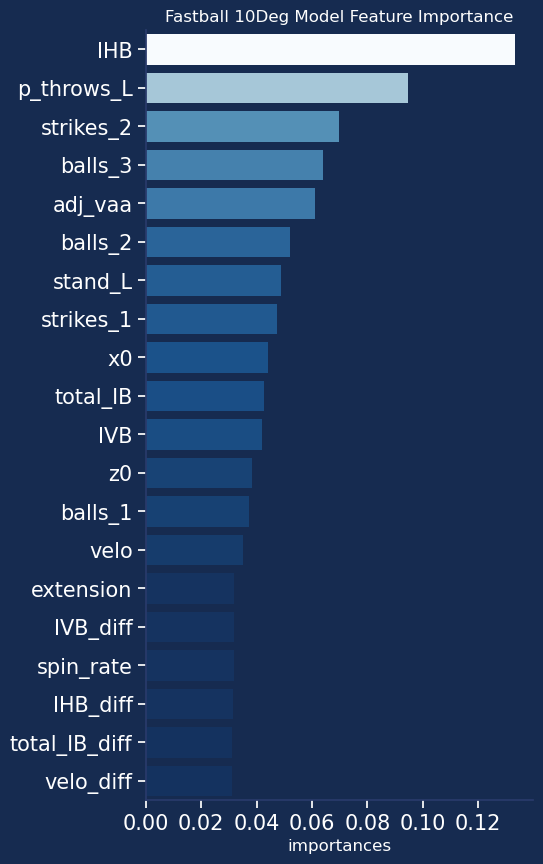

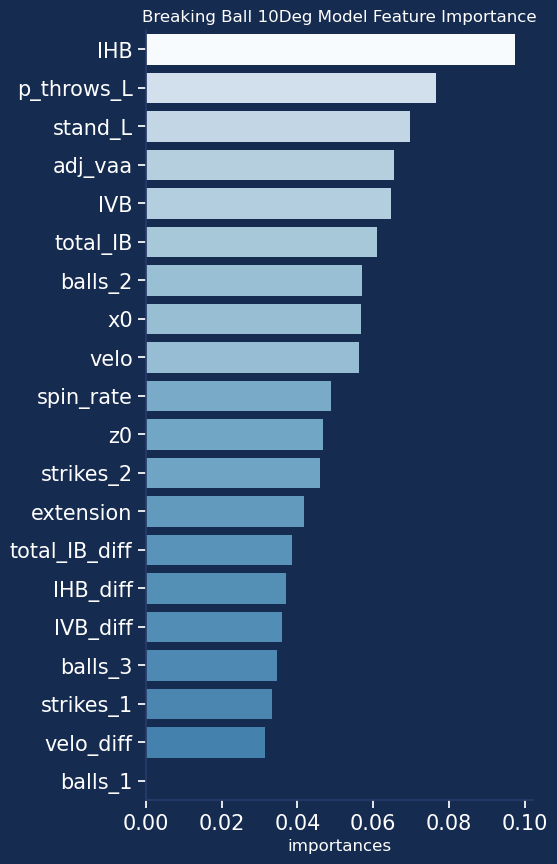

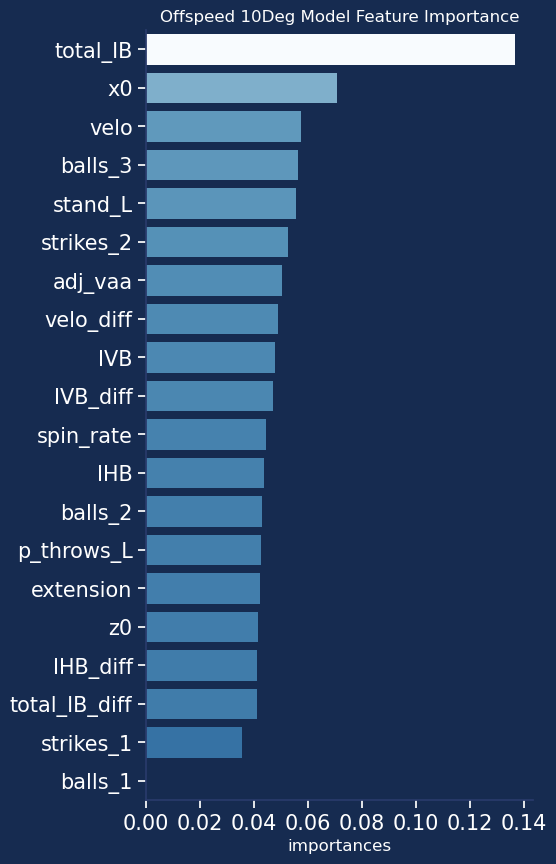

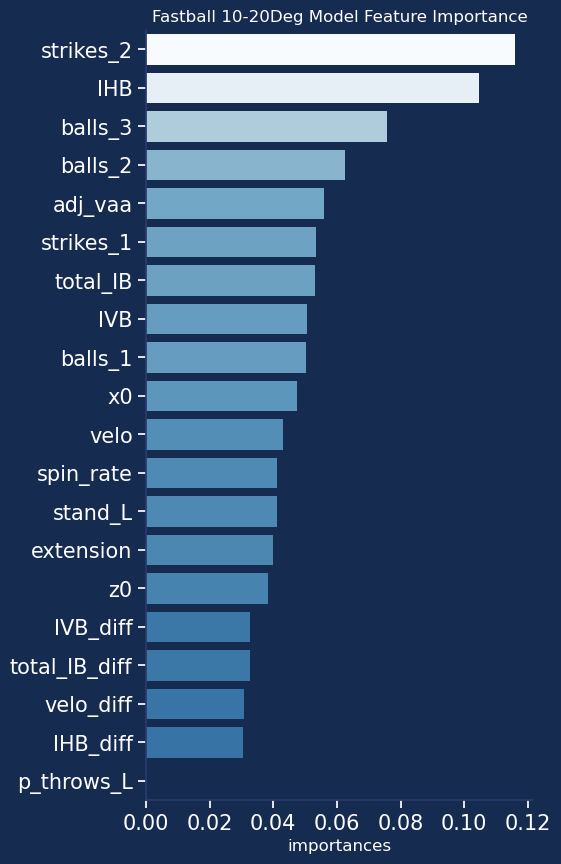

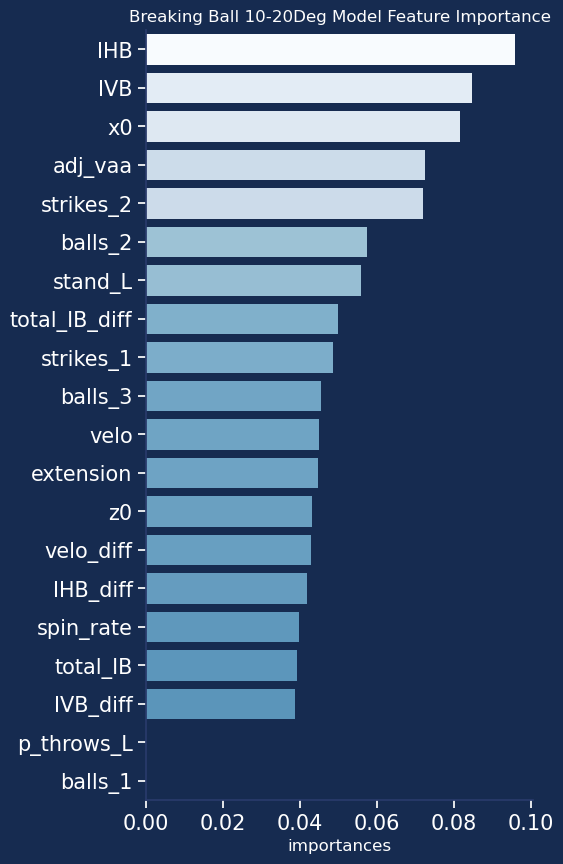

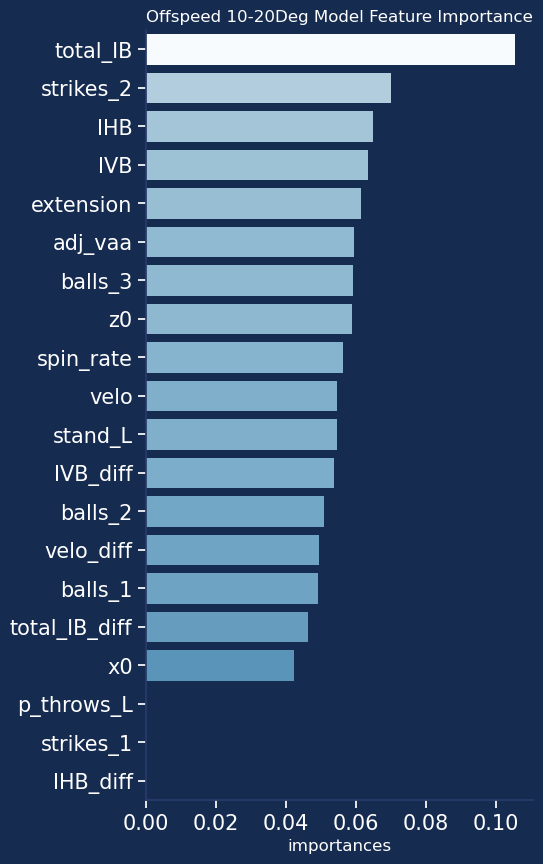

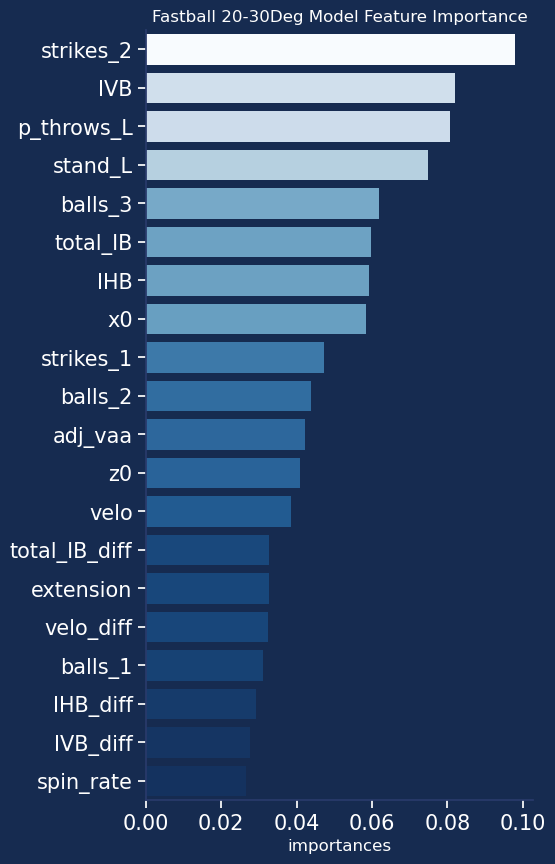

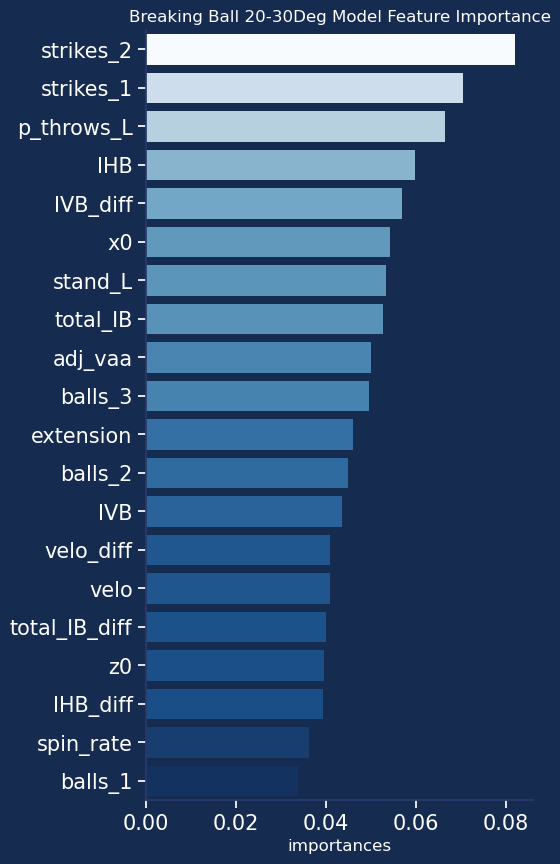

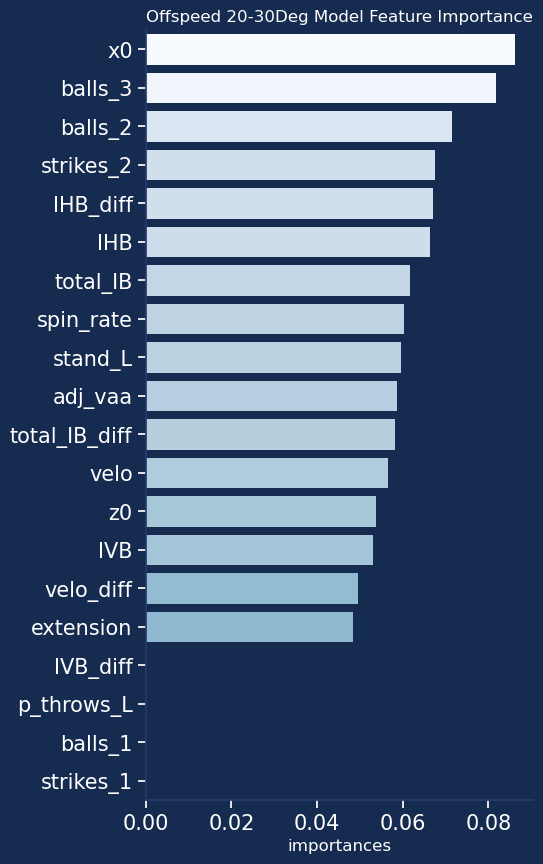

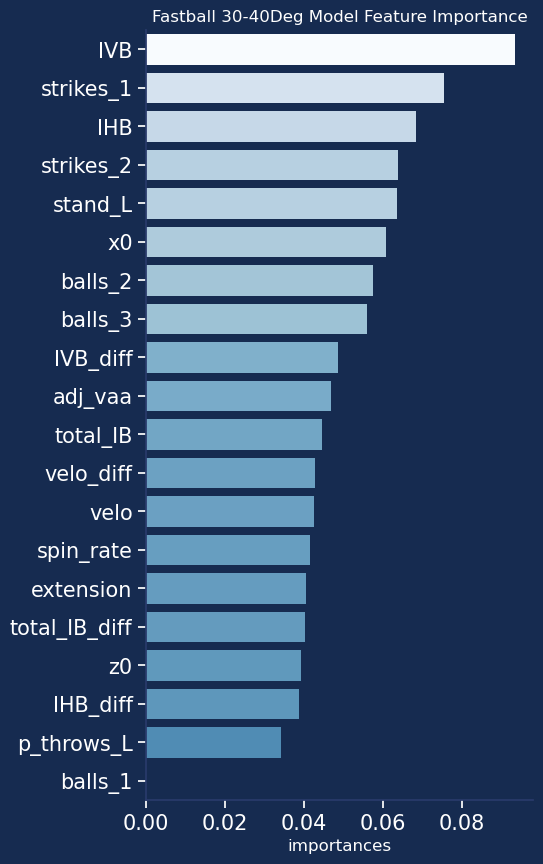

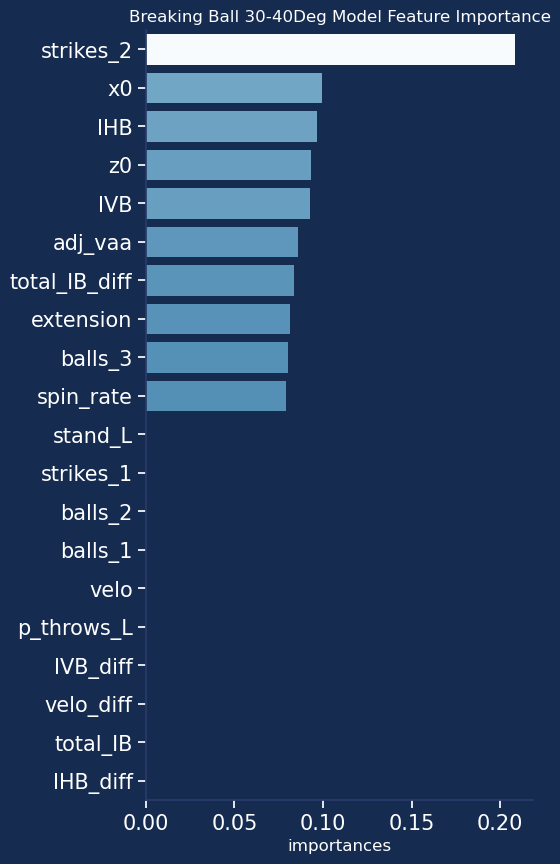

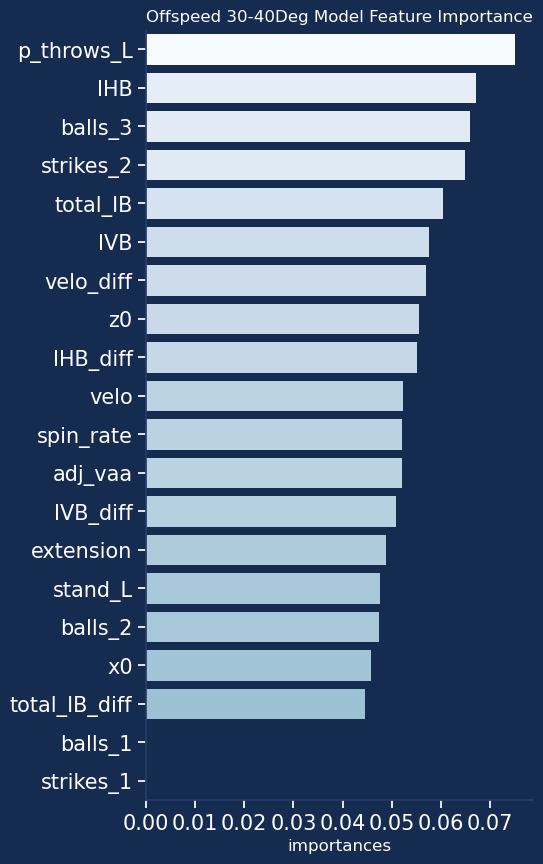

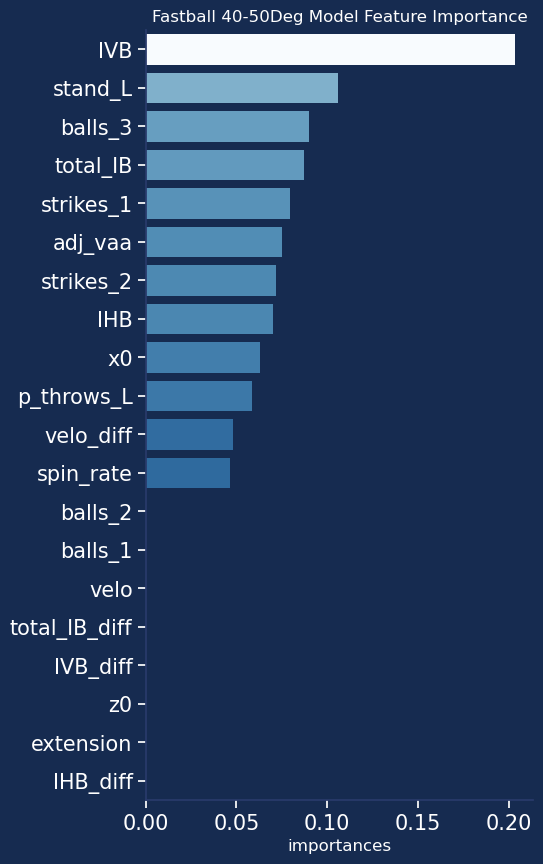

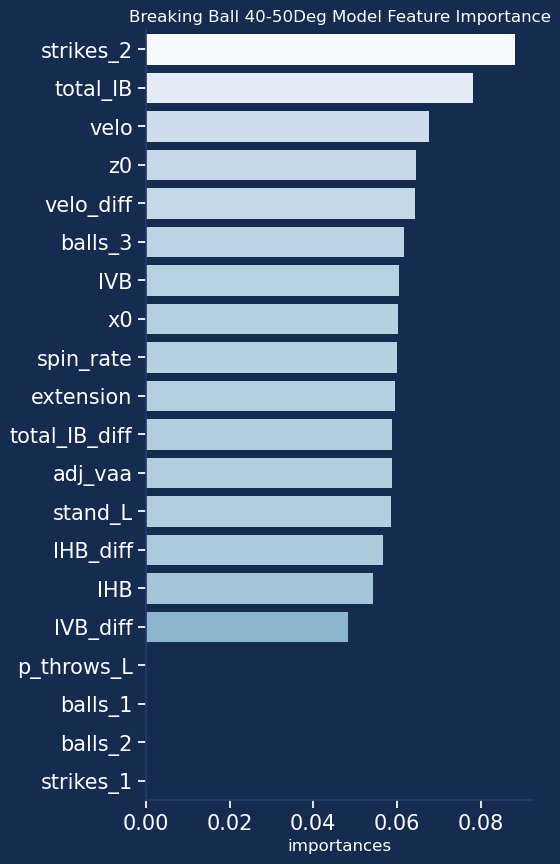

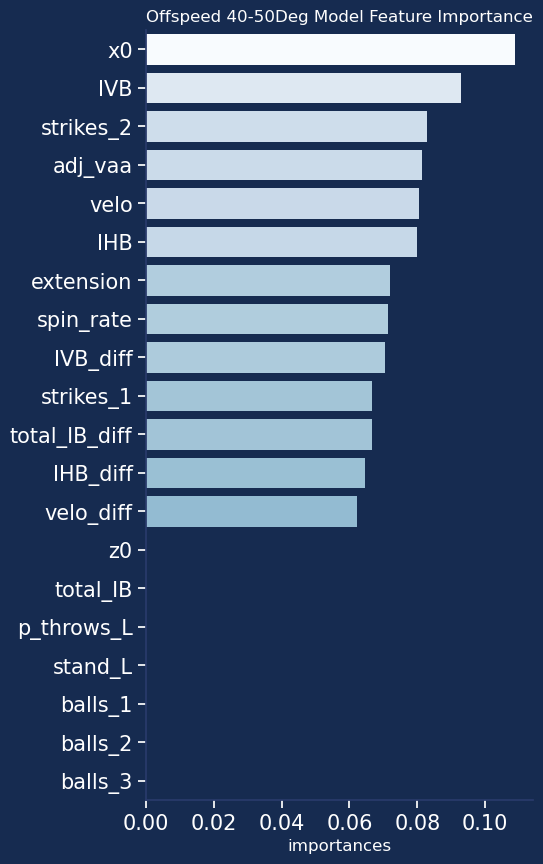

In [109]:
for angle in range(5):
    print(angle_map[angle])
    launch_velo_params, launch_velo_loss, launch_velo_time = model_train(model_df.loc[model_df['launch_angle_result']==angle],'launch_velo_result')
    model_comp(model_df.loc[model_df['launch_angle_result']==angle], 'launch_velo_result', launch_velo_params, angle=angle)

In [248]:
def stuff_preds(df):
    df[['swinging_strike_raw_temp','contact_raw_temp','contact_input_temp',
                'foul_strike_raw_temp','in_play_raw_temp','10deg_raw_temp','10-20deg_raw_temp',
                '20-30deg_raw_temp','30-40deg_raw_temp','40-50deg_raw_temp','50+deg_raw_temp',
                'swinging_strike_pred','foul_strike_pred','in_play_input','50+deg_pred',
                'out_pred', 'single_pred', 'double_pred', 'triple_pred', 'home_run_pred']] = None
    
    for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
        df[[launch_angle+'_input_temp',launch_angle+': <90mph_raw_temp',
                 launch_angle+': 90-95mph_raw_temp',launch_angle+': 95-100mph_raw_temp',
                 launch_angle+': 100-105mph_raw_temp',launch_angle+': 105+mph_raw_temp',
                 launch_angle+': <90mph_pred',launch_angle+': 90-95mph_pred',
                 launch_angle+': 95-100mph_pred',launch_angle+': 100-105mph_pred',
                 launch_angle+': 105+mph_pred']] = None
        
    for pitch_type in tqdm.tqdm(['Fastball','Breaking Ball','Offspeed']):
        # Swing Result
        
        with open(f'live_stuff_contact_model_{pitch_type}.pkl', 'rb') as f:
            swing_result_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['swinging_strike_pred','contact_input_temp']] = swing_result_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,swing_result_model.feature_names_in_])
        # print(pitch_type+' Swing Result model done')
    
        # Contact Result
        with open(f'live_stuff_in_play_model_{pitch_type}.pkl', 'rb') as f:
            contact_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['foul_strike_raw_temp','in_play_raw_temp']] = contact_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,contact_model.feature_names_in_])
        df.loc[df['pitch_type_bucket']==pitch_type,'foul_strike_pred'] = df.loc[df['pitch_type_bucket']==pitch_type,'foul_strike_raw_temp'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'contact_input_temp'])
        df.loc[df['pitch_type_bucket']==pitch_type,'in_play_input'] = df.loc[df['pitch_type_bucket']==pitch_type,'in_play_raw_temp'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'contact_input_temp'])
        # print(pitch_type+' Contact model done')
    
        # Launch Angle Result
        with open(f'live_stuff_launch_angle_model_{pitch_type}.pkl', 'rb') as f:
            launch_angle_model = pickle.load(f)
    
        df.loc[df['pitch_type_bucket']==pitch_type,['10deg_raw_temp','10-20deg_raw_temp','20-30deg_raw_temp','30-40deg_raw_temp','40-50deg_raw_temp','50+deg_raw_temp']] = launch_angle_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,launch_angle_model.feature_names_in_])
        for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
            df.loc[df['pitch_type_bucket']==pitch_type,launch_angle+'_input_temp'] = df.loc[df['pitch_type_bucket']==pitch_type,launch_angle+'_raw_temp'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'in_play_input'])
        df.loc[df['pitch_type_bucket']==pitch_type,'50+deg_pred'] = df.loc[df['pitch_type_bucket']==pitch_type,'50+deg_raw_temp'].mul(df.loc[df['pitch_type_bucket']==pitch_type,'in_play_input'])
        # print(pitch_type+' Launch Angle model done')
    
        # Launch Velo Result
        for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
            with open(f'live_stuff_{launch_angle}_model_{pitch_type}.pkl', 'rb') as f:
                launch_velo_model = pickle.load(f)
    
            df.loc[df['pitch_type_bucket']==pitch_type,[launch_angle+': <90mph_raw_temp',launch_angle+': 90-95mph_raw_temp',launch_angle+': 95-100mph_raw_temp',launch_angle+': 100-105mph_raw_temp',launch_angle+': 105+mph_raw_temp']] = launch_velo_model.predict_proba(df.loc[df['pitch_type_bucket']==pitch_type,launch_velo_model.feature_names_in_])
            for bucket in [launch_angle+': '+x for x in ['<90mph','90-95mph','95-100mph','100-105mph','105+mph']]:
                df.loc[df['pitch_type_bucket']==pitch_type,bucket+'_pred'] = df.loc[df['pitch_type_bucket']==pitch_type,bucket+'_raw_temp'].mul(df.loc[df['pitch_type_bucket']==pitch_type,launch_angle+'_input_temp'])

    return df.drop(columns=[x for x in df.columns.values if '_temp' in x]).copy()

In [249]:
model_df = stuff_preds(model_df)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:37<00:00, 12.55s/it]


In [250]:
bip_result_dict = (
    pd.read_csv('data_bip_result.csv')
    .set_index(['year_played','bb_bucket'])
    .to_dict(orient='index')
)

run_expectancies = pd.read_csv('re_12_vals.csv').set_index(['cleaned_description','count']).to_dict()['delta_re']
model_df['count'] = model_df['balls'].astype('str')+'_'+model_df['strikes'].astype('str')
model_df['re12'] = model_df[['cleaned_description','count']].apply(tuple,axis=1).map(run_expectancies)

In [252]:
model_df['delta_re'] = 0
model_df['delta_re_str'] = 0
model_df['delta_re_bbe'] = 0

# Apply averages to each predicted grouping
# for year in list(stuff_df['year_played'].unique()):
for year in model_df['year_played'].unique():
    for outcome in ['out', 'single', 'double', 'triple', 'home_run']:
        # Start with 50+ degrees (popups)
        model_df.loc[model_df['year_played']==year,outcome+'_pred'] = model_df.loc[model_df['year_played']==year,'50+deg_pred']*bip_result_dict[(year,'50+deg')][outcome]
        
        for launch_angle in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
            for bucket in [launch_angle+': '+x for x in ['<90mph','90-95mph','95-100mph','100-105mph','105+mph']]:
                model_df.loc[model_df['year_played']==year,outcome+'_pred'] += model_df.loc[model_df['year_played']==year,bucket+'_pred']*bip_result_dict[(year,bucket)][outcome]

for stat in ['swinging_strike','foul_strike','out','single','double','triple','home_run']:
    model_df[stat+'_re'] = stat
    model_df[stat+'_re'] = model_df[[stat+'_re','count']].apply(tuple,axis=1).map(run_expectancies)
    model_df['delta_re'] = model_df['delta_re'].add(model_df[stat+'_pred'].fillna(model_df[stat+'_pred'].groupby(model_df['year_played']).transform('median')).mul(model_df[stat+'_re']))
    if stat in ['swinging_strike','foul_strike']:
        model_df['delta_re_str'] = model_df['delta_re_str'].add(model_df[stat+'_pred'].fillna(model_df[stat+'_pred'].groupby(model_df['year_played']).transform('median')).mul(model_df[stat+'_re']))
    else:
        model_df['delta_re_bbe'] = model_df['delta_re_bbe'].add(model_df[stat+'_pred'].fillna(model_df[stat+'_pred'].groupby(model_df['year_played']).transform('median')).mul(model_df[stat+'_re']))

model_df['wOBAcon_pred'] = model_df[['single_pred', 'double_pred', 'triple_pred', 'home_run_pred']].mul([0.9,1.25,1.6,2]).sum(axis=1).div(model_df['in_play_input'].astype('float'))
model_df['str_rv'] = model_df['delta_re_str'].sub(model_df['delta_re_str'].groupby(model_df['year_played']).transform('mean'))
model_df['bbe_rv'] = model_df['delta_re_bbe'].sub(model_df['delta_re_bbe'].groupby(model_df['year_played']).transform('mean'))
model_df['stuff_rv'] = model_df['delta_re'].sub(model_df['delta_re'].groupby(model_df['year_played']).transform('mean'))
model_df['plv_stuff_plus'] = model_df['stuff_rv'].div(model_df['delta_re'].groupby(model_df['year_played']).transform('std')).mul(-50).add(100)

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\2248078458.py:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\2248078458.py:21: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\2248078458.py:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

In [116]:
def parse_height(height_str: str) -> float:
    """
    Parses the height string in the format 'ft in' and converts it to feet units.
    
    Parameters:
    height_str: Height string in the format 'ft in'

    Returns:
    Height in ft (float)
    """
    # split the height string into feet and inches
    feet, inches = height_str.split("' ")
    feet = int(feet)
    inches = int(inches.replace('"', ''))
    
    # convert the height to feet units
    height_in_feet = feet + inches / 12.0
    return height_in_feet

player_id_str = 697812
url = f'https://statsapi.mlb.com/api/v1/people?personIds={player_id_str}&fields=people,id,height,weight'

response = requests.get(url)

# raise an HTTPError if the request was unsuccessful
response.raise_for_status()  

json_data = response.json()['people'] # parse the JSON response
data = pd.DataFrame(json_data) # convert to DataFrame
data['height'] = data['height'].apply(parse_height) # convert height to ft
data

id  height  weight
0  697812     6.5     200

<Axes: xlabel='re12', ylabel='Density'>

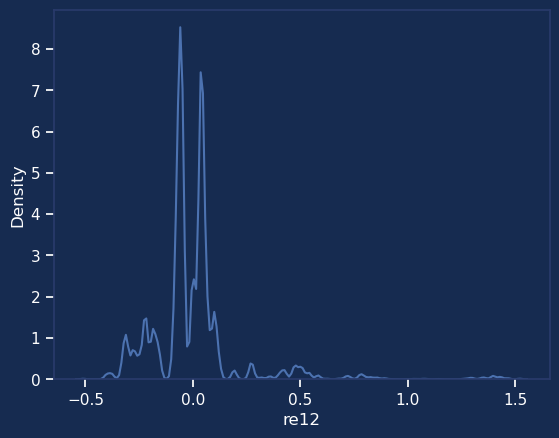

In [124]:
sns.kdeplot(model_df['re12'])

In [129]:
## Train-Test Split
target = 're12'
X = model_df.dropna(subset=[target])[model_feats].copy()

# Y
y = model_df.dropna(subset=[target])[target].astype('int').copy()

groups = model_df.dropna(subset=[target])['pitcher_id'].copy()

gss = GroupShuffleSplit(n_splits=2, train_size=.5)
train_ids, test_ids = next(gss.split(X, y, groups))
groups_train = groups.iloc[train_ids]
X_train = X.iloc[train_ids]
X_test =  X.iloc[test_ids]
y_train = y.iloc[train_ids]
y_test = y.iloc[test_ids]
  
# Instantiation 
xgb_r = XGBRegressor(objective ='reg:squarederror', 
                     n_estimators = 10, seed = 123) 

# Fitting the model 
xgb_r.fit(X_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
rmse = np.sqrt(mean_squared_error(y_test, pred)) 
print(f"RMSE: {rmse:.2f}") 

RMSE: 0.09


In [159]:
model_df['stuff_rv'] =  xgb_r.predict(model_df[model_feats]) 

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\1325507220.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='re12', ylabel='stuff_rv'>

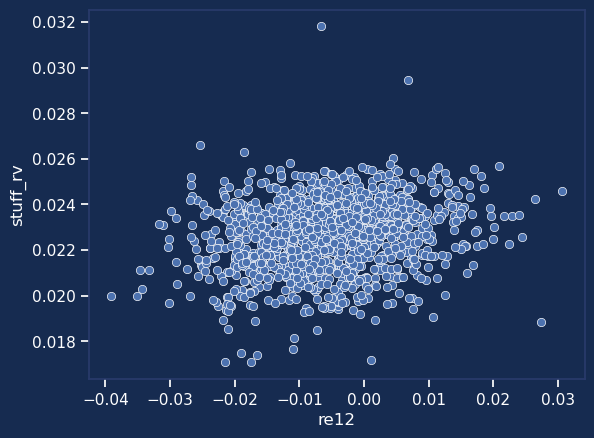

In [135]:
sns.scatterplot(model_df.groupby(['year_played','pitcher_id','pitch_type'])[['pitch_id','re12','stuff_rv']].agg({
    'pitch_id':'count',
    're12':'mean',
    'stuff_rv':'mean'
}).query('pitch_id >= 500'),
                x='re12',
                y='stuff_rv')

In [213]:
# Model Param Tuning
def rv_train(df):
    df = df.loc[df['swing']==1].reset_index()
    target = 're12'
    model_params = {}
    model_rmse = {}
    model_time = {}

    for pitch_type in pitch_types:
        type_start_time = time.time()
        ## Train-Test Split
        X = df.dropna(subset=[target]).loc[df['pitch_type_bucket']==pitch_type][model_feats].copy()
    
        # Y
        y = df.dropna(subset=[target]).loc[df['pitch_type_bucket']==pitch_type,target].astype('float').copy()

        groups = df.dropna(subset=[target]).loc[df['pitch_type_bucket']==pitch_type,'pitcher_id'].copy()

        gss = GroupShuffleSplit(n_splits=2, train_size=.5)
        train_ids, test_ids = next(gss.split(X, y, groups))
        groups_train = groups.iloc[train_ids]
        X_train = X.iloc[train_ids]
        X_test =  X.iloc[test_ids]
        y_train = y.iloc[train_ids]
        y_test = y.iloc[test_ids]
    
        # Define the objective function for Optuna
        def objective(trial):
            # Define the search space for hyperparameters
            param = {
                'tree_method':'gpu_hist',
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'n_jobs':-1,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                'n_estimators':400,
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'subsample': trial.suggest_float('subsample', 0.5, 0.9),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
                'gamma': trial.suggest_float('gamma', 0.0001, 1000),
                'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 15.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 1000),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 1000),
            }

            # Split the data into further training and validation sets (three sets are preferable)
            opt_train_ids, opt_test_ids = next(gss.split(X_train, y_train, groups_train))
            train_data = X_train.iloc[opt_train_ids]
            valid_data =  X_train.iloc[opt_test_ids]
            train_target = y_train.iloc[opt_train_ids]
            valid_target = y_train.iloc[opt_test_ids]

            # Convert the data into DMatrix format
            dtrain = xgb.DMatrix(train_data, label=train_target)
            dvalid = xgb.DMatrix(valid_data, label=valid_target)

            # Define the pruning callback for early stopping
            pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-rmse')

            # Train the model with early stopping
            model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], 
                              early_stopping_rounds=100, callbacks=[pruning_callback])

            # Make predictions on the test set
            y_pred = model.predict(dvalid).astype('float')
            
            return np.sqrt(mean_squared_error(valid_target, y_pred)) 

        # Create an Optuna study and optimize the objective function
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=400) # Control the number of trials
    
        # Print the best hyperparameters and the best RMSE
        best_params = study.best_params
        best_rmse = study.best_value
        print(f"Best {pitch_type} Hyperparameters: ", best_params)
        print(f"Best {pitch_type} RMSE: ", best_rmse)
        type_end_time = time.time()
        model_params.update({pitch_type:best_params})
        model_rmse.update({pitch_type:best_rmse})
        model_time.update({pitch_type:round(type_end_time - type_start_time,1)})
    return model_params, model_rmse, model_time

In [214]:
rv_params, rv_rmse, rv_model_time = rv_train(model_df)

[I 2024-10-14 17:34:16,498] A new study created in memory with name: no-name-8d7a91c4-88b5-4cb1-ad23-fe39d94ac279


[17:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.59133
[1]	validation-rmse:0.57769
[2]	validation-rmse:0.56460
[3]	validation-rmse:0.55205
[4]	validation-rmse:0.54000
[5]	validation-rmse:0.52842
[6]	validation-rmse:0.51732
[7]	validation-rmse:0.50671
[8]	validation-rmse:0.49653
[9]	validation-rmse:0.48679


[I 2024-10-14 17:34:17,102] Trial 0 finished with value: 0.4867898713598928 and parameters: {'learning_rate': 0.031244942816227736, 'max_depth': 16, 'subsample': 0.6370940533247342, 'colsample_bytree': 0.6322243225427066, 'gamma': 929.6568566289686, 'min_child_weight': 5.50395075986869}. Best is trial 0 with value: 0.4867898713598928.


[17:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.55262
[1]	validation-rmse:0.50734
[2]	validation-rmse:0.46918
[3]	validation-rmse:0.43721
[4]	validation-rmse:0.41071
[5]	validation-rmse:0.38894
[6]	validation-rmse:0.37125
[7]	validation-rmse:0.35687
[8]	validation-rmse:0.34527
[9]	validation-rmse:0.33594


[I 2024-10-14 17:34:17,746] Trial 1 finished with value: 0.33593550250211524 and parameters: {'learning_rate': 0.11926925401867469, 'max_depth': 8, 'subsample': 0.5331638314950274, 'colsample_bytree': 0.6201988727175132, 'gamma': 578.3640890113661, 'min_child_weight': 0.927980743914153}. Best is trial 1 with value: 0.33593550250211524.


[17:34:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.55520
[1]	validation-rmse:0.51225
[2]	validation-rmse:0.47566
[3]	validation-rmse:0.44474
[4]	validation-rmse:0.41864
[5]	validation-rmse:0.39682
[6]	validation-rmse:0.37882
[7]	validation-rmse:0.36391
[8]	validation-rmse:0.35173
[9]	validation-rmse:0.34178


[I 2024-10-14 17:34:18,392] Trial 2 finished with value: 0.3417830011007667 and parameters: {'learning_rate': 0.11156769254446532, 'max_depth': 18, 'subsample': 0.5175052860021235, 'colsample_bytree': 0.794521420719021, 'gamma': 586.6516439307557, 'min_child_weight': 11.764255132770618}. Best is trial 1 with value: 0.33593550250211524.


[17:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45784
[1]	validation-rmse:0.37721
[2]	validation-rmse:0.33643
[3]	validation-rmse:0.31731
[4]	validation-rmse:0.30877
[5]	validation-rmse:0.30507
[6]	validation-rmse:0.30351
[7]	validation-rmse:0.30285
[8]	validation-rmse:0.30259
[9]	validation-rmse:0.30249


[I 2024-10-14 17:34:19,089] Trial 3 finished with value: 0.3024931764515298 and parameters: {'learning_rate': 0.34195982013282405, 'max_depth': 3, 'subsample': 0.8655908636806198, 'colsample_bytree': 0.5549119334345283, 'gamma': 969.9547987440698, 'min_child_weight': 7.9564636449554245}. Best is trial 3 with value: 0.3024931764515298.


[17:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.44275
[1]	validation-rmse:0.36183
[2]	validation-rmse:0.32599
[3]	validation-rmse:0.31118
[4]	validation-rmse:0.30536
[5]	validation-rmse:0.30306
[6]	validation-rmse:0.30221
[7]	validation-rmse:0.30187
[8]	validation-rmse:0.30173
[9]	validation-rmse:0.30169


[I 2024-10-14 17:34:19,786] Trial 4 finished with value: 0.3016906969292665 and parameters: {'learning_rate': 0.3843309652888892, 'max_depth': 3, 'subsample': 0.6937552473773911, 'colsample_bytree': 0.8858233890834093, 'gamma': 344.85648642793217, 'min_child_weight': 8.886828557093128}. Best is trial 4 with value: 0.3016906969292665.
[I 2024-10-14 17:34:20,477] Trial 5 pruned. Trial was pruned at iteration 0.


[17:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42817
[1]	validation-rmse:0.34919
[2]	validation-rmse:0.31844
[3]	validation-rmse:0.30752
[4]	validation-rmse:0.30375
[5]	validation-rms

[I 2024-10-14 17:34:21,276] Trial 6 finished with value: 0.3018921998500356 and parameters: {'learning_rate': 0.4213044927390334, 'max_depth': 16, 'subsample': 0.724931980255495, 'colsample_bytree': 0.8276055899742563, 'gamma': 995.1416959042293, 'min_child_weight': 2.810612221554331}. Best is trial 4 with value: 0.3016906969292665.


[17:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.55881


[I 2024-10-14 17:34:21,910] Trial 7 pruned. Trial was pruned at iteration 0.


[17:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46057
[1]	validation-rmse:0.37963
[2]	validation-rmse:0.33787
[3]	validation-rmse:0.31760
[4]	validation-rmse:0.30830
[5]	validation-rmse:0.30406
[6]	validation-rmse:0.30219
[7]	validation-rmse:0.30132
[8]	validation-rmse:0.30096
[9]	validation-rmse:0.30079


[I 2024-10-14 17:34:22,668] Trial 8 finished with value: 0.30078544764874066 and parameters: {'learning_rate': 0.33633369173217753, 'max_depth': 13, 'subsample': 0.8038667731047262, 'colsample_bytree': 0.5130871614682069, 'gamma': 786.4976137981876, 'min_child_weight': 12.8234355273023}. Best is trial 8 with value: 0.30078544764874066.


[17:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.60089


[I 2024-10-14 17:34:23,328] Trial 9 pruned. Trial was pruned at iteration 0.


[17:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40219
[1]	validation-rmse:0.33205
[2]	validation-rmse:0.31229
[3]	validation-rmse:0.30727
[4]	validation-rmse:0.30613
[5]	validation-rmse:0.30591


[I 2024-10-14 17:34:24,038] Trial 10 pruned. Trial was pruned at iteration 5.


[17:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.47470


[I 2024-10-14 17:34:24,782] Trial 11 pruned. Trial was pruned at iteration 0.


[17:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.50406


[I 2024-10-14 17:34:25,399] Trial 12 pruned. Trial was pruned at iteration 0.


[17:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43908
[1]	validation-rmse:0.35831
[2]	validation-rmse:0.32300
[3]	validation-rmse:0.30874
[4]	validation-rmse:0.30327
[5]	validation-rmse:0.30111
[6]	validation-rmse:0.30028
[7]	validation-rmse:0.29995
[8]	validation-rmse:0.29983
[9]	validation-rmse:0.29977


[I 2024-10-14 17:34:26,205] Trial 13 finished with value: 0.29976552955498914 and parameters: {'learning_rate': 0.39200172552091006, 'max_depth': 14, 'subsample': 0.6987333156916105, 'colsample_bytree': 0.8952321985578515, 'gamma': 209.50600745054726, 'min_child_weight': 11.901130727511712}. Best is trial 13 with value: 0.29976552955498914.


[17:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.50404


[I 2024-10-14 17:34:26,951] Trial 14 pruned. Trial was pruned at iteration 0.


[17:34:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41517
[1]	validation-rmse:0.33911
[2]	validation-rmse:0.31315
[3]	validation-rmse:0.30510
[4]	validation-rmse:0.30259
[5]	validation-rmse:0.30186
[6]	validation-rmse:0.30163
[7]	validation-rmse:0.30157
[8]	validation-rmse:0.30155
[9]	validation-rmse:0.30155


[I 2024-10-14 17:34:27,699] Trial 15 finished with value: 0.30154580097824163 and parameters: {'learning_rate': 0.4572141021060403, 'max_depth': 13, 'subsample': 0.5860715953631717, 'colsample_bytree': 0.6775340734932356, 'gamma': 840.876902576054, 'min_child_weight': 13.363683801594624}. Best is trial 13 with value: 0.29976552955498914.


[17:34:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.48387


[I 2024-10-14 17:34:28,395] Trial 16 pruned. Trial was pruned at iteration 0.


[17:34:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45414
[1]	validation-rmse:0.37292
[2]	validation-rmse:0.33354
[3]	validation-rmse:0.31565
[4]	validation-rmse:0.30794
[5]	validation-rmse:0.30464


[I 2024-10-14 17:34:29,086] Trial 17 pruned. Trial was pruned at iteration 5.


[17:34:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.51928


[I 2024-10-14 17:34:29,782] Trial 18 pruned. Trial was pruned at iteration 0.


[17:34:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43381
[1]	validation-rmse:0.35365
[2]	validation-rmse:0.32064
[3]	validation-rmse:0.30817
[4]	validation-rmse:0.30363
[5]	validation-rmse:0.30202
[6]	validation-rmse:0.30146
[7]	validation-rmse:0.30125
[8]	validation-rmse:0.30119
[9]	validation-rmse:0.30116


[I 2024-10-14 17:34:30,568] Trial 19 finished with value: 0.30116309925994716 and parameters: {'learning_rate': 0.4058081568158244, 'max_depth': 16, 'subsample': 0.5846483430610321, 'colsample_bytree': 0.7523923307907863, 'gamma': 191.52955835472017, 'min_child_weight': 10.172133781078225}. Best is trial 13 with value: 0.29976552955498914.


[17:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46963


[I 2024-10-14 17:34:31,251] Trial 20 pruned. Trial was pruned at iteration 0.


[17:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43358
[1]	validation-rmse:0.35407
[2]	validation-rmse:0.32157
[3]	validation-rmse:0.30927
[4]	validation-rmse:0.30494
[5]	validation-rmse:0.30340


[I 2024-10-14 17:34:31,923] Trial 21 pruned. Trial was pruned at iteration 6.


[17:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41608
[1]	validation-rmse:0.33982
[2]	validation-rmse:0.31358
[3]	validation-rmse:0.30530
[4]	validation-rmse:0.30278
[5]	validation-rmse:0.30200
[6]	validation-rmse:0.30179
[7]	validation-rmse:0.30171
[8]	validation-rmse:0.30168
[9]	validation-rmse:0.30168


[I 2024-10-14 17:34:32,623] Trial 22 finished with value: 0.3016753813923028 and parameters: {'learning_rate': 0.45536188973195596, 'max_depth': 20, 'subsample': 0.560311339662216, 'colsample_bytree': 0.6991355299883779, 'gamma': 218.26192115133836, 'min_child_weight': 9.615255854624092}. Best is trial 13 with value: 0.29976552955498914.
[I 2024-10-14 17:34:33,189] Trial 23 pruned. Trial was pruned at iteration 0.


[17:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42217
[1]	validation-rmse:0.34446
[2]	validation-rmse:0.31562
[3]	validation-rmse:0.30577
[4]	validation-rmse:0.30252
[5]	validation-rms

[I 2024-10-14 17:34:33,823] Trial 24 finished with value: 0.3009807406639278 and parameters: {'learning_rate': 0.43541554116644415, 'max_depth': 16, 'subsample': 0.6749467120759058, 'colsample_bytree': 0.7838450470766144, 'gamma': 126.01602758648022, 'min_child_weight': 7.552214111081966}. Best is trial 13 with value: 0.29976552955498914.


[17:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41150
[1]	validation-rmse:0.33688
[2]	validation-rmse:0.31241
[3]	validation-rmse:0.30527
[4]	validation-rmse:0.30317
[5]	validation-rmse:0.30260


[I 2024-10-14 17:34:34,410] Trial 25 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 17:34:34,982] Trial 26 pruned. Trial was pruned at iteration 0.


[17:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.48847


[I 2024-10-14 17:34:35,587] Trial 27 pruned. Trial was pruned at iteration 0.


[17:34:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42205
[1]	validation-rmse:0.34417
[2]	validation-rmse:0.31556
[3]	validation-rmse:0.30604
[4]	validation-rmse:0.30298
[5]	validation-rmse:0.30204
[6]	validation-rmse:0.30176
[7]	validation-rmse:0.30168
[8]	validation-rmse:0.30167
[9]	validation-rmse:0.30166


[I 2024-10-14 17:34:36,219] Trial 28 finished with value: 0.30166189021677403 and parameters: {'learning_rate': 0.43578450138064473, 'max_depth': 12, 'subsample': 0.7773308454774999, 'colsample_bytree': 0.8768733922004017, 'gamma': 17.2314322447056, 'min_child_weight': 6.985828290439301}. Best is trial 13 with value: 0.29976552955498914.


[17:34:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40481
[1]	validation-rmse:0.33318
[2]	validation-rmse:0.31204
[3]	validation-rmse:0.30642
[4]	validation-rmse:0.30501


[I 2024-10-14 17:34:36,833] Trial 29 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 17:34:37,429] Trial 30 pruned. Trial was pruned at iteration 0.


[17:34:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42758
[1]	validation-rmse:0.34882
[2]	validation-rmse:0.31796
[3]	validation-rmse:0.30673
[4]	validation-rmse:0.30292
[5]	validation-rms

[I 2024-10-14 17:34:38,067] Trial 31 finished with value: 0.30093543811347917 and parameters: {'learning_rate': 0.42144501854880007, 'max_depth': 16, 'subsample': 0.6060917010354905, 'colsample_bytree': 0.7761816813094511, 'gamma': 171.93078263123027, 'min_child_weight': 8.44247011282161}. Best is trial 13 with value: 0.29976552955498914.


[17:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42539
[1]	validation-rmse:0.34664
[2]	validation-rmse:0.31680
[3]	validation-rmse:0.30643
[4]	validation-rmse:0.30288
[5]	validation-rmse:0.30168
[6]	validation-rmse:0.30129
[7]	validation-rmse:0.30114
[8]	validation-rmse:0.30109
[9]	validation-rmse:0.30108


[I 2024-10-14 17:34:38,734] Trial 32 finished with value: 0.30107781399056266 and parameters: {'learning_rate': 0.42948239940195604, 'max_depth': 17, 'subsample': 0.6125980721438891, 'colsample_bytree': 0.8271787561390992, 'gamma': 109.90344496857537, 'min_child_weight': 8.072511618025304}. Best is trial 13 with value: 0.29976552955498914.
[I 2024-10-14 17:34:39,303] Trial 33 pruned. Trial was pruned at iteration 0.


[17:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46375


[I 2024-10-14 17:34:39,952] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:34:40,588] Trial 35 pruned. Trial was pruned at iteration 0.


[17:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42097
[1]	validation-rmse:0.34361
[2]	validation-rmse:0.31548
[3]	validation-rmse:0.30610
[4]	validation-rmse:0.30312
[5]	validation-rms

[I 2024-10-14 17:34:41,273] Trial 36 pruned. Trial was pruned at iteration 5.


[17:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.47820


[I 2024-10-14 17:34:41,921] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:34:42,575] Trial 38 pruned. Trial was pruned at iteration 0.


[17:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45702


[I 2024-10-14 17:34:43,157] Trial 39 pruned. Trial was pruned at iteration 0.


[17:34:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43195
[1]	validation-rmse:0.35244
[2]	validation-rmse:0.32034


[I 2024-10-14 17:34:43,787] Trial 40 pruned. Trial was pruned at iteration 3.


[17:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42497
[1]	validation-rmse:0.34650
[2]	validation-rmse:0.31672
[3]	validation-rmse:0.30652
[4]	validation-rmse:0.30314


[I 2024-10-14 17:34:44,385] Trial 41 pruned. Trial was pruned at iteration 5.


[17:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41026
[1]	validation-rmse:0.33582
[2]	validation-rmse:0.31229
[3]	validation-rmse:0.30543
[4]	validation-rmse:0.30354
[5]	validation-rmse:0.30302


[I 2024-10-14 17:34:45,019] Trial 42 pruned. Trial was pruned at iteration 5.


[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43082
[1]	validation-rmse:0.35201


[I 2024-10-14 17:34:45,641] Trial 43 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 17:34:46,244] Trial 44 pruned. Trial was pruned at iteration 0.


[17:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41797
[1]	validation-rmse:0.34159
[2]	validation-rmse:0.31518
[3]	validation-rmse:0.30689


[I 2024-10-14 17:34:46,841] Trial 45 pruned. Trial was pruned at iteration 4.


[17:34:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39988
[1]	validation-rmse:0.32836
[2]	validation-rmse:0.30746
[3]	validation-rmse:0.30199
[4]	validation-rmse:0.30049
[5]	validation-rmse:0.30009
[6]	validation-rmse:0.29998
[7]	validation-rmse:0.29995
[8]	validation-rmse:0.29993
[9]	validation-rmse:0.29993


[I 2024-10-14 17:34:47,487] Trial 46 finished with value: 0.29992976449627 and parameters: {'learning_rate': 0.49948474961082473, 'max_depth': 19, 'subsample': 0.6316399147766719, 'colsample_bytree': 0.7871469601672951, 'gamma': 404.187886496587, 'min_child_weight': 10.537892120007225}. Best is trial 13 with value: 0.29976552955498914.


[17:34:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40027
[1]	validation-rmse:0.32916
[2]	validation-rmse:0.30854
[3]	validation-rmse:0.30318
[4]	validation-rmse:0.30183
[5]	validation-rmse:0.30149
[6]	validation-rmse:0.30140
[7]	validation-rmse:0.30138
[8]	validation-rmse:0.30137
[9]	validation-rmse:0.30137


[I 2024-10-14 17:34:48,171] Trial 47 finished with value: 0.30137210116613816 and parameters: {'learning_rate': 0.49792839162805613, 'max_depth': 19, 'subsample': 0.6854035652820192, 'colsample_bytree': 0.6925494006291706, 'gamma': 409.98594970815714, 'min_child_weight': 11.386748965677205}. Best is trial 13 with value: 0.29976552955498914.


[17:34:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41031
[1]	validation-rmse:0.33561
[2]	validation-rmse:0.31140
[3]	validation-rmse:0.30428
[4]	validation-rmse:0.30224
[5]	validation-rmse:0.30164
[6]	validation-rmse:0.30147
[7]	validation-rmse:0.30141
[8]	validation-rmse:0.30140
[9]	validation-rmse:0.30139


[I 2024-10-14 17:34:48,801] Trial 48 finished with value: 0.30139226721406 and parameters: {'learning_rate': 0.47057064870800314, 'max_depth': 13, 'subsample': 0.6335896844371017, 'colsample_bytree': 0.7890296834806647, 'gamma': 628.4300677454977, 'min_child_weight': 12.685576500593827}. Best is trial 13 with value: 0.29976552955498914.
[I 2024-10-14 17:34:49,409] Trial 49 pruned. Trial was pruned at iteration 0.


[17:34:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:34:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40524
[1]	validation-rmse:0.33202
[2]	validation-rmse:0.30946
[3]	validation-rmse:0.30311
[4]	validation-rmse:0.30141
[5]	validation-rms

[I 2024-10-14 17:34:50,122] Trial 50 finished with value: 0.3008179788034752 and parameters: {'learning_rate': 0.48228598977598863, 'max_depth': 12, 'subsample': 0.7439833031907853, 'colsample_bytree': 0.6822977993629223, 'gamma': 373.4122749355013, 'min_child_weight': 14.216803924699214}. Best is trial 13 with value: 0.29976552955498914.


[17:34:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40435
[1]	validation-rmse:0.33157
[2]	validation-rmse:0.30966
[3]	validation-rmse:0.30366
[4]	validation-rmse:0.30208
[5]	validation-rmse:0.30165
[6]	validation-rmse:0.30155
[7]	validation-rmse:0.30152


[I 2024-10-14 17:34:50,739] Trial 51 pruned. Trial was pruned at iteration 7.


[17:34:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43707


[I 2024-10-14 17:34:51,307] Trial 52 pruned. Trial was pruned at iteration 0.


[17:34:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.58517


[I 2024-10-14 17:34:51,881] Trial 53 pruned. Trial was pruned at iteration 0.


[17:34:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40924
[1]	validation-rmse:0.33413
[2]	validation-rmse:0.30990
[3]	validation-rmse:0.30271
[4]	validation-rmse:0.30056
[5]	validation-rmse:0.29991
[6]	validation-rmse:0.29972
[7]	validation-rmse:0.29965
[8]	validation-rmse:0.29962
[9]	validation-rmse:0.29961


[I 2024-10-14 17:34:52,529] Trial 54 finished with value: 0.29960829871813166 and parameters: {'learning_rate': 0.4733675984472865, 'max_depth': 14, 'subsample': 0.7675146688032806, 'colsample_bytree': 0.6566669456060718, 'gamma': 389.48769457956735, 'min_child_weight': 14.359673527252902}. Best is trial 54 with value: 0.29960829871813166.


[17:34:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41714
[1]	validation-rmse:0.34019
[2]	validation-rmse:0.31325
[3]	validation-rmse:0.30466
[4]	validation-rmse:0.30198
[5]	validation-rmse:0.30117
[6]	validation-rmse:0.30089
[7]	validation-rmse:0.30080
[8]	validation-rmse:0.30077
[9]	validation-rmse:0.30076


[I 2024-10-14 17:34:53,168] Trial 55 finished with value: 0.30076142380900867 and parameters: {'learning_rate': 0.45145617738120053, 'max_depth': 5, 'subsample': 0.7702449265218118, 'colsample_bytree': 0.6556702017400686, 'gamma': 452.11919871370606, 'min_child_weight': 14.438080171481301}. Best is trial 54 with value: 0.29960829871813166.


[17:34:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40851
[1]	validation-rmse:0.33482
[2]	validation-rmse:0.31170
[3]	validation-rmse:0.30504
[4]	validation-rmse:0.30318


[I 2024-10-14 17:34:53,769] Trial 56 pruned. Trial was pruned at iteration 4.


[17:34:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41612
[1]	validation-rmse:0.33997
[2]	validation-rmse:0.31384
[3]	validation-rmse:0.30571


[I 2024-10-14 17:34:54,369] Trial 57 pruned. Trial was pruned at iteration 4.


[17:34:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40075
[1]	validation-rmse:0.33052
[2]	validation-rmse:0.31072
[3]	validation-rmse:0.30579


[I 2024-10-14 17:34:54,983] Trial 58 pruned. Trial was pruned at iteration 4.


[17:34:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41767
[1]	validation-rmse:0.34084
[2]	validation-rmse:0.31424
[3]	validation-rmse:0.30571


[I 2024-10-14 17:34:55,601] Trial 59 pruned. Trial was pruned at iteration 4.


[17:34:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41393
[1]	validation-rmse:0.33723
[2]	validation-rmse:0.31088
[3]	validation-rmse:0.30246
[4]	validation-rmse:0.29988
[5]	validation-rmse:0.29907
[6]	validation-rmse:0.29877
[7]	validation-rmse:0.29868
[8]	validation-rmse:0.29863
[9]	validation-rmse:0.29861


[I 2024-10-14 17:34:56,241] Trial 60 finished with value: 0.2986058075361367 and parameters: {'learning_rate': 0.4597293327403124, 'max_depth': 7, 'subsample': 0.7917480973510176, 'colsample_bytree': 0.6738071099286488, 'gamma': 378.46198079514363, 'min_child_weight': 14.343412870557703}. Best is trial 60 with value: 0.2986058075361367.


[17:34:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41232
[1]	validation-rmse:0.33722
[2]	validation-rmse:0.31248
[3]	validation-rmse:0.30505
[4]	validation-rmse:0.30289


[I 2024-10-14 17:34:56,839] Trial 61 pruned. Trial was pruned at iteration 5.


[17:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40529
[1]	validation-rmse:0.33161
[2]	validation-rmse:0.30892
[3]	validation-rmse:0.30242
[4]	validation-rmse:0.30062
[5]	validation-rmse:0.30008
[6]	validation-rmse:0.29992
[7]	validation-rmse:0.29987
[8]	validation-rmse:0.29985
[9]	validation-rmse:0.29985


[I 2024-10-14 17:34:57,481] Trial 62 finished with value: 0.29984875838913616 and parameters: {'learning_rate': 0.4846415290720647, 'max_depth': 11, 'subsample': 0.7356699621034161, 'colsample_bytree': 0.6323101345406144, 'gamma': 483.63717809289705, 'min_child_weight': 13.20874559152664}. Best is trial 60 with value: 0.2986058075361367.


[17:34:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41811
[1]	validation-rmse:0.34129
[2]	validation-rmse:0.31437
[3]	validation-rmse:0.30577


[I 2024-10-14 17:34:58,086] Trial 63 pruned. Trial was pruned at iteration 4.


[17:34:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40776
[1]	validation-rmse:0.33366
[2]	validation-rmse:0.31017
[3]	validation-rmse:0.30346
[4]	validation-rmse:0.30157
[5]	validation-rmse:0.30105
[6]	validation-rmse:0.30092
[7]	validation-rmse:0.30087
[8]	validation-rmse:0.30086
[9]	validation-rmse:0.30086


[I 2024-10-14 17:34:58,762] Trial 64 finished with value: 0.30085778142228287 and parameters: {'learning_rate': 0.4767656079029589, 'max_depth': 7, 'subsample': 0.8219501883717387, 'colsample_bytree': 0.623971963357173, 'gamma': 475.29238195963626, 'min_child_weight': 13.716193504524323}. Best is trial 60 with value: 0.2986058075361367.


[17:34:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43389


[I 2024-10-14 17:34:59,344] Trial 65 pruned. Trial was pruned at iteration 0.


[17:34:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40084
[1]	validation-rmse:0.32912
[2]	validation-rmse:0.30843
[3]	validation-rmse:0.30291
[4]	validation-rmse:0.30147
[5]	validation-rmse:0.30111
[6]	validation-rmse:0.30099
[7]	validation-rmse:0.30097
[8]	validation-rmse:0.30095
[9]	validation-rmse:0.30095


[I 2024-10-14 17:34:59,978] Trial 66 finished with value: 0.30095007495008835 and parameters: {'learning_rate': 0.4976735537956017, 'max_depth': 7, 'subsample': 0.7651963749034696, 'colsample_bytree': 0.5221287879751491, 'gamma': 323.3845699358985, 'min_child_weight': 13.01363270487272}. Best is trial 60 with value: 0.2986058075361367.


[17:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42122


[I 2024-10-14 17:35:00,561] Trial 67 pruned. Trial was pruned at iteration 1.


[17:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41334
[1]	validation-rmse:0.33741
[2]	validation-rmse:0.31204
[3]	validation-rmse:0.30414
[4]	validation-rmse:0.30178
[5]	validation-rmse:0.30106
[6]	validation-rmse:0.30084
[7]	validation-rmse:0.30078
[8]	validation-rmse:0.30076
[9]	validation-rmse:0.30075


[I 2024-10-14 17:35:01,175] Trial 68 finished with value: 0.3007518961824561 and parameters: {'learning_rate': 0.46149479207175387, 'max_depth': 9, 'subsample': 0.7328225870156028, 'colsample_bytree': 0.5635542285105928, 'gamma': 661.7259669393464, 'min_child_weight': 14.579325677080416}. Best is trial 60 with value: 0.2986058075361367.


[17:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41263
[1]	validation-rmse:0.33747
[2]	validation-rmse:0.31265
[3]	validation-rmse:0.30515


[I 2024-10-14 17:35:01,790] Trial 69 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 17:35:02,373] Trial 70 pruned. Trial was pruned at iteration 0.


[17:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42656


[I 2024-10-14 17:35:02,971] Trial 71 pruned. Trial was pruned at iteration 0.


[17:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40558
[1]	validation-rmse:0.33313
[2]	validation-rmse:0.31123
[3]	validation-rmse:0.30522


[I 2024-10-14 17:35:03,599] Trial 72 pruned. Trial was pruned at iteration 4.


[17:35:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.49913


[I 2024-10-14 17:35:04,179] Trial 73 pruned. Trial was pruned at iteration 0.


[17:35:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43886


[I 2024-10-14 17:35:04,795] Trial 74 pruned. Trial was pruned at iteration 0.


[17:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41270
[1]	validation-rmse:0.33747
[2]	validation-rmse:0.31252
[3]	validation-rmse:0.30499


[I 2024-10-14 17:35:05,435] Trial 75 pruned. Trial was pruned at iteration 4.


[17:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46716


[I 2024-10-14 17:35:06,008] Trial 76 pruned. Trial was pruned at iteration 0.


[17:35:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42154


[I 2024-10-14 17:35:06,599] Trial 77 pruned. Trial was pruned at iteration 0.


[17:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42809


[I 2024-10-14 17:35:07,193] Trial 78 pruned. Trial was pruned at iteration 0.


[17:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45070


[I 2024-10-14 17:35:07,805] Trial 79 pruned. Trial was pruned at iteration 0.


[17:35:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41644
[1]	validation-rmse:0.34079


[I 2024-10-14 17:35:08,420] Trial 80 pruned. Trial was pruned at iteration 2.


[17:35:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40543
[1]	validation-rmse:0.33189
[2]	validation-rmse:0.30909
[3]	validation-rmse:0.30265
[4]	validation-rmse:0.30088
[5]	validation-rmse:0.30041
[6]	validation-rmse:0.30028
[7]	validation-rmse:0.30025
[8]	validation-rmse:0.30023
[9]	validation-rmse:0.30023


[I 2024-10-14 17:35:09,052] Trial 81 finished with value: 0.3002294380869444 and parameters: {'learning_rate': 0.48248551139545565, 'max_depth': 13, 'subsample': 0.7411705290645766, 'colsample_bytree': 0.6867937560442963, 'gamma': 381.49416939040475, 'min_child_weight': 14.032359862674843}. Best is trial 60 with value: 0.2986058075361367.


[17:35:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40427
[1]	validation-rmse:0.33052
[2]	validation-rmse:0.30779
[3]	validation-rmse:0.30134
[4]	validation-rmse:0.29951
[5]	validation-rmse:0.29902
[6]	validation-rmse:0.29887
[7]	validation-rmse:0.29882
[8]	validation-rmse:0.29879
[9]	validation-rmse:0.29878


[I 2024-10-14 17:35:09,693] Trial 82 finished with value: 0.29878476966313633 and parameters: {'learning_rate': 0.48479472861975814, 'max_depth': 14, 'subsample': 0.7671243042559953, 'colsample_bytree': 0.6523138777472811, 'gamma': 342.01155649282543, 'min_child_weight': 13.508769140640883}. Best is trial 60 with value: 0.2986058075361367.


[17:35:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40546
[1]	validation-rmse:0.33354
[2]	validation-rmse:0.31225
[3]	validation-rmse:0.30652


[I 2024-10-14 17:35:10,288] Trial 83 pruned. Trial was pruned at iteration 3.


[17:35:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40766
[1]	validation-rmse:0.33318
[2]	validation-rmse:0.30973
[3]	validation-rmse:0.30290
[4]	validation-rmse:0.30099
[5]	validation-rmse:0.30045
[6]	validation-rmse:0.30029
[7]	validation-rmse:0.30024
[8]	validation-rmse:0.30023
[9]	validation-rmse:0.30023


[I 2024-10-14 17:35:10,903] Trial 84 finished with value: 0.3002261091373828 and parameters: {'learning_rate': 0.4759126973238557, 'max_depth': 14, 'subsample': 0.738788233516783, 'colsample_bytree': 0.6614558303926685, 'gamma': 428.2464381517624, 'min_child_weight': 13.961412813319539}. Best is trial 60 with value: 0.2986058075361367.


[17:35:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40626
[1]	validation-rmse:0.33281
[2]	validation-rmse:0.31020
[3]	validation-rmse:0.30371
[4]	validation-rmse:0.30198
[5]	validation-rmse:0.30154


[I 2024-10-14 17:35:11,511] Trial 85 pruned. Trial was pruned at iteration 5.


[17:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40870
[1]	validation-rmse:0.33473
[2]	validation-rmse:0.31129
[3]	validation-rmse:0.30457
[4]	validation-rmse:0.30270


[I 2024-10-14 17:35:12,144] Trial 86 pruned. Trial was pruned at iteration 4.


[17:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40148
[1]	validation-rmse:0.32956
[2]	validation-rmse:0.30846
[3]	validation-rmse:0.30279
[4]	validation-rmse:0.30133
[5]	validation-rmse:0.30095
[6]	validation-rmse:0.30086
[7]	validation-rmse:0.30084
[8]	validation-rmse:0.30084
[9]	validation-rmse:0.30084


[I 2024-10-14 17:35:12,823] Trial 87 finished with value: 0.3008370337595337 and parameters: {'learning_rate': 0.4921703017289779, 'max_depth': 14, 'subsample': 0.7352435220850161, 'colsample_bytree': 0.6447118988878001, 'gamma': 427.8439748577756, 'min_child_weight': 11.204562833121765}. Best is trial 60 with value: 0.2986058075361367.
[I 2024-10-14 17:35:13,413] Trial 88 pruned. Trial was pruned at iteration 0.


[17:35:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41102
[1]	validation-rmse:0.33587
[2]	validation-rmse:0.31138
[3]	validation-rmse:0.30399
[4]	validation-rmse:0.30177
[5]	validation-rms

[I 2024-10-14 17:35:14,062] Trial 89 finished with value: 0.3008162762070906 and parameters: {'learning_rate': 0.46858981495948315, 'max_depth': 12, 'subsample': 0.68208137815154, 'colsample_bytree': 0.6315375421043823, 'gamma': 318.82480327192184, 'min_child_weight': 13.486761638569305}. Best is trial 60 with value: 0.2986058075361367.


[17:35:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40215
[1]	validation-rmse:0.33005
[2]	validation-rmse:0.30915
[3]	validation-rmse:0.30354
[4]	validation-rmse:0.30209
[5]	validation-rmse:0.30170


[I 2024-10-14 17:35:14,676] Trial 90 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 17:35:15,241] Trial 91 pruned. Trial was pruned at iteration 0.


[17:35:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41946


[I 2024-10-14 17:35:15,834] Trial 92 pruned. Trial was pruned at iteration 0.


[17:35:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40116
[1]	validation-rmse:0.33079
[2]	validation-rmse:0.31099


[I 2024-10-14 17:35:16,461] Trial 93 pruned. Trial was pruned at iteration 3.


[17:35:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40984
[1]	validation-rmse:0.33544
[2]	validation-rmse:0.31140
[3]	validation-rmse:0.30434
[4]	validation-rmse:0.30233


[I 2024-10-14 17:35:17,053] Trial 94 pruned. Trial was pruned at iteration 4.


[17:35:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41402
[1]	validation-rmse:0.33846
[2]	validation-rmse:0.31308


[I 2024-10-14 17:35:17,651] Trial 95 pruned. Trial was pruned at iteration 3.


[17:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40645
[1]	validation-rmse:0.33307
[2]	validation-rmse:0.31058
[3]	validation-rmse:0.30431
[4]	validation-rmse:0.30257


[I 2024-10-14 17:35:18,267] Trial 96 pruned. Trial was pruned at iteration 4.


[17:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42876


[I 2024-10-14 17:35:18,843] Trial 97 pruned. Trial was pruned at iteration 0.


[17:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.51467


[I 2024-10-14 17:35:19,429] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:20,020] Trial 99 pruned. Trial was pruned at iteration 0.


[17:35:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Fastball Hyperparameters:  {'learning_rate': 0.4597293327403124, 'max_depth': 7, 'subsample': 0.7917480973510176, 'colsample_bytree': 0.6738071099286488, 'gamma': 378.46198079514363, 'min_child_weight': 14.343412870557703}
Best Fastball RMSE:  0.2986058075361367


[I 2024-10-14 17:35:21,200] A new study created in memory with name: no-name-e83a3b44-bd9a-4981-99e1-369c9f7313b5


[17:35:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.54920
[1]	validation-rmse:0.49964
[2]	validation-rmse:0.45836
[3]	validation-rmse:0.42424
[4]	validation-rmse:0.39621
[5]	validation-rmse:0.37354
[6]	validation-rmse:0.35527
[7]	validation-rmse:0.34068
[8]	validation-rmse:0.32914
[9]	validation-rmse:0.32000


[I 2024-10-14 17:35:21,646] Trial 0 finished with value: 0.3200029933884252 and parameters: {'learning_rate': 0.12793965687443318, 'max_depth': 7, 'subsample': 0.8470705627539125, 'colsample_bytree': 0.6593764788067513, 'gamma': 871.4901026673912, 'min_child_weight': 2.797345280860862}. Best is trial 0 with value: 0.3200029933884252.


[17:35:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.51451
[1]	validation-rmse:0.44507
[2]	validation-rmse:0.39525
[3]	validation-rmse:0.36001
[4]	validation-rmse:0.33590
[5]	validation-rmse:0.31968
[6]	validation-rmse:0.30905
[7]	validation-rmse:0.30210
[8]	validation-rmse:0.29769
[9]	validation-rmse:0.29492


[I 2024-10-14 17:35:22,023] Trial 1 finished with value: 0.29492092792112495 and parameters: {'learning_rate': 0.205705201871389, 'max_depth': 9, 'subsample': 0.50758768865871, 'colsample_bytree': 0.530387568457291, 'gamma': 912.4892612085604, 'min_child_weight': 2.1990201381331405}. Best is trial 1 with value: 0.29492092792112495.


[17:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.44451
[1]	validation-rmse:0.36010
[2]	validation-rmse:0.32067
[3]	validation-rmse:0.30365
[4]	validation-rmse:0.29677
[5]	validation-rmse:0.29404
[6]	validation-rmse:0.29296
[7]	validation-rmse:0.29255
[8]	validation-rmse:0.29239
[9]	validation-rmse:0.29234


[I 2024-10-14 17:35:22,390] Trial 2 finished with value: 0.29234032474900135 and parameters: {'learning_rate': 0.37102892600036363, 'max_depth': 7, 'subsample': 0.7997316646109575, 'colsample_bytree': 0.6124972010479139, 'gamma': 659.3366097955636, 'min_child_weight': 6.2483761343675255}. Best is trial 2 with value: 0.29234032474900135.


[17:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43567
[1]	validation-rmse:0.35119
[2]	validation-rmse:0.31423
[3]	validation-rmse:0.29924
[4]	validation-rmse:0.29341
[5]	validation-rmse:0.29119
[6]	validation-rmse:0.29036
[7]	validation-rmse:0.29006
[8]	validation-rmse:0.28993
[9]	validation-rmse:0.28987


[I 2024-10-14 17:35:22,757] Trial 3 finished with value: 0.28987046287727414 and parameters: {'learning_rate': 0.3921116632526707, 'max_depth': 9, 'subsample': 0.7737352172442085, 'colsample_bytree': 0.8759109747673104, 'gamma': 678.6605775479377, 'min_child_weight': 7.73271071088929}. Best is trial 3 with value: 0.28987046287727414.


[17:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43216
[1]	validation-rmse:0.34783
[2]	validation-rmse:0.31249
[3]	validation-rmse:0.29878
[4]	validation-rmse:0.29380
[5]	validation-rmse:0.29185
[6]	validation-rmse:0.29109
[7]	validation-rmse:0.29080
[8]	validation-rmse:0.29071
[9]	validation-rmse:0.29065


[I 2024-10-14 17:35:23,127] Trial 4 finished with value: 0.2906540368975171 and parameters: {'learning_rate': 0.4044007955498505, 'max_depth': 5, 'subsample': 0.5047576856061577, 'colsample_bytree': 0.7784280157067084, 'gamma': 940.5291095063975, 'min_child_weight': 3.019451863449299}. Best is trial 3 with value: 0.28987046287727414.
[I 2024-10-14 17:35:23,469] Trial 5 pruned. Trial was pruned at iteration 0.


[17:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.57420


[I 2024-10-14 17:35:23,802] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:24,148] Trial 7 pruned. Trial was pruned at iteration 0.


[17:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:35:24,485] Trial 8 pruned. Trial was pruned at iteration 0.


[17:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40856
[1]	validation-rmse:0.32927
[2]	validation-rmse:0.30222
[3]	validation-rmse:0.29383
[4]	validation-rmse:0.29141
[5]	validation-rms

[I 2024-10-14 17:35:24,861] Trial 9 finished with value: 0.29032686410421177 and parameters: {'learning_rate': 0.4619145824916254, 'max_depth': 15, 'subsample': 0.5445857450968303, 'colsample_bytree': 0.6561972481882061, 'gamma': 60.96095601873445, 'min_child_weight': 10.0447675693851}. Best is trial 3 with value: 0.28987046287727414.


[17:35:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40909
[1]	validation-rmse:0.32979
[2]	validation-rmse:0.30299
[3]	validation-rmse:0.29484
[4]	validation-rmse:0.29256
[5]	validation-rmse:0.29194
[6]	validation-rmse:0.29178


[I 2024-10-14 17:35:25,227] Trial 10 pruned. Trial was pruned at iteration 7.


[17:35:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39652
[1]	validation-rmse:0.32082
[2]	validation-rmse:0.29801
[3]	validation-rmse:0.29196
[4]	validation-rmse:0.29031
[5]	validation-rmse:0.28991
[6]	validation-rmse:0.28978
[7]	validation-rmse:0.28976
[8]	validation-rmse:0.28975
[9]	validation-rmse:0.28974


[I 2024-10-14 17:35:25,629] Trial 11 finished with value: 0.28974391467080324 and parameters: {'learning_rate': 0.4922963667847078, 'max_depth': 17, 'subsample': 0.6633655631648265, 'colsample_bytree': 0.7426365091177638, 'gamma': 64.81171319137468, 'min_child_weight': 9.268057392782177}. Best is trial 11 with value: 0.28974391467080324.


[17:35:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40122
[1]	validation-rmse:0.32360
[2]	validation-rmse:0.29922
[3]	validation-rmse:0.29219
[4]	validation-rmse:0.29028
[5]	validation-rmse:0.28975
[6]	validation-rmse:0.28960
[7]	validation-rmse:0.28956
[8]	validation-rmse:0.28955
[9]	validation-rmse:0.28955


[I 2024-10-14 17:35:26,082] Trial 12 finished with value: 0.2895452971454166 and parameters: {'learning_rate': 0.48013845984167647, 'max_depth': 20, 'subsample': 0.6575274135532037, 'colsample_bytree': 0.8954197476971872, 'gamma': 646.9915897557104, 'min_child_weight': 10.334247682949341}. Best is trial 12 with value: 0.2895452971454166.


[17:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39735
[1]	validation-rmse:0.32188
[2]	validation-rmse:0.29933
[3]	validation-rmse:0.29330
[4]	validation-rmse:0.29175
[5]	validation-rmse:0.29135


[I 2024-10-14 17:35:26,492] Trial 13 pruned. Trial was pruned at iteration 6.
[I 2024-10-14 17:35:26,816] Trial 14 pruned. Trial was pruned at iteration 0.


[17:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.51351


[I 2024-10-14 17:35:27,224] Trial 15 pruned. Trial was pruned at iteration 0.


[17:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41715
[1]	validation-rmse:0.33641
[2]	validation-rmse:0.30730
[3]	validation-rmse:0.29777
[4]	validation-rmse:0.29479


[I 2024-10-14 17:35:27,620] Trial 16 pruned. Trial was pruned at iteration 4.


[17:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39572
[1]	validation-rmse:0.32130
[2]	validation-rmse:0.29981
[3]	validation-rmse:0.29426
[4]	validation-rmse:0.29286


[I 2024-10-14 17:35:28,003] Trial 17 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 17:35:28,337] Trial 18 pruned. Trial was pruned at iteration 0.


[17:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:35:28,695] Trial 19 pruned. Trial was pruned at iteration 0.


[17:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41965
[1]	validation-rmse:0.33781
[2]	validation-rmse:0.30712
[3]	validation-rmse:0.29666
[4]	validation-rmse:0.29322
[5]	validation-rms

[I 2024-10-14 17:35:29,082] Trial 20 pruned. Trial was pruned at iteration 5.


[17:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43456


[I 2024-10-14 17:35:29,443] Trial 21 pruned. Trial was pruned at iteration 0.


[17:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42283
[1]	validation-rmse:0.33996
[2]	validation-rmse:0.30784
[3]	validation-rmse:0.29641
[4]	validation-rmse:0.29250
[5]	validation-rmse:0.29124
[6]	validation-rmse:0.29081


[I 2024-10-14 17:35:29,831] Trial 22 pruned. Trial was pruned at iteration 6.


[17:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39481
[1]	validation-rmse:0.32070
[2]	validation-rmse:0.29971
[3]	validation-rmse:0.29444
[4]	validation-rmse:0.29322
[5]	validation-rmse:0.29297


[I 2024-10-14 17:35:30,195] Trial 23 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 17:35:30,553] Trial 24 pruned. Trial was pruned at iteration 0.


[17:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41017
[1]	validation-rmse:0.32985
[2]	validation-rmse:0.30202
[3]	validation-rmse:0.29319
[4]	validation-rmse:0.29053
[5]	validation-rms

[I 2024-10-14 17:35:31,008] Trial 25 finished with value: 0.2893258987742807 and parameters: {'learning_rate': 0.456585190334258, 'max_depth': 20, 'subsample': 0.619739118850109, 'colsample_bytree': 0.8991192242528171, 'gamma': 471.69969826703215, 'min_child_weight': 6.77404118985951}. Best is trial 25 with value: 0.2893258987742807.


[17:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40801
[1]	validation-rmse:0.32762
[2]	validation-rmse:0.29997
[3]	validation-rmse:0.29103
[4]	validation-rmse:0.28847
[5]	validation-rmse:0.28764
[6]	validation-rmse:0.28739
[7]	validation-rmse:0.28731
[8]	validation-rmse:0.28727
[9]	validation-rmse:0.28726


[I 2024-10-14 17:35:31,453] Trial 26 finished with value: 0.28726041747473674 and parameters: {'learning_rate': 0.4596864045694386, 'max_depth': 20, 'subsample': 0.6118737401163094, 'colsample_bytree': 0.596296739296679, 'gamma': 998.5487772835061, 'min_child_weight': 6.751777942207142}. Best is trial 26 with value: 0.28726041747473674.


[17:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45428


[I 2024-10-14 17:35:31,808] Trial 27 pruned. Trial was pruned at iteration 0.


[17:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41211
[1]	validation-rmse:0.33155
[2]	validation-rmse:0.30339
[3]	validation-rmse:0.29469
[4]	validation-rmse:0.29195


[I 2024-10-14 17:35:32,201] Trial 28 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 17:35:32,552] Trial 29 pruned. Trial was pruned at iteration 0.


[17:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:35:32,900] Trial 30 pruned. Trial was pruned at iteration 0.


[17:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40483
[1]	validation-rmse:0.32658
[2]	validation-rmse:0.30084
[3]	validation-rmse:0.29324
[4]	validation-rmse:0.29113
[5]	validation-rms

[I 2024-10-14 17:35:33,282] Trial 31 pruned. Trial was pruned at iteration 7.
[I 2024-10-14 17:35:33,650] Trial 32 pruned. Trial was pruned at iteration 0.


[17:35:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40567
[1]	validation-rmse:0.32614
[2]	validation-rmse:0.29982
[3]	validation-rmse:0.29191
[4]	validation-rmse:0.28947
[5]	validation-rms

[I 2024-10-14 17:35:34,067] Trial 33 finished with value: 0.2883968676104117 and parameters: {'learning_rate': 0.47146749627326767, 'max_depth': 17, 'subsample': 0.5911400895382874, 'colsample_bytree': 0.5699312790601371, 'gamma': 927.4682820444971, 'min_child_weight': 6.94913700523106}. Best is trial 26 with value: 0.28726041747473674.
[I 2024-10-14 17:35:34,428] Trial 34 pruned. Trial was pruned at iteration 0.


[17:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40568
[1]	validation-rmse:0.32644
[2]	validation-rmse:0.30007
[3]	validation-rmse:0.29212
[4]	validation-rmse:0.28975
[5]	validation-rms

[I 2024-10-14 17:35:34,832] Trial 35 finished with value: 0.28877089748568724 and parameters: {'learning_rate': 0.4679586224247337, 'max_depth': 15, 'subsample': 0.6002093055834417, 'colsample_bytree': 0.5909742779103849, 'gamma': 989.0362644522256, 'min_child_weight': 3.159326642461168}. Best is trial 26 with value: 0.28726041747473674.


[17:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.44267


[I 2024-10-14 17:35:35,184] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:35,533] Trial 37 pruned. Trial was pruned at iteration 0.


[17:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46616


[I 2024-10-14 17:35:35,902] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:36,262] Trial 39 pruned. Trial was pruned at iteration 0.


[17:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40911
[1]	validation-rmse:0.33011


[I 2024-10-14 17:35:36,629] Trial 40 pruned. Trial was pruned at iteration 1.


[17:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40524
[1]	validation-rmse:0.32663
[2]	validation-rmse:0.30127
[3]	validation-rmse:0.29382


[I 2024-10-14 17:35:37,001] Trial 41 pruned. Trial was pruned at iteration 3.


[17:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40355
[1]	validation-rmse:0.32519
[2]	validation-rmse:0.29994
[3]	validation-rmse:0.29256
[4]	validation-rmse:0.29042
[5]	validation-rmse:0.28983
[6]	validation-rmse:0.28967
[7]	validation-rmse:0.28962
[8]	validation-rmse:0.28961
[9]	validation-rmse:0.28960


[I 2024-10-14 17:35:37,474] Trial 42 finished with value: 0.2896034083357633 and parameters: {'learning_rate': 0.4763817544994598, 'max_depth': 20, 'subsample': 0.6207514760060429, 'colsample_bytree': 0.6207450121684779, 'gamma': 943.0761725317121, 'min_child_weight': 7.314751656366583}. Best is trial 26 with value: 0.28726041747473674.


[17:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41479


[I 2024-10-14 17:35:37,825] Trial 43 pruned. Trial was pruned at iteration 0.


[17:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.48153


[I 2024-10-14 17:35:38,192] Trial 44 pruned. Trial was pruned at iteration 0.


[17:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40186
[1]	validation-rmse:0.32355
[2]	validation-rmse:0.29852
[3]	validation-rmse:0.29117
[4]	validation-rmse:0.28914
[5]	validation-rmse:0.28854
[6]	validation-rmse:0.28835
[7]	validation-rmse:0.28827
[8]	validation-rmse:0.28824
[9]	validation-rmse:0.28821


[I 2024-10-14 17:35:38,586] Trial 45 finished with value: 0.28821276978180244 and parameters: {'learning_rate': 0.48241103338634644, 'max_depth': 15, 'subsample': 0.6440276804899351, 'colsample_bytree': 0.8843658710694815, 'gamma': 705.9920498115556, 'min_child_weight': 6.411652467749982}. Best is trial 26 with value: 0.28726041747473674.


[17:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42732


[I 2024-10-14 17:35:38,937] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:39,308] Trial 47 pruned. Trial was pruned at iteration 0.


[17:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41440


[I 2024-10-14 17:35:39,663] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:40,020] Trial 49 pruned. Trial was pruned at iteration 0.


[17:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40265
[1]	validation-rmse:0.32491
[2]	validation-rmse:0.30075


[I 2024-10-14 17:35:40,395] Trial 50 pruned. Trial was pruned at iteration 3.


[17:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39857
[1]	validation-rmse:0.32108
[2]	validation-rmse:0.29692
[3]	validation-rmse:0.29023
[4]	validation-rmse:0.28834
[5]	validation-rmse:0.28778
[6]	validation-rmse:0.28761
[7]	validation-rmse:0.28756
[8]	validation-rmse:0.28755
[9]	validation-rmse:0.28754


[I 2024-10-14 17:35:40,804] Trial 51 finished with value: 0.28754028498750184 and parameters: {'learning_rate': 0.4874193696343492, 'max_depth': 17, 'subsample': 0.6572090328507081, 'colsample_bytree': 0.8837601849471709, 'gamma': 629.4510176632308, 'min_child_weight': 8.377561057262762}. Best is trial 26 with value: 0.28726041747473674.


[17:35:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39438
[1]	validation-rmse:0.31926
[2]	validation-rmse:0.29760
[3]	validation-rmse:0.29169
[4]	validation-rmse:0.29031


[I 2024-10-14 17:35:41,174] Trial 52 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 17:35:41,540] Trial 53 pruned. Trial was pruned at iteration 0.


[17:35:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40192
[1]	validation-rmse:0.32445
[2]	validation-rmse:0.29989


[I 2024-10-14 17:35:41,913] Trial 54 pruned. Trial was pruned at iteration 3.


[17:35:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42359


[I 2024-10-14 17:35:42,282] Trial 55 pruned. Trial was pruned at iteration 0.


[17:35:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40895


[I 2024-10-14 17:35:42,635] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:42,989] Trial 57 pruned. Trial was pruned at iteration 0.


[17:35:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39963
[1]	validation-rmse:0.32331
[2]	validation-rmse:0.29987
[3]	validation-rmse:0.29340


[I 2024-10-14 17:35:43,370] Trial 58 pruned. Trial was pruned at iteration 3.


[17:35:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43562


[I 2024-10-14 17:35:43,730] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:44,083] Trial 60 pruned. Trial was pruned at iteration 0.


[17:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40160
[1]	validation-rmse:0.32389
[2]	validation-rmse:0.29934
[3]	validation-rmse:0.29247
[4]	validation-rmse:0.29056


[I 2024-10-14 17:35:44,484] Trial 61 pruned. Trial was pruned at iteration 4.


[17:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41018


[I 2024-10-14 17:35:44,838] Trial 62 pruned. Trial was pruned at iteration 0.


[17:35:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39584
[1]	validation-rmse:0.32040
[2]	validation-rmse:0.29807
[3]	validation-rmse:0.29192
[4]	validation-rmse:0.29030
[5]	validation-rmse:0.28980


[I 2024-10-14 17:35:45,246] Trial 63 pruned. Trial was pruned at iteration 6.


[17:35:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42047


[I 2024-10-14 17:35:45,604] Trial 64 pruned. Trial was pruned at iteration 0.


[17:35:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39990
[1]	validation-rmse:0.32239
[2]	validation-rmse:0.29836
[3]	validation-rmse:0.29154
[4]	validation-rmse:0.28958
[5]	validation-rmse:0.28907
[6]	validation-rmse:0.28892
[7]	validation-rmse:0.28887
[8]	validation-rmse:0.28884
[9]	validation-rmse:0.28884


[I 2024-10-14 17:35:46,019] Trial 65 finished with value: 0.2888361958866427 and parameters: {'learning_rate': 0.4848337021384127, 'max_depth': 17, 'subsample': 0.6243268167498408, 'colsample_bytree': 0.8205358173817467, 'gamma': 999.4487016437786, 'min_child_weight': 7.841962914292245}. Best is trial 26 with value: 0.28726041747473674.


[17:35:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40030
[1]	validation-rmse:0.32360


[I 2024-10-14 17:35:46,391] Trial 66 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 17:35:46,787] Trial 67 pruned. Trial was pruned at iteration 0.


[17:35:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:35:47,210] Trial 68 pruned. Trial was pruned at iteration 0.


[17:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40699


[I 2024-10-14 17:35:47,573] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:47,939] Trial 70 pruned. Trial was pruned at iteration 0.


[17:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39895
[1]	validation-rmse:0.32163
[2]	validation-rmse:0.29735
[3]	validation-rmse:0.29020
[4]	validation-rmse:0.28828
[5]	validation-rms

[I 2024-10-14 17:35:48,385] Trial 71 finished with value: 0.2874598707085684 and parameters: {'learning_rate': 0.48836345429238814, 'max_depth': 19, 'subsample': 0.5887948826862561, 'colsample_bytree': 0.8870881783498746, 'gamma': 998.1891579982231, 'min_child_weight': 8.031962796414424}. Best is trial 26 with value: 0.28726041747473674.


[17:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39767
[1]	validation-rmse:0.31966
[2]	validation-rmse:0.29542
[3]	validation-rmse:0.28848
[4]	validation-rmse:0.28650
[5]	validation-rmse:0.28588
[6]	validation-rmse:0.28568
[7]	validation-rmse:0.28559
[8]	validation-rmse:0.28553
[9]	validation-rmse:0.28552


[I 2024-10-14 17:35:48,829] Trial 72 finished with value: 0.28552478895125255 and parameters: {'learning_rate': 0.4875734813587748, 'max_depth': 19, 'subsample': 0.5871628154955312, 'colsample_bytree': 0.8847107897280283, 'gamma': 998.9881284070204, 'min_child_weight': 7.953231014728338}. Best is trial 72 with value: 0.28552478895125255.


[17:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39979
[1]	validation-rmse:0.32391
[2]	validation-rmse:0.30084


[I 2024-10-14 17:35:49,194] Trial 73 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 17:35:49,558] Trial 74 pruned. Trial was pruned at iteration 0.


[17:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40497
[1]	validation-rmse:0.32594
[2]	validation-rmse:0.29980
[3]	validation-rmse:0.29190
[4]	validation-rmse:0.28966
[5]	validation-rms

[I 2024-10-14 17:35:49,961] Trial 75 finished with value: 0.28860931227261766 and parameters: {'learning_rate': 0.4696813174342984, 'max_depth': 16, 'subsample': 0.578402371244047, 'colsample_bytree': 0.8617013318889294, 'gamma': 997.9076971153547, 'min_child_weight': 9.77463287243151}. Best is trial 72 with value: 0.28552478895125255.


[17:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41401


[I 2024-10-14 17:35:50,340] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:50,720] Trial 77 pruned. Trial was pruned at iteration 0.


[17:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39762
[1]	validation-rmse:0.32169
[2]	validation-rmse:0.29913


[I 2024-10-14 17:35:51,087] Trial 78 pruned. Trial was pruned at iteration 3.


[17:35:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40619


[I 2024-10-14 17:35:51,463] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:51,830] Trial 80 pruned. Trial was pruned at iteration 0.


[17:35:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39907
[1]	validation-rmse:0.32221
[2]	validation-rmse:0.29832
[3]	validation-rmse:0.29159
[4]	validation-rmse:0.28975
[5]	validation-rms

[I 2024-10-14 17:35:52,249] Trial 81 finished with value: 0.2889683342330851 and parameters: {'learning_rate': 0.4867904487912223, 'max_depth': 16, 'subsample': 0.623016439559859, 'colsample_bytree': 0.5438479309937031, 'gamma': 898.5604287684845, 'min_child_weight': 8.687335611323283}. Best is trial 72 with value: 0.28552478895125255.
[I 2024-10-14 17:35:52,614] Trial 82 pruned. Trial was pruned at iteration 0.


[17:35:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:35:52,990] Trial 83 pruned. Trial was pruned at iteration 0.


[17:35:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39991
[1]	validation-rmse:0.32294
[2]	validation-rmse:0.29893


[I 2024-10-14 17:35:53,387] Trial 84 pruned. Trial was pruned at iteration 3.


[17:35:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39459
[1]	validation-rmse:0.31866
[2]	validation-rmse:0.29653
[3]	validation-rmse:0.29050
[4]	validation-rmse:0.28893
[5]	validation-rmse:0.28854
[6]	validation-rmse:0.28841
[7]	validation-rmse:0.28838
[8]	validation-rmse:0.28837
[9]	validation-rmse:0.28836


[I 2024-10-14 17:35:53,817] Trial 85 finished with value: 0.28835894151741276 and parameters: {'learning_rate': 0.4995312130524011, 'max_depth': 17, 'subsample': 0.5918508925241811, 'colsample_bytree': 0.5774458450853635, 'gamma': 862.6658300993046, 'min_child_weight': 6.5644554971726965}. Best is trial 72 with value: 0.28552478895125255.
[I 2024-10-14 17:35:54,168] Trial 86 pruned. Trial was pruned at iteration 0.


[17:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39794
[1]	validation-rmse:0.32287
[2]	validation-rmse:0.30086


[I 2024-10-14 17:35:54,552] Trial 87 pruned. Trial was pruned at iteration 2.


[17:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41895


[I 2024-10-14 17:35:54,900] Trial 88 pruned. Trial was pruned at iteration 0.


[17:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.57193


[I 2024-10-14 17:35:55,274] Trial 89 pruned. Trial was pruned at iteration 0.


[17:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40369
[1]	validation-rmse:0.32586


[I 2024-10-14 17:35:55,642] Trial 90 pruned. Trial was pruned at iteration 2.


[17:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39535
[1]	validation-rmse:0.32049
[2]	validation-rmse:0.29842


[I 2024-10-14 17:35:56,005] Trial 91 pruned. Trial was pruned at iteration 3.


[17:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40253
[1]	validation-rmse:0.32467
[2]	validation-rmse:0.29974


[I 2024-10-14 17:35:56,377] Trial 92 pruned. Trial was pruned at iteration 3.


[17:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39902
[1]	validation-rmse:0.32129
[2]	validation-rmse:0.29733
[3]	validation-rmse:0.29050
[4]	validation-rmse:0.28860
[5]	validation-rmse:0.28807
[6]	validation-rmse:0.28791
[7]	validation-rmse:0.28784
[8]	validation-rmse:0.28784
[9]	validation-rmse:0.28783


[I 2024-10-14 17:35:56,782] Trial 93 finished with value: 0.2878344560821057 and parameters: {'learning_rate': 0.4878899543903785, 'max_depth': 18, 'subsample': 0.6087807211425805, 'colsample_bytree': 0.8630980620450809, 'gamma': 957.334965332867, 'min_child_weight': 7.145271016252051}. Best is trial 72 with value: 0.28552478895125255.


[17:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40921


[I 2024-10-14 17:35:57,153] Trial 94 pruned. Trial was pruned at iteration 0.


[17:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41268


[I 2024-10-14 17:35:57,511] Trial 95 pruned. Trial was pruned at iteration 0.


[17:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39470
[1]	validation-rmse:0.31990
[2]	validation-rmse:0.29873
[3]	validation-rmse:0.29335


[I 2024-10-14 17:35:57,886] Trial 96 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 17:35:58,233] Trial 97 pruned. Trial was pruned at iteration 0.


[17:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.52549


[I 2024-10-14 17:35:58,623] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:35:58,985] Trial 99 pruned. Trial was pruned at iteration 0.


[17:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Breaking Ball Hyperparameters:  {'learning_rate': 0.4875734813587748, 'max_depth': 19, 'subsample': 0.5871628154955312, 'colsample_bytree': 0.8847107897280283, 'gamma': 998.9881284070204, 'min_child_weight': 7.953231014728338}
Best Breaking Ball RMSE:  0.28552478895125255


[I 2024-10-14 17:35:59,954] A new study created in memory with name: no-name-8199ac12-8163-4712-b00a-2b2988b30ea1


[17:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41871
[1]	validation-rmse:0.33553
[2]	validation-rmse:0.30458
[3]	validation-rmse:0.29391
[4]	validation-rmse:0.29045
[5]	validation-rmse:0.28932
[6]	validation-rmse:0.28893
[7]	validation-rmse:0.28882
[8]	validation-rmse:0.28877
[9]	validation-rmse:0.28875


[I 2024-10-14 17:36:00,144] Trial 0 finished with value: 0.28875098726721454 and parameters: {'learning_rate': 0.4380573089739696, 'max_depth': 4, 'subsample': 0.8730293499156478, 'colsample_bytree': 0.500880757639828, 'gamma': 429.2375120127545, 'min_child_weight': 2.1089710032307103}. Best is trial 0 with value: 0.28875098726721454.


[17:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41603
[1]	validation-rmse:0.33415
[2]	validation-rmse:0.30408
[3]	validation-rmse:0.29431
[4]	validation-rmse:0.29130
[5]	validation-rmse:0.29032
[6]	validation-rmse:0.29005
[7]	validation-rmse:0.28997
[8]	validation-rmse:0.28994
[9]	validation-rmse:0.28994


[I 2024-10-14 17:36:00,380] Trial 1 finished with value: 0.2899394926897764 and parameters: {'learning_rate': 0.44165201352580963, 'max_depth': 11, 'subsample': 0.6788956771659376, 'colsample_bytree': 0.6899492483419083, 'gamma': 458.15642577589796, 'min_child_weight': 12.385495286417017}. Best is trial 0 with value: 0.28875098726721454.


[17:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.56251
[1]	validation-rmse:0.52010
[2]	validation-rmse:0.48339
[3]	validation-rmse:0.45209
[4]	validation-rmse:0.42513
[5]	validation-rmse:0.40223
[6]	validation-rmse:0.38286
[7]	validation-rmse:0.36642
[8]	validation-rmse:0.35277
[9]	validation-rmse:0.34133


[I 2024-10-14 17:36:00,629] Trial 2 finished with value: 0.3413348639853461 and parameters: {'learning_rate': 0.10411693252839546, 'max_depth': 17, 'subsample': 0.5656830758172322, 'colsample_bytree': 0.8502155470617057, 'gamma': 629.1959686662136, 'min_child_weight': 12.597651926555518}. Best is trial 0 with value: 0.28875098726721454.


[17:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.56097
[1]	validation-rmse:0.51840
[2]	validation-rmse:0.48160
[3]	validation-rmse:0.45001
[4]	validation-rmse:0.42292
[5]	validation-rmse:0.39992
[6]	validation-rmse:0.38042
[7]	validation-rmse:0.36410
[8]	validation-rmse:0.35049
[9]	validation-rmse:0.33913


[I 2024-10-14 17:36:00,859] Trial 3 finished with value: 0.3391309042611545 and parameters: {'learning_rate': 0.10457292967524294, 'max_depth': 12, 'subsample': 0.7034002799546393, 'colsample_bytree': 0.8189750277744827, 'gamma': 181.64486126145843, 'min_child_weight': 12.27631025420664}. Best is trial 0 with value: 0.28875098726721454.


[17:36:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.53974
[1]	validation-rmse:0.48294
[2]	validation-rmse:0.43764
[3]	validation-rmse:0.40183
[4]	validation-rmse:0.37381
[5]	validation-rmse:0.35216
[6]	validation-rmse:0.33579
[7]	validation-rmse:0.32328
[8]	validation-rmse:0.31393
[9]	validation-rmse:0.30708


[I 2024-10-14 17:36:01,074] Trial 4 finished with value: 0.3070827750594795 and parameters: {'learning_rate': 0.15104912126868741, 'max_depth': 11, 'subsample': 0.6611354474074878, 'colsample_bytree': 0.7326749961193799, 'gamma': 116.50963271932751, 'min_child_weight': 11.963178751129862}. Best is trial 0 with value: 0.28875098726721454.


[17:36:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:01,264] Trial 5 pruned. Trial was pruned at iteration 0.


[17:36:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42860
[1]	validation-rmse:0.34334
[2]	validation-rmse:0.30803
[3]	validation-rmse:0.29432
[4]	validation-rmse:0.28940
[5]	validation-rmse:0.28766
[6]	validation-rmse:0.28696
[7]	validation-rmse:0.28672
[8]	validation-rmse:0.28662
[9]	validation-rmse:0.28657


[I 2024-10-14 17:36:01,512] Trial 6 finished with value: 0.28656967333174754 and parameters: {'learning_rate': 0.4108924743205563, 'max_depth': 15, 'subsample': 0.7259572025460994, 'colsample_bytree': 0.8183444258956933, 'gamma': 242.49187744877133, 'min_child_weight': 6.638963837516332}. Best is trial 6 with value: 0.28656967333174754.


[17:36:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46463
[1]	validation-rmse:0.37927
[2]	validation-rmse:0.33217
[3]	validation-rmse:0.30813
[4]	validation-rmse:0.29640
[5]	validation-rmse:0.29076
[6]	validation-rmse:0.28804
[7]	validation-rmse:0.28669
[8]	validation-rmse:0.28608
[9]	validation-rmse:0.28577


[I 2024-10-14 17:36:01,739] Trial 7 finished with value: 0.2857708369564004 and parameters: {'learning_rate': 0.32300917217731584, 'max_depth': 15, 'subsample': 0.7986566184239179, 'colsample_bytree': 0.5927427296101349, 'gamma': 291.5337121148278, 'min_child_weight': 10.760412146806258}. Best is trial 7 with value: 0.2857708369564004.
[I 2024-10-14 17:36:01,928] Trial 8 pruned. Trial was pruned at iteration 0.


[17:36:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.48985


[I 2024-10-14 17:36:02,119] Trial 9 pruned. Trial was pruned at iteration 0.


[17:36:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:02,329] Trial 10 pruned. Trial was pruned at iteration 0.


[17:36:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45606
[1]	validation-rmse:0.37257
[2]	validation-rmse:0.32964
[3]	validation-rmse:0.30854


[I 2024-10-14 17:36:02,679] Trial 11 pruned. Trial was pruned at iteration 3.


[17:36:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39515
[1]	validation-rmse:0.31886
[2]	validation-rmse:0.29667
[3]	validation-rmse:0.29084
[4]	validation-rmse:0.28941
[5]	validation-rmse:0.28907
[6]	validation-rmse:0.28900
[7]	validation-rmse:0.28900
[8]	validation-rmse:0.28900
[9]	validation-rmse:0.28901


[I 2024-10-14 17:36:02,886] Trial 12 finished with value: 0.2890068652706518 and parameters: {'learning_rate': 0.4951313700324234, 'max_depth': 14, 'subsample': 0.7731585957135172, 'colsample_bytree': 0.758628977239733, 'gamma': 252.64664888938012, 'min_child_weight': 6.988139987554133}. Best is trial 7 with value: 0.2857708369564004.


[17:36:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45483


[I 2024-10-14 17:36:03,100] Trial 13 pruned. Trial was pruned at iteration 0.


[17:36:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:03,318] Trial 14 pruned. Trial was pruned at iteration 0.


[17:36:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43317
[1]	validation-rmse:0.34824
[2]	validation-rmse:0.31204
[3]	validation-rmse:0.29794
[4]	validation-rmse:0.29275
[5]	validation-rmse:0.29100


[I 2024-10-14 17:36:03,545] Trial 15 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 17:36:03,740] Trial 16 pruned. Trial was pruned at iteration 0.


[17:36:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39697
[1]	validation-rmse:0.32196
[2]	validation-rmse:0.30047
[3]	validation-rmse:0.29492
[4]	validation-rmse:0.29351


[I 2024-10-14 17:36:03,992] Trial 17 pruned. Trial was pruned at iteration 5.


[17:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.51702


[I 2024-10-14 17:36:04,233] Trial 18 pruned. Trial was pruned at iteration 0.


[17:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:04,434] Trial 19 pruned. Trial was pruned at iteration 0.


[17:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43528
[1]	validation-rmse:0.34880
[2]	validation-rmse:0.31088
[3]	validation-rmse:0.29563
[4]	validation-rmse:0.28960
[5]	validation-rmse:0.28739
[6]	validation-rmse:0.28652
[7]	validation-rmse:0.28618
[8]	validation-rmse:0.28606
[9]	validation-rmse:0.28600


[I 2024-10-14 17:36:04,671] Trial 20 finished with value: 0.2860038555887713 and parameters: {'learning_rate': 0.39264973599550634, 'max_depth': 13, 'subsample': 0.6236573221645927, 'colsample_bytree': 0.896067477110739, 'gamma': 322.9280756693747, 'min_child_weight': 7.93785626423098}. Best is trial 7 with value: 0.2857708369564004.


[17:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43098
[1]	validation-rmse:0.34643


[I 2024-10-14 17:36:04,878] Trial 21 pruned. Trial was pruned at iteration 2.


[17:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:05,078] Trial 22 pruned. Trial was pruned at iteration 0.


[17:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.47462


[I 2024-10-14 17:36:05,291] Trial 23 pruned. Trial was pruned at iteration 0.


[17:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41933
[1]	validation-rmse:0.33706
[2]	validation-rmse:0.30595
[3]	validation-rmse:0.29541
[4]	validation-rmse:0.29215


[I 2024-10-14 17:36:05,508] Trial 24 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 17:36:05,713] Trial 25 pruned. Trial was pruned at iteration 0.


[17:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40746
[1]	validation-rmse:0.32574
[2]	validation-rmse:0.29755
[3]	validation-rmse:0.28859
[4]	validation-rmse:0.28577
[5]	validation-rms

[I 2024-10-14 17:36:05,953] Trial 26 finished with value: 0.2843200075686442 and parameters: {'learning_rate': 0.46310266055015253, 'max_depth': 16, 'subsample': 0.7192708354888396, 'colsample_bytree': 0.8606920801931576, 'gamma': 176.73607968710806, 'min_child_weight': 6.12753320957145}. Best is trial 26 with value: 0.2843200075686442.


[17:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40510
[1]	validation-rmse:0.32699
[2]	validation-rmse:0.30184
[3]	validation-rmse:0.29492
[4]	validation-rmse:0.29290


[I 2024-10-14 17:36:06,164] Trial 27 pruned. Trial was pruned at iteration 4.


[17:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40489
[1]	validation-rmse:0.32424
[2]	validation-rmse:0.29682
[3]	validation-rmse:0.28853
[4]	validation-rmse:0.28602
[5]	validation-rmse:0.28524
[6]	validation-rmse:0.28497
[7]	validation-rmse:0.28488
[8]	validation-rmse:0.28485
[9]	validation-rmse:0.28485


[I 2024-10-14 17:36:06,401] Trial 28 finished with value: 0.28484596477184615 and parameters: {'learning_rate': 0.4691507357849493, 'max_depth': 17, 'subsample': 0.8151052346903076, 'colsample_bytree': 0.6399492667055735, 'gamma': 98.47721295564861, 'min_child_weight': 5.5718712338875145}. Best is trial 26 with value: 0.2843200075686442.


[17:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41119
[1]	validation-rmse:0.32987
[2]	validation-rmse:0.30156
[3]	validation-rmse:0.29268
[4]	validation-rmse:0.29002
[5]	validation-rmse:0.28924


[I 2024-10-14 17:36:06,625] Trial 29 pruned. Trial was pruned at iteration 6.


[17:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40966
[1]	validation-rmse:0.32869
[2]	validation-rmse:0.30104
[3]	validation-rmse:0.29246
[4]	validation-rmse:0.28995
[5]	validation-rmse:0.28923


[I 2024-10-14 17:36:06,864] Trial 30 pruned. Trial was pruned at iteration 6.


[17:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42221
[1]	validation-rmse:0.33829
[2]	validation-rmse:0.30530
[3]	validation-rmse:0.29360
[4]	validation-rmse:0.28951
[5]	validation-rmse:0.28816
[6]	validation-rmse:0.28770
[7]	validation-rmse:0.28753
[8]	validation-rmse:0.28748
[9]	validation-rmse:0.28746


[I 2024-10-14 17:36:07,112] Trial 31 finished with value: 0.2874588747982972 and parameters: {'learning_rate': 0.42450748554669515, 'max_depth': 17, 'subsample': 0.7964602509274126, 'colsample_bytree': 0.5990140254065459, 'gamma': 415.6380673270344, 'min_child_weight': 3.46734039207963}. Best is trial 26 with value: 0.2843200075686442.


[17:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.44504


[I 2024-10-14 17:36:07,343] Trial 32 pruned. Trial was pruned at iteration 0.


[17:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41692
[1]	validation-rmse:0.33544
[2]	validation-rmse:0.30608


[I 2024-10-14 17:36:07,585] Trial 33 pruned. Trial was pruned at iteration 3.


[17:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46411


[I 2024-10-14 17:36:07,786] Trial 34 pruned. Trial was pruned at iteration 0.


[17:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40401
[1]	validation-rmse:0.32425
[2]	validation-rmse:0.29842
[3]	validation-rmse:0.29045
[4]	validation-rmse:0.28811
[5]	validation-rmse:0.28733
[6]	validation-rmse:0.28706
[7]	validation-rmse:0.28698
[8]	validation-rmse:0.28695
[9]	validation-rmse:0.28694


[I 2024-10-14 17:36:08,023] Trial 35 finished with value: 0.2869428366537734 and parameters: {'learning_rate': 0.4763962240685065, 'max_depth': 13, 'subsample': 0.6717075301928789, 'colsample_bytree': 0.6764996989704335, 'gamma': 446.5282822352951, 'min_child_weight': 10.609189081669086}. Best is trial 26 with value: 0.2843200075686442.


[17:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.44212


[I 2024-10-14 17:36:08,231] Trial 36 pruned. Trial was pruned at iteration 0.


[17:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.60102


[I 2024-10-14 17:36:08,435] Trial 37 pruned. Trial was pruned at iteration 0.


[17:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42636


[I 2024-10-14 17:36:08,637] Trial 38 pruned. Trial was pruned at iteration 0.


[17:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40744
[1]	validation-rmse:0.32612
[2]	validation-rmse:0.29812
[3]	validation-rmse:0.28934
[4]	validation-rmse:0.28665
[5]	validation-rmse:0.28582
[6]	validation-rmse:0.28552
[7]	validation-rmse:0.28542
[8]	validation-rmse:0.28538
[9]	validation-rmse:0.28536


[I 2024-10-14 17:36:08,881] Trial 39 finished with value: 0.2853559323100896 and parameters: {'learning_rate': 0.462974198541503, 'max_depth': 11, 'subsample': 0.8885861756610146, 'colsample_bytree': 0.7273498484384385, 'gamma': 283.9722587121522, 'min_child_weight': 6.266740657182177}. Best is trial 26 with value: 0.2843200075686442.
[I 2024-10-14 17:36:09,086] Trial 40 pruned. Trial was pruned at iteration 0.


[17:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40745
[1]	validation-rmse:0.32627
[2]	validation-rmse:0.29861
[3]	validation-rmse:0.28989
[4]	validation-rmse:0.28713
[5]	validation-rms

[I 2024-10-14 17:36:09,320] Trial 41 finished with value: 0.28593209251199686 and parameters: {'learning_rate': 0.46440515197124305, 'max_depth': 11, 'subsample': 0.709179246809786, 'colsample_bytree': 0.7943388996745993, 'gamma': 286.5840722750186, 'min_child_weight': 4.356135774021425}. Best is trial 26 with value: 0.2843200075686442.


[17:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40687
[1]	validation-rmse:0.32650
[2]	validation-rmse:0.29981
[3]	validation-rmse:0.29181
[4]	validation-rmse:0.28959


[I 2024-10-14 17:36:09,536] Trial 42 pruned. Trial was pruned at iteration 4.


[17:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39949
[1]	validation-rmse:0.32310
[2]	validation-rmse:0.30037
[3]	validation-rmse:0.29435


[I 2024-10-14 17:36:09,745] Trial 43 pruned. Trial was pruned at iteration 3.


[17:36:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41587
[1]	validation-rmse:0.33378
[2]	validation-rmse:0.30392
[3]	validation-rmse:0.29405


[I 2024-10-14 17:36:09,959] Trial 44 pruned. Trial was pruned at iteration 3.


[17:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:10,157] Trial 45 pruned. Trial was pruned at iteration 0.


[17:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41211
[1]	validation-rmse:0.32975
[2]	validation-rmse:0.30059
[3]	validation-rmse:0.29112
[4]	validation-rmse:0.28812
[5]	validation-rmse:0.28719
[6]	validation-rmse:0.28690
[7]	validation-rmse:0.28678
[8]	validation-rmse:0.28674
[9]	validation-rmse:0.28674


[I 2024-10-14 17:36:10,390] Trial 46 finished with value: 0.28674177003443857 and parameters: {'learning_rate': 0.4523184153307464, 'max_depth': 15, 'subsample': 0.8777299653153685, 'colsample_bytree': 0.7414531365097986, 'gamma': 277.86193196391525, 'min_child_weight': 4.790309874622455}. Best is trial 26 with value: 0.2843200075686442.


[17:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39554
[1]	validation-rmse:0.31973
[2]	validation-rmse:0.29767
[3]	validation-rmse:0.29191
[4]	validation-rmse:0.29045


[I 2024-10-14 17:36:10,621] Trial 47 pruned. Trial was pruned at iteration 4.
[I 2024-10-14 17:36:10,822] Trial 48 pruned. Trial was pruned at iteration 0.


[17:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40283
[1]	validation-rmse:0.32444
[2]	validation-rmse:0.29951
[3]	validation-rmse:0.29222


[I 2024-10-14 17:36:11,049] Trial 49 pruned. Trial was pruned at iteration 4.


[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.56284


[I 2024-10-14 17:36:11,252] Trial 50 pruned. Trial was pruned at iteration 0.


[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43763


[I 2024-10-14 17:36:11,468] Trial 51 pruned. Trial was pruned at iteration 0.


[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:11,672] Trial 52 pruned. Trial was pruned at iteration 0.


[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.46367


[I 2024-10-14 17:36:11,880] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:36:12,087] Trial 54 pruned. Trial was pruned at iteration 0.


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:12,305] Trial 55 pruned. Trial was pruned at iteration 0.


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:12,525] Trial 56 pruned. Trial was pruned at iteration 0.


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41722
[1]	validation-rmse:0.33399
[2]	validation-rmse:0.30407


[I 2024-10-14 17:36:12,745] Trial 57 pruned. Trial was pruned at iteration 3.


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40526
[1]	validation-rmse:0.32547
[2]	validation-rmse:0.29875
[3]	validation-rmse:0.29055
[4]	validation-rmse:0.28810
[5]	validation-rmse:0.28737
[6]	validation-rmse:0.28716


[I 2024-10-14 17:36:12,972] Trial 58 pruned. Trial was pruned at iteration 7.


[17:36:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.45617


[I 2024-10-14 17:36:13,171] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:36:13,414] Trial 60 pruned. Trial was pruned at iteration 0.


[17:36:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42717


[I 2024-10-14 17:36:13,650] Trial 61 pruned. Trial was pruned at iteration 0.


[17:36:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41841


[I 2024-10-14 17:36:13,882] Trial 62 pruned. Trial was pruned at iteration 0.


[17:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40890
[1]	validation-rmse:0.32669
[2]	validation-rmse:0.29759
[3]	validation-rmse:0.28821
[4]	validation-rmse:0.28533
[5]	validation-rmse:0.28439
[6]	validation-rmse:0.28408
[7]	validation-rmse:0.28397
[8]	validation-rmse:0.28391
[9]	validation-rmse:0.28388


[I 2024-10-14 17:36:14,123] Trial 63 finished with value: 0.2838804270449261 and parameters: {'learning_rate': 0.45905435052127896, 'max_depth': 14, 'subsample': 0.8010273763565532, 'colsample_bytree': 0.8428510143795126, 'gamma': 350.7083836557152, 'min_child_weight': 6.894637252022667}. Best is trial 63 with value: 0.2838804270449261.


[17:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39764
[1]	validation-rmse:0.32014
[2]	validation-rmse:0.29642
[3]	validation-rmse:0.28976
[4]	validation-rmse:0.28811
[5]	validation-rmse:0.28759
[6]	validation-rmse:0.28743


[I 2024-10-14 17:36:14,401] Trial 64 pruned. Trial was pruned at iteration 6.


[17:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40941
[1]	validation-rmse:0.32902
[2]	validation-rmse:0.30144
[3]	validation-rmse:0.29304
[4]	validation-rmse:0.29058


[I 2024-10-14 17:36:14,629] Trial 65 pruned. Trial was pruned at iteration 4.


[17:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:14,832] Trial 66 pruned. Trial was pruned at iteration 0.


[17:36:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43566


[I 2024-10-14 17:36:15,040] Trial 67 pruned. Trial was pruned at iteration 0.


[17:36:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40297
[1]	validation-rmse:0.32430
[2]	validation-rmse:0.29918
[3]	validation-rmse:0.29186
[4]	validation-rmse:0.28990


[I 2024-10-14 17:36:15,274] Trial 68 pruned. Trial was pruned at iteration 4.


[17:36:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42018


[I 2024-10-14 17:36:15,471] Trial 69 pruned. Trial was pruned at iteration 0.


[17:36:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41091
[1]	validation-rmse:0.33040
[2]	validation-rmse:0.30262


[I 2024-10-14 17:36:15,692] Trial 70 pruned. Trial was pruned at iteration 3.
[I 2024-10-14 17:36:15,897] Trial 71 pruned. Trial was pruned at iteration 0.


[17:36:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42232


[I 2024-10-14 17:36:16,112] Trial 72 pruned. Trial was pruned at iteration 0.


[17:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40139
[1]	validation-rmse:0.32313
[2]	validation-rmse:0.29866
[3]	validation-rmse:0.29197
[4]	validation-rmse:0.29019


[I 2024-10-14 17:36:16,327] Trial 73 pruned. Trial was pruned at iteration 4.


[17:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41410
[1]	validation-rmse:0.33299
[2]	validation-rmse:0.30438


[I 2024-10-14 17:36:16,550] Trial 74 pruned. Trial was pruned at iteration 2.


[17:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.43794


[I 2024-10-14 17:36:16,759] Trial 75 pruned. Trial was pruned at iteration 0.


[17:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40569
[1]	validation-rmse:0.32398
[2]	validation-rmse:0.29654
[3]	validation-rmse:0.28789
[4]	validation-rmse:0.28517
[5]	validation-rmse:0.28431
[6]	validation-rmse:0.28402
[7]	validation-rmse:0.28393
[8]	validation-rmse:0.28388
[9]	validation-rmse:0.28386


[I 2024-10-14 17:36:17,001] Trial 76 finished with value: 0.2838600266210216 and parameters: {'learning_rate': 0.4681815588463278, 'max_depth': 14, 'subsample': 0.7848823581676102, 'colsample_bytree': 0.8855091275096881, 'gamma': 241.7553822941389, 'min_child_weight': 6.870346788989642}. Best is trial 76 with value: 0.2838600266210216.


[17:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40675
[1]	validation-rmse:0.32601
[2]	validation-rmse:0.29897
[3]	validation-rmse:0.29063
[4]	validation-rmse:0.28807
[5]	validation-rmse:0.28723
[6]	validation-rmse:0.28695
[7]	validation-rmse:0.28685


[I 2024-10-14 17:36:17,231] Trial 77 pruned. Trial was pruned at iteration 7.


[17:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41260
[1]	validation-rmse:0.33171
[2]	validation-rmse:0.30371


[I 2024-10-14 17:36:17,441] Trial 78 pruned. Trial was pruned at iteration 2.


[17:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39338
[1]	validation-rmse:0.31646
[2]	validation-rmse:0.29357
[3]	validation-rmse:0.28734
[4]	validation-rmse:0.28573
[5]	validation-rmse:0.28526
[6]	validation-rmse:0.28513
[7]	validation-rmse:0.28509
[8]	validation-rmse:0.28507
[9]	validation-rmse:0.28506


[I 2024-10-14 17:36:17,704] Trial 79 finished with value: 0.28506427286570657 and parameters: {'learning_rate': 0.4985048214303205, 'max_depth': 9, 'subsample': 0.8226964854725215, 'colsample_bytree': 0.8981433382561534, 'gamma': 326.5642239865831, 'min_child_weight': 12.940836680709252}. Best is trial 76 with value: 0.2838600266210216.


[17:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39827
[1]	validation-rmse:0.32322
[2]	validation-rmse:0.30090


[I 2024-10-14 17:36:17,916] Trial 80 pruned. Trial was pruned at iteration 2.


[17:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40600
[1]	validation-rmse:0.32688
[2]	validation-rmse:0.30108


[I 2024-10-14 17:36:18,133] Trial 81 pruned. Trial was pruned at iteration 2.


[17:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39674
[1]	validation-rmse:0.31998
[2]	validation-rmse:0.29693
[3]	validation-rmse:0.29060
[4]	validation-rmse:0.28891


[I 2024-10-14 17:36:18,367] Trial 82 pruned. Trial was pruned at iteration 5.


[17:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40171
[1]	validation-rmse:0.32312
[2]	validation-rmse:0.29815
[3]	validation-rmse:0.29107
[4]	validation-rmse:0.28917
[5]	validation-rmse:0.28869


[I 2024-10-14 17:36:18,595] Trial 83 pruned. Trial was pruned at iteration 5.


[17:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42009


[I 2024-10-14 17:36:18,795] Trial 84 pruned. Trial was pruned at iteration 0.


[17:36:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39450
[1]	validation-rmse:0.31807
[2]	validation-rmse:0.29578
[3]	validation-rmse:0.28988
[4]	validation-rmse:0.28839


[I 2024-10-14 17:36:19,024] Trial 85 pruned. Trial was pruned at iteration 5.
[I 2024-10-14 17:36:19,241] Trial 86 pruned. Trial was pruned at iteration 0.


[17:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40808
[1]	validation-rmse:0.32778
[2]	validation-rmse:0.30099


[I 2024-10-14 17:36:19,461] Trial 87 pruned. Trial was pruned at iteration 2.


[17:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42574


[I 2024-10-14 17:36:19,664] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:36:19,893] Trial 89 pruned. Trial was pruned at iteration 0.


[17:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.39907
[1]	validation-rmse:0.32149
[2]	validation-rmse:0.29739
[3]	validation-rmse:0.29086
[4]	validation-rmse:0.28908


[I 2024-10-14 17:36:20,118] Trial 90 pruned. Trial was pruned at iteration 5.


[17:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.42952


[I 2024-10-14 17:36:20,326] Trial 91 pruned. Trial was pruned at iteration 0.
[I 2024-10-14 17:36:20,552] Trial 92 pruned. Trial was pruned at iteration 0.


[17:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.57633


[I 2024-10-14 17:36:20,766] Trial 93 pruned. Trial was pruned at iteration 0.


[17:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.41145


[I 2024-10-14 17:36:20,987] Trial 94 pruned. Trial was pruned at iteration 1.


[17:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:21,193] Trial 95 pruned. Trial was pruned at iteration 0.


[17:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:0.40218
[1]	validation-rmse:0.32496
[2]	validation-rmse:0.30078


[I 2024-10-14 17:36:21,438] Trial 96 pruned. Trial was pruned at iteration 2.
[I 2024-10-14 17:36:21,650] Trial 97 pruned. Trial was pruned at iteration 0.


[17:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:21,863] Trial 98 pruned. Trial was pruned at iteration 0.


[17:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2024-10-14 17:36:22,127] Trial 99 pruned. Trial was pruned at iteration 0.


[17:36:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Offspeed Hyperparameters:  {'learning_rate': 0.4681815588463278, 'max_depth': 14, 'subsample': 0.7848823581676102, 'colsample_bytree': 0.8855091275096881, 'gamma': 241.7553822941389, 'min_child_weight': 6.870346788989642}
Best Offspeed RMSE:  0.2838600266210216


In [215]:
sum(rv_model_time.values())/60

2.1166666666666667

In [227]:
rv_params

{'Fastball': {'learning_rate': 0.4597293327403124,
  'max_depth': 7,
  'subsample': 0.7917480973510176,
  'colsample_bytree': 0.6738071099286488,
  'gamma': 378.46198079514363,
  'min_child_weight': 14.343412870557703},
 'Breaking Ball': {'learning_rate': 0.4875734813587748,
  'max_depth': 19,
  'subsample': 0.5871628154955312,
  'colsample_bytree': 0.8847107897280283,
  'gamma': 998.9881284070204,
  'min_child_weight': 7.953231014728338},
 'Offspeed': {'learning_rate': 0.4681815588463278,
  'max_depth': 14,
  'subsample': 0.7848823581676102,
  'colsample_bytree': 0.8855091275096881,
  'gamma': 241.7553822941389,
  'min_child_weight': 6.870346788989642}}

In [239]:
def rv_comp(data, params):
    data = data.loc[data['swing']==1].reset_index()
    target = 're12'
    for pitch_type in pitch_types:
        target_title = 'RE12'
        print(f'{pitch_type} {target_title} Model')

        ## Train-Test Split
        X = data.dropna(subset=[target]).loc[data['pitch_type_bucket']==pitch_type][model_feats].copy()

        # Y
        y = data.dropna(subset=[target]).loc[data['pitch_type_bucket']==pitch_type,target].astype('int').copy()
        x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                            test_size=0.25, 
                                                            random_state = 12
                                                           )
        
        param_tuned_model = XGBRegressor(objective='reg:squarederror',
                                          tree_method='hist',
                                          # **params[pitch_type],
                                         # n_estimators=400,
                                          seed=12)

        param_tuned_model.fit(x_train, y_train)
        with open(f'live_stuff_rv_model_{pitch_type}.pkl', 'wb') as f:
                pickle.dump(param_tuned_model, f)

        results = pd.DataFrame()

        results['columns'] = x_train.columns
        results['importances'] = param_tuned_model.feature_importances_
        results.sort_values(by='importances', ascending=False, inplace=True)
        fig, ax = plt.subplots(figsize=(5,round(len(x_train.columns)/2)))
            
        plot = sns.barplot(data=results,
                           x='importances', 
                           y='columns',
                           hue='importances',
                           palette='Blues_r',
                           legend=False)
        ax.set(ylabel='')
        plt.xticks(color='w',fontsize=15)
        plt.yticks(color='w',fontsize=15)
        ax.set_title('{} RE12 Model Feature Importance'.format(pitch_type))

        sns.despine()

Fastball RE12 Model
Breaking Ball RE12 Model
Offspeed RE12 Model


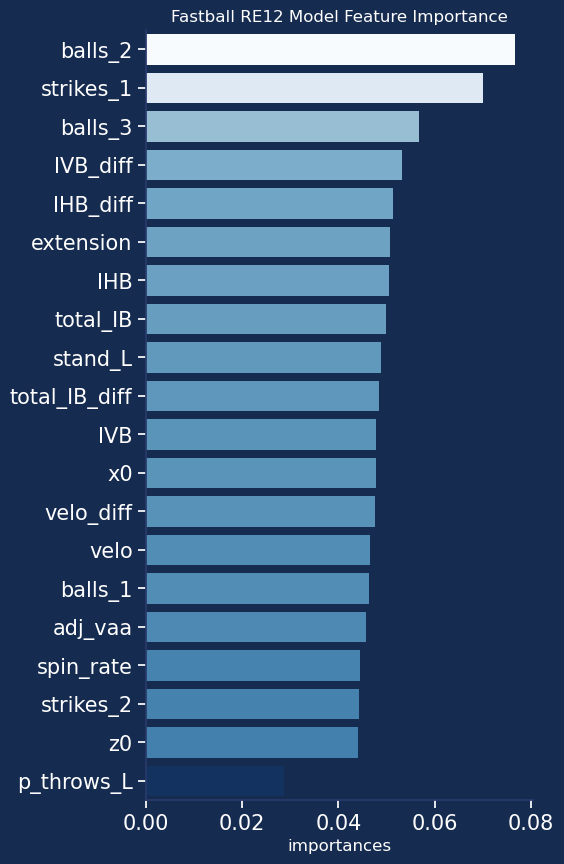

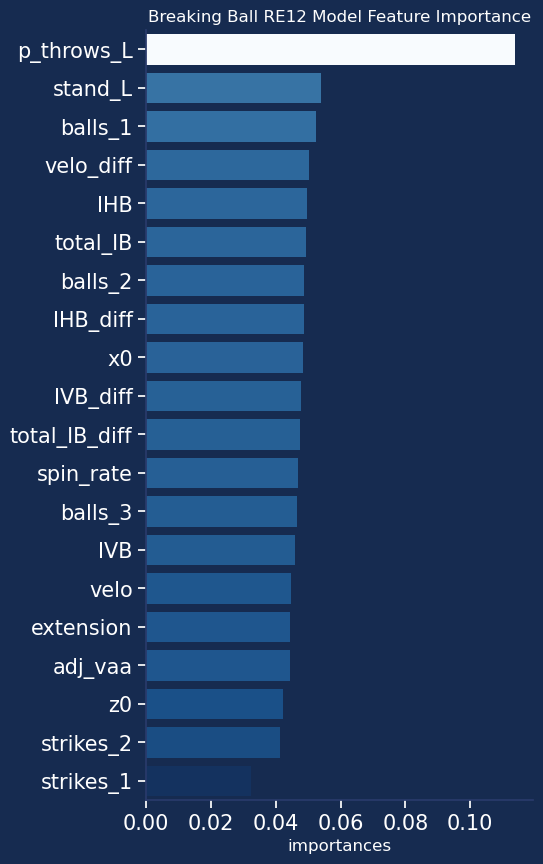

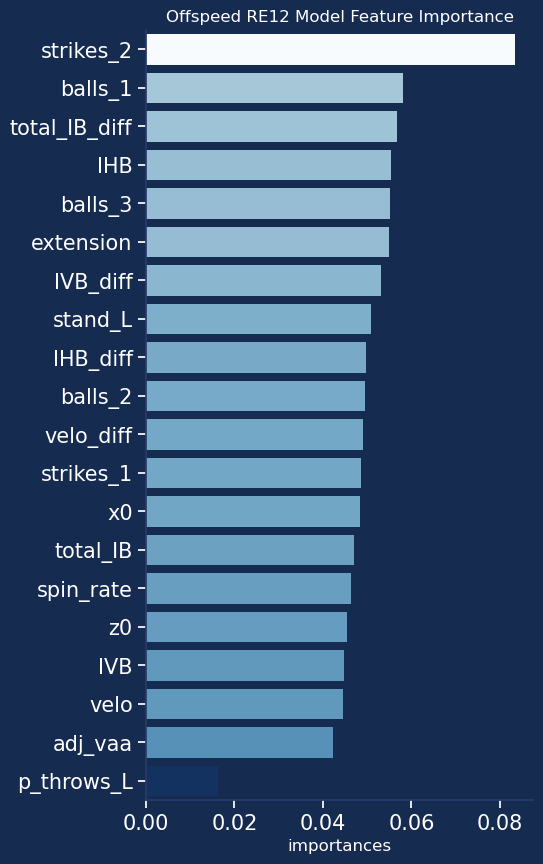

In [240]:
rv_comp(model_df, rv_params)

In [253]:
for pitch_type in ['Fastball','Breaking Ball','Offspeed']:
    # Swing Result
    with open(f'live_stuff_rv_model_{pitch_type}.pkl', 'rb') as f:
        stuff_model = pickle.load(f)

    model_df.loc[model_df['pitch_type_bucket']==pitch_type,['stuff_reg']] = stuff_model.predict(model_df.loc[model_df['pitch_type_bucket']==pitch_type,stuff_model.feature_names_in_])
    print(pitch_type+' Stuff RV model done')

Fastball Stuff RV model done
Breaking Ball Stuff RV model done
Offspeed Stuff RV model done


In [254]:
model_df.groupby(['year_played','pitcher_name'])[['pitch_id','stuff_reg']].agg({'pitch_id':'count','stuff_reg':'mean'}).query('pitch_id >= 2000').sort_values('stuff_reg')

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\1637971461.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



pitch_id  stuff_reg
year_played pitcher_name                        
2022        Corbin Burnes        2679   0.011370
2021        Corbin Burnes        2460   0.011479
2022        Sandy Alcantara      2686   0.011506
2024        Corbin Burnes        2599   0.011951
2023        Sandy Alcantara      2577   0.012127
...                               ...        ...
2021        Zack Greinke         2499   0.026192
2022        Zach Davies          2007   0.026478
2021        Kyle Hendricks       2300   0.026687
            Zach Davies          2128   0.029336
            Tarik Skubal         2532   0.029473

[304 rows x 2 columns]

In [202]:
model_df.groupby('year_played')['stuff_rv'].describe()

count      mean       std       min       25%       50%  \
year_played                                                               
2021         658563.0  0.009099  0.023629 -0.063441  0.000695  0.007175   
2022         642354.0  0.008805  0.022219 -0.065788  0.000753  0.007034   
2023         669817.0  0.008725  0.022575 -0.064135  0.000608  0.006878   
2024         642236.0  0.008623  0.022715 -0.098177  0.000563  0.006782   

                  75%       max  
year_played                      
2021         0.013880  0.968261  
2022         0.013569  0.964436  
2023         0.013372  0.935443  
2024         0.013248  0.938368

In [255]:
model_df['plvStuff+'] = model_df['stuff_reg'].sub(model_df['stuff_reg'].groupby(model_df['year_played']).transform('mean')).div(model_df['stuff_reg'].groupby(model_df['year_played']).transform('std')).mul(-50).add(100)

In [258]:
model_df.groupby(['year_played','pitcher_name','pitch_type'])[['pitch_id','plvStuff+','plv_stuff_plus']].agg({
    'pitch_id':'count','plvStuff+':'mean','plv_stuff_plus':'mean'
}).assign(avg_stuff_plus = lambda x: x[['plvStuff+','plv_stuff_plus']].mean(axis=1)).query('pitch_id >= 500').sort_values('avg_stuff_plus',ascending=False)

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\902911297.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



pitch_id   plvStuff+  plv_stuff_plus  \
year_played pitcher_name    pitch_type                                         
2023        Kodai Senga     FO               531  136.175049      154.212849   
            Blake Snell     CU               527  121.898254      155.566172   
2022        Blake Snell     SL               523  124.232231      146.443780   
            Devin Williams  CH               513  123.080566      144.437729   
2021        Luke Jackson    SL               525  129.336288      136.369304   
...                                          ...         ...             ...   
2023        Shane Bieber    FF               546   68.213142       65.026356   
2021        Zack Greinke    FF              1004   66.527405       66.664745   
2023        Zack Greinke    FF               535   67.364510       64.724224   
2022        Adam Wainwright SI               705   77.539032       49.425593   
2023        Ty Blach        SI               632   67.488625       58.348667   

                                        avg_stuff_plus  
year_played pitcher_name    pitch_type                  
2023        Kodai Senga     FO              145.193949  
            Blake Snell     CU              138.732213  
2022        Blake Snell     SL              135.338006  
            Devin Williams  CH              133.759148  
2021        Luke Jackson    SL              132.852796  
...                                                ...  
2023        Shane Bieber    FF               66.619749  
2021        Zack Greinke    FF               66.596075  
2023        Zack Greinke    FF               66.044367  
2022        Adam Wainwright SI               63.482313  
2023        Ty Blach        SI               62.918646  

[1233 rows x 4 columns]

In [263]:
model_df.groupby(['year_played','pitcher_name','pitch_type'])[['pitch_id','plvStuff+','plv_stuff_plus']].agg({
    'pitch_id':'count','plvStuff+':'mean','plv_stuff_plus':'mean'
}).assign(avg_stuff_plus = lambda x: x[['plvStuff+','plv_stuff_plus']].mean(axis=1)).query('pitch_id >= 500').describe()

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\1251645052.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



pitch_id    plvStuff+  plv_stuff_plus  avg_stuff_plus
count  1233.000000  1233.000000     1233.000000     1233.000000
mean    739.196269   100.231064       98.772870       99.501967
std     224.719599    12.334720       17.645639       13.392837
min     500.000000    59.734222       49.425593       62.918646
25%     568.000000    92.457870       85.487412       89.267536
50%     670.000000   100.411476       97.580770       99.472566
75%     844.000000   108.871750      111.756976      109.359942
max    1825.000000   136.175049      155.566172      145.193949

C:\Users\krbla\AppData\Local\Temp\ipykernel_28924\2269892913.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



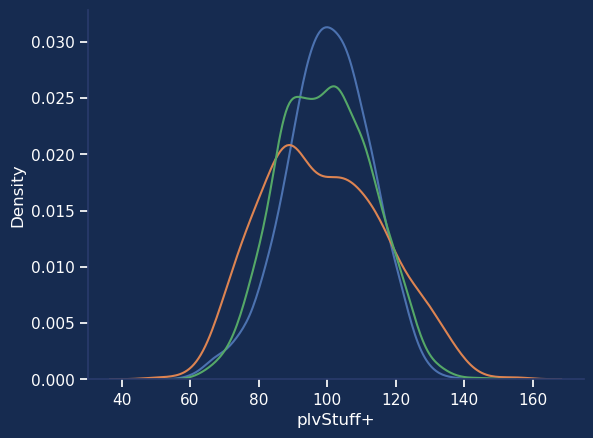

In [262]:
chart_df = model_df.groupby(['year_played','pitcher_name','pitch_type'])[['pitch_id','plvStuff+','plv_stuff_plus']].agg({
    'pitch_id':'count','plvStuff+':'mean','plv_stuff_plus':'mean'
}).assign(avg_stuff_plus = lambda x: x[['plvStuff+','plv_stuff_plus']].mean(axis=1)).query('pitch_id >= 500').copy()
sns.kdeplot(chart_df['plvStuff+'])
sns.kdeplot(chart_df['plv_stuff_plus'])
sns.kdeplot(chart_df['avg_stuff_plus'])
sns.despine()